目标检测中关于样本不均衡的处理办法
===

我们知道目标检测主要包括以Faster RCNN为代表的的两阶段方法，以及以SDD和YOLO为代表的的单阶段办法。虽然单阶段目标检测的速度很快，但是其精度往往比较低，究其原因，主要是样本极度不均衡造成的。

# 1.目标检测中的样本介绍

目标检测中，样本主要包括以下几类：

- 正样本：标签区域内的图像区域，即目标图像块
- 负样本：标签区域以外的图像区域，即图像背景区域
- 易分正样本：容易正确分类的正样本，在实际训练过程中，该类占总体样本的比重非常高，单个样本的损失函数较小，但是累计的损失函数会主导损失函数
- 易分负样本：容易正确分类的负样本，在实际训练过程中，该类占的比重非常高，单个样本的损失函数较小，但是累计的损失函数会主导损失函数
- 难分正样本：错分成负样本的正样本，这部分样本在训练过程中单个样本的损失函数教高，但是该类占总体样本的比例教小
- 难分负样本：错分成正样本的负样本，这部分样本在训练过程中单个样本的损失函数教高，但是该类占总体样本的比例教小

# 2.样本不均衡问题

所谓的样本不平衡问题是指在训练的时候各个类别的样本数量极不均衡。以基于深度学习的单阶段目标检测为例，样本类别不均衡主要体现在两方面：正负样本不均衡（正负样本比例达到1:1000）和难易样本不均衡（简单样本主导loss）．一般在目标检测任务框架中，保持正负样本的比例为1:3（经验值）。对于一个样本，如果它能很容易地被正确分类，那么这个样本对模型来说就是一个简单样本，模型很难从这个样本中得到更多的信息；而对于一个分错的样本，它对模型来说就是一个困难的样本，它更能指导模型优化的方向。对于单阶段分类器来说，简单样本的数量非常大，他们产生的累计贡献在模型更新中占主导作用，而这部分样本本身就能被模型很好地分类，所以这部分的参数更新并不会改善模型的判断能力，这会导致整个训练变得低效。

## 2.1.正样本(Postive Example)和负样本(Negative Example)的不平衡

Negative example的数量过多，导致Postive example的loss被覆盖，就算Postive example的loss非常大也会被数量庞大的negative example中和掉，这这些positive example往往是我们要检测的前景区域

## 2.2.难样本(Hard Example)和易样本(Easy Example)的不平衡

Hard example往往是前景和背景区域的过渡部分，因为这些样本很难区分，所以叫做Hard Example。剩下的那些Easy example往往很好计算，导致模型非常容易就收敛了。但是损失函数收敛了并不代表模型效果好，因为我们其实更需要把那些hard example训练好。

![Images](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQEAZQBkAAD/2wBDAAIBAQIBAQICAgICAgICAwUDAwMD%0AAwYEBAMFBwYHBwcGBwcICQsJCAgKCAcHCg0KCgsMDAwMBwkODw0MDgsMDAz/%0A2wBDAQICAgMDAwYDAwYMCAcIDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwM%0ADAwMDAwMDAwMDAwMDAwMDAwMDAwMDAz/wAARCAGkAlgDASIAAhEBAxEB/8QA%0AHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUF%0ABAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkK%0AFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1%0Adnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXG%0Ax8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEB%0AAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAEC%0AAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRom%0AJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOE%0AhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU%0A1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD7huJvlrA1%0Aq4+9WneXGFrA1qb92xrrTuaHF+LLrbmuS+0brqtzxheHmuRW8JuK1iRJHofh%0AS4+6Qa9g8A3G5UNeG+D7rlc17L8P5t0aYrfoZHsHh+T92K2Gk+X71c94fk2Q%0ArWy03y8VgWynqk5VWrjfEEh2sK6nVJC2a5DXpMM+aaZBxevNuY/NXO3332rf%0A1z/WMa52/wD4q0SAzbhtzGsbVody5rcuVC7vWszUo/3dWTLc5yS22qRUK2Pe%0AtGRd7U2OHa3P3aadjmqIrQ2YqzHp49KnijXdx2qzCg7iqujFxT3Ky6eFanpY%0A/wCzV9VDU9VAPpUykLlRQ+wD0NN/s4f3a1Ngp3kip5gUTJ/s4f3ab/ZoT+HF%0Aa3ljdStGO9LnY7Ixm01ey5pjaWGraaFWNJ9nX2qQsYv9jp6Co20tVrbkhHam%0ANbjutA+QxW01dtRTaYrdt1brWo29KY1uBSbsHIc8+igtnbTG0df7lb7W+etM%0AeEY+7RcOQ52TRUZvuUxtDT0xXSGzX+7TPsy+hplcpzUmhqp+7UMmiq/8NdQ1%0AmG6VFJYruoDlOYbQQe1Mfw+P7tdQ1iCKa2nhuwpNBynKyeHcNwtIvh/a3K11%0AX2Ffaj7GPekkHKcu3h1XXpTf+EZX+6K6r7AOtJ9g/wBmqE4nJN4Z3fw01vDI%0AZfu11zWO01G1nQLkOP8A+EbHpUbeGt3b/wAdrsJbEbuBSfYF/u0ByHHf8Iz/%0AALIo/wCEYP8AdrsP7PHpS/2cPanYrlOPXwyV/wBqn/8ACN8ZxXZf2cPrQumg%0At0pBynHf8I9u/hobw6ZOi12f9lD0pP7LFUpNE8pxEnhth0Wmjw23da7aTSQF%0A4pn9m+1HMw5DkIfDrr1X71dp4R0do1BIpYdNG4fLXSeHbDp8tKUhqCexNb2J%0AXbUk1o22tq3sQ68rUkliNv3ajmNbHJX1i22uM8YaS5jevUb6w4+7XMeItPBj%0AarjIznA8W1DRZPMY4rNm0l92dtelXmijzGJWs+40NPmwK3UkZ8p57NpMlV5N%0ANk/u1376Ds7VVk0Vc9KrmDlOCks3X+GqdxZybq9Bm0Nc/cqpcaGv92k3caPO%0A5rORFb5ay7y3kCn5etekS+HkKtmsy88Np6VkWtDza8V9v3azbyN91ei3nhxP%0ATFZd34XXc1Q9zRM87u1fcx21VZmzytd3deE1b/2aqcnhMf3aVyjiWVhUMjMr%0AYrtJPCY6AVWk8JjutAHINI+7rRXTyeERu4FFAH6f30nWud1q4+Vh/DW1qE25%0Ac1zmuSbYW/3a5Ez1GcH4xk++N1cat0PtTV0vjCb5nrjFk/0r/gVaIyaPQvBt%0AxuYV7R8O7j7grwzwZNuZa9r+Hrnan+9XQn7pgz2Hw/J+5WtlpMLiuc8PufJF%0AbjSfu6yHdlPVG2qa4/XJ924102qyFlPeuR19juYbqBHKatJukbisK8G5iK2t%0AV+8axbn71aJgULms7Un/AHdaU33qyNYby42q5EyMq4mCtxUQuvaqWoagYZaz%0A5vEAh5JpowqW6nRx3CrT1vgrVx114u2rwaq/8Jt833qdjmlPU9CXUBnNSx3g%0AbmuBj8cL8vzVZh8bKVHzUiVU8julvAB6077WPauKXxsrfxVMvjJGX71S0Vzn%0AXrdA077QK5CPxdGzdalXxgif3KVmNTR11qr39wkMKO8r/Kqr95q0X8G6xn/k%0AGz/+Of41g/CnxOl/8RNKi/ieVl/8hvWVZ+KptV1qO1hmnaa4m8pN0zquScDv%0AXo0MPRVGNSonJybSSaW1u6fc+LzPN8z/ALTq4PA1KVOFKlCpKVSE5fFKqn8M%0A4JKKp6uzerOxPg3WG/5htx/45/jSf8IVrH/QNuP/ABz/ABrkYfElxNb38oml%0A2adjz/8ASD8uX2DHPPNVm8XTxY33F6m5dy7mddw9R7e9JrCJJ8k9fNf/ACHc%0AdOpxHUlKMcVhm07O1Kpo7J/8/wDs0/TU7b/hDdZ2/wDINnx/wD/Gmv4I1rtp%0Adx/45/jXKaXrF7q14sEM115rZ+9I6qpVCxBPY4HSl0fVLnXre5nj1BYbe1WN%0ApZbi6MSLvOF556kU408LKyjCevmun/bhnXxue0FKVXF4ZcvLf91Uv70rR/5f%0AvWTTSXV6HSt4H1tmz/Zl1/30n+NJ/wAIRrm3H9l3X/fSf41zGparfaXdpA9z%0ALKZIhPE0EzzJNG3R1K9RVVfFk0iO4nunRPvOsjkL9T0H41MoYSLtKE0/Vf8A%0AyBtQq8RVqarUsVhpRezVKpbX/uO/+H03Ov8A+EF1zHGlXX/jn/xVJ/wgOuf9%0AAu6/JP8A4qudW8vXhaUXMrQo8SPKtw5SMycrk549/SqcniaWOZkNzcEqxX5Z%0An+bHcc9PenKOFjrKE/vX/wAgTQr8QVm40sVhm1valU020f7962a03OubwFrm%0A3/kGXX/jn/xVNPgHXO+lXX/jn/xVcm3iaZVVjPdAOu5WaRxuHtzz+FMbxdKP%0A+Xu4/wC/z/41LlgusZ/ev/kDpVLiaWqxGH/8FVP/AJedb/wrzXF6aZdf+Of4%0A1W1Lwnq2k2bz3Wnzw26fedsbVz9Ca5lvFk2P+Pm4/wC/x/xroPC+uvdeBfFj%0APNLJ5dvbsvmSE7cyn1NaUqWEqtwipJ2b1atom9uVdu5w5ljuIcupwxNerQnB%0A1KUGo05xdqlSNNtN1ZJNc19U1paxQM67sGn5X2rFj1gfNl6eurL/AHsV5PU+%0A95zX8wbaVJAKyf7VX1NL/agc/eqlEfOjV3j2qNtvUferO/tEf3qb/ao9aGxJ%0ArqaLY3cmjy1zzWf/AGwPak/tbd/9apuy1Y0fLXdT/LCvisxdUUnlqemrLSGa%0AKqFbP3qcuN1Z66kMZDU+LUBu607gaKqGPan+WvoKpR3y/wB6n/bR6VSZOhM0%0AY3fdpDH6LUX2xf71H21fUUyizHCFat/w/GF68bvu1zUd4GxXQaHcjaP9mpkN%0APU6i0jG2pHhG2qlreDy1qdrobajW5Tt1K19GPLrmNegwua6K+uwrZrmdeug0%0AbGqTfQiSRzt1bBmPy1QmtPmYVcuroM1VJrodK15iLdyrNahRVaS1Bq1JcBua%0ArtcDOata6g0nqVprcVVmtfarkkw9arzXA7NVNIRl3Vmu3gVQvLQdDWrcXAHe%0As66mEjVm2XZPcxLyzHOFrPurIKzZWtm6kA5rOuJl+YVA0Y82nj0qrJYhm+7W%0ApMwX+KqzSZPrQVymc2nbz/DUMmmhVzWo0g6mopGVvrQDRkyWPeir0kgVqKA5%0AT7uvH/d1zXiCT92c1vXU22Oub8RMSpP+zXEnc9I868WSHcT/AA1xrXG26GP7%0A1dT4wm2s9cU0228rSLIkeheB7j98M17b8PZdyp/FXgvgm4/fAV7f8OZvlQVv%0A0Od7nsmhTDyVrYab93XN+H5P3K1sNNmpBFbUpvlauR1yb71dJqUoVW+auS1y%0ATrQD3Of1OTd1rIuGq/fSVnXNWhFS4/pWPrn+rbNbNx83Wue8aata+H9Du7+9%0AmS3tLOJp55W6RqoyT+VOpNRi5SdkvuXn9w6VGpXqxpUYuUpNJJJttt6JJatt%0A6JLVvQ5LXG2s392uc1STriodW+Mmg3Gdk2pN/wBw25x/6BWDqPxO0mbdte8/%0A8AZx/wCy15yz7LbaYiH/AIGv8z6ep4d8UNf8i+v/AOCp/wCRLeXJWs9r5vM6%0A1n33jrT5OVe6/wDAOX/4ms9vGFm0mc3X/gLJ/wDE1az7LeuIh/4Gv8zln4dc%0AUvbLa/8A4Kn/AJHRLeHP3qmjvmXjLVzUfjCxXvdf+Asv/wATUsfjTT+73X/g%0ALL/8TR/buW/8/wCH/ga/zRP/ABDnir/oXV//AAVP/I6mG8LVZjvCq/eeuSh8%0AdWC/x3X/AIBy/wDxNTL8QtPTvdf+Acv/AMTS/t3LP+f8P/A1/mD8OuKf+hdX%0A/wDBU/8AI6r7afU0v24/3v8AvquW/wCFg6d63n/gHP8A/E0N8QtO9b3/AMA5%0A/wD4mj+3ss/5/wAP/A1/8kL/AIhzxV/0Lq//AIKn/kesfAK9aT4yeH1LdZpP%0A/RUlYng/X4tJ8fabc3M3lW1tfq8rtllVVkyTxVb9mvxtZX3x38MW6GffNcSq%0Au61kQcW8zdSMDgN1ribrx9Y/argbrriWRf8Ajzl6hyD/AA16SzzAU8JTrKtC%0A3PK2qtdKDtutj4Z+G/EeK4jx2AlgK95YWhdKlO6jOpiop2tfpJJtatPtZ+tW%0APxMh1C11u3vv7NsY7me3aJ7OxRJZFW7DOeAc4j+bB4Jrdm+JWm2txbTNq1rc%0ATWt/dzo3nT3LNE9tIqHLqAMvtzGoCqfzrwNvHlj/AHrr/wABZf8A4mup8Jx6%0Ad4i8D3utND4t1H7Hqkemtb6JpMl5Mpa387eyBCwUAqM4xllGa3wfFOHqy9nT%0ArQk0usk9rvo/M8niPwRxeDpvFYzBYmlCUrWVJpc1SMaNl7l/eSS1b18tD0Lw%0Az8TE3aRd3fiT7PHb6bJb39lL5jy3F0UkBkwAVbeSp8wnK7cVzHgvx5HoPhHX%0AorhLK5u7lLJbe3uoTLFIUlJfgEcqDkc9fWuXsrCfxG0sulWeqNZx3UlnJ9th%0A8iazkji85hcqwX7OfL+YGQKCNuOSMwHSLw6Nb3w8jZP9j/cfaE+1Qi7kEds8%0AsGfMiEkhVVLAc9cYNU84jO01JOylre904pN7tba6ab9BU/D+nQ9ph5wnF1ZU%0Avd5VBqUaspwj7qUrupzQd7ydlFPmszvNL+J0+taPfwtqtl4e1F2t0tZ0jeC3%0Ajt4w/wC4UoGK4L7v9roTXQL8WNIvr6+P9qRWenPcTO2zzba6+aAKZFQBo7jz%0AGDHy5ANu7Neaf8K11qSZI8aarvcGy2tqluu26Az9mPz8TEHIj6kc1nx+E9Uk%0A8Px6gtt8tzZyXsFq0iJfXESf60pbE+cxT+JQu4HjGeK3jmk6atK2ne/T5pfa%0A1t5dbHj1uBcrxs3WozaUmkuRwspSjok7XelJuN29IzfwOSPT7H4rWPliIat9%0Amjil0edkbzAkghAFwgAByR8uQeu3qaoXPxS09tBublpPO1SKefTootp/fWUl%0Ax5u/PQYj3xjv81cVqXg2WPUraG1ngaK7gtPIlvLiO0F1cTwecLaEyFRLLjkR%0Ark42k4yM8fN4vto2ZGF0joxR0a1lDKynBBBXIIIYEHoeK5MVxFRope2qQinz%0AJXas7PVp3s2n2+Z7uReEVTMZN5bh61Vx9nNpQbaXIox51GHMlOKbfNv0tZW9%0As+J3xUsNY0W5SzubW4W5vVnt0Sa4lkt4wDnKyALDxtUxrkHrxXADxVJjk7q4%0A/wD4TK17tdf+A8n+FH/CWWfzf8fX/gPJ/wDE15mL4ly+vU9pKtC/lJL9WfbZ%0AB4OcQ5RhPqeHy/ESje+tOcnslvyrol89ep2C+LHWu0+HfiR5/hX8RJD/AMsb%0AOyZfxuCK8Z/4Syz9Z/8AwHk/+Jrv/hh4otpPgx8U3zPttdO095P9HkzhrmTG%0ABjJ+43AyfzFbZZnGXzrtQrQvyz+0n9iV+r6a/I8rjrgLiSllcZ1cvrRXt8Kt%0AaU0ryxNGMVtu20kurdt7FI+MnXu1KvjR0/iauL/4Sqz3MCbr/wAB5P8ACmN4%0AotQfvT/+A8n/AMTXnf21lzf8eH/gaPsV4d8Uf9C2v/4Kn/kd1/wnDbPvvS/8%0AJ4y/x/8AjtcD/wAJRbAcGf8A8B5P/iabJ4ot/wDpv/35k/wpf2zl3/P+H/ga%0AD/iHfFH/AELa/wD4Kn/kegD4gMvej/hYB9TXnbeKIXXH73/vzJ/hTG8Tw7f+%0AWv8A35f/AAqf7by3/n/D/wADQ14d8Uf9C2v/AOCp/wCR6MfiLt6vtp8fxEH9%0A5q8ybxFC3/Pf/vzJ/hSf8JDH/wBNv+/L/wCFH9t5d0rw/wDA0V/xDvij/oX1%0A/wDwVP8AyPUF+IilvvVJH8Ql3ferytfEEW7/AJa/9+X/AMKkj8QQtMiAsC/y%0Arujcbu/cCqhnOXykoxrQbf8AeTv5feZ1eAeJaVOVWpgKyjFNtulNJJatt20S%0AWreyWp6xH8QFZuTViPx4vZq8sF9U8epn1r0z5CR6rb+OE6E1bXxsm3rXlEOp%0AMv8AFVmLUmb+LbVxFdnqH/Cap6ij/hNU9RXmR1J/77Ui6k/Ul6vlZLbPVYfG%0AUW7Aeur8M+KEmX73WvA4dUfzFwa7Xwbqz7fv1EkVGTT1Pa4dcVVXB+Wnt4gR%0AV61wdrqz+WozUrak/c1KRtz6HVXniIM3Brnta1tPJOTWVeaoy8bq5HxRr0iq%0AwBqlEynM3brXk3t8/wD49VSbXF65X/vqvOrvxNK0n3qo3HiiXd1q+Uz5melz%0Aa8n99agk1xCOHSvM5PFUrL1qu/i6XdT1Wpab6np0utL6/wDj1VptaHdq82k8%0AaSquM1Xm8bSL3pNj5j0W51od6o3OsLuPNef3HjaTb1qhcePHXI3VnzFXO+vN%0AWXBw1Zs2qDua4W48ds3BL1RuvHhVeTQ2Wn5HeXGqD+8lVn1hc9a8+ufH27J3%0AVXb4gbW6p/31UlczPRH1bd3prasvrivO2+IQA601/iACPvLQVY9Ak1QM3/xN%0AFee/8LBRerrRReImz9OL7pXN+IpAsbf7tdBfMPmIrlvE037smuK56jPM/G02%0A2VsVxPnbbrNdX44m+Z64fz/9IraJlJHf+Cbj94le6fDubdHFXz94ImxMmK92%0A+HMx2p/drrXwmJ7L4fm/ditZ5ty1gaDNthWtWSb92azEkVNSm+Vvmrktem+Z%0Aq6HUpv3Z5rk9em/eNQJ7mNqElUpJKffTVSeX0q4kvYGb71efftMf8kH8Y/8A%0AYGu//RRrvGkxxXA/tKNu+A/jH/sEXf8A6KNcOa/7lW/wS/I+k4I/5KPL/wDr%0A/R/9ORMXVtcTT7Oxtlinu7maAOsUShm2qBkkkgAc9zWDNqUGpWrSfPDhyjpL%0A8jxsvBBz/Poe3BrW1ixure4gvbeBrqOewjt50SQJKu3lXXJA7tnkH7pFcx/w%0AjN1dagkmow7ooZ5HgSWbz2hBRAuSepyGPfHqeDXDDGYmEoxjBvZWadktNbpP%0Az6/3bJ3kfQ4jJsorUqlWtWUGlKTlzx5pS99uCptpq7UUtF/NzO8YlXXNQttN%0AVmkmRMKWb+8uOucZrzXxR+0R4T8OXwjfUfP3tt3WsJuF7d1BHfpnOa3vHWlx%0AaT4djjvLBna2U7riBgpuGbgFWGTy3zMGA5XHNbf7Av8AwTz17xVcanqviWJt%0AW0u+1eG6je4bY80Ly/vo9vJASML6bumDWdTO8TCOtFpvbez0u1e19HpfZu7R%0AguDMqlUs8bHkV+Z3p3XvcsXFKprzR9+yd4LSVtWecWv7S2l6hDdy2Wj+IJ/s%0AK754H0+SK48vON6hsZz6Y3D5cjHNdfZ/E7TfLY3EV7aTJjck8Jj5Iz1PHfnn%0A8a+3vBf7MOgfAnxo+p6R4G0a602wv50t7CBo1mWGW3ttkqtJjOyZLkFS3SZm%0AHoe8+DPww0HTPhhbaV4j8J6HHN9qu5fssUcd2lrHJczPEFJUfKscijjoOOlT%0ARzfE1KvJKNlZ667rls7tJNb76nJjuHcqw2C+s0avtZNw0ul7rU3KLjGTldWj%0Ad6K8tNd/gDS9eg1qHz4Y2EULFWd8DaR1BGc/pWqzL5IYsmw5ZH3feA6j8K+l%0ANU/4Jv6P44n0uWCH+wNSudc1OS4nt7hJYVst9y1oSp4eQZgXGMgbgema8Y8e%0A/sb/ABD+FupTQ3+kQXWh211O9tdWswmaaPE3lvs6jIPzg9D0z1owucYtxUas%0AG27dHe75d0lokm9X/Lq0deYcL5LVrSlhMQoQi5Nq8fhj7WzTlO8pNwhZJL+L%0AGyaVzh7fVre62hH+V0WVWb5Qwbp+PHSnXHyyr/tVnr4bc2uyS1iSUWAtWiZg%0AxjlGQ4P1O0+9X7xTDbqr/fRAzfhjnNepluJxNVf7RC2iezXys0tj53ijKcqw%0Ak/8AhNrOdm01eMtNLNOLs1rZ6JXtY6/9m+YP8c/DY/6eJP8A0RJXD3kwa6m/%0A2nb+Zrq/2b7xV/aA8JbWyk91Iq/X7PMR/Jq8pt/HFteTORJndcSr6cCQ/wAu%0An/Aa+hqtfVIf4pflE/JsKr8TYn/sHof+ncQdF9q+tdF4b8eafpfgu80u+j1z%0AZNfrfrPpt0lu6lYjFsO4cjnNed6f4mGoXD+UUdJX2Kq/eU4yc/jx/wABrL8Y%0AeOF8K6er3csUK+QXZn+5geh9TmuKGLVGXMmfRY/JqePpewrxfLdPRtO8WmtU%0A090u67o9Ytfitpfh3T7+zh02/udO1t2j1H7VcI13NDswiKw4VlYtJu5ydo6Z%0Aq9/wvrTLbT30+PT9SjR0s3+zpNAltbyW8sb5UBNx8wo24yEkFuK+YvE3xsjh%0AWwtzcxRXM08TN23Rvna657NhsH0qKx+OVmLoM9zF5l5KVRW6qEBJOPcnHsap%0AZ1OOkZemi/rq36tnmVeAMtrv2tSm220/jnrKPLaW+65UlLslH4VY+ibf4qQ/%0AbIbg2bLjxQfEO3zB0P8Ayy+o9f0rdvvilolnJ4c1i3tbq61uw06Tytt0n2aG%0AWSS5wky43EoJM4U/NuXNeGeH9Yn1hWSL5/s7RpK31HP49/8A6wq03iKKxWGL%0Aer7XMTtuycKCWI7cY6+tVSzSfRp+qv13XmRi+C8DVlGUotJXTtJq6cWmnrdp%0AqTuke1aX+0ELOztrTydUt7e1+yujWVxArzNFbxwsjmRG/dt5anK4Ze1cJqGo%0ANq+pXF1IP3lzK0r/ADZ5dyx5PJ69T1rmtN1dJrXzS25pW2ov90+n4CtvT5Fu%0AGwT/ABH+HtSq4yrVSjN3sdOVcN4DLZzq4KnyuSV9W9F6t77/AJlmO2MzMOwX%0AczewqS6UKwTZtZFG5W/h9vwz+dacNqLOweT5Qu35Vk/iYjIH4ArmsLV9Sa31%0Ai0sIV87U9TUNBFtLuoYkGRgOcDDHP/1q5JTUXqe7CnKWwbQZWY/L/vfhXeeB%0ALqHSfgf8UZ7p1hhh06yd3ZtoUC5Peur+G/7Dvj74sWcM1tZf8I+Lhz8t7Huu%0AIVztQsnT7gaTGcksg7Gvevhz/wAE9dO8B6Lc6H4t1H+1x4zRbPVEbZ5flx75%0AVTAHT7oI/wB71rpy+qvbNL+Wf/pEj5njWg/7MjJ/8/sN+OJon586v8VtD8P2%0As015fRRpCrSs/wBxZNpAbYTwdvfHQc8VP4d8daZ4ut5p9Pure8ghbY0sTZiU%0A43H5vUAqa/SbX/8Agmv8IdUs0tf7NXyoU2pFFjyVPBztxg/MFbB4JVTjivmP%0A9rT/AIJCxab4VebwNcyqkSt5sEDG3fa2MuSN3mEAMScbyWYA+nnKum7XPsfY%0ArbqeDrcLcW4aPmL+Fv73ofx7VBN1/hrI8ByPHossMlp9jmtbqa1liebzZVKO%0AVJYjjqjYGScc5rSuMRnGc1utVc5ais7DJJB0xUTMOu1aSSQK1V2m+YigSZPv%0AH90Uxm2r/BUDTbWpHkOaB36k6yDdgBKg1I/6Vaf9dT/6LkpPM9qgvpC0kB9H%0AP/ot68jPP9zf+KH/AKcifZ8BP/hah/17r/8Apioa6yfN2qWObbVCO4y1TI+6%0AvXPjGaMNxuq1HcHtWbD61ZjkA61ojJlvz29aRrjbVZ5Pl4pnme1AF+G4KsK7%0AXwjdHyv96vP4JNjc12Xg+b5fpQLqd5a3W1cVZa6DLxWVayfKKl+0belBoh99%0AdfLXF+LLr5TXTX1x8tcb4qm3Kfxq0ZzOUvrj94TVCa4K1LeSfMcVRmYdKYwk%0AuhVaSbbzSSSBTVaaT1pPYBZ7ncuBVSa429aJpPlqncTetQVEWa5+Vqz7qT5W%0AqWaQ1TuJKC4le6mO3FZd1IW3VduJPmrMupPvVDNFuUbiYq1U5rj1qe8Yf3qz%0AbiQhqRYNfYP3nqKS+OcZqtNNtqtJMWoKUV1Lragd336KzWmG/iigo/Y7UJCs%0Adcl4muP3bCuj1K52q1cf4ouQ0LVwNnc0eY+Np/v1xHn/AOkMK6nxtcfM4rim%0AuN1x/wACrSDuZzR33ge4/eIa95+HMu6NK+fPAs375fwr3v4dzboYjXWnoYns%0Aehy7oRmtNrj5cVgaLP5lun+zWnJcbo8UCRV1Sb5TXI65N+8NdFqk37s1yGtT%0AbWNBL3Mu6m3NVVpBupt1cbmaqzSGriIsyTbea4P9o6QH4C+MR/1Brv8A9FGu%0AzWT1Irif2iXDfAnxlj/oDXf/AKKauHNf9yrf4JfkfScFK3EeX/8AX+l/6ciN%0A27tKt/8Arkn/AKAKyL5NvXla2oP+Qbb/APXJf/QBVOS13KwFdVD+FH0X5I8D%0ANP8Aeqv+KX5nLzeH01bWrSJ5VSOa4iZlaMMsgzyCp9fxHqK+mV1r/hUunwww%0Ah7aGKDzGggX5Y89CAOV+nSvAmhW1uLRnTzRbXMcuP41wRyhwcEdxjnpXufx0%0AdLzxdDFI0sqJZhVSDOMOg5IHPHbP+1kV52YwbaSN8pSk2mdD4X+JUHiDypLi%0A8skdfu79Q37j67eK3o9WFncZk1FLP5vlnVQ8Mg9GzyPr+tfI19qlx4f1Dylm%0AaHozOsfzKPX8q7Twn8VtS8xRBq8t7E33oJ7dAZj/ALIcKAT05bmvO5tbH0Dw%0ALteOzPq3S7y21Cbclzbo6/eZW4b6Y+6R1HXHY4rrdP8AExlt2iu9t1FzE29s%0Aru75xnaf0PUd6+UtJ+J1xNqHlW32q1vE+ZrC4t/LXPfjDcH1UkfSu38C/Fj7%0AOzLa7nVpBv057oO0ZPJ8nfycd16+laqp1OGvg2tLmz8fv2KdM+I1ndat4ZaK%0Ax1d2Wd2ZR821NpRwOoI/iHI256V8LeMLPU/Dr/ZtRspdP1WFA89s/PlkocuP%0AWNtjDP41+kHgL4oQf2tbW5u5TFcofIdlxtCn7jKedynr3xuzXnX7dv7Pdt40%0A8D33irQra1j8SaQkjRq+Sl1gc25xyY2+bbjoW9yK76WJaje5488NHmtI+Pf2%0AUYVh+LXgGeUsyaldTy2vy/NbsiXAeJvT5XVlPcNXwr+0t8Xv+FT6Y17osl0/%0AnNdTy/aG2LzcHdtA+/tSTtzhfev0z/Zb+Ha2/iTTb+CHNr9ta8iaVf31q/2d%0Ag8B7AjKjjqFU96/LD/gqJ4Bg8F6V4UtCLWwvNbv5luG3ForceYVZ8dudkhx0%0AG72rqqV5SwVNp/bl/wCkwPl8JQUeKMUv+oeh/wCnMSfQv7F+n3PjD4K6r4r1%0Aa4aOSJprp0dhtmWOMkuPTlsg9w3rXyv8Yv2sH+MX7Ry6LHb+RokTrA0EsxQS%0AHYWct6AZUD3X3r63/Y+1TRbf9j/+y5o5W1Wzs7nRtUt2+606yv8AvIRzuXhW%0ATPaTDDOa/PT4gfBHUvDfxeS4j3quq3TToqMWdVeTGHPQMS/PYBc8DGPM85H2%0ASetkfQvx0+y3XiPQJYkW0ZPsMLT7Su2OMFotx/vKHyQf7ua5T9sTRTo9xZ6r%0AoMsvkWNvFEqKuxvJYFnceqn07fQ8eq/FTwHqPj7w1DeIqWYh0aBEedvmjaMO%0ACWXrkZzzyVXqc1y/xs8P32pfBvw14d0wvNd6g9vb/MpfzN2FL7upTZz19u9Y%0ArlubO/Kkei/sa/tBP8VPAN9ZWu1NS061Et5LPjZ5jZRT65OeMf7XYDPmeg/H%0AS/1T4vLoN1bXFhcW3zXitId0O9+N2em0HJI4z8x612v/AATE+Gsvw30vxndS%0AK818s8qyQSqNmYtgwM8YVyze+3jivnz4W3t3qf7U/iiO/u5bV3GpRW87sjtN%0AAsgLJliA7MixEdz0A610QbTumYuN9Gj7Rk1S18K65DYbHihigE7ieT5o2kj/%0AAHURzyJP4iOwZema9IsdPlt47V5Pli1FIn38r5a8A5/z0rP/AGbv2bdQ8TeG%0A/EN54mjl1LW7CeVVnlXc3nOgAkLEYIUlsD/pn6V9Q/sa/s+wfGDxhcNqNv8A%0AafDHhlIbe1iuOIdSmTId37lIyPoflrWOLk3yLcznhYJc55h8F/gD4y/ae1pU%0A0TTpdN8MQ3CLcazcRn/SAMuyWyHBfcNqiT7o+brX2t8A/wBhPwd8Bb6fU72D%0A+1fEt++6W6nX98sWfli3f8s4RtUlQQC3NewTPp3w/wDDKx6fHFCIV2KyYQRq%0AAcY6AAAcDtXJ3HjyC6jdysruPn2xNvHsWOQMemSM/SlUqO+rJpxurRWh1mpe%0APrfSYfskRtfOC7vIiU7Y4/4S/b9a5XxFqUupapprzBP9bI33gwz5b8YH+Fch%0AcfEzUrjUJobHSr3Um3HdKrBLWE/3yepx7D6GsLUvHWo/Ybud4ooXtFV4k+zu%0AB82Rn73PHvx3rrymTddv+7P/ANIkfMcb0H/Zkf8Ar/hf/UmienLeX9sAUWKz%0AjT5t6+XhvXg9KjuvHx1T/Q45vtEquFZlUDac+nOa+dPF3xcvL6RYJXZGdgrI%0Aq/Lz9Tx+tdf8BrGFfF2ntciWGUT7opVkJ8zIyQcHacD2/h615zvc+zq4Zxjz%0ASPjj48eDbbwB8V/EVhZ2EtnDHfySyu+ZHuJX+ZnySeCS3AGB9ennt595ieK9%0AQ/acuv8AhIvjd4nvIVvZme9kXczfulx1RR6L0ry/ULdoWYN8rfe2969SkvcR%0A4NX42UZmNVWbjPrU8i7Q1Qz9q0MxhbdUfnHtRL8wxTJfuUAiZZCy1BdNtkh/%0A3z/6LenJ90VHcLuaL/fP/ot68jPP9zf+KH/pyJ9rwFb+2o3/AOfdf/0xULu7%0AbU0MvaoNvyinxpuNeufFsvQybuKsRyVSgXaasRpuWtEZMmaTA9KZvHvSeWVW%0AkoAljk3Niux8HyfLXFxffrrvCKFtp+tJgdvZyFo1qwzbap2jbY/96rD/AHTT%0ALRVvpx5bGuL8VTffFdZqGdtcd4qPX5qtMhnIXc22RqpzSc1Zuvvmqcv3KYEE%0AjFqryMWp79KrzMaT2GlqRTSGqk0vpUtz92qT9KgsbJIFWqk0nepppPvD+7Va%0AZsRtQxxKkzbuazbw7S1XrjNZl0xZmqGaJGddNu25rOuJBuq7fNtXmsy4bbzS%0ALsVbiQtVOaba2KmuJNrVTmk+bP8ADSbNBGk3NRVd5B1oqClE/Y/VJgVOK4vx%0AZNthI/irrtS/1ZrivF0n7t/92uM7jyrxpNulb5q4xm/0jj+9XV+MpB5j1x28%0A/aP+BVUHqZzO68DzHzBXvXw5m2wRV8+eC5P9IWvd/h7c/uk/CuyOxja57Fod%0AwFtwK0jdfLzXPaLcfuVNaUl0KOYkratdEKa5PXLz941bWsXnLDdXIa5efvGo%0AchWKl1cbmbFQNcVTmvKiF4H700yWjQ80/wB6uN/aGkLfAvxgP+oNd/8Aoo10%0Av2z/ADiuQ+P1xu+B/i8eujXX/oo1y5r/ALlW/wAEvyPpeCv+Siy//r/R/wDT%0AkTYsV8zTbYf9Ml/9AFSCy+bJWm6H82m23/XJP5CtaOz3CurD/wAKPovyPn8z%0A/wB6q/4n+Zj3ViFh37M7fvfwstew/EDUjqmi6FeTMstpqtlHAr+dl1lUcgN1%0AyMZz6+1ee/2UVUNXffDfRZfF3wv1C1Vdlzot55tuyyfejfDEdeOfUEVz45e6%0ApCyudq1ujPJfiB4DivrX7Qk04dlDNKuHZh+HfPcf3q4C61I+DVaUot+u7a0r%0A3Eny/wDfvDD8TXqPiK4l0nXLy2jillTdvdF+bbu749z6cV5R8WtPi1SFL2yd%0AYXVxu2MVZTnk8c/rXj1IuK5kffYJc0eRs7Pw38ZLHWIYdM1eW90jfsSzn23L%0A22ScBG3g7T6Nkqp68cjvIdQvmbyZXXUpIMPLE9v/AKR5Z/u28yFnxjrG7A/p%0AXgNreWUWjsviuGLUrCL5WupVe0ubPJ5InBwwPo2fUGvYfhj4Vmk0uzXSQkuh%0Aal8yS3l1JqEu4jCSxK7PHz/E0e3K8nkZAr2uznxeHVPV/wDAPUPAevWvibWr%0AGV5pUjtpYtu23dbmxkGQR8w3eWR0VgSDxkq/Ht2rafda54buLeVkmimiCrKm%0AcY7EZ/4F/wDrrz79nXw3NcWc15qjyySPKItkq7XjkXOcH27H028mvZrjUhp8%0ALRM+/wDus33mHt71VNvVM+bxUVz6HkLeAbbwTdK8HyzXzhp2i+5lIipJHuNv%0A41+bf/BSL9lVPjjbxGS1itpli1C83S4EWT5bEHHIBVGOQR8zKeRmv1F8VSCS%0AZ1Rn/dKWbd/dAIyPx/z0r5I/b60vTbD4N3KakrwbH8hlijJaSA8yoQOoCc9c%0AjrXozlbAUv8AHP8AKB8Xgk/9a8Vf/oHw/wD6cxJ+Tf7G/wAedf8AiX8frXSY%0AbwTaQtu2pMmwp9sESJh3xjGC/wA3f2I6fZHxS+AunQ+BZ/EV6n2gWbeVYIsO%0AHmmGyBePQE7j3YLnHavFf+CP3wG8P6p+0BrGr6TNZao+mLfLA80Z3rCksY3g%0ADs6DAPQhs194fH7xRodj4Pk19Yn1C08HXA1FbdWEZjSARglj0wJQoY4zjdwa%0A5Zxe59Y5cunU+Y/GHgme+0m/sZHeHUPPliTdnfNJJIIhBjnG1A/PYLg1u/Dj%0A4IxeItam8Pz7VeOB2s2VebWMbEgAPBBIeUn9cZrhPAnxW/4WF8OPhtqX2yJL%0A19KsZ9UuLdTu+3NIDOW7HfK7Ec4+9zivRvgy2teMP+ChE1zbSWv/AAjvhbwr%0AZ2usWqx/8et1MJFWXK8FyRPujHQRoxrnhH3mzSU7Rua/xcksf2e/h3r+qxaX%0AKFis2iuPKXeslx9pmhBUf89DHsLf/XNflN+y/wCBtT+Kv7TGiaOqPf3w1ePa%0ArNkSNFcIx+9k4/dsCeuPev2s+OHiLTPGHwP8cxXFs866HdQW8XkL8q3C3DhZ%0AAccoDvz3PlqTX51f8E0/gRqV3/wUBvXu4rm0juLq9urW8WFtk0QuUdgg4xIw%0AnVQD0Mb9cGuhNJXZEJJu6P16+Fvgc+FfhimkyyxXF3qzlpbho9m0YOXH0zj6%0AV7X8A9JXwXDc20ESLbXTful2/KwTso4PAGT/ALy1xc2yO6tlij8xLVQyxbd/%0AmA8AjHp/8VXs3w/0WCz0uF5l3yrhIl6tGDj8v4a54tqd0aSScNTnPjB4juLO%0AW2nurqyijdfkgl/eopB6YXmSTIyQBtAXkk1594r+MjWUX2S3hifDHz73UV8u%0AONhg4CnqSOeh9OtesfEbw6muzBptnl7dsSfd+VRnk+h9Oledappf9lzC0i0z%0ARoWt/wDVJa2o/wBHHU5Lbhj5ucYJrWTuy6EVFao5K78Q3/iJlln1nV5onfat%0AvZLItnJgZ5ATBA7kZx61V/4SZ28N+It13BcTWixbliYsse52x7ZP1+oFUfiR%0AeXGsCZJNRvbSMoE8ryws0nvjHQnnk49qqfDmGOz8K64kqSvAiQ/NPJv3fOeM%0ADoK9TKU1XvbeM/8A0iR8/wAa0F/ZMKj/AOf+F/8AUqiU/DPhN/Edx516i+Vy%0Ay7mI257DPQe3r0r074dtF4T0fUtQdIkuNFsprhp3UIqkjagJH6nGPqa5OTxQ%0At5stNP2ea7lV2ew749u1O/aK0248Mfs7Np0byvN4iuI0nkZvKkkt4/nI/hIB%0APH0rkcLSUep9Tj6nuttWPkfxVqgmvLl4/KSW6leWVoPmXLHOc9cnOT+vpXJX%0AkJ3clX/2vvbq7PUvDrLuCpw33dvzKo9scVj3PhhvmG2vRirJI+SlNt3Zys0Z%0Abiqzr2rpZvDZ9KrT+G2xnbTbsO6exzuwk803yvat+Tw2d3Smf8I+/wDdqVJA%0AYiruplym14v98/8Aot63l8PuzY21T1TRTDdWK42+bOV/8hSGvKzxr6m7fzQ/%0A9ORPsuAVfOY/9e6//piqQou9qljh+bitFdBf0p40Vj1FeufGyZSjXDc1ZjXP%0A41Yj0V+oFWU0d/7tUmZmeykD0qnrl8dF0W8vNm/7JBJPt6btoJxW7/Y7+hrH%0A+IGluvgfWjt6WE7f+QzWeIqctKclukyKjai2uhymkeJvF+rafbXcPh7RvKuU%0AWVN2rODhhkZ/d11vhnXviCq4g8K+GZf9/XHT/wBomsW3urnQfhr4bmimitvt%0ACWcDStCZvLV0GTtHJNd/4H1qTT9F+0M9xrZkn8pFt7MWnl/Jk7jKyqB/tEgd%0AhzXjUnJqKnWneyb+Dqu1rv7mckYt2TqO9k+nb0C38T/E7GF8G+FP/Cik/wDk%0AeppPE3xP7+DPCX/hSSf/ACPW7o/xY07VJ7CKzs9Su3vLWK8ZUWPMMbyGIHBY%0AGTDI27yt2AuehGduz8WWuqXFnDHFP9ovLq6s/KZfnha3yJS/PCghcEdfMT1r%0AenyT+Gu/w8v7q7m0Kaeiqv8AD/I88v8AxD8TPm3eDfCi/wDcxSN/7QrmPEOu%0AeP5N3neF/Dkf+5rjv/7RFekX3jC90/4rXelXkcA0R0tbeC4VSskN3Kjtsc9N%0ArgYQ8YZcc7xXEap8TIV8N2U98u+6eyF7eeRsRbeNi4DkMwJ+43C5PytxU+0p%0A681eStffl0tba628+130MeWzfNUf4f5HCXWseL9zbtB0Qf8AcUf/AON1Wk1j%0AxX0OiaN/4NH/APiK6TV/E0NteOFtrya2FxHatdIoaHzXIAHXOPnXJxgdOtZO%0AqeLhDHeIlndLcw2st1Ej7F85U4JxuyvVThgDjpTlOEbt4if4f/Id+uzdkNpb%0A+0f4f5GRJq3ijvomkf8AgyP/AMRVeTVPE3fR9L/8GB/+Irbt9aaTUIYZo5Y3%0AuVh2oyj9yzhyMkE9dmB/9eqmoeLLSGHeElcBDK/3BtjDld/JGQcMQBk47UNw%0AtzSxEl68n/yBTStd1H+H+Rkzal4jZedH0v8A8GB/+IqtJqHiEddI03/wOP8A%0A8TXXNatJGrr86su5W/vA1XmtXz0rp+p1P+f8/wDyT/5A2VGT/wCXj/D/ACOO%0AuvEGqafdWwvNOs4o7mdYNyXRdlLe20VqTL8tV/HVuy/2Vn/oIw/1rQuLNv7t%0ALB88atWlKbkla17X1WuyXXyLw/MpSjJt2tvb9EjJulrMulFbV7asq4rKvLVm%0AZs12nYmYl8u6su8xtrZvbVumKy7y3KhvlqW+hpEx7psNVObHetC6tX3N8tU5%0ALVmblaktIqSL2oqSS3P92igs/YXVG2q1cP4wb9yRXbao3y81w3jGQLG9cR2H%0AkfjRv3jVxzSFbjNdb40k/eN/FXFyHFwtVB6mcjtPBs22aKvd/h3cfuY/wrwL%0Awa48yId690+Hsm2NB/s12J2Rkj1rQ7oNDV+S8+XFYWkyHy1x95auzXFIZT1i%0A43bua43Xrw+Y1dDrl1tVua4zxBdfMaGDKNxdbWPzVH9v561nXl1t6VWbUPQU%0A0zKSN6O+rl/jvebvgp4tX10i5/8ARRq/HffNXOfGy6L/AAf8UL/e0m4/9Fmu%0APNf9yrf4JfkfScEf8lHl/wD1/o/+nIna+Gbr/QbTP/PJf5V1NjGJFXFcD4au%0Aj9ht8f8APJf5V3Hh++E0ahq68M/3UfRfkjwM0X+11f8AE/zNeG1Kx5+8F/2g%0Ap/Wut+DuuXGiW+sbLaJmuW8vdu2Pj2wDyPaubkhRbR3X+6W2t0b860vg3azW%0Atn5s+xITcCRkaPlRnuc5wPf8KyxsvdS7mWEXvX7HZeMvBtno+lpdS29v5jqW%0A3N/rW3H7jjr124I4yy5AzXyX8ZtNsfAvjJrkWl1Z298olVWXYMsT8+Dzg/hg%0Aq1feXjrR5WWJg8XlOnyP99MkfKSO/PDAdtpHSvlP9ofwimvaHMt4LJbzT5W2%0A/aIftO4kH90rAggseQentXkVIu2h9NleKtUTl1PNLXw/qfiTT/7Q0yfXJfJJ%0AWVLO3RpoccENASc/UcE9c5r1/wAE+H59K8MzXenXK33myw6tBLa6TGjyH7sy%0AEAht568kMPmAJwBWP+yD8ZNG+K2m3KzWP9ieJdI8l7hX8txqED8RSqVy3BTy%0A23DIK8kjBr6B8LeDJ5JDdWlstmxlLbJV3w3APXgcjd6dKx3aZ0Y7EzU3CaN3%0A4W6o39gwxXUrN83yzsvzsrjKuRj5+nPf5Wrb11riO1c+aku1Q25WyjfX2PrW%0APo9rBCz+WuyMfJ5Tt89qe4BPJQnkHsa1beOePbIzoi7Su5+B+Pb8enrW0Y6H%0AhT1fMYV9qZvFnKNuEysrq33sgdfTI6H1G0141+0F4D/4Wd4D8RaJd2u1ry1k%0Aa33qWHmbCokU88qeoP8AKvc9ZtYfsbt5WxvLZmVW/wBScdfofb6jisvxFo9p%0AHIiXyeS9tKH3K2UkDDG/6c/h1r1qlNfUKd/55/8ApMD4rCVP+MqxX/YPh/8A%0A05iT8pf+Cd3wG8U/sqeEvE/iSexnivdE8I6laJOn+qvtkcktoSDgblBaN/73%0Alqc8V5j8P/2krnVU+Lmi+JJns7C4006tboqmZLiG8iBSOMMAXQyCVgOeVTBP%0ASv2G/wCFXWWteG9XshFbtbyIUli2jE0T5DgjpydxH+9X40ftW+Do/g3+3gu2%0A1/sfw94Q8JWGnK7sFhuEhMyBzuIGVDp/3y2O9cF0fW6PVEfwJ+MWmeKvBLxa%0AhcxW17r2qX2oyweSYpbc2s726xRL/wAsy5kibAHy/MK9u/YM8e6l4c8efFLx%0ADdtFcQ6hqR1BnMflyrcJZNb28ADYPzfM3PH3vWvj3VdQ034X/tFfE6OQS2Go%0A2OtRz2sVy2UklNxBdiQn+FPMdpTjgjYOQAK7D4wfGi68Gfs86Lp/h+WfUPEH%0AjzxBb640sUnzzBYJFEGexkkRF9hJxjApRupOxo03BI+sv2GbrxB+0l8JbbQN%0ASndbPxt4Ph1K8VoyiNI5cOUYHcNzTYznorY5r3n9kv8AYtX4T/EK/wDElw11%0Ad3Fr8lnEn3bVWeQqFyfvtveQ5/vL6V6T/wAE3/2b/wDhXf7O/hdLuzitn/s5%0AkWJWAWGL7RvSJfRAXbjttUdq9/Gn6fotx5cD77i5zJs/hjJJ+f6/0Wm1cz53%0AGV0Y3hHRZ7GFnvfl2oFaXaArZ649hjA9Tz2rubTxAmn2NuFT53+6it8zZ9Pw%0A71ThaO8X7Ez4Z8bnVSNuR/QL+FR6tfRC2+0aUu+3GIvP6lh0JB9OO1Q4LdFK%0ApfQ2tSvJbuNy/wAmF+6vr6fUfp1NeXeNta1LWr65gtrmeGxicM7JhJZCoyII%0AcA5dvl3SHhR2zXa3Vw1xYtHIzJDGoiKpjdk4+vPGSaxNZsxpsEXlpKln9xn2%0A5fHUnJ5z7+vWspLQ6qM0nc+c/iFqWpeG7P8AtDUnlnml+5E2TtA5KIv3jtHV%0AmH86Z8EPFB+KWk+K4ZZFgtkW03Hd90CVy2c9BgV3v7Qnj6x0XQ/sKQWq3WpR%0AMryNIPtFvCDjKgZLHJ9NoPcnp49+zj4L1XxFoPje2sLn7C962nLDO0e6KHbc%0AF2TbzkmMdOc7vxr0crqS9vaL0UKn/puRwcbyvkCnUXL+/wAJb/wqon1F4R+H%0AtlNp9teWnAt9qQbV+8F+975Y88cnuQK4b9sHXrbxbp+lfZ4bjyrbKbHztwOD%0AnBHevZfhP4IPhzRZkCy7Ssg3OxLMueDzk15B+0pay/8ACLhbdYtiyhneXowP%0A1zxWVBu/NLcvE1HJ8qd0fO11pIYuwRF+b+Fqy7rRfm+7XWzWoU8vv/3V2ov0%0A/wAap3Fqu7pXp8x5MorY5ObR9v8ADVaTRR6V1UlqvOaryWY7UOVxOJzP9iD+%0A6aRtDDfw10jWajrTPsS9qkXIc8dFVT92sPxdpYh1jw8Nv+tvyv8A5LzGu9Fi%0AGrm/Hlr5fiLwkP72rOv/AJKT15mcf7q1/eh/6XE+18P4/wDCzH/r3X/9MVST%0A+wx6Uf2GPSuj+wfdpfsPzZNesnc+LcDn4NHCr92pV0ddvC/+O1urYAdamXT1%0A7fLRcXIc9/Y429Kw/iZooX4a+IWx93Tbj/0Ua7/+zR6bqwfitYhfhX4mPTbp%0Ad1/6KescUv3M/R/kRUh7kvRnI+EfAv8Awk3wt8KqtzcWU1ta2V4k8So5VkjG%0AOGBGDnmu0sPhLPrkdg13rVxPPYXBnikls4HT5k2kGIrtOOoJGQenHFJ8IbEN%0A8L/DJI/5hNr/AOikr0TQbXaqiuejQhOlByW8Y9WtkuzRNKhFxV+yOJ/4Ztgu%0AvDttpUusalc2EK7WR7eB3X96ZQ8ThQYZOceZHg4VTwRmtfwt8OZrX4i+Iddu%0AbaW1S88u3tbd5EfbtH764GPuGUiIYznEKk4JIo+L2l3OqeLPBtlBa3uopcS3%0ArS2ttqT2HmbLfIJdSMhSc4PeofG/jK8+CPhjRwmjxW8WpPLarb3WoSXMtncM%0AQUnlmJYm1UbjKesY244rlfsKM3JxsoW1u3003T79wcacZNtaL1/Un174X2Oq%0AT621yJZE1yKGKVPu+X5QIUoRyGBOQexVSK861T9n2z03S7KCK/vWltbCPTpb%0AieGCaa6jQkq5LKdknzv8y4+906Y7zXPiFqtj46hslSwutP8A7Xg0adoLOf5Z%0AHjG5zOSERgx/1QEhxty2Txxy+NPFPiT+xePD9uuvWV1dRHyZX+y+S4ABG4eZ%0AvDr/AHdv+1VzqYSctYtvy9V5rdu3z7XJn7GTs1r/AF+rX/DHA+JPhnf3HiB7%0Ae3S6t9Nl1GG9b99GYWCFGY4x5gYlPuj5c/NnqKih+CdvY7M3l1KiWs1ns8mN%0AC0cuMlmAyz8L8xPNbS/ELWtc0m+1G2t9Ggt9O0a11aWKVpC8hkjd3jyCAijZ%0A8shB56jis+TxdfR+I76ysobiSa+vJZ0Z7WS7+zxJb2x2bEIPJk55wPmPU1gn%0Agv4rTd/u1bsl5X0ttqYWo/E0/n69PIp3nwtjutPuYpLy6864t4YPtCqgeMxE%0AlZFAGN+T9Krat8Jba6kjaB/suy3W1O2GOTdGv3cbwdpGW5H976V3nh+WTXfD%0AtneTWz2s1zEHeBmz5Z7jP1qaSxDtytenHB0JxUlHf19evr69zqVCm1dI45vD%0A6RxqoT5VXb+VV5vDokbpXYy2I3YxUElj/s12cptynkvxO0MW/wDYPy/f1m3T%0A881s3Hh1fmGP/HasfF6z2/8ACNf7WvWq/wDoddJcaaPmPeuDDq2Krf8Abv5G%0ANJWqT+Rwt14bXb0rMuvDKMWwK76608Y5WqFxp4X/AHq7TqSPO7rwuFbp1rMn%0A8Lqshyu7/gNei32mjtWbdaWN3FTK3Q0jued3XhMelVJvCa7en/jtehTabx92%0AqtxpY2tUmqVjz2TwiN2dtFd1LpY20UrITR+iOqMPLPstef8AjSTCvjpXc6s4%0A2tXn3jSbaprhuzuPKPGEn7w81x7SBriuo8YTbpmrk93+lY/2qqD1JkrI7Hwb%0AJumjr3PwCxaNK8H8Gv8A6Qle5+A2DRpXYnoYnp+jyboVYf3at3Em1cVmaPJi%0AEVZuJDtYUwMnXJvlYZrhvEVwfMauu16b923zVw/iCb5jSew7GLeXmWxuqnJe%0AbWqHULgqzfNVFrgs1CYjWS++b71YnxavPO+FviNf72mzr/5DNWFuDnstY/xM%0AuCfhzrw7Gwm/9ANcWay/2Gt/gl/6Sz6PgtW4hwD/AOn9L/05E67Qbzy7WH/c%0AH8q7XwzdHcua850G8/cw/wC4P5V2vhu4+VK66Ev3cfRHgZpH/a6r/vS/M9N0%0AdluodrcqfvL/AHq09HmuPCLNLCHubBctKjZd1x6AcnH1rnvDl0EjArqrO6Ro%0AcON0f8XpTrQVRWZ50KjhK6PevhnrUHiL4d2bXIX51O1Wb5WX0OQMfTtXlPx0%0A/ZVT4meLLW7sby60qVMpcOnzpfQNz5Eq+qnlJB8y+uMium+DepNNpLQO8UqQ%0Av8u6QHcD0z/j+dd62pQafhbhUhd1+VFzt49f8eleVJW0ketSq2acDmPgr+zL%0A4V+FNuI9F0SwsH+ZmdYwrsz/AHjn1J5PqeetehQ+HY0hKIm3au2qek6wLhRj%0A5E/iw27b7571tKyyKpL7dv8AE38wRUpJbCqTlJ3k9Ti/E2h+Ssjj5Q2dzfzP%0A4964jxR8RrPweqG7mSFG+VmfAhk/EcAkfn1Fes65DAtu5mfYj/efd8y15H4y%0A+HNrqC3Je3leF/mXdiRMdwA/GPYnrTd2FOzdmVPDPxA0LxhDeW2l6vZ3UlpE%0AXe384edHkcHb6e44Nc1+194qu/BPhERQs6M7BIJNwG4tnaADyDnjg/3T0zVv%0AQbDTrLWsWySsI4ikSXVuj+SSD88D8mMH+7ux94Ypf2rJB4u+F73Gm2z38ltt%0AnSKKb52KHJI6nI9ACfavSqTtl0Ob+ef/AKTA+PwcE+LMVbb6vh//AE5iTn/2%0AYfFWqazrrWN6XnsltG2XW4Okx8xGXBGcYQvnPHoa+Rf+C5P7HC/Ffw7p+vWV%0Ay1q1pqED3oihDzXkfmeXBHzhfLQzSynPA2qcV9R/sl+JLLT/ABLHZzzLHcXF%0Ah5/lXDBDDGcjCxYyMYYZ6fe6V6P+0J4P034jeAdR0m/SI2epRGJm3fOyue2O%0AQQA2MV5TqpLTc+1nTUah/P78YPhTrt14vufFuo6Xey2epK6PaxM93cNFHOYM%0ASMo3GR1TzBjoFUdEFesfs4fs4XvxX+IHwlh0XdPaabNZ6vErfO+ny215a3DR%0AsD8uGVHGf97rX1H45/Y31Gz02x0S5ml0q1W4n+xorFpLzzn3GV5hkjZ90Dj/%0AAFjjvXv/AOyj+yz4b+B/j7StRh2S3HiG1Nv87BfLkRH38A8Z68dDuFcaxacv%0AM7JYdKN0fVeqTHwN8P7m4ggd/LbfFEn3uX3YA78njHevDPhn441LVPilr17e%0ANK1vNLbwWsDLgyZ3AlQcYUZ+YjnK4Ne2eOPF1pZfDOZJHVHEGzbIpLKygFTx%0A2ztzjtXinwX8MSeIfjBDrVlvvNM09Wi89o08uOQuS0cXJYlXGSOAO+TXcqqO%0AGFN8rdj3vxQ1rpfhG4e7vPs8T4aVlYRBhnjeTjA/2R171zej/FBNWky8O+Hd%0AsgW3U4YD1lZVAJ9uAN2M99X42eJjJpcEMC+TMjFIpWhM37wDqoyq5HXcQR25%0Arl/h/wDDWPR9TF9fapPqt+2NrXih/JYjmQjC/OfQBVHYeqlVbfuoVOkox5pu%0Ax6Lotj/akkfnP8+wFUX7kajvXZ2PhG2m/wBcnnfL9119e5qp4Z0uK1s0zsk3%0A4d3OR5jepbqf5egrft2Wzjdd27f8395m9/8ACnZPcz5meX/GL9mvw98RLOYT%0AWyQzTZ2yxfKzAcDOOSOf8BXF/AP4F3nw11r+z9QvGubWW6KWtt5aIkYCO5nb%0AGcyudpJOeFUDAFet+JpJvmaOR97YVFReFGevuT29OtZsl4lvr2kzdZUc+av3%0A/wDlm/Qd/wAa9HKWvrL/AMFT/wBIkfL8d1pvKIQb09vhf/UmidH42ki8F+Dt%0A4n+zCZgu9m3HJ9M9fevlH9oLx5B4u1AWlvdxTC3IaRk9fwx/LNeo/tbeMLZf%0ACcv2q6uIU2ny0T/loT29Bmvk2bXoYY1EYVNv93gfr1rPD029We5WqKKt1NC4%0AmEasu9G/3V/xqhcXQWsu68SRyN1YNVKbxAjt96u6yWjOPnNeS6H95Kha4BrG%0Am19Omahk15P79JJdROZtyTDoab9oX+9urBbXo8/fpP8AhIEXv/47Qxc50C3A%0A3VzfxAlz4i8H/wCzq5/9JJ6mGvK38dYnjHVFm1zw02f9TqRf/wAlpx/WvKzh%0A/wCyv/FD/wBLifacAT/4WY/9e6//AKYqnfrcdqcs3zVgx60rNwf/AB6pU1bv%0Aur11BdD4xzN9ZAVp6yDbWHHq27oakj1Td/HQ4WFzm4sgH8Vc/wDFpt3wr8S/%0A9gm7/wDRT1aTVNv8VYfxU1TzPhf4kGeul3K/+QnrDFR/cz9H+RNSa5JX7Gv8%0AIcN8K/DP/YJtf/RSV6FoIG4Z7V5d8I9RH/CsPDI3fd0u2/8ARSV6R4dvBJEt%0ALDfwIei/IuhJckfRfkbPiLwTo3jRbT+1dPtb82bF4GlU7oSw2kqQQRkcH2ot%0Afh3oFnbtFFpFhs+zy2e1o9/7mU5lj+bPyOQu4d9q+lWIbzy1WpG1AbW+ak6c%0AHK7Sv5q5o4xerRzd/wDCXww14Lo6FYefFLHOj7TuWWMAJIOeHARRu64XBOKy%0ANY8O6dpf2XyLOCL7AkkVvtXHkq+CyL6A4XNdXqF9tX71cr4k1ALGRmqhRpp6%0ARXyVieWKeiPPZPhRoS6xcXMthayxvBBbwQNDhLeOEMFQYPKc52ngVNrHg/Sd%0AW3/aLCCQyT/aGbbgtIUCl8gg5KhQeenFX7rVBuI3VQmv/m+9VQwtKK5YxViF%0ACGyRJBZw2NrHbwRRQwwqESNF2pGo6AAdBUUiheahbUAvOarSaluXrXRHRWKT%0ALEijqKrSbaje+FQzXg7VRV7HG/GfGzwxj/oYLT/2eunmUbjXI/GK7H/FMf7P%0AiC1b/wBDrori+G5jXn4e31mtf+7+RhT/AIs/kJdRis26w3WrF1fDb96sy4vv%0AmY7uldrOpEV0B2NULrG3I5p95fbP4qoXGoBlxuqJI0gMuFHaqs2NtNmvsd6q%0AyXw65qTUmZQT60VVa+U/xUUDuz781iTcprzvxxKNrYrvtabbkf7NedeNpPlb%0A1rgaOs8m8YN++krl/M3Tf7W6uj8WMWkOf4s1yTSGKbP+1TgTJXR2vg24Hnpl%0Avmr3HwHN+7TNeAeDbj/Skr27wLefKldkdjE9W0ub9yP7tWbic7SKx9Luv3YH%0ApV24m/dsaoDH8QTnyziuG8QXB3NXW+ILj5TXD+IpjyKzmUkYGoTfvDVBpOeK%0AnvmO7NUpGKrmlGVgaJvOIrL+IE274fayp72U3/oBq15melZ3jpseBdW/685f%0A/QDXFmz/ANhr/wCCX/pLPouDP+SgwH/X6l/6cidFocn7mHP90V2Og3wj25rh%0ANLm8mGL02iuj0m6wy+1dlB/u4+i/I8TM1/tdX/FL8z1Dw5qA2qT3rq9LvluJ%0AkCfM/wDsttP5d68z0LV9uwbq6O01IqyAswR/lZtqfL+J7Vq2eTJH0H4HvYdJ%0As4Yykv71dzSsw+Ujt8vOfrVbx948k02xuLmWSd44fnZYl2OoHsRgg+x/KuJ8%0AJeJFht/s91dxLCqbYEbY7MfoOT9TzXlv7aGsXsnwd1Ow0+ZLi4uIJEieWZ7f%0A7wxjJPI7dvX2rxsQ9Wj06FrJo6Lwn/wVG+HkfiCfTbjxDBBLaofPV2RhCB0d%0AipK4B4PQr3A5r0zwL+314G8XXTWdnq0SzMu75VCt6EjnDrnjI/WvwQtf2Sfi%0AHr2vz3unPdXHnSt5qQXkcpYgkDa6HcT2+bmvrX9hP9h0L44TTPEFpdLcyQG5%0AV2s3sLnbnDxyqkxRv4T5oBB9BilzKK1ZtyQb21P2C034qaVqWlvcWt/FKwU/%0ALu+Zvbbz1r5w/av/AOCgfws/Zk0n7d458QfvZWeRNOsoXuppJMgInlR7suxP%0AAbC9zgA10Hgf9lPSPAOh3CWEuruknz7Li8OIz1yu0kHjj3+tfnv/AMFbvBWm%0AfDf40eEja6dah9W8+5kuGUebcTm2doUDHnAXzcBhkbeeRTjNtq2wmoKLaPVP%0A2c/+Cz9p+0Z+1R8PPh5pHhTWdG/4TC4m+2fb7eCFbeIWdxOAACXMgMKjcFVW%0A+bb8uC/A+D/+DhvTLTWLrRvGXwv8S6XPHeSK1xpF0t4jKszoJ/Jm8uQpgdFB%0AP9054r4Y/wCCMGs3fiL/AIKpfDm/1BpZL+51i8aTexbyz/Zt/lec8DoB2C11%0AH7Rn7F3jXTvjz4Qv/h/4D+Pvii0u7CGfxHc+IfC12q2OoSzSC5tIcRhDbRDa%0A6OCwbcOeK+leDU8vjZN2lLo30h2PzanmVOhxXifazUf9nobu21TEf5n7XfA/%0A4geD/wBoLwnoXjvwdcwalofiKzWVHSMwtIDJg5yMq4O4FWAP3gea6T4iXkul%0A6HBcpDLNM8rL5TtuVd/G8kdABtAHfp618B/8Egbb4jfs7fFPxN4H1vwH4403%0AwjqFymuaTd3ukXUdrY3Eyf6Rbh3XbsLDzMcYav0f1iEa1pMEUqb4XvQ0m9du%0A1RkDK+mQuf8Aer5ypl1bVKD+5n264kyuy5sTT2/nh/meX+OIbHWPFWmzQpdA%0A8tdSrHtRozgKig8Dj94R/s5q9H4Di+0+HrXToVmlbV57xLpdjfZy4yRgdsuw%0APoWrpNW8LmK4msnS4ls3U+W8Wdq4Gcj6HdjoSGxVz4c+HYfCviywuXi3xW+X%0A39842n6/w9f51hDLcSp3cHb0Zu+Jsp5NMVT/APBkP8y/420uNYbdHgile0nk%0ASJGYfvmZNuM9h7f7NfJX7TP/AAWg+D/7JPiS/wDCyy+KPEOpaDceRqVr4etU%0AcWsoHzJJdSskCle67snuOefZf23vjF4v+En7PPi/XvCHhrUfE3inTrORNEsr%0ASxk1J7i9mLJDJ5cQLFELszeg3ZIHNfil41/ZX+LnhB7FoPhV8V9d1UCfUZL2%0ALwxczibUJAXEkm+PAJldmJwcHtjivQw+WVHK04NL0Zw1eIcByr2VeEn/AIo/%0A5n3J4M/4OWPhj4l8VWVpd+EPHmmx3O5J7hWtrzbj7uRBI0jg99q5zt7c19e/%0Ask/8FFPhD+1hrjab4L8WK+uxwtdNpF0r21+0AOGkSKZRNIAfv4yRtzg9a/GH%0A9s/9gf4l39j4Av8Aw1p3xe+JGteKdBg1XxK03gGfSxoGolsfYCixgBoxnc4J%0AB+RlOGr1j9iD9mD4k6548+GV/wCMfhz8QNEv7HU5YNSv5dEubKRbeON2jZpN%0Ao2bnSI7/AO9uAyHIPRWy+cfgg38n+hlDP8A7OrXgk+vNH9bH7yeH/F1vIIR5%0A37t13IzMdkg/2W6f1rI+KX7QXhr4WaKbrVtXsLLOViV5kh8w5xjcx7nvXm3j%0AD4d+J7rQzY+H/Fr6V8pC7o0Z1X1XdlN3LY4HvXwH+2V/wT2+LuuagnkfEjxp%0A4w0kszXEE9iku1ewjWFQp2/dCqATuyS3Uc31PEf8+39zNFn2U9cVT/8AA4L9%0AT7J8G/8ABTjwX8SvFjaRYXzkS/uo592UkkbhEIH+rB+YgE52rk9cV6PoepSz%0AXE18NRlkM22VGeT93GuDyMBeCPQ1+OPwx/YB+L3wd8bafrV74P1aWys2LxQO%0AstxNNtGRut7VXwDnlS6j7o57fpz+zZ8Xtb8dfCq5uNe0TW/Cd3ZiL/kIabJY%0AFuWAIWUEe2McD867Mtw1WNdzlBpclTo0vglvc+Y40zrL62Xwo4evCUnXw2il%0AFv8A3ml0Tud5+0hcX3jL4S3kUP8ApEkS+bvXCJtHfDHA4718Y3mrGO4ljM3n%0AOjfwfMi/RuAfwr6B+PWvyeItDaN9Qv8A7PE26UQwvLKxzxjYcfieK+d9Qtzd%0AX29VdFb+9jc34Ann681OEfuan1OLa5vMqXGrSVSm1SRP4vmq7caS8jf7X8P8%0AVVJtHkbqr113ZyFRtYl3VDJrEm7k1Yk0WTbuyi/7Peq82iv1qbR6AQSa1Luo%0A/tyRaJNJk9KjbSZW/hqXboNbki+IH3feqrq2rNNeacxbd5VwW/8AIUgp/wDY%0A8m/7tVtS0947qwBH35yv/kKSvIzv/dH/AIof+nIn2nAVv7Zjb/n3X/8ATFU3%0AF8QPn71Tx+IJOPmqlDo7sPu9KnXRZFXIFe2rW0PimXo/EEmeWqdfEEnaqC6T%0AJu6VPHpcnQc0gLf/AAkD/wB8VkfELXnk+H+vITnOnTr+cbVe/sd2521kfEDS%0A3j8A66dvyrp0/wD6LNc+L/gT9H+RnUXuP0Zo/DHxE8PgHQU3fd063X/yGK9O%0A8F+IHYYLcV5L8N9NkbwLoJx96wgb/wAhivT/AAXpcmwUYb+BD0X5Do/BH0R3%0A0Orbo1+alm1IqvFVbWxby+f7tPmtX21odSKepasy9W+WuM8WeIzCrGuq1azc%0Ar9K4Lxpp8jRt/F1q4szkc5eeKNsh5qnN4oLL1qlfabL5h+WqM1nKvG2mQare%0AJPl+9UTeJN3RqyJLN1blXqGS1dV+7TVuo7s2W8SfL96oJPE3vWPJayANVSS3%0AdasaTexS+KGvC4/sH/Y1m3k/LNbU3ipV3fNXEfECN/8AiT5/6CkP9a0bi3dn%0AYfNXnUP96rf9u/kZ0l+9n8jXuPFm5uTis+68VBS2D/47WTcW8mP4vlrJvLWX%0AcfvV2s7FE173xYGPLVRuvFSlutYV5Zy7c/NWddWsy8/NUXKN648XI3eq8ni5%0AD1biuVmtZv8AaqpNDN/tVNkaHYf8JXH60VxDQzbv4qKLID9W9fbKk15v41/j%0A/wBqvQ9cbG+vOPG1wNrg1wHoHk3i5v3jiuOuJttxzXU+Lp/3jiuLurgNcVUB%0ASOv8Gyf6Whz/ABV7V4DuPlSvCvBc264Fez+BZjhK7I7GB6npt0PLFaEk37us%0APSW3Rr81aM021aJdxoytck+Vjuri9eY7mrqdcuCc1xevXB8xqxbKTMe8ba1U%0AZDU9xIW4NVWI70XBq4xJAGxWf4448E6x72Uv/oBq4ZCtZ/jSTd4J1XP/AD5y%0A/wDoBrhzaX+w1/8ABL8mfQ8G/wDJQYH/AK/Uv/TkTXs5AtvF838IrZ0m8KtX%0AN28jfIn3jtFbOm2txtyIJWx/Eqnb+dddF/u4+iPGzNXxdX/FL8zsNH1ALIvz%0AV0lrqkEiqLnyvL/vNGXrhLHdHtLskTfxbss35DNdBpeqeSyFGlmb+FfLMSfi%0AcE4/DNa8x5Eo6nQ6lr1hb2LXMN+qrar8ryqUZv8AYLN/MgcV86ftCftMSfE7%0AxIPCegah4aWTYJVW61aMXTLnqYtwcITwCFIr6O03T7q+tZjdWsU1s67dqRk8%0AHtmTC/kPxryzwj8MdJ8H+PLw6hqk6Jdzl2g8mDe2fw3EfdHJ/wB2uLFRV+Y7%0AcLNWsyH4G/AnWvDOlxXeq363mo3Cnz7aJra5hmx1GEO8n14/WvRobGe+8QaX%0AqMVpdQ6rpCs9kst5LHNJGBjy0i2cjG7rn3NdN4i8P6PJ4VhS0WztYywZ2vbF%0APm28DJXAOM9mzXH+LtU0fVNJn0WPVbeKeFR5tutr9h+0enyyHDjO3BJHpmuG%0ArJW0O6nq9D334X/GSPxJp6Pd2M+j30qbrhbjYsluCOHdQ23B7kGvnr/gq9+x%0AXd/tOfBG31fwrbrc694abz1a3YyzQ7DvidEGRI4ywePcC0UjYycCuB1LVofB%0AviRZ44dXs1ubcI1rYyQR7ipzlsFxkk8hTjvzXafBH9pzW9F8SSwHTlh/esz2%0Amr6t5V/NxjzMFe2F6IynrkCsaOISlaSsazo9YO5+H3jK9vPhn8TW1zQ9Uvvh%0A94102fzbi0ju5LOW0nYEGW2lG10zlsg4I3EdCRXqvwV+PX7S3xR1eFfDPxB+%0AOvji9zgWujaxqN5Dn0eQfu8euWGPriv3AvPid8GfihfS/wDCY+CbV7+2lii+%0A0apY2lzFJI33SlwwAly5bB7HsK9h8E2Ph7/hHbiHwrY2FnHap5qRWuIWyDjD%0ALwB04AB4r2YY6UY2jK3o3+h4uIymhWfNVpqXqr/K9mfjD+xj4r/ah8N/tv8A%0AhnT/AIk+JPito7apJc3S6J4j1C7htpoIsb3WORjG0abgDgnHfkjP7Nf8JRb2%0AfhGO5fdGiTqm5WLvklNvPJcnPI/2l7VxnjrR7LWk0/UPEFnb3Umi3H2izulx%0Avt5HBRthfoCNuRnmvE9V/bd8M+OY7bR9G1mCK3F7PZHHLQzQnbNHxnlDwfQ8%0AGuGtmle7cZtfN/ob0eGcrqKMZYam3/hj+qPoPw/4qXbLJJdz+c8rOnn/AHGz%0AkKiqD6nnP/1qk8A/EW4utW+x6pH9muLZmVnnYCO6DR8SKD2Vzgg8j6c1zHhf%0AxN4Wm07zp1vHvpLffugUs6sxwBuOMbvlIXj7ua8i8SftDaT4P8XS3v2uXUbS%0A8lFm0EEnnPMHAAclsAEOcNtPH0rkWa4i6ftX97Oz/VTKGmnhaf8A4BBfoYH/%0AAAWKb4wfEH4V/D7wj8Dm8ZDxlrnie5Nx/wAI3eGzvVt7aylZkll3okcPmPEW%0AMjBc7BkkgH8y/wBon4qftO/ASHQ/DnxD8Z/Gj4c+JfsrNbC+1+6iXV0XAMqS%0ALIyS+jbHJU8kYIr9r/gD8etI8ZapNHa3SXNneYWK8gxNDcKcAneP7r7lK+q9%0ADivUPih8K/C3xp8IX+g+LtG0jXvDRy0tlrVvHPA23nowOM9iMV6eHzSrb3pv%0A72eRW4dy+DXs8PBdrRj+iP5tdB/ae+Pmp6kY9R+O3xJ0bToV82e9l8W3cwVB%0A/cRWDSMey8Zr9G/+CRTfFP8AaG+LVlrms+MfiHceDdGt0SNNV164b7RHG+95%0Args21p5yqKqHJRFfON22vpa+/YX/AGOPAeqPrj+A/hpZy2sQm3XFiFtl2kRg%0AgMdoIbgkDO7k10fij9rjwt4B0ux0PwTp1hp+jxqscUtnGYoZlcfN5O0BAPWQ%0AjAP51vWzOoo6Sa+b/QKXD+Cm7ToQfrGP6o961Dxtp+mxlh9gdJXKv5sgjHXn%0Abk4xnp/u8cV4nqXxWvfHnxHeDQ9Qf+xrBS115DFYWk7Bpw2HxnPlrjPrxivH%0AfG3jTW/G3iK1t3u4lt7ltyQW8PmXUYzjPmIzDJTcC2CQGwBnJr2zwfeXmn+G%0AxYWbxWTQxLbwbIQwtYx0TzWVvMbI6KOOhrzo5liZyv7R29Wbz4Yyimv91p3/%0AAMEH+h5n+0dofiDxJpoXRfGviiwvmyiLZalc26477UUcnH8Rzj1rxP4T/GrX%0A/gl4+/snxH8S7/Xba7c+euuR3s3lrycI0u5SVO0dBkc19eaNDIrXC6lv1Kd1%0AO+4lUvIuOyhkUIn+79e9eXeKPBOmeI/GC6jPY6vDY2LFflkJCkdPkk2EDuNv%0AHrXX9brzdnNtPpd/qc6yTLKL54YeEWtU1CN011TSun5i6h4s07XsXa6ldQ/a%0APmVrKFImYHnJUFevXms260G0vmMonlO770stuA7f98tj/PWt63htJtpT+1GY%0AfKv7uBEYDucFjTrhWhzEEQShRudl3NH6feyM+g/OvSpK0bGFX3pXucp/wjMU%0AzOqNOF+677QiL7ZJPNVbjw3AV2xBiB/E3Rvp3/PmutmtS0S5bO37u6qz2YrU%0Az5TkJPDKjnbUE3h1f7vWuvlsQw4qCTTyaA5XbQ46Tw6q9v8Ax2ov+EfX0rsJ%0ALEbuagWxDVD3DlOX/wCEcHoKxfFmjLDrHh1Av+s1Ex/+S8xr0P8As8elcx8Q%0ALXy/EnhAD+PVyv8A5KT15Wcq+Fa/vQ/9Lifa8AQ/4WY/9e6//piqTL4fVuMf%0A+O1NH4fVVxjmuhjse1SLY4NeqnY+NlB9Dno/D49Knj8Or/creWx55xU32Ffa%0ArJUH1Oefw+P7tYPxS0NYvhn4jbH3dLuj/wCQnr0EWI6/drA+LVnt+E/ic7em%0Ak3X/AKKesMV/Bn6P8iakPcl6MxPhHook+GvhtiOul2v/AKKFemeF9LWNVGK5%0AL4P2o/4VX4YP/UJtP/RSV6J4dt/3i1OGf7iC8l+QUo+5H0X5F2PTR8vFSyaO%0APL6Vq29n8q1Y+xjbVt6nSkchfaMPLziuR8U6KkwbK16bqlmFWuQ8RWYEb5qk%0A7akSgnozym88OL5n3az7jw6pbpXcXlivmcc1QuNPrQjkOMk8Oqv8NV5vD6t0%0AXb/wGuxm00d6qSWIzVK3UOQ5GbQVX+GqV1oKM33a7C4s+tU7ixHpRyjUDyb4%0AqaOIf+Ee+Xbv1u3X881t3Ggr83FSfGK1Cnwxn/oYLRf/AEOulmsVy3rXn0Fb%0AE1v+3fyMaStVn8jipPDq/wBys678NhmYhK7ybT17VQuLEf3a7jrSOAvPC69N%0AtULnwqm7lK7+608MzcVRuNN21MrdC0rnn0nhVOfl6VRk8Jozfd/8dr0G500b%0AeBVSTSwW6VNjXlOEbwqmOVortm01Ub7tFKyDlPt7XJN26vNPG0gCnpxXo+vH%0AYrZrzHxwwWNzXAdx5J4ulCzOB/FXF3Ug86uq8ZXH7x/9muMmugs1XDcmTOr8%0AITeXMpFe0+AZCyoa8M8GSeZeIK9u8ByYjiFdUXpqZ2T2PUNKbbbpV64m/dtW%0AZo0gaFcc1cupv3dKT0KMTXLjOa4zXJvMkOa6fXrjbGa43VpvmasJstbGfNJh%0AqrXEm2nTTfeFVZpivWpiyWgWXe1Z/jJs+EdU/wCvWX/0A1Y8z0qj4s+fwnqX%0A/XrL/wCgNXJm3+41/wDBL/0lnv8ABv8AyUGB/wCv1L/05E1LP/j3T+7tq5a3%0ABXgM67f9qqdr8tun+7SmbZya68Ov3UfQ8fM/96q/4n+ZsRa1PDtC3Eqf9tDt%0A/nWjZeJpm+Rry62/xbJDj+lcnJebeRTrfWI7QKxkf/dX+XNanlVNj03Q9fjj%0AmjK/aiGbarNH5vPsGGKu/EyfW4tBbUdLu5YprZd3lOsZj2+4K53egX8a890X%0A4iQaLcedA9xazbSvyMC3Pvg/0rtfDHxJs9YjSK8S8uJpMqqtdbj+JyP0rGsr%0AxsVQklJNlK9+M2u6p4WjNjp2s6ldR/ut9vbkpCSeeWCEhe4A/WqXhPwb4t8T%0AXA1EPE6F/ka8jM0kZHdfMUEZ9gR2rp9avNXmmtmjsL+dgxZmVkSCGID/AJ7S%0A4A9xHk5bJrT8G3HiHxtND5MWk7Fb/WwTT3cUYA7ylFGR0wp465zXiyTTtc9u%0ANnG8Sl40/Z7k8eeHRa6rZ2DXP3Ym/s9JoGI6HaSrKc/3ScV4v40/Y3+Ilrpc%0Adv4Kis9antZxc7LrUBNdWsgOQITcRrJDF/0zUlcfSvsrw54TutdVlxYM9q4V%0A3mjL7mA68sT3rr7X4aa9epGzy6TP5H3ElheULn0GcV8dQ4q9svaYfCVpwu0m%0AlCzs2m1eadrp7pPyPqa3Dyov2eIxNKMrJtXndXSevuNXt2Z8v/An9km80+xt%0Ah488PL/bcKzKlwsyYtd5wPKCARgY6ErnPOM8167r0Phb4I+EZ7rXfEEXhzR5%0AZVS61K41Iw2f2hsIvnSvkruO1QSygluu44r2rRfh34xGkGKC+0BLaX/l3e1d%0Ak/InFeT/ABH+DOkaz4yu4L7UtJtPEXiO2+xh9PtLiKcxQ9Y4tpKoBnJAHX5u%0AtdX9vYhLm+pV/up//LDOGS0ZO31uj8nL/wCVk/ij9ne+8R+BbmGTWrjUFvFZ%0ApX+1ZKqwHCDpsKbhjk475Oa/Nzwj4P0f4Z/FC+0TVtSgs9K0DVmgtWg/dJCo%0AdBFEqJ0CnjnLepNfqp4Bste1DwbAdJ8W6NeW+wwJazqftWIjtOVfDZyOa/Kv%0A9r3Xvgx+yf8AG7xB/wAJt8LfjUb/AFrU5rs6xZaqZNO1Od3+0O1sxugq5Jz5%0AQVSACNuBRDPK9SXL9Srar+Wn+tQ1hldOnqsVSfzn/wDKz60XXCscUct0kyWO%0AJ98eT5jOQMgH0G3kE59q83/aStdJ1G3jsyuy5Cf6HKt0U8mYHcSWz9w9fTtX%0AiHgT/gpZ8DH0i1k07RPipDCqOVSbUISYtvDBg1wea1/C/wAVfg5+1R4akhTw%0AH8Vr221jdFYRvqircamRn5bfyrksM54LFRhuuM1y/wBpV4Xk8HW08qf/AMsO%0A9ZfGpaKxNLXzn/8AKz7E/wCCfn7PKfDf4KaWI57ayvtSP9oR3IUPDeTSkuzC%0ANsqgkYszAdSzEEZr2jxJ8M5vEWh3H9sXFq8V0my4mnkdreSPpiZcgEE7toHI%0A+Urir/wp8Ga94B+EfhjSYL7w/wCHrGz0mOC3sdSVXurOGOMfJLJk7yg2hmBI%0Az3rivD/w20jTvE9mLfx3pmqX1zNJqUVxcXU12FUnspyBHk/KAv8AdxW0uIMR%0A0wVe78qf/wAsOBZJScm1i6X3z/8AlZ5X8aP2J4NS0d7/AEeD99ZwKlrq95Nv%0AguCf4DBKrySEfNiRiD2GcmvDNe/Z98ZeC9b8zRtY1xEvHEtw9vps8W0g5JiZ%0AmVXHoGU4PQiv0kh+G3i6z01HXWdAvMf8tZ7GVpPzbGP0rJv/AAB4t1eJ4m1D%0ASYE+63k2pX+Wa2/1hrrR4Kv91P8A+WGH9jUm/wDe6X3z/wDlZ8ofDhtX+Hvh%0A+E6nousuyRbGg1mSOaeQ5Pzn7N5xCnOSWk49BVLxt8TviFrEOYPC+vaX5bMs%0ATabNJN9oUeiOoIdsY4IAHvX0vq3hvXvh9pbRPqUTq2W/495FdvXnArlY9Pud%0AUjla++1T20qh1WVRsYMOxIPHsCK2y3P1iMW8HOjUpT5XP31FJxuk2uWUtbu2%0AtjHH5O8Ph1jFVhUjzcvuNtp2vbVLoj5v8I/Gzx148s5dF1fStc0CJlCSXE90%0AltJJ6bQrlhx611vh3wnB4Z0/yYNN85HYuz2+rT+bu9W3Fs57nJ+lXdc8O+Gt%0AD8aXclmlhouo7dm95BC8hPqCoDD/AIFjvTVjuLWYmbWLe5X+/wCT5X4DYCD+%0AdfbYOldczPj8ZXSdki7Y3Mjx7Sj2if3U5fP++QPzAFSmRFVUVURV/u1mSagv%0AJLI6/wB/p+lMfUht+9XqpLoeW2uhptOq9TUUlwF6VnSaqFXrUEmq7v4qBGk1%0AwGWq80w3Zqj/AGgG71DJqg3Yp2HzroXpJFaot4qhNqA3Kd1Qf2kGalKLD2hr%0AbxXJ/EZt3ibwZ/2GW/8ASO5rW/tQK2K5vx1fCTxB4TbP+q1Qt/5LTivJzlNY%0AV/4of+lxPtfD+p/wtR/69Yj/ANMVTvY5hmpVm+WsZdSHZlp66p/tJXpq58U6%0AhsrMO9SeaKxhqg/vU8akGoQ/aGyswasD4vTf8Wn8Tj/qE3f/AKKerP8AaI/v%0AVh/FbUt3wr8SjdndpV1/6KescTf2M/R/kRUmnCV+zNb4PsF+FPhb/sE2n/op%0AK9F8OsOteU/CHUAvwu8MD+7pNr/6KSvTvC92JFUilhn+5h6L8gozXJG3Zfkd%0AlZMAq5q0yDbWfa3W1cVYa6+WtUdJW1LD9Vrj/EuNpxXUapdblauP8TXAVWpk%0ASOavMM9UZnG6m6hqHlyHms2TUgzZ3VoLmiWbiQdKqzFd1Vp9Q+bGaga84zTQ%0AE8238Kp3WMcUye8LNntVea83GrC8TjPjL/zK/wD2MNp/7PXVTKGrjPjFdCT/%0AAIRj/sYLRv8A0OupmvBtrzqH+9Vf+3fyOem/3s/kJIoqlcqN1SyXgqjNdV2n%0AXFrqQ3C4qlc/MmKmuLzbn5qpXV9838FJ7GsWuhFMoxVWTH92n3F0P71VWuhn%0A71QXzRHSKeuaKgkvgrUUC5kfZviJT81eV+Pm+V69X8SLt3GvJfiA21XxXnnc%0AeMeMpdsklcXdTbZq6/xo2xn964a6m3TU4smR2HgeXN0hr3DwKwVUrwbwPNtm%0ASvc/Adx+7irpjsTY9N0eT93x/dq1dTHy+apaU22Gpr5js605AzA8QSfK2K4v%0AVZjuNdZr7HawFchqX3q557lRd0UZn3ZNVJH3GpppCvFRbc9etSnYJDNu6qvi%0Axdvg/VDj7trL/wCgGtGG3+Zf9qoPGlvt8F6uf+nOX/0A1yZr/uNb/BL8me9w%0Ab/yUGB/6/Uv/AE5EtW8f+jp/uimXCfLxV6ztd1qn+6KJrP5TXXR/hL0R5OZR%0A/wBqq/4n+Zz95IY24rLkae9uPLhRpX+9tVf59gPc10c2mrcbhv2n+L5Syr+V%0AUpPCa3GR9olKt/CsJ2sffJA/OtkzyKzS3M7T2sreRpb27a88r/lhYfPz6NKe%0AB6YUMa6zwX8TpNHulS00q38PwyttV7e1Ml/IP9+XOM/8B/pWdZ/DuS4UPbWj%0AXDxKd0s80cCR57hscfXNdR4T+Dt3byQzXcyabFL8yNYQlppPdZZMk5/vKAPe%0AqSuc8alnobvibxpcaVZwarqk8ttY/cZ726Saab2IAZmYkcLGOv5V6d4H8dap%0AJ4fs7kQp4ahulEkH9tw+TdzRj+NbYhpsH3VfoK8f+KWj33gHw9NqOm/Y/CqR%0AKN2s7hqWrfQTSg+XnsIlBHXPevLvAnj6BtcS20y98Q6/q+pPua2g8qa/1Iry%0AXuHds7VByc4RRyzd68qvSXNoe1h56Xkfd/gz4h2Oh3Mv2x0u5ryXzUfaUSTK%0AKMhACR+JwK7vwj4kvZ9NhuJ5tSkX7MXVX8tEkIHOOM49+g7mvny2+LWg+BtG%0A0a71W+iEt7brLbxRXCXLXA2Jl0VCFkA3L+8LCL7uA5OK7vwJ4otfGC5ikuFt%0ALvESwJNveQgcRj5vmOO3AXqcCvy3IcHjZ4ChVoPROrpdpXdV8ras00rPo32W%0A5+jZ1iMHHG16Vday9l0u7KmrpO6abutmvU908O/F64sdLmiNml3NbeVu2SF4%0Atr5+dnC5AXHOAfr1qC/+Kt9LOt02g6XcGFDPE8VwHDYIVghA64K+/wA3SuV0%0AWa0VZXje4hjbazzrdOzSSJkqEPfGWyeh9MVYvNJ3JbN/rkina4l/eEvJIwPU%0A98Zyc99vFeo5Z1BWlUTfy/mtzPTpF6q6WnXr5K/sdv3abir92vs7LXrLb8l0%0Ap+OPEken6hptxP4ZXRrmGebfeWewy+XsOQOCeep/3Wr5u/an8PeCPjzpMtn4%0Ax8Ny65pul3X2+3a6USPaznMaOgHy+Z947h0DYNe5fEDSQ1qyi2vbsxIUSPzD%0A3yTk5/AeleM67oOqavfeWujWtnbXOYJ3vGeTdCn+w2OT16dKVfAYz6xLERqt%0AO6sk3qrJSWqa195r3fis9tDqwWKwboxoTpKWjvfvdtPdPTRPXa68z88/EP8A%0AwSF0O/8AihcW+j+OtbsvD0sa3Vnpsenw3WoWsUo8xpG3MCYR/q1ISR93U4HP%0A3D+xv8K/AX7MnhrRToWmz2f2Wyt4GvJYyZJlclQGbBJkJHJGB93pzXQ33wIa%0A8VdbFzayXkc4uonurNJnteAg8npsKqF4HHy1b8K2eu+BtZFpJbfbYmRYoL+L%0A5GmVcsSVwy5AbJzjPze1Z1aWc1XFVq6snB6NJ6W5toq91fX8EtTujVymnCXs%0AqTu1Japvf4bXe6f/AA7Pom1+JWi65YLFeeGpdbu4Ylt4nulDeZvAycbQMcc7%0Aeu2tzwP4y0zVNStray8JwQIc28CpjasajJ4C8Ke3J54xXn3g2xe8W2uBNqUE%0Alsu2NGXY8YJ55xwefw28V3mhaauhSK8dxebo8+UstwSFLdcDpknoe1bYShnE%0AZ04yqrli1fS91pfotdZR6t2T6s8nFYrKHCfLTak07atJPXWyb0vZ/NrZHqGp%0Aa5azWO0K6bV2+U38P1BrhPEHibTFhdBLFth/g8wIy+3OB+oqpqnjBLyOIb3R%0A5htiuN2NzD+A+/pivPfGir4k86HUQlrtUf6Uq4dQf7ynIkQ/kRu719k3e1j5%0ASKV/eL/ir4mWMkd5YWtw6XLRMssDbw6g8cqSDj35FeT+Mfixef8ACPnS7OVb%0Aw2cQglgTHmx8L0KHeOPVTx61mfEC4g+G+oaJBPf2txp15fxWthLcL51vJI5w%0AI4WPzRS+kYI9wRXk/wASfHq638R9S0qPyL+4snNq1letHa3bcIf9EnbMb+0U%0ApHPboa+cjF/6yQvp+4l/6cgfSPl/sB8v/P5f+kSNLTfEGt6b9pifXf7OhkYs%0Ay6jany5PpOp2d/4o0I9ahj1DUrSRGvYbdFPzLKi4WT3WVWKH6c1T8Pyy+HUu%0AWh/t6Z4U/wBIt5VNvc2q5/5bwE/dH/PSPcv0Fdh4XP8Abihke1hSZNyqn3JA%0AfXbgN+INfoWHty2R8Di0r3aOcutSDNujRgf75bey/UHiqz30sjcvu/2q9Ws/%0AhDZ6kit9j8t9vzNbsTG2f9hs4/4CRVpfgLHuwP8A0H/69dh5bnqeOS3Mi/x7%0Av92q8l1KzdWr2w/AMHom7/gNNb4A7ufL/wDHaCXWVzxP7TJ/tU1ppe1e3f8A%0ADP4brDS/8M/r08uhp9he1ieFyTS991QtJJjO2vev+GfVzjyeaRf2eAvSP/x2%0AlZj9quh4K1xJ/tVieKJpG1bQcr92/O3/AMB5q+lG/Z3Vm/1VcP8AFf4J/wBj%0A+MPh/CE+XUPEDW7f7X+hXTf0rys4g3hWv70P/S4n23h9NPOo3/594j/1Hqnn%0Aq3M3fdT1upPl+/Xuqfs7/wDTGnf8M6hf+WVerytdD4t1EeFrdSjpViO6l9K9%0AtX9nlf8AnlUsf7PYX/ln/wCO1bXkJ1DxL7VN7VhfE64l/wCFb+IQf+gbcf8A%0Aoo19Gr8AR/zy/wDHa5j43fA3+z/g34tuAn/Hvol5L/3zA5rmxX8Gfo/yIqVP%0AdfozyH4U3Eq/Dfw5y+3+zbf/ANFCvWvA8knlgfPuqf4I/A8ah8G/CNwU3efo%0A1m/5wIa9Q8M/CFbFVxG9GGi/YQsui/IuhO0UvJHPWuW61JKxVeK72H4c/wDT%0ALn/dp7fDn1i/8drT5HXznmN452tXFeMpHjjbFe93Xwx8z/ln/wCO1zviD4Li%0A+jwU/wDHafK2ZzqHzHqV5I0hqhJcOf4a+gLj9nANIf3Xy1Xb9m87seTxWnKZ%0Ae0PAWaRqjkaTuK+gW/Zr/wCmO6m/8M2lv+WP/jtHKP2p8+PvqtJ5no9fRR/Z%0ArLD/AFLf981FJ+zKWb/U/wDjtNRD2q6nyN8XFb/im/8AsPWv/s9dLIr/ADfL%0A/wCO16N+0h8AToK+BT5TZvPF+n2v3f7/AJn+FegyfsvlmP7l+f8AZrgw8H9Z%0Arf8Abv5GVOrapJ+h823G9ap3G7bxX0pN+y83T7PVO4/ZZP8Azzb/AL5rv5Gb%0AKuuh80XW9efmzVC6Z/Svpq6/ZVZlz5T/APfNUJv2U2/55t/3zSdKTLeISPme%0A4Z6qSSMv9+vpWX9k92H+rb/vmqlx+yXJ18p/++aXsmCxMT5vaQt2or6Gk/ZL%0AkHPlN/3zRR7KQe3R7B4ib75NeR/EFvlcf3a9a8SN8jmvI/iHlFlNeW9z312P%0AE/GzYkeuDvJj52a7bx1L+8cmuAvJik3+9Qtwkdf4Jm/0gGvb/Ac2+NK8E8F3%0AB+1A/wANe4eAbj5Yu9dUSD1nR5D5Iq9dSfu+aytFkHkpitC4k/dUNAc5ry5d%0AjXI6kv7xq6/XG+9XKathZGrCbKSe6MeYfvKaq7ualkFJH8vFQgkT2sYGDVfx%0A0o/4QXWf9mym/wDQDV20jZivpUfxAszH8N9ekP8ADYTt/wCQzXLmj/2Gsv7k%0Av/SWe/wX/wAlDgF/0+pf+lxNOxTbZx5Vvuj33VYXSZL5jkYH93v+da+h6OZL%0AO3O3+AfyrqtB8L7myY9393dXdQV6cfRHi5rV/wBqqf4pfmchpvgN7pUOzYi/%0A3uB+FdDo/wANVmxiFWH8Ty9PwWvQtD8EmZgzplf8/pXbaL4D8xVJjT/2VfpX%0AQoHhVZ8zPMNP+H4hx5MO90+7POoLr/uKcqnt1NS33wfa4BnZJ5ZG+Zmdssx9%0A2BzXuem+A0VceT92q/iLQYrGzJEqB0+71AX6kcn6VqrHPyXPk74pfDzUNUs2%0AiuBs00ZVpWjMu3/YRRzI/sP+BEda+d/iXb658C/D+qxaPocVrc3EJ+z6bPD9%0ApZh99bnVnXb5xUnMOnxMIIwzPMZC6hftnxlp99Mv2uymlfUY8rbv5OUhGfvj%0AdxgfwjHJ5xgV4F8cvhXF40hddS1aV9ThUuq3Db3YnvxwST2zzXkV5Wnc9zD6%0AQSMT4pWb+LLX4Z6r4ivL+5Ft4ShvNU1N/LVGZjHktjaDLI27aqqBnd0UYr6I%0A+Dviiz8N+GdPso7ZLW9uYo4IIHUotjHIdwi553lWVpW6ncoJHIHzN+1Zpupe%0ABZ/hvqV1DdaxoHgzw55raXa58vWNWLwxWVuQoJKs28ufurFHKW4Oaq/s1/ET%0AUfEGi6hr3iDVfO8Q3k50SBVzhbqb5pyOoLrEW+78qmbGcivjeC4qWTUvWp/6%0AcmfXcW65tV9If+m4H3Tb/ELS/EVxbNY3Fvf2FgjNvfmKTHJfj1x2zxtFXdF8%0AaTtDDPB+6R0LbWXCW+45Mm3oPcd/wrwDwf4ZNxDeSQ3mIYbUW6RRNtjjG9Bz%0At/4FnHTpXX3V5rdrqUMk199nsLaCJokZvmmZkyXfA6g7uOlZYvIa061arSqK%0ALm07pNNWUVbRrR211WjFh85oxpUqVSm5KnfRtNO7lK+qf83bdI90tfFAutah%0AzMhi+1CJldUVcbDyP4s55zwKIdDm8SR2aS3MTfbLOS4ZPs6fuyuzAGfXPOf0%0ArzjQ/HhtfLj2PLK7rv3fey3Kg/nk/wC8vpXfaD48axZFbYvzbd34dK5lw/iZ%0ATbr1m03fRyXWOmklpZNJdOZs0eeUIRUaFFJpJXai76S11W92rvraxBJpMV5p%0A9zNJLBGYbWGdbfaP3hdN3TqcngY5rQis20e8mtkCQxSSy7m/drtKhMJl+Oh6%0Adflq3/wnFpY3FxcSJukdo/l8sHbtTHHpxXL+IvjKVup4ooUmilQttZR8rYyp%0A59fm5rnp8MYuUPexDUr7pu9uZvdt2uml7qVrddEuufEWGUrRopxstGla/Kls%0AlrZpv3m279D0DTZkXS7aWRbdJpog77PmXJHb1FUNW1a2uI1MjoEddjbW+Ze3%0A5jqK8j8afGbUr/Q2mtYkFxbfP82fmygbj8Oa+ef2kvj54l8LyWoEt5p0E9vL%0A5V4qk28chz8ko/uH8COxr7DD0ZQpxjJttJavr5/Pc+SqzU6kpxVk27Lt5fLY%0A+pPiB8WNN+Hak6rPanTrz5rp+dsO04aTI+4VPze4ZhXlPxG/as0661rUvDV/%0A/aWna1pcZuvNs1+0tcW2zc1xbrytwBGVlaIcyxbmT95Gwr528dfFbWvG3hnV%0AjE96994e1GCdYHYrLHBcRJvCMPvgO6kdiF5BqCTxNqC/Dm21R1fzvC0sbQXk%0AsYSazt2fgAjp5NwV9tk3omK7ows7Et21sdBo/wATtX8M/GrQYv7X8+18Tz27%0AqsEiXOj69bSEbJ4VkDI4X5WSRdrxtxweCzx74Dtrr4reMdS01X1vbdM2pWt1%0AH5U+mnYgaRduRLan5f3q8xlsSAffrxnwb46v7D46eCbmDQfN8I+JfFcKajol%0Aw3mW/hnWc7heWMycxRXC/vkwTGw8+GQBgq16b8U/hr4nt/jvrWtaP4hSwhuN%0AZMtvdWbbbixmEaAxjP8Ay0HdTkMrY+ZSRXzdS3+s0b/9A8v/AE5E+hUX/YDt%0A/wA/l/6bkX/F2qah4R8J2F3e28FzBbuHiW81Z1Sxx3tpo8XEJx02nbjqpBr0%0Ab9lX4veGPipqm23uYlvEf/l4hRDIfXK4STn+JRGx7oTzUF98N28ZeF0XR/7O%0A07XYfnniW3CW90epeBeRExP3ofu90I+5Xivw7j8R+DfjtaW+s6c32N5wrT29%0Avs8w56EY/OvtcNVcZa7HxmKgpRbP0t8M+FxdbATbuz4b5F2rXbWPw1jkg/1a%0AnP41R+C/hu3utHtnjh8rKj7y5/nXsWj6KrJsCbWH+eK9aWh46pXdjzL/AIVp%0A5a/Km5f7rf0NC/DlGbHk8/3fu17AvhjpxSP4TEmMrux/47U86K+rPqeRD4aq%0AOkS0f8K3RePJ/wDHa9d/4Rcrw3zL/C1L/wAIrzijnQlhzyNPhuv/ADxo/wCF%0AcL/zyH/fNeu/8InS/wDCK/SlzruWsOeRL8NU3f6qvKf2i/AqWnxQ+CqbP+Pj%0Axm0f/lLvTX1n/wAIv22mvF/2pvDvk/F74Ar/AM9fHzL/AOUjUK83N5r6s9ft%0AQ/8AS4n2fANHlzhNf8+sR/6j1S2vw1X+5u/4DTk+HKrx5SV64vhIbaevhXcu%0ANtenzo+N9hI8gb4bqf8Allx/srQfhwvdEr2D/hEfb9acvhQN2o50L6s+p4+v%0Aw1DL/ql21xP7THw7W1/Zv+IEoRP3fhrUW/K2kr6Y/wCET9BXJ/Hz4U33jr4E%0A+NtE02FJtS1jQb6ys4mYIsk0lu8aDJ4GSV5NZV3elNLdpmc8M3F2PFP2Zfh2%0ALj9nL4fS+Uv73w1pz/nbR16DZ/DvyWyUWvKPg38VPjb8NfhD4V8O3X7Lnjq7%0AufD+jWmnSyxeLNCVJGhgRC65uc4JHGa6Vf2ivjMOn7K3j7/wrtA/+Sa4qOYU%0AlSjGSd0l9if+Rz06sFFKz/8AAH/kd9/wgo/uCnDwSveLNcEv7RXxm/6NU8f/%0AAPhXaB/8k1J/w0Z8Zv8Ao1Tx/wD+Fb4f/wDkqtP7Roef/gD/AMjX21Ps/wDw%0AB/5HcN4FBGdny1SuPhyrNkJXJ/8ADR3xm/6NU8f/APhXeH//AJJqJv2ivjP3%0A/ZW8f/8AhWaB/wDJNNZjQXf/AMAn/kL21Pon/wCAS/RHVf8ACtRu4Sj/AIVs%0AP7lcr/w0V8ZP+jVfH3/hXaB/8k0f8NFfGT/o1Xx9/wCFdoH/AMk1p/alLz/8%0AAn/kT7SHZ/8AgLX6HVr8Nwv8G2l/4V0P+edcn/w0N8ZWHH7Knj//AMK7QP8A%0A5Jo/4aI+Mv8A0ap4/wD/AArtB/8Akml/aVHz/wDAJ/5Bzw7P/wABb/Q6z/hX%0AQ/550jfDcP8A8s65T/hor4yf9Gq+Pv8AwrtA/wDkmj/hor4yf9Gq+Pv/AArt%0AA/8Akmn/AGpS8/8AwCf+Qc9Ps/uf+R51+214FFivwk+THnfEnR4vz86vbJPh%0AoGb/AFS15R8Tk+MP7S3jT4Y6bdfAHxR4J0zw94307xBqOraj4k0i5ht7e3Em%0A/wCSCd5CTvXGAa+uG8JjdnYtZ4Sup1qlRXSdt01svNIqhSVSUpJO2m6a6eaR%0A423w0VT/AKqmyfDWORf9Un/fNeyt4RR+qUweER/dzXoe0Xc6Pqx4w3wujP8A%0AyxT/AL5qKT4Vw7uYV/75r2lvCI3jik/4RPPQU/aIPq54m3wot2H/AB7r/wB8%0A1G3wdt23H7Ov/fNe3f8ACIjutH/CIjstVzkuhc8Nb4N2zf8ALulFe5f8In7D%0A/vmijnIdA/NzxQ37omvI/iI58uWvWfE8g8ph/nivHviNIPLcV4jR9IeI+PGL%0ASH/arz/UJCtyR6V3XjiTdOT/AHa4C+bbNk04EvsdF4JuC1wAa9w8B3XyxV4J%0A4NbNxXs3ge62rGBW9xWPaPDtzujA3dK2JG3LiuU8O3n7tctW/HcBlqpBZmdr%0AfRq5TVvmlNdRrMnmKRXLagw3GuaY1fZGbJ81S2tv5jUix7mrY0m0Eki/LUk1%0AHZFjRdLMu35c074saH5Pwb8UyheYtJum/KM11Ph3Q92Plqz8atD8n4A+NZNv%0A3NEu2/8AIRrnzL/c63+GX5M9vguT/wBYsvv/AM/6X/pyJu+D/Cpn0u2O3rEr%0AfoK77wz4P3Y4qfwL4bEmi2BK9beP/wBAFeg+H/DIwDt+7XVQl7kfRHg5i74q%0Aq/7z/MreH/CIbblK7PRfC6qq/J/47VzRdDCqvy11Wk6SG2n0ro9ocXI+hi/8%0AI23kqUbYf++q5Xx9HcafZuXH2gbdzbF+bjtXq93pJW3Y1wXjyaOwt5dv39pX%0A/arTmvoiGranyn4q+LFtbyXMN5ttnDHcu7DegGD0xXI3nhy2161fULHyGmRS%0AybpN+1scHn061yXxg8YXd9+0ZeQ/6mzRQs8rL5o4Occ9x7V3mn3FrZm2fTbO%0AK4jumVZZ/LHzZIGQM46V5dSDctT0qTTSbOJ+Nd5dBfCmg/6EltcabvlRl3zb%0AhsUkH+6B1P8AtN614x8dPh/dfB7S7KXSo7qG20a1Z1W3XYzTXL75XDHLbyCq%0Aj0C/SvpL48eH5PFVna31r8lxs27VUbvKYg4HB/SneA/HWk+MNQudEvbljc20%0A8isr25bzOSvG7AGAMDmvjODLvJqVn1qf+nJn1vFkv+FWp6Q/9NxPm39mj43e%0AK7nVpNKlsXhhlsysEEEbnyymGRC7HpwwyRklmPtXvP8AwtyG+vokvLlLn7PE%0AGba22NpUIXYueoUlRnueK9Fs/wBnHSbPTW+wQPZs7+ar7Qxz7VwfxE/Zdikv%0ArmWzWeBbmAMyxYXaqZbyx/dQnr3+7zX0zT6nzjkmWdJ+K9uuvQ20DpMN5Vdk%0AgLtIQSR+A3EntXY+GfikuqeJLGwYRbnt2n+Vt33cA89OfSvB/gz+yX4k17xt%0Ac6zNNdRrGwiTbkCRWH31zjLno2eyqAB3+h/A/wCx2mh6pHfTTXFxLbXDNF6K%0ApGFGPQelEYN6pEOSWjNzWPilo+m6f511Mlu20u25gu3HByfp+lc14i+LmiQx%0A2F4ksU0N1B87L97h8YIP0qH9oD9lPU/F2rSRwviy3RSwL2ym7ch9Q4OD/jXy%0An+1L8K/GXwv+FdpdWFve3NzpLn7REuWeSJJMMRnqWh2gn12n1q4Kzswirrc+%0A2rPV9Hkh8yB7XF4nyL/C30Fed+NLrQvEd5PZ3EcEyBSqRMuV3Z5jI/HPNfDX%0A7Mv7UXjDybmwe9leG1upPIlul4t4iQsW85+4c8SYwCrK2Bg13OvfEjXNY8SS%0Ayx2z21xEkj+U0nzsU5IVv74zjryNv1oclfQIwfU9q1zTfCnh++uZV+z28F3Z%0ATWrJ/HbtFGG2L68DI7jtXjXiD44LL4rs9NVIL/RNVnNlcSp80N1Bcp5WQw+6%0ARvUkHH3eDWVqni6/8UeI2lli1K3FyjS3CPCT5KmJwJ0/PDg9ua474F/CfxJ4%0AQYW97bXjosHkbEjEkMm37siHoRgbgPRqbkr3RrCK6nX/ALGvgWTwx8XFadpY%0ALaW8SC6028+aJpUlUqUJ7pKnmRsMEH1BNfTOkeDZ7f4x+ILyCaVrS6uN95Zz%0Arvhmygwdv6qRyO1cx4Xmgj+JFlDHYOPtF5DdLPtKj5wjHORjr2Fey+GtFuG8%0AQ6hMyeaFnLxdm2nBxn2PI/4EK+Yu/wDWWK/6cS/9ORPfb/4x9v8A6fL/ANIZ%0AcuvBdvfaSzTefbRlfkdcpNHj3H6Gvlr9oSRrW8e70/W4H1rRW+0GVd7SzQpy%0ASyfxIOsiqNyj50yu6Ovqjxx4kubHS5WSaJXVTtgn+TcPY1+dn7Y3ibTtU8SX%0AF19p1Twzqlt86XVk32iNWHR+DkEf/r4r7S1klY+PSTep+nv7Cv7Tz/FnwTbp%0AcMlveWaqlxEjAqpwCCCOCCCpB6EbTX2f4JmTULVMH5/vL9a/DP8A4Iu/tWaL%0A4V8dXnh6+lT/AE5wkDc+VbnOTFFnkRZLNGCflDOgwEAr9uPg/qlvqEcbKcDa%0AK9RVFOFzhlHlqcp6Vp+liaMErg96t/2KP7orR021TyVKnLbavw2iNXM6mp0K%0ABg/2GP7tL/YY9K6H7GoHFOW1Cr92l7Rj5F0OdXQQ/al/sEehrojZAe1H2Iet%0AHtGLkOeXQR/drwr9r7SBF8av2cl2/wCs+IjL/wCUbUa+mVsx0r5+/bOiEXx0%0A/ZtH/VRJP/TLqNefmlRvD2/vQ/8ASkfX8DxSzZNf8+6//pioewroa7R8lKug%0AjdwK6NbMbRTvsP1r0PaM+Q5DnP8AhH/Yf980q6AF/gro/sIb2pf7OX1NHtGP%0AkRz39gjb92l/4R9f7hrofsK+1H2Ffan7Vi5Dnf8AhH07IFpf7BX+4K6H7Cvt%0AR9hX2pe0Ychz39gr6Uv9gqvUV0H2Ffak+xp6ijnHyGB/YK9cUf2Ardq3/sae%0Aopfsqepp+1Ychz66Gnpml/sNP7tdD9kWj7ItHtZC5Dnxoa9kpBoa90xXQ/ZF%0Apv2Ffal7VhyHPtoKH+GkfQ1P8K10P2IetH2IetP2rHyI5z+w0/u0v9gj0NdB%0A9hC+9L9jX0P5Ue1kLkOdbQlX+CmHw+vYV0v2NfQ/lTPsQ9aPbMOQ5ptDy33K%0AX+xP9hK6T7EPWmvYin7QrkOY/sH/AGf0pf7BH9w10v2L/OKT7JR7QOQ5n/hH%0Al9BRXSNZhulFHtA5D8bvE8h8t8V438SJvlevV/FV4FjfFeM/Ei627655HWjx%0A3xlN+8euA1STy5GJFdn4yuN0jmvOta1DbI1VBFdTovCt9tuhivX/AAPqQ2pX%0AgHh3VPLuB838Ven+D/EXlqvNaDPffDusBY1+aukh1YNEPmryLQPE37tfnrpL%0AXxN8vXpSkFzsNS1BZF61zWoXQZqry695n8VU7i686Ss2rkuSRpWCmSTNdd4d%0Asssny1y2h/NjH8VegeF7UsEzVwpXVznqVE9jq/Cul7tuat/HzSzH+zb48bHy%0AjQLxv/IRrU8K6afk+X0q3+0RYiH9l/4gnb93w5e/+iDXPmVNfU61/wCWX5M9%0Avgmf/GR5f/1/pf8ApyJ6Z8P9HP8Awj+mn/p1i/8AQBXf6Pp4VQKwPh/ahfDO%0Am/L/AMusP/osV2OlxjIFbUofu4+iPFzB/wC1VH/el+bNXS7PbxW/p8e1VArH%0AscK1a9tIE53VXL2OdSXUvXkh+ztivHvjFrltp9nN9p53Kfu9a9Xurj9yxryL%0A4xaOt5DKZPmBU7u1VGLuZSZ+UX7a/hW21T4mXmoXfiJ9EtJG3JAtwC8hB67e%0Ao9zXNfCP9oDWPh7r14mka9o1/pNhBIytPqBkeHCEHKHkYPPGRir/AO1Z4F07%0AxB+1xFbLb7tilnKMcc9BzXnXiTwNaeH/ABleWEP9mzvPZzxrF5gtrlgyE4Vy%0AB375rjlJqR6VGEXDU/QGH4r6ZZ6d4ak1S8tYrjU9IjvV/wBICBgVTJHqM+gr%0AS8SeH9P+INilzp+sLatC29Gs2RNvf5j3FfF37dHgXV9b8OfCK5sbB5v7N8JB%0AZ7VlMsikmAgbkOeMNnGc9a434W/t/N4D8M3i3Wh3Fvc6NhJVMm7zFHAdQ4U8%0AdD7bTXyHBSTyWld9an/pyZ9PxbGSzeqrdIf+m4H6IeDdQ8Y2dz5cut6RcWu4%0ALEq2btLIR0yQcGu5gXUvD9rJd3nlM7Nu82dvmwfYHAPtX5Oah/wUs8VeIvHF%0ArPazW/h6zVw6pOzvM2OnzLkAevy19W/BH9sTXtc0V4vHWlajcoqj7PPZ27tL%0AeDHLlCTjJ7nGfSvo5W6HzvK+p9y+A/EVjcQtFIi28y4b5sfN3JH413dlIqzQ%0Asn3T/D/SvlT4T68PFXiK4WJL9BMpVlZSHtQ3TcT7dxx8te4+H7XV9N+zEPLJ%0AbxvsiZl+aRQPvsPU1Maj2QOmem6pajUI95TKf3dv3a4nxx4B0/xZatY3trFc%0Aw3aMj7l+bDAjrXd6DdNdRmOQKjN/D7+lZPiDwrqP9oQzWBTbDltjNtVj6VUp%0A3dyYrrc+eF/4J1+ErXxJYanp9nFbXNpbm3dvLDfaIz1Df5/vVLdfsJ6Xa6m+%0AUt5oLiMeajLtdigIEgI6NsOCf4h1r6it9P8AOsUZovLl2/drm/GXii28N6bL%0AcXRVIrb5pW/ijHr9PenFLqVzPueAap+ynotvqUQl8/KxbVZZNrKemffPcVW1%0AD4R6P4W0F4ZPKitl/ibhoyO/0rtPGXxQg1uHZa2t1drtDwTwLuVgfc9foOa8%0Au8QeG/Efj7VHt9TtmgtvuLJ5h8q4hPqOzYqkoN3SE5T7mH/wkEOn+OLCxthY%0AXkG6JW2tteE8AOB1x71276h/ZK/aPtjw7D8u3jacf571Fpfwt8P/AA/khPkx%0AfaOFt3n+d17AK3WvLP2iPixD4NjkgkeKVUT5omkEZUgDOM9a+ZcP+Mmh/wBe%0AJf8ApyB9Dz83D0v+vy/9IZsfH74iWUnhmVrzY2E+WVGGM/0r8wP2lPiB4e8S%0AXV/Fb3DRXzMV81ZNu7/erqf2tPihrnjSxhOm3t15Uc/7hbeQM21h0bB5GU6Y%0Az81fL/i7w5ceML9YdQu7rSr8/cWeE+TIfZhx+Gfyr7LVrU+YcVHdHrv/AAS/%0AupPDP7YGjwahqNvLZ3kvlL+83/vOqEfjuH/Aq/pP+BmoJ/Z9oU3rlF+bdX82%0Af7FPwnk+DPxc0jxPrcMU9tYTrKjqx2ZHev6G/wBnnx0fE3hHTb+yZGgmiVl2%0AsD1Ga68P8NjgxMfeTPr/AMJ3Bks0z81birtbj+KvOfh/4vNxbqjNy1d/a3Qk%0AjFROLT1NoSTRdVvl/wBqneZt61En3hT2XtUpXLJKdF9+mKNoqRV20gFr58/b%0AQ/5Lh+zd/wBlFf8A9Mmp19B18+ftpf8AJcf2bv8Asor/APpl1OuDMv4Pzj/6%0AUj6zgr/kar/r3X/9M1D6HjY8VJTIvur9KfXefJhRRRQAUUUUAFFFFABRRRQA%0AUUUUAFFFFABRRRQAUUU1n9KAHUm8Um8+1NoAd5ntTaKb5poAdu20jSZPrTGb%0AuaYzZ6UASbzSUzeaSgB+8UUyigD8Q/FWrL5b81438RNQDbyGra1zx4s0b5ev%0AN/GniZbjJ3VFux1S0OF8ZX37x6871qQ7i3rXTeKdWEkj5bNcZql8GZs811U4%0AHPOdiTR7ry5DXa+H9aMe35q88sbgRtmtvT9YEbLzWkoX0IVWx69oPiAqqgtX%0AUaf4g3d68e0PXvmX566vS9aDY+bNRyCdZnplnrHmLwa0bOQyY/2q4jR9U3Mt%0AdfoN15jLVxpmE6zO18Mw+ZIn+1Xp/hGx+5XnfhHG9T3r1Pwmv3Me1dCp6HM6%0Arvqd/wCE7IbV/CnftLw7f2V/iJ/2Ll9/6INWvDLKuB9Kr/tNTH/hln4iDP3v%0ADl7/AOiDXBmqtg63+CX5M+k4HnfiPL1/0/pf+nInsHgWPb4Z0z/atYf/AEWK%0A6uwJVc1yXgeYf8Izpv8A15w/+ixXU2NwFrajH93H0PHzCT+tVP8AFL82bdnJ%0A82a0Leb3rJt5ht4q0twFWq5DmUi7NJ+7bmvLPjNMJrV03v8Ad+6rV6JeXxjh%0AOD/DXk/xWkjmtZnkeVGCn7n0qowXUblfQ/Pb4oeHbDw3+0Feakz28vmrtb95%0A88Zz6Gvk39sLxF4d8I+Ll1JUnurzad6xf7QIpn7cH7Vlz4T/AGir/TNJldZY%0A5SmZVy2T6+1fKfxv+JeqeNoJku54ryd4pT+4bcynYfTNeZKneZ6NHSHyPvb9%0Asr9rm/8A2bdI+BMpTbaat4ISa4dYw80Mim1AILdvnbNbPwp/ag+DH7Tnlx63%0AZaJea791bx7cW8zADngjI4/A14x/wVA+F+q/Ez4ffs/Q2Nu8jQ/D0ea3905t%0ADj69a+EtW0fWvg/rVvNuurd4m3Ju42/Q18bwRByySkn3qf8ApyZ9ZxlJRzar%0AbtD/ANNxP3/+DP7Jnwo8TeH45rHw/Yajblt/72MP5eOg3da9ch+HuhaLHHaW%0AWiW9uq/IrbRhR/8AWr8e/wDgm3/wVu1r4N+K7TQNfT+29F1N1i2/ckt2JwDn%0AkY+8TX60fCv40eF/jtai90TWLe8tn+WJlm+SRupA9cV9LO8dD5xO+pueG/hS%0APB/jBJ7W82xXjBmiT+Ijux747Zr6I8K6HFdWtuAvES/xV5h8PbHdcO6RrKgb%0AbtXpx/OvZfCNwLezQFMFfl21NJWCcm9GQ3Ghm2mLqdoGNy1p28heFDuwf4vl%0A71MzfbJpFwuG+7TdY0tpLP8Adv5bbflb3qnGzujM57xV4mfw/dDcmYn+Xcv8%0AJNeM/HL4w2XhiFbuWKd1g+adWjJi8o/e9c16P/Yd7eeIJEvJlmhdTtrO1jwH%0Ab31m8VzCjpzt3LxUNuWiLVjxrxB+0p4T+Hfhmxu2li/s3UEEttdRL+5wRwMj%0Agexrx74gf8FEPDfhG6M32y3urAqzrOrbFjxxscHocngjg177Yfso+G9N0d9L%0AOm2/9kF5H+ysu6Fd53HCngDJbgV5n8Uv+CfPw88RaDNYzWEEEMjfI+7a0Z9A%0AfT2PFbwb3SJai3Znyddf8FHk8fftCeD/AAjbKqWeua5aLBK0f2i3mzJkhHU5%0ARxjjIx2NeQ/tyR+K9a+PXxBgg1G1uNMj1YqlnLeIhjXyIegIODndwa+j/AX/%0AAATf8LfCH4taPqUP+nNpeoxXtmWbf9nkV85B6j+XpWf+2T+zH4Q1jWdZ8Q3m%0A6w1LUpvPkuFkdEkYoB8xHQ4C181q+Jor/qHl/wCnYn0DsuHtHoq6/wDTcj84%0AfBPh/WYfEmpWmqyywQzokrNA3yKUkGDjoDgt0619UfCH4H6NrWiRTapd+Zt/%0A564eJvevmv4uR6h4P8SX1nZ6rFseLykS4h3+YCQSdy4BGB1rB0f9qLW/CNi+%0AnrMkLfwxrkj/AIDn+VfWxXK7NHzbtayPcf2nvHEHgHUf7HtdPS+tE+75EZxj%0Atn2r9Sv+CN/xYsvGnwHtkRbgSwsqMrt6ADofpX4Ja9+0hrmqa0qGSLcG+ZWh%0AKhvwr9aP+CBPxMufElvqdpdRPuUB1VWwi8+ldtKSckkceIj7tz9nvhvqCtGg%0Aj/8AQa9T0mYtGua8l8B3E3lxlVRelen6PcSeWobZW1RK+plCVtTejkA/CpGb%0APAqnDcD/AHqnjuQzdK5WjoTKes+I30u/htobOa8mmjd9sbqvCkA/eI9ajHiL%0AUVX/AJAd2P8AttF/jUWp3Xk+K7aQclLKc/kUq1H4linazEbwyG5IVlDcqChP%0A9K/JZ5piK2Y4ulXzKdBQqqEIRhStZxpWa56UpOXNPVX26JHpqEVCLVNO6v18%0A+z8hg8S6ju/5AV7/AN/4v8a8b/agt08T/FT4J3V/OuiT6J4za9sba4xI+sTH%0ATb2P7NGVOEbbI75bjEbV7cfEtpsYlmQKNxJQrkZxkZHIzXg37YjNq/xZ+ANx%0AaS26HS/Hf2qSKaUQvIraVfptRWwXcb9xRcttVmxgGs82rRpYWVWWeTajaW2G%0Absn0SpX6N28n0TPoeE9cxSUeT3Kuuv8Az6npq2ve+Hbr3sz3BfFGoIB/xIbz%0A/v8Axf40o8U6jjH9hXmR0/fxf41a1nWTo4gKw+YrvtkGeVUKSSPXGOlDa9FH%0AdTK3+rQJsKqSZCwJ4A+lehU9rTxEsNUzeqpRaTvToJXcHNa+wtaybveydk9W%0AkfOJxa5vZr73/mVv+Es1H/oA3v8A4ERf40n/AAlWo/8AQBvf+/8AF/jVxvEN%0AoI42LswkyQoRiQBwcjGRg9c0h8R2hMTByVlVWDhCQob7uT2zVuLT1zyfR7Yb%0AZpO/8LazTv2d9gTT2pfn/mUz4n1E/wDMBvf+/wDF1/Ol/wCEr1EH/kBXn/f+%0AL/Gp4vEsbozsrRpHK8ZypyQoJ449qsSa1bRKSzZwqtgKTu3cDGOpNTQ5q9P2%0AtPOp8vnHDrpfZ0U9vyB2Ts6a/H/Mzz4n1I/8wK9/7/xf407/AISzUv8AoBXv%0A/f8Ai/xrVs9Ri1CDeh+XJByMEEdiDU/mJ6rXq0ckzCrBVaWa1XF6pqGHs/O/%0AsCHVgnZ01+P+Zhf8JVqX/QBvP+/8X+NWvDuttrq3O+2ktJLaXy3R3ViDtB7H%0AHetLzxjisXwxIBqmtd8Xv/tNK5akMzy7NMFSqY2daFaU4yjONJLSlOaacKcH%0Ae8V1tboNOnOnJ8qVktm+6XVs6GioPOFHnCv0CzOQnoqu03pSfaD/AHaLMnmL%0AG8Um8+1V/tJ9R+VH2k+o/KizDmJqRm21A10V4IpPtY/umnyhzE/melHmmoPN%0AH96m/afcUcocxYZt1JUPne9I026jlDmJuPam8e9Qtcdqb56/3jTUUHMWVYCm%0A1B56/wB40eev940OIcxPkeooqDz1/vGihRXUOY/mBuvih5y/f/8AHq5/WvHH%0A2hW+b/x6vLrPxJJJ1erjao00fX71RBG1SqaOsa81zI2TtrHvLtpeafHC9znC%0A1oQ6KX7V1wOKpO5kwszVftZHZhWpa+HT/dq9a+G8tnHFaXRlzkWkTPHjiuo0%0AW8k+WqFjoZ4+Wuj0fQ+ny0nYOY3tAmdmB3V33hdWZkrl/D+j/MOK7/wrpZ+T%0AiqiZt6nc+D7chhmvU/Cf7tUBrz/wpp/T5a9K8L2udlaJsyaZ3Hh1idlVf2mJ%0AD/wy/wDEIf8AUuXv/og1c0JTHtqh+0t837LvxCP/AFL17/6IevNzSS+p1v8A%0ADL8mfUcEL/jI8v8A+v8AS/8ATkT13wNIT4b03/r1h/8ARYrqbMnYtcn4Hbb4%0Ab03P/PrD/wCixXU2cx4FdFGa9lG3ZHj49f7VU/xS/NmzbttXrVpWJrPtZMNi%0Arkch29apSOYq6tMYYia8n+OHiQaX4Rv5zA9x5UTvtHVsCvVtauBHCxNeTfFi%0Axg1bQb6GYSiOaJlba3Yiq5ho/ng/a08O3fjr4weJNZtpZ4ZJ7htqupAj5xwa%0A4L4H/Ae58ceKJLNbndKyMrMkm14+MZzX0b+1xr1h8IvipqtpbaRLcxPdNunl%0A+cNz2B4zW3+zD8eNE0gf8gjS7aWRfvTxxozfh1rz7vm1PR6HtP7bUPiDwXpv%0AwYl0+1+2W2m+DPIvPM5XzFNtjnjkgNXl+j/Dvw/+054dmi13SUtm2/I6SCPy%0A/wCtfRH7bWgyeNvCnw/eBZWd/DwdfKmKJ8xjPQf1ryn4Z+Gb+xvrSwht0W8m%0AYfI2N7A8cHA5+tfHcEX/ALGop96n/pyZ9Txh/wAjaq/KH/puB5D8Qv8AgjPq%0A1n4Zudc8L6lLcBEZ0t5V+9jsHHqOhrz79kf9rjxH+zf48Tw1rd+1tpEM+zbK%0Ap/cnODgdQPSv1V+F+of2f4Rew1i48lU/dOj/ACsv9K+Mf+CjX7GXhLxJ4ktv%0AE2gXNrZz71+2pu2/alJ6+m/v+lfWTjFq6Pl4yaZ+l37KHxSTVvCum6hYXkWp%0AWlxEGWWKTenvX014Z8RNqGnhx97+L618DfsB2un/AA/+FenabYFPs8SrGvYs%0AfUj3r7c+H+oLZ2oR/wDOa44QcXY2lJdD0fTr6OSNiGw9RX2pSNbth6xI7sRT%0AHa3Vay54Lr7Y8olbZ/DG1U9CU7nnfxi+I2r+CfiZo9jAyGx1Viu/dhtw6CvT%0ArW+GpaWnnL87L+teP/EDwrf6h8SLS5upJZLBMOiMuRHIpyCO443CvTJroQ6a%0Ajr8qDFEI+82VULcypJGidm+WvPviNp8drJK09yiRj7vzVv6nrhjszKJPlVd1%0AfBf/AAUu/bmHwt8Ova6bP5mqBv4Pm2gdcgdq1SuZX6Gz8Qvjdo3gH41aDo0d%0A9cXeoanqlvarbs2FjEsgXzAfQdxXwr/wUm/bV8RaT+0f418Kab58H9hX/wBi%0ARC2+O6j8iF+nr8/Tms39nG3+I37Q37YXgPxLqlneTaLpeuWl1FO+R5Mannnu%0APrxXqv7Tf7G6eM/2pfHGuXcm6LWdZN0v/TMCCFO/rsr5mzXE0Wv+geX3+1if%0ATxt/q9JP/n+v/TbPzl8Z/FLXvFlq8k7ynYxZomXDQn2xj8q5S68VXeoRoJfn%0AC/xBa/W+1/4Jy+GPGnhmGUWcBcpt3cMc/Wovh7/wSj8GaL4h+03dhazFf4XX%0AcrH6V9nyNs+UcrOx+d37NfwJvvjJrayJHKYYMM7OvzMPqa/Wj/gk34HPwF8c%0AS2f2N1hv4/vNlufqa3W/Zv0L4c+G3h0+xtbHap2MijC1F+yD9v8ADvxYuH1C%0A9lmgLbYvmGzr+lb04cjRhXalGyP1W+HPiSKSGLYUA/u7stXr+g6kJrdMNur5%0An+Get2iiHJ5ZR/FXu3gvWI2hTD7s101FfU5abs7Hcw3G2rEd1yBWPDdBjkGr%0AMd3tUDdXPY3TE1A+d4ogXP37OZfzKVdawDraYbDWxDbtv3sIV/rWTNdbvEls%0Ad33beVf1StNZvmzn61+d5BlWGxWMzOdeN39Ytu1oqdCS2fdJ/wDAbPRrVpRj%0AT5X9n9WQxaC4aMtNExVAhbyzlsMGyST14rxj9r/T7Gf4w/AZbxbiWS88fs1n%0A5ThFgnGkX+WkypLJsB+UFTuwd2AQfadTvDHpsrIWV1X5WXr17V4T+1lLDD8Z%0AP2fJrqXUE8jx87xKyK/mONI1DAPzDaMZyeewxzkePneVZJgVUy90JcvLCc5c%0A02lFucLXTcn7vPdf3r/Ft9ZwXOpUzFTk38FfbfSjN9Nd7X8t9D6JuYjdS20m%0A7HkSF8f3sqR/Ws1fDSpv2yKRvDxIy5EYAI28Y4549KibxAwtIpUjTEilxubB%0AZR04AJyf0qSTxBIillhyqeXu/ebT8+PbturuzPFcL4x+1xScmmp6Kpf3qS97%0A3Vt7OKfZcqfxJHy1NYiOkV5dO/n5iyWsullGg4YowfZDuU5bI4zkH3PHrTR4%0Aflks4kaZRsjQEFS+wr6cgc/SlOuzNKIhArS+YUb958i4TduzjPt0qOTXWhYO%0Ay7cKysm75dwcAc+leRiMNwxFTlWlP2Ubx5bTjGGkYz6JNpOLkk+bVuzkrrWM%0A6+iSV9+nnY0Y7ErOpaRSsczTqu3+8CCD+dQLoaiy8vfuZXDxsV4wOFUjPQD/%0AABpLDVmvVfI2lW2/LnDd+M4qx55xzwTX2OF4fyXH4eNejT54S5ray62jLRtP%0ATlS7q2m5yzr1ISs9/wCv8ybTYPsFsV+UM5LnYu0c/nVj7QapLdYo+1fSvp8H%0AgqeFoxw9FWjFWRzyquTbe5e+0msjw7LnVdY97v8A9ppVn7R9KzdDuNuoar/t%0AXX/tNK+X4hj/AMLGVf8AX2p/6j1TpoT/AHVT0X/pSN7zjR5xql9ppftH0r7K%0A0jk5y39rPvR9pql9tHpR9tHpRaRN2XPtPuKRrg/3qqfbR6Ufa6LSC7LX2jcu%0AKTzl96qtdDdSfaRSswuyz5/tSfaOcYqsboH+Kj7SvqarlFctGb04pPtIqt9p%0AX1NN88f3hTHdllpj1pPO3VX88f3hTWk3fxU7CLO8e9I021c96p/aaPtNIC0s%0ApY0VV+00UAfyO6bo8rYrodN0GSRcEV2dj4BMbYMef+A10Gm+CdqrhK5oyNXE%0A4nTfDZXGRzW7Z+HTt+7XZWvg3yyvyf8AjtaVn4V+QfJXRGehjKFjjbfw/wCn%0Aertv4fPTbXZw+Fiv8FWoPDZ3Z2/+O0ORPKcrY+Gz/dFb2k6Dt2/LW/Z+Hdqr%0AxWxp+gnd92lzClEq6Do4UL8tdz4b0sYSquj6Dt2nFdf4f0UrtG2tIyuQ4G74%0AZsSu3Arv/D1qV28Vznh3SztWu20DTyVFXdk8hv6LCWxWX+01Ht/Zd+IX/YvX%0Av/og10uj2PlkYrA/agh2/sv/ABDPp4cvf/RBrzszl/sdb/DL8mfTcER/4yPL%0A/wDr/S/9ORPTvBY3eGtN/wCvWH/0WK6exb0rnPBMJ/4RvTf+vWH/ANFiugs0%0A2110P4cU+yPHx6/2qp/if5s1bdj8pq1FJ8tUYVOKsr9371aJWOTlG6gpkhP8%0AVeeeNIVjU7hlG+8td9dKVjavPvHU6JG29tu3NCQrNas/N/8Ab4+Afgrxt4iv%0AEuri1067kUtu+46n15r4Ysf2bdN8E+JnuNK1j7WQ+3e0m/cenPtX0z/wWg+N%0AUvgHxNY22l2PmS3ilXnX7uB2r88LP4keI7xp4rQy2E1yjM0rSEFeDzk8DFcr%0AjaR6MZLkv5H64/HGf7H4f+GELSJn/hGYvkXHzH92M/SuI+CfiC11X4qSuqSv%0Af2DbVlgk/dQrnBz2OK5b9tDxVcaD4U+BqJdKslz4FjLS/eeRwbXofxzmvH7r%0A9q6x+AHhe/jsUt5tXul/0idm7Hn8Sfb8a+P4JX/CLRfnU/8ATsz6fi9t5vWS%0A6cn/AKbgfoZ4/XQPF0MUD6jbx3M0QVPKYb2dc+nXnpXzt8WvBNv9huYNUuFu%0Aba4iPyvIYSuP4wBmvjlv29NbsbyPVVnV1eXakTN8kYxn8K+hPhb+0dF8ePAY%0A+2RLPPGxWeJZOYx64/UGvqXrpY+ZtbU9t/YL+LA1XS3sJLr7XNo86pu2/PJH%0AngnHBIHcda/Qvwz4qWbS7d0/iX5q/Gf4M+K5f2ef2noYoZkl8PeIFCbW+X7P%0AJzx7fSv0q+F/xUW60u3TzdxChfmrNw5WLmPoZfGklrNuZdwZRXS22vedaxSn%0A7rrXlWi+JobyNS7I38LfNXRaP42gmzb7k2ovy/NU/Makup12oGC9jWQhG2Vk%0AeMNUWHRm8quE8QfEyfRLy3g3boLmXZuX+H0qbWvFgbTWDv8AL/FVQhd2FOSt%0AofO37YH7UGt/D3wvcQWO2LCn97/dHc/hXyl+zz8N9I+PHiS88VeKF+3/AGic%0ArAsvzDnvivbP2zPEVlqVrd2+Ela4XYv1rwX4e+KLD4U6HFZ29wr3MzF12t90%0A+30rZUkndmcZn278OfCOiaTHbRafaQWyW+3YqYXpXzx+3NqF9pOo3t1pu9Ly%0AF93+zIuBWr+zr8Rptc1zR1F5K+68jSTc33tz9K6z9o3wvB4i1W4huCuyTcqq%0Af4Tha+XlG/E8F/1Dy/8ATsT6aErcOyb/AOf6/wDTcj5f+GP7ZF54R0t0vZGj%0AP8ar82339qqeIv8AgqNDouvR2xffu+633VYeoPr7GvHPjR4NXwrrl7CNRWG5%0Aj3Km5hhh/cNfKeqa1NY65MPJS6h3ncjfN5Z9q+sjzLRnzsox3ifpFZ/txap8%0ARLPZa3aXli/yywN8lzD7jHDV7t8B/i9YeEdJjv5Fd1fDM0v31/OvyR+ENjqX%0Ai7xQP+EattZOohh8kSjylPvngV+gvwm8C694d+HcD+IpvJLKGdX+VVP9auMp%0APZGTgmfpp8Cfi9Y+NrCOaCVEYL8v+FfTHw78UGWNFXtivyO+An7S2n/D3XIb%0AcXW6NWC7enfmv0f+APxm07xVosE8Nwjh1H3W+7XXRqKcbdTz6kHGV2fUGl6p%0A5kKk/K1aUd8K4Lw74kS8hTa3WumtbhmWhqxqpXNNroNrUJ/6YSfzStBLo1hK%0AxXU4f+uTfzFaMDlW+9XxXCi/2rM/+wl/+maB3Yl+7T/w/qy9JILiIxvv2H5W%0A+bbXi37U2pf2V8ZPgAqwwTreePJLd/tCecUB0i/bcm77rfLjcOcMR3NewRzH%0ANeIftayH/hdH7Ovv8Qm/9M+o16Oe5Xg61N1qtKLl7iu0r8vOtLvW2r06XZ9L%0AwM3LNVTlt7Ovp/3AqP8AOx7ytvA3O1l3Z+6xXryR9KkWGJYdgV2DbfvN/d6f%0AyqtFJ8ozT1kO3iuiGQZZFuUcPBN3WkUrq3LZ6LS2npofLfWar3ZJcWiXFwj/%0AADja5dtrEHONvH4Uv2WHy1UJwoK/eO7k5Jz655zUWT607nt0rOPDmWKpUqew%0Ai3Ud5Xindvlvunvyq/dq71uU8RUsld6diaJhbo2N5Zm3MzNuZqk88+gqsMnq%0AaMH1/SvVoUKdGCp0oqMVskrL+r6+uvUylJt3ZZN0e9L9qb2qrg+v6UfM1aiL%0AH2k/3TVHSJtt5qPvcf8AtNKm2tVHS4z9qv8A2uP/AGQV8bxF/wAjjKv+vtT/%0AANR6p1UP4VT0X/pSNX7V81K95t61X2nZRtavsjjt2Jhc7zxSfaP9qotrUbWo%0AG3Yl+0f7VL9o/wByodrUbWoBMkab73NJvPtTNrUuxvagY5ZiOlL9obdzUPkn%0A/apyqVoAl+0f7VI1wezU3B9DRg+hoADcNnB6UedtNNwfX9Ka2e9NOwmn0H+c%0APSjzvlztpnPv/wB9Ucsu2kK3cf5w9KKb5RooHZH8+0fw9HGEqzH4JEf8Fetv%0A4P2p9z/x2qV54bWPjZXm8x1WPOYPDKp2/wDHalXw6F524rrZ9H8vdxVWbT9v%0AStYzM5Iw49HUdqsQ6OrHpWmtqTVi3sflq+exnylK10sbh8tatnpo3dKns9LL%0AYNadvYlccVSqg4j9L08Liuq0GxBxisaztWGK39JVlYAVSqg4nWaDYjcK7DRb%0AUDb8tcjoch2qK7PQ26fLWsZ6GfKdPpdmCBXN/tVW/l/stfEU+nhy+/8ARD11%0Amjjdya5z9qyP/jFL4jn/AKlq+/8ARBrhzOf+x1f8EvyPpeCI/wDGR5f/ANf6%0AX/pyJ6J4Lt/+KZ0v/rzh/wDRYrobWPauKyfBsX/FN6Zn/nzh/wDRYrfhh3e9%0AdNGX7uPojyMwg/rVT/FL82PhX2qxGvy/dp0MPy/dqTyjWqmcbgzN1RvLUk14%0A/wDGTWILPTZpJX8sIteseJpjDCxDV8r/ALXHxMg8L6HMbiZ1Vl+ZV96rn6k2%0A6H5nf8FcoNM8UtFd29w6zW7Ha27j8RX5922jX1xZ3bb5XiKMm5m/vDHTqa/T%0ArxlY+CfjN9sj1mW4eN8qyR/Lu9Accj8K5LwD8A/hdNqh04aKj7WKq0snyfVs%0An+Yrji5N3R3vlSViv4i/aP8A2af2lvhb8M08eax8TtI17wf4ai0V7XSNOl8v%0Adth35dY2EnzQrtKnBHauR1b4b/sWA/ab/wAQ/HMb/uyT2N2v5Zhr1z4ifAD4%0Ad/DfR0ntU0tJYV3M8C/eI7Fj/SviP9pprfVtUci72x8qkW7LYBzwK+OpcHQw%0A0PY0MXWhC7ajGcUlzNyaScL2u31Pr58Vyry9rXwtGcrJNuLbdkkm/eXRdj3E%0A+D/2Gtuz/hKvjTz/AA/Zrjt/2yre+HuvfsZ/C3W01DRvGvxqt7gLsYPaTukg%0APYqYcGvmT9mn/gn745/aO1iGS10q6s9Pm/e/apV2Iqnoee1fW3iD/ggrNc/D%0AmE2mqPBrsKFm3r8sh6jJ9+lUuGKjemPxH/gUf/kCP9ZodcFQ/wDAH/8AJI7C%0AHxN+y58Uo21K38R/FN5NMKuzJpskcq5PBCmHkZHYV9HfDX4tfDDVPDEN9pOr%0AeLZbMqNrT2ZSTj1BUEGvyMuPBPiH9m/x9Jo2oM6TWTbZ05H7snacj0yK+6/2%0AcdSt9O8F2l6xzFdINy/w7h1yPWtXws3G/wBexF/8cH/7YjmfEi5v9zoW/wAD%0A/wDkz7m8O/ELRWt0ltbzUZU27vnj+9+lanhvxdYza8y2lzePNIhba6nZgde3%0AWvlmH4yxaDqUcdv88W3cydmHsfUV6p8M/F0GpalFqEM2I1T5l+vWs/8AVabV%0AljsR/wCBw/8AkGQ+I49cHQ/8Af8A8me26lpw1a1hkl+ZYmEqbWO7P5Vz3jjx%0Ahpum6O7X895FCvys0Clm/lUNj8Qo5IZYi6/7NeLfGT4sQ+bd6eX2GLDr6YNa%0A0+Ep7vH4j/wOH/ysh8TQ/wCgKh/4A/8A5M8//aE+LXwMWGa38ReIfiHakqWk%0AbTtPklKge6xtXz+fib+yHHqq3n/Cc/GUzRrsXdp0rIv4GGuZ/au0U+LodTht%0AH/0y7+REVh3965f4C/8ABIHxN8T9HtLu4Pl29w4Z2Rvm29TinU4VqbrHYj/w%0AOL/9xm8OJYJe9g6H/gD/APkj6G+HH7XP7MHw21exvtP8ZfFaZ9PuUuVSfRpn%0ARmQ5AbEIyPUV4p+0v/wVQXx78RvEM3hr7db6W16z2C3EflyNCAAHK9icMcHk%0ADbnnIr0zS/8AghvqbWl+ivlZV/dbm2lSOleY/Eb/AIIn/EDw3pLT2lq81xG2%0A6JdwIb2JrbLOHoYPFPGSrVKs3HlvUaaSunZWS1vZmWY55LGYeOFVKFOClze4%0Amru3Ld3b6PTzPnf4peJNW+NmsQ6klzhrhdr/ADFQx9faqWirF4Vk+y6/YS3g%0AP3WXCyL7gnBr3T4c/sNeNJFbSdQ8PXtnfxthXVdyN6E/4ivbfhr/AMEnfEvi%0AKxceJk32zfMqPIX2+mD1r6ZXlsfOuxy/7F/xQ8O+D1gihsrJlchVefiZvyzk%0A19G/Frx3aaho4MVpfncv3vuBf/rVR+D/APwTjsfg/rS3ZhlmS3bcrMw2Z9RU%0Af7S3l2emy28Qfai7W253t+VXCMkveZEpp7HjFjrVvrmvSwxRbCn/AC1eT+lf%0Ab/8AwT0+IVxpl0NNN59oU4X+9t+lfmZ421NfD8hmtjLD825lb+KvWP2Ef2nL%0Avwf8TrY3LbYMj5lY1cJKE0zKvDmh6H7+/Ce6kuLWNn67RXq+myDyxivl39n/%0AAOPWmeLfDdrPbTxHegbbur3nwz4tjuI1bcu2uib6mEFZWOyT/kKQ/wDXJ/5r%0AWhEuaxrG+FxeQsPlGxv5itq3+bpXw3Csv9qzP/sIf/pmgd2Ij7tP/D+rJVjz%0AzXh37Xf/ACWb9nb/ALKG3/pn1CvdEXtXh/7XK/8AF5/2dcf9FDf/ANM+o17+%0AaN/V9f5of+lo+o4Eh/wrr/r3X/8ATFQ9wh+X/vmn7xTlj+UUvl+9elzHx/IN%0AoyV6U7y/ejy/ejmHyiq25BShtvbdTduO+KXeKOZByjvMH9005fu5pm0E80u0%0AbKXMPlHcMKpaT/x+aj/18f8AsqVdVdtUtK/4/dR/6+P/AGRK+M4hk/7Yyr/r%0A7U/9R6p10I/uqnov/SkXqKKK+y5pHJyhRRS4PoaOaQJLqJSBgx4odG7U/Yfa%0Ak5F8q6DaKd5R6/w0vl/8Co5x8oyin+UP7tHlD+7Rzk8gynbD7U5V29BS4Poa%0AOcrlIqKk8sbuVoaEdlo5w5SNfmpdhp6xAn7uKd5fvRzhykLLhqKlZdvSijnD%0AlPygufC+6L7lYGseG9qsAOa9a1DQhGp4rmta0UbW+WvPsdEkeSahoe1jxWVe%0AaOUbO2vRNX0baWwtYV1pOeNtNMycTkk0sv2q7Z6EW421vWuilm5XitnT9AHy%0A8Yqw5TB0/wAPt6fdq9HoJLZK11Nr4fO3havQ+H/lyRU8w/ZnKQ6Kd2MVp6fp%0Ae1hW8mi7egp0elGNh8tCYOGg7S7Xy66zRflxWBY2/lyZrf0zK4rSMzPkOv0S%0AT5QKwP2rJB/wyj8SB/1LV/8A+iHrY0ebbjNc9+1Rdbv2V/iMP+pavv8A0Qa5%0Acxn/ALJV/wAMvyPpeCl/xkWA/wCv1L/05E9a8Gt/xTelfxf6HD/6LFdFbud1%0Acv4Jm/4pnTP+vOH/ANFiuks5BXTSl+7XoeLj2/rNT/FL82aCdaS6XbDSwNhw%0Aah1a4WOAnODWl2cVzhPiNr7WFvKR/BX5wf8ABQr4lSal5ltHK6M33a+2/wBo%0AXxw+g6XcMp3Dmvyo/bI+Kj+IPF3lGZYxv2/M1XN+6JRTloUvhrrmk6TDum0v%0A7XfH7u1cbie+e1cb8StL8Vf8JRNNbF9L064zK1xdXAPljuFAHX6mu/8Agi3h%0AyOFGvHlvJtv3EhLc/ga9x1LwxoPijwmyR6FcP5abm327ruHfntURTtZHQ30Z%0A8I32ueJfjZePoekw6pf2dmu3zEyfM29y3T8Pyr0v4H/8EufGvxQvIr7UdCns%0APOnVd1/95YwctKRzxjt1PSvpnwH8dPBfwp1qy0Ox0vQ0v5m+TyP3vl+p+UYz%0A/WvsX4Y/Eiy1DS7ZJYvsLshdt7AHB6Z7gnrSna1rjjfoaf7O/wCzvp3w98B2%0AenRWsUSIu1Nqjdx3Nejal4Lht9PYMiBkrm9N+LFla3WlW8cmUv2Plbfm3KO/%0A413OtSQ69oZheV7NX+Vn+7+tZOXLqVyt6s/Lj/gr9+xXL4k0+f4geGrN7jUN%0AKUteQJH87KOpA78dR+NeMfsi6pF42+B8cSF1m01tvzfe8s/d/LpX69+JPguL%0AjwjeQTzfb4Joirb/AJuCO/qP5V+cPjj4K2/7N/jzWre1VIbG7uGkRfu7d3Y/%0AXqO1aQty3RL3SMKSO2toyZmTeq/Ka3/gj42hkju/JuNiFyjpu+XPsK4LxFqC%0A31m8kDseqr/eUmvKPhL4s1jQfGl1av5q77jcq/3qItJ3E4PofYNj8Ybf+1Jo%0AIZv3lv8Afrhfip4k0/xBcTSLOi3cK/MvH7xT2rAht10uW4vJn2yTfPXhPxJ8%0ART2vxCM32xo7ZlPm/wD1q3dRKOpHIdj4F+H8/wAWfixZ6Zbq0un29wJbyfbn%0Agfwf41+uXwD+Gdlp/hCyit4Vihto1T7u3oK+Gv8Agnn4bg1jZdLY/ulYMqqv%0AzMT3PvX3nf8Aj5PhToIubkIlsifMv92sJVOhXIb3jK1i8Kw+alvvjPzMyrXz%0AD8dv+CgmgfCm+to76Fre2lnMDu8e1IZB/A/HAYdD0NfQ/g/9ojw18VNPC293%0ABJ9oUqq7hu46/lXkf7R37Jvh74t+GbzTdQgt5bDUEO14seZbt1BU+x7VN3sO%0AKfQ8j1j9vHwf532uBbVzKnmwNuDpJ6jI6YrgPG3/AAUMuLoBdNWJLaVesEm+%0AWP3xnp714T8Yv+Ceuu/AfVJY7O6vb7SWJaCeON1aPPsuRx+ArgG/Z98W+H5I%0Ar61N1du/+viVo1gkz0O35mB+gxW0Kklo0KdNbpn3D8L/ANoB/G3gWZru5iUv%0A8vzXG55PfAzXg/7RGlXGuNcSBYourfPIQ/5A8fjXY/Bn4W+IfBvw1W+u7S3s%0AJLhdypbxl3YH1YgVwnjbwrr/AIq1N1dHigXPy+X836dfxq/ataMz9muh8h+P%0APBN9/ajtczS+Tu/hYtXV/C3wzKtvE9vM8bLjad2Oa9E8WfDfy7j7PKmHP9/+%0AKrXh/wAHjwjGjFNn+78y1UVfVFPRWPYf2Y/2lPEXwT1m0W4v3ktNwVmZvlxX%0A6m/s4/tKab8RNFguLW6SZyo3Lur8S/iV4uuNP0cm2R5Hx/Cv3vrXZfsT/t1a%0Aj8I/FEMOpNcfZ3cLsZcLW6klozjqU+WXMj+hjwf4iGoWaTbtuG2fniu20y7D%0AKDXzZ+yz8Xrb4hfBtNZjddj3kSf7paMHFe6+G9eW4hX5t1fF8Lxf1nMmuuIf%0A/pmiv0O2q+aNN/3f1Z18frXiH7XC4+M/7Of/AGUN/wD0zajXs9vfLIvX5q8W%0A/a4kDfGX9nT/ALKG3/pn1GvdzT/d/wDt6H/pcT6vgZf8K6/691//AExUPeol%0A3KtO8v5sUyOQbVqRZPl713anyOgeUKTy/YVIkgxRuWldlEfl+wpPIH90VLuW%0AjctFwI/Lb0o2GpOGPFGw0XYuVEL5WqWj/Ne6h/18f+yJWk3y9aoaSwS+1L/r%0A4/8AaaV8fxA/+FjKv+vtT/1HqnVR/h1PRfmi5sNKqetLvFCtur7HU5NBFT1p%0A1N80UeaKLsNB1Kq7qZ5ntSrMFosyiRRhaWo/tAo+0ClZgSU75ag+0ik+1j2o%0AswLOwUbBVb7WPan/AG5faizAm2CjYKh+2Ltzuo+2r6iizAm2Ck8v3qP7UPWn%0AeeP7woswDbtophuB/vUUWYH5+6lajaa5nWLPG75a7XUrfKtXNaxbgtiuN7m7%0ARwmqWIctxWLdaaPMxt2112qQAM3FZM1rubNIgy9P0sM2K3tP0MbRgUmm2YNd%0AJpdntT7tWgILHRdq521ej0XevSte0s/l6VaWzC9qXKaHOSaRt/hqCTT9rV0d%0Axa+gqpNZ+tSwMaO1w1aFou1hTvJ2s3FPjQ007EyNTT5iuPmrnP2orjd+y78Q%0Ax6+HL3/0Qa3bU7Stcx+05n/hmH4hf9i9e/8Aog1yZl/ulX/DL8j6Dgr/AJKL%0AL/8Ar/S/9ORPWfBd0zeHtNA/584f/Ra11WmuzFc1h/C3S/tnh/TeP+XWH/0W%0AK9Is/D6W8IJVd1deHV6aPCzB/wC01P8AE/zZlRq6rkVgeLtUaOzbPynmu0vo%0A4reJv71cH40lFxayD61ucR8lftX+MJtPhuEL/I6la/L/APaasBceIJbwPkox%0Ab5vuflX6WftXeEZdYtrhd7ZGdq/3q/PD49fDvUGaYKXQbju28023fU3pJW1P%0AN/gL8SvENx4oj060uWCO21lT5R+dfXv2i91LwTLpxu57+4uYtsqwMdsef7zj%0AJ/Kvi/QINR8AzebAFI/i3r978q+uv2SfGHi3xpNaLcWU9tpruEWJI44zcAdy%0AQR8g9+TUOTuWkt2ec+BfBdv8JdU1XWbuwi02PTYmnvNWurfm3VRzsySc46Z5%0A+nFL+xH8RvG/7aXx+1O3tL7UvD3gYRbIpW3vd3CLJkksBsycYPOF6cnIr9Tm%0A/Zj8O/E7wraRanY2V5AqK7xNCHRiOnWtbwT+z3ovwh0+ZdB0i1t3mXZu8sKv%0A4AelS3oCScrnI+HdP0T4Ww2uoag6QxW0Qis1f+FY4+gz9Mk+tdn8MPGWofGr%0AXIEFsyaIke13ddrTSA8EY42Y/WvOPHH7Pvin4q/HnStblSL+xNMdYrVJ5Plj%0AjGd8gQDBZjwAeAOa+iPhj4VtPBXl2yKiKmItqLt3EVjKN9Ohptqd1ceF4v7N%0AwvHybfmr4m/4KNfs1jxRoP8AaVjHKLm3U7kj5Zo/T3x1HevumTUo5rdQD8qY%0AT8686+OHgP8A4Szw3dwtv3OhZdv8JA4rSD1sZON9T8ZtP8F3+kzOk++VN27d%0AXJ+L7X+zdc+12ybJY/mr6Z+NHh9tD8TXkE0KpMzHbKqlFYjqCDyD7H8DivBf%0AF1nDDdM0jdW+61M2ja2hyWn/ABYu/EVxJYXsXleTlVfb/nNc34w8P6fq2rW9%0Az533GG9Wbd0rttS0u0mt2uI2RX2/erzG30G5k+INu8ciPbq4Zlb5lanJ3QuW%0A2x+of/BPnwWnhv4WWN15KLNdMGX6V7p8ZvD9p4m0l7K/DeQ8f4c15D+wrrH/%0AAAkHh/ThKXZLZNqr/CvFfSvibTbHVtJ2XCJKh+VtzbevvUtJrUzvZn5+ePPh%0Ayvg3xlcWPhTWHglhZZVRW5XcOvHXkda0fCf7XnxH+G91Jovi7wpqWofKPst/%0ABGXhuAP7xxlTX2Dpf7OPhH+2Bdtpdr9pT+Nowd2fU9/pXct4R0hrNI47SJZR%0A8q7sMFI/mKUYoq6sfOngX4qa18StHjk/4Qq68rhZIr1Y0bHqrA4Yfka9a+Hv%0Awhs7jbcTaZZJ/dVIcbc/55r0bR9DtrVVX7PFE392LH9K3LfTY2gKKrozf3vl%0AFdMZStdGL5TxH4yfDTS9SjSKS2cxRL9xPlH5CvBviT8O9I03S5RBF9nX/ZXH%0A8q+ovH2j3NveSs4dk/3sivF/iRpMd5DLGe9WnJrUyvrc+KPGfw/S61h5I5GY%0ABv4lzXn3jaG8W58m33zInytX0B8VtPk8PyyJbhWd/u7q8qh8N3jah5k6xZdv%0A71bKNhM89Xw3dT2cks8bsm37u2uL8N+DbvxZ4+t4UsrpwrhV2/Kv5V7/AOKp%0AltbWKwidWuLlgiovLMfpX09+xP8AsV2cMMOs38PmXc3zZZfuj2pykloTq9Fu%0AfQH7CvhnU/Bv7ImpQ3CvC/8Ablo0Ss3Kx/ZwP519G+AfGz2kKRs+4/xVneEf%0ABcOm/Cm8sYV2I1/C35JTrLwjLYhWX5q+L4ZqP6xmC/6iH/6apHViIJKFv5V+%0AbPYPDXihJlBJrzb9qrU0uPjH+zwVb7vxBdv/ACj6jWh4dlntflkbbXDftKal%0At+LnwBJP3PHjN/5SNQr38zf+z/8Ab0P/AEuJ9PwK7Zuv+vdf/wBMVD6ij1AF%0AV+apV1If8BrlU1oKvWnf26tepynyF4nVf2koPFH9or/eNcr/AG4vqaT+3P8A%0AaNHLEfNE63+1B/eFN/tFf7xrlP7cHTPNL/ba+tHLEOaJ1X9or/eNH9or/eNc%0AoNeA6Gj+3V3YzRyoOaJ1f9or/eNU9NvAl1fE9593/jgrCXXlX+Kki1gQvKx/%0A5atu/wDHVr43iJL+2Mqt/wA/an/qPVOqhJezqei/NHUNqC7eDSDUNveuabXl%0A21HJ4gG371fZcpxuSOn/ALRH96j+0q5b/hI0/vU5fECNt5/8epqIOS6HT/2k%0Af8ihtQ5rm/7fX+/QuvBv4qrlC+nmdH/aFH9oVzn9uL/e/Smtr69QaOUXMdG+%0AoUfbh61zT68O7VG2tKec1PIXzROmbUgvWk/tQVyza1nvUX9uBulHIHNE6z+2%0AF3Un9sgda5NtdB6UyTXvVno5CXJHXf20Fpy68AK4z+3xTJPEQXI3VXKVeJ3S%0A68uKK4JvEo7NRRyktvofOGpRfe4rm9Wh+XFddfw/erndWhG2vKkdkjjNWt9z%0ANWU1v81dJqVuDnNZrWu1vu076EMj0u3O77tdLpduRjis/SbUblO2uk0+3HFN%0AAT2dudv3asfZzirlrajy6l8kUMpy7GNcQ7f4apyW+WrauowtZ80NQw5jPkhC%0A0iw7j0q79kHtSNb7T92mkTd9SK1h/eCue/aatd37LfxHO37vhq+b/wAgGunj%0Ai2tXPftNXAj/AGV/iMv97w1fL/5AeuXMv90q/wCGX5H0nBn/ACUOA/6/0v8A%0A05E+ivhLosVr4P0pmVNxs4W/8hiusvLiKCPAry3w/wDEJNH8GaaWlxssof8A%0A0WKxZPjxaXlx5S3aZ3ba7aTSppeR4WYR/wBqqf4n+Z6H4q1CNLVtrV5j4j1Z%0A5N5DfKv+1tqv4o+J0VtYuzSr8mf4q8P8VftTWGk6hNbzzpt+796rvpc43foc%0A/wDtJeIpVV1Dbt1fJ/jzS49et7kP9/mvZfjZ8TLbWLeWZZldXXcrbq+cdT+J%0AFquoOjuu08VLdjSEbM4bSfCtq3iEw377ot235lr6t/ZT+DdlrGqW72l+9ukX%0A9xSStfO0mhprWpJPBuOW/hr60/Y70nV71YoVdLe2/iZsDjuScZ/rWfU2m9D7%0Aj+Hek2uh+GYrG381ERQvztvmk47mtzVLWCK3SHGW4+Vf6ms/4f29jpOjssB8%0A+Xb80qx43H8TkVxfxa1bXrhZLbT9Q/sh5m2tLFbm5mb2AHTPtzWjVjnXc62+%0A8YafocbtNeRWyQ/3lAT8zXhfjr9ujwlp9vr1zpXiewu5PD6lLh0YSeTIeAAP%0AbPNef/HL9i34j/Ha4sfs3ibThbw5VVv2l+03QfqQvywxEDd1Vm+716Gx8Nf+%0ACddx8N/DstpFaWCtPF9lngg+VJo94LklwWMr4+ZiQMcKO9HIkr3KTuekfDv9%0Apw32g6Fdm6urw63dDZPFDmOSNhlevQEDI/3uK9/0vxVbeMdFUo+WeM/Ky7Tx%0A9fSvEtY/Zx16axs7bT3ls1sNqJ5Ewh2kg/OFCkAITxnPHv09E+GPwj1vwXMs%0Ara9dXKqoWWC8xMkhXurEbgT9T/DWbWpVj5e/bV+EryahczJG6vIpeL+Lce5U%0A+vqvftzX5sfHOPV7O5mRUdZYmP3W+Vh6iv3d+J3w0s/HugzWl/apcRuudq/w%0AnsVI5BHavzT/AG3P2dJfhjrj3MdpdXlnMrPHKsLuOOobjh/51s/hCLXNZn54%0A3XxG1rS/3MofZ91v71QeC/iFPD4gD3aysN3yRf3ia6b4p6pYaLqUjTReSBna%0Aj/eb6Drirn7IfwXuvjh8REvFt3+wwy/LJtyufX8Kys3oa6LY/S//AIJ+ahJD%0A8OYZ5/lnfDbV+XaCOldd8ZfiJ4lXxMsdjqUVnZOmxkZdz+Z0Bx1IFdJ+z78H%0AY/APhOKNB5Ssu1d7fM3v3rT8ffAKT4jRq0WqrYTRfNBcQWqSPHIOhKueamxL%0AXU8E1j9t7xZ8OZntH8K6vrfk4ie93CKFsdchsZ2+vpXU6D+1VrvjDT1u7C88%0AOW9ymFZX8+ZY8/3go/duPTkH2rs/FX7LHhXxNrkNx4q0yw8Q3aqv343heRlG%0AMzCNgrY6jI4rt/8AhBrPwz4b+1aTYWFjaWa/MlrD9n8sDgc96ptMlLqc/wDB%0An4j+LfFl032nUGvCr/dg002qbT6mQkEehFe/+EdQfy281riUj5fm6L9OOayP%0Ah/YztottKU8pJFG5lj27q7e1ktoeHG4Ivyt91apIhxXQ5H4l28k1izxeVvb7%0AvmSBP518kfG3x5P4d1B450ViW2/upPNX9BX1r8ZLq1k8PyoyRFyh2/uy/wDL%0AFfmf+154ivPCetXM1rcNIqt91bd0C/TBIrspptaHNU+KwnxV8XJJZ/aJGbK1%0A47qnxbjt1dpR0+6u7mvI/iR+1BP5csd0+10+X/Wf0rl/gT46l+KXxGhgMuLR%0AH+bd8zN9PStKkklqOKPtj9kn4NzfEjxVFrmor5UIYeUj/wAIr9JfhzJZeGdB%0AhjjVMRqF+Wvkj4FyWnhvwvaJE67gor3WHx5Bp/hOVjJtIQtXI5J6o0cOx9Ga%0ADrTah8N7+WJvualCq/8AfFa2lq91ajJwa8f/AGafHyeKPgDrd0kvmrDrkESs%0Av/XLNdK3xCbTQu5vlr5PhhWxGYf9hD/9NUjorv3Yf4f1Z6bp8RWTBfJFeW/t%0AMSNH8WvgRnt45b/01X1Pj+M0MevJbrMueNy7q5r9ofxQL74ofBOQHiLxqz/+%0AUu+r3cykvYO380P/AEpH0/Akf+Fdf9e6/wD6YqH0O2sGGMGov+Em5xmuZ1Dx%0AQn2esCfxgitjdXsqUT4maa0Z6J/wkxXvQPEgx1zXm7eMQx+9mmHxdk8tVc6M%0Az0z/AISVfb/vqmv4mB6mvNf+EuHXfTW8YfNQ5odmemf8JMFHWpI/Em7+OvL1%0A8YZ/iq3b+LA23mpco9A5Wekr4hDd6n1HWPJt7Nt3+si3V5t/wk3zZrZ8Ua55%0AOk6G27/WWQb9a+Qz9p5vlj/6eVP/AExUO2hf2VReS/8ASkdIfEQPU1DN4jXb%0A96uFk8Tbe9VbjxRt/vV9fzRONpnff8JNu/ipV8S7Wzn/AMerzVvGG3qz01vG%0AWRwapTiKzPUF8WH1pG8Yhf4t3/Aq8vXxf6tik/4S/d1NHOgseo/8Jmv941FJ%0A4y+bk15jJ4q/2qZ/wlmON26nzILM9O/4TAN0dKRvF27jfXlv/CWY6GkbxYNv%0AWl7RXBRZ6l/wlS/36a3iwZ+/Xlv/AAl23+JqVvGGzvRzoaiz07/hKgp61HJ4%0AsG779eYf8Jp/tUxvGGf4qfOh8j7HpjeLdrff3U1vGA7nFeXyeMD2bmmf8Jgd%0A+c0vaIXIz1D/AIS5X60V5e3jI9jRR7SIcjNC+jb5qwdStTt4rqpl3cFcVnX1%0AvH3KNXmSaW536s4a/s3bd8tUPsr+Z92uv1C1i2Md2KyJBHHJzzSSvqS2UrG1%0AdX+7XQaXCWZc8VBp80W37tbFncIrLhaqwIsRqyriiTcq1ZjuPM4FRXjUxmde%0AOd1U2kDNVu6Xdu/2qoyqd3FK2twL0MKkZ3VBqDJH/EtVZJmVcCqMkzlm5osB%0AcW6G6uU/acuBJ+y78Q8f9C5e/wDog1uq53Vz37SEe79l34in/qXL3/0Qa5Mx%0AX+yVf8MvyPpuCv8AkocB/wBf6X/pyJoeOob1fANo1u7K32OL/wBFiviT4iX3%0AxE0HxdeSafdytCrblXbu2kmv0et/CP8AaXgfTlKZV7KH/wBFiuB1D4E2t3fN%0AK9tFvb+8tbU37kfRHg5lF/WqjX80vzZ8WN8WviJqGj7JkbcqhW+X72K+d/jZ%0ApvxB1TWp5kllRZFb5dv3Tjiv1W1D4G2MVuQLaL/vmvN/FnwDtLqdwbNGDf7O%0A6tUzlt5n5eQR/EptHSO6kZ3C7d3Ned+JPC/jaC+MrLKwDbvlWv1d1r9n6wt7%0AVgbWLdt/u15V4q+Cdn9qeNrWLDf7NDlpYpR8z5M+BPi7XbVoo9TtnVB/s7nx%0A9K++v2QdSOsbLi8s5bDTY/utPceW8x+mRXmGk/Amys5AwhRVr1/4M+B/J162%0ATztoRhtXyw7Y/GoTXU1a93c+1fh7cRa5paG1REjC/eRtw/z+NbP2XTptSAlW%0AJplUt88ewqPrWX4Ht/7P8PxIfnfbu3NgcY9uK8l1740SD4wXNhcXzW9toTwP%0AewJDl2jn3+Udx4wSjDParvrYztpc+hotFgmhBDRJsXcu9d649frVbWpBpbQt%0AHJb755VRk/i3H7r/AJjFR6hrwmsd8abZZkHyrkGT/Oa4DUtWv9L8e6e+oSW8%0Amn3N1Clrbqux1dA7MFOfm27FJ9RuqWxqLauem2vh+/tZN3mwDexZ/wC77VH4%0Ag1ZPDvlm4ZUhdxEXX5tpPTj0z3rjfid8XIvhlawajfvdPaXM8aboIyzLI52h%0AAF67jtA9TtA5Na/h/wAdaf460WO6WW1vrG9QMkqt8smT9wgjg54IPIK4OCKV%0A7Ow3F9TV1C3hvJP9cn93y/8A9VfPn7WfwqvvGngfULdfIm+QtEv94j0BGPzr%0A0/4r2Oo6do73Ohz+TcWxDq23zBgEFgVxyccZBrNXVrP4j+D3kWXzElQrtb5X%0AUjqDzwa2i3syJaan86f7XHhV/Dvxcu7a9uFS5WXb5CYbocY+U7Rj0BJr7h/4%0AJa+EZodFhkFgluw+4nlmJm9znFfPv/BTL9nfWdB/aQ1u4tdaluYml81Le4jd%0ANqtyPLlbO/H1P4V9Gf8ABJm2vbfQ7j+0rmVn27FZuE+g7k+p/Ws5G0U7XZ+h%0AGnrbaXYGTULyL90m9mdggjx3zngD3rB1j4hRat4XvLvw8nnvKwis51V5Vmb+%0A+EXBZPoeRzXkX7T/AMXvCs1jpvgGZP7b8QeIZ0iisFkf7PGD/wAtJwh3SIO0%0AWfmPX5cmu18E+FbT4fyWGgWUM8j2MQee8lkdmWQ9lUcYH1+lR1JlboeuaLHb%0AaPpa3F+rmaZPm81fl49u3NaPhHxppfi7SbyFXs7uCJzFKsXzqrA4xnocd8Vw%0A3xO8ZaJ8PfBLz69qlhb2dz5a3E91MEDRAjecAZwBuzUnwBtrLVNJl1/Q/Kfw%0A9qjH7BAsflL5YP8ArFXuT1z0rPmbdraGnIkk7nsXg3xpa6pHcaXZzW9w+nqI%0ApVaMrtzyvbuKn8ca5Fouk/bD5VsiMFffhUX3LE4Arz34Z+ItM1yHWr7TXVGl%0AvDvfzN7MF4B4+lZ37TfjCLw78M764uZJVgeArIytlskcYB6/Q1om2ZSSVrM9%0AMMlt4o09kZosldytu3dfQ18Kf8FHvhVLa6TJPB86Nu48n5WPvjAP417b+yb8%0ATpNasRaXV5ay2/kK8XlSbmUjsR242kHvWd+19pcl7pLzxJa3COvzJKvzfn/Q%0A11UKvLdPYxrQbR+CXxq+G+tHxBcrFaz/ADE1ufs6+G9S+HupJdXELLIzBq+6%0A/FXwbs9Zvmlls13bvwqx4b/Z203VGWMWiL/wGnUqp6CpxtqP+A/xtF1DbxTX%0ACjb97c1O/au/bssvh34be3sLuI3DpsbbJ8zcc11tr+xXb6hbt5Yli3r/AAMU%0Arxz4vf8ABLGy8Q6wtxd3F+U3fd85/wDGs6dnuaSi7H1r/wAEx/2qoLz/AIJ0%0AeMPFGrTLbxWPjXT7N2Zvl/eWULgZ9/Mrz79rD/grR4f8I2MNtp9/atIM7VWQ%0Abs+prf8AgF/wTys/G3/BOz4gfCmx8YaH4Yvte8caP4igfV7zyEWK0t7ZSFIB%0APPkY787vavDfEX/BtyuqXXmXPxp+F+5uu/xFL/VK+By7iHLcuxeOoYuo4ydZ%0AvWMndOlS1TStZtPq9jplhqs4QcVfT9WeWfCP/gqlq+uftAaZcz3/APxLjLsZ%0AWb7xbiv0s1L47WvxQ134PXVtMr+X4nMrbW3cnTrsf1r448D/APBuHpOh6pDc%0AH4u/C+d423KqeIJGOR/wCvrj4Wf8E8ZPg9qHgC2T4h/D+dLbXPMRW1ti1x/o%0AlyuyMFPmfnOOPlBPat8w4zyWpRahWu7x+zNbSTfTtc+m4LhLD5qqlZWj7Osv%0AnKjUS/Fpf8C59JXHiZfs2A2f+BVhTawzSNhtu6usj+Bb28Y/4qHwv93+K+/+%0AxqRfg+EXB8Q+FP8AwO/+tXf/AK8ZJ/z/AP8AySf/AMgfITwVZu7Rxi6lI3en%0AR3zs/NdmPhAqD/kYfCv/AIHf/Y0//hU6gceIfC//AIMP/rU1xzkn/P8A/wDJ%0AJ/8AyBKwNXscZ9ufGKRrp+9dp/wqn5v+Ri8K/wDgd/8AWp6/Cv8A6mHwv/4H%0Af/Y0f69ZJ/z/AP8AySf/AMgX9Rq9ji1mlK5rR02aTb/H/wB810q/C/jB8Q+F%0A/wDwO/8ArVctfhqI/wDmP+GT/wBv3/1qP9esk/5//wDkk/8A5APqNbojnFuH%0A44rpPG0jLoPhYj/oGj/0M1YT4c/9R3w5/wCBn/1qd49ihtrbRLWO5tbt7Oy8%0AqV4ZN6btxPWvIxGfYLMs4y+OCm58k6jl7skkvYzV22kt2kvM2jQnTpTc12/N%0AHIySOyn5ap3jSbej1qSrtFU7r5lr9DucTiYbrM38NNWKbdWjJlaj59qXMTyF%0ATy5mPP8A6FUn2eWPkf8AoVWNvvQMt/eFHMHIU2t5Wpv2WWNavvC2771IbU96%0AOYLWM82sg/iprWsnHz7TWp9mpDbqvJpu1yrdzJNrKx/1v/jtNazf+/itK4jH%0AaofI3NxTDlKS2b9A9L9hfP38Vc8sqtJQOxS/s0f89HoXT+VBZ6s7Swp3lMq5%0AoHaxB/Zw9aKlbcT0oqWgO6uJl38rxWZqUlqx5Rlb/ZrYuNJkbnY2f9qqFxo8%0Akw/1Csf97bXNzGzVjnL6O3ZWxuX/AHlrP+wxszff/wC+a3LrR3VseSuW/uyY%0AquPDdwwyZUC/7Mm6hSIsQWWjRblBO2tex0VO00VMtdB2qpa4Xd/Evln+latj%0Aop+XD7v8+9VdDEj0tf4XQ02bS0X7+9v9qtBNNWNc/wCFNazDnB31PMU4voc9%0Aeaed3yrxWfdW4VuBXUXWlsy7lRmC1nyaLLPJkRPRfW4KJzrW7N2qP+zg38O2%0Aukk8Oy7eU27v4eppFsZmk2fZovl/6Zj+dHMxNHPTaI8MStIuxX+Zd38Vcb+0%0Awpt/2YfiIP4T4cvf/RBr1RvDcsn8G7/ZZh8tee/tZaLJZ/su/ENmH/MuXv8A%0AEP8Anga5Mwf+y1f8MvyPpeC/+ShwH/X6l/6cie3fC+6gvPCelpIP+XOH/wBF%0AiuhuPCttMu5USvPfh/JcWPhzTPk+X7HC33v+mYrvtO1xzGA6100f4cfQ8TH/%0AAO81P8T/ADZlat4VjWNiErl77wqnJMS/NXpU0yXEeMNz/s1jalZht21H/wC+%0Aa1ONpPY8S8ceDdzOVTFee6h8KXvJN4gfn7vy19Da94flusjbEP8AermLzwzD%0AYqzzOp/vJwBWb03KR4NffDeWObZ9ndP+A7a6f4c/DXULe6SSCLGfvMv3m9q9%0AFXT9MjbmLf8A3lWPf+vStvw3DDDeKi7YlP3fLjP/AOqoSu7mieliTWtcfwH4%0Af+03HmruUbl2ltuB6DNfn/8AHD4u6p4s/aW8YGDVdXg8O3mhh72KC1dBH5D7%0A4SsrRkiVpCu0A8bWPJr9NrjQ2v7BQV3J/e215x4isZbHXrkCKKXyU3Lus9+0%0Anpzjg+lW20wTsjjf2S/jrqnjb9m3QfEXjGzTQr2W1Pm2srHMcauViyTgl/LC%0A7vevOP8AgqN+0gfhj+yjrWr+GLywGpaTdW86S3EgH2WTzEIcHqjj73HON3BH%0AFfS+j+EZPFHhWFr622TFPuPDuXHb8K82+PH7MXhDxB4Xmi1rwxpOo20lwJ2i%0AntQ0TSsMbyP7+B1pJq92tBtK1kdB8I/ihoH7VP7Oulareta6jpHifSF+2Rbg%0AyLlPmwQeCH3d+CteG+Ef2zNb+EOueIfBvim4tda1LQxG+napLGLa61a3bOx5%0A9p2yzMiN++UDzCvI3B69t/Z3/Zp8O/B3wLDY+HtA07RrOWVrhYLWMxw7mJZn%0AA6cksSe5bJ5rzv4z/sbfDn4+a0F8TeBdE8SppTEwJf2vnpbljztBzsB9BRBx%0ATvJBra1zy3xH/wAFtvhN4P8Aip/wjV/rtu1/tjdn85AIZG/5YE52k/qDwe1d%0AD4w+J58X6LNrHgXV4vI1dPNl+xNsbcemVYgA46961PCv/BNHwB4U1MHSfh14%0AV022DBkig02MCMnrjivVbH4DaZp9i8FhpVvG0S7W2whFyPTHSrcuiQlFLdn5%0A4fEj4Y6x441gyaibqad3LMkucK3qBkgH6VY8B/s+eMbJnXQdRTTmf7zMrj86%0A+zfE3wvS3vJVe2iV1b+792ul+F/w/gt96y22N38W2sru5dz4p+AP7Jfjv4c/%0AFDWPFuu69ZeKrmZD9ls7OHypoT3DTSknB+XhQPc1yvxV+OH7V3g/ULufwr4d%0A8K7XlOxr+4MzKvYFcKCQPev0R1b4UjQtaS9t7Z5baZts6Iudue4FXZvhLot9%0AeeVNY+eJPmXctXGo1uZyppn5beF/CHx+/aC8RWbfETwvdQvLKPNvLC+t3jjj%0A7gRPwARxjDe2a+xri68V+Bfgb9hs9H1G5WGL7LFa7gj+SPlxkEckflXuPiD4%0AMyeH41msE82FPm8hV+bPb61uaL4DfXvC6Ps2F16PH91x6jiiVRvYajbqfHv7%0AFGofEjwLJqqar4NuLCza4ZbKCK+R3aNjwX3EfN6gfnXv3irT9Y+LnhCKHV9N%0ASw2Tl0RpAzrtPyk4zz69q9P8A/DP7Csss6I027bt7Vq+NvCvl6GVhi2y/e+V%0AfvUe0FGmlsfHXg79kvxR4P8AiJc3Ph/xVFY2MqBUskt9wtz3wcjI9jXpWpfD%0AHxMujrHreoJeKq/e6V7f8M/B6rcM7W/KKF8zbjcat/EDw6k3y+Vnb8qs3WrT%0Ab1InBHyfq3wjhgkZjCjf7VS+FfhrBp98HCK27+HbXtWreGfMVowif3qzrfwi%0A1rJkpz96lJCsO0HwHGtqjIlJ4q+Eo1i1bdCjKtdl4N2Kqxutdu2giTT2Cpln%0AX+7Uj5ro8e+GvwpgtbNo5UzU/jD4I2lwgaOFFavWtB8K/ZZGyjKx/vL61sN4%0AJa45KO+3/Zqrt6D6HzTovwbe316JDEgi+9mtv4u+D49H8ffBhVRV8zxey/8A%0AlMvTXvtv8P0+0CQQ7dv+zXnH7S+mrp/xO+CWdw/4rVv4f+oXfV5+ZprDP1j/%0AAOlRPruBH/wsL/r3X/8ATFQ6vWNPNvb9E+7XOTW43N8tdV4gvFk3KOf96sBo%0AR5n3lWvUUz42VmUEt/8AZp3lhuCK0fssIXJm5/2VqOZYlXdGzbv7rLVc2nmS%0AVPsy+ho+zj0P/fNWNu3cd3JpFwvDUudgQx243cirtrCP7tRH74qzZqWpc7Go%0A9yzDD8tPMBz/AHqVAegqTleKOdmiSKdxGcVRuox0rRnbduG7mqV0vPPzUcxM%0AijJGuOlReWQ3HSrZj3cio9go5iCCkbHep/JHzHd93/ZprRgdKEwIclmzTwpN%0APWH5fu0ojI7f+PVXNECuWNG3dzUyqW/hoaEr8392hNW1Glcruu5v71N8vaKk%0AkjCyUMn93mky7LoRMRtxUckfzVN5e443U1oyowaFJdR3IWj+7mlVT6/LT5FB%0A2jo1RthWx96nfsIk8vf/AHaKiaQRnFFA7s9Em1KRpMlqo3OolmyzbmH95jV+%0ASzbstU5tPDNuNc5ZUhktjJlo+v8AdkI/CpZLqOFNy2zou7+GQNVe40sM3DKt%0ANj00xNy6UEPckjvkkZhs/wCBbq0beOKVMmX/AIDtzUFnCFGSyt/wGtG32suN%0Aq/8AfNAo7iK0Ece0Dzf/AB2iRou0Xy1aWNT02UyS1G3PyUGhQa6Vc7IsVWfV%0ApFb7if8AAlq7Jaq9VGsd7cUAA1644AS3X/dWmtrUyNyEP/AaVtP+XO6mfYdq%0A5LbjQJq46bWhMv8Ax7W+7+9t+asXxv4csviL4O1TQdStt+nazay2V0kTFC0T%0AjawDDkHHetj7GPelW1AqZwUouMldMvD16lCrGvRk4yi04tOzTTumn0a3T7nk%0Alv8AsiaEsQUeJPiSiqAAB4uvQFA6AAPVi3/ZB0Kc/P4o+KCv7eMb8D9Hr1T7%0AMF6VYht9tcMcpwa0VNH1D494gerxUvuPMof2MPD0i/8AI1/FJdv/AFOt/wD/%0AABdLN+xZ4cSPJ8VfFT/gXjW//wDi69Xt4yrZC1akUsvA3Vf9l4XrBC/17z//%0AAKCpfeeCan+yTosDN5Xij4mY/wBvxdev/N65zU/2Z9Pt22jxL4/P18S3R/8A%0AZq+h9SgHzbosf7Vcf4ghLTfd3VlLKMG/+XaLjx7xAv8AmKl+H6njMn7NlgzY%0AHiHx83/czXf/AMVXQeFf2T9C1KQJceJPiNA/95PFN4P5Nx+Fd5p2m+btJFdX%0A4Txb3CB9n/Al4/OlHJ8GtVTRT4/4ht/vUvw/yRzWm/sG+HbqDd/wlnxT3npj%0AxpfgflvxWTN+wPojat5Unib4nlJcZYeLL05x6kvz9a+i9LXbbgn/AIC1LJqF%0AvDN+8G5j/eq5ZVhH9hEx49z9bYqR4dd/8E/vDNpDkeLPiscdl8aX+Py31i3H%0A7Dnh+8vUtY/FXxOkUsPPD+ML2Tbn2LnFfTNveW8ka5/jpslnbLMHRfmRv71O%0AWV4R6OmhrjzP+mKl+Z83+IP2HND0q1C2fiT4qSzSYCp/wmt9hQfYvgCpdG/4%0AJ++HktUDeJPiZCx5cQ+Mr4Lk++7n8a+kylvuyE/4FSXEfmLtVtoHzUv7Kwn8%0AiK/18z9K31qX5Hzfq37CfhrTFDJ4n+LDuW2jb4xvztPr9+mXf7Cvh6wsXnfx%0AX8Ut4+bA8Y3w3fXD19GTQxwtytcV4+18rG8aOhX+7T/svC/yIl8eZ/8A9BUv%0Aw/U+WPEH7MGnxX77PEXjvbu6yeJrt3/MtWp4P/ZU0bU2xN4m+IUWf+efim8T%0A+TV6RqiiTduX5qo2MjWd1uQ/N6Vh/ZGC/wCfaL/1+4g2+tT/AA/yRnyfsO6H%0AND+68V/ElG+983iy9b/2eoI/2JNKhh/e+KPiU+G+bZ4qvf0+bivYPC2qvdWI%0AEi4/2qvya1BD8hPzN8tNZThOtNCfHnEH/QVI8buP2HdDW23R+KPiYzH5lDeL%0Ar35fw31Fpf7D+jz5abxN8TAo+6qeLrwc/wDffP417hDqQjfG5MVYbVPJt8Af%0ANTWU4S/8NB/r7n9tMVI8T0/9hvRZZpRJ4m+KEcYb5GHi+9H8mq3ffsF+Hljw%0Aviv4oDP97xffPx+L17dZ6qrWqk7cD+JatRslwvXdu/2a0WVYRL+GiXx3n61+%0AtS/r5M8IX9g3w1DDn/hKfikB/seMb5P5PWHrH7GWgW8xUeKfiYw/2/F167f+%0Ah19Fah8sJ/hrjvEGfmp/2XhP+faJ/wBfM/vpipfmfP2pfssaTaN+78R/EQj3%0A8T3R/m1UE/Zk0t2APiLx/wD+FPdf/FV7NfbW4rKmh2yZRaj+yMF/z7Q1x9xD%0A/wBBcvw/Q83T9lfTFbI8S/EAfTxLdf8AxVdBoX7KHhy/ULP4s+Jgb/Y8YXyf%0Ayeun8yQLyf8AvmnabNLHc5V2wapZTg1tTRMuPuIOuLl+H+SIbL9hvwzc8/8A%0ACW/FIhvTxrf/APxdXV/YW8LqP+Rt+LB/7nbUP/jldfoPiBreNVd3rZk8SLJD%0AgPVrLML/ACIT48z63+9S+88xn/Yj8LW3/M3fFj/wttQ/+OVS039ljwp4M8X6%0ATri6x441a80K5N3ZJq/iS6v4IpDG8e4JKzDO2QjP+1Xoepa0zNxWNeXDTNVL%0ALMNe7gtP6/Mznx1n0oypvFStJNPXo1ZrZaNNp+WhLdX3mPuB21A025iSfvVX%0AZd1I6967z5IsNIBSNINvr/eqvz70Ku6gCYSf5+9SCQdxULRndToTtb5l3D+7%0AQBKkwDVesWXbmszy/myKv2ajbikwL6MrUqzbu+ahUfL9aVFCnmmnfU0Q6STO%0AcfeqhcSKqkEZ3VPM21lxzVW6t2k6LigiTfUjkuIs8j/vn71MVoG4+Zf9ql/s%0AmWZc7dv+9St4fn8vIC/99UCGGSI/dd6RsZzuYU5dHl288f8AAaT7DJJwWXj6%0A0AR+Yvzbi9M47Nu/4DT7q1EaDbyag8pl4AqkikrkwUbcgp8tI1xtj+82V/2v%0A6VCflGab5eaGrBqtSWSY/Lnb/wAC+aopJgvICr/u0NGNvPzU3y/Y1I0yKRj1%0AApm4sy5bFTrAF3HHJ+7/ALNI1tu60DEbbwDGzn727d29h0qvIVWPcHfP93cG%0Aqw8jNHs3vs9O1QfZSxoArySNI3FFSyWLblwtFAHqs0L7eKo3FjIytWvJIF3Y%0AqtNcfMRiszQwpNPlkeo/7Nl8zFaFxN8zVCt4wbmgTkPh0l+CTWha6WV21Wtr%0A/cuP7taVvcM20UWFFhHp5FKbV+hqeNjj71OZjtp2LsZ72bVDJYGHpV6ZjVe4%0AkNIRB9lZl5ppsWP8VSZb3pVkZVoE1oRGxOP7tMa32rVxhlaiaLC80E2Kyw7j%0A0qxHCaFjyOKsW8O3rQhElvH8q/LU/l8YxRDD92rKx/LzWgGXfRhl5VK5rVLO%0ANpDuWuxuLfCtXPa1Y9TSewGLDCkPQVteG/30m1o/vf8AfNY32f5sN0roNDKw%0Ary+FHrWK0dh2O40eEW+n7V4X+6zcUXVn5m7Hy/7tUtP8SQyQrGHRmT+61XJ9%0AS3Kp+Rv9paq40ildR3ts26Abwv8ADtxVX/hKJbcEtbSjH3vqa0I9et2k8uR3%0ARvu7e1SjS49QZg3zBqLgkZ3/AAk0t0qeVuRpW+7t+7Wzprzxw7pHbH+1TtP8%0AMxWqjLOdrbqXXr5bGzcfxbaZRyvjDxRJJM8cTvgfLurz/V7pmkcs25q3dduP%0AOmY/7Vc9Ji4uMGokJ26lKORrqVgf4fu1Jb6aiyKT96tFtNC/d+9VRYW+0YND%0AVhnaeE4fMt1XbU+qaDc/aPMgZdn91lpfCaiKGJxyprb1C8SFcH5ttUtgOZ/4%0ARO7mbcZpUb/Z+7WhHpN3HHhpELD+9mrkPiaHzNmH4qz/AG3Zwx43qrf7VCsB%0ADpOmy27ZfZtb7y1q2tmIV+78tVY9XgEW7zM/7K1YjukmX5TTJlfqYfia8Fqz%0ABWTbXL32pecrA/erovFWiieRnH3m/iauVvrB7fqv/fNBJkXse6YEtxTWhEm3%0AHzVZuGBzlaZbt82AKAK1xpoVeKm03T/L/h3Vo2+nmTkircOm7V+7tosJoq7N%0Aq1IrMV4NXv7OPvTltRjpQhW0M1o2b8Ka1uzdeK1TaqvNOjtFbqKrUVmYv2U7%0AqPsjehraksUpn2VV7VQWZkfZG9DSpYsta/2ZfQ0q2wZvu/nQFmY32Ns4o/s8%0Agc1sNAN+NtAtx/d20rhZmVFY/NV21s/lWrMdv81W4YQqrRYaRTWzNP8Asre1%0AX1h3etOa320WKMmSzDdar3Fv5fK8VsyQ/NVW4j+amHLcyj5in71TR3k0aYAq%0AfYKNg96CbMga+k7pUcjPJ/DVz7OaX7LnrSSC19TKkszJ/vUz+zD/AJFbkdmO%0AuynfZF7JimHKc42mGNulH2D/AGa35LVRyFxUDWoBqbdirGI1gOy0n2D/AGa3%0ABZhqYbAf71UBjfY/l96RrOtr7CvtQukiTmgDC+w/jS/YB6Gt5tLXbULaeOlA%0AGOtmF7UVqtYiNsUUAdhMgw1VZUBXd3oorMt7FSSFWZsiqTIN1FFBBPaqNlat%0AmgytFFVEa3LUQ2oMU6iimjaREVBqrN0ooqXuQIkYMW7HO2liQbaKKRMthJfl%0A6UwjK59aKKCQRBircHeiimtwL1vGGWpgMUUVYDJvu1kX8KuTkUUVD3JiYN9G%0AIJxt4zU8ny2uRRRWb3NImbeztDhlPNdH4T1WbLIW3LxwaKKcdxok1djbaoJE%0A4Yjp2rqfC8heNSetFFC3GdDN+7HHFcf8QJmjDAHFFFN7AcJfKGPNY6oPONFF%0AT0RMjRjY+XVC5Qfah2oopyG/hO18H/NaJmte/QZXj1oooew0c3qszCV8Hbj0%0Aqrptml6+6Qsx+tFFStwOkt9Gt4EXCk/U5p9xO1u+1DgUUVoKRXvbp5o23HNc%0AvrV5J5jDNFFBBgTTM5OTVqxHzj3oooA2rT/VVdjHDCiimtwJAMUqqG60UVYC%0AMg3UsSDbRRQAMMGjYNuaKKAGrGN1XILSNotxXmiigCvNCqjimpGu3pRRQAu0%0AJyKniGBRRQBPT9goooAhlGCaguIl3dKKKAEhtU+bjvUpt0RuBRRQASQqvQU3%0AA9BRRSZa2HKg20vlr6CiimMYEDhs1G8K7mGKKKBMhcYNRlAGaiikiENp+wUU%0AUwG5Pqaaw+WiigaIpRk5ooooEf/Z)

# 3.样本不均衡的处理办法

## 3.1.HNM(Hard Negative Mining-困难负样本挖掘)

难例挖掘的思想可以解决很多样本不均衡和简单样本过多的问题。将难例丢进数据集例，重新放入到网络中，就好像给网络准备一个错题集，哪里不会就重点做哪里。从名字上可以看出HNM只关注负样本，而OHEM则注意所有难例，不论正负。

### 3.1.1.为何要有难例挖掘这种东西？

我们知道，目标检测的输出个数是未知的，除了Ground truth训练时，模型永远无法百分百确信自己要在一张图上预测多少物体。所以目标检测问题的难点之一就是提高召回率。召回率是模型找到所有某类目标的能力(所有标注的真实边界框有多少被预测出来了)。检测时按照是否检出边界框与边界框是否存在，可以分为下表四种情况：

|    | 检测出边界框 | 未检测出边界框 |
| -- | ---------- | ----------- |
| 边界框存在 | TP-真阳性 | FN-假阴性 |
| 边界框不存在 | FP-误报 | TN-真阴性 |

$$Recall=\frac{TP}{TP + FN}$$

为了提高这个值，很直观的想法是“宁肯错杀一千，绝不放过一个”。因此在目标检测中，模型往往会提出远高于实际数量的区域提议（Region Proposal，SSD等one-stage的Anchor也可以看作一种区域提议）。但此时就会遇到一个问题，因为区域提议实在太多，导致在训练时绝大部分都是负样本，这导致了大量无意义负样本的梯度“淹没”了有意义的正样本。据统计，通常包含少量信息的Easy Example(通常是负样本),与包含有用信息的Hard Example(正样本+难负样本)之比是100000：100，这导致这些简单例的损失函数值将是难例损失函数的40倍！如下图所示

![Images](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJ%0AChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/%0A2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgo%0AKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wAARCAGOAtADASIAAhEBAxEB/8QA%0AHAAAAQUBAQEAAAAAAAAAAAAAAAMEBQYHAgEI/8QAWRAAAgEDAwIDBAQJBgoH%0ABwIHAQIDAAQRBRIhBjETQVEHImFxFDKBkRUWI1JWobHR4RdCVZTB8DM2N1R0%0AkpOywtIkQ2Jyc3WCCDQ1RVNjooOzJSYnRGS08f/EABsBAQADAQEBAQAAAAAA%0AAAAAAAABAgQDBQYH/8QARhEAAgECAgQKBwQJBAIDAQAAAAECAxEEIQUSMVET%0AFDJBYXKRkrHRFSJSU3Gy0jRUocEGJDNCgZPh4vAjNUNzYoJjdMLx/9oADAMB%0AAAIRAxEAPwD6pooooAooooAooooAooooAooooAooooAooooAooooAooooAoo%0ApvqMdxNZTR2U629wy4SZk37D6486MmKu0m7DiiqB0RYnTevuqLU3VzdkQWrt%0ALcPuZmYOSfQfIAAU71G2Tqbre50u+aVtK021jkkt1cos0spbG7BGQFXt6muK%0AqtxvbO9j0Z4CMKrjr+qoqTduZpPZfe0tq/gXSiqNYKnSnWEmmWhddHurB7yO%0ABnZxDJGwDbckkKQwOPUcU36Y6Zsup+n4Na136RPqOoA3Kyid1NurHKLHg4UA%0AY/tzRVW3qpZkywFOEeFnN6mVmldu9+a6tazvn8Lmg0VmUWtajf8ASGlaW93I%0AuoXWpNpU91GcPsjZt7A+TFF7+pzTzqbRbPo+1ttd0FJLaS3uYkuV8Z2WeJ3C%0AMHBJyfeBB75FRw91rJZLaX9F6s1RnO05NqKtdOztm7qybyWT6bGg0VSJLOHq%0AvrPV7bUzJLpmlJFClsHZUkldd7OwBGcDaBn40hZXI6Q1zXNMhaR9Lh038KW8%0AUjlzFtLB0BJzt4BAzxk1PC87WWw5+j7rVjK87KVrZWdue+2zT2b8y/UVQNF6%0AOtdX6bttQ1V7mXXLuEXBvRO6vE7jcAmDhQuQMYxxU/0Fqk+sdJ6fd3pBuipj%0AmYfznRihP2lc1MKjbSatfM54jCQpwlKnPW1XqvK2edrZu6ye74FgoqH17X7f%0AR5LaAw3F3fXOfBtbZN0jgdzyQABkckiktE6lg1K+msLi0u9O1GJPFNtdqoZo%0A843qVJVhn0PFW4SN9W+ZxWErOnwqj6v5bL222vz7CdoqnS9eWy28t7FpOrTa%0AREzBtQjiUxYU4LAbt5UYPIWpTWOpbXTzYRwQXOoXN8pe3gtFBZ0ABLZYgAcj%0AknzqOFg87nR4DERai4Zu/wCGbvustt7W5ydoqrP1paQ6Zc3l5Y6ham0njguY%0AZowHh3kBXOCQV5HIJqZ1/VrbQ9GutSvNxgt03kIMs3oqjzJOAPnUqpFq9yks%0AJWjJRcc27LpeWztXaiQopFZnNmJjBIH2b/B43g4zt74z5d8VG9I9Q2nVPTll%0ArWnrKltcqSElADoVYqysASAQVIPPlVzO1bImKKof8pmnSwQNYaZql/c3d3c2%0A1lbW6IXulgbbJMpLhRHnszEZ445qe6U6mi6gF5G2n3+m31m6pcWl7GFdNwyp%0AypKsCPME0IJ6iioXqfT59QtHUX0tvaJG7SRw+60pxwC/cD5d/WobsUqScIuS%0AV2TVFVzoSXZ0LpMshJC2oYnz4FRugaDa9Q6NHqusiWa9vd0yv4rr4Kk+4qAH%0AjAx9tRrXtYzrESnGGpG7kr7bbuez37i60Vn41a+uembPTnuXW/l1I6VJcIcP%0AtRm3Pn84qvf1NOuoNItOmbWHWNHV7eW3mjEw8VmE0bMFYMCTk85z6io1+dFO%0AO3jrxj6qSbz2edl8C7Vyro5YKysVOGAOcH410DkZFUTRdXFhrnUkENld31y1%0A8XMVsoJVdijJLEAc/HJqXKx3rV1RcVLn8rl7oqI0vqCzv9Nur38pbraF1uI5%0A12vCVGSGHy5pgnV8AWCa503UrawnZVS7ljUR+8cKSAxYA8ckedNZB4qkkm5Z%0AP/P4FmoqF1bqK203Uo7B4Lma5lhMsaQqGL+9jaOe/n6YBr291+KytLR7i0ux%0AeXRIislUNMxHfscDHcnOKnWRLxFNNpvZtJd3RCodlUscDJxk+grqqHr2si+1%0Ajpu2msruxul1FJBFcKAWXY4yCpIPJHnV8qFK5FGuq0pKPN5BRVL1Dr6KPUb2%0A00XQta136C/hXc1hFH4cMg7pmR13sPMJux270o3tC0b8A6ZrcYuZNKvLkWkt%0Ax4e0Wbklfyykgph8IeDgkZ45qx3LhRUJe9SWtv1RYaBHDPc391E9w3hAFbeJ%0AeN8hJGAScADJJ8uDVcu/aZbIL64sOn9d1LSrGSSO41G1hjMSmMkPtDOHcKQc%0AlVPagL9RVV6g670TROndM125meTStQlijiniXIAkBKsR3xgdgCfhUPce1PTt%0ANvreHqPR9a0K2ulY2t3fQL4cxC7tgCMzByOysAT2xmgNCoqmab17FPrtjpeq%0A6HrGiy6huFlJfRxhLgqNxUFHba2OcNg0nqHtFsbfqPU9As9M1TUtZsWjDWtp%0AGhZ1eMPvBZgqqNwGWI5OBmgLvXEM0cyb4ZEkXJGUYEZHcVXelesLTX728097%0AO90zV7MK89hfIqyqjfVcFSVZTgjKk1UfZLq9loPsuvtT1WcQWdtqN+8j4JP/%0AALy+AAOSScAAckmgNToqjQ+0WGO7s01rp/XNGs7yVYbe9voYxEzt9VW2uzIS%0AeBvA5NONX66S11q90vStC1jW7mwCfTDYJHtgLLuCku67m24OFyeaAuNFMNA1%0Aa213RrTU7DxPo1ym9BIhRh5EMp5BBBBHwp/QBRRRQBRRRQBRRRQBRRRQBRRR%0AQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRR%0AQBRRRQBRRRQBRRRQBRRTXU7C21Oxls72MyW8mNyhiucEEcgg9wKh9BaNm1rb%0AP8+BV9B/yndVf6NZ/wC69e6ewsfalrEU3u/hOygmgJ7OYiyuo9SAVP20uns+%0A6ZSVpE01hI2MsLmXJx2z73NTOt6JpuuQRxaraR3CRtvQtkMh9VYYI+w1wVOd%0As7XTv236Ok9ari8O5vVctWUFF5JNaqjZr1nfON7ZZc5WNXj/AAv7Q/okBytn%0ApMyzMOyvMQFX54Un5U89ml5F+IWnLM6xvYQ/RrkMceE8fusG9O2antG0iw0W%0A1NvpdrHbRMxdgvdmPmSeSfiajtQ6O6f1C/e8vNLgkuJOZG5Ak/7yg4b7QaKn%0AJPXW3/PIrPGUKlPi8rqCtZ2TeV73V1t1nzu2W0z+y3QdP9P9QTKyWja9Jeuz%0ADGyGZnRXPoPeU/bVv9qMnjdOQ6ZCd1zqV3BBCo5JxIrsfkFUmrVcWsFxavbT%0AwxyW7rsaJlBUr6Y9KitG6U0TRrr6TpunxQz7dgfLMVX0XcTtHwGKhUZKLgtj%0A2nWWkqVSrHETTUoNtJZrbdJu6tZ9DutxEdOEWPtB6ps5jte8EF7BnjeuzY2P%0AXDAffUdrds+v9W9TQWmXWDQmsGYdvGl3Hb8wMffVv1zQNL11YhqtnHcGI5jY%0AkqyfJgQR99ONJ0yy0izFrpttHb24JbYg7k9yfU/E1PBN+q9l7nNY+nB8NG/C%0Aaqj0K1le975pbLbXtIbpDV7ZugtP1CSRUit7NRMScbGjXDg+hBU0n7MYJYei%0AdPa4Rkkn8S52sMECR2cfqYU5uejenrnUHvZ9Kt3uHcSOTna7D+cy52k/EirA%0AOBgVaEJJpy5lY44nE0ZQlGin68tZ35rXslm77XnlzZGedRW93J7VLMW+qtpb%0AXGlmOCUQpJ4jLJlkG8EA4KnjnilprA6b1HFqGq9Ry6jqNjZTzR2fgRRM8WPe%0AztA4yB386t2taNp2t2wt9VtIrmJTuUOOVPqpHIPxFI6L09pWieL+C7KOBpv8%0AI+SzP82JJP31TgXrN9N9r8NhoWkYcFFPao6ttWOaz/e5Syeat/FXyot9Jq19%0A7OJ9av8AXYbG0ubBphZ2trH4YDrkIWYEk844xyad6bp9rqemdJrbarLpuv2+%0AmrJbvGobdGVUMGVhhhkDjvVih6J6chuHmj0qBXfccZbapYEEqucKeTyAKdX3%0ATOjX9jaWl3YRSQWihIBkhohjGFYHI4+NVVGW1+L/AMR2npKhbVp3Su3lGKsm%0AmrW/e6bvNfjB6fPea1P1B0r1Cba4kit0zc2ylQ6yA4ypJ2sMZ7+lQGlX0vUn%0A4u9N3REk+myu+qbvP6MwRQfXexVvjg1eIbCy6W0qdtG0mRwWDNDbANJISQMk%0AseftPamHRWjXFtd6trep26W+o6rKHaFSD4MajCKSO7Y5J9T8KOnJtRf8fh/m%0AXaIYulGnUqxVkrauxPXtZuyvZZ62WSaSLVWJaxrFx0Pc9b9OWMeJ9SaO80KN%0AMAmS6YROB5e7Ll/k1bbURqnTWj6rrOmatqFhFPqOmFmtJ2JzEWGDgZwftzWs%0A8ApV10dpNsek9B0rW5tH6j0exkNhLCgcyRYRZSysNrgttJHfPNSHR/Uuqr1L%0Ar3TvVM+nzzaTbQ3f4RtVMUbRSb+JFJOxhsJ74wc8VZOpOmNG6lhhj1zT4rsQ%0AsWiZsq8ZPBKspDL9hpvp3RvT+naJf6RZaXDFYX6PHdoCxacMu1t7k7idpxkn%0ANAT0UiTRJJE6vG4DK6nIYHsQfMUjqX/w66/8J/2GvbC0g0+xtrOzjEVtbxrD%0AFGCSFRQABz6ACmeraDpurypJqFuZXVdgPiOvHyBFQ78xSprar1Fn05fkyM6H%0AjM3s+0yId3swv3givegLlPxPs0lIjezRoJ1bgxshIOfTtn7af6T05pWkTeLp%0A1r4L7dn+EdgB6YJI8q4vumNFvrxrq70+KSd8b25AfHbcAcN9tVSasY6dGtTj%0ABpK8Vba7c2d7dGyxSogU0bTddlBW2OuvesSPqwyMyhj8OQftqze0NxLoCWMZ%0A3T31xFBEo7nLgk/IAE1Y5beGW2a3kijeBl2GNlBUr6Y9KjtL6b0jSrjx7Cxj%0AimAKh8lioPcDJOPsqNRpWKLBzjB04tWkkm+fc2vivhYllGAB6VV+j1Uax1Qw%0AA3HUME+v5NatFN7Wyt7SW5kt4gj3EniykE+82AM/cBV2rtGypTcpwkua/g0U%0AqTUjpEnW96sSzNFNEVRvqkmNQM/Dnmm3XcOoQdHzS6jrayCUxBbaK3RI2O9T%0AgHluBz38qvS6ZZhr1vo6E3n/ALwG5EnG3kH4cVGxdIaDFHIiabFtkXacsxIG%0Ac4BJ4GQO2K5uDasYKuCrShKCeTT52rXbfNt2rbuGlyit7TLIsASmlylT6HxV%0AH7CaL4+D7RtNe4wI5rGSKAn/AOoGDMPnjH3VYTZW51Bb4xD6WsRhEmTkISCR%0A6dwK41TTLLVbb6PqNtHcQ53BXHY+oPkfiKtqs0yw8rStt1tZfhtK31rPB+H+%0AlbclTdfTxIB5hNjAn5Zx91W+oi06a0i08M29iiNHKJlbcxbeAQCSTk4BPB45%0AqXqYp5tnShTnGU5zt6z5vhboMQ9kmja7daJqdtY9Z3OmXFnql3FdWKWNtIYp%0ADKzZJdCx3Ag5PrUtYRdP9N+zvqqa81c9UWmoX0wnURopnuZNsZgRUAGS4HYc%0AEk+VXHXugOl9f1Fr/VdHglvWUI8yM0bSKPJyhG4fA5qQXpjRUj0mOPToEh0p%0At9lEgKxwNtK7gg93OCcEjjJqxoM49jEN101qOqaJ1WrP1RNbxXgumkMhurZU%0ACrGrEDPhHKEeZO7+dSekahrvUvs3l6suupoNA0q4tZrlbOysoWWKP3uHkkDF%0AmPngDmtU1DR7DUL/AE+9u7ZZLuwdpLaXJVoyw2tgg8gjuDwag4/Z10lHqrai%0Amh2wumlM3dtgkPJcR52hs85AzmgMtgRJPYp7KFkUOp1LTshhwfePlV39tMSS%0Ap0OJEVgOqbDAIz5uKtg6W0UaTpumCwT6Dpskc1pFubETp9Ug5ycZ88081bSL%0ADV/of4Rt1n+h3KXkGSRslTO1uD5ZPfigKV7WONX6BYfWHUEIB+ccmaY9EXdi%0Antx9o1o7xrqMiWEiKfrNGsABx6gEj760PU9IsdUlsZL+3WZ7KcXNuSSPDkAI%0ADDB9Ce9UCz6GtdY6/wCt7nqTSFmsrmWzeynf3WJW32uUZSGXB4OCKAcSsl37%0AfbU2ZDmx0CWO9Zf5hkmjMSMfU7XIHpms1uo5T7DYJ1uDbW9r1X49zcBA/gxL%0AftmQqwIYKSGweOOa3npvpzSOmbJ7TQrCGyhd/EcJkl2/OZjksfiSa70/QNL0%0A/SZtMtLKJdPmaRpIGy6uZCS+Q2c5JPHxoDOus+l7u96ZeLqf2kXH4Gu3iQs1%0AjaoJGLqYwrKmcltuMVIDQZLnqTXNU6F6o+h6n4qQ6naXFuJ7eSZEABZTtZWK%0A7feU4Pxqb0j2c9JaRqMN9p+h20VzAxaEks6wk+aKxKp/6QKW17oLpnXr977V%0ANJilu5FCySo7xNIBwA5QjcB8c0Bz7NOpZ+rOk4dSvLeKC6E0tvKIWLRM0chQ%0AshPJU4yKtNN9OsbXTbGCy0+3itrSBQkUMShVRR5ADtTigCiiigCiiigCiiig%0ACiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiig%0ACiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiig%0ACiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiig%0ACiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiig%0ACiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiig%0ACiiigCiiigCiiq37QOpU6X6elu1USXsrCC0h85JW7D7O/wBlVnJQTk9iO1Ch%0APEVI0qavKTsiB6l9p1ro/WVp0/b2LXkkkscM06zbVhdyMLjackA57ipnrnrK%0A26VjtIzbTX+o3r+HbWcH15Dx9w5HlWU9TaGmgjodbidJ9TudU+lX8+4EtKxQ%0AnJ9B2q0dQsJ//aA6YVyrQLYO6HPG7Ev7hWBV6vrJvO6S6Ln1ctF4H/SnCLcV%0ACpKWb9dwv2Jtc3N0lg6Z68Oo6+ND1vR7rRdVkjMsMUzh1lUDJwwA5wD5eRq7%0A1lXtR/Je0noKaLic3DISO5XK8fLk/fTDqjXdR9mXUV+7yz6hpOrRvLZxzSlz%0ABOP5vJyE977seldViHT1lUzSe3+BjnoiGN4KWEWrKpFtRu82pNNJvoV8+nM2%0ASqj7TOrJ+kNGtL22to7lprpbcrIxAAIJzx8qU9nOiXuj6CraxfT3mp3Z8edp%0AJS6oT2RecAD4VVP/AGi934oadsxv/CMeM+u16vWqSVBzWTsZNG4OjPScMNJ6%0A8Na19if9DVahdYvNZt9Z0uDTdNjudPmYi7naQKYBxyBnnzrOOvOnda6c6ck6%0Altep9Vk1a1KSzo8v5B8sAQsfYAE8DniuuoNfvL/qf2aXUM81vFqKiWaGOQqj%0AbtpwQDyOfOqzxFrxkmnl+Lsd8NohT1atKcZxeus08nGLl0PZmn2rmNforItU%0Al1HrT2qah0/Hq97p2kaXAHcWcnhvK/u55+bfcPjSEceraL7ZNC0efWb29076%0AO7xCaX3iu1+HxgMQRwSM4xUvE55Ryva5SOhLxtKqlPU19Wz2Wus9l7c3MbJR%0AWM6BHqHtF6u6hmutc1Ox0zTZ/At7eym8I92GTx8M/b8KcdDT6tae17qHTdX1%0AO4vorOwBQu5wwzEVYqON204Jx3zRYm9nq5N2uKmg+DU4uqteEVJxs+e2V9j2%0Aq/5mvUV876b1NZ9UyalqPUvVmraVMZStnbWKSiOJB2J2KQftOeKkx1Xq2q+w%0A7WLi7ubhNSsp0hF0hMbuu9CGyMHOCQfXFUWNi02lzN9ngaan6L16bjGUs9aM%0AXk0k5bm8pJbHY3Wq77QeoJel+lbvVoIEnkgKgRuSAcsB5fOoT2caHqQhs+oN%0AY1m9ubi7tFxaGTMEaEKV482wBk+pNee3T/Jpqnzj/wB8V1nUk6Mp2s7GDDYK%0AlHSVLDOSnHWSe1LbZr+pcdEvG1HR7G9dAjXECSlR2BZQcfrp7WPdUa5qaaZ0%0AN01ot21jNq0EQlulHvIm1R7v3n7hSfW+map7ObC01/SOoNUvFjnWO5tr+bxU%0AlVvMDy7VR4mybtdK12aI6E4ScY8IoyqN6kbPOzazfNdqy2my0VjftG1iUdYa%0AX+HL3VtN6VmsxIs1gzL+WPPvlRngY4/jTzVbnUbT2TXk3Sev3WusJfdugAZo%0AosjcvrkD15GanjSvJW2dvYUWg5uFKTnbhGlseqru2ctl1zo1iisp9mlxo1zr%0AUMmi9XarcSeCRcaXqDlmZsdxu7Y7+7mtK1jToNW02exu2nWCYAMYJnhfgg8O%0AhDDt5Gu1Kpwkdb+p5+PwbwdXgm3/ABTi+x/ldFX6E6m1fqu4udQWxsbbp0TT%0AQW7mZmuZWjcpuK42hSQ3Gc9qulfPnRukQ6N7AOqtY0641CK/NnqSK/02ZlTa%0A8m0opbCt7o94AH41d7cP0p0Bd9a6jd319rK6UbmVZrpzACVDhFjztABwM43H%0Annk10MRplFZtoPQTapoVlqWva/r8uu3UCzy3FvqMkKQyOuSI41IQKM4AKntz%0AVV1rqbqC89kYc6h4fUOndQwaW96i7FleO7RA7KPJgRuXseR2oDc6Kxf2kaBq%0AHR1npGtdN9Q6uNWl1G3srh727e4inWZvDLNEx2AgsCNoHan/AFTo79D6h0xq%0A2k6trE0tzq1vYX6Xd7JOlzHLlWJRjtVgcEbQooDWaKKwK06m0Pqi91i96u1f%0AqaF476a2s7TTIb5IbeKJygbdAmHdipYklsZxgYxQG+0Vj/TWvX+peznqGC76%0AhudMjsLxrW313ULZoJHtSVKuRIFO/aSm7HcZxmoc6zo2i9V9KydHax1HcfTd%0ASjsbyO++mSW1xHIp94PMuzcDgjYRn0xQG8UVivUM9j+Pevxe0HVNd0q1MsS6%0ANcQXE9vZiLwlyd8eF8Tfvz4h9McVNXVxddNdSdEalJrc+raVqEX4FubguDHL%0AI3vwT4B25JVkLDvuFAahRVDubm51v2t29jbTyJpmgWf0m6WOQqJLmbKxowH1%0AgqKzYPHvCpn2ja9L0x0NretW6LJPZ2zSRq3Yv2XPwyRQFjor56vNR0VOnWv7%0AHqfrJ+sEg8ZbprPUDFLPjO0wmLwvDLcY2jjzq3611Be6Jpmhe0W4+lRadPZw%0Ax61pzFvySOAVlSM9nR2wR3Kn1AoDVqKzjQotWuOj9b6m1PWBpWoaxAZoHmkD%0AwaZBt/JYXIXdtO5j5scdhVB1rWtE0CHSNS6S6h6kvtUS/top5ZzeTWl7G8gS%0AQMzqYRkEkFSOcYoD6ForLNftb7XPbU2inVr600c6FHc3EFrM0bSsJ3UAMOVz%0AkZK4JCgZxUXp3T19H7TdT6OGv6uel/oEeqeA13I04ZnaPwxOT4gTI3YBzkAZ%0AxnIGz0VnPQnj6J7ROpel1vby70uG0tr+0W7maZ4N5dXTexLEZQEZJxVa9kPT%0AE/V/s803VOqNb1qeWQSJbrb6hLAIkWRlBOxgXckEksT5DGBQGmdfa7L0x0Zr%0AGtwQpPLY27TLG5IViPIkVM2MxubK3nYBTLGrkDyyM1imtalqE3se9pei6tdv%0AfT6E81jHdyY8SaIxpJGXxwWCvgnzxmpHr3qaO31jpXpy+1DUdO0q405r68l0%0A6GWSeYLsRIgYlZkUliSwx9UDIzyBsFFYl0/rkWn9b6fY9E3nUF/peowTpcW2%0AqW14yWsyoWikWSdAQGIKkbsdqa9Fvpt2NMTWup9f0Xr0SK11HqNxKizSb/fR%0AYnIhdGGQNnYEedAarqPUv0PrnR+nBZmT8IWtxdG48THhiIoMbcc53jzGMVYq%0AoOvQk+2vpGUHtpOo5HwD23/NV+oAooooAooooAooooAooooAooooAooooAoo%0AooAooooAooooAooooAooooAooooAooooAooooAooooAooooAooooAooooAoo%0AooAqG6n6Y0nqe3hg1u1+kxQvvQb2XBxjyIqZoqJRUlaSujpSqzozVSnJxkud%0AZMx3rD2Q6e99op6b0xEt1uM3wa4bmLI7bj8+1TnVXQU0LaFf9GeBb3+i5WGG%0AdiUkjJJKFjz5n7z2rRqKz8UpK9la/wDmR63p/HNU1OetqX23d73vrXeeTa+B%0Am2kdNdQ631rZ9RdYR2dqunRlbSztn3+8c+8x+3PfyFJjoa76q1/WNS61hRYX%0AjNrp9skgfwIz/wBZkdm/tJ+FabRU8Whazz5/j8Sj01iFLWp2i7KKsraqve0c%0A8rva8295UvZtZ6/peivpfUapIbR/DtrpZA3jReWR3BHx8iPSmHtj6a1Lqnp6%0AystIRGmS8SVyzhdqhWGee/ccVfKKu6KdPg28jhDSVSnjOOwilK97Wyv8L/xM%0Ap6o0Tr3qPTF6eu10mGwZlE2oRyNulRec7O4PAJHr51IdQdGXjdS9ESaTErab%0AovuSszgMqjaBx59q0aiqcWi73bez8MzQtN146qpxjFLWySybktVt57bbOZbj%0AJ9e0rU9J9qM+sdI3OmXV/eQBLrTbicJJgBfeAz291Tn9tRFoNWufbtpEmsSW%0Aj3yWrPLBaEslsm1sKSeSeQSfjWl9UdE6D1PNFPq1lvuYxtWaNzG4Gc4yKV6W%0A6P0TpcSnR7JYpZfrysxeRh6Fjzj4VxeGk55bL32/lb8z0YaaoRw3rK9TUcOS%0AtlrcrW2JbPVvzN2M+0zS9c6c63149GS6RqlreSeLcWktxsktmLH6wHOASfXP%0ApSHs1ivJvbF1RLqM8N3P9DCXEtvnwg5MfuL8AAV/9NXvqH2e9N6/qDX1/YkX%0AbDDywyNGz/PB5qV6a6c0rpqyNro1nHbRscuRyzn1ZjyaRw0lNbk77fyt+Yq6%0AaoSw87K9ScFFvVS2WzctZ32ZWiunYUHRener+iLjUbPpq307U9JupjND9ImM%0AbwE+TDz8u3p5VI9Q9N9S6p7LbzSNQu4dR1ydlbcuI0A3q20HjOADya0Siuyw%0A0UnG7tst8TzZ6arTqRrOMddNSvbNuOy+fba1+cj+nbWWx6f0y0uABNBaxROA%0AcgMqAHn5ioT2paLe9Q9FX2m6YivdSlNqswUHDAnk/KrXRXWVNShqPZsMNHFT%0Ao4hYmPKT1ui97mb9U9D6jqWh9M3OmTQ2+v6IkZj8TlHIC5UkfFfl3plrnT3W%0AXXH0Kw6jg03S9JhmWaf6PKZJJiPIeQHJ7/rrVaK5Sw0Hfbnt6TfS03iKajZR%0AbjfVbWcb5u2e/NXTtzFN1+Lqqz1cNpFpp+q6E0Ij/B8ziFo2GBncQcjjz9ar%0A/TXR3U/T/TuqzaTc2FnrF7d/ShaBd0CJz+TBI4PPcDyHzrUqKl0IuWs2/I50%0A9LVKdLgowjbK+XKtmrq9vi7JvnZmNt0xrut9d6Tr2r6Zp+jLpwYubebxZLli%0APMgDA5PfnmtOooq9Omqd7c5nxmNni3HWSSirJK+Su3ztva+dmXab0drEHsQ1%0AzpqSGMatdQX6RRiQbSZWkKe92HDD5Vc5dAj1Lob8AaouI57AWc4U5xmPacfK%0Ap6iuhjM50ub2g6Jo8OjDRNM1We2jEEOqG/8ABjkUDCvJHtLBsdwuR6GmWo+z%0A3ULb2dWejWcyX+qNrFvql7O2I1kf6SssrAeQABwPQCtTooCn+1DQr7qDQ9Ot%0AtMRHlh1WzunDOFxHHMruefgDxXvtK0K+16z0KPTkR2tNZtL2Xc4XEUb5Y89z%0Ajyq30UAVmul6Z1X0VfaraaHpNnrehXl3JeWwN4LaW1aQ7nRgykMu4kgg557V%0ApVFAZt1N0z1T1B0fZHU5dNuNbtNVi1VbJcrbskbZFsXxk8H65HJ8qbdQ6Z1l%0A1XqXTFzd6VZ6VZ6Zq0F5Lb/S1nlkVd25iQAoCg8AEk58sc6lRQFF1CfrWxvd%0AUtxo1h1DptxKWtHa6S3MMZUfkpUKncAc+8Mkg81B3XRv4C9g17ouq38FvcWs%0AEt4LlM+FazCQzJszztRsAfAdvKtWqA6k6S0rqS6tJdYS4uIrchhbfSHWCQg5%0ABeMHa+CPMGgIP2N2F5H0l+GdajVNZ16U6ndgLgoXACJzzhUCjHlzVl6t0OHq%0AXpnU9GumKRX0DwlwMlCRww+RwfsqWooDN7S49pMGjR6P+CNIN/HGIBrRvcwk%0ADjxTDt3bsc7e2fPFSOr9Oaj1F1PpkWuCOXp7So0uCrBf+n3fkzJzhExkA92b%0A4Vd6KAyTU+gdak6O6h6Os3hbRxJFdaPLO+QqrKshtZB9baCpAbn3W+GK6600%0A3rfrLQ7axfRLHR4be8triRPpqzPOI5VYquFAVQAWyTk7QMc1rNFAVCPQr5fa%0A5Nr5jT8Gtoi2QfeN3iicuRjvjB70W+hXye1m915kT8HS6NFZq+8Z8RZnYjHf%0AGCOat9FAVDTtCvoPaprWuSIg0660y2tYn3jJdHkLDHccMOazr2I3nWOmezDS%0Axp2kWWtWUxme2Y3otng/KuCrgqQVyCQVOecY4rdKjOmdCsemtDtdI0mNo7K2%0ADCNWcsRuYseTz3JoCg3vQmrH2YdXWMkkF11L1AZbm4MbbYhK4Cqilse6qqqg%0AnvjPGakupem9ai1Pp3qLptbWXVtMtWsrizuJDGl1A4UsgcA7WDICDjHfNX+i%0AgKXYSdbavfSyXlvZdPWK20iRxCRbuaSZhhXJACqqnnHOfOqz1PpHW3V3Sw6Z%0A1rRNKjmk8NZtZ+lh0XawJljiChg528DgAnvgVrVFAQs8dyvUum7NJt7i2S2l%0AR9TklXxoCdvuKpGSH2gkgj6ozmpqiigCiiigCiiigCiiigCiiigCiiigCiii%0AgCiiigCiiigCiiigCiiigCiiigCgkAckCiobqs40sf8AiD9hq0I60kiG7K5M%0Ab1/OX76N6/nL99Ztvo31r4p0nLheg0nev5y/fRvX85fvrNQ9Cyhs/CnFOkcN%0A0Glb1/OX76N6/nL99Ztvo31HFOkcN0Gk71/OX76N6/nL99Ztvr0SU4p0jhug%0A0jev5y/fRvX85fvrOC9c5JpxTpHC9BpO9fzl++vN6/nL99Z2qM3eu/Bx3qeK%0AdI4XoNC3r+cv30b1/OX76z0IorratOKdI4XoNA3r+cv30b1/OH31QQqivPlU%0AcU6RwvQX/ev5w++jev5w++qCq80rHgNg81PFOkcN0F53D1H30bh6j76rNuBs%0AodQcjtVOL9JPCdBZty/nD76Ny+o++qc4w1ebyBU8V6SOF6C5bh6j76Ny+o++%0Aqb4hNcmWnFekcL0F03L6j76Ny+o++qWJCfOvGfHnU8V6RwvQXXcv5w++jcv5%0Aw++qOZvjXHikmp4p0jhugve5fzh99G5fUffVKU5xTpTkCoeFtzjhegte4eoo%0AyPUVW41FLFeKo6FucnhOgntw9RRuX1H31XGX3hiuZowyEAHNOLreOE6Cy71/%0AOH30b1/OH31UY7HI3Glktow3Iqzw8faI4V7i0bl/OH30bh6j76gI4EOO1OFt%0AoweQK5uklzllN7iX3D1FG5fzh99Q7woyngVFzwMGPHFTCgpc5DqNcxbN6/nD%0A76Ny/nD76o7hg2AKAxFdeKdJHDdBeNy+o++jcvqPvqlCSuWmPanFOkcN0F33%0AL6j76Nw9R99UlJcdzSvjqBUcU6RwvQXHcPUffRuX84ffVLa4B86QeYGiwnSO%0AG6C971/OH30b1/OH31QDJXokB71PE+kjhugv29fzh99G5fzh99UEOor0zcYF%0AOKdI4boL7vX84ffRvX84ffWfmTNeeJTifSOG6DQd6/nD76N6/nD76z3xa88W%0Ap4n0jhug0Pev5w++vQQRkcis78Srp0+c6Rbn/vf7xrlWw/BxvcvCprOxIUUU%0AVmOgUUUUAUUUUAUVlHX+kx9Qe1fQtKu7m7htJdPkdhbylCSpYipL+SLQv6Q1%0Az+u/wrPws22oxvbLb/Q9h4DC06dOdes4uavZRvldrbrLcaLRWdfyRaF/SGuf%0A13+FH8kWhf0hrn9d/hU69X2Px/oU4to/7w+5/caLRWdfyRaF/SGuf13+FH8k%0AWhf0hrn9d/hTXq+x+P8AQcW0f94fc/uNForOv5ItC/pDXP67/Cj+SLQv6Q1z%0A+u/wpr1fY/H+g4to/wC8Puf3Gi0VnX8kWhf0hrn9d/hR/JFoX9Ia5/Xf4U16%0Avsfj/QcW0f8AeH3P7jRaKzr+SLQv6Q1z+u/wo/ki0L+kNc/rv8Ka9X2Px/oO%0ALaP+8Puf3Gi0VnX8kWhf0hrn9d/hR/JFoX9Ia5/Xf4U16vsfj/QcW0f94fc/%0AuNForOv5ItC/pDXP67/Cj+SLQv6Q1z+u/wAKa9X2Px/oOLaP+8Puf3Gi0VnX%0A8kWhf0hrn9d/hR/JFoX9Ia5/Xf4U16vsfj/QcW0f94fc/uNForOv5ItC/pDX%0AP67/AAo/ki0L+kNc/rv8Ka9X2Px/oOLaP+8Puf3Gi0VnfsIeR+hPyskkjLdz%0AKGdixwCPOtEq9KfCQU95kx2F4piJ4e99VtXCiiiuhlCoXq4Z0of+IP2Gpqoj%0AqkZ0wf8AiD9hrpR5aKz5LKSEJr3wmpwqkHtXf2V6tzKNDERRsIp0VzXgjLUu%0ABttr0D1pcwn1rkwtjigEsCjArrwmrwxtUkHq4pUbeKR2N6Guljc9gagkcBhX%0ApPxpvsceVcksPKlgLM3Nc7+aR3+tG6psRcW3mu1em++vQ58hSwF9+KDLg0iM%0A96970BJW1y/A8qe5z8Khoiy0+jlOwA1zkiyFXUk8+VJOK9345zSMkgNADnHn%0ASDPiiRueKRY1ZEHZlxXDTZ86SYZrnafSrJEXFfFFeq4z3puUI8q6RGJqSB9H%0AJz34p0klMY4WApRUfNVdixKQy/Gl/EGKh1lMZ5pQXVc3C5ZMlN4zXWQTmooX%0ANdrdCq6g1iTLccUi7YOabfSRXDT0UbEtkgkuKXE4IFQ30jFei6+NHTuNYlvG%0A97vxSbsGPNMPpQ9a5a6GO9QqY1h26ITyBSTRx800e6pNrkmuiiytxSUIOBSL%0AEeVJSSEknOAPM1Gaxcp+CL7EqZ8B+zD801ZvVV2Wp03UkornZJsTnikyHJ4r%0AMujukNG1TpyxvL6a4+kSqS+Ljb/OI7fZU2egOnP/AK1z/Wqx08TXqQU1TVnn%0Ayv6HtYjRmAw9WdGdeV4tp/6fOnb2y4EOPOvQDVMPQPTg/wCuuf61UR1X0hom%0Am9PX13ZzXH0iKPcmbjIzkeVTUxNeEXN01lnyv7SKGjcBXqxpRryvJpL/AE97%0At7ZpmOK45z8Ki9Au4hoOm7pUz9Gizlh+YKkvFBAIOQfOtsJa8Uzxq1N0pyg+%0AZtHRPxrzNJ7ga9Jq+qzjc7zmgfOkSxFc+IfSosLjk4rgkUgZD515vz5VNhcd%0AoQTirxoAxpFv/wCr/eNZ8jkGr/0227RbY/8Ae/3jWTGchfE7UeUSVFFFeaaQ%0AooooAooooDOtb/y5dOf+Wzf8VaLWda3/AJcunP8Ay2b/AIq0WuFHbP4/kj1d%0AJ8jD/wDWvmkYvD1/1JDZ6RqN5q3T00d1fLDNplvYSfSo4DM8e8YnJP1Dj3OT%0AxTjrrrpLnVOnI9N/G3TUe4mjldNEvELEwPswjRYkIYBtuD2zjANUXShNI+mz%0A2cDTyQ3Wn/k/q5P028YAny7jk9s1M3ev6jpulydQ61p1ylrpfVctwWW6E7Yb%0AxIDCqgcBS/GOOK7nlGwdCazc6101b3GoxTRX8Y8K58WymtA0gAJZUlVW2nI5%0AxjuM8VRuv+uLjV9Nubboy/jtbG2nRb/X33i3gw6jwkdVOWJIDMBtQZyaufRW%0Am6rpXQ1rBeTGfXGhaaU3MjOonfLFc8kIGOMDsBxWWe0TUOq20y50PUdc0W31%0AC8hb/wDhWiwdoz9Z7iebIii75baCew5NAWi66r6zg1+w0S0t+m9RvpmUzLay%0Azv8ARYT/ANdKcAKOOATlj2q1+0HqePpfp2Wfw7q41C4V4LG3tbd5pJrjYzKo%0AVQT/ADe/YVnHT99rHsq6EsbaTpC1mb8nC0sOqIZr6dsAYUR5Zj5DPAHoKtft%0ANuL2O46HngsVmvvwsp+i+MFG7wJcrvIxxzzjyoBlpftCsNI6GukvrnVrjWtK%0A0+OSddQsJraa4lkyqbFkRS26QFRjNOehetLW10np7R9cfqFtYuQlu1zqOkXU%0ACy3BUsyh3jC+TY57L51E22nz9R+1XWJNa0e1tNRs9JtJ7FZpvpCRyiW42SHb%0Atzgk8fCvbnXrrqFeik1S1+h61p/Uy2t/AAdglS1uCWQ+aMMMPgaAtPtC63g6%0AaSLTrERXfUd6uLOzZwoGTjxZT/MjB7k98YHNUW36p6v6Vs9I0q71fpfXtTvr%0AgoJGvJN+CSzu3AVUQf2AZJFW/wBtFpbXHSdsLi3hlD6rpsT70DbkN7DlTnuD%0A6Uzbp3Qm9qCaQnT+g/g1NHN3JENNgz4pmCqc7cgYD8fCgNCs7yC6t/FhuIJ1%0AUYd4WDLnHPbNZrN7SdFk9pOmwQa4PwY2myvJEEfBl8RAhI25zjdUn7Kra20+%0AfrSCzghtrWLXJQkUSBEQeFF2A4FZxbtrfUntd/GzRtQ+geJp8/4OiulxDPaw%0ASop8Ud1WRmkbI5Hun4UBZNW9pV7oOra+JLPW7+yuUH4ID6LdRkXRBX6OG8MB%0A1JAYNnPJ78VdOhdZDdIRtePrVzc2EAF1Ne6bPBLM+3LFI3QMwznAUHyHJrOP%0Aadrsd5f6DLZ+0LQTb/hm3dII1hk+i/W99m8TLKPiAOa1Xo7Vbe/sWhXqTTdf%0Au4jmWazMY2gn3QVRmx2755oCrdXe1DR9P6Y1S4lt+o7HbbuEuJ9EvIURyCFJ%0AdowF94jkmjoL2kaZf9F6LOU16/m+iRLPcQ6Rdzq8oUCT31jIY7gc4Peozrid%0AevrjUrWzIl6a6fhmnupwcpdXqxtsiX1Ef1mPbdtHkab+zu9ToW30CK+bwene%0AobG1lgnb6ltfGFA0bH+asgAYE8btw8xQGuaddx39jBdwpMkcyB1WaJonAP5y%0AMAyn4EA04oooDOvYN/iK3+mz/wC8K0Ws69g3+Irf6bP/ALwrRa4YX9jH4Hq6%0Ac/3Gv1mFFFFdzygqK6lONOH/AHx/bUrUR1OM6aP/ABB/bXSjy0VnyWVXcK9F%0Acbea7U4r1TKeEkV4JOaULCvMrjkVAOd2a6BxXmUrzcvrQHZYGvcikty+tclx%0A60sBzvA8q8MoHpTVXyOTivCR60sLixkBrksD5UmCvrXWVFTYHhUHnFe7BQZP%0AhXG8k1OZB0VHpQAK9AY10sTHzoDnFGaXS3Bxk0usCgciougMtx9K6EjCnZC+%0AlIvHluBxUZEiXiN5V4CT3p3FbF13BhXEkTKD2pdAR25FeeCT610C/ktdKZGO%0AO1TZi5ysHnS0caqPeHNeFZFGTivArt2qMwJzhQMikVfB7U5+ju3mKGtGUdxU%0ApkHkcw86V8YeRpAwsq5OBXPbvg01RcWYhu9AVaRD54Ar05AzSzFxYBfMV2uw%0AdxTQufWgHJ701WLjxinlxSbH40ltBB941wVP53FRYm4ofnXI7964KH1oCE/z%0AqtYi4sdgrwuuMCuDCcZ3Vx4eT9aiQud5ApCSYLkngDzpfwlC5JJpHU7eI6fc%0Alf8A6LH9Ro3ZXJhHWko7yB1/WLF9C1FEvLYs1tIABKpJO0/GqHo+g9MTdIR3%0AV0sX4QNuznNyQd+Dj3d3y4xTzpvpbR7r2cfhO4s1e8+jTv4m5s7lL4PfHkKe%0AdPdI6JddBxahPYo101o8hkLNncAcHvjyrwp8JiZxnOEXeF1e/R0bT72jxfRd%0AGpRo1qkdWqotpJXaUlblcnL+hGdJdPdL3vT1lPqQh+lupMha6KHO4jtu44xU%0A2vSPRRPJt/643/NWfhLMaNbQW+lWlxdPp73Mtw85VkIZxkDOCQACB51IaLpj%0Ay6XbOOnNLuAyA+LJfbGf4kbxistCtT1Yw4GLdlnZv/8AJ6+OweJ16lZ4ypBO%0ATstaK53svUWWWWx25i5npDonHBt8/wCmt/zVD9VdNdK2fT99caf4H0pI8x7b%0Aosc5Hlu5qG1bSpI9Mu5D03pcAWJj4sd+GZOO4G/k/Co1Y7P8ES29zpVpDcfg%0A8XMVys5Zn5ABIzgE88UrVqdnDgYp2edmv/yRg8HidaFZYypJKSutaL3bbVHl%0Av2voLFf9PdMx9GNeQ+D+EPoiyDFySfE2gn3d3r5Yq89MX2nr0zpKyXtsrraR%0AAgyqCDsHHeqvqXS2iRdAvfx2KC7Fisok3NncVBz3xTbV+m9Hh9myajFYot8b%0AOGQy7mzubbk4zjzNbKTqYabnCEVaF3a/ltPJxPFtJ0o0a1apK9VxTaTs2krc%0Ark/5Y1BFj2hlYMCMgjnNd7VJFMtEKro1i3/2E/3RS/ie+TX0EXrRTPz2cNSo%0A47mOtkeOwr0rH2IFNhITwAa8beW4FVsydZCjQxt2FdJbR+dI/lB5GuhNjuDS%0AzJTR28US8YNXTp0AaNb7e3vf7xqg3l9BbQPNcSLHGvJJq69GXS3vTVncIrIr%0A78Bhg4DsP7Kx4x+qlzneis7k1RRRXnGgKKKKAKKKKAzrW/8ALl05/wCWzf8A%0AFWg3MjxW0skUTTyIhZYkIDOQOFBJAye3JArPtb/y5dOf+Wzf8VaLXCjtn8fy%0AR6uk+Rh/+tfNIzG26Y138HXPU8glg6vmuvpws4JlMewII1tHJ90rsUZbyYlh%0A8WZ9mWq6voUej9QapHFYRRvcr9DZt8uoSFneeQkDhJGJVQcHgnsKuo640FY9%0ATa4u2tn02bwLqKaJ1kjJOFbZjJVu4YDBFR7e1Lo1ZUibW0ErglUMEuWA7kDb%0A5ZH313PKO+hLrrCa11iXq+xghuIpFS0ggdSsgWNdzqw/mu+SNwyKrukwauI7%0A+30T2bafpS6iWa7m1O8jCyls53rGHZxyRt4HlwK0bSNWstY01b/TZjPatna4%0ARgTjg8EA1D2HXGiX+i6rqNvNLjS43kvbWSIx3EG1SxDRthgcA48j5GgIfoD2%0Adp06tncaxqM+r39mrR2glJ8GxRjnZCpJIwMLuYlsDGQOKe+0XRNX1mbpx9Cn%0Ahtp7LURcPPLF4qxr4Ui52bl3csBgHzo0nr23v9U0yyl0PXbA6lu+jTXduixv%0AhC/dXJ+qPSrfLIkMTyyuqRopZmY4CgdyTQFL6W6b1+w641TWde1Oy1FLmwgt%0AYpLe2NuVKSSMQULN+eOd32ccttUh17qDrbRo30RtP0jRtQe8a+luUYXWIZI0%0ACIvPPiZy2MYNWbo/qCDqnp+21izt7iC1udxiE6hWdAxAcAHs2Mj4EV30trcf%0AUOk/T4beW3TxpodkpBOY5GQngkYJU4+FAQvtGj1e8trPT9J6et9XEsyTGW5v%0Afo8Vs8bq6O2AWbDAEAfm1H2nQWpNBe3971NeRdUXrxvJqFmiqkSoDtgSNgR4%0AQ3MSDySck1oFQdl1NaXvVuoaBbRTyT2EMctxOqjwo2fJEZOfr7cNjHY0BEdC%0Aafr+kahqNprdnpskc7fSjqtmxQ3Upwp8SE52tgDlSV48qcXml3UntM07URb7%0AtPj0qe3eTIwHaSMhcd+Qp+6rXVR1Pr/S7TUb7T7Sz1jU76ycRzxWGnyyqjlQ%0AwUyYCA4YHlh3oBp130tFfN05+DdItXEGsW89xsiRdsK7txPqORxVg1bpyxv9%0AHvNOhEmnJdJsebT28CUD4MvNRJ6+02Ge2tLyx1mLUpbVbtrOLTprl4oyzICx%0AhVgOVPnU303r1j1FpxvtLeVoFmkgYTQvE6yRsUdWRwGBDAjkeVAVbqD2Z9My%0A9O3NvZaJF40Nk8FqkcjoAQp2jAYDOT3PcnmkOlPZj07F0ZY2Wq6JF9Jn02K3%0AvY5JGb3ti7h9YgEMM5HYjipKTr2M6jqFpZdO9Q3/ANBuDayzW1vGY/EABIBM%0AgJ4YeXnTC19qFtdaMdWt+mOp5NOCPIZxaxbdq53H/CeWD91ATGo9PXOn+z6b%0AQ+mb2+juorfwrS4kuN8qtngl3zx+wcAdhVpptpl5HqOm2l7AHWK5iSZA4wwV%0AgCMjyPNOaAzr2Df4it/ps/8AvCtFrOvYN/iK3+mz/wC8K0WuGF/Yx+B6unP9%0Axr9ZhRRRXc8oKh+qTjTB/wCIP7amKhuq/wD4WM//AFB+w10o8tFZ8llVUj1r%0AsBT5mm2QK83nyzXrWMlx0Y1/ONcGMfnU3MjfGuS7fGlmLjrCDuSa5yg8qbbj%0AXhZqWFxzuHoK5LD4U3y3pXoVz5VNiLipYUbhSfhOa9ELZ5NAdF1A4rjxB511%0A4I868MGe2aKwPPFG4UqjZPHNIiDDc9qXQKnZalsg7DGull8iaRJJPpXexccM%0Ac1GRNx0shHauzPkUzTGcEmumAzwTVdUm520mTXqz4FNyvxNclanVFx6l2FBA%0AoNyGNMAo86UDItRqoXHZlznArlXO4GkI5cd+a7MykdqWFxaaQ/ZXscoApvvB%0A7Zrzcc9jSwHayDdnzpZpgDkVHbyPI0eL8DUWFxy7bySTSBQk8Vx4uPWgTfA1%0AZXB0IiDSnhnHekvGr0XGO9HcZCng+tdCIDtSX0kV4bkVGYuhfw/jXJjz5imx%0AuPTNcGf50sxdDrwsfzhXJT1NNTM3xrnxHPbNTZkXHuB+dXhA/OpkXejfJ61N%0AmLj9SoHJzTbU5gNOugP/AKT/ALDTctJ6U3vzIbG54/6pv2GolH1WXpP/AFI/%0AFFZ6SY/yS4//AMS5/wB6SnvTL/8A9M7cZx/0KT9jVHdJqx9lOd2B9Fuf956e%0A9MRqfZtAS3/9lJx9jV5OH2U/+vyPrdI8rEf/AGfrM007SbGaJTJAGP4Emu/r%0AN/hVdwG7+gHHarz0r0d0/fdOadc3VgHuJYVZ28WQZPyDYqoaTNbrEu+VB/8A%0Ay9cJyw+uXkwvz7cVpPRN9psfSmlLNeW6SLAoZWlUEH5ZrDoylQlL14p5c6XQ%0Ae/8ApPi8dTpN0JzT1+ZtZetu/gRPUfRnT1n07qVzb2ASeK3d428VzhgDg8tV%0ADvdHskiiaOEAnQ0vD7x/wpbBbv8Aq7VrHV+oaZJ0tqyw3ds0jWsgUCVSSdp8%0As1muo3FuYIAssZP4tpGcMPr7/q/P4VOk6VCM/wDTillzJbyv6M4vHVKV69Sb%0AetztvKy3l/1i2lX2XvIcbTpqH/8AAUw1yFh7Io3zx9Atz+pKl9amDeyt1z/8%0AsQf/AICozqCdf5IIo8jcdPt+PsSttaTtO/u/M8LBr1qX/wBlfkWvRcfgaxX/%0AAOwn+6K5m1DS4JWjm1KyjlQ4ZHnUEH0IzTXSLuEaXZAyjIgj4/8ASKidQ0vp%0A24u5J7jTY555G3O5Byx9e9bKmK1IR1JK/S/I8Cnh6Mq8+MqSV3bVSfP0tE9H%0ArmkqPe1Sx+H/AEhP311+H9JP/wAzsf8Abp++qdc6Z04pKxaLbbvt/fUbNpWk%0AMWxplvCRwFC5yfvrHPSdRey+3yNscDo1/vVOyP1GhnqDSsYGqWP9YT99Nrnq%0APSY4nf8ACVmSBwFmU5/XWZnR7IAlbKDJPbw2OP1162iabIqbrVY8Hk/V3fCu%0AL0rX5ortZdYHRfPOp2R+o6vtW1K9jDXF9ZPIvK5ljCg/AZ7/ABNbT7Ndf0u0%0A6J02HUda01btRJvDXSAjMjEcZ9CKw656dsTlYrcFwSQFY8/Otf8AZ77Pum7r%0Ao/T5tT0e1nu38QvI24k/lGx6dhgfZWaNevVlnb8TtKlouCylU7I/UXn8Z9A/%0ApzS/63H++j8Z9A/pzS/63H++oj+Tfo/+gLP7j++j+Tfo/wDoCz+4/vrpevuX%0A4+Rz1dGe1U7I/US/4z6B/Tml/wBbj/fR+M+gf05pf9bj/fUR/Jv0f/QFn9x/%0AfR/Jv0f/AEBZ/cf30vX3L8fIaujPaqdkfqGmm+1Dpq71y60qa8S2nhmMSSSM%0ADFNg8FXHHPxxV4VgyhlIKnkEHg1mOm+xrp+HXLrUL5TcQvMXgs1ykUS54B5y%0A37K0u3gitoI4LeJIoY1CpGihVUDsAB2FKDrNPhbDSkdHRlHiDk8s77L9HP8A%0A5kzPtb/y5dOf+Wzf8VaDcvJHbSvBF40yoSkZbbvbHAz5ZPnWfa3/AJcunP8A%0Ay2b/AIq0OWRYonkfO1FLHAJOB8ByaUds/j+SGk+Rh/8ArXzSKFpfU9t+Htau%0AeqtFs9Ev9Is43kvGuVm/ISFjt3hQRynb1NU7Suq9TPXPUnU9/oN3cW9rY2n0%0AS2j4uLexkeUvLsPdmMSOU74wO4xSyarpGrdUal1Dr3Teqy9MXcdr9Eu7nT2k%0ATxIfEPiGMZdV98YZlAP3U90/r7o6y9oOu6vP1TpCWt3ZWlvGnj/lA8bSlgUx%0Akf4Rf113PKNCn1GfWulxqHRt5YTyzostrNOGaFxkHDbSCMjI9QfLjFUzr27v%0AJ/Z891rFnF0/9O/6LrMvgvdyxW43BjH4KtuBGcFsBQ+Tg8VOdPdS9H23Seqa%0AvoEtvDoVlJLNcyQwNEm/G9yAQMk5HbzOKh9D1qx0zpq91rrzUYrJ+oXNwLC5%0Al/wUBUJHCkfcsUALADJZj8KAj9d6m0TWbrpdentVu9O1C3uPDsGvdCvDDKXj%0AKBcsiD6uSDuxxmlfbDF1Y/s7m0q1kR99hcS6rq8YWJVSOMsY0j3FsyY255AG%0AarnTGpXejatpt31xa6jbdK6VHImh3lzbH3VYlQ90AS0brHhFLAAgsTgnFab1%0Atf2mp+y3qO9065hurSbSbpo5oXDI48J+QRwaAjtI1TqW00bTbfSulba6sY7O%0ABYpjqaw7h4S/zNhxg5HfyqB9musdVxdLKtr0pbTxfTLs7zqqpybiQkY8M9jk%0AZ88ZrR+lv8WNI/0OH/cFQXsoIPRy4Of+nXv/APtS0B11p1cdGjtdM0yFLvqr%0AUVxZafu8/OSQj6sa8knzxgc1V7+2uekunbfpXp+5N31nr8jyz3zDlWb/AA12%0A/oqjhR6hRVy621P8XdLl1qy6fu9a1NF8CKKyhDzNk5AJ7hMgZxnHfFUXoy/v%0AbFLvUtV6T6p1HqLUwPpl0lvFCEXnbDFvlUrGgOB2JOT3NAafoOmro+i2Wnpc%0AXFyLaJY/GuJDJJJgfWZjySayNhrMfUPWVxphaTS/wtcw6lBlQPDbToSsuTz7%0ArKOx7MeDVh9lWqarY3110tr1jqVusKtc6VNfFXkktd2NjurMC6FgvfJUg1WO%0At+mdO1jqTW9C0TV9UvdX1qdZr21guilrpyFEjeWVUxubYmFRycnHGMmgG2mv%0ArFle6Vc9ORu99a9I6RM1qiKTcRid/Fj5HBKlsYwcgVoXshbdoWtMARnX9UOC%0AMH/3yWow2t3Y+0y/tOnltRdW/S9rFardbvC924mADbecYHlVj6J0mXpXpi4/%0ADl3am4kubrUbuaPKQxtLK8rAbudq7sZPpQFQ6fk6jTXesBo2qdPWlr+GpMx6%0AhbSSSbvBhycrKox28vWqz0tL1SPYtKIdY6ZSy+hXeYpLSUzbd0m4bhMBk849%0A3071avZz0p0/1Po951JrfTulXs2tX899DJe2UcsggZtsQyy5xsUHH/aquWvS%0AvR+gexppOqNA0HT9We1u0R76yhjmaTMhQAsud2MY88YxQGwdIf4p6L/oMH/7%0Aa1LVFdJAr0roysCCLKEEHy/JipWgM69g3+Irf6bP/vCtFrOvYN/iK3+mz/7w%0ArRa4YX9jH4Hq6c/3Gv1mFFFFdzygqK6kONOGRn3x/bUrUR1R/wDDB/4g/trp%0AR5aKz5LKwRnyFclD6Ulvbyo8V69WzMh3sB8sVyUArgytXBkapsxc7I9BXJJ8%0AlrhpG9a4LMfOpsRcUOTQAc96SyfMmvAc+ZpYi445/OFcsxA4YGk9p9CaRuZ4%0AbWPxLh0jTOMscc0yWbJzYt4jetdCQ+tRy6haORiUDPwNOkniwNs0fPxqnC03%0Aski2pPcOgzHua9yaTRw2Nsin5GlDmrJp7Cua2huHmBXocDstc814SakChf8A%0A7Io3N6Ux1G+NlAknhmQs4QKDjk5/dSA1W7/oyb/W/hWGtpHD0JulNu63KT2/%0ABMx1cfQpTdOTd1uTfgmSbGQ+VeAsO4qP/C13j/4XN9/8K4OqXR/+WTf638K5%0A+lsN09yf0nP0nh977svIlNw869BTzFRB1S5AJOnTADkkt/CuY9XnljV47CR0%0AYZDKwINPS2G3vuT+kek8P092XkTQ2+ldZUeVQv4Uu/6Om+/+FH4Tu/6Om+/+%0AFPS2G3y7k/pHpPD9Pdl5E2HA7CjfURZajLcXTQSWzwuqb8MfLNPwXrXh8RTx%0AMNek7rZsa2fHM00MRDER16butnOvEXLiud/pSeW88V7vI9K7WO9zosx8q5Ib%0AHavPE9a5L1JB0VagKT54rjxD6Ub28hUg6MZ9aNp+FcAufKvffoQdgUHGa5y/%0AqK4eQIMu6qB5k4oBYY9K7JHyqIn1i1iOBKXP/Y5/XTZtej/mROw9azzxVGG2%0AR2jRqS2IncKTzRtX41BpryhgJIGA+Bp7Hq9o/wD1uwjnDjFIYqlPJSEqM47U%0AP8KPOkNRIGn3WCf8E37DTRtZsskLMGx6Cm82uWjBo9rS5GCijP2UniaSTTki%0A1OnNSUrFU6Z1fTofZl9Em1C0jufo1wvgvMofJZ8DbnPOR99OOntY0yLoCG3l%0A1GyS4Fo6mJp1DZweMZzmkNXstGGk3bwaDbRuIXIYgAqdpweKrmnXHT46YiSe%0AHTvpwhYFnXLlucfbXgPFSoOMbxdo25+g+9jRw2kKdStCNT1qqk0knZvWe/Zm%0ARI0q2bRoL63udH3CycTQT3OJfEDPyqg53Y24H6qd6XpySabbyE9KZZAf+k3b%0ArL/6gH4NO+nX6cXRbb8ICzNzgh94G7ue/wBlPJLjpYH8lBp7fMAV5sFDKVls%0A/wA5j6DFaUrQnOjqVHaTzUXsu+lXW7oITU7SKKynIXpgkIeba5dn7fzQW5NR%0A6WcB06S6mk01cWoVIo5vyhfIwxUn62M58vhVhnuencsI4NP+BxUTqr6Q9jMY%0AFtVnK4URjnNUqQveV0ThdK1JSjS4OoryWbi/MtOo69bS9FNarfQmT6GsfhiR%0Ack7QMY71HahqtnJ0KtstxD44t4k2CRS2Rtzx38qhJjph0d9otFuPCGMEbt2P%0A25qf0vStPl02zeS1gZ3iQnCAkkqK6OVSq7Np5HkzjhMDTjVnGatV1s0ldqz7%0ACc0u5BsbfajFRGuWzx29KdO4387hnjI8qjWla2KhLSYoMKCBtGKdw3GQxkiZ%0ACeQGXt9takrI+PqSU5uW9nm/YT7rPu5UCPgfbmuo03qWkBz+djAr2e7EUbBg%0ACfgD+youa/domO8qq8cnFLHO5JSQxgbiWTjjC9/tppLl5PcYs6j1HFRktzeP%0AH7+fD8veyTTd7yRYMlNu7nIYE1awuSF3NeR+6mxQfMSAftrdvZb4n4h6X43M%0An5XPOf8ArXr5lS5kzuM5Prur6V9kkrT+z3SZGIJYS8j/AMV670VZnOq8i30U%0AUVpM4UUUUAUUUUBnWt/5cunP/LZv+KtFrLesdTstI9svT13qdzFa2y6dKDJI%0AcKCSwFWn+ULpL9INP/2tZaVSEZTUnbP8ke7jsJXrUsPKlTclqLYm/wB6RaaK%0Aq38oXSX6Qaf/ALWj+ULpL9INP/2tduGp+0u08/0djPdS7r8i0OqujK6hlYYI%0AIyCKbT6bY3F3bXVxZ28tzbZEErxgtFnvtJ5HYdqgP5Qukv0g0/8A2tH8oXSX%0A6Qaf/tacNT9pdo9HYz3Uu6/ItJAIIIyDSE1nbT2MllNbxPaSRmJ4WQFGQjBU%0Ar2wRxiq7/KF0l+kGn/7Wj+ULpL9INP8A9rThqftLtHo7Ge6l3X5FnijSKNI4%0AlVI0AVVUYAA7AUjYWNrp9v8AR7G3it4NzP4cShV3MSzHA8ySSfiar38oXSX6%0AQaf/ALWj+ULpL9INP/2tOGp+0u0ejsZ7qXdfkWmiqt/KF0l+kGn/AO1o/lC6%0AS/SDT/8Aa04an7S7R6Oxnupd1+RaaShtoIZZpIYY0kmYNIyqAXIAAJPmcAD7%0AKrf8oXSX6Qaf/taP5Qukv0g0/wD2tOGp+0u0ejsZ7qXdfkWFbG1XUHvxbxC9%0AeIQtPtG8xgkhSe+ASTj4mlLmCG6t5ILmKOaGRSrxyKGVgfIg9xVa/lC6S/SD%0AT/8Aa0fyhdJfpBp/+1pw1P2l2j0djPdS7r8izxRpDEkUSKkaKFVVGAoHYAUl%0AdWltdiMXdvDOI23oJUDbW7ZGex5PNV3+ULpL9INP/wBrR/KF0l+kGn/7WnDU%0A/aXaPR2M91LuvyLTRVW/lC6S/SDT/wDa0fyhdJfpBp/+1pw1P2l2j0djPdS7%0Ar8iD9g3+Irf6bP8A7wrRazn2BsG6DLKcg3sxB+0Vo1Uwv7GPwNGnf9xr9ZhR%0ARRXc8oKhuq//AIWP/EH7DUzUL1ccaUP/ABB+w11o/tEUqcllPOfWuT865LV5%0AmvXMdz3A9a8wPWvCa8zUkHpx614MDzrzNBPyoDrg9815gfGvM0Z+NQDrI+NZ%0Aj11r6Saw1pK0aW9k+feOCX2+Q8+/er/rV41jpF5dJy8UTMo+OOP14r546kf8%0AIa5JeyYnLFWY43ZOOfn8vhWHGztHUXOaMOs9Y0vTdajmgV3RogRhTI31x6ip%0ACO8gOWNwqjuTms1s5LidlkdzIgUFSxxtHlTfU9XuXuRBbqUDkqMjOfiK8VRv%0AsPR1rbTVfwzbxORDc+IV+tt5xTq16lQHd9IyPMMOKxkapdRWsSxorQ7iHEYw%0AARzk+n206gvbmdN7IY4gPrFdo+zPepjOVN3iyrtLajd7LW7W4ABcK58gc0/i%0AuIpf8HKrfI1iOjSkyho5ZMnnJbn7qs1vqLI2X3KD598fOtsNIzWUlc4ywkXs%0AyL1r3+Atv/HX+2pTj1NUCLVhcMIhOZBE4bafLHnVotdaglXL+78QciqYLGU5%0AYus5ZXUfBnjUsPKOMrJZ2UfBkv8Aaajdf1mw0HT2vdVuVt7YELvYE8nsMCux%0Aq1iWwbuFW9GYCqJ7Y+qLPRNMsfEijvJJXLJCfeVsDGT8s5r2qj1Ya5phaUtU%0Armu9VdP6pPdW95rXVzb494FtD4UaoRwSoGdp9Tninfs01+G3v4tL0vW0vdHV%0AAU+lxmOQuT7yK3mVyD8jWRL1nbvqN5NLHOkboqxYIY4HcN8PMen66XOq6NrO%0AsTJLbi1tpVjMMcEn/WgZJPpnJB+XevNVWV9a5t1E1Y+tVIIBByDzXQPpmovp%0A2LwNB06Lcz7LdF3N3PuipEGvVTurmF5OxHxE/jDMc/8AUD9oqSyai4/8YJv/%0AAAB+0VJk15ujOTV68vE8/R+yp15eJ739aK5Jxye1NrjULaE4aQE+gNehOcYK%0A8nY9GMZSdkh3RmoWXWecRoAPU0wudSlYkmRtvoOaw1NI0o5RzNMMJN7cizNK%0Ai/WcD7aTa8hX+eT8qqr3TiPccqPWT3RTCbWIIplWW5JJGdkQ/tP7qyy0lUfJ%0AR3WDitrLm2pRgE+Q9TTC81yRSFtYPEY+ZPAqpz66uGFrAFI/nSnNRc+q3e3f%0ANceHH5lcAfYK4vG15fvWLrD0lzFymvr+YgmXYB3Vfdpm4DndcXJJzz73nVaF%0A+84KrLGrYJI3ZOPWiK4aNSgClwcHa3JP9/Os06k58p3O0YxjsRZWuLSHCj3m%0AxkcZqI1HXLiNilqiKPJ2H9lMrqfbJzH73qGAOaTKMuNrggHBaVckZ5rmlYsP%0AZbq4UJ4zs7k+9gcf2UjPdyhS7Ab1XeOQuR9tRVzdLGrGS5hhBzu2jcSPLApS%0AyWO+drlstCOAApB4HxoTYc215dXjkxgRRd3k+tj4Cpy2v0CgRKjHGQQck4qG%0AeS1lstokCIDhTG2M4704sonTLqyPGO244xx6UYJGa93K30lVIdcFCPL5VCap%0A+DVhnEdlaqwQ8rEvBx5Uy1S7ikfaJQSTzsbk/DH7qbQ213IFMqoIsEkZ5C/H%0A41GopLM70MRUoyTjJpX5mKaHPpCafD9MS1MoGG3KpY8/EU4R+n5plklS3j2M%0AcAEYP2Dv9opQabYxRlpo7aNEwT7gb4d6J7bTzCswtYADwpRAQa4KnKKSsj2q%0A+kMLWqyq61RazbtdZXE5LrSWMghTT1QcAsi5/WKT1WTSE0q4S1+hNMU4YKu/%0AOfLFKW9lazOrNZxbQOyoOfia9urXTCRGkMIlBwFUDz9TiplTnJWsiKOkMLRq%0ARqa9R2adrrmGlp9F8CEvaRSBVXeREvHHc+tWO01gmMLa28Xhp7q44A+A4qGf%0AT12x+GI3bsNxJwKextHBHhQBt4PcftrsoqKyR4uIxFSvNylJtXvmyYbUZpFV%0AsogxyWPb5UtFJFJgyybwvYmq7E2+43NlAexdxzUhJGoVfpEyFmGDswMDv9tD%0AgSEkNkFMhKjII4NQ811bSMvgQKoQ4DY5++m8tjDvLJex5K+7n91NxbwmM75o%0A2df52/BqbIkmUlslQMyhpPPK15PLpkkf5aEsp54GD8+9RbpbkDdcDA8we9JP%0ALpdsVdXeWYdtz4GamyIFPE0uWTbFbjJJALksx/sr6J9lkaxdB6WiABQJMADA%0A/wAK9fOCXr58V/DQE/VXz+NfR3spmFx0DpUgyARL378SuK70eUcquwtlFFFa%0ATgFFFFAFFFFAR+paHpOqSpJqel2N5Ig2q1xbpIVHoCwPFM/xQ6a/R3R/6lF/%0Ay1OUVVwi82jvHFVoLVjNpfFkH+KHTX6O6P8A1KL/AJaPxQ6a/R3R/wCpRf8A%0ALU5RUcHDci3HMR7yXayD/FDpr9HdH/qUX/LR+KHTX6O6P/Uov+WpyinBw3Ic%0AcxHvJdrIP8UOmv0d0f8AqUX/AC0fih01+juj/wBSi/5anKKcHDchxzEe8l2s%0Ag/xQ6a/R3R/6lF/y0fih01+juj/1KL/lqcopwcNyHHMR7yXayD/FDpr9HdH/%0AAKlF/wAtH4odNfo7o/8AUov+WpyinBw3IccxHvJdrIP8UOmv0d0f+pRf8tH4%0AodNfo7o/9Si/5anKKcHDchxzEe8l2sg/xQ6a/R3R/wCpRf8ALR+KHTX6O6P/%0AAFKL/lqcopwcNyHHMR7yXayD/FDpr9HdH/qUX/LR+KHTX6O6P/Uov+WpyinB%0Aw3IccxHvJdrIP8UOmv0d0f8AqUX/AC0fih01+juj/wBSi/5anKKcHDchxzEe%0A8l2sbafYWem24t9OtLe0gBLeHBGI1ye5wBinNFFXStkjPKTk9aTuwooooQFQ%0AfWPGkj/xV/YanKqvtIne36eR42Knx0BIXd5Hyq9OahJSlsREouSsir5rzNVl%0ANWuCeXfkEj3R+6lBqNw2Dukwe3C/urW9I0FznHilQsWa8zVeGoTAks8oPkCo%0AFeDUJWK4kkOfLgVHpKj0jilQsJNGahPpsxBwW49T3rr6dKV909jjntVXpSlz%0AJllg57yZzRmoNbyVwyjJI880oLiUJuwMj1Nc3pWHNElYJ87GHtFuxb9MXCBg%0ADL7vJ8hyf2Vktn4UwUSR7WfBXOTn1rYblRdKBcIkq9wJAGApnBp1oGJksrPA%0A7eGg7fdWPEYxVndKx3pYd08rmYOS0hRSM9yAeB86a6jAjQjG0zuBGp9PgPSt%0AcFlp5cFLC2OOx2KftpKTSLCY/ltPs3APAaMHms6qo7ODZmWk2zxWRWcRKiHB%0A25JPp34pwEOzauXGcseMVpUVnZY2paW21OAvhjA+GK6S0gJwtlaDHnsA/VVV%0AMsombamZdPtIJbYq07MuI5BnGfh8PjTVNVuJr4RIVuECnxXVCMH0rUHtbeQB%0AJbK0Yj/7YOK8i0+2hUrFp1que4SMCmug45lG6eRmu7q6Mfhs0ZHftjtSGqaq%0A9vEBO7e9zgeWK0K/gjj8MLBEu5gMiMDI54+VVH2o6NLPpS39tCFe14dUGMoe%0A549OK76BnSWlXwyuvV7bO34nz9eE5VcVGm7O0PzuUu412MOMv73lzQmsI1xD%0APvBdOFZlDYB8ufKqbLLGGBLjJ8jgV0rs/KMWbyA5r9WnKFeLp1EmjxqWE4Fq%0AdNtMsN1BaXd4ZL/SYLxZsgywLt2/HAPeqJqWjm21dls4pZLXeApxyMkAA/ac%0AVZbe1v2OVeVPgpxVx9m8N2nVVut5Yi4QqxEsuDswM5+/H318xpLQcKNKVek2%0ArZ2Z7mG0k5uNGdm962m0Wur2qQwwx5LKgXb2IwPjXg1+3L7VR85xzSX1wcWM%0AaufN3zj4jAoit2UABYRng4Xn9lfLPSNXeeqsJTOItST8JyXGwkGPbgfMU5m1%0ArbHuWIc+ZbIpKARRatIDFlfC90ZxjmnXiNG28plQeAckV5+CxtVKaUtspeJ5%0A2jMPTcat1+/LxIi61GWZWYuTs5CL51HpM9zMC9vIpxxyOKsM7zXErPbgQgj6%0AoHu/rzSKxzYKFzv9M8VedRyd5O7PZjFRySIO8eaPw1tY3LZy2Yi33HtXC3t0%0AIMJZS+Kf5zqP2DipqKKQDFw5355wf2U6WJDhZGHPb1qusSU27hv5F3yRPIT2%0A3sAF9M01XS2ecSDaOcnOMk+daEkMaEE+XY5/jUfrc89vb7rK3eabt9YAAepq%0A0VKTskQ2lmyuGxlcFpIECcYBIwfkBTSXT7m4cZt28POCBEePlU7D1A0OmrJM%0Ai/SsHMe8EDnuTntSNn1eruyzp4ePPOQaOMkE7kTLotzGpPMEI4J4Bx8DXqaH%0AI8WYbhRJnuGBJHn51LXXVEYlKhYJIicgEckU5i1OzmZSyRAke77vOaiV4q5E%0ApWTe4rw0m6bYkMzMxJDSYBNKy6CzhfDedGUcgrwam4pbJIR44Bcd/eIrrx9P%0AyPcBH/iGvPpYjE1YRmoRs1flPn/9TycPi8fiKMK0KULSSa9d86v7BXB08XdG%0AvmllXOcJHhR6VI3FnAFCCGRUUcbAcH14NSqtZFR+RbOfJv41y8unonKnOO+4%0A/vrpr4r2I95/SduF0l7qHfl9BARWVqk+5o54sHIIXIPzptewPMGEdzH4bNkJ%0ANGRip/6ZY+HuCgjGc7jTyJrGRSwRduAc7zTXxXsR7z+kcLpH3UO/L6CjRaXc%0AJMkmYCU4BUgY+IzzUk0WWVpXCgf4TJGWFWzwLUqGEYAP/bNO4dNglwFg989h%0AvNTwmKf7ke8/pI4XSPuod+X0FDm02a5VWDgQ/VCqf103i0YFyn0gRxLz2OcV%0AoL6dAkrKyAY7AseaTWxt2cqAcjvhu/8ACo4XEr9yPef0k8LpL3UO/L6ClGwK%0AQ4hnm25wQij3qQtYYYWctBN4rclzjNXgWERlwwlVM8HI5rtbC3ZwqrMWPYDn%0A7KKrifYj3n9IdXSXuod9/QU/NvOAhndW7bdwzTa60SSWQiKWXI595SAfka1W%0Ax6KurtFYW7xqecyNt4+XepUezjco3XKIfQZNdFxx/wDHHvP6SnGNIL/jh35f%0AQYZBot5HM4lnVIweW5J+6i7ht0cBtRk2jhvyZ+8Vttx7OpV/wMyP/wCorUNq%0AHS0+nMDdQP4efrKcg1D44tsI95/SSsRpB/8AHDvy+gx28SCN1+jSPMT/ADip%0AGKbSRsqgtvVW78GtbGnwMOI249SRXElhAkR3Bg2ODmubrYlK+pHvP6SZV9Ip%0ANulDvv6DLVsknTMdwVx6rinNrpZI2JLvlxwKv0el2l5bq0wO88nHHHavfwFa%0AB0Mbsq47DucVooVuFpRqbLpPtNuDxHGcPTrWtrJO3xVyhDR7gFfEZNvqSciv%0ApH2SReB7PdJjPdfF/wD3XrKH0OB043tH5hu/NbL7P7dbXpHT4YySqh8E9/rs%0Aa1UH6xes/VLDRRRWszBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBR%0ARRQBRRRQBRRRQBRRRQBRRRQBRRRQBVM9rM00HSqvbqWk+kIMAZ8mq51WPaJC%0As+gKjsyjxlIK9+xqlTkstDlIxMavf+GwaBTt5wYz2pr+G7rduRVMeOMpVu8F%0AEGAhcgck85GfMV4trGcOVCqD2ZcDPwrz7o2FVh1a9nISEIR3XMfI5rqa91NC%0AodIwp5BEeQPXmrUtrCF2e6Nxz7p7/qrvwApwWyCO2Ki5BTl1bUUlMZjR+Acq%0AOMV6upamXVI4MAZLFk7D1q1zRxfR2MsYCk8DuT6VzaQyW6bpQuzz3ZwKXJKv%0A9O1RlVvBJbJyRHkUqLq/bapZsNjH5Mg1Z4r6NJwrQsNykjC+7xXks8axSmCT%0AafrZUbj9gpcEHLNqMJAkhd8tjDL+vFdyXV4sQ2KgJyfqZB/XU2haRUEhYN6O%0AACaJnjBwciPHceX2VFwQUVxqRUlYYsDkkR57/bXFpeatdSe4kfB2hvDwp/XU%0AtdTskaxwb2JHBCnC/E4pTT5EhRo4YjGTzyuBn1qSCLu5tVikOwwSN5hU/V3p%0AD8JawhdWiQnyBhIz+v8AvirGsqJ3QBz3IHc1w0r5DkbWzyMcc1NxYior/UZy%0ACkSdsANER/bSD/hUTlTHgLzuX6o/XU1bTAk8H3ezNglv7c0u9xBOF3kIT3Ut%0AUazFivzvqJIFwPcX6g891VHqXW7u6efTWmPgocS4GNx9PlVy1q+Q25MAcMoZ%0AweccVjv0gi33bsvLJkmvof0RwlOvjK1eor6urb4u+Z8bpXETp4mtSp5ayh4M%0AQk0nT5JVzAh2tkcedO40RdwjRQE8gKSjJyx9Aa9hchCw5/tr9MhGMLtI8eUp%0AyVm7kpbKjoCBTqG4e0kWSFyjqchlOMVXbqeRWiWBuHJIx5nHal7e8kmjAnG2%0AReCPjVm4yWrJHB0JK00zSun+qr6+uo7TELy7SQzcZx3qfS/1GSfASDKjJ4I4%0ArJtFv203WrW7UA+G4Yg8gjsR91bfJI0gPhIpfgnB4r81/SfA08JiIypRtGS/%0AFbfyPt9B4mVeg41Hdx8CE8XUPpcjhYDPt5U9iuf211HcaszBRBbFM/WVv1Ut%0AbSZ1WQTAqSpUc96kH8MKBwjE87Se/rmvj8I8p9Z+J30XyavXn4kJPda3C7CO%0AyRx6+RHzzTqKXVnWN1S2wfrD3uPh3p9MWRSyLu5xyc5rqF18H3VcAfzTmtan%0AZnp2Isy6w8vvQ2gjzwy+9n7M96SuIuoHVws1vFEBkFOD+zipZppfB3RoQwYZ%0ADHnHnSq3E+1vybsuM445I8qtw0iNRFXk07UgSZLszTMchZGYKMd+Rz50RaFO%0AzFpWgZiPd3F259OTVjDeIpaQKsrj6rY4+AxSYmPiKrIcdwc/qo6sntZOqlsK%0AledIX8sqn6VCiEc7UPf5U3n6Hu3UFb9S6jI3Lwfuq9vMZUBICoCOQeaSQ4bJ%0AYkgH3c9x61S5a5S7fpK9QDN1EPhjIpo+haxBMdqiVFAbIOPPkYNXr6QF43nc%0AD2IxkVzdTeFCR5sMlSTwDUSvqspUl6j+Bn+u2+qveytaW8rQFQQyjg4FV/6f%0AewtuuYZYxjkMp4rW7K4C2iJtYkEjgZ+NKLcRSiUBInUDzXsePI1wwTaw1Pqr%0AwMWiH+oUOpH5UZTBrc4iZY2YHHfPbHOa5GtSFSkhK7c/aa1KJrIxeI9spYpt%0Az4Yzim50zSJZPFks4izHd9T+ytNz0bmZHVQWXaw8PsceQz+upKLqCNYwisyO%0A3GR5Yz++rlJ0xo80cgjtIcZywOR8eKSh9n1lezC3t4cvIfd8NsFc+h9KlSvl%0AYh2IXTH1TWLyKy0sS3E/PCITgcdz5D41tvR/S02iReNqdz9Ku3Xb4aj3I+cn%0AnzNOuiemLLo/SxZ2Y3zud80rHl29M+gqYeYOcjOfMGtkYKGb2mac9bJbBpf9%0AO2eorhi0Tj+dGQD+sVWb32e6g0rvZ6wuCOFli2t94/dVxExVxTqC73kKcEY7%0A12dKMtqOanJGb2vs+6ieYfSdRs1QcFgCxx8sCtA6d6ft9Ftggbx5/wCdM4GS%0Afh6CpWOQEV0ZPuqI0lHYiHNy2nZYDzpF5wvPNcySeVM55MjAYcVcgdNdY5Iw%0APU1wLiC7V4mKyL2YEcVWtatriaItA5IAyy85x8K8sb9vBVypFU1s7MmxWvaD%0A07Pp8UuoaVNILce88Qydvy+FZ7DqcpjKZnVgc7i3Bz8K29NRWZ3ilGVIwQex%0AHpWb630zZWOoSBJJArZkjUjgj0z8OazYmFouUS+teDT3FXuNRmimMCSyoB2w%0AeCMZNJyarOjj/pQbjkbyCP3VO2uhadeotxeSXUbk94mXHn3BFdW+haKPHJS6%0AeTH5MsVAb4njtWDBL9Wp5/urwM+ifsFDqR8EV2fW7mN1RLhTI4BCljgnz/XW%0A++zO4kuuiNNmmBEjeJkE/wD3GFZKNDs5TmWJjIpHZh7tbH0JAtt0pYxIpVV8%0ATg/GRj/bW7D8pmyrsJ6iiithnCiiigCiiigCiiigCiiigCiiigCiiigCiiig%0ACiiigCiiigCiiigCiiigCiiigCiiigCiiigCq17QFVtBUMxX8svIOPI1Zaqv%0AtJLDpwbAzHxl4U8ng1zq8hlocpFBEWEkbxWZwMhOMkfEV40oEWSZGHP1hjFR%0AWLsoxEZUEcITjP30tFcTMixmALnupOR9/avOsbCSiZTDmMkcY59fvpu8hiHc%0Aj3sYC58vKmm2cr7kUfh442d855zXqRXKiNCQhyTnzpsFh5Hho8HeQ31Tn+zH%0AFESvG4jVpJJPi3B+yuCMlQVLuB3U9q9hiYDcEGTnv6UTIseyziL62S4HYAE9%0A68nvGTIWBSWGF4AJ+dJ3EU+1mjWJe/vbwMVxYw3BGZfDbIBDZGabSTye6WVn%0AjikiWUDH/dpK1uJrYKixySrzvIwfuOadS2sUqqrRozZyTxwaFsYvCkaIBeec%0AHj++RQXPGmmMpELFTjn3u38aUdHdlYuZJDgcAcef7q5eGdVAhETbjg58uPWk%0ApRJEobwwznClI+2e2T/fyoiBR3ljGxmlck9zgV1KS0gQM6g/HmiLxdzmZFjT%0Asec+VeQRI1y4Klx2DbhkVBJHfQ0W4Y7rlBn+eeD8qcrYwncwkLNj6pwP10+e%0AOKNDuY55I+NM5YVl8FlmlQSEYwPhxU624DS/VRahAiKA2Mj05rB8kTJH+Y2M%0AfLNb91FbGOxIDlgwwCfka+f14vwuc8ZB9a+o/Q39tiX1PCR8ZpP7dVXRHwZK%0Axf4Fj68Uz3kREA+8h7U6HuwKPUZqPuy0cuVP1x5+or9DUsjyqau2hLUZcQCR%0AGKlffU+hpvpN1KFcyvlmYEMx+AriXEiNgHa2ePQ+lJ6RMBGT9HZ3Q4DZ4BrO%0A5Wmnc3qmuCasWRJAxGSTjzPnW0W+pW/gpO6OVG3eA4IHHpWEW8zFssmIz69z%0A8a3zpb6HcdL2NwYw0xiCO2M8jg18v+l0delTqbm12/8A8PS0C9SpOG9HCPBP%0AfFt+EZRtJX9XNdypHFjwpEOew2gGlSM6rIYYgNqcDA9e9PsxSlGeNTx9baOK%0A/OcJsn1n4np6L5NXrz8SNtgUI8B/yZ5AA86WHiHsVyMZJpw8dsoClgSBuAUA%0AD7/KuLae2Z2zgDjPHY1rPUG0xnIKQDPOQWP7q9sbu7ETeKql+xwv7Kfho0K/%0AlFBxwpAI+fFKb0UKYypUjsB3+2oBGST3k0iExABe7YwBTGddRAdgvYnaV5Jz%0A6VYiUKjJbjsd1eORI/JKn18qm4IOxiumj/6QTuXnFJG2v0LN4TdyOO2PUVY4%0A9inYXBPevHcqV3tuXPmQOai4IEWly6KwU78dsnimr2OotGC5GEOFVu7CrE8k%0AiY2oNp75btTRxvjy02wjJUelRN+qytTkP4EQlrO8fixBgc8EHnHH8acQW04k%0AG9iyOOQfWn1htSwRnYY5xkZI5Paun2uuUmG7sc8kVnwb/V6fVXgYdEfYKHUj%0A8qGa6fMnvRADHPHypxJbSyKiQryOSxNczXYLY/KZHAOABn9te4JIM0zANjv+%0AzIrTdHo5nkFhOknCnBPChjz+utJ0HTI9D08zTc3kuMk87M+Q9PjUP0dpgeX8%0AITurpEfcVRxu9fjU/Pclrhmk4JHuqexFbKUFBa72mepLWeqD3JWUh2yCPL1H%0AP9/lXSnByxJ5OPkaj5UAuPFJIXG0/D0NOzJmAIB74BUH4jtVlm8yjyR7NuWM%0Avk59O9eRSNuBXcMH3gfOk1k/Je93+NJNO53eGeQOwPeta2HMm0ucAAHmlxcK%0Aw5J+NVNtQFuwDvyxp4t4QFOeG7EHg1FxYl7iQ7sgnFMZpw7bSSGH2ZpMys4B%0AUmuJyrrx3/WaAVeRo1LBgSOSM1FXN2iPuQBVJ5+dKeKDlWI3A8fGoPV2Jcjt%0AhgR86pIlHU14PpDjJJ/ZSPUDmfRUuOC8DYJbyB4ppbxkyKH4LNmneoHw7C5j%0AYZVl7Vyq505X3ETyTKtHIViQbZSBzlckd/T7acwXH1FQBhjOMHIosER7Yb0U%0A4JyT6UuIYpCgjhU4PdT+uvIwVuL0+qvApon7BQ6kflQis8iyTNOhAHJHYY9c%0A1r/Q7q/S1iyZ2nfjP/faskZA5LMinAJbOeRWudEDHS9jxjhzj/1tXo4flGur%0AsJyiiithnCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigC%0AiiigCiiigCiiigCiiigCqt7R1L9PAAZ/LKcevBq01WfaFn8ADa20+KuDgHyN%0Ac6vIZaHKRlMzysFPjOh/mrsDD9VLhiwj8XICg+W3NerPjsjEjGSuMn50pJLu%0AUCRVyTwMdx6V51jYIRh/ECxF/BI5yTSvhKGAaYMVXjPcV5JP4DDA5PfOBXQu%0AozgyIMg985/XQHDTiJiu/DHgED4V4pnkkQMOCTg57fZSc980Tb2RSjcjA7iu%0AmlEuySJR38+1RzgUkCwkGTGSeAM/spxGFjhzu7cZPBxTCXLyqDEfEUnaw7fb%0Anmkpby4SPIQSPuwVz5fYKm1gSLSRBgcDaQeFGKb+NG+9FZmI7Bz5ZpK2aV0O%0AUAzxxIM/dxXfgzCRW8OJ8nBO47hQCkrtEQQuSe3cUqouJSWZhgEEbcgjmkop%0A0wDhRIOMMe1LFlQEq4QkZ5ABqLMDS8JEigSSZz9Xjn4VwniIxIZFAP1Sfj+y%0Al57zJChizbcgnAB7V2ChCtKqZyTnv5/KliRSMmRfEVwzAdge/wBtJSbjIGKv%0AGFPI3duf417vVm5fwscccZoYf9GcFiwbJyecfAVAE9VMjWscbHdlhgn5Gvnx%0AoFh1rwCVV8MpHmcVvtw+YYGyxQSDBPnWa9Y9HQ6PetqtrNvjuJm9xlyy5BPf%0A517X6LYuNDG1aUtstS38LnyePoSnia81+6o+DK7KckkcAcAfCmcqiRSCflTh%0Au3FIvkcrX6hFnhwy2EReJJATIOUP1sftpXRpUxJEpJYNuwPMGnUoG04AKN3F%0AQ0SrBqhKnaoXsexrhWfBtTRvh/qwcecsLhSSffOO/pWu+zi4WTo9DuK4ldAf%0ALuO1YqNRil9xmXwx/NbnP760f2X6zFMZ9MVdz5EyLggEDAP9leF+kNsRgm4P%0AktM16IvSxKUltyL/AGoH0+QZPvJjk85yKe3M3gR/kLYyseODjio0I/02QK7x%0AsFzwc45p4saO0csjKQD7pMnf48V+X4R5T6z8T2tFr1avXn4isJWWMxNabAe4%0AYj99eSWiQyeJHGoRu4Few+AszPEVd+A3vcd6dSSplQF4LY47VqPTEmt08L8m%0AiZK9+9IBNsY8Jzj6pAA7/DinDiQBtmdp5wOKZCORw2+P3cb0w2CTUkpB4Ezp%0A4jyOCO6sAQR5UopckMoIXGMBP1043E43DapAI3HvSQnVJML2B/6v9dCDma2c%0AjhxnjblSa8htFB3EuzHlh3FLJcq591zn83bXkjRkjEi+mDwaA9ZFGVGdoHYH%0AFMJrP3zJChLAEZ3nA+dOdzJIZCOB2K5JpO6uJJIsxCQY7r61SXJZWpyH8DvT%0A9v0CLj38HseTya9MkgQ+N7qr3O3vTWyNwbaNUIVOQpB7nPnXVzHevARE8bSD%0AsXBxmuOD+z0+qvAw6I+wUOpH5ULLNA6lU5C88inunwC+voY0A98jhl8h8qhr%0AL6b4hWUJ4ijBIPHyq29D28v0maeeMJ4Y2gjzJrZThrSSZvnK0blqIECwwQrt%0AgjPvbaa3YDbVP83nv2+I+FLneIix5yxyB5imkhDYIYbkbA/v+qtknczI97R4%0AyRuGM03ilbwTuPYg5+XH7q81S48Lw2Awu4A0haqzxuVzgjA+00jtIewX8Zc5%0AycEZyKQVhHG7R5IX3iexp48QTYvJ4ppckJPHhe/un1rSipELMlw5nmIAJwBS%0AougvdW2AgDvSGoxhZl2ICAe2O9cyMRtRD7p+sDyarexJKw3W73Q+AOcZpw8h%0AwrKMt5jNQrNmMeGoDK3Bp5DIXbBPwJPnUpkWFr1X2h4/eAPvA98VEX+3e+8k%0AjdT+7mEP1XyOM5NV6DUo9Q1cpGQYoTjI53N5/dVWyUifsbdXAfHApnr52lUU%0A4BX1qahaOKMbfP8AbVX6kf6Td4hbCqnODjz/AIVxxLtSZFrp/BkfaTtDZgKF%0AIY+99/nXchkKKIE8JiucqAcVHeE0lsVCFlJzjPc154tx4UcX0dgyDtv4YZGa%0A8jBfZ6fVXgU0T9godSPyoeQajIHaOWPJORvxgfKti6Fz+KljkEcPwTn+e1Yo%0A0xh3tcwIAmPdU785+zvWz+zx/E6P09ghQESe6Rgj8o3lXo4blGqtsLFRRRW0%0AzhRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRRQBRRR%0AQBRRRQBRRRQBVV9pWfxcyoBYTLgH1watVVT2lI8nTyBCf8OpOPMYaudXkMtD%0AlIzNlleFcSGInAceVJSxGFY557g7F52/370vbCUL+UQbh9UBuQPj5Gvbi2ts%0AhrmR2IOVVceXavPUjYN5sXYJQBlY84Pl8KbQWcVnc5EakOQSrN2+XxpdkSER%0ASWkpKFR3586cQhS7O7I7N2JB4NRcEJqspkkNvbqyuVPhk/VB78+lO9OaU2+2%0AYbHAGVVsjOKlb14kSI/Rzv8AEABVR3PHP317DLBaoA6Iiyk7cDINEBnErySK%0ApAUHgFucUsIwqSKFjkJ8gM5+FcBlK3YUCIhdm9RlgfI11YpP4yNMW2kBW2jA%0AJwPe/bS4seS2LCFfDeSNu/h574pncWV7IrNbyyJ291mxUtGIhIGdpFY5BUsW%0AOK4u4fHj3wTspPbNGwiMktpFhKElpGUBlZtwzS48GMMl26AKm5gUxn5Zp9Fb%0A7VWW5RfFxj3ScUTpC5CFiVYcBhuH66hO20l5kWkUckiPZzRIrcqinv8AZ99e%0AXEFwp8QuVI7ZIwTTxNNjt5S0Yj2Ft2duD93alzE06OgCMpHmcUyAzM1zFCHn%0ABdOwUDPPrxSmmNdzqwl799o4+6ult44B7twFJ4X8pnNLw+7tdEB/OdiOKXA1%0A1FQFiC55cZB9flUb1xA69K3QdkZFKlM9/rDt6VK34RI4/wAoZH8Rfexjjmo3%0ArMwS9O36ruZwm4ZJ75FTop6ukk+mB4U1eti1/wCMfCRjbH7BXBOQR2+NKOCc%0AmkiK/Zos+UQiwOCDzUTq1rIU8SIgSJ7wYH9VTLxjurEfCm8qkqQzA/MVWtBT%0Ag4s0UamrJNDOzYGFZChdCPeKjDL93er/AOy10XXJNjHmBtpC5z2+41nNlceG%0A0kMbBZVY4BIGR5d6svR9xNa67ZyxP4UzSBGbfuGCcHIzXhV1w2GqUU82mehS%0AfBV4zey5uQbbqJ2kAsgHIzTlUDS7zERj3AAucnzzTKAvHeNuKySCMBio4zxT%0AqNyz4Z2U57EdzX5ZhNk+s/E9zRfJq9efiLyyKkeEIU5xheeKRnnfxE27WXgn%0A3SrcmvJY9szxvGuzwg6sDySCc/dx99E9vHNbyMze+PeU+fH21rzPTOriXw2V%0ApMKzZVQX7+fekbmWbILs7eYAIPl5UlDp0Xio7TM6qTjkkjml2eCN2WWdBjAC%0AscVFmScvLJFBtjhLN5JnGK5R5HXJhIwcn0NOHbaB4ZUhuc98V4JfBXCsQxGM%0AhcgfOpzAjuJkK+C6jG7IPc+ef1V5IIJAOWDAknccdxzXn0mVLlm8JWRu7Z7+%0AXbypRZ45JnwrDaM8efHwqLg4tJJfDVYHQ4Y+WeK7YzyBy6qCyn+YOPtrux3O%0AXVoimSSoY8mlZomSIkgDOTjOT2NVk/VZSryH8CMthObZFjQFWPr5Z5+VPJDJ%0AvQSRshLYUMc/spG2WF7GMvHIWXIyO3elLYReK6o7sxbgMDxXDBfZ6fVXgYtE%0AfYKHUj8qPLC2vLm+FvbqCSw5znA9Sa0OCBdN09Y1yz7gWI7kkgVF9K2b2yvc%0ASthcYVQc1OTQPOgIk2MPe5Gfsr1qcNWN+dmicru3MIzXXhyLg7gxCkf20lqC%0A7CTj3XG0/D+/FMtdhkDI0T7SV25Hbdjg/qpK8vHe1EpPkNw9Km+diojezE2g%0AjnJ3njOe5HINFlcIlujIzHce2e+KiL+Rnt4pI33DOc0kbs29jEhxuz/ZUpho%0AtdtceLHvLE4+Ne8NhmyT3GarVvqRSEhNx3dx3xUpFqCvGApzjvkVpi7nNoba%0AhKFkkXOGyCPjUPPdCJROWJ5+r5mlNZuYzethSUVQvHrUZJcrIpjfC+YzXKUs%0Ay6iPoNQDQvKyuFPIU8V7BqCugcEDg8Zziq/4rC3k99Sc8YNRGo6mLC3Z1J3E%0AbQlUdSxdQuPOueqvoapaWjj6XMO+eIx60dDbFhRSGfZzuB4JJrKr27Z9Zhnu%0AWLNNIFOfjxV96Pu7mC9w6+Hj3WGCc47H7qpCetK7LSjZWRqpZmJEWTj1NVe9%0AS4lv7koy7ANp5yCAfT76n2vlGnPcIOEXd8z6VXDI0pjdEIEh5JyCO5xiq4p+%0ArY529ST6BpMkkqPGBIoY5DY44/V3pvFa6g6mKe4PhEH3gcYPlxUx9KaOw2Kg%0AbuOVzXMAZoJN0bZI4yNuK87BNrD0+qvA4aI+wUOpH5UM1s7uaRgbveQB3U4H%0A2Vufs+Ro+kNPWRgzAPkgYz+UashgQ7sBnwVC9/nWwdBoY+lLBDu4Dj3u/wBd%0Aq9HD8o1VthP0UUVsM4UUUUAUUUUAUUUUAUUUUAUUUUAUUUUAUUUUAUUUUAUU%0AUUAUUUUAUUUUAUUUUAUUUUAUUUUAVV/aNv8AxeHhbN3jL9bt2NWiqn7S/wDF%0A6MbwhNwuCSBzhq51eQy0OUjNreRZeHmVnU8hTjB9K9aGB5ZMSkkclfSk7k3A%0AiCx+CxX6xU02WZXchlCkLkhBnNea0bTq3ubWOR4SVDBu2fv71LQliDl/cxnO%0A3GR86iVWCYBxa7j6yDFPIGHhBQ52njw+wHyqquGF62Vd1beq4wAOxBz3pqlt%0AHNHIiuwKncvkR58UtHGtmJMB5N+eO+KRS4ju2CyBUYehwfh9lSukHiSO8UkK%0AupYZOWOD+qkYJLgxYkZgyY5Q9xTjTEkhmvIvELDI2sQD5UtAWSRwjkkooyfX%0AJ/hUEnUUM+WJkLefIpdAEU5wDnjjtTYTXCzEsRkAclgMmlPHMmEkLFvI44qb%0AlRS5TMWFbewxjc2KQyFVY94ViDnnk13JhxtSQjJHHcYoRYNzAli6+bN2/toD%0A22iURkFuxyCTnNeo7K4VXQJ/3MH768ZQybgASjAg5x8KI3uC5HgkL5E4x9+a%0AgkVeyiuOZFilPcjbmgwqCFQIi4+qvavVZ0yDgcZIDVwyymXcHUqfI96XA21G%0APbHGWO4eIBwc8Uy6rtj+Arzw1AQQsxVRuYgD0p9qbM8abkVR4i8fZXt3auln%0APmWMr4bcBcnt61ww03DFTmubV/M8mjFTxmIi+dQ8GYDLcpFK0chKOpwVYFSD%0A8R5VyZ0bkOPvqk9YaqbrqXULm1nfw5ZNwIJ54FRH0+6cbWnfA+Nfo1P9IfVW%0AvDM8uWhkn6sjSHvLdBmSRB8c1GX2v2MIIEhlb0QZqitK8nLuz/8AeOa8A9SP%0AkK51f0hqyVqcUjrT0TTjnNtkudU+kagGSMRo2AQx+PnW3dJdF/g6+iu7m4hk%0AVPfRUHBPkeeSf2d6wzpq0S+1+ygkCbC+WDjIKjkg/YKt2mnU77UL7SLHVmtL%0Aa0mYKgY5MYcjAbvxXizxtZtq+09GOGpqztsPoOJpp7pmhKGQfWBPf+NdqLmS%0AbdIdr7s7QfMelVzo2xEeiQwWM73GMmWZmJZznkk985xU8mny8NctgqfdIJNf%0AL0eVU60vEjRH7Op15eI7VWuLhWdVZ1QryDyOM4+6u2EyfUhUAKQA2B932U2t%0Ap0tiImP5IE7eeV+FJrc2RUyR3MmTnA7kGtCPWJG3uJneNdqFduSV4xx8u9Jv%0AN4wWJY96lc8gZX0JH9tJSzOFzG7TAjA2Dy9aYQSXIvI1ggmSEfXDDbgeXP8A%0AfvUkWJiCWJIilvvKLw3ltPxz/ZXkl9IUdEVBgDneDu+ymU00M8j+MrRSAYVw%0AQM/CoewWO/kQFGI3ZKlVJ+RPwqbAs8NuWfxWaI54yFwMUokzq7IspB4429/t%0AHlUbdRSi0EXhuE5x4fOfn2pKCNIIWCm43H3cuQNvxxntQgfyRTlxIQV5JyuO%0Axrm6aTajGUqecFyMn4c0ncQNcRhTdSRuo7/H5U1/B7BQZCjED6xXGapJZMpU%0A5D+A5s1PhoyFSQDlec96mtHhe7mUNlFzz6n4DPao3TAskCRrGDMeVJ+dWjR7%0AZYJBKXYhFwRn3c/D1qujoXoU2/ZXgefouVtH0OpH5UTm8KVhjUCNBgn0+FM7%0A6+mQbosMnz5HNOkG9O+MntTG52RRmOTyxn7a9Ns0oEvI7jMEnyBqudQXaWie%0ABMWVZBjI+2lr6QWd2scfKli49ag/aJLu0I3CZLg915wDwa5yLpEzaQwTQtag%0A5jYe6+fP1+6q71g7abp/jM4/JnOfXHFRPRmsym1FszM5iHBPfFHV8V3qdtJC%0AELRyZfAODk4/jROyzJ1bs76L11tR/KlCI243Hyq+yQxPAHibDgclfOsu6URt%0APSKy2kSDgZ+H7a0iyOGjyw27cH4mu1OSaKTVmVe7uw0zCHc8meQKYrbXfil5%0AiUR/J+TTnWb2C1u8vKFUSnKCMs3fyApUatA0jH6QpQAFVKEMR6CscpO53SE4%0ArGCJkEkrhWy+5lwoPoar/VFmjSDwtrKOQR51Zl1K3FwqrbM7MCffJA+Hriut%0ARt11GEqqxxTDOFL5+yq33kmHdSxGK4syOD4ynJHbBrcOmtNicZdhv4IJFZL1%0AXbFnk3rtaFiCPQitn0PZ4UJBw2wHP2V3pbSlTYP+oGgtrGCFQAjNkgDuB/E1%0ABW13DcQERzECMnHHbHyp3rEzz6otvFsZo49xBPGSf4VAR6XfW95sFtm2JJG1%0A+B581xxEtZsq1ak/gSv02ysrfxpijSD3TGoy55/jTQ9WWDELLKkO5dyKwwcD%0AikrzR11BD48lxHGckNEceWPtpjp/SOlphLiW6mdTlS6FPuP7eayYK3F6fVXg%0AZdEfYKHUj8qLSGkBWTxFw3Kle2K2Loht3S9kx7nf/vtWKWUEFnBHDbpsQngM%0A3Yn51s/QDbukdPJYOcOCR/32r0MPy2aq2wsFFFFbTOFFFFAFFFFAFFFFAFFF%0AFAFFFFAFFFFAFFFFAFFFFAFFFFAFFFFAFFFFAFFFFAFFFFAFFFFAFVL2no0n%0ATO1Nm4zLjcMjsattVH2oxiXpkKZDH+XTkfI1SryGWhykY5c2tyiphJEYt7xj%0A5B+XNPIUYSKDIy+77/kw+dciEsCpllD8Dd2+dKG3cyYQpv8AzmXJNeZdG04n%0AePxPB+kzF847H91KoY0T3S8pOfeZaTSGbc3iIjsQCSDtP2U9gPhrscS4HAGe%0A321DAjLcvDCdzhRtJx3PwqEuLmI3Lh5iZQPqLjP2VNXqqofagP5xzmq9PFBF%0APJPcbBuICkj3s+gxWKqnUrxp6zSs3l8UeRi41K2NhRVSUVqyeTtmnFbnvH1n%0Aqyu2EJIwOWXAbH9v7qkIrtgCyiFgGwSSTg/fULFcMqIqW7iEtn3hhj354B/X%0ATfWOptO0K1kurmSUysvuwhBmRvIZ8/7K6LBtuynLtXkXejWttefavIshvXQ8%0AiDJ5AOf1UjPqESZaeayUAY998Y/XWGa11trmqBj9K+h254EUBx/+Xc1U5bht%0AxZ3ZiTnJPNaY6MfPVl2ryOTwT5q1TtXkfR8nU2lW42NqFgE9BISP1UpbdRaf%0Adt+Q1DTyW7flNv2c181C/kJxkUtHeZUDOT6Vf0WveS7V5FOJT99PtXkfUcct%0AyIX8LwnQ9yrA/wBtKLc3bjYI4xnk8/xr506a1fVLfUUj06+khU/WiVvdP2EY%0Aq+xdWSWrpHcXxv8AA2sEGGX5lRiuU9GSWypLtXkdFgW9tep2ryNFuUkGEfYp%0AHHDGu7cT7di+Gf8AtMxqp23XtlI6xyRGPj3icEg1b7SWN9PW7hkXwyuVcchh%0A8q4SwM47Zy7V5F1o++yvPtXkI3XjbY43KnngjJ/X2pW4iuPBkV/DVGUgkMc8%0Aj1rye78eKNAQyhwcrkH7q6miMcuHklOQTtwKyU8M3Wmtd83P8egwYfR7eMrR%0A4aeSjzq7ye3I+bPal0pY9MXlp9BluHW4DswlYHGCMAYA9fOqIi7pFHqa13/2%0Agdv4Q0o8n3JMZPxWski4kB9K9/Rs5Tw8XN3ef4No76NnKeHTm7u8ld7cpNeA%0Ao0XvECuSAnzpRz6UkQSa3m4sPQdq91r4CY3JBLJycDhCaU19rPS9fmfp3UpL%0AqN2Y+MY9vc9ue/zwKm/Y1pkGqdRXcN0paJrORWAJGQ2Aeflmrz0F7OtLt55L%0AzU45pbqGaREjmGI/dPDAY5+3is06ijJ3OsYOSRZeg7K6sunLJbuVlumQzSbj%0AzlucfYMfdVq0xbuSLcJfEjycMT3+eaarHFM2yeQKNuMgjvThIbWOF0W5dsHK%0AkNkED7f1142Fd1N/+UvEyaKVo1V/5z8Rxf2z/RGaZ4gqDcOMk49TTF7RJLaG%0AWPxkVlG7amQQR60nJOkUW6YRi1KgujZZsD4DinemXtqUkjinY5G6NGOQfka1%0AWPVIt5hbqv0WSdsSDOQBx5+VSkU8KxI5EjZPcng/MeVc29xNLCBJCgZc5Zht%0AzXEd1vgjWGeDepyxQgnv2pYXF82u9pTFGHXkERk8V69yyx7ltxsfzjiPOfXF%0ANpL6TxDm1kdgu1ZIyBx3NIQ60ZPdlSWMMQq78n9dLWIOUj1NGKWpZoy2QJBy%0AB6A5/sp5KtwqP9LkhWMjkHkk/H+FNQHSM7HKuQQcNkD55/fSVvArN+WSW4Pf%0AOcDPl50BN2DvKis7qGycc/20lqkM8kZVpdg3fzATxTCa6eFFLQ+BhfdVG3fe%0ADXMV3cSxZ8SQJ89uT8u9VkvVZSryJfAk7G2uo9OuLqCQGQofBUDkEZ4P21Ed%0AF+0T8NXkemum283be31iOOR60+tbtwqxLMy4yu3w8j171YfZ90HYabq93r5g%0ACzXB3Ip52E9yopo5OVCmls1V4HnaLaWj6N9upH5UWwg26pEAzOq7mb4mqr11%0Ar9no9iL+4cmPAjZFPvE9hgVbepbuLTdIuZ2QuQhO1e5/vmvkbW9Y1LqDqy7S%0A7lV0NwsUUQ7BS3kPXFbat4rI3U4qTzN+nnEt/avjcjqefgRSGqRqdMmgwACC%0AygduOcUqluwhtgTyqjGPlimXUN1FazWqF8eJIR/+P8ahbSPgQehW8dvPcbEJ%0A3KFJXvipGYhJY1iSSSbGFLqefj6Ux6WMzWLXBXKuxX3/ADwSPuqbJ8HErhX2%0A8AKM4z6VwlPM6xiQV4t5DqdpcXCxKWJQ47Y74q32G/cCcMnkPOqrr06rbCVU%0AGTIGLc474xipPR9TC6fLNJIMLhfjWijK6OdRZkdLfWz6heAwI8itxuHJHwpt%0AIRdybYrcK+dqe6cL9vb9dS8sUmRKYEkyecnacURW8aLtSJ1jbO7D+Z9CKzto%0A6ogJZvBabwpI/pCgqQEwSfPnn9VOLDWLo20RFsWmC4YFh9YefI7Gl9Rs7IB5%0Aja3MsjYQYYgEenH7aLmRLBUjFgGAiLE55BGOMn4ZqbJom5S+qbZpr2SZoHia%0A72llbybsavVpEbWeNAX2qm0HvjC9qreo3AvJLZ9qeIJgAR8+c/qqe1hLxoLi%0AUFhwxCpwcduK6UbXZzqcwxjkkOsaiY7hTIJMKz9hwOPkO1SQm1KSNAghBPDN%0AkjA8yKgdAaWC18aSNnMjFi2Aee+MfbUi+veEFjhttju2ApYE8/AVmlHWTaJq%0A5Qa6BR/piXDuk8ggK4VSBsBHJPbPrXM+ryJDGrS7FcYyqEnI/ZSt3dqbaS2Y%0ATDI+siFsenHbGah7KOaKdLe7N5cxEYeUjAB+Q8v31ywS/VqfVXgYdEfYKHUj%0A8qC7uQyktcvPbt3EaHI9eRzX0J7Ldh6C0oxFihVyC+c8yN3zWJrpcSwbmvGS%0AEkblyE49K3H2cCEdF6aLb/AgOF5z/wBY3nXoULXNdXYWWiiitZnCiiigCiii%0AgKz1BrGq2+u2mm6RDaSPNCZfy+7yJ8wR6Un9I6x/zPSP9Z/30ah/lF0r/RJP%0A+KrVXl0qU686jdSStKys+hdHSeNRozxNSq5VZK0rJJq1rJ7ukqv0jrH/ADPS%0AP9Z/30fSOsf8z0j/AFn/AH0xtPaZotzNZqlprSQ3dyLSG5k06RYXkLFQPEIx%0A3BH2VJ9X9SXOg3uj29pprag9/JLHsSQI4KRNIAuRgk7cckDnvXbiT97LtXkd%0A/R799PtXkJfSOsf8z0j/AFn/AH0fSOsf8z0j/Wf99TmhapBrWj2epWayrBdR%0AiVFlQo6g+TKexHYiuOo9UXRNA1HVHiaZLK3e4aNSAWCqTgE/KnEn72XavIej%0A376favIhvpHWP+Z6R/rP++j6R1j/AJnpH+s/76sllP8ASbOCfbs8WNX2k5xk%0AZxSeq30WmaXeX9ycQWsLzyEnGFVSx/UKcSfvZdq8h6Pfvp9q8iv/AEjrH/M9%0AI/1n/fR9I6x/zPSP9Z/31I6PrT3PSVvrep234P32v0uWF33eEu3dgnA5x39K%0A66R1WfXemtN1W6smsZLyFZ/o7PuKK3K5OBzjBx5ZxTiT97LtXkPR799PtXkR%0An0jrH/M9I/1n/fR9I6x/zPSP9Z/3076k6mj0GeGJ9J1u/Mqlt2n2L3Crg9mK%0A9jVek9qenRahDYyaB1Wt5MjSRwnSZA7quNxA8wMjPzpxJ+9l2ryHo9++n2ry%0AJb6R1j/mekf6z/vo+kdY/wCZ6R/rP++nPTfVEeu3UsCaRrlgY0379QsHgRuc%0AYBbufhS8+uiLrG00H6Pk3FnJeeNv+qEdV24xznd6+VOJP3su1eQ9Hv30+1eR%0AH/SOsf8AM9I/1n/fR9I6x/zPSP8AWf8AfXZ6zsIdT1+x1GOWxm0iH6Wxnxtn%0At9ufFQg8qCCp8wR8RUr01qE+raBYahd2bWM11Csxt2bc0YYZAJwOcEZHkacS%0AfvZdq8h6Pfvp9q8iH+kdY/5npH+s/wC+j6R1j/mekf6z/vqf1i8OnaRfXoTx%0ADbQPNszjdtUnGfLtSPTmpHWentL1MxeCb21iufD3btm9A2M+eM04k/ey7V5D%0A0e/fT7V5EN9I6x/zPSP9Z/30fSOsf8z0j/Wf99WqinEn72XavIej376favIh%0AOkNWuNZ0f6VdpEkviMhEYIHHzJqbqq+zb/Fw/wCkSftq1VfATlUw1Oc3dtI6%0AaMqSq4SlObu2lcKKKK1m4KqftNMa9NqZWwvjr5Zzw1Wyqf7VI3k6ZURoXYXC%0AkAfJq51uQy9PlIzAS28S4MrvkbgQO3wFN/wupmwIrkhe+EIB++vJLANDwjB8%0A8gZx8celeW9okGFy4xzkNk15iS5zYdvqHhTRorbmAClsf205M21QzSlnzghD%0A2+FNriCJ5AwjcO3Bcr5eXFIQaXPBIdhOM5x5D1qbAeEwBMrxIQSfOkoreznQ%0AfSGVn28L5jmlY7KYRyO0cTkZ58TaQvyohRBaCQRh5Bk42nyrG7rFLqvxR5c/%0A9yh1JfNEi7+2jtFnuRdyGKOPcIVycn0B+f7a+e+orx7zWLm5u3bxvEP5PcSE%0AHoM19E3s800MkdxbJHDwcgEEkfOsC6u0Mwa7OzttM7lwM+VevhmrNm2rd5EP%0AMS8SmLt5gGoyaYEdyCKe29tLBem3ZsH+buNdXmmCUvsZUuhz4ech/lXdSV7H%0ANp2uRiPu86VEmB3OfWkvDKL742sOMHvXBJIG3NXuVH1jdTrcn6M5WRxs3A8g%0AedSL6lcWubeGQgDhtvrUVowP0xmOBsUtzXtq25pmHcZOKOwJ/S7qSdy0+9ol%0A4JHJrQuierRoRawldp9PkYPC542E/WUg1mttN4FlGyAmWT3gaLjVzH7r4lcj%0A+aMYrnJKfqsunq5o+mXvotQs4ZbfasbEEOrAj9VLLYTzMjG4Qhe7A8keXnWS%0A+yPVZpL17GRnMTR+MATkKQwH/FWyzOAu2JY1c9txxk14qi4Ymovh+Zkwjvja%0A76IeDMF/9oNCNU0tQckLKM+vK1k8YCtl61329oX1DTDMR4myTIHbutZA2PFU%0AKc+Wa9HRX2WPxl8zMui/s/8A7T+eR62SeeK57V1IrA+9xXHfgV6J6Bs/sB0c%0A3Fvql8ZGRdyQgDAzjLHz+VbF+DRNDJHMzgsOGJHB+eay72A7Z9Av4CWDxXAJ%0AC45DLwf1GtYXEG7a23jgY7/try6zeuzZT5KImLSihFsrtIU97dnP9+9SttaI%0AjKxmVtoACLgY/dUfdlhOrTF9wwSc7T+qnEWoLLCcReIu4qdzDIP9/jWHCXan%0A1n4nnaL5NXrz8RSeAtIzMyxs3AxzkemagryOFZkjkuhGm4EAAhiR2zjvUtp9%0AzJcRMxt/dJJAbGQB5GvJ08eRMGCFx2wvvH4g1rTsemeOhk8NZpW/9INcx2Fs%0AvvxndK3ugcIR8f207hUwoVaQv7uRgD9dICSGdkSUsWB4wMfYarrA5eGKLcU2%0AoRgjec+XlSDeJf8A5KPCZ9wttBB+Oc0sbazSJoixLE7h73I+HNKgCRcWox5Z%0AzgE/CrawsNRpt6E9y5gZc+/tX3s/Kn1vCyw+FNAu1eA+ck/GkrSyMKlZiwc9%0AyDn7808Mi2qoY/EI7bePL51DdwIGFkDYYSNn3Q68Y/fSC2spuGmkEbRkcL2C%0AceXxp8dShnXKxgMONpbH30zvr+HxxbxyCN+SAy8Goknqs51ORL4DvQLa2vL6%0A1gI3Pv3OMZxitQM4UKqYCoMACs/6IiUXU1xswVTbu9ST+6rJcXW3cxbGBmra%0AN9XCU+lLwPL0ZngqHUj8qFOo4W1CxaNXCg9zWUW3s/istVe6NrsYSiQbiMZA%0AwCPvNXk9Q2sU/hvdJjbjwy4Gfnk0m+sC4LFHaaLOAVGRjP669JxUlmblJx2C%0A0gEdqCygEH9VZj1xfGXqXSbYMBAzJIG+ZJOfsx99X/pRXePU3ncSK17Lt57L%0AnGCPLtWb9R6RLddYxkSKtpbMFYjyXyFcJOyuXis7FkiE6QL4QHhFiyqw7UrE%0Aq26ST3UEnHcLllHyruJ1JhQMApyMjnHpUg0cW5phl5DxwfP5ViO5V+rLtvwR%0AcTRxgW8IVyQOQM849e9ULVOpmtBZx6fOfDkcNIucnk8j9darqOn/AE+2uLa7%0AfFtMpjMZwOD3PzrENL6cb8arWzuHG1rogc5BRW7/AKq7UntRElfM3VY3l8OR%0AJQFZcFhyTUVcJFbwzSvcySpnAG7nP98VIi1mj+teLt/NKjH30oyxxSbXjR84%0A+qvGa5XzJGWlSPcLFctBJEhGCXPOB2xn41JTQq0O9GK5XsRkHPnXlzIZIgi4%0A48jkcenFFs0aQbI5GGAScjmmsLFSurZ1vIlWJEPijAQccEc1fOplXTtCkm25%0AbGxftqs2ds8uvaejvvVmMrZH80Nn+yrL1xKX0mNO5L5H6/7a60XanJlJ8pIq%0AOl2E9zp8quSsTrt3A4IPnj7aXOixlyzOiun1fdAI/vipPSH8KzRHaPbg8EjN%0AeyCKQM8Uitk+9hu5rhdqArcmQhbIWWUYjXd/Oz3x6ivLG4jgbbNK80h4CAYx%0A99eo0ccYLyJGp+sWPB8vspRYbOZ8xybXbkNGSPtrlgn+r0+qvAw6J+wUOpH5%0AUJvc2V2HScFdj7cbu/6q2b2dGE9G6d9F/wAD+U2/7Rs/rrC5dEmILWt25AGC%0ACASf1VuXs1jeHonTI5SS6iQEkAf9Y3pXoYflGutsLNRRRWwzhRRRQBRRRQFV%0A1D/KLpX+iSf8VWqqrqH+UXSv9Ek/4qtEjpFG0krKkaAszMcAAdyTWHB8qr1v%0AyR5uj+XX67+WJ81JeSS2WjWN/duukRXVnK0bOERC97dh33cEe6g5zxini2nR%0A+s6lpcts1o0Vt1HJZSLb6tLIfovgyhJWPikqGbbyMVJaVp1nFFPr9taG76Ng%0A1GJY5pJtsiwQF2+kgsQGTxpZcg90AIz5xus2V91X0HdaLo2iyS6hdXMmv3bO%0AjQrDE0rTQwK3BMrpsXA7ck4PFbj0jTvZ3f2Gl+zb8Oz2v4M0+VZL8oZ5ZyIv%0A5je+SwJRVO0Z5PHeoWa0vbn2ddbdS6vHNBeazYzSxWkpObW2WIrEhHkxA3t8%0AWx5VZ+kuu+nNd0u+udOnS30rTfDiknnKxRJujVtuSeCuQpBxg8VHdVdbdLat%0ApF/otjdy67cXcLW5tNF/LyMGGD765RO/1mIAoDjqjTp/B6f1XQNUgsuqIbYJ%0Aa2txNti1GMKGeBkzz5EMOVPPamPtUns9R0jo0dUp+DdOvtQQX9vc3PhKitBI%0ATHI6sBgHA74OKmujOmL0aovUXU6oNVW3+i2dor+IlhBx7ob+dI2AWcemBx3a%0A+1q5WzvOjbh7S4vFj1gEwW8fiSP+Ql7L50BQpdG0nWep+odI6S1pX6aGm2k2%0AoxWdw980yCWYyRRnedrsFQHGeD25qam0vpqB/Z9rfR/jpbX+sRxBhdzOGjNv%0AOSjIzkAhkGRjIK4qa6Mv11P2sa7cR6Xf6dGNHtE8O8t/BZiJpzkDzHNMNUh6%0Ae0/rTpzS+nbu3lu5+opNRu7KG4EhtyLWZJG2A+4NzDPb3iaAvPX+r3ehdLXO%0AoacITdRyQoomUsnvyqpyAQezHzqpdc3t7Ye1npSbTtLm1Sf8HXq+BFLHEcbo%0AstlyB+ulPa31JZHQ7/Ro7fV5tQEtu22DSrqVCBKjkiRIyh4B8/LFRWq9Y6ZP%0A7Ten9WittdbT7Wwu4ZpfwFeja7tGVGPByc7T2HlQGk9P3+o6lbTtq2jT6Q6v%0AtSOS4jlZ1x9bMZIHp3rANUuUsPbc6RzdTXugabYNbXN3FqU0ksLh0MrZzuZF%0A3RhgO3J8q27S+ttG1e/isbNdXE82Qpm0i7gQcE8vJEqjt5mqxpnT9l0/7SNH%0A0rSzLHCNFvG8V23yM7zxszszZ3MSScmgKZ7UNH0K31HTIYuk+o5Vn1WGG4nE%0A7tFeRNuLRrmbncfIgdvKtX6P0bSx0/dRWmk6nplveFlmtr6ZzL225z4jbcj0%0ANUj2i9MatA3S/i9a69c+JrdtGviQ2Y8Njuw67YByPjkeoNXb8GdQ6HpGoy6f%0Aq931HqTIPo0GqmCGNWH/AGoYlPn557eVAZl7XOktESBOnunIrqHVp4JLy5mW%0A+nc2tpGCWYguRlyAi5HmfSuvYz05pUumQ6Hr63suoLY2+oWspv7hPHtZY1Iw%0AA4HuOWQgeQX1qavOkeqtD0HqG9j1jRru9v7N5NRuruyleWRhG3uRlZVVI1BI%0AVdpxyTnNNNF6Q6o17ovpa9GsaRZ32n6dBLpVza2cqSxkxJ+TlYyMrxsvDDaO%0AcEYxigNf06zh0+xgs7VWWCBBGgZy5AHbJJJPzJpxVYvda1nROgZdX1nTrWfW%0ALW38We0s59sbMO4V3HHHPOfTmrPQFV9m3+Lh/wBIk/bVqqq+zb/Fw/6RJ+2r%0AVWHRn2Sn8Eebof7DS6qCiiitx6QVUvadcfRunonwSPpKA/LDVbaqntKgW46d%0AVHJA8dTx8jXOtyGXp8pGYxXYmUt7qg889x8DXE1zPIhjtky3nJtwBSA0+2iA%0A2BnOcZLc9/jTyxgggjO+Qt5lmYEj7K8y5sG8K3DIm6RWlXsT++nSGcEibccf%0AsrmRrZnAiDEj+d6U4twyHDOGAAOSckjmgsIeE5hf8omNpIwpBx8aaQqwtV2r%0Auz5FsYp9eTruZdjEYP1cccdzTS0mGxEIyAO3fzP8KyP7Uuq/FHlz/wByh1Jf%0ANEZ6s030YblLMBwOwzkVn/VWgy6gA8QVZc7gT+yr3qFy819bWxfKp+VcA9yQ%0AQo+A86QvYvClJkGd3w4zXp0/VimzfLNnzz1HazC9VZR4Uo+rng110Ppsmq9R%0AG2uJiWT3to/nY9Ku/WlrbXc7q0YW4b3Q/kTTT2d6JcaV17bTTQERvDJkk5xw%0APOu8JKSsUlFrMldY9nS3WnpKx8K55wcfdmspvtPudOvZYLmMrJGcEHzHqK+v%0AWEYUByqgjHJqE17p7SdVtWS8hSQg5DLww+FcIV7OzLyp32HyrM3gAOnAbg5p%0AoX2qSG5bvitG9pXRJ0iztZrJZpElmK/VztB7cildF9nUsNuz6h4TQ3ieHBvG%0ACH7gg+XbFa4TTRwlForkiqyxMWAgRFHH83iojVJYnLR2qBVU8vnOalG0TUIL%0AieO+gZXtF/wcykDPxHlVfuJPy4aKNEYDG1BwfsqVa+QewufsmupE1bVCjv8A%0AktNmZRnsQVqzdI+06+MKJrlqs+mqwSSccmLJwCw9M1VvZhaz22q6o1xDJGJd%0AIndC6FdwyvIz3FXL2HQGbStTLwK6yOoO5fdYDyNedkq9Vtez+ZgwV3jq9t0f%0ABkV7fZYZbrSJLZ0eF0kZGRsgjK4wfOsogjDyYz5ZrUfbbbm1fRYdyNsjlGQA%0Ao+sOwHFZnHgZKjDD9ldtF/Zo/GXzM56L+z/+0/nkErEAhgSaR3gnkUuzeRHP%0AxpFhlucV6LPQN/8AYVp0Fl05LfNMz3F842xgYChCR38881pHjQeKniwsJRzw%0A1U72Y6bcJ0RpBmQxxmLeu88YLE5+FXpYohGFEqZxx515FSTc2zbBWihntt7i%0A5bxAxjx2J86YyRw2d7mDP0eQhnDcBceY/dUkqob1g7nG3uRjz9KUlsrS9zvY%0AgnkMG86w4Ru0+s/E87RXJq9efiNZbr8mPofDgZ2Y7ioz6ctqN17IRHkgoyHc%0Ap8sfCpdLJbeVPBAdfNjJwPsp0kMZG941JPclP1VqT3nqMitNNi0fiQyBgTg7%0Ajnn407eGFlVfd3Aja6jG2nckUQQhYwo9GXjNJxosaKWhiDE87O1Tcgb2c8DF%0A2hZZOeOOc+nNPHePb76KfMZUEg01mMaOTsVscjIwAaTSTfGVDt3P1R9UelRc%0Ake/SCUOwh3H52P7KSkIlhxdBC3HOeM/KoS8up1RjD4jBe5PG354rnxnuVWEs%0AzN9Y/mk1OZA+u3tdgEm4nsWUUjJawqkXgszqvI3ZNNZ828ojkcoh89vuqPnT%0Ai2milDJvZ1UcnnAqktazK1UtR/AufSQ2ac7fnP8Asp1etuJQ9jTTpt1+gQoC%0AN3vMfhyRUl4O8kkZA71o0ev1al1V4Hj6Lf6jR6kflRkHUPs8XVeoPpcl3IkH%0AGYgcc/P5eVXu0RLMQ2tuMJEioqj0xTy8AWQtkDB8z5+VRUl9Mt1IMrG4HIHJ%0A+yvSyRt2kyjxWccrgBEDEsAMcHnJ+2qLqFx9JV3t0R2uWaTnzGeK91rXVnv1%0A04yBDPgTc7iB8viKd3FmkMuWGAECovoAT++slWWR3hGzzID6XJapC0hY/lQg%0AGAFGTjGc06/C6QMY55mWUHlyMjnmnN5Zw3nhOwAMbLjevbkedKS6YHRomaGS%0ABxgoy55rMpROzTEZteto7aMrcRYckITlhn0qAstPSbqe01BShWTc6lc4OQcf%0AtFSlloEcTNxGcMCi4OFIzyM+fP6qlrbZZ28W+PxTGWyBzzgdqtdXyIGQne9+%0Al+BIIwjrEMDPIHPf5/qpOS9vYI9qHxJ84DADb8+3Pyp54Uc1q8kIKifLlT5H%0AOO32V1tkMXLAADJz3Py+NUbs7BDXTLvUZIpfpAVH35TK43AetKpeTqzxE7iB%0AnKKO1KIsrhvDkLZHAxUZK0wuAro42gjJ8/hVdpZIsukKv0trsSAnaIkz+ul+%0AtBME0142xCWZXb04rrTwI7aCKb+eQxJ8uP1Uy6g1AwpcWaQNOF2PGcfzj5D7%0AP213VlFxOOblchPpU0UbMUnfaeFjRTkfbzTuK8BhA2BORuDgDB9OKaW5v7qA%0Ar4CxNnHvEEfYaUsNP+iyflZXuJRzxjH2n91cJW1SavIl8CYjuY44SGVcg4Jw%0AK4ub2FblQEBHYkdl47n7Kjp70LcG3EKE8Eu44pvZ3MjTytIixxcrjONxHwPl%0AiuGD+z0+qvAxaI+wUOpH5UT6XEMZOdiyKeQGya2boGQS9JWDqcg7+cY/nt5V%0AhKSKXVzESJU52sCc/wBtbf7NFROidNEYwv5Tj/8AUavRw3KZqrcks9FFFbTO%0AFFFFAFFcTyxwQvLM4SJAWZj2AHnRDLHNGskLrJG3IZTkGour25yNZX1b5lY1%0AD/KLpX+iSf8AFVoljSaJ45UV43BVlYZDA9wR5iqvqH+UXSv9Ek/4qs880VvB%0AJNcSJFDGpd5HYKqqBkkk9gB51iwfKq9b8kedo/l1+u/liJfQrX6ELP6NB9DC%0ACMQeGPDCj+bt7Y+FOAMDA7VnWhaZoOuX+r/iv1gbnSbkia5s9L1Hc0E5bdvS%0AWN90YbnKdieeOc1LT4tJ1L2lanpUfV3UNvpWlRx2snia9OPpV5KzYRWL/wAw%0AROuByWJ/NrcekbGdG0s2t3anTbI214xe5i8Bdk7HGS4xhicDk+ld6ba6fYxt%0Aa6ZBa2yR4Bht0VAvp7o7VV+sppujfZvqR0i5u59QWMw2T3c7XErXErbIxuck%0At7zDANUvpXXtV0/WOtp9VsIdDZ7i3F1q+pXFuYLaQWkKqZVWRd244wFIHvgZ%0AFAbGLmA3LWwmjNwqhzEGG8KeASO+PjXUkUcpQyRo5RtyFlB2n1Hoeawa06uj%0AHtE1O7HtF6ER2023j+ltCpifEkp2L/0r6wzk+8e44HnonWs56i9nbS9P3A1c%0ASywEy6XMD4yrMni7GVvQN2b4ZoC8YGc459aj0sNJ026mvktLG0ublx4twI0j%0AeVjge82MknjvWU29vZ3/AFBoEnSmi9QQG01VRfTT3TvFHGqsHRwZmGcleMZp%0AbqPVrvWNIu1v3SRLPrO1s4QEAxGs0JAPqfePNAbBTWHULOe/uLKG6hkvLYK0%0A0KuC8YblSw7jPlVX67tIbK2u9d1HrDWdD063i3SJbSQLEuPQPExLH0zycYFZ%0AJ7Pp2msLvW7/AFf2jwX+sTm4Y2mjPKGiA2w5cWrKx8MLyuF54HmQPo2kHtrU%0A3iXbww/S0QxrMUG8ISCVDd8EgcfCqf7PoY9Rgj1qx6p6j1OzLSwG31KOOMB0%0AYowZPBRwyspHPpVa69g6cl9qkJ6o6fl1qL8DDw0j0qS/MbeOedqI23jz4oDV%0ALq2tLswm6hgnMMgli8RQ3huOzLnsRnuOacAgjg5r536atfZ8eq+rRc9B3M1s%0ALmD6NCOlp5DAv0dNwKCImPLZOCBnOfOtJ9iUdnH0lfDTLQ2dkdXv/Ct2gMBj%0AT6Q4CmMgFMAAbSBjFAX2WNJonimRZI3UqyMMhge4I8xXNvDFbW8UFvEkUESh%0AI441CqigYAAHAAHlSlFAcyIsilZFVlPkwyK6oooCq+zb/Fw/6RJ+2rVVV9m3%0A+Lh/0iT9tWqsOjPslP4I83Q/2Gl1UFFFFbj0gqqe0tBJ01tbGDMo5+Rq11Vv%0AaQyL05mQoFEy8scDsa51eQy9PlIy94TAF92NxjA3ZP66FMpB8KBUZe/GRS0d%0AyssW7GUxk4Hl6jtSjIjMChbA97GcGvLsa7kO9pLcSia5kdOCNg+r34zSbx3F%0AldxjaPCZSVIPuqKlpAjABg+BxnuKbzBWlgQnK4I9aJokiZbuZMmSVwS2MMfr%0AZpO61NrWJuWXZ9ULzuPf7KmLg7EYeAjjGAcdqgepNHuNX0yBLUBdjbnw20t8%0AKypJ4uN/Zfijy6jfpGH/AFy+aIp07Dvhuru4k3zzHczk5C+gB+VRHUOr+GrR%0AW5yS23cMt9nHanIhkW1jtpTLFDgZWE7ixFevYWrS2S20M6pEHfsQSxxyefhW%0A6c9aR6SjZFXvtOe9hSWSM7owGZgc/wBzVm6cs5AYJJF3BVxubk/fVhtYdto0%0AJhYBgcsw5+2lLG28K0Aj+v5DGOKom08izzRzIjSMCH57c+tOVt85JJIPHApv%0AMZVIZkb4H0pCO/dJ9jKc44OP1Vyuyw9m06C7hKTDKnjDYrjp27SwvJIJF8aJ%0AXIjWTkLj0oi1FJThUTeDx6ioa9lc6jHCoI3yAl8YC4OTmtNKermznNXKj7XL%0AdupNX8C2VrW6dSGBGN7D6o+I71A3vs2mvtFE3T8Q+k2kQMlu6/lZmJ947vLH%0AGB8K0PXbtJL5PpNt4kuQY50HHBHf0qzWWpJbXQlRwWHdV4zXVV7Nbijp5GB+%0AzWLUZOqr3TtWMqzW+my26wzd0BZDj9da90LosOhdPiGRFikldndSc7TnsPsq%0AtWFndye1TWdXktZoLaaNlRnwVY5TkYOedvar2JoimElQg9hWKcv1moluj+Z5%0AmBj+u177oeDMt9sAsIp7H6RYJdQkSbHEzIy8jtjj7xWd6JPpqXksX4JSeORQ%0ApW6mJ2891ZcEH41qftds1n0GOeNSfAl+t8Dxj78VjukqTfuFzuKH9orpozPD%0A/wAZfMxolLiy60/nkPri10J5/fg1K35+pHKkgHwywBq5+z/pnpvV57iUWF3N%0AHCAALqVfebz91McDjzqj3EZjuAJRg5yQfStS9iKL+DdSkfIDSrtI+VbKsnGO%0A09OME2adaQ77VINgjgRQiLngADAAFN4tMgt5zLC828qQQZMj7qViuYHkaIMX%0AYYyP407R4mcFRknnt+2sVzqNoUZbrnnCg8nyzS5RCXKbRuPAz/CmruqXLEkg%0AEY7U4JDxlF/U2M1lwmyfWfieZovk1evPxEJlmgmEwkg8LI8QOxHn3zSY1bxD%0AJFHIhxyWC8fIH1ruXSkuco7MpYc4Ocj0rtdNWMBIQFTj3ME1rbPUObi9eNML%0AtLYHPrXENxLIS0yhdoHwx8a7fTyScuAATt3HJFK29gVX33znzYD+z51UXI6e%0A4KsoEwy5wvHfv3pxHKIyCwUZHvMpzTm4s4iVXxFwhBwRurtLW0iUvIu9Se/l%0ATaLjZ5tix7VJByrDPwPevQkMh93KZ9RxTrxFBURJleckD6vzojld/dwrFh3V%0As/qqbAgb9rRbhY3dnJPvEnt6furixtYWHhtHt2kMAxxjmpC5sFuGWSSJWkXs%0A+M8U3l02ZmEyhlZfUEZHb7qrJ+qylXkP4E/03MI5ghAG7POaszzskRKFeeOa%0Aotrm1Iu8swU5K4zx24pSbq3ZCDDaPNACd7EbcDz47110ZUjxamn7K8EeVoym%0A3gaDXsR+VD/VpJXdhvVk8yfKmKGOIsFZST9Zh5VSde60d9YtoLe232asWlfk%0AFxg4AHn5U1utQGpHMU00QxkCMnP9xW6pVUUboU23Y86q06aXUJdQhOwAbF2n%0Ak+Y/Z+urBpF9JJZ266lL4lw/u89h8KhdOW6KNBNM8sBAb8oPezkY5FTdrp6T%0AEeIr7VOR5hSP2VhlO+RpUbDy6WNrZwrAgcgYxScjBWwUYDOeFFd3Gnm2gwiy%0AMhUjk8UqluFiRiWLYyy/ZXMtc4gmEmVTBA7kCl51MsSqpUIxyxHnikFI272Y%0Aop4wRjNE92ghdVRmCqcMO38am9tgscrE4tYUt4sog3YPfn4mlLZz4IjnikwO%0AB/cV3bTP4YXhNo7EHiniAlhzGSewLYNRe4sJ29hELhHjLDjJAOPv9aWngkmR%0AikbKofIR1BJHqKVSKRl3xKBuPAYjH304aXwGjM21ExkuWyFPpipzZBW7u9uY%0AJPCMMhkLcHkDHqT5V0jbjlSzybcH3/31a3aBo90hDZOBlOSKZmygwpiVNnmM%0AAg/21LRFyuvLKWKgcjkhFz+ylAlx2MG3zy5/XUw8MThhvMeCVwvH3UCxMYJS%0AaRlHOXqklkytV+o/gRPhySXKhfq+uOwr25upbSX8rH4MRyMls5x95pd50gjV%0ApwRGPe3DkDv3HlTG51RfFiVWjYgkPvTBIPyrhhqUauGpxlsst65ug8rAYeni%0ANG0IVNmpHY2v3VuaYtb3MMtupw6rnlMDv8PWtT6R0C9uenbOa2128tYmDbYY%0Ax7q+8c+frzWPzW97duPARViUBgjjaO/mefnW+ezaF4OitOjlbc48TJ//AFGr%0ARh9H0XLO/el5la2iMKlkn35/UJ/izqf6Tah938aPxZ1P9JtQ+7+NWqitfo6h%0Aufel5mf0Thtz70vMqv4s6n+k2ofd/Gj8WdT/AEm1D7v41aqKejqG596XmPRO%0AG3PvS8yl6r0xqjabdBNevrljGwELAYk4+r38646J6W1LSXWe7v3hU8m1jO4H%0A/vE8fd99Xeiua0Vh1WjWV7rpfn/Q5LQmFVeOIV7x2es/zd/xt0FV1D/KLpX+%0AiSf8VWllDKVYAqRgg9jVW1D/ACi6V/okn/FVoljEsTxsWCupUlWKnB9COR8x%0AXTB8qr1vyR10fy6/XfyxMsvNMvNV9ofVunaHqiaS8tnYLNPFEGkWPM24JyAr%0AkY94g49O1eaT0doc3WXVXTcunxto34I0+IRHPk9wd27vvzzuznPNWGD2X9J2%0A9hHb2+mGGdCWF9DM8d4WPdjOpEhPzNcP7O42dmXqrqxAcDC6j5DyyVz+utx6%0AQ8g03UtD6NMF0p6r1CxYyWYnCRySbW/Jbmb3d6jHv8ds96pHSemdSX/UPXWo%0AajeraanFPGE06xCy2/iG0iKlt+PEbbtXkhQcn5aX0xoEPT1lLbwXupXviyGV%0ApdQunuJM4AwGbsOOw+PrXmjaIdN1rXr/AOkeL+FLiOfw9m3wtsKRYzn3s7M5%0AwO+KAxzWpdU6j6W6c1CPWoF8TXbS1mtn0lYpLacShXR/f52nII7EeeDWuaho%0AktxoltBe63eWj2wMk11YlbbxMA5yMEBfPHwphrvSF3rPUVjdT63JHo1pcxXq%0A6ZFaxjdPGSQxl+tgnBI+Hen/AFn02eqdOi06bUbq009pAbyG3wpuovOJm7qp%0A89pBIyPOgMh6Z0q40jpLp/W7PWNZSXWOoVk8NrtjHJBLcsVZk4yWjCk59asH%0AUmj3ekaRcm9VFF91na3kO1s5jaaEAn0PunirzP0XpNxr9hqkxvHNgE+i2f0h%0AhawsoKq6wg7dwBxny8qR6m6QfqDXdOvLvWr+PTrOWK4GmxBBFJLG+5WZsbu+%0AOAfKgG3V3RlprGpyazq15eXkFnbs1rpsjL9GilCn8rtAyzem4nHl8M26LWP8%0AUNFyntMz9Di/91d/B+oPqc/V9PhW73sH0qyuLffs8WNo9wGduRjNQ9loV1p3%0ARVtoemao9vd21oltDfmBXKlVADmM8Ht2oCt+wn/EDj6Tj8J6h/71/hf/AHuX%0A6/8A2vX45ptqtvquq+129j0HV001rHRoVuJDaifJkmkKrgkYOEz9o9at/RfT%0Aw6Y0CPTvpkt7J401xLcSKqGSSWRpHbavAG5jwO1cdLdNx6DPq1y93Ne32p3R%0AuZ7iYANjAVEAHAVVAAHz9aAz7pLRuqX6062SHqyKKZLu2Esn4LRvFJtoyDjd%0A7uBgfZmpv2eaNFq3RGu6Rr7fT4p9W1GG5YAw+N/0l8n3Tlc/A1br7Q4ZIdUO%0AnTS6bfajtaW8t8eJuVQqt7wIyAAO3avOlNBh6c0j6DDcXF0zTSXEs9wQXlkk%0Acu7HAA5JPAFAOLjRrC51PTtQmgLXmnrIttJvYeGJAA/AODkKO4OPKvdM0ix0%0Aua/lsYTFJfXBurg72bfIVCluSccKOBgcU/ooAooooCq+zb/Fw/6RJ+2rVVV9%0Am3+Lh/0iT9tWqsOjPslP4I83Q/2Gl1UFFFFbj0gqpe00KenEL5wLhDx8mq21%0AWPaGm/QFAVWxMp97t2Nc6vIZaHKRlQldIy4jO08Fc8A018S7Z2wiogPYDuPt%0Ap/JcKnuNgL3OBwBSErBifCUshxjOQa8xxZsTFDu+q7Bdw7Y5++m06xxCJucK%0A277e3l86WUKV2PatyO+/zrpmhaFowhUlSu341WxNyOme6lkkRkUJxgq3euij%0AhDG5wD3U4xT42pltMSjG7aBweaRWCWGQElsH1/jXCrh4VGpSvdbm14Mx4nAU%0AMVNVKl7rLKUo5PqtbhuIdqKS2xV7bR2rjYD/AIFi2fTj+FPJJDIFMoCkDyH3%0AVylxCvDSE+XGMVyeDp9Pel5nD0Rht8/5lT6hIiRBgOc4rllliTdzjyJNOvEj%0A2lkG4N6sRRJ4W0JKFcsM7f11PEqe996XmR6Iw2+f8yp9QgqybEZ5ME+Q5x/Z%0ASM9vHIXJZXwcjyJpea1aRMwjaOBgNz38xTdLe5VWUxhgP5qnsKPBQ6e9LzJ9%0AEYbfP+ZU+oYXN7Hb8ujYzgt8Pia6S58ZsiJmUHbu5peS2mLqZbfcuMEMRgU5%0AtYTESy2ZIPHBHb5U4nT6e9LzHojDb5/zKn1DJRDIWDBRz5k/3FcyiKAjdHtL%0A9sk4PyNTL6fBPBuAMbg9/T76QNjIn1XZwOCr8qwPwqeJU9770vMeh8Nvn/Mq%0AfURymLfIfDwwUgkc8fOmyXXijC2p255ZmwAPXNTElvCoBiIUk7WUHtSdzZyq%0Ay+CSPLdgc1mp4Wm60078370unpPOw+i8O8ZWg3KyUf357nz613/EgOrbZb7p%0A68jkjG5Yi6qfUcisP0keBqpf+eAwAI4xW89Sx+Bolw8W8zMhUA87iTisVFnc%0AfT5JjEUZQykgZAYY/bwfvr2sHTjShqR2HtUcPTw1NUqStFdLe132vPaMbuOe%0A4u5pG5GCeeMcfxrXPZTCll02qvIm+bdKCpyOSQM4+ArMJImkkYGQyS+GO3vH%0Av5D7KtGhXN1YWMMKovuk4EsfLAnJGfLvXecOEVkd07GsAxBVKBXPc7M4z39a%0ADcRuSlvKGmPvMF94j581X/pwksgbdkDFBlCfq+oHalrGSSOZnWVGRlAZQ3vA%0A981jcGtpdNMmPHkBLvINwOMkY49K6E4lKDx4w3HYiuYEWTHjEd92X5xSM9pB%0AO4kjiWXjA25HyrFhHlLrPxPM0VyavXn4jyAPGXdCpJGc5GT8aXFwwBLF257E%0Ad8elR0k3hXCLJCzlPd90/r4ryBzdBkMMuScE9u3AB+Na2z07j5tTSONiI8nO%0AO/mewph+EruZg6hFhOSBnPA+NKLYsQ+FyQN3kDn41wNOkM0jHGxvqhgML9lV%0AzIuxWC8+krj+YpOSB2Poa7upfdSZWOQMEZ4FOltbeED6U2exA7DPrxRMEZGW%0ANnUYByMcCr7Cbs8tWw/ipKPfxhgOWx607MknucRKoznI96o2CBogyxTlMnIL%0ALnH3U7tQkTZkCEp/OxyTU3Fh19LSJW3jco+GKQTUVucLGGXOeTzXUCLOruis%0AM8cgjJpC2lgnmmBcReE+0lyBk48vvqLXyDSasz1beZdoEhVfj5V3HbNKSROj%0AAnGcA5pxLbbIxIXyhyqpjI9eaRRY3QLb7EIPkCM/fWNYGlHJXt1peZ5UNC4W%0AEVGOskv/AJJ/UMW6Ys2ne4MUPjHksE5/bXI6ftSpCxRBM8e7g5pxJbPEAyZ9%0A4e+WOeB6D1ru7lmYRRxMUTncPUfOrcSpvnfel5lvQ+G3z/mVPqEG0gR5dFTn%0AjjilLewkRyqYQAZJxn76FkWMbWleQxjB5yO9eJqUKXItmLmUDdtVeSCf796c%0ARpdPel5j0Rh98/5lT6h2sMs35M3BJHYbOKbSWLOqh290jnjGKcLqKNP4ZZVO%0ADxwTinaXUc42eNGZNp94VCwdJ8770vMeiMOuef8AMqfUQ400ySAkI2RwSc/q%0AontTFtEgPvNjAXOMc54+VO1Jt5R9IkJOeJMHHyOKenPilsB1XAxnjB/hU8Sp%0A9Pel5j0Rh98/5lT6iNWydnY+Icsc5bj9tdtaGNi3igsDx7gzn76kzHBIgLSr%0AHzwS4wTTZ7N1cM+xieAecHn1zUvBU+nvS8yPRGG3z/mVPqGkoZLfxTcuWA+o%0Aqe8fgOeajUNvfCSMSSHjcUlVl+70qxfR4TARcRqqHnG4Y79x8ab3EVpAQ8CC%0AQ4IKgA/Dz7fZUrB0unvS8x6Hw++f8yf1ETdXj28YjR/Ef83+bgeeaQOo3O1X%0AmHhA5zukIwPXtU4tpHMgZcxnJwu3H21EX+nzKCd0gO4EFew/hRYOk3z96XmP%0AQ+H3z/mT+oLS6N3KQrMR5SIdykj1Pl9tOfHnZ9lu++U9wRtB+0iqtdfT4VKQ%0AI7FCMqu4hj+ztjnt3qasYLi78PdJLHwSUPDH0GfsqzwNHp70vMj0Ph3tc/5k%0A/qHH4CmuJTP4UCSfV/LR72HxHP6qZaro+pxb2igt2hQFg8UeyTPzz2qyb7uC%0AFfDtyxAwp3Dg/MnA/hUZdaxLapNLdSggIwJQ8A+nnn7q0wSpxUIbFkjfRpRo%0A040oK0YpJfBZIbW9ldSMiTNIqnuA7gj7a3XoNDH0nYKRggP3bd/PbzrELjVG%0AkEciOojMW/ksB5dwPKtr9nb7+jdNfcrblc5Viw+u3YnmtOH5bFbkljooorYZ%0AgooooAooooCq6h/lF0r/AEST/iq1VAa906+p6nBfQahNZTQxmMGJcnBJ88/G%0Amn4s6n+k2ofd/GvMpuvQnUtTck5XTutyXO+g8em8ThqlW1FyUpXTTjuS530F%0Aqoqq/izqf6Tah938aPxZ1P8ASbUPu/jXXjNf3L7Y+Z243ifu770fMtVFVX8W%0AdT/SbUPu/jR+LOp/pNqH3fxpxmv7l9sfMcbxP3d96PmWqiqr+LOp/pNqH3fx%0Ao/FnU/0m1D7v404zX9y+2PmON4n7u+9HzLVRVV/FnU/0m1D7v40fizqf6Tah%0A938acZr+5fbHzHG8T93fej5lqoqq/izqf6Tah938aPxZ1P8ASbUPu/jTjNf3%0AL7Y+Y43ifu770fMtVFVX8WdT/SbUPu/jR+LOp/pNqH3fxpxmv7l9sfMcbxP3%0Ad96PmWqiqr+LOp/pNqH3fxo/FnU/0m1D7v404zX9y+2PmON4n7u+9HzLVRVV%0A/FnU/wBJtQ+7+NH4s6n+k2ofd/GnGa/uX2x8xxvE/d33o+ZaqKqv4s6n+k2o%0Afd/Gj8WdT/SbUPu/jTjNf3L7Y+Y43ifu770fMPZt/i4f9Ik/bVqqL6b0hdE0%0A0WizNMN7PvYYPNSldMDSlSw8Kc1mkjro6jOhhadKorNJJhRRRWo2hVV9pMoh%0A6eVycATrk/Y1Wqqj7UGZOmQUGW8dePsaudXkMtDlIy36YtwwPhblx3B7/OlV%0Amt/B3H8mn38fCo1IZDFlAvvjlcntTtbeeZE4Uw9sNjA4rzDYxZmtUwy72XO0%0AAEk5+Ve/TI4oWf3sd1LgDA7U4O2IbSA+3AVBjt8PhSu4NH4csPuufrEgVZRu%0AQI2lw8yxFmYRnKnBwO9LXSKVUN4kmDgng0xup4LJFRSyI58huA+0dhREzCJR%0AE6EE4bHb7qnVaIyO72zGFO4gnggDdjz7dqQiW2fcsSOrL7uSBhvjXbu5BEu5%0AEU43rk/LBpncwLGdsTF5P5wySWHwPrVXFFtg8cxJIdhBfODubg/ZXrwuSWAi%0AXHluP7qbvsU+GEUPkHk85+I8qVDWaXawCULcbd5X4efPoKJA8W4eOIg++fXt%0AXcEjNMN6FBt5KcZFdRvAriGSaJcuACwxn0rtbgRhhgyOOPPj7O1LC540jLOV%0AT3o3GQQcn9devNIoGx8ADvn+yvEu4pY9+I1J4x2J+yvQoaXBjZGPIJNRYkQj%0Au1WXALpkE/VOHpxb3CXCkRrlgfeBFKLbyB3GEkB7486SjQxSH3RGQOdw5oBC%0A5jVh7kfhuDklux+2uFaVm2K8TEeQpGW0uJLsMZSGzkEcE/D4iu2sMzAxB4X8%0A3QN7xrNPCxlNzTab3M8+to2FWq6ynKLdr2dtmwY6jpZuI2SYSN7273Wxg1Ba%0Ar0/Y3Kqs8V2Cx/mMFLY9SfKrbFDtMgmd5mySrLHyPt+2iSCaJQwzIxxwVI/V%0AUcWa2Tl2lPRS99PvMokHSukxTBIbK6ZxgY3IcY+Z+NP36cgncK1leps4yDGB%0A6+Rqc0y5Zr1meBw4LA8Dn6v7qlLeZmeZI1LEsGGfLgdzRUJL/kl2h6Jj76fe%0AZWLTo23I8ZY7mJvJWkBz8gMip200oWKOUhhLSkbmfJJx5Y8vsqSaURgM5/Kd%0A9oPemM9+CQdxVgeQ3f5CrPDt7Zy7SFope9n3mKx2hw3ivGqsCpAGT8RjFLJH%0AaQxqYmXbnaAy47+VQ3iXF7IVgMURxy0jEt69h2+VS8dtk7jIcvyx8iflXSlQ%0AhRjZfia8JhYYWDpwbd23m7u7PHhto1do2XxVXybd28s0oscRCNG7nIySfM+f%0A2VzdPAkbKrgEDAwagbR9QiuHClJYOQQmAAM8e78q6WVzTYsCxlcybMKg3EBc%0A5/fTxY4pSrxgHPC5/ZTO0lxA2coq84B44+PlTrTGh52uX3E8McAH4VZIg5mj%0AiGCwxtPbHIpsg3g7FkYnOMZ5++pC9RVAYy5UN6cj14++kWWNgWVSyMnibsHK%0Aj51DiLiWxeExz/OLcDHp866e2RQCXAPclRmm0rSg+JBDDKUORuJGPlmkbhNS%0AuZOFEUJ55JJ+ylkLjpyrnb+U497Az+ukltYsys0McpZs55xn5U3W2mRt0n1B%0A2OSD/ZXa7IpRJGqkkYyxJJ/sqdgO4UlAyJEC58yTn4YpHVdXhsEJhEQk27jl%0A8KvxxmkLiOW7iDy3gtTuztQDNViaPGpGKMmdNpBIUbyfMHNLEli07qKO6kTL%0AIzsvvMAcZ+A9OakCEF87SkhiSw97bt4OD8RUJp0KJIAtuzENtd5Bk5GOR8D5%0AVK3TQXBjW6SaORVxuHYH1ropJKxXaxi8kq38cQJ+jHluec/Ej5VG6nBcQ3Vv%0ANZS7XZgskrkNhScnHn5CrI+nBwwspNpYkgq+cE+eKjby2nilifwWnjHDKBk+%0AXPrUWTJUrDa1u7SLU7hLoMZkA/KFeDnnGO/xp/ptxb3TGRSys2CIjjdHyfu7%0ACkrmSzYrHdweGrZCuc5z8vKlbTT9PtkId1KuuB549O1V1UTckZdyQPsQOn5w%0AOVFM7TVXS1s/pBKvKffycc/KvFe5ggVbMCa1UbTGr4OPh60g73e+bxEJhXDI%0APC99WHfn7eKjVF95MGJJmMkMa7uPrSECm8Qv2maOaOKGMjcPCc9/7ioyTW71%0AQq/R1mL8LxtbHHPp59qcLqSx3JYtI4T3W90svJ+rkfZUu5Fh9DvRsXDJ4mc4%0AYH7805e9jjnZUdJG43JznPwzTO6uTJFl1RoXI93dgg9+9NIY3SRpLRC6sd5L%0AnAz5AnzqpNiUF0JmVzuUkEDmm8168oMDMA4xz9XPr9lJvcbZOVZJOB2JXtjj%0AjtXtyQnjK8sZbaPd8xg0tlcIXt0SJwAyxnIUxsoz9/8AbT17lJAzRMpVeFTb%0AjJ/Pz6YHaom7U3WPFlZSqlkkX+/I+FJB47uV0uWfcDtO19pIzwcd8GpSIZIw%0AalP4TSSIQuMNkfW+yoS9e0uItssKSws+7dH7pXOfIUg80i6vM0pWG1jwqRZY%0AnaPnxntVYuLe6i1COJXaWGRzIsjnyPO04/UfsqUnzBFnsrmwlj+kRRN9Uo/J%0AA48sds1uvszaN+iNNaEER/lMAjH/AFjV89ra3Xg3I98xnYUD8YOMHHw7Gt+9%0Ak8H0b2f6TFliVEn1jzzK5rRh85M5VthbaKKK2GYKKKKAKKKKAKKKKAKKKKAK%0AKKKAKKKKAKKKKAKKKKAKKKKAKKKKAKKKKAKKKKAKKKKAKKKKAKqHtRz+LcZV%0AVYi4QjPlw1W+qn7S1Z+nUCEg/SE5Bx5GudXkMvDlIxi71CUT5WJFUggvntj0%0AB4p1bXUpLxITlveG7jyzXlxFCZo0uXUEtjajc9j24pvdSSLIzWtrtZTuSR+z%0AceZ8q802EoHYhiyLHnggjJJ9RzTG51O1gYRCQflG4HOS3w/XxUabK9nTM9zn%0AcTkKSdueQR8RXUOnNG6ySSvNjAUyKAR37Z5z3q8ciGyQ0xre4kIjWWXYxVi3%0AJU5+eKcax9LuLHwNHlhjlXAeQKMgeZriyhkgAZRsYH6p8z5Z/cKkmWKzTci7%0AAOQOMA/Kp1iLFVVrlLYQyyXLRoCZHxklvPA/v3pW1mureQ+G+Qo3B28jjnn5%0A/Gp+K5gvZNsQQY9U4x51xe2nhEyRRxzEJgqAQSew4+Wai9wUhbYW000cmpNL%0AfSk5MJ2uAfgeGxn41KWsEhkR3DyK6GLDAHngE58s4qUS0SWPfNAsTBsqcnJ9%0AM0i0UkikKsaReWwc59e1QnYWELa1vLSZ3ubmOe3XLRRFMkY7+8fWpGz1SK8t%0Ag8WVG7acHuR8+9JWllcwrl7iWTB4LYYn5jtQ9i9pOsiBEjAywCEcfDFTtBIB%0A4WUx3FuQVIAkYD63B+2lYzPGpb3GjHmpOT+6oudIZmH5csPNSdw4+dSMKRIo%0AKyspHcsfdx86hgIb7cypGR4h4OOM15eX80CynwvGKYzH386eGNSgcyKH8yDi%0Ai3jZMyKu4ZwSwHP2/vpckj7XUoJUXxVNvuztG/k/KlZI4pdrC6Yrn6pyOfso%0Au7aORg00KlTwSvHn6etJTWUKoRBMQB2LDP35pkxdjiCBFnfEgX+aMDBI+3zq%0AUa2DIMlgccY4Of2VC2TOQVnLTAH6wG1RTwZaE4J8Je2T/b++q2sTdjC6sorb%0AVQ0Zlcuhbvna3Pr3pIXE1t4wFrOQXByi5yMffT24liaW2wsi4faXPYAjt9+K%0Ad2niRvNnuW3ZByRwBz91FtBDyQ3l0ygRvCif9rk0tY6NLFExldTubJyMk/Mn%0Ak1KySNgAy7uM+6MED5UESNjaSV4O7ODz50FziGzijZjFEd7d24xXEkMpDvIp%0AAjHdSfupzMSkYiMyiQe9lj39BTOUSyBlEmCfqq7kD4/GpZCGYglLFXhkaInI%0APf764S2WK5Yp/hWA/m9x99OVvXsi5nEwP1vd98H15paG6WZt5i2Dbn6gP6xU%0Apc4uNb4yvbSRyMY0zgM4xj+z76iLu9fTLZ0jimuZ8g4GOf7/ALKnmuYJeA7S%0AEc7e4Hx7Uo0FldxAXtvbysOEOP10VgQlnqd5Jbn8JeEvO7g5ZeO5wD/c1IRa%0AgsEI5VizADJwNnbP3Uhc6awbCRiNFGMRkhx6HHmKZDxNLgDTlSCSNreWfTP7%0ABxRsWuSMF9G5Ku4Tbk7G7j9Xal7e/iO5k2y44IBGVPoai7uES26TWqbmRQVb%0AlSMjjiq5Np+qQXi3ETsjN2VWyrfMnny9Ki1yS63OpRRYy0qkdgUGOfWknuLW%0A7xhl+IK7sU0tLq8dVN1awxjby4feG+JGBjy/hXbJDJERHZe8rfVX3M/HA+Xn%0ARphWJK3FuFI8TehA2qV4FJyWFpdhjsePnDNGwUn4UgLBZRGBaukZweT2Pnnm%0AnUMG9HBCheAoU4I4zk1BBx9AUQ7I53i28KSO5pG50955UWW4QxAYOWP30Xtr%0APFCDblmAwdjDI79q9tZ0liCzRbSp57k0asBCeG007wBHdybi+xWB+sf7BS/h%0ASTw7LkunAwy98Hzz5/3xinT/AERgsk5Q7DlSedtciRSP8Mu0cpvAwT8KXsLE%0AW1tqKSsk3hXNorACQkbv114ull1QQOCFIJAjKkfL++KXu9QECPnAWP6zlsKP%0AT9dcyarCIV3ZdccLG/J+3ijmWUWPU0lXDSmMGThl3Erz9lLtasgSQzEEjAHe%0Ao2O7eRy8hddy5Ebd0BHHnz8jSk+oAoCoZ3I2jbngD5UTIsxrdSOwcSINyke8%0AcDPFRMsS2cUlxawmaRjlmwecn7fjUzNctBtEoEickgnOD8M/35pP8rISVjZS%0A6lgynGB8ftq6YsNrRVMUZESHaSTGrcqfiP1UvbTF5QgLp5fk84/XxmndhbRp%0AuDAMoOSAvOfjmnnGMKCONwB4A+WKgg73SfQhubaQTy3PA/tprdQR36R/SMq4%0AxukXHkeOMV5JdpGqo0q7gc+8+f7/AMK5VjMu8ZQZxkHKn40Ald29zZqTp6Rz%0ANwVWRuFH296r8l/dz3CNctcWro31THmMnyBPl9tT0aTxqyNulw24EnPB/v8A%0Arr1tKLyCRJWEZO4w8sp9c5psYIjUnZ4o5rlpQoU528Lntz+3ioiNHlgKrPJH%0As3BAsQJ3ZAHHfj9hNX6O1hiiKeHuXt7oznP6qUS0tFjEi2y7+frqAR61bWQK%0AMkV1b3NuA8LyGIg5zuGBkEA8Y7V9EezUynojTPHAEmJAcDA/wjc4rKLhpUDG%0A3s45Aq5A3e8R+ute6CYP0nYMqGMEOdp8vfau9B+sca2wn6KKK1mcKKKKAKKK%0AKAKKKKAKKKKAKKKKAKKKKAKKKKAKKKKAKKKKAKKKKAKKKKAKKKKAKKKKAKKK%0AKAKqftN8T8XF8JQzeOvB+TVbKRvLS3vIvCuoUljzu2uMjNVnHWi0Wi7O58+3%0ANnM8IZ4d/wCUDYUc06FuYY2GwYAyAxx8/wD/ALW2/gPSwMfQLf8A1BXh0LSj%0A3sLc/NBWTist534ZbjFRaqxzHEi55OByTTkWaBl8MkMfrMe/31sI0HShjFhb%0AjH/YrxtA0lhzp9uf/RU8WlvI4ZGQNEIEJgIY+ZJyftpt4PjORcZKcMBx3FbM%0AendHP/y22/1BXq9PaQqbBp1sF9NgqOLS3jhkYu10IcIbf8mDtAOM/MU01K+i%0AshGyTCNHyMcsc+Rx6VuD9NaLIu19MtSPQxikZ+kOnrjHjaPZvjtmMVKw0t44%0AZbjEoLyO4jKuAdzEjYDjIHODXSm22bd7qN2XVjndnz+HatuTpXQkUKmlWiqG%0A3ACMDn1rx+k9AeQyPpFmznByYx5dqni73jhluMIvEmXdFpty3iL2RxwfgCPL%0A7KX01L25iQzHw5EbbnhlYeRBwAflW6r03oqnK6ZaA9/8GKUTQtLQ+5YW6/JB%0ATgJbyOFRitxpEV5PClxMYp8ZDJwe/cg/urhtASP3vpR3Z3Auvf8AsrbfwFpY%0AzjT7YZOT7g5rluntIYktp1sSeDlKji8t5PDIxR7ESQMkaoVA7JjH3UxSP6Mr%0ALFJJBhcY54+NbvH03o0R/J6Zap8owK7k0DSZEKSafbMh8mQGnFpbxwyMJt9T%0An48cmTYeCY+/3U/a+tVUCdFkBPG1c/srYfxW0Lbt/BVptznHhjFeJ0poKLtT%0ASLIDGMCIU4s944ZbjJmhtmRSIVzwQC39lKvLDDGCdiKByMcVrf4A0naB+D7b%0AA7e4K4PTejHGdMteOR+THFRxaW8nhluMeN/bs293ZlA90KOPsFdQ3qlS8UMi%0Ap2G4bf1dzWw/i/pGABp1sAO3uCuG6Z0VypbTLUkdspUcVlvHDx3GRPeyuoXc%0AkR7Ftv8AbmvYXWPDm5DKOwPvAfDI8s1rh6a0U4zpdpx/9sV4OmdEUkjS7QE9%0A/wAmOanist44dbjI5bkHLMYpcnBDL+01xHqMEucQcA4YjnPHbHnWxHp3RyMH%0ATbYj02CuV6Z0RRhdLtAM5wIx3qeLS3jho7jIcWyyhoBIB588D5U4TY4BwPsx%0AWsr09pCliNOtgW4PuDmuhoOlDGLC3GO3uCo4tLeRwy3GQSW8G4yllPO4EDBB%0A+ee1IXNvHPD7twIpGAy6ADI+3IrZPxf0nBH4OtsHv7gpMdMaICCNLtQR2/Ji%0Ap4tLeTwyMhgnIUwvGCMEhgynPyxSNxeWBgw8DyRd2XuV+YNbR+L+kYA/B1rg%0AHI/JivD07o576ban5xinFpbxwyMVjuHSBdtvLEg5Y7QMD04NLR3kckoURyNx%0AxleB/D41s/4B0rBH0C3we/uVy3T+kMCDp1sQePqCo4tLeOHW4xqWS3RcsiRH%0AOTzgn7B3pq+qRIVFvbuxc4ORyT5d+1bP+KPT/ieIdIs9/fPhjNKQ9MaJC++L%0AS7RX9fDGacWlvHDLcYfeSSLBHJeBmafKeCT2Pz9R8KidLvfDSWF7CZijgLht%0Ayn5E/Kvohum9GcgtptqSDuBKDg1wvS+hqGC6VaDd3IjGTUrDS3jh1uMT3T3E%0ArTSSLAuwAxH3hnzqKvL+5uLpbeGNFRDjJ54+I74r6BPS2hFNh0q02+nhjFcN%0A0loDEFtIsyR2PhjirKhJc5DrIw6zl3W0n09oyYx7rRPjd9nf7K5srqC4RmuX%0Aw24hSMA49CD/AH5rdT0roJbJ0mzznOfDFdN0xobABtKtCB5eGKjizHDIw64l%0AgkO0EuHUEhu4x8PspOHTreeFfCMZfglHPYj1rdB0voYYEaVaAgYz4Y7V0nTO%0AioxZNLtFY9yIxzUPCveTw6PnzULC7Ibw2duPebcOePLjArrSrS7iiVWURxR8%0AIGYNu+J/XX0GOndHVSo021CnnHhigdO6OM40215/7AqvFZbyeMLcYfIuyDbe%0AywHg58Rc5+z0rmzQp7yRAyY27gSgI+APlW4npvRi246ZaE98+GK9/F3SN278%0AHW2f+4KlYaS5yHWRjaxyeIroUjK98rnj7KclmUlfDRlxzkgZrXToGlE5On2/%0A+pXI6d0cDH4Ntcd/8GKni0t5HDLcY94W5yfeTAwAAoroW5kU+ISq9+4z862M%0AaJpgGBY2+PTYK9/Ammf5jb/6gqOKveOGRjhtUAILzMmPg36qReLKkxsG2nG3%0AO3A+Wa2f8BaXnP0C3z/3BXLdP6Q31tOtj/6BTi0t44ZGQq7xJnaqgDuzcftr%0AlZJpZHEYSSIj62/t8u9bA3T2kMhRtNtSh7qYwQaSXpbQljKLpVoqEYwIwKni%0A0t44ZGNTXLxIREoK4IdjnjGft9O3xrWfZxMLjozTpVBAbxOCSf8ArGHnzT9e%0AnNHVSo0222kYI2dxUhZ2sFlbJb2kSQwJnaiDAGTn9prrSpODuUnNSVhaiiiu%0A5yCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCiiigCii%0AigCiiigP/9k=)

因此，为了让模型正常训练，我们必须要通过某种方法抑制大量的简单负例，挖掘所有难例的信息，这就是难例挖掘的初衷。难负例挖掘（Hard Negative Mining）就是在训练时，尽量多挖掘些难负例（hard negative)加入负样本集，这样会比easy negative组成的负样本集效果更好。

### 3.1.2.R-CNN中的Hard Negative Mining

RCNN中的难负例挖掘采用了自举法(bootstrap)的方法

- 先用初始的正负样本训练分类器（此时为了平衡数据，使用的负样本也只是所有负样本的子集），用训练好的分类器对样本进行分类,把其中错误分类的那些样本(hard negative)放入负样本子集，
- 再继续训练分类器
- 如此反复,直到达到停止条件(比如分类器性能不再提升).

也就是说，RCNN的Hard Negative Mining相当于给模型定制一个错题集，在每轮训练中不断“记错题”，并把错题集加入到下一轮训练中，直到网络效果不能上升为止。

1. 如果首次负例采样，直接获取IOU<0.3的region作为负例，用于后面训练SVM分类器
2. 如果不是首次负例采样，先用当前更新过的SVM分类器预测region，然后按照下面两个条件过滤负例
   - 负例，即最大IOU小于阈值
   - 分类错误，既然是负例，那么SVM计算值小于1

### 3.1.3.Fast RCNN中的Hard Negative Mining

IOU阈值+随机采样

### 3.1.4.SSD中的Hard Negative Mining

由于大多数边界框的IOU都比较低，会被认为是负样本，因此训练集可能会出现正负样本的不均衡。因此建议不要使用所有负样本，而是要保持正负样本1:3的比例。那么就需要过滤掉一些负样本，过滤的方法是抽样时按照置信度误差进行降序排列，选取误差较大的top-k作为训练的负样本，保证正负样本比例接近于1:3的比例。那么就需要过滤掉一些负样本，过滤的方法是抽样时按照置信度误差进行降序排列，选取误差较大的top-k作为训练的负样本，保证正负样本比例接近于1:3。

## 3.2.OHEM(Online Hard Example Mining-在线困难样本挖掘)

OHEM算法主要是针对训练过程中的困难样本自动选择，其核心思想是根据输入样本的损失进行筛选，筛选出困难样本(即对分类和检测影响较大的样本),然后将筛选得到的这些样本应用在随机梯度下降中训练。该算法主要应用于Fast RCNN中。

我们知道Fast RCNN主要包括两个部分

1. 卷积网络：主要有多个卷积层和max pooling层组成
2. ROI Pooling网络：主要包括ROI Pooling层，一些全连接层和两个损失层

在之前的HNM中，都必须先结束一轮训练，有点事后诸葛亮的感觉。用子网络对RoI Proposal预测的分数，来决定每个batch选用的样本，这样，输入子网络的RoI Proposal总为表现不好的样本，提高了监督学习的效率。具体来说，在实际操作中是将原来的一个ROI Network扩充为两个ROI Network，这两个ROI Network共享参数。其中前面一个ROI Network只有前向操作，主要用于计算损失；后面一个ROI Network包括前向和后向操作，以hard example作为输入，计算损失并回传梯度

![Images](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJ%0AChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/%0A2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgo%0AKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wAARCAFKAtADASIAAhEBAxEB/8QA%0AHAABAAMBAQEBAQAAAAAAAAAAAAMEBQYCBwEI/8QAVhAAAgEDAgMDBAsLCwIF%0ABAIDAQIDAAQRBSEGEjETQVEUImFxFSMyUnOBkZKxstEHMzVCU1VydJOh4RY0%0ANlRilLPB0tPwJMIIF0OCwyVEZPGDlUV1o//EABoBAQEBAQEBAQAAAAAAAAAA%0AAAABAgMEBQb/xAA6EQEAAgECAgcEBgoDAQAAAAAAAQIRAxIhMQQyQVFxsfAT%0AUmGRBRQigcHRFSMzNEJTcqHS4QZD8WL/2gAMAwEAAhEDEQA/AP6ppSlApSlA%0ApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlA%0ApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlA%0ApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlA%0ApSlApSlApSlApSlApSlApSlApSlApSlApSlApSlBwv3Ytd1DQuGbNtKlNtLe%0A6jbWMl2ACbaOR+VpBnbONgT3kV+8SR2/CEFtrbaxqK2VhHPNc2ktw85vAsLn%0AbnJwwxzbYG3TpjsNRsbXUrKaz1C3iubWZeWSGVAyuPAg1QteG9KtkdBbGZGi%0AMGLmV5wIz1Qc5OFPeBsag47W/umPo1jeSXmkKbqHSBrMcUdzlXh5grKW5NnG%0AR3EHxq1e8fXdtFxIE0MzXeiW8F5JClz98ilVm2PJ7pQjZGMeBrck4J4eksrm%0A0l05ZILiFbaRXkdiYVORHknIQe9Bx6K/V0ax0jUJ7zT9Hubm5u4lhuJEnDcy%0AIMKrdo4zgE49Z8d6MduP0kl08WNnHcxapeLZ6fMtweSY9kZHcnl81VAI2ySR%0AjArGk4tm1nizhkWfb2kkOq32mXtsJz2UjxQM3qZc8pBIyK6b2LshpNnpicKX%0AMdlZsHto45IU7BhnDIwlBU7ncHO5qOLRbGGWxki4VvUkspXngZbiIFZH9259%0At85myck5JyaIzdH+6LLqg4dEekpG+sx3pTmuciN7ckEHzNw2Bv3eFY1hxZqO%0AqcD8G6rqTPFPfanbBxY3fISsjMFDgpuncV7wBvXT22gabbXtpd2/Cl7HPaPI%0A9uVuIwIjIcycq9rgBiTkAYNeY+HdLjtILWPhK8S3gnW5iRbiMBJF9yRiXbHc%0AOg7hUVWsPujR3kOj3aafy6frF7Pp9lIZvPMsfaAF15fNVjE24JI2yN9oNB+6%0AaNRh0ia60tbSHU7K7vImN0DyeTkBw5KgAHOzZ7t8VrxaPYw3QuIuFbtJFeSR%0AAs8QWN5M87ova4RmycsoBOTvvVSPhXRo4baEcH3ZhtopYIo2uI2RY5fvi8pm%0Axhs7jvoOY4n+6BPq/A/FMUEM+manZaRFqcU1vOxAEnNjD4XJBQjIypHQmvoP%0AFjSfyD1OVJpopksXlSWKRkdWVCwIYHPUViycL6TLFNHLwnfus9utpLzXaEyQ%0AqcrGx7bJUdwPStm8U3mktptzoGovZPGImTyiIFl8CwlyfTvv30kjm+dHVtW0%0APVNP4R4nvr6aWa9hbStVSZ42vYDIOeKUqR7Yqk58Rv1rqNM+6E+qzP7G6RPL%0Aa+V3FkkxLjDxBvPk8whULIVzkncbb7bc0KTw2UVxw3eTrZyLLbmWWF2jdejB%0AjKTn05qC30+2t72S6g4YvI5ZJWnZVmi5DIww0nJ2vLzEdWxk+NUc1on3QdRh%0A+53oHEOr2VrKt7LCl1Kl1yi2SVuVZHHJsASAR6jnrj3a/dWhl4dvNXl0tkhs%0AYpZLyJZy0kJVwsa4KDPaZDAnGBvW5BounwaLc6RHwjcexlyOWW2aSFkZfe4M%0AuwHcBsO6ta00bTrmDUzcaLHb+yJC3kUyo3lACBBzcpII5QB8VByuv/dIl0I6%0AjBd6Qr31nDa3Riiucq8U8vZDDFB5yt1BABG+ayuLOMr3h7i7Q7zWYJ7GOWyv%0AUexW6MkMjrLEsLswHKoPNnmIHKG36V3E3BegT2txbz2Hax3Bj7UvLIzuIzmM%0AFy3NhTuBnANWNU4X0fVZ0m1Gz8okS3e0BeR/vTjDqRncHbOfAeFCGpZPNJax%0APcxxxTMoLJHJzqp8A2Bn14FTVW02xt9NsYbOzQx20KhI0LFuVR0GSSas0ClV%0A724lt0VobOa6JOCsTICPT5zCqfslefmS/wD2kH+5QalKy/ZK8/Ml/wDtIP8A%0Acp7JXn5kv/2kH+5QalKy/ZK8/Ml/+0g/3KeyV5+ZL/8AaQf7lBqUrL9krz8y%0AX/7SD/cp7JXn5kv/ANpB/uUGpSsv2SvPzJf/ALSD/cp7JXn5kv8A9pB/uUGp%0ASsv2SvPzJf8A7SD/AHKeyV5+ZL/9pB/uUGpSsv2SvPzJf/tIP9ynslefmS//%0AAGkH+5QalDWX7JXn5kv/ANpB/uU9krz8x3/7SD/coPnPFl9dW33Wp7QNrNxp%0A44fe+a0sr1o8SrLy84BdQPNGMD5Ks8C8ZX68G8ERahPHrGta8snZThjHHyKr%0APl25c5CgKcLu2fXXSvpttJr3s0/DWoNqfZdh2xuY/vfvMdrjl78YxnfrVO04%0Aa0qztYba04SvIYoH7SDs7iNTAfO+9sJcoPPfZSB5x8aRyJcnrnFcuva5wNLY%0ATX1glzrNzpl/bx3LqrmFZMr5pAI5lyGwCRjPhX0D7oMUk3Ct0sF3dWcxaNUn%0AtpTG6FnVcgj0E7HIrMk4d0x/Y/PCd6vkDGS17O5jTsnJJZxiYeceY5bqcnJr%0AV1YNq1n5Lf6BqMkBYMVW4iTJByN1lB61OzB2uA0rXdUtuKNE4S4suboaza3L%0AvHdwyPHHqlmIJWEhCkAsGRAynv8AQxq9L91C5vOErvWdK0aXsGsLq8tppC/K%0AvYg4Eh5MKWAJABbpg4rsp1E9zY3E/Dd3JcWJY20ryQM8RZSpwTJndSQfGqEO%0Aj2EMU8UfCd0LeZZEaAywmICTPOFQy8q82TnAGc0GZecdXeh8P8O3uq2dtKl+%0AqxT3K3ZCwymIunN7X+PjHTYsBvUFv91FJeH01U6UQjdhA0Qn8+O7lmMQgbKD%0AHKRlj3AjY5rdXTLMaRHph4VunsUkSVYpJYXHOhDKSTKSSCq4z4AV6fTrR7G9%0As34TmNrezG4uI+aDEkpIPOfbPdZAOeoIBqyjH1P7osthqE+mtpKy6jb6ja6f%0AKiXOE/6heaN1YpuNiCCARjvrFu+M77R/ukCDUYJobjUNLtBFpkt0TBHcvPKh%0AzIAVXzUG+NyAACTXUy6Dp8qBZeFr928pW7MhukMjTKMK7P23MxAAAJJx3V+6%0Atoen6vcXU+pcK3txLdQpbzF7iPz40bmVcdrgYbcY7yfE0hXYxFjGpkAVyBzA%0AHIB9B769VjwX11DCkUeh6hyIoUc00LHA8SZMn46k9krz8yX/AO0g/wByg1KV%0Al+yV5+ZL/wDaQf7lPZO8/Ml/+0g/3KDUpWX7JXn5kv8A9pB/uU9krz8yX/7S%0AD/coNSlZfslefmS//aQf7lPZK8/Ml/8AtIP9yg1KVl+yV5+ZL/8AaQf7lPZK%0A8/Ml/wDtIP8AcoNSlZfslefmS/8A2kH+5T2SvPzJf/tIP9yg1KVl+yV5+ZL/%0AAPaQf7lPZK8/Ml/+0g/3KDUpWX7JXn5kv/2kH+5T2SvPzJf/ALSD/coNSlZf%0AslefmS//AGkH+5T2SvPzJf8A7SD/AHKDUpWX7JXv5kv/ANpB/uVowO0kKO8T%0AxMwyUcglfQcEj5DQe6UpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUp%0AQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUrJvdbittXTTVt%0Arme5aITAR8gBBLDGWYZPmk48KDWpVCHUszpFc2txaGQ4QzcmGPhlWO/rxmr5%0AoFK4Kx1/V7fVJxdLPcWxluEjUxAZAuFRTkKMBUYseuQM92+nomq31/eay04n%0AghjijMEbIMIcPkqeXLA4B3z1Gw6VMjqqVw+jazrlrpllc6lC975VaRzBQvK6%0AyALzocKBzMW2XG3K2T4flxxNqM09o6WdzbRmMNJGFzksYjyklDhl5mBHTrv4%0AUdzSuKXjWcNCkumrC8jLkyTFVVSQCSSo6Akn1emu1oM671i0s77ya4lSIrCZ%0A5JHYKkacwUFiemTkD1Gv221a0ub5LaCRZDJB5RFIjBklTOCVI64JGf0hVPVu%0AHodSv5J5JZESa3W3mVGwWCPzoQfQSwIOQQ2DXjReGbbSLu3e2d+wtbd7eCNt%0Ayodw7knv3CgeGPTUG/SlKoUpSgUpSgUpSgUpSgUpWVqut22mT9ndLIPamnLK%0AAQEUgE9c942FSZwza9aRm04hq1+OSFJAyQNgaga+tU5ue5hUrjmDOBjPj8oq%0AKTULU3kNmJA8sysQEYHAAB3wdtjSSb1jtZmlcSxXlolzPF2ET7LglyWwWIxy%0A9wGcjIrSs9Vs7ztjbyl1i3d+Rgo2z1IwdsHaq7W2kRWq2jGBIoD5qGXBQnbr%0AnIzzY+Ovyzn0u3nmtLcxRh1SQ+cOR+bmUcu/9g7DwqRlwpOpXEXtD9j4h0yQ%0AxclyCJWCqeRgCTjG+O/mHy1E/EdmstuQWNtMjOJuRgABykHGNwQ436V4urbS%0ALeTT1Nt2nlDiKBkbIGBzjfPQcuR6qkksdFwIJOwAiHZhDLjkDY83Gdhsu3qp%0AxZm2tOYzDzr+vexE0aNAJEaCWctzkYCcuR0PXmFbUTc8asVK8wBweorMvk0i%0A6bnvJLZyImj8+XbkbZhjPQ4HyCtC1EQt4/J2DRY80huYEevvqw603b5zOY7E%0AtKUquxSlKBSlKBSlKBSlKBSlKBSlKBSlKBSlM0ClKUClM0oFKUoFKUoFKUoF%0AKUoFKUoFKZpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQKUpQ%0AK5DiKJZuIZlfP81hIYHBUh5cEHuI8a6+uU1v+kk36pD9eWgtaZqC3qHTdWCt%0AMwwjkYE4G/xOOuB6x34vwTy2cyWl65dGOILg/j/2W/tenv8AXXNzRLNHyPnr%0AkEHBUjoQe4jxrU0vUFu1OmauFeVxhHIws4H0OOuPjHeAGbDxlb2un3019PHP%0AcRXdxEkMRHNyRuVBx6gN6tNxfEC3LZyuvaCNWDDDc0faIc9MFe/xIFa8E0ll%0AMlresXjc4gnb8Y9yt/a8D3+ursFtFAHESBQ7l278sepoKWgaoNYsPK0i7OMu%0A6KOcNnlJUnb0g1p4pilBFPbQXHL28McnL051BxUtKUClKUClKUClKUClKUCl%0AVhf2ZujbC6g8pB5ey7Qc+cZxjr039Ve3u7ZJ1ge4iWZsYjLgMc5xt17j8hoJ%0AqUpQKydW0K21SbtLlpc9i0ICkDAJByNuuVG/orWpUmMs3pW8bbRmGI/DlozS%0AM0k/NI5kY8wyScZ7uhwNulebfhmxg7IBpmSPPmMwwcqqnO2eiir+s58kQBnX%0AmljUlGKnBYZ3FQ6enZalcRq8rJ2MbYeRnwcvnGSfAVMQ4Tpae7G1BLw3ZSNn%0AMyjm51AYYUllY4yO8ovWon4ZgEYjjmk5G5A/PucK7OOUjGDljvvtXQVykvEd%0A/bXV9HLps0yxkiFoUJVhzsoyeucYOMDoSCRimIbno+nP8Lc1DTI7xrRjLLE1%0Aq5kjMeNjyle8HuY1m3HDMDiQxzSmSRDEzSnm808ucdCD5qkHOxrPg4rvYbSM%0A32kzvNyuzdgjY81Q3Qr1OdhWhYcSG8v0txp11GrStF2siMAMKCG6dDnHrBFX%0AELbRpfrQnueG7KcyE9ovaKqtykdy8oIyDg42rZRQiBQMAbV+0pENV06041jB%0ASlKrZSlKBSlKBSlKBSlKBSlKBSlKBX8haxxnxHFqMqwcQ6qkAZuVjdONt+4k%0AZr+va/ivUoyLu4LMoCyNy5yd+bfGR359VctTsddKM5XJONOK+zVl1/Vj1Bxd%0ASYOwx316TjLi4zSI2u6sGU5KrdOcZ8cnYVHf2craVp0nZosbAoBzYJJ3yRnw%0Ax3b4rPu1kiuLuPZkDICCdz1OR9vpppy3qVw6CDijiq51iOG317WHMsyxhTcu%0AgBOPTjBzVy+4j4qs7VHk13UxIszoyNdSAgDpkk9Mg+Nc7Ley2kpjgMfaucBV%0AAbflBzv0Pp7q6CaylutJkguJI+2s0ZuSQnI88ghR375+MVLWxK7Iw6GHX+Jd%0AR0iKY67NZgLI4Y3DrzEDOM5PxA+FfnC+v63qBlhl4gvg/ZeaXuJOYtkdAPjH%0AxZ9UMU1oOGrcz28c6wxsvKCylyRsc+K9T3Vi8Lw3Xama35gACpZCcqDt3d2D%0A+6usW4vNMcHQDiHXJrrUkh4ivZEiiWVcTMvU4Iznwzv6Kybfibia5spEj1rU%0AlljDOztcvuo64yR3ZPxV5mVRxJdpEqyGSHmCc2Oh6Y3Ixk1FFaSRqunxSCZX%0AA7KFepYtgg9d8D6Kbojm1juYuica8TT+VB+JdUZoySA9y/nDpgb5rzo/GnEt%0A3qUNsnE+rs7Bgytcvs2+Bu3o/wCE1l6XC9nq1/azFo5eUpjPKQeYAjJ9dZmh%0AoBxPcuyt2auG5R4d4z8dZjtdrRETEPpx1/iUSuX17U0DMvZhrtsEE79+w9P0%0A11Xs1ridkV1e5nWSPKqlwScggHOCftNcBeQW9xrTx2Rn8nJVU7QYbONzttjO%0Aa7pUisbmGO0e6aZIiBGzD3RypGN8Z87r3YqTPCGMcZYOq8S8QW893HDruoSc%0AkxVc3Dr5px6dqrWXFXEb3dmp1u/5Hf3T3ZCsCSBkk4x13/4Gt281kIop47eS%0AOSTtVblwH6jlz4DONq54CWbshHFnkBGAc4GB8XX6aucs4w6rjPjfW2mtntdZ%0AvYJezQOkMzInN3jAPXxOaytS411zyaAQa1qscwDdowu3PNnBG2cAD0emuY1H%0AJkUeekuSWyeuO/8AdXlyHABTK5BIY4B337++scsOkRnLdn4u4qhLr7O6oJFG%0ACpu3O+e6qWp8ccULGsi69qyh+bZbpxjb0VAvYx3K3F4cRgM5BBBODnlJ9Oeu%0A9Yt62Io25BupPKD4gbVrPFnHBOePuLBKyjifVyc7DyyTw9fStA8ecU+xRK8S%0Aao0oySwu5CR++uRRFe6V2XlwQCCcDHLt6f8A91YgI8heItsCQRv1qyV4L2u/%0AdA4vSW1MPEutR87HIF7IM7D0+mvMfH/F5YD+VGtdcb3r/bXLavlpbDzGVfEj%0ArsvSpIUL3ESqBhmAyavY59r6lpnGXE726l+INUckkD/qnJ+Pevvn3D77UL/h%0AW8k1W7ubq4S9ZOeeQuwARNt+m5O3jmv5osCq2kXIxXqSAw6+mv6L/wDD1k8G%0A3xYYPl79+f8A046zXm76kRFH1ClKV0ecrFv9dW0vLqJ4h2Nokck0jvynlct7%0AkYPNjlPhXNfdVtJb86bbQXlzaO0c7K8ErJvhBvgjOzH5a5HhDja40GcaPxNa%0AvdGPzIZ2ILqp7izHdT3HP7ugfTTxbpQMg55SUcxtiM+6BQEfLIg9ZqGTjPTY%0A5TkuYBEZTIFOR5vN09KnOfirBg+6BpRtLa7Gi3MQnn8mYusa9gwBOJTnzPcL%0A19HcDjo49b4emSRbmewgmXzZoLgorxnqQwPy+BGCMjeg8pxfp/ass3PFhA4B%0AGWx2jJkgbDdR3587oK93HEsPkVjc2EJuEu5zAoYspB5GboFJ/F8O+pY9X4dk%0AkKx32lM4kMZCyxk84Ygr6wxIx45r1Y6toF0YI7K+0yUs2YlilQ5bxXHf6qCn%0ANxnpcSJzNKZWJVUCY5iOuCcDGzb+g1K/F2lrOYS0xkDMhAjJwQ4T6xA/hWy1%0AnbO3M1vCx3OSgPXrTyO252fyeHnbILcgyc+NBia5xNHpaLIbZpI3tHuIyW5C%0AzKObkIIyCV5jn+ydq/H4z0dGlDTSHsmZHKxlgGHLsMdfdr8voON6S2hk++Qx%0At5vL5yg7eHqqv7FWJuhcG0h7UKyBuUdGxnbpvgfJQWLS4ju7WK4gbmilQOp8%0AQRkVLX4qhVAUAAbAAdK/aBSlKBSlKBXKa3/SSb9Uh+vLXV1ymt/0km/VIfry%0A0EFRzxJNGUkBxkEEHBBHQg9xHjUlKDQ0zUFul9jNXCvI4wkjDAnH+Tjw7+o7%0AwNC3mksZktbxy8TnlguG7z7x/wC14Hv9fXm5okmjKSDI65BwQR0IPcR41qaX%0AqIuF9jdW5ZHccscjDaceB8H9Hf1HeAHRUrMgmksJktrxy8DnlgnbrnuRz4+B%0A7/X106BSlKBSlKBSlKBSlKBTNDXInTNSia8kEPbaiLySeC6ZwF7M5CpjP4qn%0Al5SOXI5qCxccPXE1/rtyt0YXvYuS3aORh2TdmFDkbecCMgg53NUJ+HdTe6N1%0AcyiblcviKdu15eeVgqsQMECQAbjp3V+ztxeBddimSQ4g+87ebJyE5PXIiz3b%0Atj0TKeK2dywjWMSgKMRlmi7Q5PXAfk5SO7xqDd0C2ubTSoIr6d57rlBldmJy%0A3xk4+KtGuSWLieK5lEcyvE0hcPKEP4sfKMDGFyJM9+SMd9aHC1vfw+yD6mjL%0ALNMkgJKkH2mNWxy9BzK1UbtKoQeUzh3FwEHaOoXswcAMR/lUvY3X9aH7MUZi%0A2exHrH82i+Hi+uKjtfwvcfAR/WeoNVgux5M5uwYhMnNH2QHN5wxvnavUaSvq%0A8/ZS9n7RHnzQc+c9RymZ3cu78VPWJtXWTUfJTNH2cQa0EUKuJTyHPMSNjzYG%0APDHXJqqdf1sySqvD0/KrAKS27DAP+ZHXcjuFdF2Fz/Wh+zFUtRN7c8PObMsb%0A1gOUxsEJIYZwSdts99HWJzOGNY6nxAL4dtZTSQyErh05ViARDzEhcksxYbdO%0AuNq/V1vX5Fkl9hZowoQpDjdyebmBboABy93jvVm7u+JjIxtNOthHk8okkBYD%0Au6Hc+P099b+ntcPZQteoiXJUdoqHIDd+DVaZuk6lqF1fyQ3mmvbwgPyynODj%0Akwf/AHczHHUcu9bVKUClKUGNqULXevWts89zHD5NLIVhmaPLBowCeUjOxPy1%0AL7CQ/wBb1L++y/6qS/0ptf1Ob68VeOKuILXhnSJNT1CK4e1jKiQwoGK5IAJG%0AR3kDbxoPfsJD/W9S/vsv+qnsJD/W9S/vsv8AqqKDiG1bUoLC7hubK7uATAly%0AgAmwMkKwJUkDfGc43xV7TNQh1GGSW3WZVSV4T2sTRnmRipwGAyMjY9DQVvYS%0AH+t6l/fZf9VPYSH+t6l/fZf9ValKDL9hIf63qX99l/1U9hIf63qX99l/1VqU%0AoMv2Eh/repf32X/VT2Eh/repf32X/VXnXNetdHkto7hZZJZxIypGBkKi8zsc%0AkbAY9O4rWFBg3Vn7H3+ltBdXpElz2brLcu6svZucYJI6gVvVl61/O9G/XP8A%0A4pK1KBX8V64kg1WUy5PMxKgYwBzbHHf0+iv7Ur+MdURZdfmEalYxLjdubJLY%0AGT8lctXsdtLlKW+M3kMSHtWWFAUBByinqAM9Mn5ah1A9q08oiEWeRsRqQBkd%0ANz41a1F1mS2ZXYMiAOowc5H/AD99e73t/IpbgwsLfmQEAh+U42BI7vN237qz%0ApumrHFjcR3DzX1rJIwJdlYnkAyCoB2HXNbcky2d8r206sZ42DoV7ixbfPiCM%0AGsziURHyKaOWWaMcpCP5pDYOwxnOwAq/PZt5daT9lIIOWMMw2UArnAOPHPyV%0AbYyteXF2+mSwXPDeoWjLGobz0Qq3OD2WwAGx3HWszhwS2j4ijlBuIQu2wGDt%0Anx6Cq1hqkKsy4jFxzQBGJ5VA5SDkHr061oWOtQWthfxTJ2s4jCIwYqFYEb4z%0Av7mtVjjzcbTw5Mq5FtY6/p8yyu7BHadSmOXG+AfiPWvdu0UdwhikeQtN54J5%0AcLk4w3qz8lZuukTanC8DiSJg5WUAjzu8b+kkHu2qc3cUrwRxQiOSRF7QK2Q7%0AbkH+z1G320tzKQ5a6keXiNzGQqEYGW3xgYHdk7fL6aaLbqurXU0+dyOYFsd/%0Aj6h4d9L/AJtP1BJByPykxksu4AOMb+utHSYTdXDzSFnWLmUkdwyMfvNWO5q3%0ACYlp2lnJLLJcQRMQgHnDcDwGfl+OvpHC1taXdjKbnmjuI4mALgYCglh3b+r7%0AK5OyRTcvKvMkWQM7BQo6ZA7xnP8AlvXXy3scIC6cTKtv5xmihzkEEMGznOcD%0A0fvxLZxDFecy57WZrRNRWfT3LRqhdIyp81h3DHpx37Vk3M7WktvNZScxUkD2%0ArDcoycMANz3/AB47qv8Alz6dJFfskz2rgho+UouG9I9I/dVLUjHcWU7wRwws%0AkvOy5Ys/MMEdOg6+o1mY4NVnM4cxdRzT38yTx5clh5qghu/pj/mBVaC4CzyD%0AJwm+AeXBx1ya0nnmjuZyIk3i5JA55u7PU+5z4isYIogkUL2jcowCcHc/R9tT%0AOZdcREcXnVVCI6eYzEEFvDfoN/i+WqErr5Pb5yACDnH/AD0VsXIt5NOLrKok%0AjkC9njPmkE5z681iTqUjy55sYwM7D7enStRzc5jDPduxllDAHkOAB6DVqAjy%0Al1H4zAgkYO4yPVv3Ut7C6vryW3tLZ5mdgw5M+aTn6c99fQP/AC0fyaKZb/kk%0AYLzBlzjFLala85apo3v1YfINVZnntVPuFZiD3jfH+VS2rct1GuBjmzg7+Ndr%0Arf3M9RQw3FlcxXPIDzqfNPXOx79/VXLG0mtdU8lu4yk6nBXvyQcVaXraPsy5%0A6mjfTn7UOotcmGPBIHIPNY4B/f8A82r+i/8Aw8nPBl7+vv35/wDTjr+eIF7N%0AOyYlmUcmCM4H/P8AKv6J/wDD6F/kdecq4Bv3PXP/AKcdSvN11Oo+nOyopZyF%0AUDJJOABVf2Qsv65b/tV+2qvFIB4Z1YEAg2kuQf0DVr2Ps/6pb/s1+yuryuN4%0A8v7P2R0pvK7flWOfJ7Qbbx1yGvabaa5pfaq6MwTtIZ4yD3Z6jqDXacfaRCEt%0AL5LGF7a3Ei3AWMZVW5fPIxuBy7+Gc9M1zrpFHYMkCosQjIRUACgY2xjuoPn/%0AAA37Jtr9hZ3UtuIb3ms5QuXDhJYVPMCBnAlHKcggjwAA63TZ9S0C1uL+1vRO%0A2mXJsjHKmBcQjtPMZh0xy5U4PKSceaStYGhf0v4f/XZ/8ezrotR/AHEf/wDs%0A5PomoNee11DhjiSKC0stOGmayWEun+UM0XOXRSw9rHLntM9D0I6cvL50+01D%0AQ9dfhoWtlPpV8oeK0e6flgBWRvNfkyMGI93eDkEEtvccf0n4X+FP+NBXnVyP%0A/NLSRkZ7FDj/ANl1QUdCWRb7UtFvtNvru6sOT2+11BjzRuuV5i7oecYIJA7g%0Ads1n8Prd6ZxBPoOqafq9+HTym0nkvh23IScq/tuDgg758NvDc0zU7Cw+6NxW%0At9e21szRWZUTSqmfMbpk1Vu9d0n/AM0bOX2Tsuy9juXtO3XlzzPtzZxn0UHu%0AfU9Q0fWbe0vJNWtNMu8pakxxXLpINyh5ed2BHQnpjB7qcT6vrNlphudGvNQu%0AXiYPLFPpMgZoxuwRhGAGx4g1LxXqNvqGvcNHSZItRe3ummljtJUdkQLgtjm6%0AZI+Wt/UNTkmsLmKPTNRLvGyqOyHUg+mgyNN1n2RsIrq31XWeWQH/APxZcAg4%0AIysRBwQRse6tvh3VzqSzw3EMsV5bFRIHgeJXBzyugcA4ODt3EEb4ycbgia80%0Anhq1sr/Sb+O5jaUuqqrgZlZhghsHYitOwhN9rd/dzWt1BG1vDEpkJQsVaQnA%0AB9K70GnfzyQSWpjV2jZyJORCxC8jHu9IA+OqUeq3UkiKNOnRSwDM4OACfV6a%0AjvGEN7LGIpHiSISNyu+d2JI914gd3o6VEb6352C293lQS3tzelsDfc5XH8KC%0A/Lc3SXEvtbFEkVVVUzzoVGWz3YYn4h03rzBqVzK6qdPlTLAEsSMA536d2P3i%0Aq1tdW88yokN3gty83btjqG994n4wCOgxUU1yLe5KOsxRJccwmkOVALD8brzA%0Ag+jA6bVB0KMGUMM4IzuMGuU1v+kk36pD9eWtPTJ7a9k5YheLyqp86dzjo2D5%0A3Xzu/rjHQVxvENiLHjNvJpbphNbJNJHJcyEMQzLjOcgY8O/fek8GL32VzEZb%0ANKkt7K3vrAXOkPKs6bPDNKzb43U5JwfAj94qCKQSA7MrqeVkYYKnwNMpTU3P%0AdRzRJNGUkGVPgcEHuIPcfTUlKrov6XqAnX2N1flkaQFY5HA5Zx709wbHy9R3%0AgaEE0mnypbXbtJbueWCdjk57kc+Pg3f0O/XnZokmjKSDKn04IPcQe4+mtLSt%0AREw9jdW5ZDIOWOVhtMPen+19PUd4AdHSsyCWTT5Utrt2e3chYJ2OSD3I58fA%0A9/Q74zp0CsziO6uLPSnmtGUTB0UFhkbsAf3GtOsfiz8DP8JH9cVJY1OrL80y%0AeXULftYr9ww2dGiXKHwNW/Jrv+vN+yWuOtp5bS4FxbMBINiD0ceB+3urstMv%0A4dQtu1iyGBw6Hqh8DRmK44T5yW9xJHMLe8I7Q/e5AMCQf5MPD4x6LtQ3MCXE%0ARjlGVPxEHxB7jUFtO8Uwtrs5c/e5OgkH+Tej4x34NRO3hK7X4/uD16d1ftUt%0AS1O207sRdGXMzFUWKF5SSBk7ICeg61W3KadqOu2WhaXCmnXdxcoqG7e5DMTl%0AvOAYtnmxk94+g2ItW4jmtklgtrKWNu1AkVGZW5WAUgBjs45iN9sAd9a0/Eun%0AQQyTTC/SKNS7MdPuMADck+ZVzUNTtdOMK3Bm5pchFigeUnHXZAcUGfod3rM1%0A4I9TtoUgMAftERkPOQp5SCT0yw6nOD02zvVizcTadBC8swv0ijUszNp9wAoH%0AUnzK2qCrp33h/hpPrtVqqunfeH+Gk+u1WqQzTqwo6x/Novh4vrio7X8MXHwE%0Af1nqfVIZZrZVgCs6yI4DNgHDA9cHwqrpK3MlxLdXMUcQeNECpIX9yW9A8RU7%0AWJ63r4tXuqrpn8xi9R+mozczXLMtkqdmpKmaTOCR1CgdfXkfHVezivNMtEjd%0AheRJnLKCsmM56ZIP7qE345jk1qV4hkSaJZI2DIwyCO8V7qupSlKBSlKDLl/p%0ATa/qc314q5b7uU0UX3NNUWWREaRoVQMwBY9shwPHYE/FXUy/0otf1Ob68Vab%0AEKCWIAHeakj57xvNFxJqnCtjoM8d1cWuqxX08sDB1t4Y1bmLMNhzZ5QOpz6D%0AWQl5dzcJatqWn6le3T6LrU83Zx3kjmW1SXLRHzssOzzy5zuB3E5+rdtFjPaJ%0Ajx5hXsYYZGCDQfNtTn1K2v8Ah+YXFymlapcTz3TTXckYjymYI+bcxqRk4GAW%0AAHoqmonm4m4e0u84lvP+psr4M9tdvGZAsydgRk7sFLAPjL8pO4r6qVBBBAI8%0ADXntIxIIy6iQjIXO5Hqoj49qOs8TQWupS6RKupXRhvmsZLe5kMiuoYqs1swK%0AjlxhWU4JC7edXbcHvJJftLBqgurCS0jIh8oe4KuCfPLsPNJBwV/s5x1rqneK%0ALznKJnbJIGa/Y2Rl5oypUnqvQ1VfMfui6iZeJohHEq3HDyxaikMrch1GOQuk%0AsUeSAeVVBxvl+QHA69NwhfWWqXc+pW19cSyXi9olq1w7LbxjC4MZOEYncggE%0AHI7jXUSJGSryKhKbhmHufsr8i7IszRcmScsVxv66kDP1r+d6N+uf/FJWpWXr%0AX870b9c/+KStSqB6V/IzzGTWb5SUQO/ZGMgHAAPj3Z369SDiv6yv5GisbiRD%0Ah0jZgfSBX8bPezgxXhuAt2WBVuQLjbOxx13rz699sxERl9HoXRY1dO2pa8Vi%0AJiOOe3PdE9xO8aAtKeaQN2bb75BG4PTfx3roYbRpNBLu0jxR8owNl5Obx69W%0A6b9T0rCs4Z724ZFKM7OwOI1JY49W+fRmrV9BeWkzW91KY5YlPPGyoCuGx0rj%0AGpaOVZ/t+b1X6JpTPHWr8rf4rHHdrpcum6K9jPKZCnLOjbspAOSOmR/w1FLe%0APdyafKWOIo0QdoxbI5ug69x6DFZ+uXcght5Zbgz5YKuUVQAPNGT6sVLzWtvp%0AFhPZ3zPMSeaLsFAibm/FPf0znFXfb3Z/t+bP1XSj/ur8rf4r1zKI7iFOwiMp%0A5DlSyliCQVb156+it9pRoWo3du8EOZYGX2wc7W53wNx1x8ua5TUHfljlNy7u%0A3M7BoAvK2c7bYPU7/wDBKZbma851u2eQxh2eRUGfR6evo76u+3uz/b80+qaX%0AH9dX5W/xWrmzie2gnik7LERBBYAu3Kc9wwNh8o8a9hrBIdJ8nicO6lZTKwIJ%0Az1Ax0x3VA9pPymNLoyHkBZViXAyTld+/YfLVSCSaW1jJnCwwY5FZUJHqHf1N%0Aam9p/hn+35s16JpR/wB9flb/ABUuK4jFeShEVV52PKpPKBkEY9GDj1Gt/hu2%0Ajn0iERqFuQVAdn90G8R9lYms3Ugi5JJFlMvnkGJMjwOQP+fJXTcNpBap5qBx%0AIxOQSChB6b9f+bit6epmZiYwz0josaenXVreLRMzHDPOI+MR3ul0yU2GnXmn%0Azo4luOUF3Pm4Hedun2VmW11eXAMYlMm4RY0G75Oc59Yxjwq/r8vLA1wGdQij%0ACGLl5yc5G2QdjnJrnrO5VpAAjM2Rttt6v8/VXWZy+dEYanD9nDf2lzazW/M4%0AdeRs45AGJOD45x8VbdppEcdzcvcOql3HKIhgcoHeB9FaOnWBsLSWNJFQzHtD%0ACrll9BU757++vmGo8dTLdultFyLE7Dzs8x37wenTpXg19eY5cn3Poz6PjpEx%0AXt5830K/4dgMFybCV42uFAk5fxsb18w1XQ5dNGZlDhSMHIBxzDuFbNxx6/kg%0AKhWAzzITg47sGuM1LVWurgSpNLueYCQ5I+PvrhXpc1+L7Mf8ctrRMTO2ex7n%0AnRHWVdnUA5KknOwz4dTVC52jYEZ5s9PGrUGs3EJADI8ec9nIgdT8RGKoXU3b%0ASSzkIpYlgqKFVfUK7R06k84efU/4p0mtoit4mO2e77na/cvvY4dQmgkicvIQ%0AQxAwCO/J9dd/xXdG2s1MLjzjtiviWmXUhhubeKRkuYwLmArsTgYdR/7QD/7T%0A419K4e1+11zQoElObmBR2q+gH9+wrnqTOrx72L9D+p14TnbOJS291eCYQMuH%0AI5l5u8Y765zjKGHV4Y7u0RGmtpCsrxjcbb79+CBXQ6rqkL6raOnmAL17/RXN%0AajqSaZprpp5jWWZiyRseueucdB9ta0qzpzEvn62pGrE1lRtE5I25SSh23x6K%0A/oL/AMPgxwde9c+Xscf/AMcdfAFIYZLEHGSoYgE+O+P+Yr+gvuABRwfecrZ/%0A61s+vso/lr315vm63UdzxR/RrVv1SX6hrTrM4o/o1q36pL9Q1p11eQr57xZo%0ATaPDcXmnxltNZWaWFRk25xuyj3niPxeo26fQqHcb0HwPgbSf5Q6/azWGpRQS%0A6fNcT4MXaq/tlswDDmBweXqD9GD9Dt+A2bymDU76C9sLq6N1PCbYoSx5vNVg%0A+wBbIOCRjr312scMURzFEiHGPNUDapKDCueE9IupYZbqK5mlgPNFJJeTM0Ry%0ADlSXypyo3GPDpSThTSJLuO7khuXu49kuGvJjIgwwwH58gec2wODn1Vu0oKmn%0A6db6eJRbCX21+0dpZXlZmwF6sSegA+KreKUoFKUoFKUoFKVnWmrw3JfCPGqM%0AyszlcKVYrvg7ZIOKjM2iJxLRpiqdzqVtboGMivlkGFYEgMQAevTcV+3l/HbQ%0ARTcrSpI6opjIO7HAO5G1Mm+sdqyiKhbkVQWOTgdT4muD4s/ppF+or/iNXXWV%0A/wCW3CmGNxbmMtzspGW5iuM9NsHv7xXI8Wf00i/UV/xGoxa0WrEx3wr200tn%0AOtxakCQDDKT5si46H/I93yg78scOsweXacQl4nmyRttzYx5jenfY+nwNc9+L%0A07v8q92881ndC5tTiQbMp9zIuRsf8j3fKDZhm9O2GhFIJAdirKeVkYYKnwNe%0A69X7y6haxajZaZdLM0YfdowsiHfDef8AIe6ooXEsSSKCA6hgD6akS1p6m7g9%0A14miSaMpIMqfi+MHuPpr3Sq6r+laiJh7G6tyy9oCkcrgYmHvW/tY+XqO8DQg%0Alk0+VLe6dnt3PLDOxyQe5HPj4N39Dv15TWADpV54iJmB7wQMgj0g711Mui2k%0A9qyTNdujphla8mIO36VBq1j8WfgZ/hI/rirehs0mi6e8jFna3jJYnJJ5Ruaq%0AcWfgZ/hI/ripLGp1ZcpXu3uJbO4FxbECQDBB6OPA/b3fLnxX43uT6qq2jMOz%0At726nt45UsvNkUOMyjoRmvy5NxcRGOWxyp8JgCD3EHuNT6T+C7P4FPqirVRm%0AKzavGfJR0me4kWaK7QLLCwXmyDzDAIJx371W1n8LaP8ACS/4Zq3Z/wA+v/01%0A+oKqaz+F9H+Ek/wzVhdPqoOKf6M6v+pzfUNTap+HdK/Qm+hai4oz/JnV/wBU%0Am+o1S6p+HNK/Qm+haNoeKf6M6v8Aqk31DW/3VgcU/wBGNX/VJfqGt+gq6d94%0Af4aT67Vaqrp33h/hZPrtS5v7e3lEcrPz8vNhY2bbp3A+FRisxFYytVnTyNFo%0Ak8kZw6xOQfA71dt5kuIUlibmjYZBxio7VQ1mqsMqQQR8ZqtTxjgrahBIuiyx%0AWNwLR0i9rlwCEwNs57tt6j0Azy2aXNxNMTPGjiGULmI43GQBkH01Fd24Ni9h%0Afx3ElmQFWWAtzco6K3L52fSNj31Hpfk8SSNpKXdy82MyXDyFQBsPOfuG+wzW%0Ae158/rIn4d/4ev7LNrNNDPeRQ2zSRLMeUhwAMqrEb+kn5aseVXX9Rf8AaL9t%0ATWVv5PAELc7klnb3zHcmp6061rMRzU/Kbr+pN+0WnlF1/Uv/APqKuUo1tnvV%0AO3u/6mv7UfZTtrz+qR/tv4VbpQ2z3+TBhkupOLIxc26RKtpLyFZObmHPFnuG%0AN617yKOe0mimRJI2UhkcZBHpBqjN/Si1/U5vrx1oXMK3Fu8LM6q4wSjFWHqI%0A3FSY4LWMP55trZm+4Jwkkmk2YtjeWB7bmBY5ukBPLy942O9fU9f4wfQ9QuLe%0AO2ga1tJbSFo48sxWZwmTy7R8vMCFYecOhq6OAtCHDdpoIjuxpdpIksMIu5fN%0AZGDL53NkgMAQM1PecGaRdm97eO4K3rxzXCidwJJIwoSQ4PugETf+yKqsuXiz%0AUrfUeI2uLWzOlaG3PcSq7do0Pk/a5VcYLA4GNgc+jeitxc3/ABxwTqN5BaxP%0AdWN1KojyWjBSMhCx91167b91dXpnDGmabNfSW8cpF8qrOkszSI4VAgHKxIHm%0AgD1VDb8I6Zb3ul3URuxJpiNHaKbhysaMACmM7jAHXPQUGD93SCKb7m9+ZYY5%0AWSe1Kh1BwfKYxtnpscVStHhsvum39wIl0iKw0czTWUIH/WoX2lPL5vmcjKO/%0AzvDr2/EugWPEmmNYaqsz2jMrskczR8xVgy5KkHYgH4qr3XC2m3Or2+pyCfy2%0AG38kMglOZYeYNyP74cwB8evcTUGRZcVS3MXDT6jaweR8RgpDGoJMJMLSqr52%0AYFFYEgDBxsQcin9xC2gt+CXMEMURbUL0HkQLnFzIBnHgNq6O04U0u0a2MKTB%0AbRGjtFMrEWwYYPZjPmnGwPUDYYG1T8NcP2HDlk9ppYmS3aRpeSWZ5MMzFmIL%0AEkZJJqo9a1/O9G/XP/ikrUrL1r+d6N+uf/FJWpRVbVPwZd/Av9U1/F+pBre3%0AsXZ+VeRThQScFev7gPkr+0NU/Bl38C/1TX8fajc+UaVpdtJJ7VHEEwzLhchu%0A4An/AIPGvLrftK+E/g+r0X9zv/VXyst6IXM7iW0EkjkhBzdmVcHAP/PHrUyN%0AImvyrqKtG0kb83bHl5XAPU4JO3cR1NZ+nvFHcmK6kkVEkR1lQH3J7gu3p9NT%0A6/rLajJbIyKOyBhjZY8FgPEZ3O5JrEZy5WZHEXZtpEZVgZkySOU+aCQRgnu3%0ANVYDGdNikQnaTzgFHTf/AD8a0OI7YLYCRYyo5CpDHckbE58Mg4rJ07J058ue%0AdG5uXqWyD/CuscnK3N0o7LFo7doEKkSPGPO5SNx16dfXXiNVSaAQKzup3Bw3%0AMc7fJkCvyOaSOzTDcxQAhWxjfAIxvtv8mRU3AfEFm/HWmWs0UL4k5XmkACKQ%0ANseLZzufHv7pM4jMt0rmcQ6bWOHdfmt4bmHSZLksCzgEKeuQSNsd+w8a5ZdM%0Ak0SQNrAWFpUL9gwKlcZA6nvyfkr+pBylAQBjFcFx9oFjrMkIu9NkvZicIY1O%0AVx4nuG561572tM8Jd9OtIicw+H3ssU+lrJg8pUgEe+AH+f7sV0/D9pPc80kU%0APNHAGlcl+U8oJ8duvT11o8bcFjT9Ad7C3gtVto2lkhaUFyuRkgDP+VYekXDQ%0AxsAWVOduYqSM+djG2fE/LXfSndefB06RGzolce/PlDpZbi2uLzUJ9RuGmY2+%0AVlxuZNsDBx06Vz1l2dzfxSrIIIJpOQSFTyqc7g7noPXVyO5uZraaRCfNDea+%0ACAvL6fWPlrleH7pjbsOYKYpGUKVyDnu+j5K7zL5kQ+y8OmGaNY0RwqndnkDc%0A2d/iHXas3jz7nmn67z3do4tNSI2lUZV/0x3+vr661OHZcWkTy5DSKCRgDu9F%0Aasl0QSuCRXivb7cvpacbaVmOEx2v5b1uxvNJv5LLUojDOvyOO4qe8VUZ/OHq%0Ar7n91PT7G74flnvoJGWLDCSMZkiyeo8fSO/0dR8F1C2u9OukikQzRyfepowe%0AVx9IPoO9cbaEW40foOhfTsxGzpPPsnv8fi9mQgjwr0kvNEO8GoIUnnkSNIJe%0Ad2Cr5h3NdJc8H6rZ6Ot1LbSBAPOzg4+Qn94ArE6Mxww+rX6T0onM3jEuf7Z4%0Ap0nibkljIZWHcRuKuWesNpN9DqNmoME3uo+oBz5yfEenoIrGiWW5uOwgUvKS%0AQF6Vct7JrckyuecnLRnoDjbb5a9OlpTjbL4f0p06m7fXjnhPx/8AG5f67BdX%0AHay3DwykdrGpG774I+X6KzLWTy3VSsCOS/UEk53227virH1EE6lbkDco3Tcd%0ATWlw+QL71YwD669ddKK8X5a2va87Xc8gUYibCrkDYjIxsTnvwK/oD7gwxwjd%0AgEY8tbYY29rj8K+DR9h5GHOVlOQi8wx0yNtievpr7d9xOwsdR4UuJLu2guJE%0Au2j5mUNgBE2GfXn46lObpr9V9B4o/o1q36pL9Q1p1mHh/SCMHTbQjwMQrTrs%0A8ZSlKBSlKBSlKBSlKBSlKBSlKCG7nFtbtKyswXHmrjJycd9Ya6cyxsggv+Vp%0ADIRzwjJL8++OoyTt6a1tX/mL/pJ9YVcFSYy5XpF7YlzkGliCAQx2t6EDI+7x%0AE5Xlx3/2FqdrRmsbe1a0uzHC6uCXiySpyAd8YrcpTCRoVjkytPEtjarBHZ3T%0ARqTy8zxkgeHuugrj+KZ5W4xjY2sqt5Eo5Sy5++Nv1r6LXB8bI1txLbXsyMLS%0AS3EAl7g4ZmwfDY/8wcJS9NtYiJ4RhliaUsim2kCnqxZcL5vrqy3f8f8AlXnb%0Al7+n+VfrY3+P/KtOkRMRzdbo39GbL9UT6tc3ZTSeRW//AE8h9rXvXw9ddJo2%0AP5M2X6on1awbH+ZW/wAGv0VlypGdvHsO2k/q0vyr9tO2k/q0vyr9tT0o7bZ7%0A2bq0sh0q8Bt5B7S++V96fTXbrcTdiP8Ao5vc++T/AFVx+r/gm9+Af6prul+8%0Aj9H/ACobZ72VoNxMND04C0mIFtHuGTfzR6arcVTyto7g2kqjtI9yye/HprS0%0AD8Bab+rR/VFVeLPwM/wsf11pLGpE7Z4uO7aXtI18mk5WOC3MuF9PWpm9yfVX%0A7X43uT6qN4mInMu50n8F2fwKfVFW6qaT+C7P4FPqirdUp1YZccdw2o3xgmjj%0AXmXIaPm35R6RVPUY7hdZ0gzzRyLzyYCx8u/IfSa1LP8An1/+mv1BVPWfwvo/%0Awkn+GajNKxz8UHFP9GdX/U5vqNX5eJcJr+lmeaOQGObAWPlxsvpNfvFP9GdX%0A/VJvqGptU/DmlfoTfQtVvCHir+jGr4/qk31DV/sNS/r1v/dj/rqhxT/RnV/1%0ASb6hrf7qJNYlS0gOtmRK4dxLJllXlB89u7JqGT8MzfAR/WerGnEdg+4+/SfX%0AaqrMrazPysDiCMHB6ec9RiOVYT6J+C4PUfpNT2X81T4/pqDQ/wAFweo/Sans%0Av5qnx/TVhqnVhOap6PGkWmwJGiooGwUYHWrhrnr3W00XTrKSaJmhcHnkGSIw%0ACNyACcb9cY8SM1FnrR67nQ0rmk4vs31Lyfs2W3wOa4ZgAreecEeHmHf0irFt%0AxDHMsZMaAvevaBRLk4VmUP07yvT99Vpu0pSgUpSgy5f6U2v6nN9eKtSsuX+l%0ANr+pzfXirUoPn/G3EXsDxLGddGqwcPPaAxXdjFI6Rz8x5u1MYJA5eXGRy+6z%0Amr+mcT2+ncP2DXd5LrEjWT3zXdsgZZIEIzJnYdGXzRv1wNq1rqx1ZdYuLyxv%0ALc280McXktxGxCspbLhge/mGRjfl6iuZ/wDLvls4LNdQR7RbGW0MMtvzIkkj%0AlmmjXmwrecQAc4GMHrmDoLjiyyj1OCxit7u5muLM30LQopWSIYyQSRv5y9cd%0Aa86bxhp2pGy8jjunW+tGvbNjGF8ojXlzy5OQfPXZsZztWZp3B+p2d/pt0dZt%0ApGstMk04K1i3ncxUhsiXYDkXb171Fo3B93ov8mZZNVhuIdB017AoliwedSEH%0AMMSHBxEu2Gzk0kael8Z6bqtvpTrHeWsGrgrZzTxhBI4UtyDBOGwGIz15TjNZ%0AnBPExHD+m297Jdajqtw94UReUyPHFO68xJIGAOQekkVmcCcN3uocJcJDVXe2%0AXSG8pS1ktHik7YK6rz8xB5V5ycADJxuMYN/S/ufNYtptxJeWd3e2XlUeZbI9%0AlJFPL2pBQuSGVsYbPTIxvmk80advx3pl1eQW9nbahcme3iuo2hg5gYpH5Obr%0AkcrbMCMjc9Aa6yuY03hq5suKE1QXtsbdbFbI2yWfZ9HL8wYPgDJ6cvTvzvXT%0A1VZetfzvRv1z/wCKStSsvWv53o365/8AFJWpQVtU/Bl38C/1TX8XtZo1rBMz%0AKFKgscDA7vO/d6d6/tDVPwZd/Av9U1/FXaJ7HOjNyHA845zjAzj0fTn0V5db%0A9pXwn8H1ei/ud/6q+Vl5YIoNQjE8Ra3MUfMVYb9/Unbp/CvNzGtvJbKAjsW5%0Asc2euMAn0VIgQzzzjIR4yVAbbPhnBJ3O/SqU7BhzShM8y4OfT+KfRv3msw5y%0A2LyTn4eUM+Z3kPJyknswAckgdx/yrntLQ+SXUUBWd2VHbCedsMn5CD660xMG%0AUyEDC7Lsw64Hh6PEVhxsmnz3iSyBTGgClRuxycEZ8Rj5a3XkxPFqajqYtdFd%0Aoo1ViuBk7lj09Y3H764uxt5beeB0fMhHNzDub01Zlaa/kzKwMMZ81CTtWron%0ALFqNpG0DTdnIrGP0eg159TU44h6aaeIzL+l/uacQX2s6DFJqlp2CogCzc33z%0AbwrO4x4+9jOaDT1Es7MUBz5q+k1ncTayLPS08iYxIsYCRptk9wxXybUb1p5p%0A7iYJFNzczgYVdwem3q2relTPNz1LRV18/FsknDWpWeqxm4e4jkEU4xzo56g/%0A2eldHPoMXsNDLpvY+UyjmXDZilO5wpOwfP4p+Kvi0uodryRgDZOVsb7+Ndhp%0APFF7pMzwjlltWLKbeUZjdecnceO/Ub11rXGpPh+bra2ehVz70+VU8sslo9/F%0ANCQ/KU7Mk4TCAbjv3+jvrmuHZESG7JUELNzEDbIx0zX1C0l0fiy2aJXftgpQ%0ARyNieLbojnaVfQSD664u/wCBtS0c3rxL5Va55y0QKsn6cZ84fR6a6PFtbmh8%0AVhL0afNzCLOYMnJVdsCvpULq9uhG3MBXwiyEK6+kt5IiwpGGZiM5OdgBX0T+%0AWtvZRBFt5JDj3wBH/PXXltEW1Y068bT2Q9unS3sJ1bdWO1f4+fl0GcE8oIA8%0Ac718M1K9W6V+3TCRNtyjfHr8d6+ia7rkmvQvCxht1fYhiTt+4ZrhpNARCyLO%0AChPncmTn5T6PTXr0ui60X2bJz4MasV9lGrN6xXxhpfc7uoZtSsLdk5pWZxnG%0AMAKflr7RJbKLbsWwylcYPeK+ScDcO3Q1qKfS42meFSoeX3CZ6lj4+FfQuJdM%0A1O3tBIdZgjPLugjK8x9B3NeXpuppaHSK6WveK2ns548cZw4aGtHsptp/aiPX%0AbhzE2iaHpt7c3N0YoZsnlJA3Hor5tq88c2sTGJhgvlebbAztmt3U9G1G5kea%0A9cch71fLH5a469igt3fsV5SDy5zua93stGsbtPUizhXpc69ZjZPD5R48PxZe%0AqMTqNvzZyQw3O/U1pcNOYtQWRxzRxyIZBtuOuMd42+isO7nzc22ME4YZJJNd%0AdwvaRXHlUlyCxaPmVwd1ONj03HTNJj7LjXrOttpUlUzYITHOU/FI8P34r759%0AwDJ4RvmK8nNfuQPD2uPb/Kv5xstXhkfJD26hCMYDb94xttzYHoBr+jP/AA/v%0Az8I3+CGUX7crAYBBijOf31yrzerWnNcvp1KUrq8iK4uYbaMPcSxxITjmdgBn%0Aw3rw19arZi7a5gW0KhhMZAEweh5umKzOKtNfUrW1SJbgPFOJBLbTCKWE8jDm%0AQnYnfBB2IY1zEvD/ABHLo11aXN0s7NbiONIysaH2sKVYDC558tkAddsDaoPo%0AWajaaJZEjaRA75CKWGWx1wO+uPXS+IjKjT30zRmdzMkUoQtGe15ChPuSOaPI%0A2B5O/v8AMGg6svLb9vPEjXN273C3TMwSQPyEZ7wSm3oPd1Dts1WmvrWG4WCa%0A5hjmbHKjOAxycDb0muXTS+I2e1ka+WJ2iDShXaRI5ucE7EjmTlAGPXjBORX1%0AHQNcmvRcwXipqJEQkuIlC2swUk5eBy5Vlz5pVs5AycbVR3NfjMFUsxAUDJJP%0ASuI9juKIxaGK4dyhR5FefYkNFzr6iqyYJzu3QbYn0vStchNobu5upECEyp5V%0AkiQSKRknPMpRcY9J7zkQdbbzxXMEc1vIksMih0kRgysp3BBHUVJXMcDadqel%0A2S2uo5EMVtbxxgy8+HVMPjwGQMV09UKUpQU9X/mL/pL9YVcFU9X/AJi/6S/W%0AFXBRmOtPrvKUpRoqG9tYb22kt7qMSQyDDKe//njU1KD5pqdhPw7cCKdml06Q%0A4hnP4hx7hvt/4PZ+3/KvoV5aw3ltJb3UayQyDDK3Q1861Swm4cuVimZpNMkO%0AIZz1jJ/Ef/I/8Dk4z+r8PL/Xk7DRs/yZsv1RPq1wulXMpv5I76+mgsQY443i%0AVMRHs0PnZU7Enr3erp3OjEfyZsd//tE+rXB6coZrtWGQXjBB3z7VHWLRmYh3%0A6JeKRNpjPCPOHRXkE+lSKbiVp7OQgLOwAKMe58ADB7j8R7iZKpaPqa2MXkGp%0Ae2aZIORHk3EWR7hs9U7ge7v2q1e2r6PKFZmfT2OI5TuYj71j4b7H4j4lE4d7%0A038a8/P/AH8PU19X/BN78A/1TXdL95H6P+VcLq/4JvfgH+qa7pfvI/R/yrbz%0AqegfgLTf1aP6oqXU7JL+ykt5GZQ2CGXqCDkH5RUWgfgLTf1aP6oq/RJjMYl8%0A/uIZbW4a3uV5ZV3BHRx74ej6Kjb3J9VdxqunQ6jb9nLlXXdJB1Q+I+yuKuoZ%0ArSZ7e5XllUZBHRx4j0fRUYzMcJdtpP4Ls/gU+qKt1U0n8F2fwKfVFW6rVOrC%0AnZ/z6/8A01+oKo62ypq2jlmCjtJNycf+mavWf8+v/wBNfqipbuztrxAl3bwz%0AoDkLKgYA+O9ISnL5+bD4nuIW4a1cLNGSLSUEBv7Bqzq7qmuaSXYKOSbqcdy1%0A7g0TSjLc50yx2kGP+nT3q+itC7s7W8VVu7eGdVOQJUDAH0Zo2w+J54W4Z1cL%0ALGSLWUbMOvIa6Osi20TSuef/AOmWO0m3tCbbD0Vr0FdrK1dizW0LMTkkoMms%0A2K1t7XWLkW0McXPFG7cigZPMwya2qzJPwxN8BH9Z6jnasZicPGj2cEmnQs6E%0AsQc+cfE1NZ2FubZDyHv/ABj4+uvWh/guD1H6TU9l/NU+P6aFK12xwcZda09v%0Aqlxb+RJJDFMU5gzZChoxv52Bs53OPc9++NGx4hsbq5srVdPnjD7RmaML2e5G%0ACDuD5vT0r74V1OKYpDcViOTjE4iFtq9xbzacjJHIyQtDGASV9JOOhO5xuQO/%0Aa3b65ZXug6jqen20Ha26PKEcKWLKpYE8pyNyR49a6jFRQW8NuhW3ijiUnJCK%0AFHh3eoVVc9ccXWtsY0MFxOTsXhTK5xk478dRnffatnR9QTU9Piu445I1kz5s%0AgwwwSP8AKruKYoFKUoMLUr60seJrN726gt0azmCtNIEBPPHsM1a/lBo35307%0A+8p9taRAPUA05V96PkoM3+UGjfnfTv7yn20/lBo35307+8p9taXKvvR8lOVf%0Aej5KDN/lBo35307+8p9tfn8odF/O+nf3lPtrT5V96PkqheKvspp+w6yd39mp%0ALVYzOHj+UGjfnfTv7yn20/lBo35307+8p9taXKvvR8lOVfej5KrLN/lBo353%0A07+8p9tP5QaN+d9O/vKfbWlyr70fJTlX3o+Sg5+/1bTrzUdGis7+0uJfK88k%0AUyucdlJvgGuhr8CgHYCv2grap+DLv4F/qmv4tiaOYRRSF0yirkAAHB6ZJwc+%0AFf2lqn4Mu/gX+qa/h24vVt5IhcTRx5QKnM2NsDp8teXW/aV8J/B9Xov7nqf1%0AV8rNWdZY5OSVXDT+ajsOUYHTHdj5K/L6/lWI2zYXDjou3pOc7+OaiuL2Ca1t%0A2huWuZolEgWJublQDHr6j7OtQTN5ZcBVVxAUUBjuScdetc7WivNmlJtjCafU%0A7W2tCLx35HUMOQZJOeuOnTxIrlbx1uJ+2HMEkbKqx3Bx1I8a+ncKcIWnEepp%0ABdxym0hT2xlb5BmvpWnfc/4e0iFi1qtw+Mc04Df5bVy9tmODv7GK85fBeC9N%0AuNb1WO2SNngLYnkVdlHpNfWLXhrSNCuO2gi7WbB5SxzjbetmOCz02OS20K0j%0AiMjFn5BjJ8Sa+c/dDvXtdSis+1OVHayqM4OegqUputwM4jMqvEGvi+vlCllg%0AiY8qjbfHX0da5S+uC2QXCsxGRgkkgZJz4jwqeeYoVIJAYAhhtn4/jrCvZAAG%0APugx6fTXu08RDz6lJm2e9ajIS5jVnxz4YAbZyKuajqhj1OXAJETkEEjzvRj/%0AAJ1rKjJlvbaRjnmww7qv6xC3shcqcgmXPTbH/MVzm/6yfCPxeudLHRK/1T5V%0AbOmakkltIFkZducqdsHvxXV8DcdXtnqPk+tXMs+mrkK8qF3hOdsNswHoB+Wu%0ACtrVERXYNsOVcbE4qrHKI7klW5gRk57/ADht8dbid3B47UmvF9v460HSNYu9%0AM1WK6hEQLh1thvc7A7sMbjfqAd8VFqXCGmxRLHavdwy4BBkOUwd9sjJ+Wvns%0AOpSQvG1vKI8EHbO/cDjxro7nV9M4hhSz1pzp/KwdHgjBiJ32YDcDc4x49K4b%0AdWmrGtpak1mO7lPimtpzraU6NuXk27XTLPSl7SSNGZf/AFXYE59AOMfFXmab%0AT73eXswvi0fnH921c7q3CGrG3Nzotyt7bjpJbSmTlH0j4xVGPhfWLaDyniXW%0AU0O1YjaZ+eZh/YjXfPyV6NT6S6beNsWjx45eTo/0D0OK7ta1s/DGHZnV7bSr%0AcQ2F6IgNxHHLgD0msK84iiaQy3OqRvIO7nDH4l3NY7cV6FogWPh/THv7onHs%0Ahqx5yN8cyR+5Hr61yGsyXOpXdxe3sjPKPOI2A6eAry/VtHO+Yzbtl9Hoda9F%0Arak0i8f/AFx4eHJra/xZJc28ptTI0ABy3KBnH0VxV3qLGON3Cks264xj4/8A%0AnWtC/gCaeYUIyBlsY3OPH/n7q5d2JhYk7bY+QV64pScYrHB57a19OLUpOItz%0AiOEI7ubM0TA55Sc5HoFdjoN+8WlxxwHmJBMqZ3PLsMY9BPxZrg5lLSYGMnau%0Am4SVbmNoQhEy7Ek9c5A+mutpxDx0jN4bV1dkSwSRAsT1A6FvV4kbfEK/qn/w%0A4SrNwPeMnNjy99m+DjP+dfzRaaMt/HPGpXtkQsUk805GDt6fpr+gf/DXpqXP%0ABGoC68rili1KRCI7qWIH2uM5wrAd/WuNOs9Ot1H2ylZnsJa/ldQ//sLj/XT2%0AEtfyuof/ANhcf667PI06VR0vS4dNa5MEt3J279owuLl5uU4AwvMTgbdB31eo%0AOJ4+1S60/VNPSzuJFL2l5M0McgUuY0UqRkHJG+3fUMnF7exPZmRZZTAqG7jP%0AJzObcymZV7kBGOuxyO6u7BDDYg921eUEY2QKOXbA7qg5LgniSTU1tLOZTI4s%0Ao5muecN2rGOJm9z0OZOhwdgRkHajq2q3huNHMd06Pd6vc2rQCUR86RxThVBw%0AcedGh9Z9Nd7gZzjfxqKC3igaVol5e1bnYZ2LYxn91WUctwjrFxf2/D0st0Lo%0A3+mmaZgvLhx2ZBK/in2wgj1V19QJawrcm4VAJeXkz4DOTj1nr44FT0V5LqDg%0AsAfXTtE98vy1DJZWsjl5LaFmPUsgJNefY+y/qlv+zX7KM/aWO0T3y/LTtE98%0Avy1X9j7L+qW/7Nfsp7H2X9Ut/wBmv2UT7SPVnU2LAMM8yd/9oVeFVlsLRWDL%0AawBgcgiMbfuqzRYic5kpSlGilZuuKHhtkYtyvcIG5WIyM9Nqz2k0dbuS2ZZR%0AKknY7s+C/Jz8oOfe71mbYdaae6M8fk6Kobu2hvLaSC5jWWGQcrI3Qis3TLKz%0AvNOtrloWUzRrJy9q22RnHWrPsTZ/k3/at9tOKTWkTiZn5f7cndaRHpMqW80S%0AvaN5sExHyI3p8D3+usmFQt/qKqAFEygAeHZpXfT6Jp88TRTQF42GCrSMQf31%0A871nRP5O6m5ug8umXci9ldF2zE+AAkm/fjZviO9TjExLejp6W21a85+H+1tg%0AGjIIBBGCCOuxq5perLp6Cw1BHn06X2uLCGRkyMchAyWU93h06dM21tYrWFkg%0AXlVmLnzidyDnrU6/hCw3/wDuY/pFbtyz2ppTG/ZHGs/d6l51aeO0gubWNbtr%0ASaKQQvLbyIYyEJ5CWAzsDg/Ee4n6Uv3kfo/5VyPH/wCCF+Ef/Ckrrl+8j9H/%0AACrNYxwNWYtEWiOanoH4C039Wj+qKv1Q0D8Bab+rR/VFX604lUtV06HUrYxS%0A5Vxuki9UPiPsq7SiTETGJZttb39vbRQrcWxEaBATC2+Bj31flt7JPGxee0yH%0AZdoW6Ake+rTqCz+9N8I/1jRmKRHB4soJYpJ5J5Ed5WB8xSoGAB3k+FWqUo1E%0AYjEILf77c/CD6q1PUFv99ufhB9VanoqG293cfCf9oqaobb3dx8J/2ipqBWbq%0AlikzrOJZ4pOaNCY3xkc/Q/Ka0qgvPvK/CR/XFEmInm9WsCWtukMWeRBgZOTX%0A5ZfzVPj+mpqhsv5qnx/TQiMcITUpSilKUoFKUoFKUoFKUoFKUoFULz8Kaf65%0APq1fqhefhTT/AFyfVqS3p8/unyX6UpVYKUpQKUpQVtU/Bl38C/1TX8OXltaX%0Axh8rjicxqqpsOYfb66/uPVPwZd/Av9U1/Bl7cdjc+2IzRbecvdsNs/5V5daJ%0A3xjun8H2OhY+qam73q+VmlywWjRvaoOSJSMFs4B67Z6Z/wD1Uss5jiVY5OzL%0ADmBU+nw+KseLUYp4WeMK4TqCR35/FrqPubaKNdv7i4vgkelWQ57hyccxPRf3%0AfJXGYxGZdKxXlWX137lVkdL4XhuLoFXucynbGx6fu3rz90Tiy20jTH5ZB5Q/%0AmxoOpPdXA8T/AHWUWWW00iD2hF5Y5j0ONth4bV8wvNc8uuYrq5uHllVg/MT0%0APfWaaU2nMpfUiOUvsXDevSSWkdzGS8kmC4UZPp3rivugzmXia4m58EkKAckk%0AFV2xW39yPXNEnhvLS8uRHdRu0iq6jkx459FfKOLteEmuXyu3bDt2JZH2Iztj%0A0dK1oUtF5hjV1KRSJmeayL5mcqCCIjhc+g7VXuWco4bOwz5pxWKmrozqSOXB%0A6V+y6gDMvKV7MrgkV69kuEa9cYlu6VMJngQnLRvu2N/jNdHfyldRvE2fHnb/%0AAIp764/Q5lW6iTK8zyZwN9q1L/VUi1S9i5SC0xycZ7/GuE1/WT4fm98akfVK%0A596fKGzE5lg5kLGXlxygjqfQN69x8Po90Eu7+3tpW6Qhgz+rGRWboWqRx6rb%0AmViCrcpJGME7DOakFpa9jd2948h1CaQsz8pLFt+Xl23HTfO29WfscXGuNX7O%0AYjxdNHoF/e3At9Mhe4ZcecPNC498TsvxmtJ7LRNGiY8Qat5Xcg+dZ6YQ59TS%0AHYdcHGa43iLVryG2jtI5buVgqrKkLNyFsbkgbGueSe7EBj8luCO89k2forcR%0A3y4xqTjk+ia1xo7WJtuH7O30u0dckxAvM3d50h3+ipNO+6XcSDl4j06x1aIK%0AAXZOzmIHdzLsfjFfMZpL1iOSzuTgY+9kZqOaLUG3jsp8nvCGk1jvWt8ccS+x%0Aix4D4xdTo182iaof/t7puVGPo/FPxFa5/W+Grrhu6mttYvbQQNgrJb5ZpAeg%0AAxkHb/8AdfPIrTUVyfIpySME4+WunsFlutP09rmGYNYu3NCdywI2I8cbVicV%0AjhKxNrTETw+5O9lZX1hLJpVyZTECCjggg+rYg188dsRYOQ3Mc7eAxX0hw3/V%0A3ttaSRu0XZKuMNIxIIJHdjoM+NcaNC1PsHUadM8p6MWACnOScV007xjjwcOk%0AaVptivGO/DngT2oPeNxmtXRr17K7M6L5pU84x3eI+yv0cM6zzk+RMD+kPtrT%0A07Q9Yt3SQ2Cty5zzFSCPAiuk6lO9wr0fVic7ZddokoumhkjnkHbYBbPmkZ8T%0A+/1eiv6Z/wDDxJ2vBl6SF5hqDg8veezjr+TLWx1i0ctDZNCGPMAsoxnxxjw8%0AK/qT/wAMPlQ4F1Ly6MJKdTc4znI7KLesU27uEumvF4p9quH2ClKV2eMpSlB8%0Ao1zTL69muJdPs3ndLTVowyx5JkNyhRVforkLJytvg92+D2midpINfFv2qymZ%0ARH2h5Xz5NFjJIOD6wfVXQpGiAhFVQSSQBjcnJPy0VEVmZVUFjliB1OMZPxAV%0AIjEYGLY2+oLYX0eqyTtmMqhimWRwMHPIVjQ56bkZz8p4mKw1iTyiazgv4UmD%0ANbQyoUFtNzw427hyqSTsM8/jv9SpiqPlsGm6+vknlMVy8CWKJdqASZLvspwz%0Agd/nFPOG3uT3bfSNJS4j0uzS9bmulhQTN4vyjm/fmrVKBSlKBSlKBSlKBSlK%0ADP1jpafrMf01nT8Ps2pTX0VyFmeftgOTbHY9nyE56dDnxFaOsdLP9Zj+mtCs%0AzETzdq6ltOM17XHwadxVDaQwJf2x7OIpzs+STyED/wBPubBz4VetNP1qLUrq%0AaS9hZGQRxM459gxO6AKAcHrk/wCVdFSpFMdrVuk2tnhHyc3cWnEb3bGO+thb%0AGVDjlweTB5hjlPU47/j8dKx07PD9vp+qLHcHydYZwSXVzy4PXrWlSrFcMW1Z%0AtERiI8IfL9W06bhidYpnebR5W5YLhjkwk9I5D4dyt8R9Mq/hCw6/zmPx8RX0%0Aa7tobu2lt7mJJYJVKOjjIYHqCK+a6nps/DGqWKuJbjRzcxmKcKXeDceY+NyP%0ABviPiZM7Yx2O2ljVvE/xef8Avz8W9x/+CF6/fH/wpK65fvI/R/yrguLtVtNR%0A03s7NpJGRpGb2l1CgRyA5JHpArvV+8j9H/KrExMzhx1K2pWsWjEqegfgLTf1%0AaP6oq/VDQPwFpv6tH9UVfrTkUpSgVDZ/em+Ef6xqaobP703wj/WNBNSlKCC3%0A++3Pwg+qtT1Bb/fbn4QfVWp6CG293cfCf9oqaobb3dx8J/2ipqBUF595X4SP%0A64qeoLz7yvwkf1xQT1DZfzVPj+mpqhsv5qnx/TQTUpSgUpSgUpSgUpSgUpSg%0AUpSgVQvPwpp/rk+rV+qF5+FNP9cn1akt6fP7p8l+lKVWClKUClKUHmaNZonj%0AcZR1Kn1GvnX/AJMcG83N5Hc83j5S/wBtfR6Vi2nW/WjL0aHS9fo8TGjea554%0Al81H3E+CQcjT5s+PbtVhPuQ8KJC0KQ3qwt7pBduFPrGa+hUrHsNP3Yej9K9N%0A/m2+b5qPuJ8Ejpp837dq/P8AyR4I/N0v7dq+l0q+w0/dhP0p0z+bb5vmo+4n%0AwSvudPmHqnavJ+4hwOTvpsn7Zq+mUp7DT92D9KdM/m2+b5n/AOR/A35sk/bN%0AX6v3EuCF9zp0o9U7CvpdKew0/dg/SnTP5s/N83H3F+DB0srj+8NW5/5dcJHd%0AtCtGbvYgkn1711lKtdKleUOWt07pGvERqakzj4uV/wDLzhL8w2fzT9tfo+59%0Awnj8BWfh7k/bXU0rWyvc4e0v3y5f+QHCuQfYOz2GB5p+2vQ4C4WAwNEswMY9%0AyftrpqU2V7j2t/elzP8AILhb8yWnzT9tfv8AIThjGPYW0xnPuT9tdLSmyvcv%0Atb+9Pzc3/Ibhnf8A+jWu/oP21+/yI4a7tHtfkP210dKbK9ye1v3y57+RXDmA%0APYm2wPQftoeCuHCMexNvj4/troaU2V7j2t++XOtwRw23XSLfx7/tr9HBXDoB%0AA0q3wevX7a6GlNle49rfvlzM/AfDM4Al0iBgP7TD/OtTQdD03QLR7XR7RLWB%0A3MjIhJBbAGdz4AfJWlSrFYjlCTe1uclKUqslKUoFKUoFKUoFKUoFKUoFKUoF%0AKUoFKUoM/WPc2f6zH9NaAqhrCStDC0ETTNHMjlFIBIB3xkgfvrz5fc/mq8+f%0AF/rqdreM1jDRpWf5fc/mq8+dF/rp5fc/mq8+dF/rplNk+phoUrP8vufzVefO%0Ai/108vufzVefOi/10ybJ9TDQqO4giuYHhnRZInHKysMgiqfl9z+arz50X+un%0Al9z+arz50X+umTZPqYcNqNvJpmm6nHIWe0ZpkimY5IO/mOfHwPf0O/X6Mv3k%0Afo/5Vz9nM9zaX0Fxo9xNDLNIroxhIIJ3BBevfksOPwHeY+Fj/wBypE8G9Ss7%0Ap/OGjoH4C039Wj+qKv1mRXc0MSRxaRdpGgCqoaLAA6D3de/L7n81Xnzov9dX%0ALGyfUw0KVn+X3P5qvPnRf66eX3P5qvPnRf66ZNk+phoVDZ/em+Ef6xqr5fc/%0Amq8+dF/rqC0vrkRNjS7w+2P+NF74/wBumTZPqYa9Kz/L7n81Xnzov9dPL7n8%0A1Xnzov8AXTJsn1MLNv8Afbn4QfVWp6yIL657W4/+l3n3wfjRe9X+3U/l9z+a%0Arz50X+umTZPqYWrb3dx8J/2ipqyLe/ueef8A+l3h9s99F70f26n8vufzVefO%0Ai/10ybJ9TDQqC8+8r8JH9cVW8vufzVefOi/11Bd31yYlzpd4PbE6tF74f26Z%0ANk+phr1DZfzVPj+mqnl9z+arz58X+uobO+uRbIBpd4eu/NF4/p0ybJ9TDXrj%0A9e4g1Cx1eO3tjD2T3kVueeFpGCtC7kgKw3yorf8AL7n81Xnz4v8AXWW9msuo%0AyXlxo13NIZEljDtF7W6qVBHn9cE/LUybJ9TD3w3xNBqNhYG9lt4L66t/KFjV%0AvNZMkAgn0LkrkkfFmtU6tp2AfL7TBUuPbl3UZGevTY/Ia5S94YsriRHi0nU7%0ATkTkRbeSBQvutxljj3R6eivFvwtbQROqWOrl2KsJGltyysJ2nDDfHu3Poxti%0Ark2T6mHYWOo2t9pkOoW8ytZzRiZJT5oKEZzv02qK41nT4URjdwsHaNV7Nucn%0AnYKpwO4kgZ6VzUfDOnJYxwHQbuSRLfyUXEhgaTk5Su+W5TscdKgtuFbW3l7R%0AbDWGk5om5pJoGbMZjIPMWzv2SZGcHFMmyfUw6Sw1YDQI9Qvs9WDdmhP45UbD%0A4qs6bqlvqccpszJ5mxMkZXc+vrVGxV7bTks20m7miUk+2GE5yxPTn9NTxStC%0ArLDolxGG90E7Fc/I9MkUn1MOY0LjS7kWwk1dLcRXNm1xmKJozziVE5V5mPMP%0APyTtjbrnbVh4ys5ZHIgn8n7G2kjk832x55WjRAM9eYYydvTjev2LSrCKNEj4%0AZkVUUKn3rzAGDAL5+3nKDt3geFek06yRCqcNSKpUJgdj0DFh+P3MSR4E7Uyb%0AJ9TBpvEjT69cWF1A8StKkdvmPlIJiMhV9zv5rbgY6VV1TiS+stels5IOyt+Z%0AhBKYDIkwEBfHOGAV+YHzWxlRsd6vR2dtHdrdJw9OLhXEgk5os8wUrn3fXlJH%0Ax1+y20M08k0mg3LSSEs5LxYYleTOO0xnl2z1xtTJsn1MIE4xsQ0UUkdx2zrH%0AghFCszjKgedsSATg9wz3jOkLhLu40i5jV1SZGkUOpVgCgO4PQ+is+LTbKH71%0Aw3Km4OQYtiOXBHn7HzV39Aq/D20t9Z/9BNbQwK27smNxgAcrGky1SsxOZ7p8%0AmtSlKrmUpSgUpSgUpSgy017T3mVBMeV5zbLLyns2lGcoG6ZyCPWCOtWr+/gs%0AIEmuGIjaRIgVBbznYKvT0kVzn8kD5FFpxukOnQ37agqsmXLGRpQhOccods57%0AwMemqkXAzwWFlbwXkAaCG1jYmA8vNDKHLqObZnwAdz0XwqDtudfEeHWjyKik%0AuwAAJ38BXIadwUlrc6ZLLPFceRtlzLGWaYhSAxy2A2SCTjcgejF3W+G5dS1C%0AW4W97NZBD5rJzFezLHAOR5rc2GHeM+OwXxr1idNt74tKsNw6xwBo2Dys3uQq%0A4yc9fVv0q1Y6hBe9t2XOrQydk6yIVIblDY367MNxWL/JkjRtAto541utGeOW%0AGQR4RmWNozlc9Crv37E53xX5qfDtzqN0Z5L8Ru6KhVUyIsOGyhzsxxgk+jwx%0AVHS8ynvFfnMuOo+WuGs+CJ7OSGRL23fslhHItsV5gjzMwHn7cwlC/wDtHXur%0A6XwRcvo9h5TLHa3UdtFE1v2YZFIgliYnDYLHtckg78iioO+S4idpQkisYm5H%0AAPuWwDg/EQfjqNr2BZOQOWYSCJgiluViMgHHTbG58a5D+REws7iBb6BfKZI5%0AZWW33YrbrD15s9V5vjI9Nem4KnaCdPZGNJZ7iG4eeO3xJzJEsZIPNsTy5B3x%0Ak9ao7TnXxHy16FcJecCz3CNjUIEYwPCoFuSqEwiMOo5tjkcx9Q8M12OnWzWs%0AUiv2PM8hcmKMpnPedzk+JoLVKUoFKUoFKUoFKUoFKUoFKUoFKUoFKUoFKUoF%0AKUoFKUoFKUoFKUoFKUoFKUoFKUoFKUoFKUoFKUoKGke4u/1mT6av1Q0j3F3+%0AsyfTV+pHJu/WkpSlVgpSlAqCz+9N8I/1jU9Q2f3pvhH+saCalKUEFv8Afbn4%0AQfVWp6gt/vtz8IPqrU9BBbe7uPhP+0VPUNt7u4+E/wC0VNQKgvPvK/CR/XFT%0A1BefeV+ET64oJ6gsv5qnx/TU9Q2X81T4/poJqUpQKUpQKUpQKUpQKUpQKUpQ%0AKUpQKUpQKUpQKUpQKUpQc7oks0Gra4J470xSXyCAujleUxICVJ6LzBumwr19%0A0CGa44J1uG0ikluntJFhSJCzF+U8uAN85xVnTdcjvtVuLDya4hlijEwMqcvM%0AhdkBx1ByhO/UEEeiXiTVBomg3+pvF2yWcLTsgblLKoycHxwKnYRzc9cey2j2%0AxbTLOOSSaGabEMDKrzLyiGMp+IGUkEnvXqKiub/itdOFxaQxzTG6uIewe1ZC%0AqKz9k+S24IVN8fjVv2evW8kTSXUltDHzERyJOHSQDZiDgbA7HbavR4l0UEht%0AUswQzKcygYKnDD4iCDVRz99rPEUEqiKykdGjJJFqxKFopGXoTnDCNTuOp232%0A8TTa1c3elC+hkKR3NvKHitmGQyvz83Xl5SQuD6z126htc0tSwN/bDlVmPnjY%0ALzZ+Tlb5p8KrT8SWAksVtJ4bryqdYR2cgPLnmw3yqR8R8KgyNW9kYuMZbiCC%0AWS2WC2jEnYswiBebtWTuLY7MEeBB/Fq7wre61e3NwdXiFvGiJyxdgVySoJIY%0AnBwc7d2cd1XbjXreDXH05+VTFDHNJIzgY7RnVAB1JJQ/KOvdatNX0+8uWt7S%0A8gmmVQ5RHBPKQCD6sEfLRZchBbX0OlXkk1lPc8RwXdxcRt5wWUB3MQ5+hTkK%0ADlz126jNSXmtcRQ3biC0lltEDlH8jctKA0GMge593MP/AGA+vp213S0LBr+2%0ABU8py426/u81t+nmnwNVtQ4jsbWeCJZopS9wLeTlkGYyQ2+O/dSPX8lIHnSb%0ArVBcXa6rGezin7GNooT7aGbKuNzgBSoJ8Q1ZHGFjdy3895pcM0t3BaBWg5SI%0A7uJiwePJ83n9yy75BAHQmukvtTjgsILuAxzwzPGqOHwpDkAMDvtuDUVlqL3t%0AxbmOKRYGWXmYrlSysFGD3g+cQdsimexidSsTt7XN3FzxEsDJDD5NDBdRoI4Y%0ASzGFZUAI2wQU5iQDt02walm1DitNUvoYrOKW3jEhgk7PlEhADqpPNtkNyZ98%0ApPorrYrgS3E8ajaIhWbP4xGcfIR8tT5HjVaiYlxkOoa5c6nHbTwsunMjl5Xs%0A2JkASMlSPxckyKM9cd+N7f3O5tQfh22g1eCaC5t4oouSSJl2Ea78x90T39MH%0AI7snoJrlYpIQcFZH7PmB6NgkfRVikETElKUopSlKBSlKBSlKBQ9KUoPluncQ%0A3tlLHceUy3USnUeePtmm5uSU9kXGD2agDAYZzkZ8a1/5WXOoWd/EsCWrRQyh%0ApHkKliHlTMZHUgIrdejjfvrsNP1C31DyjyZmPYStBIGQqQ4xkb+sb1HrWpwa%0APp0l7cpI0SFVIjAJ85go6kd5FTsHGw8Z38WjWdytgLkEtFKoZjKjIobzgARu%0AgkcHONlH41WdV4zutOeRJbKIusDP7pgA/ZNIqnIzg4AyM7nrtiurs9QjuQ/M%0AjwOknZcsvLucA7EEg9e4+NebnVbW3vLW3kfz7hmjVgRhWVSxDb7bA0SHMT69%0AeTavpcEojth5bGrGOU4nR4ZGBHTK+5H6QPgM2tQuJpOJtQtb+7msrNbKNrJo%0A3Kc8hLiRh75lwmFOevTet7UdRjspLVHilke4cxxhAPdBS3eR3Kfkqvp2rw6l%0AeolqQ8DWy3AYrgnmYgdemOU91TMZw6RpXmu7HBzjcW3dusERtFLmXsGaZipj%0A5bhYcv4FgxkHoB9debfjeeYQDsLRDI0GWMp5VEjSqe7qDED/AO6u7qveWUF5%0A2PlMfP2MglTcjDDodvXVYcS/GmoNbpy6fHDPOvtSSFiSTBI4IGNxzR49IYd+%0A1ST8YXUYtoIoI5ppbce2qGwJTFKw2xuuYwu3e3Ud/c49FQtcRrdx2+5kZS+3%0AcoxufjIoREy4214puBfW0cnZv5RbQM8xciKFisxYkY2yYwM5/GHx2OHuLp9U%0A1GC3uLJLXtm5RGzntEPYRS4YY6gyFT6VrsaVRwVzxDeWGva6WU3CQl+yUyHk%0AAjhicRge/dnbB/st1xitvQtbudRbmmjtIYzdS26r2jFzyF+7GM4UHGehPx71%0AxIIYXkKswQFsKMk+qv2GRJokkjYMjgMrDoQe+oY7XulKVQpSlApSlApSlApS%0AlBQ0j3F3+syfTV+qGke4u/1mT6av1I5N6nWKUpVYKUpQKhs/vTfCP9Y1NUNn%0A96b4R/rGgmpSlBBb/fbn4QfVWp6gt/vtz8IPqrU9BDbe7uPhP+0VNUNt7u4+%0AE/7RU1AqC8+8r8In1xU9QXn3lfhE+uKCSeaOCMyTSJGg6s5AA+OqmlXdvc2w%0AFtPFKV91yOGxufCo9fANnCCMjyiH/EWobBEj126CKqjyaLYDH40lZzxdIpE0%0A3dv/AI2KVR1jVLbSbVbi8YJGZFjBJCjmY4GSSAPjNV7nX7G200Xc78mVRuxZ%0AlEgLlQoIJwDllHXG/WtObWpWba67plzBFLHfWwEgJAMqg7HB7/HapzqVkBk3%0AluBhTkyr0OMHr35GPWKC3SvEEsc8SywyJJGwyrocg+o17oFKUoFKUoFKUoFK%0AUoFKUoFKUoFKUoFKUoMXT9GFtfXdwmqXszzSiR0cx4XH4uyA4wQNyTgDBq1x%0ABp9vquiXtheyvDbXETRSujAEKRg7kEDasDQrG+s+J726bSzFbXEaRkiZW5GE%0AkrEjcZU8wbpnL4GQNtrie0a+0eW3jW4LM0ZBt3VZEIdTzqW80lcZwQQcYwc1%0AOwVdT0PTNUtOeec9j5NLbSyRuoEkUmDIGOMb8oJIwevSvE3Cmm3elpZzvNNA%0ALiW6ViwB5pS5YZAHm+2N+6sK003iZIbiCWTntmRygSGJWnZmk5jKOYBWZSm6%0A7ZzsNxXvT7TiuC1gRnaOOMxIYEEf3kCPIVub3YxIPTk4PuaDWvuD7C6lieS6%0AvEZFCIRIuR7W8e2QeqyNnxO9Tjhe0W4gmSe5Romhc4K+2NEpVS3m+BwcYrDl%0A07iGO4naLtrlmvYJonuDCVVBCqsSO7zgxPLv4dTXi7TjLsgbft8iBtuaDmM3%0AYnrnbl7Xlxj+1nbFVHSX3D1teaodQkmuFuMRBOUrhDGZCpAx19tcHORg140P%0AStO0EXnkt0ezwnaiWRSI8DGTsCM9d6i4g9nHjhOlDlJtpeZQU5hcYXsubO3I%0APPzj0d1Zy6Pf/wAjOI7SS2Z9QvTeCNS0eZOcvybg4x5w90cipyVKeDdGvbDs%0AbeeQ2pDoOxZCOVubbPLvjmOCckVej4XtY4YIo7q7WOC5N0gyhw5LE5JXcEux%0A+iuVlk1rhiW7u4tPkna4kgOWYefGlscxnkB5WDqRzAb5UZO1a8PGF7c6utja%0A6MxDTJGJpXdFAKysSfMOCOyA8DzrvjGajet9Egt9GsNMjln7CyESxsSvMRHj%0AlztjuHdVuws0soWiid2jLs4DHPLzEkgejJrldB4p1W/jupzoV5OplTs4YWjR%0AoVMSMQ5lZMkMWBxnBBFeZeMb83xtI9EmGbiSATdp5qqpQc2SuCSHLBR7xhU+%0AKbI3bu11IsY2lue1RJYZmEnK4zhsAfQBT2LsP6lbfsl+yvHDtzPeaBptzeLy%0A3M1tHJKvLy4cqCRju3ztWhVwRSvczxpkERhS1hjhiWbt3CLjmbG37/orQFKU%0AIrFeRSlKNFKUoFKUoFKUoFKUPSgyNK0q40+a6cXcbpc3bXLr2JGxXHKDzHvC%0AnPoIxvt64n0n2c0WfT+2WESlCXaPnGFYNjGR1xisXhKKS21G+k8i1KGKZo4U%0AWdRjCB/bWOd2bvb9AdxNaXGdpd3uidlYhnIuIXmiU4MsKyKZEHrUEY7+nfUG%0AbfcIy3ghA1CGGOAkwxwW3KsfnxOMedn3UR2zg83TYVDc8CrNp8NoLyIdmksf%0Aatbc0jh45EBY8wyR2hOe8+Ga/BHqCalL7E6fJpttNdxI08cYPaRdk+WMbL5m%0AG5R6ceFRx3vE1xcPBd2Ui2Mh89xGpZFIlHKB0O4iHfsTv4CHR6lpHl66cJpU%0AK2r87gx5EnmMnjt7onvrGGn67pk0C2ErXUMVqsO5VQ5VZMHBOxz2e/2VkcPp%0AxHZ21tbQWrW0PYRB5HhBYSLbxKFI715g4J67AZAqy03E89vIkgvUKywyB0iR%0AWKi7YOo2wfaQp/5iszSJnLtp9ItSu3nHdLSQcStAzTNykBV5F7PLAyMGOegb%0Ak5D4ZzU9vDxDDpMKCa37RLVVIZC8vaBMEli3KfO3r942s7rVtHOl2qSI9yrE%0AygkCIqMqcjO/Ny+vBrNF/wAUXFiZ47R7a58kjdLdolYNJyN2gYk7MG5cdxGP%0AEkNnxanpEz/DHyWY4uJJ5ovK8LEkkDcqMvQFS+WBGfx8jGDtityW0Y6qZ9zF%0ALB2L8rcpUg5BBG/e37qwLq41+G9iERuprR3h87ydAwUyOJMjG2E5PkzjqKp6%0AZe8VOLNLqO45njiExaBByu0Mhfu7pBH8p6jpYjDFtabdkR4Ou9jYfyl1/eZP%0A9VPY2H8pdf3mT/VXDzScRzSwXU1jcSXlqHaEmFRhmtBkd2R2uR/wVPO3Ed1H%0AcG5guiPJL2FYhGhSRuf2liCN8pgd2+dhvVxDG+3e60aetrJPc27XMkzRdmI5%0ALhmU9SNicA79as6ZbeR6da2vNzdjEsfN44AGf3Vx8t5xSI4hHbyR+2YkCRKQ%0AidvGE5cjfMRkLdcEd2wN3UIdS1PhBVuYJPLlu42xyANyJcgh8dM8i5/y7qRE%0AQTe1oxLrKVyOl3etTazFb3MwETdqzqoTniRJT2ZYYzmSNk8Mcp6ZwOuFVkpS%0AlApSlApSlApSlBQ0j3F3+syfTV+qGke4u/1mT6av1I5N6nWKUpVYKUpQKhs/%0AvTfCP9Y1NUNn96b4R/rGgmpSlBBb/fbn4QfVWp6gt/vtz8IPqrU9BDbe7uPh%0AP+0VNUNt7u4+E/7RUxoFQXn3lfhE+uKo2dolz28kslwW7aQbTuoADEAYBxX7%0Ad6bCIl8+5++J/wDcye+H9qpmW5rETiZete/mkP6xD/iLVZbiG11m7luZFjjF%0AvCOZjjcvIAPWTtiotb0u3UWdwGuDJFcx8ubiQjdwDkE4Px1U1LTH1DiCCaGQ%0ALNYmG5RXzySbTIVb4nJB7iAd8VntdeHs+Hx84a0sllrcT29veJJ2ZBkWMq/e%0AwwykEYyGGD3g+FZR4O0m1tEAmnt7e3ZJgedQqFFRebcYA5YlGOnXpUWqcO6n%0AdXN1NZ3kNm88aqTEWUqw7bB267yqdxvy9xxiCXhrWnRg2tyB25zjnIGWAGNg%0ADgYON+YZ3LdK086zFoej3V6sEGpyvPbESdiksbFR2yyjblJxzKv/AO69Q8Fa%0AdBGqeVXjJ2AtSHdCGj5Y1Knze8RL09NV4OGNTilDJfhVMjSSoJpMS5kjbB8N%0AlYZHvvDIr9ThnVPKg8mo9pEkscqRtJIwBR3xuTn3LAHJOSo6DYB1GlJFFp1v%0AHBcNcxIgVZWYMWA2ySAAatVxUvDOtPZtEusyK5JIcSyAgcjKEz1xzEPnrkY6%0AV0+i21xaWAhu5e2kEkjBuYthS7FVyd9gQPiqi9SlKBSlKBSlKBSlKBSlKBSl%0AKBSlKBSlKDK07Vxe61qFikRCWiROJc/fOcuDgeAKfHX5xXqcmi8N6nqcMayv%0AZ27zhGzhuUZxt6qqaVZaDcatfXmlgeWq6x3LQyOg5kLYUgEDYlsjvzvmrvE6%0A6c/D9+uuc3sYYWFzylx7Xjf3HnYx4VCOalBxJBDDJLqUsccYEkissbqRHHgS%0AMyndQrHr4EUm4x0WCMyTzzxxdpJFztayhS0ZKuAeXGxVvkNSG10bXhJE6mdr%0AZDbSo5dHCOFJRwcEhgFOD1rze6RocNtbWN5BmGa7d4kdnfMz87Nvk4zzP123%0AqiSfifS4XCSzSIxV3UNC45godjgY32jc7dQPSM1bniyzDWfkjFllnRJTLG8f%0AZowYhjkDGy537t+8VZuOFdGuGVpbVsqqqOWaRdlRox0b3rsPjr3Jw1pUjRM1%0Aux7Ps8DtXw3ICF5t/OwCRvnI65qDG17jB7C5ujZJb3lrDYreK6MSJMuylecZ%0AVR5vujsO/ABNbDcS6YtzJbGc+UIyp2XZtzMzEqAoxvuD8Qz03qvPoeg32oXd%0Ao1uROLRIpoY5JI0MDM/KvKpCkEh+npzUVhoXD15cSz2cDGSCZhzq8ihJOcs3%0ALvjZubcekdNqBacX2JbVPK2eNLJwxKQSMREY43DOAuUPnkYOD5pPccWH4t0Z%0ALN7trmQWyFg8hgkCry8/Nkle7s3+T0jK40HQ7Ly7ULmPsxJE4uZZbhyrIVVW%0A5stgjlRevTG3U5qW+jcN6jFJp8dqwVFMrwt2sRCyo0ZO+DhlDD5e+qLV5xTY%0ARJeJA8jXUBdAjQSAM6qWIBxvgDJx3EeIr81PX3tNB06+SJO1vWiRQ/MUQuM5%0AYgZwN6sHhrS+yaPsJMM7SFjPIW5mTkbDFsjK7Y6VPNotjNY2lnLEz21oUMSm%0ARtiowuTnLbdxznvqCqnFOlvPbQpLK81xy9miQOxIZeZW2GwIBOT4HwNTX/EO%0Am2N8bS5uOW4VA5RULEAhiOg6nkbA9HpGcrS7fhs3tvLYB2ubec2qEGYmN0Qj%0AkYHoAhOA225I65rW1DR9NvprgXUfNJdQdlMokZe0jGRggEZxznf00FdeJ9Ou%0AEdbGYzThW80RswQhmUc2BsOZWGfQe7epeHtbi1vSI7qDzZuyjaWNlYcjNGrg%0AbgZGGG9ebbhnSraaeaCCSOWcESss8gL5JO/neJJ9BJx1pa2GlcPxCOBXgS6e%0AOAZkkfLBAiDJJx5qgZ26eNBi2/Ed1qemLiJInlht5S6sV5BJIFKed3kZwRt6%0Aq7MEY6isG44W097WOCBGiVEjjHnFwUR+cKQTuM56+NUYuC4Q6drdNLGqRx8j%0ARLhlRkIB8fcY398axG+OfF7b/V79Wdv3eDqFuInuJIFcGWNVdl7wGzg/Hyn5%0AKkyPGuctOFLaGa6d57grMRtFI0DDDSMMshBP3wjfuA8KjuuD7ee6kmNxKFeR%0AHKEk55VK7nOScHrnqM+Obm3c5bNHON848G1dajFHpsl3ARKo81cdC3Ny4+Xa%0AvZ1C0jPJNd2yyLswMgGD6s1Xi0lE0h7AyMyszuHxuCXLg/ET+6tFAeUc2C2N%0A8eNWMsTsjlx4z8uxRn1nTYI+0lv7VUyBkyrjc4HfUthdG4a5RgBJBKY2x0Ow%0AYH5GFWWRWGGUEddxUFlai3M7E80k0hkdumTgAfIAB8VXjlJmm3hHFZpSlVzK%0AxuL9TuNH0C4vrQRGWNowBIhYYZ1U7Ag99WtM1ey1OSaOzm7R4QrOOUjZs8p3%0A6g4PyVHxH7HexUvsxg2fMgKknzm5hygAbklsYA78VBkafxZGYLltQQc0U1wq%0AdipBeKHl55ChOVwWxgnJ2I61Y0TWrnUbbXJc2xFpcPFbsiHDKI1cFvO3933Y%0A6V+Wmn6He3F6gsTHOX5rhZVZCS64PoIYDfGx7961LXS7G2ju47eIIt0xeYK5%0A85iME9dtgBt4UHN8O8V3l3b6fNqNqOzv7WCS3eGJo+eZ0d3jAc7hVXm5sgb4%0A61Lfca2T6JPe6TIsrdlI9u8iHs5WRQzL1Bzg+joeuK3hpFgun21mtuBbWoAg%0AUE5jwCBynORsSOvQ4rCsF4a1ROwtLIFHaS1eMRMgiKgBlI25cqF3/GGOoqos%0ARcV2qOI7pJQ7SypzJH5oC3HY77nfmZfXnPqv6LrtrrRuPIVlKw4BkdQFJIyB%0A1znG+DioPYPRJZ2jEKNKo7UgStkB5Ofm697rzesV70PRIdG7Xs7md0kVU5ZJ%0ACVyCfOwTgMc74x0G1RVLR+JefhmDUtWMQllkdAkC8o2kKDZmPgNycb1I/GGm%0AJDJMxmEMcKXBfkGOydSyvjOcHHL067V+S6PoFjPYQNa4aWVo7fznYI+GkODn%0Azc4Y52zUg0fS9OBSWFJIrlVsooTGDiPc9mPEe6bfwNBPpvEFtqGovZwQXXaI%0Agd2ZByKCzqN877o3Tbp41s1TtdNtbW6e4hjIndBGzl2YsoJIByfFj8pq5VCl%0AKgsrqO7gEsJPLkqQeqspIIPpBBFBMFAYtgcx6mv2lKBSlKBSlKBSlKBSlKCh%0ApHuLv9Zk+mr9UNI9xd/rMn01fqRyb1OsVg8ahzoLrHLJEzSxDnjYqw9sXvre%0ArD4y/Ap+Hh/xFqW5LozjUiYUdB8ivx5PcpJHeoMlRO+JB75fO6eI7vkJ2fYe%0Az97L+3f7a4t1JZHR2jlQ8yOvVT4iur0DWBfg29zyx3qDLKOkg98vo8R3fITM%0ARHCW7XtaN1ZSq76VIFmZnsGPmyMSTCfBieq+nu79ul6zPtTfCP8AWNSuqupV%0AgGUjBBGxFYtk7aUCkhzpxkcI5/8AQPMdj/Z8D3eqryY/aePn/tuUoDms3V9Q%0Ans5bSK1tkuJbh2UB5ezCgKTnPKfDwrTmt2/325+EH1VqeuautV1bT7S/vJtL%0AtTHGrTELenJCoM49r/smtLVdQuLW4tYLS2jnln5z7ZL2YUKB38p8RQXbb3dx%0A8J/2ipq5q51XVdPs767m0y1McQaZgt4ckKu+Pa/R6K6Wgp6V95n/AFiX65qW%0A8+8r8JH9cVFpX3mf9Yl+ualvPvK/CR/XFSOTV+tKpr380h/WIf8AEWo7P8PX%0AX6tD9aSrmp2hvLXslk7Jg6ur8vNgqwI2+KobCwlt7ua4uLjtnkRY9kCgBSx8%0Af7RqY4ukWjZjPH/xoVgcTWVzcaloN1bWhuVsrp5pArKCFMEiDHMR+My/Jnur%0AfpWnFx86cWu6GIwRgs5kXzWGMnkCnORgYBJzvjAIzW3w6uprZv7MsrT8+VKg%0ADzeUdwJ789/ydBq0oFKUoFKUoFKUoFKUoFKUoFKUoFKUoFKUoFKUoOf0zS9R%0As9UmuDPAYJAFMQ5sH2x2MmO5sMBj0delWuLNOm1jhrU9NtmRJbu3eBWckBeY%0AYycAnvrWpTA4S/4S1W4OovbXsNqbtucKsjs0b9iYw/aEZY5wcEbcowQa9X/C%0AWp3Vpyi8iF35VJObntHyVYyFV5SCByhwniVXqK7mlBxx4Uun1mG9N0kVuQhm%0AtULMpPKA4UnGxKRY228/31V7PhPU1urY3t3DPbpMk0iCRwSRG6NjboSynBJP%0Am7k9a7mlBzPDGg3mlahNPdzRT9pZQWzShiXleNpSZGBHVu0HecEVnWfCV/bh%0AlW6hRWmEoCM3tY8oeVgu2/OrBG9A7+ldvSg5VeFmk4Fj0KecJc9jGHnUlw0q%0AcpDnOCQSgJHpPrqxqel6jqDW8shto2jJDwK7FJQUcAl+UHYsCBju8dx0VKDh%0Abbg7UQZorrUO0jmjljeYSsJGLRRKr4xgHnjZ8Z6ufTXU6Ra3NnBHFM0LkoXm%0AdcgtKTliAei9cVo0oOOveFLu5mkura9GnXc0c8UzQZcNzCQRSd2HTnO/hkeG%0AP1OEXa87aWRAktrLbSAOSyBsYKEAY3BPQYz312FKmBxWn8J6hbRwtPfR3UqT%0AiV425kSVSjcyHrgdo/ONjjlUemqv8i9R9jJYG1BXvGmgcXhkbmwkcascEEAl%0AkLd/ujvXf0qitpkUkGnW0U6xJKkaqyxElAQO7O+PXVmlKBSlKBSlKBSlKBQ9%0AKUoOe0XRb+w1O5vJb+KbynsxMvYY5+RWBcYOzsSmdiMJjG+Rd4i0kaxp6W/a%0AmGSKaK5ik5eYLJG4dcjvGRuNtq1KUHNa1w/d6ueea9SJzbzW/IsZKKJAo5xu%0ADzrynB/tEems1eBnAug19ERKJmQi3wUlaYSxyHztyhHhv6K7elBS06zaxiEE%0AbReTJGoVVj5W58ksxOcHOQcYG+dznbm73gtrrnk9kGguJrdoJzDHypMebKMV%0A5s5A5lO+4YjuGOxpQcfJwVC51D2yJFvLXsGxEWZHDyOHDEk7NJnH9kdBtUUP%0AA/YW4SK9RpAZRl4PNKurbEAjdWdyvgGI9NdrSg4S44Cd7AwRahEkxumuDO1t%0AzNIDEyBX87zhlyT3HJGBmukv7GZm0eRArGznDusa8oIMbxkqM7Ac+cZ6Ctel%0ABWSzC8vt1wcY6yHfBP20WzVeX264OMdZDvj/APdWaUGdc6WJuwxd3sfYyJJ5%0AkxHPy581vEHO478CvzQLWW1trhpxyvcXEk/J70M2w9eMZ9JNaVKBSlKBSlKB%0ASlKBSlKBSlKChpHuLv8AWZPpq/VDSPcXf6zJ9NX6kcm9TrFYfGX4FPw8P+It%0AblYfGX4FPw8P+ItLcl0uvDmK8SA7OjNHLGeZHXqp8R/zevdfj+4b1UnkzSZi%0A0TDq9O9lLrT7adr23DSxK5AtjtkA+/r3HY6isTxvfW7qxYkG16gknHu/TU+g%0A/gTT/wBXj+qKvVIjg3a8xacY+UMnQI57Zru0nmEyQSARkLy8qlQeXqdhnavz%0AWfwto/6cv+GasWH4S1L9NPqCq+s/hbR/05P8M1a8k1ZzbPh5IOKP6M6v0/mc%0A31DU2qfhzSv0JvoWoeKf6M6v+pzfUaptU/DulfoTfQtVzQ8U/wBGdX/VJvqG%0At+sHin+jGr/qkv1DW9QU9K+8z/rEv1zUt595X4RPriodK+8z/Dy/XNVtWvpk%0AnW2trVp5MLKcOFAAcePqNSJ4N2rM2mIa1KraddeWWizchjJZlKk5wVYqf3ir%0ANVmYmJxJSlKIUpSgUpSgUpSgUpSgUpSgUpSgUpSgUpSgUpSgUpUbl+0VUKjY%0Ak5GfCgkpUeJffp80/bTEvv0+aftoJKVHiX36fNP20xL79Pmn7aCSlR4l9+nz%0AT9tMS+/T5p+2gkpUeJffp80/bTEvv0+aftoJKVHiX36fNP20xL79Pmn7aCSl%0AR4l9+nzT9tMS+/T5p+2gkpUeJffp80/bTEvv0+aftoJKVHiX36fNP20xL79P%0Amn7aCSlR4l9+nzT9tMS+/T5p+2gkpUeJffp80/bTEvv0+aftoJKVHiX36fNP%0A20xL79Pmn7aCSlR4l9+nzT9tMS+/T5p+2gkpUeJffp80/bTEvv0+aftoJKVH%0AiX36fNP20xL79Pmn7aCSlR4l9+nzT9tMS+/T5p+2gkpUeJffp80/bTEvv0+a%0AftoJKVHiX36fNP20xL79Pmn7aCSlR4l9+nzT9tI2ftGVypwAQQMdc/ZQSUpS%0AgUpSgUpSgUpSgUpSgUpSgUpSgzzpgEkjRXV1EJGLlUYYyevUU9jn/r9785f9%0ANaFKmIb9pZn+xz/1+9+cv+msXi6wdNHJ8tu29ui2LLj3a+iuqrD4y/Ap+Hh/%0AxFqWiMOmlqW3w43yJjLE5u7rzG5uXmGG26HbpVp/cN6q/a/H9w3qq4iGN82m%0AMu10H8Caf+rx/VFXqo6D+BNP/V4/qir9I5M360saKyjudV1FpHnUhkHtc7oP%0AcDuUiq1/ZRW2s6S0bzsS8g9sndx7g9zE1pWH4S1L9NPqCq+s/hfR/hJf8M1I%0AiHTUvblnhiPJBxT/AEZ1fb/7Sb6jV4urKO21/S2jediY5h7ZM7jovcxNe+Kf%0A6M6v+pzfUNTap+HNK/Qn+ha1hyiZiMQh4q34Y1cf/iTfUNW/YS2/Lah/fpv9%0AVVeKf6Mav+qTfUNb1SYiea1vavVnDO0CJYLF40LsFnmGXcux9sbqSSTUUv4f%0AP6sPrGljdx20c0UyzK4nlO0LnYuxByB4GqlvfwXvEVwsHaZhgVX542TcknbI%0AGevdWcxGIddtpm1sNDQPwcfhpv8AFasq74m8i11rK8haKEyLFDJyEiZm5AAr%0ADzQ3M+OVsHAzuOntNUXStIgkeMOJr2SAZcKFLSvgknuqvput6HqJee4tordp%0AVjYG4RQZeZeYD0t5vTqeXbpVryc9Xrz4lpxfFcas0XYlbDcC4YgYIQMxbJ6b%0A46dRVqDX2lbW2UQPHZlRBhivbZhWXrv3N3DuzVixl0Oa8EdlHaG5XD4jiAZc%0ADlznG2McvxY7qyLLVtDvtSuVuNNto5+aZZJmjRySkvYEMQM5Y7KD7oA+GKrD%0AqbC48rsbe4K8pljWTlznGRnFT1n6ZqOm3BFtps8DiOMMEh9yq9BjG2NsfEfC%0AtCqFKUoFKUoFKUoFKUoFKUoFKUoFKUoFKUoFRn+cL+ifpFSVGf5wv6J+kUHl%0A7qBJWjeaNXUAlSwBGaeVW/5eL54qXlGScDJ78V+4HgKCLyq3/LxfPFfhurdV%0AJM8QA3J5xUvKvgPkr8KIQQVUg+IoKup3y2WlzXqxvOkac/LECxYegDJPxAn1%0A1j6bxdY3cjiVo4k7MSJIr86uMyg4IGxxCxwd/RkGt+4t4ri3MMinszjZSVxg%0A5GCOnQVlTcMaROWMtqXLZ5syv53u8k77n21/nGg9fym0jm5fLBnlDe4bvYqO%0A7rlWGOvmnwNerHW7fUL6a3sSsyJCJVlVjytlmXAOO4qdxn91eYuG9Ki5+ztQ%0AOdlc+2McEMzAjfY5djt741ZsdIsrG4ee0h7OR15ThmxgsWO2cDdifjNBg6Xx%0AnFfPyvbi35YEnkMkuOQef2oO3WMphvWK0W4o0tJHElyFRQuG5WySS+2MZ/8A%0ATb5KsDQdLDO3kMOXEytlfdCZg0gP6RAJqpqPCtjeGNla4gkTGHjmYN5vNynO%0Aeo52I9e+ag/LXimwlCLKXjma4kgKBWblKtKOYnHQ9i5z6K2bG8gv7ZLi0kEs%0AD55XHQ74rOXhvSldnFsedm5yTK+c5c567byyfONaFjZwWNuIbWMRxAluUeJO%0ASflNUWKUpQKzm1zSlYq2pWSsDggzqCD8taNeezQ9VX5Kk57Gq47VEa3pR6al%0AZft1+2v0azph6ajZ/tl+2rnZR/k1+SvzsIvySfNFOLWdPun19yC21KxupzBb%0AXlvNMF5ykcgYhc4zgd1VtW1u30y7t7aaKaSWdHkQRhdwhUEbkb+euB31oJbw%0AxyGRIo1kI5SwUAkeGap3uk293qlnfTcxktVdY12KnmKkkgjOcopGPCkZ7Wbb%0Ac/ZSSapYRHEt7bIc8uGlUb+HXrRNV09wCl9asDtkTKfH0+g/JWbbcLWFvfQ3%0AUZmLxDlVWYFeXz8L06DtH9O/Wqp4J0r2OeyRrpIGYk4lyfvZjxuDthifXvVZ%0Aa9xrVhCiMLmKXmmWDETqxDswXGM9xYZ8KguuIbO11c6fMsyy5iHNgFfbCwXv%0Az1Rs7bYydt6rfyTseRB2tzkPzs3MuX9u7bB2994b4r9n4U0+a6M3PcIPaQI0%0AcADsmZkwcc3ViTvv0O21QX73WrC0sZbprmKSOON5MRurMwUZblGd8AGpPZbT%0Aucp5fac46r2y5G5HTPoPyGsSDgnTYIbuKOW65bqEwSkupJXlK7ZXY7nceNWI%0AuE9PjubOctcPLajliLSdFBYqpwNwOZgPQao1fZOw5lXy22y2cDtV3x1xv3d9%0AeLTVbS5s2uhKscCyvFzyMAMq5U75x1BrGg4K02LtR2t1IssLwsruDsyopOcZ%0AziJN/RV1uHbSSxW2leWRVuXulZiuQ7li22MEee2xHfQaDajZqpbyqA4bk2kX%0A3XvevX0VTOv2X8nZNaRmks47fylwmC6qF5iCM9cd2ao2fB+n2l2bmGS57XcZ%0AZgwwc5GCPVv12HpzLBwvZw6HfaUs1wba8iEMhLLzBREsWx5ce5Ud1BLZa35f%0AqccFrDJ2CiVZ5GQ4jkXsyEyMruHznPcR1zjaqhpWlxaZ5QLeSQpPKZijEYVi%0ABnlwNsnf1k1foFKUoFRr/OH/AEV+k1JUa/zh/wBFfpNBJSlKBSlKBSlKBSlK%0ABSlKBSlKBSlKBSlKBUN5aw3ltJBcoJInGCp/5sfTU1KETjjDgtRsptLuRDOx%0Akgc4hnP439lv7X0/uqB/cN6q768tYby2eC5QPE4wVNcPqllNpc3YzkvA+RDO%0Afxv7LeDfT8oGeTtEb5zHN1+g/gTT/wBXj+qKv1Q0L8Caf+rx/VFXqscnO/Wl%0AQsPwlqX6afUFVOIZDBfaXOYriSNJH5zDC8pXKHGQoJxVuw/CWpfpp9QVoUjk%0Aupz+6PJyWv6lHc6FqUEFrqbzS20iIvkE+7FSAPceNaOuyG31PTLhobiSJBKr%0AGGF5SpIXGQoJHQ1mT6JftrWu39tyxTPGDYuwQ+29kFDZ3IwcjBGDmqd1p+sy%0A6kL26ilj7N8iZAjsiB5uUhVzzEK67YJPpowv6/qSXWhajbwWupNNLbSRovkE%0A4yxUgD3FdZWdoHlp0qB9UbN46hpAAAFPgNh+/etGqPzFZMv4fP6sPrGtesiZ%0AgNfOSB/0w6/pGpLdO3wRWOnW2o6XEt0rsIruWZOSRkIYSvg5UioLzhvQrKwa%0AWSxJhtR5QFEjEhkDYcZb3e7b9cnrWloBzpxx+Wm/xWq3fWy3lnPbSMypMjRs%0AVxkAjBxmpHJdXrz4sXSrPRbbyXUbceTSTxF07W4YEq55jlS2Duc+gknqTVO5%0A0jh1b0pII+aESXMgM8jMvaSrIWxk/wDqAN6O7Y1PNwfYzwGG4nu5kMaQnnZf%0AcIQUXAXGARn075yNqqroWn6adUligv8AnmVVkk2bnGVwF8QMd/QZxWnNJptr%0ApWn3UuoRXk3ZyyYKgyAM3VQR34GQBjG+Tk710UF9BO8axOSzoXUFSMgHB6+m%0As26uDcz6azW80GLnAWUAE+Y2+xNWJNuIov1V/rCgkbUHE/Zixu287HOFHL68%0A56VD7KzSPKLbT55VjdkL8yqCQd+pry2oc97CyQ3yKMq6m1bDZ6b92KoSyRNb%0A3VpH5cyPcOZXitmbIzuoI+mg3rCWea3D3UIhkJPmBubA7t6mmkSGJpJWCooy%0AxPQCq2nTpNDyxQTwJHhQssZTbHcDUOtqZUtIT97kuEDjxAycfKBQfkd3fXQE%0AlrbRpCd1adyGYeOANvjq4k2GjjmASVwSADkHHXBrNuElNxfTyOwaNeS2jD4G%0ASvXHeSTjfwryqlJdGtuYtNEC8m+SByEEn1kiguSX0qmceRXAEYJDebh8eG9Q%0AvqjqIv8AobkySMQIxyk4Azn3WMVX1CUSXMcYuUmUySBozjlX2s+a3jv41Sid%0AYlUW3kc1wbR3Yx8q+dzJgZU9Nz391B0NncPcKxktpbcg7CTG/wAhNedTuWtL%0ACa4RQzRrkA99V4L4Q2l1LdXEcrQec/ZrhV2yFB76oSRSx8IzG4JM0iGV8noW%0AOcfFmg6BTkA+NVprwRXAhMM5yue0CZQes1+XrGK3W4H/AKPnN6V/G/dv8Qqv%0ArV6IrOZIJF8oKrjv5QzBc/voI49ZR7F5+yuERY+07V4cK3Tpvv16Zq5Z33lT%0AlfJrqLAzzSx8oNUr9obIWMbvJIihk7BULmY8uwI6enerunvdyq73cSQqT7XG%0ADlgP7R6Z9VBbpSlAqM/zhf0T9IqSoz/OF/RP0igiupriNwILUzKRue0C4+Wo%0AfK7z83P+1Wr9KMTWZ7fJQ8ru/wA3SftU+2vEl7eKBy6ZM2WAPtqbDPXrWlTF%0ARNk+9P8Ab8mTxXqEulcL6tqFvydtaWss6doMqWVSQDuNtqy5eKfY2KQ6lFIz%0AhRKoVVU8jFgv4xB3RjkHABBNdSyhlIYAg9Qa/DGhxlFOBgZHQVXRzA4xgF/H%0AaTWNxFI8QmUsycpQjIOQcbgSH/8AjbwqODjmyuOXsba4bPut1ynnqgyM5xl1%0A37gc91dXyLt5o226V+CGIDaNBtjZR0oORuuKJ7fh3T9QfsiZrmSOUqvNhEEp%0APKM7kiPHXvrV0riKHUdUmsobeQNCnNI5ZeUecy7b5O6ncVsiKMKFCKFByBjp%0AX6saKfNRRtjYYqDk34806OK3llgukjmXnUlRnlwCMrnOctjHiDUljxUs/EEd%0AlJGEiuI4TD5ylg7idjkhjsVhGPXXT9jHnPZpnOelBDGCCI0BHQhRtVHE3uva%0Alca3qOj2strEzSyWsEr+byN5Msi7gnzuZumOgPeMHtoVKxIrdQADvmhijLZK%0AKTnmzjv8a90CqHlV7j8HnPbcm0y+49//AA61fpQUGu7wBsac5Il5ABKm6e/6%0A9PR1o95dqJeXTZW5ZAigSp56++67D0Her9KDPt728k1ee1l02aK0RAyXZlQr%0AIckcoUHmG2+4rK4il1M6/pdrp0sscE8M3bMoGFIMfK2SpGQC5AOM4rpaYoOV%0Ai4h1Ke/htYtJZO0zl5Syqh8/zSQp38wejzxvVVeLNTGmtdTaDOrq3L2ID8x9%0ArZ9vN9AX1nHoPaYpig4y54h1OWCEx2EsAa5UBkViXjFwsZGGUYJXLb9AQc+E%0AWo6vrEfEB7GK9jth5ITbmIORzPIJR5oIOFCEkN5o336HuKYqDhpuKdUvNL1A%0AQaXcWlxHbPIjlWJZ+QlQg5cMQeXIPjVyLiTU5Lu0iXR5OyuBvIQ47I8zAh/N%0A2xyruNjzZGQM11tKo4yHi3UZi/Jok3tcMkxDc4LcqRsoXzepLsMdfMO2dq9X%0AGp6p/Jppou3e7OoPD7XH5/ZduwHKCuPcYwSMd/prsaUHOaPrt9f6qtrJpxhg%0AEZdpnLDPmocLlcdXK749w1VJ+Kr6F15tEuCpmKYXJYKJAhOwx0IbruPVmuup%0AQcdBxBqT6lp7yWUi29zEgeEKx7JmZBknkGCOZsjOML8nnU9e1LTNU1Ux2s97%0ACjqIo+RgFAt3kPKQpzllC+th6q7OlQcZd8Y3VsX59InZUMis4DhcgycpyV6H%0As1+ePRnQ4c1+71a5KS2HYxAH2wPkE7dNu45U+BBroZI0ljZJFV0YYKsMg1+Q%0AxJCgSJFRB0VRgVR7qNf5w/6K/SakqNf5w/6K/SaCSlKUClKUClKUClKUClKU%0AClKUClKUClKUClcrxVxPLo8l8ttbpKbK2huJQ5PndrKY1C/Mc/JVnTuJIb/V%0A4LWBT2cq3A84YaOWCRUkU9x3cYI8D1zQdDUN5aw3trJb3KCSGQYZT/zb11NS%0AixMxOYZcOjJDCkUV3erGihVHa9ANh3V79i//AM29/a/wrRpUxDXtLT2qtlZJ%0AZ9qUeWR5WDM0jcxOBj/Kub7bVY2vJpUvJL6K7kMcKA9i8G4T0HzSGOPOLAjp%0AXXV+PshOcbdaYwzMzacy4yfiHXoxdcmkM3IH7HFvIefCuVO3vuRduo5x4bzJ%0Armus7gaTyxrKI+Zo3BZO0KmQDwCgNy9TnY1W07i2aDQ9La6imvr2VUa5IXkM%0AYZsE4C4yBvy7HA9dXE4mvjyA6My8zSIWM+FBjcK25UZzkkeIU1UeV1biCO5l%0AjbT1mBkJVhGyLy8sZCg7nJJk84jA5cHrto8LXF7c+yD6gksbGZGjR0ZQoMMZ%0AIXm7g3MPXmo+H9dudUuFiuNONtzQCcOJeddwp5fcgggPvkDocZwcdBQKr3Nj%0Aa3TK1zbQTFRgGRA2PlqxVTUr5bGON3UFXcJktgDYnJ+SpOO1qsTM/Z5rEMUc%0AESxwxpHGvRUGAPir3VP2Rt0Uds4R+hXrg7bbdeo+UVJLe28UnJJKqtgHHr6f%0AQaZgmtu5YrKupLi61W3gt1kjt4G7SaUggNtso8eu9TS6rbKsbI4kDMASvcD3%0A/vHy1+ahqcdmkMnL2kcgYhg2NgvNt45ApuhY07TOMPNwk/ZtJJAJ3glLwKjY%0AJHQfSRXmzgvZNSW7vEgjURGMIjFiMkHfb0VoxSrKgZfjHeD4H01+l1DBSwDH%0AoM7mqxhFeXK2sRkeOVx4RoWPyCqmgLILOSSaNojLM8oRhggE7ZrSJA61+Iyu%0AgZCGUjIIOQRQfteJkEiFSAe8Z8R0r3SgyJ8+U9pJo5lnAwJFKEH4yQf3Vd0+%0A0htoQY7aK3dxl1THXwz31apQZginkurqVolWOMFYEIBJbBy/x5xX7BHKpsua%0A2QdpGRcYVfNOAfpBHx1pUoM+3tIWSe2ks0SBZAVAUBX6EHA8D9FQ681xNbS2%0AdvaSyGRQO0BUKN+/fNa1KCOWFJ7d4ZRzI68rDxBqlrFuW0wxW8ZZgYwAOuAw%0ArRpQZt7AIJ4LiC1kldHZisRUZLDBJyRX7azXlxfhpLeS2tljIKyFSWbIx0J6%0ADPy1o0oFKUoFRuHEqsoBGCDk48KkpQR80n5NfnfwpzSfk1+d/CpKUEfNJ+TX%0A538Kc0n5NfnfwqSlBHzSfk1+d/CnNJ+TX538KkpQR80n5NfnfwpzSfk1+d/C%0ApKUEfNJ+TX538Kc0n5NfnfwqSlBHzSfk1+d/CnNJ+TX538KkpQR80n5Nfnfw%0ApzSfk1+d/CpKUEfNJ+TX538Kc0n5NfnfwqSlBHzSfk1+d/CnNJ+TX538KkpQ%0AR80n5NfnfwpzSfk1+d/CpKUEfNJ+TX538Kc0n5NfnfwqSlBHzSfk1+d/CnNJ%0A+TX538KkpQR80n5NfnfwpzSfk1+d/CpKUEfNJ+TX538Kc0n5NfnfwqSlBHzS%0Afk1+d/CnNJ+TX538KkpQR80n5NfnfwpzSfk1+d/CpKUEfNJ+TX538Kc0n5Nf%0AnfwqSlBHzSfk1+d/CkYbtGZwBkADBz0z9tSUoFKUoFKUoFKUoFKUoFKUoFKU%0AoFKUoFKUoKNzpVndXZuLiFJGaLsXV1DLInNzAMDscHJHhk+NLfSbO3vI7mCF%0AI2jjaKNUUKqBmDNgDvJAz6hV6lApSlApSlApSlAIyMd1RwQxW8KRQRpHEgwq%0AIMAD0CpKUClKUCori3juOz7VSezcOu5GCPVUtKLE45Kj6dbPL2jR+fzc+QSN%0A8g5+UD5K/Z7C3ndnljyzAAkEjODkVapUxC77d6imk2ccQjSMqgIblDt1Axnr%0AXuXTraWGKKSPmjiUoq8x2BHKR132q3SmIN9ueWM+goXdo7maMO6uQCD06da9%0ARaHFHJE3bzERx9ns2CfE5G4JrXpU2w37a/eyZdFSSftPKZwOZG5ecnPKCNz1%0A7/3Vo2kItrWGBSWEaBAT1OBipaVYiIZtqWtGJkpSlVgpSlApSlApSlApSlAp%0ASlApSlB//9k=)

具体来说，上面一个ROI Network是自读的，为所有的ROI在前向传递的时候分配空间。下面的ROI Network则同时为前向和后向分配空间。

- ROI经过ROI Pooling Layer之后生成Feature Maps，然后进入只读ROI Network得到所有ROI的Loss
- Hard ROI Sampler结构根据损失排序选出Hard Example
- 将Hard Example放入下层的ROI Network

实际训练的时候，每个mini-batch包含$N$个图像，共$R$个ROI，也就是每张图像包含$\frac{R}{N}$个ROI。经过hard ROI sampler筛选后得到$B$个hard example。作者在文中采用$N=2,R=4000,B=128$。
另外关于正负样本的选择：当一个ROI和一个ground truth的IOU大于0.5，则为正样本；当一个ROI和所有ground truth的IOU的最大值小于0.5时为负样本。

- 优点:对于数据的类别不平衡问题不需要采用设置正负样本比例的方式来解决，这种在线选择方式针对性更强；
- 优点:随着数据集的增大，算法的提升更加明显；
- 缺点:只保留loss较高的样本，完全忽略简单的样本，这本质上是改变了训练时的输入分布（仅包含困难样本），这会导致模型在学习的时候失去对简单样本的判别能力．

In [1]:
import torch

class OHEM_LOSS(torch.nn.Module):
    def __init__(smooth_l1_sigma=1.0):
        super(OHEM_LOSS, self).__init__()
        self.smooth_l1_sigma = smooth_l1_sigma
    
    def forward(self, cls_pred, cls_target, loc_pred, loc_target):
        batch_size = cls_pred.shape[0]
        ohem_cls_loss = F.cross_entropy(cls_pred, cls_target, reduction='none', ignore_index=-1)
        ohem_loc_loss = smooth_l1_loss(loc_pred, loc_target, sigma=smooth_l1_sigma, reduce=False)
        #这里先暂存下正常的分类loss和回归loss
        loss = ohem_cls_loss + ohem_loc_loss
        #然后对分类和回归loss求和
    
        sorted_ohem_loss, idx = torch.sort(loss, descending=True)
        #再对loss进行降序排列
        keep_num = min(sorted_ohem_loss.size()[0], batch_size)
        #得到需要保留的loss数量
        if keep_num < sorted_ohem_loss.size()[0]:
        #这句的作用是如果保留数目小于现有loss总数，则进行筛选保留，否则全部保留
            keep_idx_cuda = idx[:keep_num]
            #保留到需要keep的数目
            ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
            ohem_loc_loss = ohem_loc_loss[keep_idx_cuda]
            #分类和回归保留相同的数目
        cls_loss = ohem_cls_loss.sum() / keep_num
        loc_loss = ohem_loc_loss.sum() / keep_num
        #然后分别对分类和回归loss求均值

        return cls_loss, loc_loss


## 3.3.S-OHEM(基于Loss分布采样的在线困难样本挖掘)

### 3.3.1.原生OHEM存在的问题

假设给定$RoI_A$和$RoI_B$，其对应的分类和边框回归损失分别为

|    | $L_{cls}$ | $L_{loc}$ | Total |
| -- | --------- | --------- | ----- |
| A  |   0.21    |   0.11    |  0.32 |
| B  |   0.19    |   0.12    |  0.31 |

如果按照原生的OHEM(假定各损失函数权重相同)，此时$RoI_A$的总体loss大于$RoI_B$，也就是说A相对于B更难分类；而实际上单从分类损失函数(交叉熵)，$RoI_A$和$RoI_B$的实际类别概率分别是61.6%和64.5%，在类别概率上两者只相差0.031，可以认为A和B具有相同的性能;单从边框损失函数(Smooth L1)，虽然A和B的损失函数之相差0.01，但这个微小的差会导致预测边框和groudtruth有0.14的差距，此时，B相对于A更难分类，因此单从top-N损失函数来筛选困难样本是不可靠的．

### 3.3.2.S-OHEM

S-OHEM根据loss的分布抽样训练样本,它的做法是将预设loss的四个分段:$(highL_{cls}, highL_{loc}, f_1),(highL_{cls}, lowL_{loc}, f_2),(lowL_{cls}, highL_{loc}, f_3),(lowL_{cls}, lowL_{loc}, f_4)$。给定一个batch，先生成输入batch中所有图像的候选RoI，再将这些RoI送入到Read only RoI网络得到RoIs的损失，然后将每个RoI根据损失划分到上面四个分段中，然后针对每个分段，通过排序筛选困难样本．再将经过筛选的RoIs送入反向传播，用于更新网络参数．

注意这里的损失是一个组合，具体公式为
$$L_{select}=\alpha \times L_{cls} + \beta \times L_{loc}$$
$\alpha,\beta$随着训练阶段变化而变化；之所以采用这个公式是因为在训练初期阶段，分类损失占主导作用；在训练后期阶段，边框回归损失函数占主导作用

![Images](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJ%0AChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/%0A2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgo%0AKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wAARCAEqAtADASIAAhEBAxEB/8QA%0AHAABAAIDAQEBAAAAAAAAAAAAAAYHAwQFAgEI/8QAXBAAAQMDAQQDBw0KCwcD%0ABAMAAQACAwQFEQYHEiExE0HRFBciUVZhlBUWMlRVcXWBkZOVs9IjNTY3QlJX%0AobGyCDhDU2JydHaSoqMzNERzgrTBJCXTGEVj4UbC8P/EABgBAQADAQAAAAAA%0AAAAAAAAAAAABAgQD/8QANREBAAEDAQUFBwMEAwEAAAAAAAECAxESFDFRUpEE%0AEyFBwSNhcXKx0eEiQqEygZLwBSREU//aAAwDAQACEQMRAD8A/VKIiAiIgIiI%0ACIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiI%0ACIiAiIgIiICIiAiIgIiICLFVVENJTyVFVNHBBG0ufJI4Na0DmSTwAXE9e2lP%0AKax+nxfaQSBFH/XtpTymsfp8X2k9e2lPKax+nxfaQSBFH/XtpTymsfp8X2k9%0Ae2lPKax+nxfaQSBFH/XtpTymsfp8X2k9e2lPKax+nxfaQSBFH/XtpTymsfp8%0AX2k9e2lPKax+nxfaQSBFH/XtpTymsfp8X2k9e2lPKax+nxfaQSBFH/XtpTym%0Asfp8X2k9e2lPKax+nxfaQSBFH/XtpTymsfp8X2k9e2lPKax+nxfaQSBFH/Xt%0ApTymsfp8X2k9e2lPKax+nxfaQSBFH/XtpTymsfp8X2k9e2lPKax+nxfaQSBF%0Ao2q7227xPktNwo66Nh3Xupp2yhp8RLScFbyAiIgIiICIiAiIgIiICIiAiIgI%0AiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgI%0AiICIiAiJlAREQEREBERAREQEREBEXJ1JqC36coWVl1kdFTOlbEXhu9uk5wTj%0Aq4K1NM1TppjMq1VRTGap8HD2zfip1Z8GzfulaOktn+jp9K2aWbS1jklkooXv%0Ae6hjJcTGCSTjmsm1S4Ulz2PapqbfUxVMD7bNuvjcHA+CVJNGfgfYv7BB9W1R%0AMTE4lMTExmHN73OivJOw+gRfZTvc6K8k7D6BF9lSonAyVCLJtT0nebhSUdFX%0AzdLWSGKndLSSxxzPGfBa9zQ0ngeGepQlu97nRXknYfQIvsp3udFeSdh9Ai+y%0ApSHNOcEHHPzL4HtLd4OG748oIv3udFeSdh9Ai+yne50V5J2H0CL7K7NhvVBf%0AqB1Za5ump2yyQF26W+HG8scMHxOaQugHtOcOBwcHB5IIt3udFeSdh9Ai+yne%0A50V5J2H0CL7K7F4vdvs7aR1wn6MVdSykhw0u3pX+xbw5cl0cjxoIt3udFeSd%0Ah9Ai+yne50V5J2H0CL7K1L5tP0tY7vXW25VtRHUUJYKlzaSV8cO80OaXPa0t%0AAwQeJUxinimjjkikY9krQ9hachzTxBHmQRnvc6K8k7D6BF9lO9zoryTsPoEX%0A2V0KLU9prbVcrlTVJfR26SaKpfuOG46L/aDGMnGOpa1r1tYLpFY5KCvbMy9C%0ATuEtY77p0bd54PDwSAOvCDB3udFeSdh9Ai+yne50V5J2H0CL7K7l1u1BaaPu%0Au5VUdPT9I2LpHHhvOcGtHxkgLd3h40EW73OivJOw+gRfZTvc6K8k7D6BF9lS%0AjfaCAXDJ5DPNaF6vdBZYaeW5T9EyoqI6WM7pdmSRwawcPGSBlBxu9zoryTsP%0AoEX2U73Wi/JOw+gRfZUqByiCq9jVDSWzVe0ajt1NDS0kV2jEcMLAxjB0LOAA%0A4BWoqv2bVMFHrDafUVU0cMEd2Y58kjg1rR0DOJJ5Kx7ZcKS6UENbb546iknb%0AvRyxnLXjxg9YQbKJlMoCIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiIC%0AIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgKo9S2ubUW12W1P%0AutxoqZlubMBSzbnhb2OXLrVuKt4fx81HwQP3lr7HVNM11RvimWTtdMVRTTO6%0AZg71kflRqL0kdid6uPyo1F6SOxWQijbb/N9E7FZ5fqrfvVx+VGovSR2J3q4/%0AKjUXpI7FZCJtt/m+hsdnl+qt+9XH5Uai9JHYnerj8qNRekjsVkIm23+b6Gx2%0AeX6q371cflRqL0kdid6uPyo1F6SOxWQibbf5vobFZ5fqrfvVx+VGovSR2J3q%0A4/KjUXpI7FZCJtt/m+hsVnl+qt+9XH5Uai9JHYo5rzZbW+o0bbPc7xdKp8zW%0A9BUzgsA45cc4xhXWivb/AOQv0VRVncrX2CzXTNOH57u+zKp0tsw1TX191nNS%0AbbNvU1M4tiPgHg7879SuzRn4H2L+wQfVtXF2y/ip1Z8GzfuldrRn4H2L+wQf%0AVtXC/frv167k+LtZsUWKdFEeDruGWkDxL8+ad2aanttj0PJJJcZ6ijub5au2%0AVFRC6no2Hpd2ZgbglzS5p9k72R4L9CIuLs/Mdj2e6yt1pvP/ALRUyXJ9vfTV%0AHSTxNiuEjpQS7LJN553d4guLee6VsWzZ/qSlphHXacqa2wx3kVbrQJoIjNE6%0AANBDGybg3ZOJbn5V+lEQUzoTRGsLdoPuGG5vsMoNdi3Fkc2XSSyujcZgSRwc%0Azl4lDX7PNSzacutNadNT2h77IyiqYXVcRNwrBMxxlBDyODQ7wnEE72F+mEQU%0AZV7OrpRalq4rNajHYvVy21sTBMzd3GMcJ34Ls5zjPWfOsmxu0Tv11eWSSsqL%0ARpd89BbJWP3w7p5DK8Z8bGhjFd6xU1NBTMcymhjha5xeRG0NBceZ4daCkNab%0AOtRXe5bTa2iqbnS+qMcHcFLT1ETYbhu04a5sgIyBkFvEt5rn3rQ2o6m9VL4t%0APyG5TzUEltuzKljWWqGNrBJFjf3hgtfwaCHby/QiIKy0xpm70Wz/AFtbqmjL%0AK24VlylpY+kYekbKD0ZyDgZz14x14Vfx7L9W22bTUNjjFPSC0Tum+6tBoLg+%0Ai6JxGDxDn7py3OCCetfo1EH5hpNl1+fpK5RS6fqTKDRO7imkp2tnlikBkewN%0AeRvFheN5xBdnkuhqXZ7rKG93eq01QObSU0r6q1Q90Rty6qjaydhG9w3PCIz4%0A+GV+jkQfnnUGze901dVUVus0tfP0dBFZry2pYxttbFuiTILg4cnO8EHe3lnu%0AuzG91Nrvk9JSvp7/AFuqhVRVnStcY6MTh4la0uwAOLt3mcclf6IIZsjtVfY9%0AFwW270ApK+nlkZNIJA8VZ3j93yCTl/M54g9SmaIg/Ml92WSbStTbRGU97q7f%0AUU12ZuQk71NIehYcvYOvz/qVsaD0BUWbZVS6WuF2uUVTuDpamlqsSQuyPBhf%0AjwWcOAx1la+yv8ONpfwvH9QxWWgitbo1tVpSlsRv+oYmwODu7oq3dq5MZ4Ok%0A3eI4+LqC+6g0c28262Ubr7qCiFCABNRVnRST8APurt073LPVxJUpRBHb5pdt%0A3vluuZvF6ozREEU1HVdHBNh2fujMHe8XPkk2l2y6uiv/AKsXpjo2bncDarFI%0A7wSMmPHE8c8+YUiRBHrbpdtDqitvYvF6ndUtLTRT1W/SxZI4sjxwPg+PrKjw%0AtF30pqe3Ps9Vd7zR3etc24eqNQZ2UUW69wMQGNwb2BxzwwrCUe1K2/uvOnTY%0A3Ri3tq3G5hxbkw9G7GM8c727yQSFERAREQEREBERAREQEREBERAREQEREBER%0AAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBVvD+Pmo+CB+8%0ArIVbw/j5qPggfvLV2X9/yz6Mvad9HzQshERZWoREQEREBERBwtaXCptlkZUU%0ATwyU1lLFktB8F9RGxw4+NriF61jqWh0jYZrvdWzmjhLQ8ws33DeIA4ZGeJAW%0AntH/AAaj+EKH/uolEttTZb3dtG6SpJGskuNx7smLm74ENON87wyMguLesIOr%0AqPX9PDFJQUvdVvvZZBURQ1cIBkhdMxjnN5tPBxBHMKfqgqKE6itd51LqOQya%0AqtlYyzSwsAZDTMbVxu+5t5+EN12XEnjjkr9QcLXdll1Ho282amlZFNXUslOy%0AR+d1pcMZOOpQi2WjavbrdSUUF00iYqaJkLC6nnyWtAAzx8ytREFadybW/dPR%0A/o0/ancm1v3T0f6NP2qy0QVp3Jtb909H+jT9qxVjNrFJSTVEty0iY4WOkdim%0AnzgDJ61aC5+ovvBcv7NL+6VamM1RCtU4iZVhpq4bUdRWWnulBcdKNpp97dEl%0ALMHcHEHIDj1hdTuXa37p6P8ARp+1ZdmT3RbGYJI3Fr201Q5rgcEEOfgroi8T%0AWPQ2npKSMVVbWmkp2MnkcS98u7vOLuJ4Ded8Svfoi3dqojdEypYrmu3TVO+Y%0Ahye5Nrfuno/0aftTuXa37p6P9Gn7VZYzgZxlRnVxdFddMyRSSsc64iJwa8gO%0AYYpCQQDgjIHPxLk6o13Jtb909H+jT9qdybW/dPR/o0/arLRBWncm1v3T0f6N%0AP2p3Jtb909H+jT9qstEFQ6kr9qOn7NU3OuuOlHU8ABcI6WYu4kDgN4eNblCN%0Aq9ZRQVUVy0iI5mNkbvU04OCMjPFd3bJ+Li8/1G/vtXi+SSRbLqQwySROMVGz%0AejeWuw6SMHBHEZBI+Nd5txFmK/PMx/EOEXJm9NHliJczuXa37p6P9Gn7U7k2%0At+6ej/Rp+1Su63eW36gsFnooY5O7jKZC9xzFFGwEu8/Esbx/OUgXB3Vp3Lta%0A909H+jT9qdybW/dPSHo0/apLeS6PW+nOjkla2ZlS2Rged14DARluccD1qTII%0AJsw0te7BVairtSVdBU113rG1Tu4muaxuGBuMO49SnaIgIiICIiAo9qW13Wvv%0AOnai2XDuWloqt01bFvEd0RljgGcOfhEHj4lIVGNW2anud+0vVT3MUclvrXTx%0AQkgd1OMbm7nMdRz18kEnREQEREBERAREQEREBEWOpnjpoTLM7dYOZxlBkRc7%0A1aof57/KU9WqD+e/ylB0UXO9WqD+e/ylfPVug/n/APKUHSRc03ygH8v/AJSv%0AJv1uH8v/AJT2IOoi5LtRWxvOo/yO7FjOp7SP+J/yO7FOJHaRcT102j21/kd2%0AL47Vdnbzqv8AI7sTEmXcRR86wsg51n+m7sXk6zsQ/wCN/wBN3YmmeCMwkSKO%0AevWxe3D827sQa1sR/wCNPzbuxTpngZhI0UdOtLEP+N/03di+evaw+3f9N3Ym%0AmeBmEjRRv172D27/AKbuxPXvYPbv+m7sTTVwMwkiKN+vawe3f9N3YvQ1pYjy%0Arf8ATd2Jpq4GYSJFHfXnYvbv+m7sXw61sI/40/Nu7E0zwMwkaKN+vaw+3f8A%0ATd2J697B7dPzTuxNM8DMJIijJ1zp8c64/NO7F5OvNOj/AI//AEn9iaZ4GYSh%0AFFvX9pz2/wD6T+xdOyahtl7fK221HTOiALvALcZ98KJpmN8GYdZERQkREQER%0AEBERAVbw/j5qPggfvKyFW8P4+aj4IH7y1dl/f8s+jL2nfR80LIREWVqEREBE%0ARAREQRzX8EtTp5kdPE+V/d1E7dY0k4FTESfeABPxLaqNM2qo1JT3+Wne67U8%0AZiin6V43GHm0DOMHrGOK7KrnXWqdT0murVpvSdJapp6uhlrHvr3vaGhj2twN%0A3+sEG/rXTNFDbrvcbZRPFyuE9IakxFx6Xcmjw4tzjIaOeOSm6rXuja37R0f8%0A/P2J3Rtb9o6P+fn7EFlIq17o2t+0dH/Pz9id0bW/aOj/AJ+fsQWUirXuja37%0AR0f8/P2J3Rtb9o6P+fn7EFlKv9tNvuNTpGWrtFVUwTUeXyshkLRJER4YIHPA%0A4/KtXuja37R0f8/P2LxLJtYljfHJb9HOY8FrmmefBB6uS62bs2rkVx5OV633%0AtE0cUV2LW25zaTvNfUVNU6hFNLT0lNvksJIJc4N9/h8ZVg22zvvNm0hW09YI%0ATbIWytjkgLg6QwmPwhkEboc741HrRSbULRbYKG32zR0VNCN1jBPPw6/Etzuj%0Aa37R0f8APz9iv2u/tF2q5jGVOy2O4tRb34SSaS800TqYdLUSMmYXVHR432k7%0A7sAZAbgFmOJ61q3+eaom0eKmF0dY+vbNJE1pPRjoZM58WCQMrjd0bW/aOj/n%0A5+xfO6NrftHR/wA/P2LO0LLRVr3Rtb9o6P8An5+xO6NrftHR/wA/P2ILKRVr%0A3Rtb9o6P+fn7F87o2t+0dH/Pz9iDi/wh7dcW2yC5UdVUihOIKunbIdw8ctcW%0A8ufD5Fj0zbrlT7I5q261FXUS1MtNJHE9zn9FC2aPGG9XAE+9hdO7Uu1G7W6e%0Ahr7Zo6WmnbuPYZ5+I+RbMT9rEMTI4rfo5kbAGtaJ5wAByHJbau2TV2aLGN07%0A/cxU9kiO0Tfz5bkorLHUVeohfKG5RxPNF3JE19P0gY0u3i8eEOJIbz4cAsFJ%0AW32kLoX0UtVG2bc6eU+EWbxZv4HPgGuxzO8eS4HdG1v2jo/5+fsX3uja37R0%0Af8/P2LE2pBdnufrbTDCC6WOOpfJutOG5YBknqyeWVKlWndG1v2jo/wCfn7F9%0A7o2t+0dH/Pz9iCykVa90bW/aOj/n5+xO6NrftHR/z8/YgspFWvdG1v2jo/5+%0AfsXPrdV7QLBe9Ow6koNO9w3S4x0BdRyyukaXAnPhADk0oLaREQFFdX0djqb/%0AAKUlvNW+Cup65z7dG04E03RuBaeBz4JJ6uSlSiur57DFf9KMvcEklfLWubbX%0ANBwybo3Ek4PLd3ueUEqREQEREBERAREQEREBc3UX3ql98ftXSXI1Y7csc587%0Af2oIlxXkkrUiqgcBzlsCZmPZAqdyXrJC8vcOvgvLqlg5rXlqYz1JAyPkIHjC%0A131TQeK8PnjPJxC1nuEhwOatEKyySz7zeBWm+bivkrHMysDgcZXSMKyz9K1w%0A4rHI8HhyWuSQvBfxVkPT2ArEYmrI48MhYw5SgMLSFgdGRwWcuK+c/OmRrvyO%0ACwu5re3M8wvjoOPIKdSMOa7I5ryXcVuzU5PIrWNOQeamKoRMEZWZuAvAjwOa%0A9cApynD3vDCxvK9cFjIUZHkled45X1wWNyD07B5rC9oPJeslfFKGBzMFWTsV%0AGKu6f1GftKrzCsjY3/vdy/qM/aVW5P6ZTTHitEIgRZHYREQEREBERAVbw/j5%0AqPggfvKyFW8P4+aj4IH7y1dl/f8ALPoy9p30fNCyERFlahERAREQEREBVpeP%0A4wunPgGr+tjVlqtLx/GF058A1f1saCxp6mCBzGzzRxuecND3AFx82efMLKo5%0AerJU3DUVsr2yQRQ0TjknJdIxwO/G5vLG8InA8wWLqWGslrrJQ1dS1rJ5oWyP%0Aa0EAOI4jB4oN9EyPGEyPGEBEyPGEyPGEBEyPGEyPGEBEyPGEQEREBERAREQQ%0AXUG0mitF+r7ZHaLxcfU4ROr56KFr2UwkGW5G8HO4HJ3QcBd/VmpqDS9hfdrk%0AZXQAsYyOFm/JK9xw1jG9biTyVb7TNn181BqOurLXQ2npp442Ul1bVS0tVROA%0AwS/cGJRniAfeXW1Vs4r6+0PfRagr6q7x1NPWwNuMxfTNmidvYDAPBa7iOGcc%0AEGw/avbKSku77zabxa62207auSiqYmCWSFzgwPjw8tcMnB4jC6Opto1o09UV%0AUNZBWyOp7W67PMLGkGIODd0ZcPCyeXLzqEap0BqrWrb7cL3Ha6GuntbbZRUk%0AE7pGAdK2R73vLRzxgABY9RbGy2e7+taloKKCusD7cWmRw3qgvB3jwPg4HP8A%0AUgllTtQgotPV16uemNS0FDSxsk3p4IQZt9waAwCU5PhA8ccF7k2rWFt3stuj%0AhrpZ7tbzcoHMYzcZGGOfuvJcMOIY7hxHnUMg2a3o6Uudng0/YLS+pZT/AHem%0Ar5pjK6OVjjvBzeAwHHh1rBb9kN9pro2pkqaKRkEtZDT+G7LKV9O+OFvLmHSO%0Az5kFs0msrDLSUEtTc6OilrIo5Y6epqI2yDpBloIDiCT5iR4lvm/WkXR9tNzo%0AhcWN33U3Tt6QNxnJbnOMcVTcmyG6zaeutLM22yVs9it9tp5HOJ6OWA5ec7uQ%0ADwwR4l7p9lF6j1nVVkz6eajfcJrlHUmqc17S9hAj6MM44zjJdjd6kFzWu62+%0A6xvktldTVjGEBzoJQ8NJAIBI8xBUB2zffLZ9/eSn/ckXf2W6Y9aGh7VaJIaa%0AOshhAqXU48GSTrdnAJ98rgbZvvls+/vJT/VyILLREQFFtXXegt1/0rTV1tbW%0AVFfWuhppi0HuZ4jc4v48uAI4eNSlR3U93r7detOUtFbTWQV9W6GpmDSe5mCN%0Azg/hy4gDj40EiREQEREBERAREQEREBcPWpxp2oPnb+0LuLh61bv6dqG+dv7Q%0AkCsOl4c0FQR1ryad2OC+GkkI4ArpmEYll6fPMrG+TPWvIpJMZ/8AKxvhkCZh%0AOJHPOea9RyYPNaxY9fQ0jnlWyo3JJS4YJyFh3sDGV4G8Bw4rzxPMKEvr8ELC%0AW+JZgBjmvhYQchuVOUMWML4d3mc5Wy2N544+VZhDvNwQMpqMNAuaRw5r7G7d%0A6ltmi8LjgBeZYWRjmmqDDHvHqXhxdhe2uYGniQsL5XcgCR7yZGNzXFYncFtR%0AZeMEEedZTADyU6sGMuexrnHOOC9OjPiW8Yg0YXjdx1FRrNLRcx3iXgxu8S6B%0AJA5BeSM9SnWaWiY/GvL2ADOFtPYsLhjqU6jDWLQvGFmePEvO4SpyjDDnCsbY%0A2c1dz/qM/aVX5i4Kwtjrd2suf9Rn7Sorn9JEeK0ERFndBERAREQEREBVvD+P%0Amo+CB+8rIVbw/j5qPgkfvLV2X9/yz6Mvaf2fNCyERFlahERAREQEREBVpeP4%0AwunPgGr+tjVlqtLx/GF058A1f1saDc2j6ju0d2tek9ImJl/ujXTPqZW7zKKm%0AbwdMW9ZyQGjxrh2jZfpy7UdPVXe76guddUxdOZau5PY9zetwYxwDW8Rw6shb%0AlRIy1fwhoJa4hkV3sXc1HK7kZY5t50YPjLSHfEujRacuFda7ZPDWy0MsVCKb%0Ao3NexzDuyB2Rw63MP/RlBznbHtFNZG9z7mGSENY43WbDieQHhccrIdi+kACS%0ALsAOOfVOf7S6MmmbrXyVRnrJqdolL4czOcAN17W4APgkb+cg8cN8Sk1yZXVd%0ADXUdNH3PJJC+OGpc8EBxGA7A49eUEFp9jui6mBk1O65ywyDeY9l1mLXDxgh3%0AFHbHNGNmbC510ErmlzWG6T5IGMnG9yGR8oUwpnXC2U1NRw0DHww7kbRE44bG%0AG4xkgcRgdXX8a1b1Yrlc7gysjrm0skTHxRhhdyO9xOCOf3M4/olBGHbH9FNi%0AZK6S5iN5aGvN1mw4uOBg73XkLL3ltIYzu3b6Tn+0t5+mLrWmsimrZ4Yw4GBz%0ApnO9ixzW8M8CHbj8548uYJMqn7ufTT0sEXRv6FzIql7wRvbuASOfNBAoNj2j%0A6mnbPQVN3a1wyyenu0xI84O8QtHTl8u+i9ew6S1BcKm7WatcI7fcqoDpo5d0%0AuEMjh7LIBw4gHIwpzbfVKzU1Nb2UDZ6aCBkbHQv5YAbxJxk8M8uv5ax2ztrb%0AlqO02SyuEN+q7rS1NJJJGS2IQxvc+Q+NoyAffwguO/1ElJYbjUwO3ZoaaSRh%0AxnDg0kLUvN9htbbfC7dlrq5/R08BkDDI7dLjxPIYH6x41BIdfyVFtuum9ZUb%0AbLqgUcwZGXZgrQGHw4Hn2WfzeYUnukdXPc23GCCVrbVQVHRb7M9LO8N3S0dY%0AAYR/14Qdu0VU1RXXaOY+DBUNYxv5oMMbiPPxcV01w9Nuc+tvT5Bhz6mNx4Y4%0A9zxLuICIiAiIgIiICIiAiIgKtNs33y2ff3kp/q5FZarTbN98tn395Kf6uRBZ%0AaIiAo9qae/RXnTrLJTxy0EtW5tze7GY4dxxBGSOO9ujhlSFR7UtJfKi86dls%0A1WyChgq3PuMbjgyw7jgGjgc+Fg9SCQoiICIiAiIgIiICIiAuVqdodZpgeWR+%0A1dVcrU/3mmx42/tUTuIQToWjkhYAvpcV5Lj4lzdHx7ARxWEwMPNuVlLj4l5L%0AlI130kTvyB8SxmjYOWVtFy8lynMoa3crPEhp4xybxWcleSUzKGu6EdTQvrY2%0Ajm0LLkLySFOR8cxoXgtAHBezheSpiUS+EEjGVikhDvZLITjkV4JPjU5HhsLG%0A8gF8MTfEvRcV5LimUPnRtHUhC+FxXkuQfSB4ljezJ5r6XFeS9DLwY0I4AL6X%0ALySpGCZ2FrP4lbhx1gLycDkApicE+LT6PI5L0GEeYLYJWNxVtSMMLwAOan+y%0AHBqrlj8xn7SoGcKf7JP96uP9Rn7SomfAWSiIqJcPXc0tNojUM9PI+KaK3VD2%0APYcOa4ROIIPUQVWmhdnDb5ouxXWs1brAVNbRQ1Eu5dXhu85gJwMcslWPtD/A%0ADU3wZU/VOWpsn/FhpP4Lpvq2oI/3o6Xyu1n9LP7E70dL5Xaz+ln9istEFad6%0AOl8rtZ/Sz+xO9HS+V2s/pZ/YrLRBWnejpfK7Wf0s/sWuNi1rFaawal1b3WWd%0AGZvVN2/u+LexnCtNFMTgxlWnejpfK7Wf0s/sTvR0vldrP6Wf2Ky0UCtO9HS+%0AV2s/pZ/YnejpfK7Wf0s/sVlogrTvR0vldrP6Wf2KObRtnnre0Hf7xQat1eau%0Aho5Z4hJdXlu81pIyPEruUK21/ij1f8GT/uFBItLyPm0zaJZXufI+jhc5zjku%0AJYCSV01ydI/gpZf7FD9W1dZAVaXj+MLpz4Bq/rY1ZarS8fxhdOfANX9bGglW%0At9JW7WFobRXMSxvikE1NUwO3JaeUcnsd1EKJRWfapbmCnpNSaeukDODJ7hRv%0AjmI/pdGd0nzqTX+iuNXqW1T00Uho6ZxE+9KGxvYRvZAByHteyMDhghzgu1Zq%0AuWuo+mnhbC/fc3dY/faQHEBwOBwIGeSCBdzbXPb+jPmKjtTuba57f0Z8xUdq%0AstEFadzbXPb+jPmKjtTuba57f0Z8xUdqstEFadzbXPb+jPmKjtTuba57f0Z8%0AxUdqstEFZmj2tyDcN10hADw6SOmnc5vnAJwV19E6FbYrlU3q83Ke96kqmdHL%0AcJ2hm4zn0cTBwY3zDmpqiDg6x0naNX2l1vvlKJo870cjTuyQv6nscOLSFA6b%0AUd82a1EVv11LJc9NOcI6XUDGeHAOQZVNHLqG+OfWracQ0EuIAHWViqoIaqnk%0Ap6mJk0ErSx8b27zXA8wQeYQKWeGqgjqKWSOWGVoeySMgtcDyII5rKqkqdO3z%0AZtUy1+hY33TTZcZKrTzn5fBniX0xPLrO4eB6lPtHartGrrS2vslSJYwd2WNw%0A3ZIX9bHtPFpCDuoiICIiAiIgIiICIiAq02zffLZ9/eSn+rkVlqtNs33y2ff3%0Akp/q5EFloiICjmqLNU3K96bqqe5mjjt9W6eWEEjuppjc3c4EZ4nPHPJSNRXV%0A9qtVff8ASlTcrj3JVUVa6aih3mjumQxuaWYPE+CSeHiQSpERAREQEREBERAR%0AEQFydUnFlmPnb+1dZcDXU4p9NVMjs4Bby/rBJjPgIYZAvJkCgdbcXVd6kY2s%0Aq4YWQNIbC/dy4udnPD3l8Djnjcrlj/nDsWeIrnOKWyaLdMRrrxMxndPmnfSB%0AeTIFBi4dVxufzw7F43j13G4/PDsU6bnL/KuLP/0/iUvu9U6C11k0RxIyJzmn%0AxEBcmlpblPSwym9SgvYHECFnDIz4lHbm7Nuqf/X3B33N3gulBB4dfBe6N3/p%0AIc19wHgN4CYYHD3lzmi5VXiafLi1UVWrdnNNcb+XPl70jNBcfdqb5lnYvJob%0Aj7tTfMM7FxC5uOFxuXzw7F6b0ZHG53IH/mjsU9zXyz1U2ijnj/GPs7HcFx92%0AZvmWdiGguAHC8y/MM7FymxwuP33uA9+Qdi9CCE//AHmt+OYdiibVXLPVaL9H%0APH+MfZvOpLiP/vEvzLOxeW0dwdzvEvzLOxaPcULuV3rPnh2KJ19/jFwlpLXW%0A3KfojuvlDwWb3iB9/grU2qp/bPVWb9Efvj/GPsnRoa/3Yl+ZZ2LFPSXBjctu%0A0pP/ACWdi57d+judvb6oTzCTfEjZJARwbn9q689THgAPaXAg4BU0W4qzmJ8P%0AfKt69VbxMTExMcscccGFtHXPYHC7y4Iz/sWdi+GhrvdeX5lnYnd8cDN2QkHm%0AAOPDqWM3inxnLvewusWIndnrLhPbK44dI+z0aKu91pfmmdi8mirvdaX5pnYs%0Ab71CD4LXH9SxerTf5s/4lOz/AB6z90bbV7ukfZnNHXe6svzTOxeTR13urL80%0AzsXht4hON5rx+te/VSmP5ZHxJs/x6ybZX7ukfZ87jrvdSX5pvYvJpK33Uk+a%0Ab2LJ3fAW7wlb/wCUbVxSexkHx8FHcR7+sp2uv3dI+zF3JW+6cvzTOxee5K0c%0AfVOT5pq9y10EfspW58xytN94iGd1rnfqU7Pnj1k2yuOHSPszGlrfdOT5pvYv%0AFtlnFVWQTzmYRlu64tA5jzLUfeR+TEc+dy59NdXNrqt5jBL93kfEFE2Zpqpx%0Ax4+5antHe264qx4RwiPOPclRcPGp/shOaq5f1GftKqA3l3VEPjcrO2GVrqut%0AuwcwN3Y2cj5yu9VExGZYoriZwt1ERc10f2h/gBqb4MqfqnLU2T/iw0n8F031%0AbVt7Q/wA1N8GVP1Tlo7Lpo6fZXpWWeRkcbbVTFz3uDQPubeZKCXIsVLUwVcQ%0AlpZo5ojyfG8OB+MLKgIiICIvEU0crniKRjyx264NcDunxHxFB7RFjM8QnEJl%0AYJiN4R7w3iPHjxIMiIiAoVtr/FHq/wCDJ/3CpqoPtnmjk2TaybHIx7mW2drg%0A1wJadw8D4kEi0j+Cll/sUP1bV1lydI/gpZf7FD9W1dZAVaXj+MLpz4Bq/rY1%0AZarS8fxhdOfANX9bGg7W0XV503T0dFbqE3O/XSQwUNADgSHHhPeepjRzKi9l%0A0frG42+Kpk15Hb2yeE2mstvibTx+Zpdku99bYDZP4RjhWYLotOZog7lxnxIW%0A+f2I95bVvivptlnqrMxr4WW4R4Lm+E5zXnrPDDmxcfOfOgwesHVn6S7z6JB2%0AJ6wdWfpLvPokHYtuodqOubU09HncpZWmLeYGk7jXlpyTxy8MBB6gSeBCl1TX%0ASMp6mOmgnmrY4nFjTC5rJHgcAHkbvE+dBBvWDqz9Jd59Eg7E9YOrP0l3n0SD%0AsUktFe2yWejorhHVCaCJjXvkw9zzukl/AnmQ7hz4L7d3XWe8U8tBSSNhpw6N%0Aznlo3i5zcuaM8fBBAz4z4kEa9YOrP0l3n0SDsT1g6s/SXefRIOxSe1+uNtW0%0AXR1OaVrd574m5JIazgB4iS/5F61A+e5UNLHb6erczuyF0/gGFwja7fON/dyD%0AuhvD84oIq7Qusoml9PtLuZlbxb01DC9nxjAysmh9bXT1fj0zrJlJ6pTxumoL%0AjR5FPcGN9lug+xe3raplb75T1cwpzHLFU5cDG5ud3BwckcP1qpdpsk0GmNDV%0AVogZUX2O/juGIv3DIS6XfbvdTS3mUFsaw/Bi5f8AJK1L7cKz1xWuz0RdE2pi%0AmqJqhhbvMYzdAwDnm57erkCoJqHaTWQWSspNVaOv1nlkjLe6I4u66YHzyR8v%0AkXbsmo9Oanqq+std+s10rZoBTQ0jpRGWMDnOw9hy7JyM8OO6OCCV2z8Ir170%0AH7pUW1joCSe7O1JoyrbZdUNHhyBv3CtA/InYPZf1uYUl03bJrdLOJGhsZhgj%0AZiTf9gzB4kAn38LuIIJonX7LtXvsOoqR1k1VCPulDMfBmH85C/k9p48uIU7U%0Ab1to206wt7YLpE5lRCd+mrIDuT0z+pzHjiPe5FQ23auvOg66Gz7R3d0WyRwi%0Ao9RxtxG/qDagfyb/AOlyKC1kXmKRksbZIntfG4BzXNOQQesFekEd13quk0fY%0AH3GrjkqJXPbDTUsIzJUTOOGxtHjJ+QZKiNNZdpeoIxV3TU1JptsnhNoLfRtn%0AdEDyD5Hni7x4GF71u0V22fZ9RT+FT08dbXbh5GRsYa0n3t4kKzUFaesTWP6T%0ALp6BB2L76xNY/pMuvoMHYrKRBWnrE1j+ky6+gwdi8S6W2i21pntWuoblKziK%0Aa525gjk8xewgt99WciCIbPdYu1NHXUVzonWzUFskEVfQudvbhIy17D+Uxw4g%0Arh7Zvvls+/vJT/VyL5XNFD/CGtUkI3fVOxTsnx+WYpWFpPnAcQvu2b75bPv7%0AyU/1ciCy0REBRXV7LA6/6UN8fI24NrnG2Bu9h03RuyDjhjd3ufBSpRXV9ws1%0AHf8ASkF3oXVNbVVro6CUNB6CURuJcePDwQR180EqREQEREBERAREQEREBRXa%0AccaOrMfnM/eClShW2OslodAV9RTua2Rro8EjI9mEzjxJ8VExk+rEvHj0Lerz%0AlbxJ8+feUXodRTCvfU1lSQSwM+5xDiAScfrW7LquPeJ7oy3AwC3BHnU2KsxP%0Axl17VT40/LH0dlwceTvkC87jzyJPxFQVt+qHOcX10zC13Dz8uPP3/lWzBqRz%0AIwx9ZI48cknP/n3lp8I82XSlVwZIKGoyD/s3dR8S+UzJjTRYY/G4OrzKLy6g%0AbOx7OncXOyMHrB6l1/VCqipYy3ccA0YaJRlco8bvhwaJj/rx83o6/Qz49g8/%0AEghmP8k5V/Wa5uMdQ+COkYyRpwd95P7CssmoLrJFvvromH8yGEn9ZV9cM+hP%0Aegmxwjd8awljjP0O+BLje3d4ZA8ahUGoqpse7KamZ35xO7+xeBd5ukfJDTsi%0Ae/2TiRl3vnrUTcpjzNCVXugrp6N0dJUxQ7w8N7zyHmXDtsdOwUzZLhSv6F++%0AI6ZoG+eokDifGudJca2YFssuGHqaVgpGijyaQ9CTz3DjKpN+PJaLabTNmkra%0AI7sgyXY3hj8ldBjJGSAvPDrUBNRUvIL55CRyzIeCy2ujnlrI3wQl/RuDnFvH%0AAyuFF79VXx9Iar1EaLfw9ZWJcYXTUlNI0Euxulc00k35pW1W1VM63PppZiHO%0AaRhrTkKDSUNRvH/1LT773Bd4rqpjwhmqpiZylrqWfqYV8NLN+aflUSbQVB5z%0AMPD88rz6nT8y+PJ/pp3tfBXRCWmllxy/zLyad46/8wUQdb5wfyT7zgvBoZfz%0AM/GFHfVcDu4TARFpzvD43hHNz7J7Mf1woYaKbPCJx+ILw6lmH8k8f9Kjv6uC%0Ae7hMiIwOL4vjkCxkxdckPzgUQmpnxNa55ADhn2HJYCcPA4PBHMED/wAKYv1T%0Aug7uEyLoeueH5wLUY6IVM/3eEDhgl448FD6q4U9MMOw5/wCaHZ/8Lw+4h8VP%0AIxoY2QkFvPBVa665qp+PpLRZpiKLnw9YTnpKbH+8w/OBW1/B9fE6uvPRSxv+%0A5x53XZxxK/N9PFVSSPfFJEGZzuuBOT8qvD+C3Pi4X4TvYHCGLjnGfCd410qq%0AqmPFmimIl+ikWPuiH+dj/wAQWOorIIYJJTIwhjS7AcOOAuTo4+0P8ANTfBlT%0A9U5UdcYorxT7EtO3p7vW7XUAkqIS8tZUSshZ0bHEcxk8uvKl3ff0lrnQGpIL%0AdXimuRtlSDQ1XgSZ6J3sep3xEru6V0pZdX7HdJ0GoaGOspm22mkYHEtcx3RD%0AwmuGCD7yCK32XTuyii1tX6JqD6owUsMktlDi6npnucGtl3ceDneyRniOpema%0Ar1fpjUL7Nfb1R3s1thqLpTzxUjYTTSxtJxhvBzDjgTxKsSw7PtL2Kx11ot1p%0AhbQ14Iq2yEyOnyMeG5xJPy8Fr6c2ZaT08K31Mte66sgNLK+SaSR3QkYMYLiS%0A1vmGEFb6Q1prZ9z2fS3q7UVVR6spZiaeKjbGaZzIw5rw7PhE5BI5c+CzaS2i%0AalvF8sOmppofVulrq1t8c2Fv+wgI3cD8nf3mgH31adPoywU/qB0Nva31Ba5l%0Au+6P+4BzQ0gcePAAccrNb9KWS36luF/o6COK717AypqQXZkAxjhnA5DkOOEF%0AJ0O0TWJ0/aNcz3Shks1xu4oPUNtK0OjjMrowRL7IvG7nHJa8Gprlpduuay0y%0Asjlm1vHSyOewOHRvDA4ceXDrVs02y3R9NqMXyGzsbXNmNS0dI8xNlPOQR53Q%0A7z4W9XaB0zXW68UNVa45KW7VPddYwvf90m4eHnOWngOWEFV7UtTXu4xbV7LB%0AcGQUVnt9LLDuRAuG+0mRu9zycc+pfKa91lg1TpmauFPcaim0bPWun6AMlfu4%0AcGA5OBjAPjPFWba9mukrXR3SlorPGyC6Qtp6xrpXu6dgBxvEuPHiePNbdq0N%0Ap61VFDPR2/E1FSvoYHvle8shc7eczwicjPjygq3TWtNY0tXoO53u70NyturJ%0AehNBDStjNIXNLmljxxcByOVy7ZtB1ybZZ9RVd1oZLbUah9R30Ao2gujMhbvm%0ATOQ4eIeJWvp3ZhpHTt7bdbTaWw1jN7oiZXvbDvey6NriQ3PmC3WaC00y1U9t%0AbbGiip631Rii6V/g1G9vb+c55nOOXmQVBqjadqe36tnnt9fHV2aC9x2t8ENv%0A/wDTtaXBrmuqHEO6UeJoI8681ZJ0zt9yf5eX6hWhVbKdG1dxqa6ezh09RUis%0AfieRrRNnPSNaHYa4kcSOa5+1Sw220bMNoNXbqYQ1FyopqiqeHOPSSdGRnieH%0ADxYQTLSP4KWX+xQ/VtXWXJ0j+Cll/sUP1bV1kBVpeP4wunPgGr+tjVlqtLx/%0AGF058A1f1saDrbRtI1l8fbrvp6rjoNTWp5fRzyAmORrhh8MgHNjuHnGFw6Ta%0AJerVC2lveznUUVUzgTaYY6mnd52uDgfiIUqvt3qoNT2mgpJB0Ezi2oaxm89h%0AI3mOIP5BayRpI4glq79DWQ11OJ6YuMe85nhMLSC0kEYIB5goK876snkBrn6N%0AZ/8AInfVl8gNc/RrP/kVlogrM7VJDz2f65+jWf8AyL731ZfIDXP0az/5FZaI%0AK076svkBrr6NZ/8AInfVl8gNdfRrP/kVlogrJ21CqlBZSbPNayTng1slDHG0%0AnzuMnAedfdJaXvd31RTap1pBTUT6Jjo7VZ6Z2+yjDuDpHuAw6Qjhw4AKzEQC%0AMjBGVF9R7P8ASmoyXXiw0M8p/lRH0cg/624d+tdq+1MlFZLhVQY6WCnkkZkZ%0AGQ0kfsWC6XmG2w0YlBlqqt4jggYQHSP3S4gZIHIHmgg/evrbR4WjNZ320Aex%0Apqh4racebdkyQPjXz1Q2pWH/AH60WPU1M3+UoJ3Us5HnY8bpPvFTyjrZpr3W%0A0rwGxRU8EjW44gvMmcn/AKQukgrSLbFY6SRsOqbfetMzE4PqnRubHnzSM3mk%0AefIUwpbhp7WFqmhpau3XegnZuyMZI2VrmnqIXYlijmjdHKxr2OGC1wyCPeUH%0AveybRl2nNSbNFRVuciqt7nU0gPjywjPx5QR6W1X/AGWSOqdNsqb5ozJdLaS7%0AfqaEcy6An2bB+YT7ysXS2o7VqmzxXOx1kdVSScN5vNp62uHMEeIqEesbWFk4%0A6V13VzRN9jS32FtUz3ukG68BVFtOqdb7PJ5dWx2ihtFfK9sVTV2moD6OsJ5d%0ALTv8IO8Th8fNBcGpfx86L+Da7/8AorLX5R2FbQ6/Xm03TXq2/pbpQ01eHyhu%0AA9j91zfk4j3gF+qY6mCR+7HNG93ia4EoKx1TteodP3DU1vqIofVC1z08VNA6%0AQg1QlbG4n2OG43z8i7dbtP03QVdxpq2argkoYXzyF9K8Nexjg15YceFguHL4%0AltXTQVquUeo2VE1YBfZoJqnce0bromsa3c8HgMMGc561wJ9jNgnqbhNLW3Qm%0AsbOx4D4hgTOD3cdzePFoxvE4HBBmvm1e1UZpIaClramqmqKSF7JKeSNsInlD%0AG77i3DXbpLg04yMeNWOoNfNndrud6fcZbjcqVs09LUTU0MrGxTSwOBjc4FpO%0AeABAIz7/ABU5QVpqH8f2kPgiu/ejTbN98tn395Kf6uRNQ/j+0h8EV370abZv%0Avls+/vJT/VyILLREQFGtVXkWy+aYpTa+7fVCsdAJ8Z7lxG52/wAjzxjq5qSq%0APaluN5o7zp2C00Damjq6t0VfKWk9BEGOIcMEY8IAcc80GTXF/Ol9LV96FI6r%0AZRta98THbpLN4BxB8wJPxKAjbZbjVVcYts5jppqvee2QHepoIy8ztGOIcRug%0AeM81aVzoae526qoa2MSUtTE6GVh/Ka4YI+QqJ2rZ3pGhqnNpKGJ8sVtFqfG6%0AUvxTOyd1wz15PE8SghLNsEl4tzOgpJ7bUisoAHwyMnbJFPKGlpc5uA4cnDGR%0AngV02bWKisqaVtNYporbcqirpKG4OnYd50DJC5xjxkDMZA8aklHs109S0fc2%0A5WzxiaCZvdFZJIWGF29G1u8eDQeofGodQbLHQbQqW4VtXa4aOKoqqqGlpXzN%0AfN0rHMcOje8tZweS4s5nHJByaLa3qJmz/pKu1NF7dYPVamq3ysLJw1zWvc5j%0AQN08d4N6x4ldenqqprbFb6quibDVTQMklY128GuLQSAVwXbOtNuooKR1G90E%0AFtdaWNMruFO4glvPnwHHmpJaaGK2W2moad0roaeMRMMry92AMDLjxKDaREQE%0AREBQPbgCdnFxA570f74U8UK2xY9YFfvNDhvR8D/XCD8ohjxyI+VY5ojIwte7%0AgpEOi/mWfIvoMf8ANt+Rce6ozn1adqrxETETj3QjYiB/IHyL0IyOQx7ykgLO%0ApjV6Bb+aE7mj39ZTtVXCOkIvJAHlpeMlhyMjkvlRRPldvGSYg8cNPAKTVBb3%0APJwHsSvUDgImcvYhViiIrxEzu4y7z2iqbGcRv4RwQh+no3zGXNSHnj4Lsf8A%0AhbsVvkjY1o6dwAxk8T+xS8yEk8v8I7E3s8w0/Erzbid+ess+01csdIRMUknI%0A9L8n/wClkbQyY/lPkUo4fmR/Ie1eR0j5g2OkD29bmuOfk4p3VP8AsybTVwjp%0ACOsoZm+w6Qe8sjaaq/pO/rHKkpopiMupnRjnl0ob+0LUeWtGTHL8RaexT3Ue%0A/qbTVyx0hxX09WcYhjOPHgLo2eavpC+PEUcUhG8G9ayQ1FPM7daahp58Yv8A%0A9r1J0DOLp3tHPLonAK1FvTuc7t6q5MavL3YalyusVPUuhq5eglHIuaSHDqIK%0A1O7oZB9zuEDvfdhdCrNFdYmU0s1PLgYYWNAeP1KFXbTdZDXblHJBJH4+laxw%0A98ErpGpy8Ehc6Z/+zmjd/VcCsb4qvoy7pSPNjKjEemrw6QbsOAfyg8H9hW5L%0AbrpSQbr5pmsAyXBrsBWiakeDekFZ/OH/AAr47pgOM5B/q81wKm41dHjNW5wP%0AI8Dn5Vjj1HU5ADg7jzLRw+RO8qNMO4+WZjSTUe8ADxWs+vk6N5Ekhxwa7fPE%0A9i0GX90xDZom4HHgeOQCteSthkEYa7cy3ew7kST41aLnFGlvG71TCd2R2Ovi%0AStC5VZq4/BLoZhzLeTvMQs0UzNxu7uEc/ZcyvPdW649JGN0nOArZiUeMOQ2Y%0Ay+yyH8uK6skhZb6I44l5z5uK17iW1AZ3O1mW8c8ne8tncPqRTvIwN1x4/wBZ%0AcLkfrp+PpLVYn2dz4esJFbXeC9TzY1s9sevrjdodQtqnMo2MdF0E5j4uJBzj%0AnyVeWuRvhZIGQDxV4/wWCDetSYOR0cX7zl1q3MsJN/8ATjoH+auvpz1jqP4O%0AOhRTy9DDdDLundBrnc8cFdCLiu/H1p/g1T27St4ver7h0c9LRT1EVDSEHDmx%0Auc3fk5cwOAHxr9K7JWhuy/SYGcepdPzOf5Nq3Nof4Aam+DKr6py1Nk/4sNJ/%0ABdN9W1BK0REH5Xtuq71p+t2iT3OvqJbBc7jdLdBK+Rx7iqow8xAHPgh4dujH%0AW0Lq0G1662bTmnLPbGUc9ZBY4K6pnuBmeZ3OHCNu4Cd449k7hxVtzbMrBUab%0A1DZKlk81FfK2WvqN943mSvIcSw44YIBHNc+o2RWboqAW243m1z0tC23Onoqn%0Ao3zwN5NecYPvgAoITSa41fe9o9vqbPHDFRVWmX3CO11L5AN8OAO83h4e/wCC%0AD+b50p9vc0go6h9vphQyWV1XLKHO8GtEb39D72Iz51Z7NAWyHUtmvdLUXCCr%0AtlJ3CwNnLmzQ5zuyb2S7jxznOVHn7ENJPs09sLKwU01z9VHYlGQ/GNwHHsME%0AjHnPFBx++HrO6Vb7fYbVZ2XC3WmC5XPux8gbvys3xDGB14/KPWvNu2rX/Ul4%0A0zQ6Vs9C43a1+qEpq5XN7nLZdyTiPZAYIHDiSFLtXbMrZqK8PucVwulprJ6Y%0AUdS63T9EKiEcmPGDyyRnmt6ybP7JZL3bLlbI5oZLdbjbIIg/LBEXBxJ4ZLsj%0AnnxoKk2T7RLjPq6r0fRuZUVz7zXT1NRXSOLYqdsmAyIZ8J3iAOAF+iQq+j2T%0A2CGSlnp5K2GspbpLdoqmOQCQSSHL2Z3eLD4j4lYKAoVtr/FHq/4Mn/cKmqhW%0A2v8AFHq/4Mn/AHCg7+kfwUsv9ih+rausuTpH8FLL/Yofq2rrICrS8fxhdOfA%0ANX9bGrLVaXj+MLpz4Bq/rY0Ev1fqW16TsslyvVQYYARGwMG9JI88mMaOLnHq%0AAUEtWpNcupS6w7OhDQyPdI03G5xwTSFxyXGMNO6T4lmuELL7t+o6S4ASUlks%0A/d1NC72JqJJdzpMdZa0YHiyu1FepbdMG+HIJa6qMgPHLRMI2DJ9iAXtPmDSg%0A5frj2neQdr+mm/YT1x7TvIO1/TTfsKUWzUktdWxUptlTDI8b2X8Ghu7G48cc%0A8SHh/R862tVXKS3UEBp5WRTz1UMDXvAIaHPG8ePibvH4kEN9ce07yDtf0037%0ACeuPad5B2v6ab9hWDHX0kjGuZUxEFnSA7w4t8fvKMSapmF4qqaOPpKd0kbKe%0AVpGMHow4+ceE85/oFBxfXHtO8g7X9NN+wnrj2neQdr+mm/YXXodXz19fbDBR%0AubS1BLXeGHeyIDTkeLEuR/R95dvVdxlttnMlNIyOpllip4nvGWtc94bvHzAE%0Ak+YIIYdTbTIhvybP6CVo4lkV7ZvH3stwu9ojXdDqieqoX01Va75RgGptta3d%0AljB5OHU5p/OCktJW01UzegqI5QDu5aeZ/wD8QqX2iPdYWaV1bb6eaou1HfZ7%0Af0URzJU08k0rTDx58hjPLCC3dV/gveP7HN+4Vx6mD1Q1Jb6sx7lNaaWYulmi%0AIaJnhgaRnGQGh+SPGOKjrr9tKvLSy3aOtdpgeMdJd6/pDjzxxtP7V9GkdoF1%0A+/WvWUER509nt7GY96R5Lv1IJFpqukmutwqbiGQSGlpw/OGt4STjPM8CBnn1%0Arxe9pWjbK4suGo7a2UfyUcwlf/hbkrhQ7GNNTTdPfp7zfqg4y+43CV4P/SCG%0A448sKW2TR2m7E0C0WK2UePyoqZgd/ixlBETtbpa/hpjTOpb3n2MkVC6GI/8A%0AXJu/sXz1Z2o3b/cdMWWxRHk+5VxqHgePdiAHxZVm4wMdS4+qtS2jStqfcL7W%0AxUlM3gN8+E935rW83HzBBC/WVre6cb9tCqKdjucNnomU4HmD3FzvjVX7QNH6%0AXuorNMabF71dq6Ru6ame4vljoDn2csh8Bv8AVxnq4Kwsat2m+z7r0npB/wCT%0A7G4VzfP/ADLT8qsPS+m7Tpe1st9ioYaOlbx3WDi4/nOceLj5yg/K2wPQN50X%0AtVthv8Hc9TVU9fGyHmd2MBu9nxEk48wz1qQ6KttxsWnap9DbLjS6mFPI2ndD%0App0cvSmTLWvqTwew8A7OOBPHgrU1V9z27aFc7gJaGvjb5yGtdj5FZaD85VF+%0A2iZte4zUTa6LonVbHUZ6J73TuEzWhsZBY1uMEvHg4IzxK26STaLDQ09XJcL9%0ALM2kt9U+GSmZumV8+5PGRuZw2PwiOY5lfoJCMjB5IPy1DcdcaksVkqKB95vG%0Ae5qufuuk3Io6ls4LOicGjebu8XHJA5khbrbvtKFm6WWsveN6IzN7gkEgm6N+%0A+wPEWQ3e3cYY5uRjewV+kaGjpqCkipaKCKnpom7scUTQ1rB4gByWdBUUU9VU%0A7XNns1ximhrJNP1Tpo5sb7Xnosh2ABnPPAC6W2b75bPv7yU/1ciXw9L/AAgt%0ALsbxMNkrJHeYGSMBNs33y2ff3kp/q5EFloiICj2pm383nTpsZjFvFW43PeLc%0AmHcdjGePst3lxUhUe1Na7rX3nTtRbLh3LSUVW6Wti3iO6IyxwDOHPwiDx8SC%0AA7fL7ebKbQbRcp6OBzZnyxwkxOmcAN0CXo3tBHHwDjeULrqrULK/VGqLdWXa%0AgrY6SyzdzmFo7oc9oDxK3dOcAnIbjBK/SRAI4gH319QfnSp1rqY7QaplJXXB%0AtIamtpX00rQRGGQuMZDBH4HhNy0l5LvEvslXqaktWmrnUXKtrrpVWGvrXTy0%0AzN+CXoYy1jMNy3BHLrOcr9FYAJIA4og/O9wvmtbPR18MN3utaJ7Pbq+WofTt%0AfJSGSbdnMTWt6mZO7g45qc7Fb5VXer1XDLd667UNHWRxUc9ZEI5OjMTTxG63%0ArPPHHmrAvlpo75a5rfcojLSzY3mte5h4EEEOaQQQQOIK1tM6btemqaeC0QPj%0AE8pmmfJK+WSV5AG857yXE4A5lB2EREBERAUL2xDOga/+tH++FNFC9sIzoGvH%0A9KP98IPzfut8QTwfMvm4EDQFVL6S3xhA5vjC+boCYA6yg81D29BJg/klfYnj%0Ao2e8F8nA6GTHPdJ/UvkYAjZ490FUx7T+zT/5/wC/oy748ZTfHXleN4eJfDIA%0AOICvhmZhLuEOBwR4wCP1r7PcJzEDHMWt8bcAfqUdrLxAwOdPJTMfESMOySPO%0AB1rnV1/oa2ONlRMHxtIOGxuyeBx+1WpThJi6SbOZd7I635Whda1tK1ns3SE8%0AGs6/1rlRXyCOnjjp5JXlgDeLN3gB5zxWtV3GKpLekiqX7p3hgdfyFTvWjEea%0AQ2uXutj39K6MsdjGOXBJK98HdoErnSRtBG8ORPLHV1riC91O8XClnfvZ4ngf%0Ajwxa7rhUS1Ac6ilDXEB7t4ngDnlwTCszlJ9J2IXGomrqh7mxghojYS07x5le%0Atotx09ZoYqWrpJK2qcMtAdhzR4y5cmw3t9FWSxzQPjpXu3xISOB8ZUZ11Tz3%0AS9yVkWZmSgAY44wpiceCsxltWwU95E0lvDoXNxiIvI3R7/WsvcFfE/dnkqGw%0Angd1xOR4sgrnafb6jtc+UjpnjG4D7Eedd1t+b5vjVZnEpYJbNYpYx0vdDXgd%0AUh4fKuZJpq3vJ6CsnjH9NoI/8LvC/wAf5QWhfLwyqtdRDBlsj24BCZHKdpSp%0Ajc19JWwPIPA5LStes0/eS7flgdMcY3muBXMtsldTVMB35REHAvbnqzyUz9WI%0AuG46Ro99R4iGyW24QOy6kqGY69wr7JVTRSFobIY/FK3ipbLf6iOrLItx0GRu%0AvJxwWU32V5DXdGQevOVOZEGfXHPgsA+NdZ0rnWij3y7Dt/LWnBxldW4vrqqJ%0Awp4YmuPJwwVpxW6rZT0Yka4lgfvbrgDknIVKqszTnj6S72Y/Rc+HrDQo4jWb%0A5mkeAx7WNw7qyv0z/BQghhqL4YBg9HG1w3s8icftX58bSTnoy+CbLHh3ggEH%0AHxq9f4I9NUQ37VD5xNuvhhIdIBxO87PJdcxhnw/TKIiqI/tD/ADU3wZU/VOW%0Apsn/ABYaT+C6b6tq29of4Aam+DKn6py1Nk/4sNJ/BdN9W1BK0REBERAREQER%0AEBERAUK21/ij1f8ABk/7hU1UK21/ij1f8GT/ALhQd/SP4KWX+xQ/VtXWXJ0j%0A+Cll/sUP1bV1kBVpeP4wunPgGr+tjVlqtLx/GF058A1f1saDNtGsl3pNQWzW%0AmlKYVlzt8TqWrod7dNZSOO8WNP57XAELRtG17QVJFMysuc9qqXyvllo7jTyR%0AyxPccuGN3HPPIlTW/wB7ktt0tVHHFG5tbL0Rke44Y7GWtIHEbwa/B5ZbjrXX%0A3aeq8Itim3SW5wHYIPEfKggJ20bOiCDqejIPA+BJ9lYKba7sypWubTX+3RNc%0AckMhe0E/E1WL3HTe14f8ATuOm9rw/wCAIK2ZtW2XsqBO3UNEJQSQd2Xrznhj%0AH5R+VbL9smzd8RidqShMZbulvRvxjxexVgdx03teH/AE7jpva8P+AIK9g2w7%0ANqeMsh1JRMaSSQGScSeZ9ivFNtc2Y0u/3Nf7dFv8XbkLxn38NVi9x03teH/A%0AE7jpva8P+AIKydtW2XxVJrGXylfUhxeDHHK5xcRjgA39S0tN0NbrrU9quklv%0ArLdpCzTyVlHHXN3Z6+qeXHpS38ljd9xGesq22UsDHBzIYmuHIhgBWZBz73WS%0AUNC2aENLjPDF4XLD5GtP6nFLhdYaOspaQslmqqnJZFEATutLQ5xyRwG83Pvr%0AW1Z96Y/7XS/XsXCqJI26gu+oxSGZlHRMpaV3Qu3i/ee6Tq3sf7MZA6igk1FW%0AST3a40zw0R0/R7pHM7zcnK6BUCqdZ2fTvqndr9VspY5o6ZzI8EySOMed1jPZ%0AOPmwuEKLVm0zwrr3TpXSL+VJG7dr61v/AOR38k0/mjig6eotoz6i6S6f0DRC%0A+35h3ZpQ7FJReeWTxj80ZKy6V2cshurL/rKtOoNSjiyaVuIKX+jBHyaB4zx4%0AKX6dsNr03aorbY6KGio4vYxxNxx8ZPMnzniumgIiIIPtS03cbvSWy7adMY1D%0AY6juuibIcNmBG7JE49Qc3Iz48Lm23bNpXdFPqOol05dWcJqK5ROjcx3Xh2N1%0Aw8RB4qylhqaSnqmhtVBFM0dUjA4frQQwbW9A+Vto+fC+99rQPlbaPnwpN6gW%0Af3Kt/ozOxPUCz+5Nv9GZ2IIz32tAeVto+fC0q/bPoanZu0d6ZdKo8I6W3xun%0AlkPUAAMZ98hTP1As/uTb/Rmdi2aWgpKTPclLBBnn0UYb+wIIFs5s93uGpLnr%0AbVFKaGur4W0tDQOOXUlK05w/+m4+ER1LFtm++Wz7+8lP9XIrLVabZvvls+/v%0AJT/VyILLREQFGNWWaC533S9VNcxRvt9a6eOEkDuomNzdzmOo56+Sk6iur6Ox%0A1N/0pLeax9PXU9a59uja7Amm6NwLTwOfBJPVyQSpERAREQEREBERAREQFC9s%0AP4A1/wDWj/fCmihe2HjoGv8A60f74Qfm9fCvZZyXktxzBUJed4pk5X0hBw3e%0AXBEsU+TDJx/JK+MGY2ceoLK47wcDjDhg8Fi7mix7H9ZXOqKoq1UtNuq3NvRX%0AMx458Iz6w+7oPWvJjBPNO5ofzf1lfe54PzT8pTNzhHX8I02OaekfdhfRwvOX%0ARsJ8ZC+CiiHJjR7wWfueH80n4yvhgi/MPylR7ThHX8GmxzT0j7sPcrfEvncb%0AVn6CL8z9ZXwwRfmfrKe04R1/Bpsc09I+7XNCx3mWJ9saVudzs/N/WU7nj8X6%0AyntOEdfwabHNPT8uTNZhIOBwufJp5+TuvaB4sKTGmZ1D9ZXzuaPrH6yntOEd%0AfwabHNPT8ou3TxHst0+8F79QY+tSQ0sfiPyryaaPxH5U9pwjr+EabHNPT8o5%0A6hxt5LG+zs95SY00fi/WvBpmeJRm5wjr+E6bHNPSPuivqWGnmHDxYXw0DRzY%0AMecKVGmZ4l4dStTNzh/P4Tpsc09Pyry5zPpqpjI4o5YzxIa0nd44wfOuq2KI%0AYLI2/EpRLRjHghvnyFiFM0eycR8XBNVzhHX8I09n5p6R93EDy0cGBZnzlsUR%0AIPHK6vcx/JcD8Swz0LJQOlZkjkR1Kv6pqjMYwvE2qKKooqmZmMbsecTxc0VY%0AHUfkV7/wWp+muV/wMARRdfHm5U9SUEU9VFFITuuO6fBwrd/gq1rqu66nZHTR%0AxUkPRsjcB4bsOcDvHrXamcslUYfopERXVR/aH+AGpvgyp+qcuFstv9nh2a6W%0Aimu1vjkZbKdrmOqWAtIjbkEZU4q6eGspZqaqjbLBMx0ckbhkOaRgg+YhQ7vU%0A6D8lLR6OEEh9clj92bb6UztT1yWP3ZtvpTO1R7vU6D8lLR6OE71Og/JS0ejh%0ABIfXJY/dm2+lM7U9clj92bb6UztUe71Og/JS0ejhO9ToPyUtHo4QSH1yWP3Z%0AtvpTO1PXHY/dm2+lM7VHTsp0GP8A+KWj0cKmKePQ0m1U0p05afUBx7jaOgbu%0A7+f9p8buHvKldyKMZ82e/wBposadfnOH6J9cdj92bb6UztT1yWP3ZtvpTO1R%0A7vU6D8lLR6OE71Og/JS0ejhXaEh9clj92bb6UztT1yWP3ZtvpTO1R7vU6D8l%0ALR6OE71Og/JS0ejhBIfXJY/dm2+lM7VDdsl+s8+ynVkUF1oJZX22ZrWMqWOc%0A47h4AA8V0e9ToPyUtHo4TvU6D8lLR6OEEg0j+Cll/sUP1bV1l4p4Y6eCOGBg%0AZFG0MY1vJoAwAF7QFWl4/jC6c+Aav62NWWq0vH8YXTnwDV/WxoJxeBaqOKW6%0A3Q0lOKePLqyYNaYmjPHePLGT8p8arTT+0iipKOSLTlg1bqGiM0kja2G37sbt%0A5xOGuO7vDz4W1rKlbrPaxa9K12X2K2UXqvWU59jUyl+5Exw62ji7HIqY1V49%0ATK+tic2MUlOKaOKIAMAMjnBxz4gBn3mlBF++hW/o+1j6G37Sd9Ct/R9rH0Nv%0A2lMW6ntLpDGKob/U0scCeGcAY4nHH4x410a+rjorfU1k3CKCJ0rs8ODQSf2I%0AK976Fb+j7WPobftJ30K39H2sfQ2/aVh26d9VQU88sXQySxte6InJYSM4z5lo%0A3C+U1Bcm0tSQ0GEyl/M8zgAdfBrz5g0oIV30K39H2sfQ2/aTvoVv6PtY+ht+%0A0pxb77brhP0NHUCWQZy0NPDi4cfF7Er3dLl3DPb4WxdLJWVAga0Oxujdc5zv%0AeAaUEDdtVmhHSVmhdZQQDi6QUG/ujx4a4lTHSeqbNqy293WGujqoWnce0Za+%0AJ35r2ni0+YhdaqLhTSmN268MJa7GcHCpXW1XFoi5aW2hU0To23Lo6O809LH/%0AAL0JIy5jwwc3tcOHWQcILsmZHJHiZrHMBDvCGQCDkH4iMqt75tEqLncprFs4%0AomXq6MO5PWuOKKiPjfIPZu/ot48Foi0ar2lESakNRprSruLbVC/dq6tv/wCd%0A49gD+YOPjVk2KzW6w2yG32ejho6OIYZFC3dA8/nPnKCH6Q2bUttupv8AqWqd%0Af9USDwq2oaNyD+jDHyYB8qsBEQEREBERAREQEREBERAVabZvvls+/vJT/VyK%0Ay1Wm2b75bPv7yU/1ciCy0REBRXV81hiv+lGXuGSSvkrnNtrmg4ZN0bsk4PLd%0A3ueVKlFtXXa326/6Vpq62trKiurXQ0sxaD3M8RucXgniOAI4eNBKUREBERAR%0AEQEREBERAUL2w/gDX/1o/wB8KaKLbTbfV3TR1ZSW+B09S9zN1jcZOHAnmg/M%0AhHnX3jhSY6B1T7jVHyt7U9YWqfcWo+VvaiUYJzzyvp4qSesHVXuNUfK3tX31%0Ag6q9xaj5W9qCM4BHJMDHJSX1g6r9xqj/ABN7U9YOq/cao+VvagjQwOeUBBPE%0A4UlGz/VXXZ6j5W9q+d77VXuPUfK3tRCNHnwIx40J94qSHZ9qv3HqP8Te1fO9%0A9qr3Gqf8Te1BGt7zIHZ6j8ikp2faq9xaj5W9qd77VXuLUfK3tRKMlwHPmvJc%0ApSdn+qjj/wBlqP8AE3tX31g6rPA2Wo+Vvagim8OrK+7ylHe+1UOVln+Vvavh%0A2farJ+8tT/ib2oIsXeZfMk+JSs7PtVe4tT8re1fDs91UQf8A2eoB6uLe1BFO%0APmXwg+NSkbP9Vng6yVIP9Zvah2ear9xqj5W9qCK7vnXkj+kpWdnmq/cWo+Vv%0Aavh2eas9xKn/ABN7VAiZHj4+8vJDD1KW97zVnuJUfK3tXzvd6s9w6j5W9qjA%0Ah7mN5jC84cOR/wDKmPe61Z7h1Hyt7V973OrPcSf/ABN7UEHmdK0b0ZLXjk5v%0ANWt/BTppaa66k33EskZE/dLcYOXZXAOzjVh/+y1H+JvarO2GaYu+n6y7Pu9D%0ALStmjYGF5HhEE55FTBnwW6iIpQIiICIiAiIgx1ELJ4JIpM7j2lrsEg4PnHEK%0AlodC6eO1uWz9wf8At7beJxF0z+D97nnez+tXaq4g/HvUfBI/eXK7TE4zxYe2%0AW6K5o1RnxhYsUbYomRszusAaMnJwPOV6RF1bhERAREQEREBVpeP4wunPgGr+%0AtjVlqtLx/GF058A1f1saDW19O7Re0a2a2nY91jqaQ2m6PY3e7mG/vxzED8kH%0ALSerKm0Fut94qJrj0lNX0FXHGY93w2+CHjeBBwQQ8hdueGOohfDPGySJ4LXs%0AeMhwPMEdarufYzpIzySW+K42oSHedFbq6WCMnx7oOB8SCcCz28Ojd3HCXRne%0Aa4tyQc5zn3wD8S+1Fsjqo6mGsllqKadpY+CTd3N08xwAP61Au81YPdTU30vN%0A2p3mrB7qam+l5u1BNX2RnSsdBUzwMbIJAxrs8cYPE+MHC9vsVtklMstKySUk%0A+E/Ljx3uHveG/h5yoP3mrB7qam+l5u1O81YPdTU30vN2oJ+y20sMk0tNEyCe%0AUEOljaA48SfF4ySsUtnpakRGt36qSLe3JJDhzQ4YI8HHUoL3mrB7qam+l5u1%0AO81YPdTU30vN2oJpS2iSjikayumkaWOa1kuNxpPXgYVZXCaHWOrtMaUskwrb%0AZpuaOtutdH/sxJE0iKEHkXF3EgcgF2TsX0zJ4NVVX+qhPsoZ7rM5jh4iMqdW%0ACx2zT1tjt9koYKKij9jFC3dGfGfGfOUHRCIiAiIgIiICIiAiIgIiICIiAq02%0AzffLZ9/eSn+rkVlqtNs33y2ff3kp/q5EFloiICjup7vXW69acpaO2Gsgr6t0%0ANRMGk9ysEbnB/AcOIA4+NSJR7U1Rf4bzp1lkp45aCWrc25vdjMcO44gjJHHe%0A3RwygkKIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiA%0AiIgIiICIiAiIgIiICIiAiIgIiICriD8e9R8Ej95WOq4g/HvUfBI/eXO55fFl%0A7Vvo+aFjoiLo1CIiAiIgIiICqXaDXVVg2v2C+iyXi50EdpqKZ5t1I6cte6Rh%0AAOOXBpVj6iuos1tbVuiMoNRBBug4/wBpK2PPxb2fiW3WVtLQxdLW1ENPHnG/%0AK8MGffKCvO+zF5F61+iXdqd9mLyL1r9Eu7VL7vqSio7PNX0csFc2KSJhbDM0%0A435Gs5jP52fiXcQVp32YvIvWv0S7tTvsxeRetfol3arLRBWnfZi8i9a/RLu1%0AO+zF5F61+iXdqstEFad9mLyL1r9Eu7U77MXkXrX6Jd2qy0QVp32YvIvWv0S7%0AtTvsxeRetfol3arLRBWnfZi8i9a/RLu1O+zF5F61+iXdqstEFYP2wUscjI36%0AQ1k2R/sGutbgXe8M8Vk77MXkZrX6Jd2r3r38Zuhf+ZP+6FZC63LeimmrjGf5%0Aw5W7muqqnhPplWnfZi8i9a/RLu1O+zF5F61+iXdqstFydVad9mLyL1r9Eu7U%0A77MXkXrX6Jd2qy0QVp32YvIvWv0S7tTvsxeRetfol3arLRBWnfZi8i9a/RLu%0A1O+zF5F61+iXdqstEFad9mLyL1r9Eu7U77MXkXrX6Jd2qy0QVp32YvIvWv0S%0A7tUb1Vqep1nqDRdNQaV1PSCjvcNXNNW250UbIw14JLuOPZBXeiAiIgKPalpL%0A5UXnTslmqmQ0MFW59xY44MsO44Bo4HPhYPUpCo5qiz1VyvWm6qmuhooqCrdP%0ANCHEd1NMbm7nAjOCQeOeSCRoiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiA%0AiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgKuIPx71HwSP3lY6ri%0AD8e9R8Ej95c7nl8WXtW+j5oWOiIujUIiICIiAiIgjG0f8Go/hCh/7qJRT+EF%0AK+s03adN08Tpqi+3KCl6NmN4xNdvyEZIHJvX41K9o/4NR/CFD/3US0tS6Qrr%0Avray6hgukEPqTHKynppaUyN3pAA55IeOOAMIKxv7W3fW11qug9RZ7JSUlE+2%0AnHS1DJKmJzZXFuWFgAwACTnnjkv0Equ1Fo+Gz26/X6rq5a+93OejZPO5oYxj%0AGTxhscbB7Fo85JJ61aKAiKsxtr0m98ohbep2xyOjL4bXO9u80kEBwbg8QUFm%0AIq079Gl/a2oPoeo+ynfo0v7W1B9D1H2UFloq079Gl/a2oPoeo+ynfo0v7W1B%0A9D1H2UFloq079Gl/a2oPoeo+ynfo0v7W1B9D1H2UFloq079Gl/a2oPoeo+yn%0Afo0v7W1B9D1H2UFe7RdaXmi2h0ZraClFTZpX9AG727M14GCePixyV/WGatqb%0APST3SKOGtkjD5Y487rCeOOPiVKam1hoq+6qs95npr+HURPSM9Rqj7qBxYD4H%0AUVL+/Rpf2tqD6HqPsrf2q/auWrdNFOJiPH/f5Yey2Llu5XVXOYmfD/f4WWir%0ATv0aX9rag+h6j7Kd+jS/tbUH0PUfZWBuWWirTv0aX9rag+h6j7Kd+jS/tbUH%0A0PUfZQWWirTv0aX9rag+h6j7Kd+jS/tbUH0PUfZQWWirTv0aX9rag+h6j7Kd%0A+jS/tbUH0PUfZQWWihektpen9U3t1pthuEdc2E1HR1dFJBlgIBI3wM8SpogI%0AiICIiAotq+1Wu4X/AErU3K49yVVFWumo4d5o7pkMbmlnHieBJ4eJSlRXV7LA%0A6/6UN8kkbcG1rjbA3ew6bo3ZBwMY3d7nwQSpERAREQEREBERAREQEREBERAR%0AEQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBVxB+%0APeo+CR+8rHVWVlzorVtvnnuVVDSwm1taHyvDRne5ZK5XJxj4sna5iNEzzQtN%0AFH/Xppr3dtvpDe1PXppr3dtvpDe1X108Xbv7fNHVIEUf9emmvd22+kN7U9em%0Amvd22+kN7U108Tv7fNHVIEUf9emmvd22+kN7U9emmvd22+kN7U108Tv7fNHV%0AIEUf9emmvd22+kN7U9emmvd22+kN7U108Tv7fNHV2qulgq4eiqomSxhzX7r2%0A5G81wc0++CAR5wsyj/r0017u230hvanr0017u230hvamunid/b5o6u1V0sFZ%0AAYaqJk0RIcWPbkEggg48xAPxLMo/69NNe7tt9Ib2p69NNe7tt9Ib2prp4nf2%0A+aOqQKtP4PH4tY/hCu/7mRSv16aa93bb6Q3tUT/g7OD9mcLmkFpuFcQR1jum%0ARTExO5am5TX/AEzlZiIoZtE1sdJzWikp6KOqrrpI+OET1TaaFu43eO9I7gDy%0AwMcVK6Zoq/otptD6o2G23mgq7XcLpFNL0cwBbCI+ZLhwLXcSHDhgZOF0afaV%0ApCooausjvtN3NSmPppHBzQ0SO3WO4ji0ngHDggl6KJd8bSfqObp6t04ohUdy%0AFxDt7psZ3N3G9nHHly4rk2fa1pqqsNPdLnWxW+Oomnjha5xkL2RPLDJ4I4N5%0AHJ4DPNBYaKL1O0DStNXVVHPe6RlRSxGedpJ+5x7odvE4xjDhjx54LBonXlu1%0Aher7R2f7rTWwU5FSCcS9K1zsbpALd3dI4oJeiqW37X5p5qSap06+K0VN0NqZ%0AVMrY3ydJ0hjBMXB2Mt+RSx+0PTbqqvoqO6QVNxpIppDTtJG+Y2kva1xGCRji%0AAThBLkUAvG0aO3bKKLW3qZNMypgppm0bHjf+7OaA0HHEje8XFeqPafZJ62Xp%0AZWU9sZa4bp3bI/huyPLAzd57wIxjnnggnqKB1e1XTENVZY4ax1TFdJZYWSxM%0AcRE6MZcHjGQerGM8fEun3wdK9C6UXqmLG00dYSN4/cpHBjHYx1uIHj4oJStK%0Asr4qefo3OIc2J078Nz4Dfj4HsXGg13pme+y2eK8U7rhGXtdEM4LmDL2h2MFz%0ARxIByFo2zVtr1K+qk08yG50L6dwfVxPLQXeDiLiM5If+o9aCQG9wCjdUmGqE%0AYLQMxEF29y3c81ljucb3UzHw1ET6hzmsbIzdPAZ48VxZqqWq09A91L3PB0kH%0ARAuJJbvDmCAR1c107r9+LP8A8yT9woI5dGVEO1KjqodPtnkfbJIWXI1ZaGgS%0ABxiLMYB45zzOD4l35K64y3CopqOCmxAGFzpHn8oZ6vjUI1drG32PaI2C7Gto%0AxHbu6uldWRx0zmNkIBLT+V4RHPlwwu7RaipLleb3SW2mqZp4mQ90OZKxvgvi%0ADmloPHGHc/Ggklplq5hK+rkpXtzhnc5JAI55K6BOFwNPXakmpXsp44oaOmZ4%0AUoqGPa3+sQeHWeKy3q6Uj9PVNXT1tO6n4MM7JWljcuDT4WcdaDO2uqKtzvU6%0AFjoQcdNK4hrj/RAHEedbTJ3M6JtU1rJJCWjdOWk4yuW6spGz0zxXU8VsZG3o%0AXNnaGyvJIAzniBjl1lalXWRUNqtzbnVshqZqprmd0SBpPh5PPxN/ag7stY9k%0A0jBSzuDWl2+AN08M4HH4lGtR3O3926cluNiq6qsfXFlFusDnQPMTyZOfBu6C%0AM+cLq3a409PW0tPNcKZj5qiNjYHPAc4EHhjPHJ8y5Ta2njuVBCw2qStc2fLY%0A3sbJHhuW4AOTnHHkgk9HVOqC4PpZ4MdcgAz72CvVdOaainnDd4xRufjOM4GV%0Aq2+ol3X92yxdIImyFjBwY0g8SeviD8i0YnSS6buNTK5x7obLIwOPsWEHdA+L%0A9qDt08nS08UhGN9odjxZCxy1TY6lkJimcXjO82Mlo988gtV5dHaKeePO9DG2%0ATA/KAHEfJlfbvcBS2yaaAtfKIw9gz1EgZ97igxQXuGWjkqBFUhjGF5c6EgED%0AxdR+VbFDcWVbw1kFUzwd7ekhcxvyladYYbdTUEM8rywEsLGx73TeCeBA8/Fb%0A1ulqZg909OKeHh0TCfDx5xyHvINxERAREQEREBERAREQEREBERAREQEREBER%0AAREQEREBERAREQEREBERAREQEREBERAREQEREBcW7aWsd3q+6rnbKWqqN0N6%0ASRmTgdS7SKJiJ3q1UU1xiqMoz6wtK+4VB82E9YWlfcKg+bCkyKNFPBz2e1yx%0A0Rn1haV9wqD5sJ6wtK+4VB82FJkTRTwNntcsdIRn1haV9wqD5sJ6wtK+4VB8%0A2FJkTRTwNntcsdIRn1haV9wqD5sJ6wtK+4VB82FJkTRTwNntcsdIRn1haV9w%0AqD5sJ6wtK+4VB82FJkTRTwNntcsdIRn1haV9wqD5sJ6wtK+4VB82FJkTRTwN%0AntcsdIRn1haW9wqD5sKM/wAHZoZszha0Ya2vrgB4h3TIrMVafwePxax/CFd/%0A3MimKYjcvTboo/piIWWoftF01cdR09Gy3T2x0cL3GaiudIJ6eoBGBn8ppHME%0AH31MEUrqftWye52mlsgoLzTRVFE2va/EDujjFUAMQtLvBDCBgHK5tDsXubY6%0Ag1t3o3zTw0UTy1kr94084kLiXuJy4A8BgDPAYV5Igqq47M7kNS1V/tNzo47h%0A6r+qVPHUwOfEGmnbC5jwCCTwyCFH6vYvep7HFbDf6N8LoqtkrTDIxgfNKXiR%0ArWPGSM43XEjrwr1RBVDtlEsuntT2+a4wie7NozHM2I/cnU7GAbwJ4tLmZx4i%0ApBoLS11s2oNR3q+1tDU1d47m3mUcDomR9ExzeG8STnIU3RBUFDsapqGlttRT%0ASUUd/pL2bo64tgIfJEZXPMJOc+xcG+LgvlJsoucfcVvnu9G6yWySsnoQyncK%0Agvna9uJXZwQ3pHchx4K4EQV9VaBnn2VWbSIrohNQNo2uqDGd1/QPY44GeGdz%0A9ai182ItrLxqGqobo2CluBhmpaZ7HbsErJulcMtIO45xccAgjeOFdSIKns2z%0ACtttRZK2OrtzK2luctdVMbHM6OVskfRuaC97nb271k8+pcm0bDjQXC3zPu7J%0AIKa4OmfH0R+6Ugcx8UGc/kvYDlXciCpKXZbco62kpJbtSOsNBX1FypWNgcKk%0AySh+GvfnBaC88hkr5dtm9xqdF6Z0dRXF1NRW2AGprI2FhfMxv3JzcHqflxHH%0AOArcRBw7ZQ3OO09Ddp6etqujjJc1hax0jW+EQOoEgH4yvcNHcKitpKqulgYI%0ASXCGNpOMtx7LK7KIKb17p2xap2xRW3UNpdcmHTxfGxr90txOQSOR3uIwQR18%0A8qYaM0vBbr7f7u6lMTriIYmCVo32xRxhgaT1jhlcir/jFUH925P+4CstBwrX%0ApDT1qt1dQW2z0VNRVwIqYYogGzZGDvDr4HC90elbFRWCeyUdqo4bTMHCSkZG%0ABG7e55HnXaRBDq7S+n5rTTWav0tBPbqT/YQtha+JvPkOrmerrWxLovTd1pqM%0AXHT9K9lKf/TxVDQ/oeWN0ZIbyHLxKUogj1fp+guupqK4V1rppZLa3epqiWNr%0AnteSDlp5jGPlWCOw0brhbLxNZaL1Xje5j6gQtEjGkFpIdz5Y+IqUIg5kFFD0%0AlZSuo2xwSYO+0YDwerh4ivN6kcyhlpKeknkMsLmNMbQWtyMAHxLqog14Yc0E%0AcEw4dEGOHxYK0rzR4sM9PSxuc4RhjGjicZHBdVEHNuMDY5IKmOmlmfHKZN2I%0AgEkt3cnPxJT1FXU18Z7mmpqZjHb/AEu74ROMYwT510kQEREBERAREQEREBER%0AAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBER%0AAREQEREBERAREQEREBVZQ7IXW2KSC1a11RQUrpZJhTwTsaxrnuLnYG74yVaa%0AIK072Fx/SHrD0ln2U72Fx/SHrD0ln2VZaIK072Fx/SHrD0ln2U72Fx/SHrD0%0Aln2VZaIK072Fx/SHrD0ln2U72Fx/SHrD0ln2VZaIK072Fx/SHrD0ln2U72Fx%0A/SHrD0ln2VZaIK072Fx/SHrD0ln2U72Fx/SHrD0ln2VZaIK072Fx/SHrD0ln%0A2U72Fx/SHrD0ln2VZaIK072Fx/SHrD0ln2U72Fx/SHrD0ln2VZaIK072Fx/S%0AHrD0ln2U72Fx/SHrD0ln2VZaIK072Fx/SHrD0ln2U72Fx/SHrD0ln2VZaIIH%0ApPZyyw6pN/qtQXm8V3cppGmvka8NjLg7AwB1j9aniIgIiICIiAiIgIiICIiA%0AiIgIiIP/2Q==)

- 优点：相比原生OHEM，S-OHEM考虑了基于不同损失函数的分布来抽样选择困难样本，避免了仅使用高损失的样本来更新模型参数．
- 缺点：因为不同阶段，分类损失和定位损失的贡献不同，所以选择损失中的两个参数$\alpha,\beta$需要根据不同训练阶段进行改变，当应用与不同数据集时，参数的选取也是不一样的．即引入了额外的超参数

## 3.4.A-Fast-RCNN(基于对抗生成网络的方式来生成困难样本)

从更好的利用数据的角度出发，OHEM和S-OHEM都是发现困难样本，而A-Fast-RCNN则是通过GAN的方式在特征空间产生具有部分遮挡和形变的困难样本，而这部分样本数据很难出现在实际训练数据集中。

## 3.5.Focal Loss(损失函数的权重调整)

针对OHEM算法中忽略易分样本的问题，提出了一种新的损失函数Focal Loss，它是在标准交叉熵损失基础上修改得到的，基于交叉熵提出了一个新的损失函数Focal Loss(FL)
$$FL(p_t)=-\alpha_t(1-p_t)^\gamma log(p_t)$$

FL是一个尺度动态可调的交叉熵损失函数，在FL中有两个参数$\alpha_t$和$\gamma$，其中$\alpha_t$的主要作用是解决正负样本的不平衡问题，$\gamma$主要是解决难易样本不平衡的问题。Focal Loss是交叉熵损失的改进版本，一个二分类交叉熵可以表示为：
$$
CE(p,y)=\begin{cases}
-log(p) & y=1 \\
-log(1-p) & otherwise
\end{cases}
$$

上面公式可以简写成
$$CE(p,y)=CE(p_t)=-log(p_t)$$

其中
$$
p_t=\begin{cases}
p & y=1 \\
1-p & otherwise
\end{cases}
$$

### 3.5.1.$\alpha$解决正负样本不平衡

平衡交叉熵的提出是为了解决正负样本不平衡的问题。它的原理很简单，为正负样本分配不同的权重比值$\alpha \in [0,1]$，取值如下

$$
\alpha_t=\begin{cases}
\alpha & y=1 \\
1-\alpha & otherwise
\end{cases}
$$

那么这个$\alpha$平衡交叉熵损失可以表示为$CE(p_t)=-\alpha_t log(p_t)$

$\alpha$的值往往需要根据验证集进行调整，论文中给出的是$0.25$

### 3.5.2.$\gamma$解决难易样本的不平衡

FL中$\gamma$的引入是为了解决难易样本不平衡的问题的

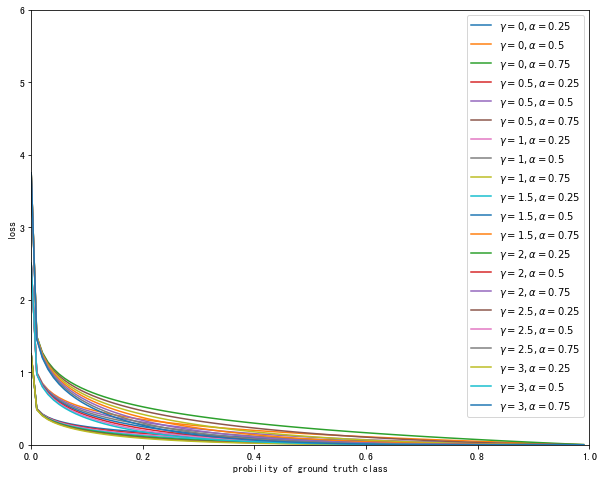

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
gamma = [0, 0.5, 1, 1.5, 2, 2.5, 3]
alpha = [0.25, 0.5, 0.75]
x = np.linspace(0.00001, 1, num=100,endpoint=False)

plt.figure(figsize=(10,8), facecolor='white')
for r, a in itertools.product(gamma, alpha):
    strs = "$\gamma={0}, \\alpha={1}$".format(r, a)
    plt.plot(x, -a * (1-x) ** r * np.log10(x), label=strs)

plt.legend(loc="upper right")
plt.xlim((0, 1))
plt.ylim((0, 6))
plt.xlabel('probility of ground truth class')
plt.ylabel('loss')
plt.show()

上图中我们可以看出对于一些Well-classified examples(Easy Examples)虽然他们单个example的loss可以收敛到很小，但是由于它们的数量过于庞大，把一些hard example的loss覆盖掉。导致求和之后他们依然会支配整个批次样本的收敛方向。

一个非常简单的策略是继续缩小easy examples的训练比重，即给每个乘以$(1-p_t)^\gamma$。因为Easy Example的score $p_t$往往接近于1，那么$(1-p_t)^\gamma$值会比较小，因此example得到了抑制，相对于hard example得到了放大，如上图的$\gamma > 0$的那四条曲线。

FL的求导结果如下:
$$\frac{dFL}{dx}=y(1-p_t)^\gamma(\gamma p_t log(p_t)+p_t-1)$$

$\gamma$的值也可以根据验证集来调整，论文中给出的值是2

### 3.5.3.FL的最终形式

结合$\alpha$和$\gamma$就有了最终FL的形式。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
def one_hot(index, classes):
    size = index.size() + (classes,)
    view = index.size() + (1,)
    mask = torch.Tensor(*size).fill_(0)
    index = index.view(*view)
    ones = 1.
    if isinstance(index, Variable):
        ones = Variable(torch.Tensor(index.size()).fill_(1))
        mask = Variable(mask, volatile=index.volatile)
    return mask.scatter_(1, index, ones)
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
    def forward(self, input, target):
        y = one_hot(target, input.size(-1))
        logit = F.softmax(input)
        logit = logit.clamp(self.eps, 1. - self.eps)
        loss = -1 * y * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss
        return loss.sum()

### 3.5.4.Focal Loss的性质

- 当一个样本被错分的时候，$p_t$是很小的，那么调制系数$(1-p_t)^\gamma$就接近1，损失函数损失函数影响很小；但是当$p_t$接近1的时候(也就是样本被正确分类)，则调制系数$(1-p_t)^\gamma$就接近0，此时易分类样本的损失函数权重被大大地降低了．即易分样本的权重被大大地降低了．
- 当$\gamma$增加时，调制系数也会增加．假设$\gamma=2$，对于一个易分样本($p_t=0.9$)的损失函数要比标准的交叉熵小100倍；当$p_t=0.968$时，要小1000+倍，但是对于难分样本($p_t<0.5$)，loss最多小了4倍。由此可见难分样本的权重相对提升了很多，从而增加哪些错误分类的重要性．

## 3.6.GHM(Gradient Harmonizing Mechanism-损失函数梯度均衡化机制)

对于一个样本，如果它能很容易地被正确分类，那么这个样本对模型来说就是一个简单样本，模型很难从这个样本中得到更多的信息，从梯度的角度来说，这个样本产生的梯度幅值相对较小;而对于一个分错的样本来说，它产生的梯度信息则会更丰富，它更能指导模型优化的方向。对于单阶段分类器来说，简单样本的数量非常大，他们产生的累计贡献在模型更新中占主导作用，而这部分样本本身就能被模型很好地分类，所以这部分的参数更新并不会改善模型的判断能力，这会导致整个训练变得低效。因此单阶段目标检测中样本不均衡性的本质是简单困难样本的不均衡性。研究者对样本不均衡的本质影响进行了进一步探讨，找到了梯度分布这个更为深入的角度，并以此入手改进了单阶段检测器的训练过程。 

实际上，不同类别样本数不同并不是影响单阶段检测器的训练的本质问题，因为背景样本虽然大部分非常容易识别（well classified），但其中也会存在着比较像某类物体的难样本（hard negative），而前景类中也有许多网络很容易正确判断的样本（easy positive）。所以产生本质影响的问题是不同难度样本的分布不均衡。更进一步来看，每个样本对模型训练的实质作用是产生一个梯度用以更新模型的参数，不同样本对参数更新会产生不同的贡献。在单阶段检测器的训练中，简单样本的数量非常大，它们产生的累计贡献就在模型更新中就会有巨大的影响力甚至占据主导作用，而由于它们本身已经被模型很好的判别，所以这部分的参数更新并不会改善模型的判断能力，也就使整个训练变得低效。

基于此，提出了基于梯度分布的角度来缓解one-stage中的训练样本不平衡，从而改善one-stage的目标检测的检测精度。论文提出了梯度密度，并将梯度密度的倒数作为损失函数的权重分别引入到分类损失函数(GHM-C)和边框损失函数(GHM-R)．研究者对样本梯度的分布进行了统计，并根据这个分布设计了一个梯度均衡机制（Gradient Harmonizing mechanism），使得模型训练更加高效与稳健，并可以收敛到更好的结果（实验中取得了好于 Focal Loss 的表现）。

### 3.6.1.梯度均衡机制

#### 3.6.1.1.梯度膜长-Gradient Norm

考虑简单的二分类交叉熵损失函数（binary cross entropy loss）
$$
L_{CE}(p,p^*)=\begin{cases}
-log(p) & p^*=1 \\
-log(1-p) & p^*=0
\end{cases}
$$

其中$p=sigmoid(x)$为模型所预测的样本类别的概率，$p^*$是对应的监督。则其对x的梯度（导数）为：
$$
\frac{\partial{L_{CE}}}{\partial{x}}=\begin{cases}
p-1 & p^*=1 \\
p &  p^* = 0
\end{cases}=p-p^*
$$

于是我们可以定义一个梯度模长，$g=|p-p^*|$,对于一个交叉熵损失函数训练收敛的单阶段监测模型来说，样本梯度膜长的分布统计如图

![Images](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYMAAAEUCAYAAADJB1rpAAAgAElEQVR4AezB%0ACXyV9Z3o/8/v9yzn5GQ5WQgBAiSEfRdkEwRFKYpSl9ZR69qWf/d12pnpeLs5%0AbW2nt9MX1479W2/Vti5jN/dWW3dlEdkRg6wCkpCNbCQ5yTnneZ7f5WCjmIR6%0AtLVk+b7fyhyDQCAQCAYqjUAgEAgGMk2vFRBrPkJNfQtegEAgEAjeHza9kDEB%0AFS8/yzPlTeRY7YTL5nPerDK0QiAQCAR/X5peyCSqueeuhxk2YxFL547iufvu%0AZWezj0AgEAj+7jS9UOL1jbxcHWZoXpTI4CEUxnaz/tV6AgQCgUDwd6b5B0l2%0AtJMI6CYea6GtI4kx/IWh7XAFR51cwiEL5YTIcD2qa49gEAgEAsHfmc37ypCI%0ANbPthYd5+LkGrv7Gl5iYpUnxO5rY9PQjbKgMcBJtjDrzYs6eVoyjwbJtLAzG%0AgDE+SS/AsW0EAoFA8Hdn8z5rb6pl/65ytuyMc5nPm15b9yB3PNPIt/7j8+Q1%0ArOFfv3cLmTfcwBmlUSKlYyj0dxLrSBLoVo7GM5laMhTN23V0dLBjxw5SHMfB%0Atm0cx0FrTWtrK+FwGNu2GWgSiQSe5xGJRBhoPM8jHo+TmZnJQNTc3Ew0GmUg%0AisVi2LaN67oMNPF4nCAIyMjIIAgCEokEnueRTCZRSjFz5kzeic37ShEdNobZ%0Ap03k92tf5k1+I08//ASRcSsoyHAIDz+dUrOSR154hXml83GK5nDWtGfY/dpr%0AZDt78SaczZnjslC8XU1NDd///vfJzMzEcRxCoRBDhw4lIyOD7du3s6vwTAI7%0AgyFugnnZjbjKMBDU1dXR2NjIuHHjGGiOHj3KoUOHmDhxIlprBhJjDOvWrWPu%0A3LlorRlo9uzZQ05ODkVFRQw0hw8fJh6PM2rUKNrb2zl06BC+75NIJLAsi1/8%0A4he8E5t/AKUVCkWn4OhrbN3TwoiFeVhagYowtMDihe278c18HCuTi6++mvXb%0AD7JHZ3P1NYspdBVdOY5Dfn4+I0eOZMmSJcydOxelFCkrV67kwZpRHE0ozi/L%0A59NXTyYv4jAQbNiwgfLycj760Y8y0Ozdu5fHH3+cz3zmM9i2zUASBAFf+cpX%0A+MpXvoJlWQw099xzD6NHj+aMM85goHn66adpbm7mQx/6EJ2eeuopXnzxRQ4c%0AOEA6bE4Bv6mJ+iRMzAijSVGEQw7NdQ14gKMU0WETOGfwGAI0tm3RE8uyyM/P%0A5/TTT2fYsGF05WiO8wODHxgEAoFgICgpKSEej3PkyBHSoTkVLAtLK7RSvMGQ%0A9Hws20HRSWHZDo5toehZEAQ0NzdTXl5ObW0tJ8rNzcW1NCleYPANA0YoFCIn%0AJ4eByHEccnNzGagGDRrEQJWdnU04HGYgikQiZGZmcqLDhw+zY8cOYrEY6bA5%0ABeyCIkZkKppaYgSAhU9TczvFI0fgkD6tNdFolEmTJlFYWMiJrrrqKn7w400Q%0A68APIDCGgWLSpElMmDCBgWj48OFcfvnlWJbFQKOU4qtf/SpaawaiZcuWobVm%0AIJo1axbGGE40bNgwJk6cSEVFBenQ/CMYjjF0UhmlzJleRNXr1SR9A149lc0h%0AZp8+Dq1IWxAEtLe3U1VVRUtLCycKhUI4tibFDwxBYBgobNvGdV0GIsuyCIVC%0AKKUYaJRSZGRkoJRiIHJdF9u2GYgcx8F1XU7U3NxMVVUViUSCdGjeZ8nWBg4c%0AOkxLyxEO7q+iPemDDrP4ymsoqNvIpp272fzEYwQTP8Sl88cDinRprYlEIhQX%0AF5OTk0NXIVuT4gUG3yAQCAQDQm5uLsXFxYRCIdJh8z4zQUD+uIV88YuzGBz2%0AMYZjFAVl8/jUdSE279lJozuGT31yDiNybBTpM8bQ3t5OdXU1I0eOpCtHK1J8%0AYwiMQSAQCAaC5uZmqqurSSQSpMPmfebmDGba7MFM4+2UFWL4xLkUT+QvFIp3%0Ax7IsioqKWLRoEUVFRXQVsjUpfmDwA4NAIBAMBOPHjycnJ4c9e/aQDs2ppBRK%0AKZRSKMW7lkwm2bNnD3fccQebN2+mK8dSpPiBITAIBALBgLBq1SruvPNOqqur%0ASYdNH+a6LlOmTGHFihVEo1G6ci1NihcY/MAgEAgEA8GyZcuYO3cuK1euJB2a%0APswYg+d5tLW1EY/HMcZwItdWpPgBBAaBQCAYEDo6Omhra8P3fdKh6cOSySS7%0Adu3i1ltvZcOGDXTlWpoUPzD4xiAQCAQDwXPPPcdtt91GVVUV6bDpwxzHYfz4%0A8Vx77bUUFBTQlWMpUjxj8AODQCAQDASLFy9mypQp3HrrraTDpg9TSmHbNpFI%0ABNd16SpkaVJ83xAYg0AgEAwEoVCISCSC1pp0aPqwIAhobm5m165d1NXVYYzh%0ARI6lSfGNwTcIBALBgFBVVcXu3buJxWKkw6YP832furo61qxZg2VZDBo0iBO5%0AtiLFCwxBYBAIBIKBYO/evaxfv56WlhbSYdOHOY7DmDFj+PjHP040GqUr19Kk%0A+IHBNwgEAsGAsHDhQiZPnszKlStJh6Yfcy1FihcYgsAgEAgEgm40/ZhrKVL8%0AAHxjEAgEAkE3mn7MsTQpvjEEBoFAIBB0p+nD4vE4W7Zs4YYbbuDJJ58kCAJO%0A5NqaFC8w+IFBIBAIBoL777+fr3/96xw4cIB02PRhoVCI6dOn8/GPf5zc3FyU%0AUpzItRQpfmAIjEEgEAgGgksuuYRFixZx8803kw6bPk5rjWVZaK3pyrU1KYEB%0ALzAIBALBQGBZFpZloZQiHZp+zNGKTp5vEAgEAkE3mn4sZGs6xf0AgUAgEHSj%0A6cccS9Ep6RsEAoFA0I2mH3O0QvGGhGcQCAQCQTeafkxrhVYcl/ADBAKBQNCN%0Apg8zxpBMJmlpaaGjowNjDCeytcLSipSEHyAQCAQDQXt7Oy0tLfi+Tzo0fVgi%0AkeDVV1/l5ptvZt26dXRlKYWlFSlJ3yAQCAQDwZNPPslPfvITKisrSYemD9Na%0Ak5mZyYgRI4hGo3SlNViK4xKeQSAQCAaC/Px8RowYQSgUIh2aPkxrTXZ2NmVl%0AZeTl5dGVrRWWVqQk/ACBQCAYCAYPHkxZWRkZGRmkQ9OH+b5PY2Mj27dvp6am%0Ahq4spbCUIiXhBwgEAsFAUFFRwfbt22lrayMdNn2YZVkUFBQwZ84chg8fTleW%0AVmitSEn4BoFAIBgIRo0ahed51NXVkQ5NHxYEAc3NzZSXl1NbW0tXWoOlOC7p%0AGwQCgWAgOHz4MDt27CAWi5EOmz7MsiwKCgqYPXs2xcXFdGUrhaUVKXEvQCAQ%0ACAaC0tJSjDEcOnSIdGj6MN/3qa+vZ+PGjVRWVtKVpRWWVqQk/QCBQCAYCA4e%0APMjmzZtpbW0lHTZ9mG3bDB8+nOXLl1NUVERXllZYSpGS8A0CgUAwEEybNo3B%0AgwdTVVVFOjR9WDKZZN++ffzqV79i69atdKWVQiuOS/gGgUAgGAjWrl3L3Xff%0ATU1NDemw6cNc12X8+PFcf/315Ofn05WtFZZWpCS8AIFAIBgIFi9ezNSpU7nl%0AlltIh00fZ1kWoVAI27bpytJgaUVKMjAIBALBQOA4DqFQCK016dD0YfF4nG3b%0AtnHjjTfyzDPPEAQBJ7KUwlIcF/cCBAKBYCB4+OGH+c53vsPrr79OOmz6MNd1%0AmTx5Mtdeey0FBQUopTiR1gpLK1KSfoBAIBAMBOeffz6nn346t956K+mw6cOU%0AUti2TSQSwXVdurK1wlKKlLhnEAgEgoEgFAoRiUTQWpMOmz4sCALa2to4dOgQ%0Axhii0ShKKTpZCrRWpCQDg0AgEAwE9fX1VFZWEo/HSYemD/M8j0OHDvHwww+z%0Ac+dOurK0wtKKlIQXIBAIBAPB1q1beeSRR6ivrycdNn2Y67pMmDCBFStWEI1G%0A6crSCktxXNIPEAgEgoHg3HPPZcaMGaxcuZJ0aPoxSyksrUiJewaBQCAQdKPp%0AxywNllKkJP0AgUAgEHSjSYvBGIMx9DpBEJBMJvF9H2MMJ7K0QmuOS/gGgUAg%0AGAg8z8PzPIwxpMOmB+21e3h+/W5yho1l+qRCVt93K/c8+SrjFn2Yj1+znGFZ%0ANopTLx6Ps23bNm688UYuueQSzjnnHJRSdLKUwlKKlIQfYIxBKYVAIBD0Z488%0A8ghPP/00R48eJR2aHnS0vMa6DftxsiMcfukBbrnraYacvoQyt5IXN+/DN/QK%0AoVCIGTNmcNNNN7FkyRK01pzI0gpLK1L8AAKDQCAQ9Hsf+tCH+O53v0tpaSnp%0A0PTAb4kx4/zLmVakePz+RwlN+xBf+sw1LD1rPsTq8Ax9gqUVllKkGAyebxAI%0ABALB22h6YOfkUvXyMzz8mzt45GWPi6+8kGK3g1deeo7qdheteN/5iRiH9u3m%0AYHUTXsB7YimwNMcZIBEECAQCgeBtbHqQM2IOc0Y9xGNrfK78yjdYPjmXDU88%0AwJo9MSYszUfz/jLJRh667b9Zu6eKyppW5n3ky3z+4tOxFe+KpRWWVhxnIOkZ%0ACCEQCASCt9j0QDuZzDz3wxSNOYjKHUmmm2D4jAv49/PzsbXi/ebVHiA65zq+%0A98nBbH3oZlY+/gRXLD+doTbvilIKWytSDJAMAgQCgUDwNpoeeLE67v3BF7n6%0AE1/miVfq0Nrm8OZHue3eP1Mb8zC8v+yh01g8u4QMN4OS0eMZOmwQGYr3xLU0%0AnZK+QSAQCARvo+lB88F1PL/b4dIPLyYbg3YzOX3xIprW/oY/bDhIYHhHJgiI%0AtcXwDN348TbqG1vwDD1S2sLSCmM8Dh6qZ86ZZ5Bj8Z44liLFGEj6AQKBQCB4%0AG5seJFvamH3F51g+toIt1RwXeHGaj9RydH8lyYWjsRQ9Miagbv8WHrzrTrYy%0An/+44SoGhxTHmQQ7Vz3IA+tqGFHoUtEc4eqPXsHI3BCv/PE27nl+HyZcyHlX%0AXcM54wfTeGArhxjDsvkT0XQXBAGxWIzDhw8Tj8cJhUJkZmZi2zadQramU8I3%0ACAQCQX/leR6tra3E43GOHDlCIpEgHTY9yBg6EndfNbFEgDGGZHsTa++/jw01%0AHh8eVoit+KusUBZOspmjJuBNxhCv3s7d973AnE9/hwvHBfz2x//BPX+ayFev%0AmEXhmJkstkowdialBVm0VO9hbXkjZ557NtGQIen52LaF4i3t7e1s2LCBl19+%0AmcLCQkaOHMmVV15JSUkJnRxLkWIwJH2DQCAQ9FeHDx/mtttuo76+noaGBpRS%0ApMOmB9lDZzI+4x7u/MV6Xq/x+NV/HWR/XcBZl3+eyxeOx1aclFKaguIyRo8Y%0AxNOv8xaT4OXn/8irbYP56LgC7AyPmdNL+O1vH2L3khlMHT+b88ZzjKG16mV+%0A9P2f0J47ivLyTcQ7As657issKMvgRKFQiNLSUqZPn87cuXOZNGkSSilO5Fqa%0AFAMkfINAIBD0VyNHjuSmm25i48aNbNu2jY0bN5IOmx5oO8zsZVdSNG4mu/fu%0ApzlhM6RkLJMnjaEgQ5MOxdsZr52D+/ZjsmaS43CMJjc3n1jTy1TXtTJlUC6K%0AN2g3lw9cdi2e4Tg7YxDTRmageDulFOFwmEGDBhGJROiJaymOM5D0AwQCgaC/%0Ay87OpqCgAMdxSIfNSVihLEZNmsmoSTPp5He0U9vQREFeLpbiXTGeR3NTC0Qy%0ACWuOUTiOg5fsoK29g7coIgUlnHlWCe/E932OHDnCxo0bKSgooLS0lK5cW5Ni%0AgKRvEAgEgv5u//79bNq0iZaWFtJhc0zgHeXVLTs46hn+mpbqQ9SER/JP583D%0AUrw7WuOGHFQswBiOMSSSSbTlEHId3gvbthk2bBhLly5l9OjR9MS1FJ2SQYBA%0AIBD0d5MnTyYSifDQQw+RDptjjNfC//zwKzxV7RKNhFCKHhgS7TDn+hv4J949%0A7YQZUTIc9VIjLT7kWoajzY2Ec4ZQNCgHxbvneR61tbWsWrUKx3EoKiqiK8fS%0ApBgDCc8gEAgE/d2ePXt48cUXOXr0KOmwOUa7RVz48c9xTnQKY4bncjKxI9Xs%0A7wiheGfGGDCGN+kwk2fPJ3f187xeG2f4kDj791dQevpiygbZvBe2bVNcXMzy%0A5csZMWIEPXEtRadkYBAIBIL+btq0aRQUFHDvvfeSDptjlLY4/dxLQbuEHJvj%0AggS1hw5wsKoe42QyrGQU44YPp8wPcBUnZUzAkYM72L73MEfqsinfVUHe1BE4%0ASlM4dQlXnPUqqx9/DMoU62uH8NFPnkuurXgvPM+jsrKSRx99lHPPPZc5c+bQ%0AlWtpUgyGpBcgEAgE/d22bdtYt24d9fX1pMPmOEUoFKFToqWah37+Y+59chvt%0AgcZ1XcI5RZx98TV85KIF5Cv+CkX2oJFc+sX/5HzfITc/H4u/sLI5+4pPM3LP%0Abuo7XK793GJGDs7kvXIch7KyMq666ioKCwvpiWspjjOQDAwCgUDQ382fP58x%0AY8Zw2223kQ6bbgJee/5ubnngZRZc8hGWzJ1IbqZNe1MN61c9yYNZuVx3/jRc%0AreiJUopwVh7FWXn0xM3MZ8Jp8/h7SCaTvPbaa9xzzz2cc845zJkzh65cW5Ni%0AgIRvEAgEgv7uxRdf5MUXX6S2tpZ02HQTcKTmCBMv/CRf+dwlFGZYvMEwbcwI%0AfrfqdeLJqbghhe95KMtGK04Jx3EoLS3lyiuvpKioiJ64liLFAEk/QCAQCPq7%0AOXPmMHLkSO644w7SoenGYvwZSxiT7REEhrco/GQcpW2UUkBAxc5dNAWcMkop%0AQqEQ+fn5RCIRlFJ05Vqa4wwkfYNAIBD0d1lZWeTn52PbNumw6Sagobqa1zY8%0AwTf3bKAoJ4MU48c5uKucZO5oXtuxBuW3E3en8KWvTwaLUyIej7N161a+/e1v%0A88EPfpDFixejteZEjq1IMUDSNwgEAkF/99BDD/Hss8/S2NhIOmy60YSdOI1t%0ANiOG2CSTSd6gKR47lRQvmYTAx7iGUykUCjF16lSuu+468vPzUUrRlas1nRJ+%0AgEAgEPR3F1xwAXPmzOGnP/0p6bDpRlE040Ju+PbZjBs/ElspOhnfoyPpEwqF%0AUPi8Xr6LkOaUsiyLcDiM4zj0xLUVKcYYkr5BIBAI+jvXdQmHw2itSYemB+Gs%0AoUyfOoawY5NijMEYQ2vNIbbsOgC2g+uGKZs2hXyLU8YYQ3t7O1VVVRw9ehRj%0ADF25lqZTMggQCASC/q6pqYmqqioSiQTpsOnG0HRgPf910//mhfJK4r6hU+CH%0AOfszNzJ3Jsdpy+JUSiaTHDhwgF//+tcsXbqUM844g65cS5FigIRnEAgEgv5u%0A/fr1rFmzhrq6OtJh043PjmfuZ3NbKZ//xmcZmu3Sqb2hlrpwhN7CdV0mTpzI%0AihUriEaj9MSxNCkG8AKDQCAQ9HdLly5l1qxZrFy5knTYdKPJKxrBzIXjWHbe%0AOWRbik5+rI3K5lYsRZ8RshXHGUh4AQKBQCB4G003mlHzP8hEp4p9FUeIxWLE%0AYjFisRhN9dXsP1xHYOgzHEuTYoBkYBAIBALB29h0Y2hvOsz2Vfdzy+0/Q1sW%0AnbykxcJP3sjcGfQKxhg8z6Ojo4NIJIJt2yilOJFrKTolfIMxBqUUAoFA0F8l%0AEgk6OjoIgoB02HTj8+qzD7E1Ppovf/tfGFWQQafYkSqqnCx6i0QiQXl5OT/4%0AwQ+46KKLOPvss1FKcSLX0nTyA4MBFAKBQNB/PfbYYzz77LM0NjaSDptuNPnD%0ASplz1hguWHoW2RZv8tvaqGhuxVL0CqFQiOnTp7NixQqi0Sg9cW1FJy8wBIFB%0AWwqBQCDory655BIWLVrEypUrSYdNN4ri6ecwpmIdu187REleBp06Guo40BIw%0AZEgRKPoEx9J08gNDYBAIBALBW2y6Cdi/9mHuufuPtN97F2HbopOX0My5/t+Z%0AO2MyfYVjKTp5gSEwBoFAIBC8yaYbzbCp0zlnWS4zZo8j7Fgo3tBaV01TdiZ9%0AiVYKWyu8wOAFBt8gEAgEgrfYdKPIHbWQj62YQ2FhPppOAYe2b6QuswRb0ae4%0AlsILDF5gCIxBIBAIBG+y6YEKfI7s28KqZ2qJez7GcIyhsnwdDcOWM+HT52M7%0Air7CsRQkwQ8MQYBAIBAI3mLTjeHwhgf4+nfvw2TYxDtscvMiKD9GXbPLB6Zl%0AoxR9imtpwMcLDIExCAQCgeBNNt14VByo5+rv3cmZhfU88fxOzlq2lPxwgrUP%0A3EdiTAmuRa9gjCGZTNLS0kI4HMZ1XZRSnEgBrqVI8XxDYAwCgUDQn7W3t9PS%0A0oLv+6RD040iHA6jtCJaVMrIcDPlrzeSlVNAXqiZP//5RdqT9ArJZJI9e/bw%0A85//nI0bN3Iyjq1J8Y0hMAgEAkG/9sILL3DHHXdQXV1NOjTdWJSeNolVP/oU%0An7vpAcaeOZeX7/k+11x5Of/2309j5WSjFb2C1prMzExKS0vJzc3lZFxLkeIF%0ABt8YBAKBoD8bNGgQJSUlhEIh0mHTjSJ31Jl87bv5VCdzGTxsBCu+8Bmeee4l%0A2jNHsuDs+YRtRW+glCIUCpGbm0tGRgY9UuBoTYofGIIAgUAg6NcikQi5ubk4%0AjkM6ND1IHK3HGTqFmZNKcJWmsGwGV3z8E5w7Mcq27TtJGHoFz/Ooq6vjxRdf%0A5NChQ/REAa6tSPF8Q2AMAoFA0J/t27ePdevW0dzcTDo0PWgof5JfPbye1kSA%0AwUCQYP+GP/LDH9zMpkMxegvHcSgpKeHyyy9n8uTJnIxjKVJ8A4FBIBAI+rVZ%0As2Zx2WWXUVhYSDo0PXAysmnd+wJ33vV7tpW/zD0//l986t9/SnLIJEYPjtBb%0AeJ5HRUUFjzzyCLt27eJkXEuT4gUBgTEIBAJBf7Z161b+8Ic/0NDQQDpsehAd%0Acyaf/+JCtj1yK9/7l5/T7I7gmn/7AcvnT8RWAa6iV3Ach7KyMq688kqKioo4%0AGddSpHgBBAaBQCDo1xYsWMDo0aO54447SIdND+pf/gPfvPMZ9r1WzdQPXMSy%0AfI3jx/F8H6MCDL1DMplk37593HnnnZx//vksWLCArhTgWpoUzzf4gUEgEAj6%0As9WrV7Nq1SpqampIh00PvEQLB6oDrvzqd7hsyelkmWa2rXmK2//PM+TPOJeP%0AXXQGluKUc12XCRMmcP3115Ofn0/PFI6lSPGNITAGgUAg6M+WLFnCaaedxi23%0A3EI6bHoQzivjSzddzrIZRViKYwYxe+kVFOY9zUtNDoreIZFIsG/fPn75y19y%0A9tlnM3v2bLpR4FqaFM83BAaBQCDo19asWcO6deuoqakhHTY9yJ24iPktR9m0%0A6hmyy2ZRlu9x8FADg8adwYWuhaPoFRzHYfjw4Sxfvpzhw4dzMo6lSPGMITAG%0AgUAg6M+mT5/OoEGDuPvuu0mHpgeB18g9N32Bz93wPdbubcRyI/hVG7j9Fw9S%0AF9coRa+glCISiVBcXExOTg5KKbpSgGtpUnzf4AcIBAJBv5aXl8ewYcNwXZd0%0AaHrQvG89e/UcvvG1aynUoO0wE85YgP/q4zyydje+oVeIx+Ns2bKFr3/96zz1%0A1FMEQUBPHEuR4gWGwBgEAoGgP3vggQf45je/yYEDB0iHTQ8CL2DG0kuZO/og%0Am6s5zmttpKqmgUhdI74BW3HKhUIhpk+fzsc+9jFyc3NRStET11Kk+MYQGAQC%0AgaBfu/jiiznzzDP5yU9+QjpsepA1ciLW9u3sjwS0tjTw+u5Gnrjnv9naGuHT%0A40uwFb2G1hrbtrEsi5NxbU2K5xsCYxAIBIL+zLIsbNtGKUU6bHoQKRjP6aN2%0A8/tH/8yW3ffxi9Y6mkwBl6z4MhfMGI6l6BWMMcRiMSoqKkjJyclBKcWJFOBo%0ARYoXGAJjEAgEgv6soaGByspK4vE46bDpgbJcJi28iK9MP4u62mpaEhaDioYy%0AKC+HkKPpLZLJJAcPHuSBBx5gyZIlzJs3j24UuLYmxQ8MQYBAIBD0a5s3b2bt%0A2rXU19eTDpuTUJZDdt4gsvMG0Vu5rsvEiRNZsWIF0WiUk3EsRYoXGHxjEAgE%0Agv5syZIlzJw5k5UrV5IOzTHGGFqPHGL3/sN4hn7HtTQpXmAIDAKBQCB4i+YY%0A47fx4E9u4H+tvJ+jAf2KAhxLkeIbCIxBIBAIBG/SHON37Gd3w3C+8IWPkKeh%0A5cBmNu9rxPB2fryDhuaj+IZewRiD53nEYjESiQTGGHriWppOSd8gEAgE/Vk8%0AHicWixEEAenQHKOdAibPnMG44XmAofXwDspfP0pgDMYYjDEYY4g1VLFpxx6S%0Ahl4hkUhQXl7Oj370I1avXo0xhp44lqJTwg8QCASC/uxPf/oTP/7xj6moqCAd%0ANsdodwjTSxL815c/xutH2kjEGjka/JaHbnF4i6G1sY3pV32NhXPpFUKhENOn%0AT2fFihVEo1FOxrUUnRJegEAgEPRnF198MQsXLmTlypWkw+YYpTTjF13Gl4dP%0A5ZUduzhQvpZXE2XMGJXDWwwNFQcJsiz+YYzBGINBobXivbItTaekbxAIBALB%0Am2z+QjsZjBh/GiPGn0bTxCFs9SaxaEohmrckjjbyWn0LluIfwhiPV559mAOZ%0Ap/PBeaN4L5RS2FqhFQQGEr5BIBAIBG/S9CA6dj4LJhSA79HR3k57RxwvCHCy%0AcxlXMhxb8f4zhljNK9z7i/vYuPcIfwtLKyylSEn4AQKBQCB4k00PlLZJ1B/k%0A6Ucf4Ml15cTtXCbNXsjyC5YwZnAW7z9DsqWSZ5/bwYjJZTQq/ia2BktDMoCE%0AZxAIBALBmzQ9SLbX8buf3sStv3mOdjeXwrwwFVuf4Nbb7mNfYxLDOzPGEAQB%0AxtCNCQI8z8cYemQCjx2bNhIeO5uyLMXfylIKrRQpCT9AIBAIBG+y6cHRgy/x%0AanwK/3n7j5g+PJc3eGx75rds2rKHksWTsBUnFSTa2Lt9I7saszj77Jlk24pO%0AHU0VvLRuC80JRX7JZOZNLcXWiqbKvRysawXLJeJXsLk6wjkTctiU8Eh2tNHW%0AkSQSdlC8e5ZWaKVISfgGgUAgELzJpgd+WztTz7mIKcW5vMUimhulZX89nqO4%0Ak2EAACAASURBVAFb0SMTeOzd8hz33n4H+wdfytyFM8m2OS6I1/HIL26jtmQZ%0AF0xyeeCe22m1vsTSyYPZu/p+bvnjK5jIYKYUeWx9vZ2Xnr+fugO7aI408YcJ%0AJVy2YBQWbzHG0N7eTm1tLb7vEwqFCIfDWJbFiWytsDTHJfwAgUAg6I9836e9%0AvZ14PM6RI0dIJpOkw6YHocHFtGzaxOFZQxmRG8ZPtHKgfD3/c88fKTzvC9iK%0Ak1LaZtzcpZy14XH2HuYtJqBqyxM8uqmNL109h7JBCeaV/Y477nucGd+6jllX%0AfI1fXsFxQeDj+wEESZ667UY25X+YfzqjFM3btba28vzzz/PCCy8wduxYpk2b%0AxoUXXkhxcTEnsrRCK0VKwjcIBAJBf1RbW8uvf/1rXnnlFSoqKsjKyiIdNj3I%0AKprKmNBzfPuLD+EBsaYGGlsTlC24gmvmjcFSvCPbtjmRCWKUb1pPa6iYwXk2%0AaM2IkSOpeWwdr1VfzuCSDBRv0NpCawsTQHRwMUNystBa0VUoFGLMmDFMnjyZ%0AadOmMX78eHJzc+nK0gpLK1KSXoBAIBD0RwUFBXzkIx9h+/bt7Ny5k1deeYV0%0A2PTACuVw7ke+QNHYNaxet4W6dptRU+bwgXPOYGiOw3thEgmqK2sgezJZmmMU%0AmZlZJGIN1De1QEkGXSntMP/KLzGfnmmtCYfD5ObmMnjwYAoLC1FK0ZWtFVpx%0AXMI3CAQCQX/kui5DhgyhpqaG6upqbNsmHTYnoUM5TJ1/PpPnLsEPwHZstFK8%0AZ8bg+z7KtrEVxxiMMQTGEBjDe+H7Pg0NDWzdupXi4mLGjRtHTywFllKkJPwA%0AgUAg6M9ef/11tm3bRmtrK+mw+SuUUli2g8XfTtk2OdFsqIoTDwAN7R3t2G6E%0AnMxM3gvHcSgpKWH58uWUlpZyMpZWaK1ISfoGgUAg6M9mzZpFYWEhv//970mH%0A5h9EOREmTJuC3XyYI+0BmCS11VXkjZhGydAIinfP8zwOHz7MY489xp49ezgZ%0AWyssxXFxL0AgEAj6s+3bt/P444/T0NBAOjTvgvE8Yh0dBIZ35Hsege9jDG9Q%0ANmPnfoBJOXW8uvcIyVgD28rrmL/sfIZnat4Lx3EoKyvj+uuv57TTTuNkLK3Q%0ASpGS9A0CgUDQny1YsIDrrruOoqIi0mHTAxP4NB85THVdMwnPx/CGjoYjVOlc%0Azl94OmFFj0wQULnjRXa3RikOH2Hzlt2cM3c8Ia1wB03h05/9CA8+ez/3bXPQ%0Ap1/Fxz8wHkfxniSTSfbs2cNtt93GsmXLWLhwIT2xtcLSipS4HyAQCAT92fPP%0AP88LL7xAdXU16bDpQdPe1Xzvezez7VA9cS/AGEOK77ks/MQ3OX8hJ6W0ZviU%0ARXxqyiK6UYohExfysRHTaElocvOiOJr3zHVdpkyZwooVK4hGo5yMVgqtOC7p%0AGwQCgaA/u+CCC5g3bx4rV64kHTbdeLz8zEMcyJnLjTdfSkl+BMUbYrWV7I25%0A/E2UJpydR5i/XTKZZPfu3fzsZz9j8eLFzJ49G6UUXdlaYWlFSsILEAgEgv7s%0A2Wef5aWXXqKqqop02HSjGTlxGtODoUydNJaorejk5+eR0dyGpegVLMti2LBh%0AnHfeeYwcOZKTsTRoxXEJ3yAQCAT92ZQpU8jJyaG+vp502PQgs3gKOWv/zGN/%0AdijNj9CpveEIdeEhXFw0GEdxymmtiUQijBgxgmg0ysnYWmFpRUrCDxAIBIL+%0ALD8/n5RQKEQ6bHpwpPw5HvnDn/CfeBbX1nTykzZzr/83LqZ3iMfjbNu2jW99%0A61tccsklnHvuuSil6MrSCq0UKUnfIBAIBP3ZQw89xNNPP01LSwvpsOlGM3z2%0AYv6/z09j7oLJhC1Fp1jtYV6Lh1D0DqFQiBkzZrBixQqi0SgnY2mFpTgu4QUI%0ABAJBf/bhD3+YxYsXs3LlStJh04OsomksX9ZKU9Ve1mwsJ+7kMWnmLCZMmEax%0AAkfRp9haobUiJREECAQCgeBNNj0Jkmx+9Kf88P8+RntGHrmZLvf/7j5mLfsY%0An71mKRFFrxAEAW1tbVRUVJCSk5ODUoquLKWwlCIl4RkEAoGgP2toaKCiooJ4%0APE46bHrQWrWZR1+o5sobfsxZU0YSciz8ZAsbnnmCtdsnc8GsEWjFKed5HocO%0AHeLBBx9kyZIlzJ07l55YWqEVxyV8g0AgEPRnmzdvZu3atdTX15MOmx60V1cw%0A8ZIvcNWyCTiKvxiKnnuYZ3YfJGlGEFKccq7rMmHCBFasWEE0GuVkbA2WVqQk%0A/ACBQCDoz5YsWcLMmTNZuXIl6dD0wInm43Q005H0SQn8JEfrK1n37CoaggyU%0Aok+xtMJSihTPN/iBQSAQCATH2fQgq3gq5oGV/PBHqykdkktHUzWvbtvIAb+M%0Ab3x/LI6iTwnZmqyQRUoyMFQ2dzAyLwOBQCAQoOmBkzmEyz72Cabkxlj95B95%0ActVmgmFn8o1vf43ZI7JR9A7GGDzPIxaLkUgkMMbQE1sr5o7MIaUt4fPiwaMI%0ABAJBfxWPx2lvbycIAtJh0wOlNFlDxnHFZ7/ORdc205ZURHOjWIkOausbKBxU%0AgK045ZLJJLt37+ZnP/sZS5cuZf78+fREKcWi0bmkdCQDNh06ymXTBmNphUAg%0AEPQ3zz33HGvWrKGqqop02BwTJJt46g/PUrZgKWMGZ3Bo6/M89/IhDG/X3tCA%0AKZvDR5fPx1acco7jMHbsWK6++moKCwv5a6YNzWJwlkNta5Itla00xJIUZrkI%0ABAJBf7No0SImTJjAbbfdRjpsjgm8Rl56YRXu5DMZMziDWMUGfn7rY+QNLcC1%0ALRRviLclmXLZdHoLpRSO45CdnU0oFOKvCTuaWSNyeOzVel6taeNIW5LCLBeB%0AQCDobzIyMsjOzsayLNJhc4wVLuHff/ifaNsBFCPO/BA/WLmcGTNGY/GWRHMD%0Aexva0Io+J2RpFo2K8vjOeiqPJiivbmViUSYCgUAw0GmOUUrjuC6WVqSEs0uY%0AedoYMkIhQqEQoVAIhyR+OI8pY0px6HuUgklDMomGbVLWHjiKQCAQCND0oHb9%0Ab/n9umoMb1E64KX7f84T5XUY+h6lFFOHZlEcDZHyzJ5GEl6AQCAQDHQ2bzIc%0APbiNR5/ZRO3+zexJHia2O4riDSZIsGPtanLDs1gybSgh+p7iaIjSvDDl1W1U%0AtybYeyTGpCFZCAQCwUBm8yZF9ojJzBm/h//z2G72mxaS9WEUnRTR0Qu45MxJ%0AuIo+ybE0547N44+v1nO03WPdwaNMLMpEKYVAIBAMVDYnUNph7LxL+LcbMtjR%0AMYn5UwahAGMCDJpwRoSwa9ObBEFAMpnE93201iil+GsWlEZRQIcXsO1wK0nf%0A4NoKgUAg6C88zyOZTGKMIR2arrTDyOnnMSn7MC+9fBAnKwc7Xs/2LS9T1dRB%0Ab5JMJtm3bx+/+tWv2LJlC+koGxShrCCMATZVttDY7iEQCAT9yZo1a7jrrruo%0AqakhHZoexI5s55bvfYc7HnyRVgPh3KGMyGrif35+Dzvr4hhDr+E4DtFolHA4%0ATDoijmb2iBxSXj7cyuuNHQgEAkF/EolEiEaj2LZNOjQ9aDn4KoOX/Asrv3kt%0AhRZYboTSGfPIrHmeh9fswKN3UEqhlEJrjVKKdGQ4miXj8slwNC1xn3s3V2OM%0AQSAQCPoLpRRaa9Kl6YGTnUtx8TAKskOkmMCnuWIXuw800xrrIKB38H2fpqYm%0AXnnlFWpqakiHUopzx+YxKj9Myp92NlDRFEcgEAj6i8rKSsrLy4nFYqTDpgdZ%0Aw6eT+MPt3NkwlXHDcjlavZenH3mAl/3hfOu0sTj0Do7jMGrUKJYvX05paSnp%0AKskLs2xCATtqYhxs7OCxnfV8Yt4wtFIIBAJBXzd37lyGDh3Kb3/7W9Kh6YGb%0ANYyL/+lirEPrufNn/z+/+PUfaYzO4Gvf+l+cNb4AregVPM+jsrKSxx9/nD17%0A9pAupRRXzRxClmvR4QU89EodzR0eAoFA0B9s376dxx9/nMbGRtJh0wOlNHml%0AM/jE16bxkaYGYr5Fbl6Uur0vU9XYTsmgCIpTz3EcRo0axRVXXMGQIUN4N8YM%0AymDJuDweeuUIz+9rYldtjHklUQQCgaCvmzdvHiUlJdx5552kw6YHfkcz5RvX%0AseNgLXHPxxiOMRx+dT2Nwz7If3x2GRFHcaolk0n27dvHL3/5S8477zwWLFhA%0AurJDFpdOLeTJ3Y20JXzu2ljF7BE5WFohEAgEfdnq1atZvXo1NTU1pMOmG8Ph%0ADQ/wre/9BjJt4h0OeXkRlN9GbZPL0plRtKJXcF2XyZMns2LFCqLRKO+GUoql%0A4/IZkRtiZ22Mp3Y3sr+hnTGDIggEAkFftmzZMubOncvKlStJh003HhUHG7nu%0AP3/JmYPq+fOzOzjrgvMoCCdZ88A9xEaNxLHoFZLJJHv27OGOO+7grLPOYubM%0AmSilSFdRtssVpw3mP544wP6GDn61oYpvLR2FY2kEAoGgr1q1ahXr16+nurqa%0AdGi6UYTDIXzfJ2vQSIaHm9i2/wgZWblE7Wae+PNa2pP0CpZlUVRUxMKFCykp%0AKeHdUkpx2bTBjIiG8ALDLzdUU9kcRyAQCPqysWPHsmDBAqLRKOnQdGMxasYU%0AVv/ok3z6u79j3MIzKL/3Jq687EN89SdP4eZF0YpeQWtNZmYmpaWl5Obm8l6M%0AHxzhk2cMw7EUFc1xfvzc6yT8AIFAIOirCgoKKC0tJRwOkw7rxmN4G0W8pRE/%0AbxwfWLKA0aWjmTS+lMxwFqed/UEuX34mg7JCKMUp19jYyH333ceGDRsIhUKU%0AlpailOLdsLSiJC/Mg9vraGr3qGlNsKgsj+JoCIFAIOiLHn30Ue6++25qamq4%0A9NJLeSfWjcfwNh4bf3czvz8whCs+OI8sWxPJLWLS9JlMHV9K2AbbtlGKUy6R%0ASFBdXc0///M/M2HCBJRSKKV4t6JhG9fSPLGrnsZ2n7aEx4UTC7AtjUAgEPQ1%0A48aNY86cOezcuZNzzjmHd6LpxmLMnLMYk+0RjyfwPA/f9/F9n6M1B9nwyh6S%0A9B5KKbTWaK1RSvFeKKW4cFIBM4qzSXm4/AhbKlsxxiAQCAR9jdYarTXpsukm%0AoOa1V3n2gUd46k/3kB126BRrjjHtqq8xdyagOOWMMcRiMSorK0nJyclBKcV7%0AMTI3zJcWDucTv9tFWyLgyw/t5tfXTqE0P4xSCoFAIOgrGhsbqaysJJFIkA6b%0AY4zx2fviIzxzIItrrlxCUVkpU05fwuTpo3BtjeIN7Y0N+IND9BbJZJKDBw9y%0A//33s2TJEubNm8d7pZTi4imF/GZrLY/uqGdLZSs3rzrEjz44BsdSCAQCQV+x%0AadMm1q5dy5EjR0iHzTF+vJJf3vJ/aZ31KQyK3NIzWPHZMxg/phiLt/jtbdS0%0AtGMregXXdZk4cSIrVqwgGo3yt8oK2fznhaPZV9/OjpoY/726gkVluVw6tRCl%0AFAKBQNAXLFmyhJkzZ7Jy5UrSoUnxWxk87cN8acUFZGloeW0Texs0irfz4u3U%0ANx0loP8aNziTG84tIeJoAgM3PXWQV6raEAgEgv7K5hgdLmH8sGdZ9/Sf2ZcT%0A4eieTWxNdhBpKUDRydB0+CD10QmMHVMGin7J1oqrZg7hhdeauf2lw2yubOFf%0AHt3DAx+dRmbIQiAQCPobm2OUjjDv7IU89Ntfc8facpqPNtAavMSWJ2zeYuiI%0ABcy65t/oTXzfJx6P43kelmWhlOJvpZXiX88eyc6aNlbtb+apPY388JmD/Pu5%0AJURcC4FAIOjNkskk8XicIAhIhzLH8BfGGOJtzexf8xue65jLJXOHoOhkaDiw%0Ai/LWDD54zlzCmlPu8OHDfOc732HUqFEsXryY2bNno5Ti72XjoaNcePs2aluT%0A5IQt/veFo/nU/OEIBALBqXawoZ38iEN22Kar5557jnXr1rF3715uv/123onN%0ACZRShLNyKZuznJwgnyEFGSjeMji/gOJEElfRKziOw/Dhw7nooosoLi7m7+30%0A4dl8/4LR/Ouje2ls9/jWn/czdWgWc0uiWFohEAgEp0IQGD54x8vEfcPFkwv4%0A1tJRZIVsOk2fPp3CwkLuuusu0qHpQSivmOKCDBRvp12XaFYmWvEPYvDjrVQc%0A2Ed9q0dXSikikQjDhg0jJycHpRR/T0opPjKjiC8tHEFKbWuST/1uF+sONiMQ%0ACASnSl1bkvKaNnbXxag6miBka06Ul5fH0KFDcV2XdGh6qcDr4MDmZ/h/7MEJ%0AmKV1feD77+//bmerc2qv6r2b7mq6m51GNgFRARdAEUHRJDc3osmdPEnm3seZ%0AyZNMnOTGbJMxMeqYXIOJexw14hLidkWRpWWngaa7ofe99uXs513+v8sxt7Qh%0A3VDsVPX7+Xzmi99if9WQyzq8EnK+w396/XKuPa0PzwhbRmq8739t4/4DZRKr%0ApEiRIsXLbftojTYBVvdmcY3wQhhehVSVAw/cwqe+dj+vfdu1XHDqKrKO8ErJ%0AeYa/efsQV5/SS9sT4w1+/Wvb2XyoQooUKVK83J4Yq6MKIjDUm0NEeCEMr0Ia%0Aj/Olf/gq2XWno6O72Tcyg+WVIyIs7Qz41PUnc+X6HlwjPHSoyi//01bu3jdD%0AYpUUKVKkeDmoKttH6ihgRFjXn+OFMrxE1Foa9Tqx8u8krTqT01Vi5Zii4Ye4%0Af7+ytDNg26Zv8hd/8bc8MZXwShIRenIen3jHWi5f20Xb9tE6H/jqdu7dXyZF%0AihQpXg6t2LJ/ukmbAKt7s7xQLi8yVcvEvkf59pc+y2Y9jw/953fTFwg/oxE7%0AfvovfGPTIRb1+AzXi7z3l9/JkpLP1u9/hq/cuRvN9HLhmoikey3nX3AxJ2eW%0A8MQHP8StDxxg7WUrMbxyRISV3Rk+954NfOCr2/nO9gm2DNd4zxe38Knr1vGG%0AoS48x5AiRYoUL5XJesxwJaRtaSmglHF5oQwvOkUdj6QyykQ9QvmF1shjfP5L%0AtzL0xvdwww3vYNHEnXzxB1sIFTqXnszGczay8axTWbZmJZ3SII4TnFwni/oL%0AOK7Lq4GI0Jv3+Pg71nL1+h7a9k21+I1/fpx/fngMVSVFihQpXipTjYjxWkTb%0Amt4sIsIL5fIiE3HoWzbE2hV93HaAX7AtHr39FraW+/iVdT14mYSNZy7nn7/+%0ADa58wxmcesqFvO0UfkZtjTeddT+b7n+QzqGEatdFXHnOYoSnajQabNq0iYce%0AeogVK1YwNDTEFVdcwaJFi3gpiQjLOgP+4Yb1lL61g396aIR9U03e/9Vt3Heg%0AzO+9cQV9BZ8UKVKkeLFN1CKGKyFtpywqcLTh4WFuvvlm9u3bx6FDh0iShLkw%0AvEREeAqNm+zbuRtb6KHoCYihq6uH+tQ+hseqKL8gkuNtv/oBTi02OTCd4Yob%0A3sHKgkF4Ksdx6O7u5rTTTuOCCy7gggsuoFQq8XIQEUoZl7+4ag2/fdEyPCPU%0AI8v/vOsgH/z2Dg7PtFBVUqRIkeLFNFqNKDdj2oZ6shytWCxy6aWXct5553Hq%0AqaeSz+eZC5eXicYRM1NlyOXJGp4keJ5PHDao1htAiZ8TodC3mosuXc0zERGC%0AIKBYLLJs2TKGhoYQEV4uIkJ/wefP3noSZy0p8Aff3c2eySZfeGCEJ8bq/P31%0A6zhtUQERIUWKFCleDNtGaliFrGdY2ZPhaLlcjg0bNlAulxkeHsZ1XebC8HIx%0ABs/3EBRVnqREUYRxXALP4/mw1jI9Pc1jjz3G6OgoqsorwXMM7z5zgE9ddzKn%0ALcojwD37K/yHrz/BPfvKxIlFVUmRIkWKF2rnRIO2npxHT87jWA4fPszWrVup%0A1WrMheFlYrwMS1csQcqTVBKepMzMTJHpGGSgtwPhufM8j6GhId7//vezceNG%0ARIRXimOEy9Z28/VfPZU3DHXRtmnvDFf/4yN86Hu7+cmuaVqxJUWKFCleiMeG%0Aq7T1FTz6Cj7HcvHFF3PjjTcyODjIXBheIqoKqvycybBh4/kUW4c5OB6iSZ39%0A+w6x7MyLWNnr8XzEccyBAwf41re+xfbt23mliQhDfXk+ee3JXHNKL64RxmsR%0Af/nj/bzni4/xni9s4ZuPjlFuxiRWSZEiRYrnIowteyabtPXmPbpzLseyefNm%0Avv3tbzM5OclcOH/0JF5EqpbJA9u47fvf4aERw/r1J7O4r4gjQqF/KcHko9y3%0Au4Jb3cftmytc92vvZU13wPPRbDbZtWsXN9xwA6tXr8b3fUSEV1pv3uPN67oR%0AYKoRM1qNqIYJ20frfGXzKJv2zlCPEpZ3Zsj7DiJCihQpUjyb3RN1PnHnIWKr%0AXLyqk3edOYCI8HR9fX2sWLGCHTt2cNlll/FsnD96Ei82cVh08rm84bVnsWyg%0Ah0I2wAhgApavXU+3qVHVIhdc/iZOWVLCiPB8zMzMcPPNN7N7924KhQLLly9H%0ARHg1yHgOF6/q5KoNvWwYyFNpJkzVI8JE2TfV5Mc7p/nxzikSVVZ0Zci4BiNC%0AihQpUhzPvfvLfPmhERKFd53RxyWruziW2267jVtuuYUjR45wzTXX8GxEn8Q8%0ANT4+zuc//3luvPFGSqUSr2ZRYvnOtgm+uWWMmx8do9xMaDMC5yzr4MZzF/Pu%0AMwcoZV1SpEiR4lg+dvsBPvjtHSQKX//VU7n29H6OZ3Jyko9+9KN8+MMf5tkY%0A5rEoiti1axef/exnefDBB1FVXq08x/C2U3r5xDtO5nsfOJMPnLeI/oJH2737%0AK/xf397B2z/zCN/aMsZ0I0JVSZEiRYpZVpWd43US5WfW9ec4njvvvJPPf/7z%0AjIyMMBcu85jjOPT29nLeeeexdOlSXu1EhELgcMHKEucuL/LLG6f54gPDfPmh%0AEaqh5Se7prln3wxvWdfDject5rK13QSuIUWKFClqYcKhckib7wgru7Mcz0kn%0AnYQxhgMHDjAXLvOYMYZCocBJJ51Ed3c384ljhItP6uScZUV+ZeMgH7vjILfu%0AmGK6GfONLeP8eOc0568o8h8vWcY5yzroyXmICClSpDhBTdVjDs+0aDupJ0vg%0AGo6nr68PYwzZbJa5cJnHwjDk8ccf55Of/CRXXHEFF154IfOJiJDzHS5e3cXG%0AZUW+s22cm+4+zK07pphuxnzv8Unu2DPNxSd18r+fs4i3rO+hI3AQEVKkSHGC%0A2TpSY/tojbb1/TlEOK4f/ehH3HXXXRw+fJi5cJnHPM9jzZo13HDDDQwMDDCf%0A5XyHd57ez+Vre7hj9xQfv/Mg9+4vM9NM+N72SX6ya5rVPVl+88IlvH5NF0N9%0AORwjpEiR4gTQii1/c/sBZpoJHYHD9Wf0IxzfRRddxJo1a/j0pz/NXLjMYyKC%0A7/t0dXWRzWaZ70SEUtblqlP6eO2qTm7dMcVn7j3MD3dM0YgsW4Zr/PY3nmBt%0AX47rTu/n+jP6OW1xgRQpUixwP9k1xZ17pmk7d1kHl63tRkQ4nnw+T1dXF67r%0AMhcu85iq0mg0GB4exhhDoVBARFgIunIe7zy9jys39LDlSJVP3HmQO3bPsHeq%0AybbROn96617++vb9XLG2mxvOHOCCVSUWFwMcI6RIkWIBGa+FfPyOg9RCi2uE%0A/3TpCnrzHs9kenqa4eFhwjBkLlzmsSiK2Lt3L1/5yle4/PLLOf/881lIRISs%0A5/Ca5SX+/voCjx6p8eWHRvjyQ8MMVyJqoeUbW8b57vYJzlrSwevXdPHLGwdZ%0A25fDMUKKFCkWgLv3lblt1xRtF64scsnqTkSEZ3LfffexadMmxsbGmAvRJzFP%0AjY+P87nPfY73ve99lEolRAQRYSGzqlRaCV+8/wj/snWCu/fNMNNMaBPAc4Rz%0Alnbw7rMGeO3KEuv68+R8g4iQIkWKeWaiFnH1PzzMT/eV6c65fPaG9Vy1oRcR%0A4ZlYa5mcnORjH/sYH/7wh3k2LvOciGCMwRjDicCIUMq4/OZrl3LDWYP8dO8M%0A/7J1nK9uHmWmGRMmyqZ9Ze7eX2ZFV4YzFxe4akMvb13fQ1/Bxwg/IyKkSJHi%0AVazcjPmzH+7l/oMV2s5bXuSS1V2ICM/GGIMxhrlySTEfiQg9eY+rTunlyg09%0A/PlbV3PL1nH++ZFRNh+ucmC6xZ7JJnsmm3xjyzgZ1/D6NZ286eRuzltR4uS+%0AHJ1ZFxEhRYoUrzIzjZjf+9ed/N1PD9O2rDPgw28+iVLG5aXgMs9Za0mSBGst%0AIoKIcKIREbrzHr9yziBvP62PJ0br/GTXFP/8yBiPHqnSii3N2PLd7ZN8//FJ%0AlpQCVnZnuGRVJ5eu6eLc5UUC1+A5ghEhRYoUrxBVpdJK+B8/3sdn7humbUkp%0A4K+uXsOZSzqYqyRJSJIEVWUuRJ/EPHXkyBE+/OEPMzQ0xCWXXMLZZ5+NiJDi%0AZxKrbB+p8e3Hxrl99zSbD1cZroQ83UDB4/wVJd6wpotTBvOcvrhAT97DiJAi%0ARYqXiaqyb6rJH35vD59/YJi2wQ6fm65fx1Wn9PJc3HHHHdx3331s27aNm266%0AiWfjMo85jsPAwACXXHIJK1euJMVTOEY4ZVGB9YN5fv2CJeyZbPDAwTLfeHSc%0Ahw9XKTdjGrFlpBrxrcfGuWXrOD15j+WdGc5aUuDK9b2cvbSDYsYl4xl8RxAR%0AUqRI8SJLrPLYcJXf+cYO7to7Q9vios+fv3U1b1rXzXO1du1aMpkMR44cYS5c%0A5jFjDB0dHaxZs4ZSqUSKYzIi9OQ9evIe5ywr8uvnL2G8FnH7rmnuPVDm3v1l%0Ato3UGKlGjFYjRqsR9x+scNM9R8j7htMGC5y9tMDpiwqsH8iztj9Hf8HHiJAi%0ARYoXqBlbvvzgMH/8g73snWoiwKmDef7qbWu4fG03IsJzNTAwgOd5ZDIZ5sIl%0AxYlGROgr+LzzjH6uOa2PsVrIWDXiwYNlfrRjmjv2TDPViKk0Y2qh5e79Ze7e%0AX8Z3hO6cR0/OY01flrMWF7hgZYmh3hzdOY984OAaIUWKFHNgrbJ3qsFf33aA%0ALzwwTLmV4Bnh9Ws6eJzLTQAAIABJREFU+cjbhtgwkEdEeDm4pDiROUYY7AgY%0A7Ag4bVGB/+2cRUw3Yu4/WOHuvTNsHanx2HCNHeN1mrEyXAkZroQ8NlLjW1vG%0AaevMuly4osRZSwqct6LIUG+O1b1ZPMeQIkWKp6mHCffuL3Pv/jKff2CYx4Zr%0AtOV9w29csITfff0K+jt8Xk4uKVL8nIjQlfO4fG03bxzqotZKmG7GjFZCHjxU%0A4c7dM2w+XGGiFlFpJVTChOlGzHe2T/Dd7ROUsi7FwGGgw+eMxQUuPqmT0xcV%0A6Cv4FDMOed/BiJAixYkjTizjtYh9U02+/sgot+2aZu9kk6lGTGwVI3DKQJ7f%0Av2wlV5/SS84zvNxcUqQ4JiNCR8alI+OyrDPDxmVF3n/eYpqRZcd4gx3jdbYc%0AqfHwkQqb9pQZqYZMN2KmGzH7p1vcd6DCp+85QsYVTu7Ps64/x7r+HBsG8pw6%0AmGdNXw7fMaRIsTCFseWn+2a4dccUP3h8kocPV2nGlqP15l2u3tDL779xJat7%0As4gIrwSXFCnmTETI+g6nLy5w+uIC15yq1MKEiVrE46N1bts1xUOHKuybajHV%0AiJiqxzRj5eHDVR4+XMUI5DyHQuAwUPDZuLSDc5cXWdufZaAjoCNw6Mq65HwH%0AI0KKFPOHVWWqHrN/qskPn5jkG1vGeGKsznQjJlF+Ju87DHb4nLO0gzet6+Z1%0AqzsZKATkA4dXkkuKFM+bY4RixqWYcVnVk+XN63uwVjlcbrFjvMHW4Rpbhqs8%0AdKjK1pEalVZCNUyohgnDlZCHj1T5x/uOIMBAh8+yzoDVPVlWdmdY159ncdFn%0AWWeGxaWAYsYlRYpXnzC2PHKkyg+fmOT23dPcu7/MRD3maMs6A16/uos3revm%0ANcuKrOnNIiK8WrjMY1EUsXv3br7whS9w0UUXccYZZyAipHhFGSMs7cywtDPD%0Apas7CROlESVUWwmPj9W5Z1+Ze/aX2TPRYKwWMVWPaCXKcCVkuBJy34EKAgSu%0AwXMEzxECx7CsM2D9QJ5TB/Os6c0y2BHQkXEo+A75wCHvOWQ8g4iQIsVLQ1Vp%0ARJbhSsjO8Tp37J7mlq0T7J1qUm0lxFZp8xxhSTHgrKUFrj2tj8uGuillXTKu%0AQUR4qW3atIn777+f0dFR5sJlARARUrwqiQiBKwSuoTPrsbQzwxuHukmscmim%0AxZ6JBvummuybarJ1pMYTY3W2jtRoxkoztjRjfu5IJeTeAxVm5X1Df8GnJ+fR%0Am/foynl0ZV06sy69eY/evMfSzgwDBY+lnRk6AgcRIUWK56YeJuyeaPDokSo7%0AxhtsG6mxfbTOttEarVg5WsF3uHR1J29Z38N5K4qcNljAdw2vBBFhrlxSpHjZ%0AOUZY3pVheVcGVcUqxFaJE6UWxuyaaPLYcI0D0012TTQ4Um4xXouYrMdM1iPq%0AkaUWWvZMNtkz2eRoIuCIYAQcIxgRXAPdOY81vVmWd2ZYUgpYVPQZ7AgoZRxy%0AvkPed8i4hsAzZFxDwXfIeAYRIcWCZ61SbsWM1yIOz7TYMdbgnv1lHhupsX20%0ARiu2RIkSW8UqP5fzDCu6MmwYyHPlhh4uG+qmt+ARuAYjwnzhMo9ZaymXyzzx%0AxBOsW7eOFPOSiOAIOEYIXMgHDv0dAResLNGmqjQiy5Fyi5FKyHAl5Eg5ZM9k%0Agz2TTQ5ONzkw3WK0GpIoqEKsys8kyqyZZsKeySZPl/UMxcChmHHJ+Q45z5Dz%0AHTozLr15j1U9WZZ3Bqzrz7OyO0NXziPFvKaqNCLLnskG20fr7Birs2u8weFK%0AyOGZFnsnG0w3E47HEVjbl+NNJ3dz/soSpy8qcFJPlsA1vFqMjo6yY8cOGo0G%0Ac+Eyj3mex9DQENdccw3Lli0jxYIkIuR8h9W9OVb35mhTVVTBAqqKKoSJZbwW%0AMVmPGKmEDFdC9k01OVxucWgmpNyMmaxHlJsJlVZMLUyILTQiSyOyjFQjjkUA%0AETAiGIGBDp9VXRnW9OVY0ZVhSSmgJ+/RETjkPIeMa8j6hoLvUMy45H0HIyAi%0ApHjJxYlluhEzUg2ZrMdM1iPGaxF7JxscLrfYN9Xi4HSLA9NNwkRRVayC8lQC%0A9BU8+gs+i4o+yzoznLWkg/UDOU5fVKCUcXGNIAIiwqvNxRdfzKpVq/jSl77E%0AXLjMY3Ecs2/fPr7+9a9z+eWXc+GFF5LihCAiiIChTWjzXUMhcFnZneVoqkor%0Ascw0YiZqMeVWTLkZU2kmjNcihisthishw5WQyXrEZD1msh4xWo2wqqiCKsSq%0AtB2YbnFgusXte2aY5Roh7xtyvkPWNeR8h0LgUMq4FAOHgQ6fvoLPYIdPZ9al%0AlHEpBA45z8ExgmsEQUkUrCqJ5WdEwBGhmHHoznlkPQcRfk54kvAUwrGJCK92%0AqsrRlP+fgvJvrCr10FINY1qx0ootk/WIHWN1dk002DHWYKQaMlwJmaxHTNVj%0AIqs8EwGMQM5zWNOb5fwVRTYu7WBtX46BDp9FxYBC4GBEmC8eeOAB7rrrLsbH%0Ax5kLl3nM8zxOOukkrr/+ehYtWkSKFP+eiJBxHTIdDgMdAXPVjBIOl0N2jdfZ%0AO9Vk63CdQzNNRqsRk42I8VrEdCOmEVliq8w0E2aaCS8l3xGKGYec51AIHLKe%0AoeC75HxDIXDI+w6FwKHgOxQDl46MQ0fgkvEMgWMIXEPgCoFrCFxD4Bp8Rwhc%0AgyqEiRJbS2I5JgEcA44RHCOoglXFKiRWSVRJrBInSpgoUaKE1hInSmyVNs8I%0AnmNwDCigColVmrGlFiZUmjFjtYipRsxYNWSqETNei5iqx0zWI2aaMWGiPFcF%0A36GUcejMepSyLj05l2WdGdb15zi5L8favhxLOwNcx7AQnH/++SxfvpzPfvaz%0AzIXLPBZFEbt27eILX/gCV1xxBa997WtJkeLFkfEcTurJclJPljZVJUyUqUZE%0AuZEw1YiotBKm6hHDlZCRSshkI2aqHjFeizhSDjlcbtFKLGrBolgFVVBVFFCe%0ApDwr5d+EiTJei4GY58I14DkG3xF8x+A7gucafMfgOYLvCKoQWyW2ilUFBeWp%0ARMARwTGCEVDAWrCqWFWsQmKV2CqxVaJEia2SWCW2SptrBNcRHBEUUAWrSiu2%0ANGOLVZ4TAUTAiOAYcEQoZlxOHcyzti/H2r4ci4o+vXmPQuBSDBwKgUNn1iXv%0AO4gIC9GmTZu48847GRkZYS5c5jHf9znllFO48cYbKZVKHK1WqxEEAa7rcqIJ%0Aw5A4jsnlcpxo4jim1WqRy+UQEV5MIkLgCoMdAYMdzEmcWKYaMcOVkIlaxGg1%0ApNJKKDdjamFCI7JYVWILqoojgjFgRJgVW6XSjKm0EuqRpRlbwtjSii2tRAlj%0ASyuxtCJLrRWRYGhGlmZsia3SFluIraUR8aSEVzvPCHnfoSPjkPMcCoFD3jfk%0AfYec75D3HDKeIXAF3zEUAoeBDKzpz7NhUYmBYoBrhBNFq9XCWks2m2XWm9/8%0AZs4991w++tGPMhcu81gURezatYvPfe5zXHzxxZx55pmICG3f/OY3ueSSS1i2%0AbBknmh07drB7926uvvpqTjRHjhzhrrvu4rrrrsN1XV5prmPoK/j0FXxeCFUl%0ASpQwsUSJElslSpTYKlFiia0Sxpa/+fgn+PX/4zdJEMLY0ogTqs2ESiuh2koo%0At2KqrYRyM6EaxlRbCbUwoRomGBGyniHrGTxjaBPhKaxCGFvCxBIlijGCZwTH%0ACJ4jeI7gG0PGM+R8h5xnyHoOgWvIeAIKzdjSiCxhYhERjIBnDMWMQ0/eozPj%0AUsq6BK4h6xkCxxB4hsA1ZFyD7xgCV3CNICLM+s53vsNAtJQlnQOcaB5++GGq%0A1SpveMMbmHXXXXdx//33MzIywly4zGOO49DT08NrXvMalixZwtFGR0dptVqc%0AiOr1OhMTE5yIWq0WY2NjLDQigu8Kvms4HmstHc1RzlnWgeM4nGgmJyfp6uri%0ARFSpVJiZmeFoK1eupG3//v3Mhcs8JiIUCgVWrVpFR0cHURQxK0kSoigiDENO%0ANHEckyQJYRhyoomiiCRJCMMQay0nEmst1lrCMMRxHE40SZIQxzFhGHKiieOY%0AOI4Jw5BZ3d3dtGUyGebCZR5rtVo89NBD7N+/n4GBATo7O5m1efNm6vU6XV1d%0AnGiOHDnC2NgY9XqdE83U1BQ7d+7kpptuwhjDiURV2bNnDzfddBMiwolmy5Yt%0AbNu2jc2bN3Oi2bt3L61Wi5GREWaNj48zNjZGpVJhLkSfxDwVhiH79+8nSRIc%0Ax8FxHGYlSYIxBhHhRGOtRVVxHIcTjapircVxHE5EcRzjui4noiRJEBGMMZxo%0ArLW0GWOYFccx1lp832fVqlU8G9EnkSJFihQpTlSGFClSpEhxIjOkSJEiRYoT%0AmSFFihQpUpzIDClSpEiR4kRmSJEiRYoUJzJDihQpUqQ4kRkWILUJjXqDRJWF%0ATFVpNRuEccIzSaIW1VqDRJWFQtXSbDSIEstcaBJRqzewLAw2blFvhlhlTuJW%0Ag1ojxCrzXhw2abQiVHlGNg6pVmtEVlnobBITxgkvhMtCooqGk3z/5ps5VBe8%0AztW85c0X05d3WWg0rrF90/e5bds0jpPh0muuZagnQESYpZowvvMevvD5r7Ft%0AuMW6i67ml669nIGCg4gwL6micZl7fnALjxxu4mb7uPyqN7O05CEiHIuq5eDm%0A7/LZ26v8zn98LyXD/KXK5N4HuOXWzcQi9G24mKvOH0JE+HdUiZoT3HPrD9ld%0ACVh75rlsPHkxRoT5SDXhyNY7+N6mXVgMa1/7Zi5eP4iIcDRVS+3wo9z8vQcI%0ASgXqNTjvTW9m/WARYWFRVcKZA3zzy9/G2/hWrj33JJ4vwwJiW5Pc8skPc4+e%0AzXt/7X0MjP2Aj/zjDwiVBWfL9z/DR78zwnve/2u8/WzDX/3J37JzssXR6uM7%0A+MrXfsTA2Zdx5cVD3PWF/84f/v13aCbKfKVJk7u+/DG+9ngH773xfWws7eYv%0AP/ZlJpoJxxNO7eTT//Pv+MF9O4mUeS2a2s5ff+SzlM65il96+4U8+uWP8o1H%0AJkiUp1LL9P77+dif/DkPJ0Ncf93bOX/9EjwjzFczezbxl3/7XU5503W89y3r%0A+Ne//Wt+vHMGqzxFNLmLT/73f2TRG9/Fu697Fxctr/KJT/wTdcuCE1UneOSh%0Ae/nmV77G1iNlXgjDAjJ1YAvfvu0gr7lwPVljOPnM09j742+ybcayoNgKP/jW%0ArfSddhadjtC19jwKh2/jx1sOcrQobHDB297PDde8lWt++Tf5jas38MTDj1CL%0AEuarZvkQ//rdhxg65zQKRlh6ykbqD3+X+w5WOBYNp/jpd28lt/50Sp4wr2nI%0Ajtu/xRPRCk5Z3U/QvZzzhgzf/saPmAiVo4XVI3z5bz/J2JLL+JW3nE3WM8xr%0AtsnmH3yLydIGVvUXyS3ewPriMLf88H7qiXK0enmS3YeGaUUJVhUvl6MyM0FL%0AWXD8jl42XvwmNizJ8kIZFpDhHfeys1xiWY9HW2f3YnKtJ7h/6zTKwmGnH+Wn%0AW5ssWdJFm+N1s7hU5977d2H5hc4lZ7Hx1EEcETAB/YsXs2xgAN8Y5qvq4QfZ%0AfNBl6UCetmyhnx7vCPduPoLydMr2Tf8vu4tncdn6Tgzzm7Ymue/uh/H7l9KZ%0AM2AyrFixlL1b7ubIeJNfsOy6/Z+4eVvA687s44mHH2DnoUkS5i9tHOSn9+6k%0Ac8kSsr6AybNicZGtDz1EpR5ztELvUs492eXv/uwj/OjBLdx+x+O84aq30e2w%0AQAnGMbxQhgWkOjpKLZOnw/AzruvjOpaJySksC0c8PsY4HsXAp03EIZtxmZwY%0AJ+HY1NbYdaDChW98LTnPMF81x0aZcTN0eA5tjnHJeIaJiQkSjqJKOLGNu7Yn%0AvO61p2OY/2yzwdhkGb+jg0B4kpDNZGjUytSaLX4unuCnP76H0DOMHNjPIz/5%0AOn/8h3/KDx8bJlFlPkqqFcaqLXKFPB5thkwmoDIzSTOOOZpbGOT6//B/cnL9%0Abv7kd3+fkaWX847XrSfFMzIsIAqI4+CI0KZqsaoYIyw4IriOoU3VkiQWYwzH%0ApDFHHvohBwsX885L1+EaYV4zBtcIbaqWxFqMMRwtqh3hlq9+j6UXXkTJ1ihX%0AQ2zSYma6TBRb5jPjOBj+TZwkYAQRfk4b4+w+0OLsy6/j+uuv5dd+67c4XR7n%0AH770fSotZV5SfsZxDCI8SUmSBDEGQXgqS6M8zeqL3s5bXzPAv3z649y8aQdK%0AimdgWECKg4PkWzUqidLWajUJY5fBgR4MC4fbN0C/iSk3QtpUEyq1iP7BAVye%0ATpk+tI3btjW5+trX05sxzGfZ/kG6bJNKmNAWxxH1pjI42IfDL8wc2cltP72T%0AL33kv/LBD36Qj3/xNg49cSd/+j/+np1jNeYjk80x0FsirFZpKU9SqpUK+WIP%0AxVyWWSqCcQ1BJsABJLOIc89aycTwEcI4YT5yOooMFjPUq3Vi5UmWSrVOZ08/%0AWd/laI2xnfzD39/Cqrf8Er/ze3/MDWcbvvypL3IgVFIcl2EBGVi9kZNyU+wd%0Aj2ibmTpII7+ejSd3ICwcprSB89b67Ds4SZuNxhmulTj37JWIxlSmZ2glPEmp%0AjT7OrXdt5/Q3vJWTevNoY5LRqRbzVX7RGZw+GLF3uEpbszbMpC7jNaf1I0DU%0AqlGuNikuPYv//H//Jf/tQx/iD/7gD/i1d1zA4Kpz+a3feA8rerLMR+J3sfHc%0A02gc3sdk3YKtc+DgMKtOO4/Bbo9WvUKlEWFyg5wy1MP44RGasQJCJltk0eLF%0ABK7DfCTZxZy78SQm9h+gFirYCgeH65xy5hl0ZB3QiPJ0mdBCefwAW8ciVg4U%0AyBQX80vv/wCr7AiHasqCprwghgWka/kZXP/mNTxwxwOMTI6x+f4nOOuqdzGU%0ANywopoO3vvtKKtvu48DEBLvuuwN3/ZW8fsNSKnvu5o9/73f5lwcPM334Mf6f%0Aj3yUH933CN/50qf4yF/+Of/1Qx/n8XLEfJUpLuPt15zPvgfu5/DkOFvvf5Al%0AF1/LxkUdQMKdn/9TfvvPv0Tk5lm2ag1DQ0MMrVnDkoEOvEwHy5cvIee7zEvi%0Asfb17+TMjoM8vGUXw7u2cP+BAu+67o2UpME3P/Zf+INPfY/YlLjkmmvw99/D%0Ao7sOMT2+l21jDm+7+nUUAmFeMhnOvvJ6ljS2sW33AQ5tuY+9di3vuOI1ZA1M%0Ab/sh/+V3/xs/2TZGsW8Fpw8YHtl2mEqtRrnaYnDjBQx1GBYaTWJqlSnKtTqV%0AqSlqzQhVnhfnj57EAiFullUbTqW550G2796Hu/g83vnW8yj4DguL0LN0iKXu%0ABPc+spPReol33HANK3sCBAEnx5r165GxJ9g3Y+gq5fFcF9cL6B46i8tes5aM%0Aa3ihVJU2EeHlIsZl8ep15Mq7eXj7buqZ1Vz7jsvoK3gIAmrpGFjFhtWLMcLP%0ACIIgrF53OquXD+AAIsL8I5hMD+tWdbJn22PsHa6x9nVv47LTFmEQVJXe5Sez%0AdmkPHf2rWdsb88hjOxkZGaPv9Cu47JyT8I3waqCqtIkIcyP4HYOsX9nB9se2%0As3c05Pwrr+Xc1d0YAeFJXol1G06mr7ef005dyc6HHmJ0YoLRqnDR5ZexojPD%0ALFWlTUQ4FlWlTUR4NqqKiPByUFVEhFka1Tm0dyetoIdFvd30DQzSkQswwnMm%0A+iQWGBuHNMMEP5PBNcJCpZrQarQQLyDwHF5uqkqz2cR1XTzP41hUlTYRoU1V%0AaRMRXgibxLRaEW4Q4DmG42k0GlhryefztDUaDTzPIwxDfN/HdV2ORVVptVoY%0AY/B9n1cVtURhi1hdgsDDCE+hqqgqjXoN13FIxCUTeBgRXm6qSpuI8HSNRgNr%0ALfl8nmeiqogIbWotSZKQqOB7LiIck7WWVqOGxeAFGTzXAVVmqSqzjDHMUlVE%0ABFVFVZklIogIT6eqiAhJkmCtxfM8jsVaS5IkeJ7H8VhrSZIEz/N4OlVFVZll%0AjOHpVJU2VaVNRBAR5splATKuT85lwRNxyORyvJLq9TpBEOB5HsciIrRaLVqt%0AFsViERGh1WrRarUoFos8X8ZxyeZcnomqUqvVKBQKtKkqtVqNzs5OarUaxhhc%0A1+V4ms0mjuPg+z6vKmLwgiwex5ckCZVqjcHBQV5JIkKr1aLValEsFpmlqtRq%0ANQqFAs9GRFBVqtUq1WoV3/fJ5/M0GiG5XI42VeVoYRjSaEV0d3fzcyJYa5me%0AnqbVauF5Hvl8niRJyOVyGGMQEay1TE9P02q18DyPfD6PtZZcLoeIcDQRQVWp%0A1+tEUUR3dzdtqsrRwjCkXq/T3d3NLFXlaGEYUq/X6e7uZpaqoqpMT0/TarXw%0API98Po+1llwuh4jQpqq0Wi2mp6cxxpDP52nLZDI4jsNcGFKkeEFEBFXleFQV%0AVWWWqqKqqCqqylyoKs+VqhLHMUEQ0KaqJEmC4zi0iQjPl6qiqjydqqKqzFJV%0AngtVRVU5mqoyF6qKqvJ0qoqqoqrMlaqiqqgqc6GqHI+qoqocTVWJ45ggCFBV%0AjqaqqCptqkpbs9mkWq3S2dlJZ2cnxhistdTrdZ4uSRKiKOLpVJVyuUwcx/T0%0A9NDV1YXjOIgIlUqFWfV6nSiK6O7upqurC9d1UVWq1SpHU1VUlUajgapyPEmS%0AEEURzyRJEqIo4miqSlu5XCaKIrq7u+nq6sJxHESEWq1Gm6oSRRGTk5Pkcjl6%0AenrwfR9VZWZmhrlySZHiefN9H9/3sdYSxzHGGFQV3/dpS5IEEcHzPMIwxBiD%0AiOB5Ho1Gg2w2SxiGuK5LkiSoKiKCiOC6Lm2qSlsURSRJguM4qCqe5yEitFlr%0AiaII3/cREdparRZBECAitLVaLXzfpy2TyeC6LlEUoaqICCKC67ocj6qiqkRR%0ARJsxBsdxMMYwS0RIkoQ4jhERjDEYY2i1WmSzWZ5OVRERrLVEUYSIICI4joMx%0ABlWlLYoikiTBcRxUFc/zEBHaVBVrLXEcIyI4jsPTxXGM4zhYa4njGGMMqorv%0A+xxPHMc4joO1ljiOMcagqvi+zyxVRVWJ45g2EUFEcF2XtiRJEBE8z6Ner5PJ%0AZDDG0Gq1CIKAtiiKEBE8z6NNREiShCiKCIIAVaVWq5HL5chms7QZY2grl8vk%0AcjnaarUalUqFQqGAqnI0VcVaS6PRoLOzE9/3aTPGkCQJrVaLWapKLpcjCALa%0AHMchiiLq9TodHR3MEhGq1SptrusSxzFHq9VqVCoVCoUCqsqx1Go1KpUKhUIB%0AVeVoIoK1lmazSalUIggC2hzHQUSYmpqiUCjQVq1WyWQyFItFVBXHcYjjGFVF%0AVRERno1LihTPm+M4VCoVwjDE8zyy2SxxHGOtJZPJEIYhSZJQqVRwXZd8Po+1%0Alkqlguu6ZDIZoiiiWq0ShiGe5xEEASJCkiT4vk9buVym0WgQBAGO4+D7PuVy%0AmVKpRFu9XqdcLjM4OIiIoKrU63Xy+Txtqkq9Xiefz9NmjGFqaoo4jvE8jyAI%0AEBGSJCEIAp5OVUmShLGxMRzHwfM8fN+nzfd9XNdFRIiiiLGxMVzXxXVdstks%0AxhhmZmbIZrM8nYgQRRHj4+MYY/A8j1wuR61Wo1Qq0VYul2k0GgRBgOM4+L5P%0AuVymVCqhqoRhyMTEBK7r4rouuVwOEeFoURRRqVQIwxDP88hms8RxjLWWTCbD%0AsURRRKVSIQxDPM8jm80SxzHWWjKZDKqKtZaxsTHaPM8jCALafN/H933CMCRJ%0AEiqVCq7rEgQBqkq9Xiefz9NWr9dxHAfP85gVxzGVSoUgCFBVkiShUCgwS0Qw%0AxmCtxVqLMYZ8Pk8ul0NEqNfrxHHMLBFBROjo6MD3fVQVEUFEaLVaGGNoU1U8%0Az0NVaVNV2hqNBo7jMEtVieOYSqVCf38/rVaLo4kI+XyeXC6HiFCv14njmKOJ%0ACPl8nlwuh4hQr9eJ45ijqSrGGDzP42gigqqSJAnGGFSVUqmEqtKmqmSzWbLZ%0ALHPlkiLF8xaGIWEY0tfXh+M4qCrNZpNarUYmkyGbzdJoNPA8j97eXtoajQae%0A59HT00Nbq9UijmP6+/sxxqCqRFHEzMwMfX19WGux1tLV1UUQBLTVajXq9TrF%0AYhERwfM8isUiIkKbqhJFEUEQ0KaqRFFEEAS0tVotrLX09/djjEFViaKImZkZ%0A+vr6OJbp6WmCIKCrqwsRQVUJw5ByuUxPTw+qyszMDJlMhq6uLkQEay2tVovj%0AUVWmpqbIZDJ0dnYiIiRJQrVapdFokMlksNbS1dVFEAS01Wo16vU6xWKRtunp%0AafL5PKVSibYkSQjDkKOFYUgYhvT19eE4DqpKo9GgVquRyWQ4ljAMCcOQvr4+%0AHMdBVWk0GtRqNTKZDG0zMzO4rktPTw8igqoSRRHlcpne3l6y2SyNRgPP8+jt%0A7aXNWksURQRBwLMREZIkQVVxHIejiQgiQhzH+L6PiCAiHI8xhkKhQFuSJKgq%0ASZIQxzEdHR20iQiu6xKGIfV6Hc/ziOMYVaVQKNCmqrRNTk7S0dGB4zgci4gg%0AIjwTEUFEeCa5XI4kSXAcBxGhTVVps9bSls1miaKIqakp2gqFAm2+7+M4DnPh%0AkiLF82atJZvN4jgObSKCMQZrLXOVJAm5XA5jDG0iguM4qCpJkqCqZDIZjDFY%0AazHGkMvlyGazzAqCgCAImBVFEUEQICK0RVFEEATMSpKEXC6HMYYkrLLnkU20%0A/EEeOBJzwxsLNMcP8b++9wjnXXopZ3WAtZYwDOnt7UVEaBMRXNclSRKSJKEt%0AjmO6uroQEdpEBMdxOBZVxVpLHMd0d3cjIrQ5jkM2m8UYg7WWTCaDMQZrLcYY%0Acrkc2WyWNmstSZKQz+eZ5TgOjuNwNGst2WwWx3FoExEcx8Fay/FYa8lmsziO%0AQ5uI4DgO1lraVJUgCAiCABGhTURwHIckSbDWYozh6aIoIggCRARV5ZmoKrNE%0AhFmqioigqlhrea5arRbVapVsNkuhUMBayywe/4W7AAAP2UlEQVRVpVwu0+a6%0ALplMhnw+j7UWVUVEmJ6exnEc8vk8LyVjDMYY2lSVtiiKsNZirWVWs9kkDEOK%0AxSK+75MkCarKzMwM3d3dzIVLihTPm6riOA4vhKriui5HExGstSRJgu/71Ot1%0AarUajuOQyWRwHAcRwfM8jqaqtNXrdTKZDKpKW71eJ5PJMEtVcV2XNlVw4yoT%0AUZ3pJiRWyHYO8trXWHo6HNpUFRHB8zxmqSoiQluSJDiOg4jgOA6/YInCkCix%0APJ2IoKqICK7rcrR8Ps+ser1OrVbDcRwymQyO4yAieJ6HqiIiOI7D0USEo6kq%0AjuPwXKgqjuNwPKpKs9mk1WohIsxSVay1JEmCMYZZqkpbvV4nk8lwPKrKLBGh%0AzRiDqvJ0SZIgIsyFqiIitOVyOXK5HNZa4jimXC7jeR6O4zA1NUUmk6FUKiEi%0AqCpRFDEzM0Nvby9JkhAEAcVikTZVxXVd8vk8LzYRwfM8ZmZmSJKEJEnI5XLk%0AcjlUFWMMbUmSkM/nyeVytLmuSxzHJElCFEV4nsezcUmR4hXlui4iwixVRVWx%0A1mKMQVUpFotYawnDkDAMMcZQqVQolUq4rsssEUFVabValEolRARVpdVqUSqV%0AmOW6LiJCmxsUWLbuFI5sPkK1YTDGxfWC/689eI+R66oPOP79nXvnzp3Xzszu%0A7MtrZ23HIbHBdggkEB4hJEB4pahUFdCCVP6gVQWRCk3VClSK2gq1ElJFVCoq%0AFVVUKYHQQAiEBIcmsQ2pHScmjh9xYscbP9azs6+Z3XndO/eec5qh2mrjJrFJ%0A0xIp9/Nh3cQIjqOw1tKXSqUwxuA4DqvFccwK13Wx1rIiWq4ydaaDk8vwQhzH%0AwVqLiHAuay0DAwMYY+j1evR6PZRSNJtNisUiIoLrulhrERH+v1hr6TPGkM1m%0AcRyHPhFBKUU2m8VxHFYTEay1hGFIsVikT0QQEVYTEVZYaxERUqkUxhhWiAha%0Aa6y1uK7LhbDW0ul0yGaziAh9Sikcx8EYg9YaEaEvl8shIqxwHAetNVEUEQQB%0AQRDQbrfp830fay3dbhdrLQMDA2QyGV4urutSqVSI4xhjDKlUijAMUUrhOA5a%0Aa5RSpFIpVlhrUUqhtUZrTSqV4nwUCRL8n7HWIiKICH3WWkQEEWGF7/toremz%0A1iIiRFGEUgrHcTDG0Gq1UEqR9hxc2yMMQ05VF2m228RxjI5CThzYxZPPVJk6%0Aso8dD+6j1uyxWD3Brvvv48f37eTw6QaW/+L7PnEU0qrP8PSxY3QZ4NE9exFR%0AKNH0uk2OHj3OXNsgAgJ4KcVTTxzmxPQCvdgAluX5aXbt3sN8Y5mZk08yv9Bg%0AaraJtZa4u8BMdY7qQoMjB48wNbeMtZZfshYTR3Qac9QWWzTmT7P73jt55NAJ%0AIm2Yn5+n1Wqhdcz0yeMceeIYrQhy+QKpVIpOvcpPf/ITFuqLLM3P8sCjx+l1%0A6jxz9DEWm12CdoN7fnAn9z96HAM0507xozu+ywO/mCIwFstzWWv5VYgIfZlM%0ABsdx8H2fdDqN53mICEEQICJYaxERRIS+Xq+H53kopeiz1pJKpbDW0metxVqL%0A1po+EUEphe/7RFHECmstQRDgui6O43AhjDFordFa02etxVqLtZY4jumz1pLN%0AZjHGsEJEMMZgjEEpRTabpVgsUigUKBQK+L6PUgqlFKVSCc/zeLkYY+h2u0RR%0AhOu6eJ6HiNBut/F9nz4RIZPJYIxhNa01xhhc1+VCOF96FgkSvCTdbhfXdfE8%0AjxVaa8IwJJfLISJorfE8DxFBRDDG4HkeIoKI0Ol0cF0XpRRKKeI4ZnFxkVwu%0ARzqdRmuNtRbB0Jg5xbFqi5nq03zna1/mu/fupTg4St6Hv/zjzzC+5c08cN+P%0AmarWUQuP0ohHCAuD+M/s4G//4V62v/d9jPhCa3mR9sIM1UZMvpBl3+4d3PKN%0A77LtnR9kc2aWs2eq3LXzCKObLmUiF/HYv/+AEws9RiollufOMtuyOLS546uf%0A5yu3P4xvmxw8dISlmZNkBicYHipiej2OHX6EtskyNz/PyNpJRgayaB3TaCzQ%0AOHWIf/ybL9DwJxkfLJAtlqmdmuLBE102VtKo5jPcv2MnmeG1lLOK6ukzNHQK%0A6S2y+9u38KWvfZ+ZhWWKeZeJtetI6xYHDj3JvifPMJB2+OkP/5XbvnUnb3/n%0ANTy8Zx9HH9/NrbfeTeG1b2XL+ABGa8IwJJfLISLEcUyj0SCdTiMidLtdXNfF%0A8zxWaK0Jw5BcLoeIEMcxjuOglEIphTGGer2OiJDNZhERtNZ4nodSilarhe/7%0ApFIp+kQErTWu6+I4Dn1hGGKMIYoicrkcIkIcxziOg1IKESGKIur1OoVCAc/z%0AOFcURWityWQyrGaMQURQSiEiGGOo1+sopRgYGEBEiOMYpRRKKUQErTWNRgPH%0Accjn8yilcF0X13VxXRelFHEco7WmUCiglOJcURShtSaTyfBCoihCa00mk2G1%0AOI5RSqGUoq/b7dLpdCiXyyilEBGiKEIphVKKPmMMi4uLpFIp8vk8F0KRIMFL%0AIiKEYci5giBgNWst9XqdWq2G1hprLfV6ndnZWay1RFFEGIbMz89TrVaZm5sj%0Am82Sz+fpS6VSWGs4c/B+vvAnf8bOE23Wr7+Y3/3gm1iYmaPhjWKiZTYMF/jh%0Aw2f40Cc+xV99/tNsLAg/O1pn7XCRzVsvJ9OZ4sRMhDWa04/9hC/+xS0c77qI%0ACBdXFCOFNOlMltLkdrrHdrDz54/QN3fsIW578CSja9fR6YYc2vktPvv7n2bX%0AlOYd17yBYsrn4rfcyE2fu5nXDsxz8xdv4dDTZ6i3QnJuTBgr3vL2q9m6bggR%0AaLVaBGHM6CVXsG1DmW/dtYclyZJJC7+48xbuvu8/yJfS7L7jVnaczlAeGcVN%0A+5zZ+20+9Tt/yN6zhve8/1oG03m2XP9h3vXuGxguZuguTXP3N/6evceXyA6N%0AcdNNv8flJcNXv7+fLW++hs/e/AdszbU5dPwMGgiCgNVarRZBENAnIoRhyLmC%0AIGCFiJDJZOh0OszOzlKtVqnVaiilKJVKrLDWUq/XqdVqdDodfN9nNaUUy8vL%0AVKtVZmZm6HQ6aK1Zzfd9giBgdnaWarXKwsIC+XyeXC7H8+l2u5xLKYXjOCwt%0ALVGr1ahWq9RqNZRSDA0NISIopUilUjSbTWZnZ5mZmaFWqyEilMtlXkgQBLyY%0AbrfL+XS7Xc4lIriuy9LSErOzs9RqNZrNJoODg7iuywrf9+l2u8zNzVGr1ajV%0AaiilKJVKXCiXBAlesjVr1nCuYrHIar7vMzY2xgrXdRkbG8Naywrf9ykWixhj%0AUEohIqyWy+WIfcVSs0W2MMjI2DgyPk7KVWQLRcaGXAYLPidUhnXjo/iuy7YP%0A/RFDR/exb+9OZqaOsBxEaA1ie5w98jAz7nqu3LaBMWUwzqWM5rKICIjgui7p%0ATJ5cvsCZ/Xs5Md3h1LEjKGBwyw386etSXLZhhIwt4PkF1owO4opizdZrUN/8%0AN/JDFUYGM6S6l/GjHx/jss2TrCiVSpRKJazu4aZc0sVhtmxahxs0mFxT4aFl%0AF6d7kh27nqLysY8yVCqQlgJvfMf1TN5+L4+fjHnP5Tlcz6dSypNKpRkZThO7%0AQxRzWdTkJtaMVvAGN1LK+XTLg1yy8SIyRlHOCO0wxALFYpHVSqUSpVKJFWvW%0ArOFcxWKR1ZRSlMtlrLUYYxARlFKs5vs+Y2NjWGvRWqOUYjXP8xgeHkZrjYig%0AlOJcIkKpVMIYgzEGpRRKKV5IpVLh+aTTaSqVClprrLU4joNSitU8z6NSqWCM%0AQWuN4zgopXgxg4ODvJhKpcL5VCoVno/neQwPDxPHMX2O4yAirKaUolwuY4xB%0Aa41SCsdx+FW4JEjwiiAiOI7D8xMK67fy3isn+dnPdnJy87s5ceRp1l95A5dv%0AHADTpk9EcF0XbMz0/rv4u+8c48ZPfIQrNpXYuWs/v2Q0y4sNwnCE2ILjOFgR%0A/pvlOeIwYDlweeN172HEU/SZKCDCo85zpQYmuPkzH2Ukl0YpRS9occ/9D/OR%0A376e81FKoZRCIdgwoBP0aLc6GGtBhEy2RD6XASzPR0RQIrwwQQQsLz8RwXEc%0AXoyI4LouL8RxHM5HKYVSiv8NEcF1Xc5HKYVSilcK13U5H6UUSileCkWCBL8W%0AIoK1ljiOuRDKL7H9zW/l9WszHDnwOGbj+/jzz32ciaziXLZT5Yf/civti67k%0AytdN4imDtRbLs5wUYxetIz57gEefmEdbwFqssejYcK7K5CX4px/gn773MIvd%0AGB0u89h9d3FgJmY1EWHm0A5+dO8uzs7NU6/XObTr+4RBj0wuSxBGWGu5EG5l%0APdvXZzi8/wCNTkxfGCwTpCZ50/YJFAkSvJxcEiT4tRERKpUKjuNwPvHcU3zn%0Atrtorrsa0QXS6TlarRZb33AFY9Kk2e3RnJuhttxlwnXw/TTHf34P977GsPzY%0AbhaaLZ7Yt5etw9u54l0f5i27v8w/f+Wvadz4TvLNw9SWljm850EOXlam2WjS%0AC1o0ltpcuvVdfPQDe/j6177A/rs3Mj7gM7r9vdx0nWHmYINu2KW+tEy3kiZo%0ALXHw0DHmWj0mK0XWbNxAuX0/t99xN1u3X8m12ycR+ixR0KbeaBG0l1lsdShG%0ALZrtgLC1xGKvzG988hMc/Mrt3Hb3dj78to0cfGg/l77/k1w1rlh6YokwaDNd%0AmyOIxkm70Flq0Ax6qKU6zW6I32nQ7oaEy0u0uwG2V6cV9Gg1lugEMamMi5Ag%0AQZ/zpWeRIMGvhYjgOA4iwnlJxPSTTzEXhtRnpjlz6iSHf7GHBx6vsWGihPHL%0AjA/m8IsjTIyNsm7dENPHjnC6rnj3jR+g7PSQ0lqu2raJ8vA63njl5ZTdiHZP%0A8ZorruJ1m7dxzXXXsrHQ5cx8xOjEOKXSIJPrN7D9qqu5eLzE4GCFLVffwG99%0A4K1kogYnzy4yND5BuVwmn4bZ+SYjExMMj40zMTbK8PhFrBvxcUoX8aYrNpPz%0AHIQ+S3N+mmoTLpoYIz9YQXXr1Hsp1o6PUhoe45LNr+fqN1zC8pmnOXV2nsHX%0AvI3fvOEqvHiZqakquZFxBrIZxibWkk/D2akpotww40MlSoNDhLPTBJkKaypl%0AyuVBwvlput4Qa4bLjI5PUM57CAkS9Il9FgkSvKJZE3H0p9/kzlPr+PTH34Gr%0ANcYYes1pvveDh7j+Ix9jw2CG5zIEnS7W8ch4DmEYIm4az1UkSJBgFZcECV75%0AdMTxxx/hoUcPsHZY2DQ+iGu6nH76OPlN2xgrpPmfFH42x4q0nyFBggTPQ+yz%0ASJDgFc1aS3fhJDt33MPPDxynrV1GJjZx9bXXcdVr15PxHIQECRK8JGKfRYIE%0ACRIkeLVSJEiQIEGCVzNFggQJEiR4NVMkSJAgQYJXM0WCBAkSJHg1+0/RQBhL%0AQ5DvBwAAAABJRU5ErkJggg==)

#### 3.6.1.2.梯度均衡机制

对一个交叉熵损失函数训练收敛的单阶段检测模型，样本梯度模长的分布统计如下图：

![Images](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQIAOwA7AAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJ%0AChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/%0A2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgo%0AKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wAARCAG2ApADASIAAhEBAxEB/8QA%0AHAABAAIDAQEBAAAAAAAAAAAAAAYHBAUIAwEC/8QAVhAAAQMDAQQDCwkEBgkB%0ABwUAAAECAwQFEQYHEiExE0FRFBUWFyIjMjVhcbEIN1VzdHWBlcEzNnKyJTRC%0AYpHCREZSdoKEkqGztCRDU5Oi0fA4VGPS4f/EABoBAQACAwEAAAAAAAAAAAAA%0AAAABAgMEBQb/xAA4EQEAAQIDBQQJAwQCAwAAAAAAAQIRAwUxBEGBsfASITRR%0AExUiMkJSwdHxFGGhM0NTknHCI5Hh/9oADAMBAAIRAxEAPwDqkAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgMu9E+7OtrJ2r%0AWNZ0ixpzRBc7tSW1Y21L16R/osYm87HbjsAzJpY4InSTPayNqZVzlwiHjQ1t%0APWxq+mkRyIuFTrT8CF7R69K3T1vfRy71DU1LGyvby3c9f4n7tT5Itrdxpost%0Ape9UcitTlv7+M+/AE6AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AABAY42M2xZa1EV1vXKonPieNE91Vtlru6M4gt/RxtVeCtV3FcG98GJ/DlNQ9%0A8XbiQLB3L0aYxnnkyLrpxKm+RXiiqFpa9sK07no3eR7FXOFTtz1gQ/ZpTNu1%0ANq22V7VdQxXNzImct1vBeH4k/tlopLdJLLA1zppODpJHbzlTqTPYeOmrJBYq%0AFYIXK+SRyySyqmFkcvWptgIDtxraig2eVs1JVS0j1liYs0S4cxqvRFVPwNVP%0As5t3gzLW0V41BLUdyrLE9a5ybzt3KLj39Rsdu2F2fTZcjE7qp8ucmUb5xOKk%0AydhLE7dkbInQLh7UwjvJ5ohNOsIq0lRWx+yTawjuDNRXa8rNRqxrUirHMwq5%0AzntLH8Vlo+lNQfmLyMfJ/wDWOqPr2/qXKbuYxEbRVEftyho5ZM1bNTM/vzQH%0AxWWj6U1B+YvHistH0pqD8xeT4Gi30B8Vlo+lNQfmLx4rLR9Kag/MXk+AEB8V%0Alo+lNQfmLx4rLR9Kag/MXk+AEB8Vlo+lNQfmLx4rLR9Kag/MXk+AEB8Vlo+l%0ANQfmLz8TbLbUkL1jumoN9Gru/wBIP5lggCptGbNG1Wm6ObUNyv7bm7e6ZEr3%0ANT0lxw92Dd+Ky0fSmoPzF5PgBAfFZaPpTUH5i8eKy0fSmoPzF5PgBAfFZaPp%0ATUH5i8eKy0fSmoPzF5PgBAfFZaPpTUH5i8eKy0fSmoPzF5PgBAfFZaPpTUH5%0Ai8eKy0fSmoPzF5PgBAfFZaPpTUH5i8eKy0fSmoPzF5PgBUdv2aq/V91gqrlf%0A0s0cMS0q93uyr1Ty+PWb7xWWj6U1B+YvJ8AID4rLR9Kag/MXjxWWj6U1B+Yv%0AJ8AID4rLR9Kag/MXjxWWj6U1B+YvJ8AID4rLR9Kag/MXjxWWj6U1B+YvJ8AI%0AD4rLR9Kag/MXjxWWj6U1B+YvJ8AID4rLR9Kag/MXjxWWj6U1B+YvJ8AKjk2a%0Aqmtoqdtyv/eJaJXuXu92en3+HH+E33istH0pqD8xeT4AQHxWWj6U1B+YvHis%0AtH0pqD8xeT4AQHxWWj6U1B+YvHistH0pqD8xeT4AQHxWWj6U1B+YvHistH0p%0AqD8xeT4AQHxWWj6U1B+YvHistH0pqD8xeT4AQHxWWj6U1B+YvHistH0pqD8x%0AeT4AVFrTZqtLaYn6euV/dWLUxNci17nebV3l/wDY3/istH0pqD8xeT4AQHxW%0AWj6U1B+YvHistH0pqD8xeT4AQHxWWj6U1B+YvHistH0pqD8xeT4AQHxWWj6U%0A1B+YvHistH0pqD8xeT4AQHxWWj6U1B+YvHistH0pqD8xeT4AQHxWWj6U1B+Y%0AvHistH0pqD8xeT4AVTq/ZnHTaar5rDcr+66MjzAi17lTeynV7sny87O7dQaU%0AqK6a9aggqIabpHSd3OduvRueXvLXNZqhGrp25I+ZkLegfmR7d5G8OtANJskr%0AKi4bOLFVVkz555IMukeuVd5SplfwJcQrYv8ANhYOOfMrx7fLcTUAAAAAAAAA%0AAAAAAAAAAAAAAr7bmxZNAyMRyNV1XTt3lTOPOJxJpURrDZpY3OR6thVFciYz%0Aw7CGbcmNk0G+N/oPq6druOOHSITSqiZBaJYov2bIVa3jnhgmnWEVaSqb5P8A%0A6x1R9e39S5Smvk/+sdUfXt/UuU3sy8TVw5Q0Mr8NTx5gANB0AAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAADX6hhWosVwia9I1dA9EcrUVE4dimwMC/wR1Nkr4Z+MT4Ho7jjqXrAjWxh%0AMbMbCnZC5P8A63E0IXsYTGzGwonJIXIn/W4mgAAAAAAAAAAAAAAAAAAAAABX%0A+3JjZNBvjemWPrKdrk7UWRCaVcTILTNFEm7GyFWtTsTBC9uT2x6DfI9cNbWU%0A7lX2dIhNKuVk9pmljXLHwq5FxjhgmnWEVaSqb5P/AKx1R9e39S5Smvk/+sdU%0AfXt/UuU3sy8TVw5Q0Mr8NTx5gANB0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADBv0EdTZa6Gdu9G+%0AB6OTOM8FM4wb7PHTWWummVUjZA9VVEz1KBGdjKY2ZWFE5JC5E/63E0IXsZXO%0AzKwqnJYXKn/W4mgAAAAAAAAAAAAAAAAAAAAABXe3vPi6qN1+47umDD0TO6vS%0AJxwTGPe8HE35Vmd3NxkVMby7vPBENuyOds/laxHK5aqnREauFVekTkpMntcy%0AxObIjmvSBUVHu3lRd3rXrJp1hFWkqq+T/wCsdUfXt/UuUpr5P/rHVH17f1Ll%0AN7MvE1cOUNDK/DU8eYADQdAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA0+sN/wWuvRzLA/ud+JEbvK%0A3h2G4NZqdkkmnbiyFr3SLA9GtjduuXh1KBHdi3zX6fyuV6BePb5biakK2McN%0AmFgRefQrn/rcTUAAAAAAAAAAAAAymcZTPYAAAAAAAABX23RGu0BIj3Kxi1dO%0AjnIuN1OkTjkmczWNssjYpFkjSBUa9XbyuTHPPWQ3blueAT+lx0fddPv73LHS%0AJnJM6nols8vc+70PQrubvLGOGCadYRVpKp/k/wDrHVH17f1LlKa+T/6x1R9e%0A39S5TezLxNXDlDQyvw1PHmAA0HQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAANdqNkT7BcGzyrDEsD9%0A6RHbqt4dpsTAv6wJY69avc6DoH7+/wCjjC8wIzsY+bGwYXKdC7C9vluJqQvY%0AxjxY2HHLoXY92+4mgAAAAAAAAAAAQXaVHIyrsta+C4VFBSSPkmiolXfcuPJy%0Aic0yRKz2isqHP1Xqdt2W51Va1tJRQvVO54s+TvNTn7SQ7ZopJ7bSxVNbPQ2b%0AdlfWTRKrcKjcsRVTimXEWues6Oay6Qo9N10lZqJXwsxFvOVsfDpN/PsAu9M4%0ATPMA0ur754O2WW4LTvnRmMtb+oG6BqbjfKa26cdea3LKdkLZnInPiicP+5rq%0ALU0iXGipLnTsgdXx9JTOa7KOzyavtwBI6iVsED5XIqo1M4TmpG7Rq6Osvi2q%0AroqijqHs6SFZW4SROxPaelHX36Gtq5L9SW6ntETVc2aKVznrjtRTWWW9WO+6%0AkjrGXCGao3VjpYERctRObveBj7b0R2hVa5EVq1lMiovJU6RCa17Gx2yoYxqN%0Aa2JyIiJhE4EG28Ttpdnk9Q9rnMhqYJFa1MqqJIi4T2m9smok1HYqqpZba+hZ%0A0bt1KyLcVyY5oTTrCKtJQD5P/rHVH17f1LlKa+T/AOsdUfXt/UuU3sy8TVw5%0AQ0Mr8NTx5gANB0AGh15eqrTmjbveaCjbWz0FO6pSnc9WI9reLuKIv9lFXl1G%0ATpO9Q6j0xar1TJuxV9LHUI3Od3eaiq33oq4/ADagrnQu06DVW0LUumW0XQNt%0AmXUtR0m93UxkixSuRMcER6IiYVcmz2j6zk0pLpykoaJldcb1co6CKF0m4jWr%0A6ciqiLwbw/xAmYIZtG19TaNbb6WGhqLtfrk9Y6C2UyokkypzVVX0Wp1uwvxx%0AFLjr/aBpukdddVaCg7yR+XUvttxbNNSx9b3Mx5aInPConXlEAta5VK0duqql%0AG76wxPk3c4zhFXH/AGI1so1a/XWgLXqOWkbRPrelzA2TfRm5K+PnhM53M8us%0A2E11o75oia6WyZJ6KroHzQyJw3muYqpw6l9nUQf5LnzE6Z/5r/1UoEg2V62k%0A1xbr5Uy0LKNbddp7ajWyK/fSNGLv8kxnf5ewmpTXyYfUGtP96a3+SIuUAARn%0AaFrK36IsSXG4Rz1Es0raakpKdu9LUzuzuxsTtXH/AOcgJMQrbDraTZ9oepv8%0ANCyufFLHH0L5FjRd52M5wvwIrc9e7SLPbZb3dNnlKlohZ0s8FPdGyVUMacVc%0AqbuHYTiqIn6mk+UZfqHVHydFvVpkdJRVstNLGrkw5POYVFTqVFRUX2oBfQI5%0AtB1dQ6H0rV3y5Mkljh3WRwRJl80jlw1jfaq/4JleoglXrTajSW+S7T7PaHuB%0AjOmdSMuiOqmsTivJuFdjjhEz+PAC3gRvSWsrTqfRNPqijldFbZIXTSdL6UO5%0AnfRyJni3C/4EFs+0DXerLf350hoyhWxPc7uZ9xuHRT1TEdjea1G4ZnC+kv8A%0A/oW8Cv7FtOt9ZoG76lu9DVWl9nfJDcKKVN6SKVmPIavDeyqoiLwRVXqwpo6X%0AW20qvtMd8odBUC2uSNJ46SS54q5IlRVRUTd3UVUwu6vHjgCyNUV1dbdPXCtt%0ANA65V8ESvgpGu3VmcnJuerJ7WGqqq6xW6ruNItFWz00cs9Kq5WCRzUVzM9e6%0Aqqn4ERl2i082yOq1xbaKRzYaR9R3HUL0b2vYqo5jlwuOKLxxxTC9Zl+Ed9uG%0Azqz3/Tdkgr7ncKWnqu4ZKpIWtSRiOd5xU44z2cQI3V7Tb5dNUXi0aB0j39is%0A8yU9bWT3BlLGkvHejYiou8qYwq9SovDkqzOG8Xh+vqizyWR7LGyhSoZdd/yX%0Azb7U6Ldx2Kq5z1FFfJ4vGs43X9KHS1JV0VVqWd1xrH3FrHUz16PpGo3Hl7qL%0AlFTnnBcVLraSfa/WaKWhYkUFpS5JV9Iu8qrI1m5u4/vZznqAmoIDrzaGthvl%0AHpzT1omv+qKuNZmUMUqRMhi5dJLIuUY3P+Ps4Zj9dtK1ZpHoKvaJo+KjsUj0%0AZLcrZWd0NpVcuG9JHjOMqnFF/wAVwgFvAxK25UdFaprnVVMcdBDCtRJPnLUj%0ARu8rsp1Y4lWW7aLrfVVOty0ToeGSxK9e56q516QPq2J/abHjLUXqVVVAJXq7%0AWclg11ozT7KJk7NQPqWOnWTdWHomNcmEx5Wd7tTkTM51vern6l21bLqW42uo%0As18t1VcI623zuR6x70Masex6cHsdh2HJ/sr2HRQAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAADDvLGSWitZI1r2LC/LXJlF8lTMIptA1O3TlpmkltlxrYnx%0AO3nUkW+kaY5u7AMbYzw2ZWJE5dE7+dxNCFbF13tmGn3JydArk/F7lJqAAAAA%0AAAAAMa5zTU9uqZqWNJZ443PYxf7SomUQyQBWVJdtoN2tcU0+nbIkU7d5YJ5H%0AKqJ2OQ/EHhnb6umlh0rp+NrpmslfTcJGsVeKobfadcb/AAttdq0w6OnqrjI6%0AN1XInkwNRM596mPb7LqnTy01TNqR12a5zW1EVYiNameasx1gWCRHau5G6FuS%0AucjU3U4quOslqKi8OvsMG92egvlA+iutO2opn+lG5Vwv+AEI2kRSzbLIXw5d%0AHHDDJIjeOWIiZMbVkbq7Umz5KNd7oZmTyI3qZu8yxoaClht7aGOFvcjWdGka%0A8U3ewxrfY7db5+mpKZscqN3EdlVwmc4TIGxe1r2q17Uc1eaKmUU8IaGkhej4%0AaWCN6cnNjRFQyABXu3fPi9m3c57qgxu8/wBonImTlcthcr1eru51zvoiL6PX%0Aghu3Zqv2fTMTdy6qp08pcJ+0Tn7CZPjWKxOjVGIrYFTyFy30er2E06wirSVV%0AfJ/9Y6o+vb+pcpTXyf8A1jqj69v6lym9mXiauHKGhlfhqePMABoOg8qqniq6%0AWanqGJJDMxY3sXk5qphU/wACiNmOqHaH2OayoK+TNZo2qq6SPf8A7aK5VgX3%0AOc7Cewvw581/oS9V+2hKWgoJ5NK6jloa27TtavRNWl38xuXkm8jWe9VAx4LB%0AJs3pdkd+n3myMkdbbu53NVrMyZevYyRXcfcS6ob4UfKSp418uj0ja1lXrRtV%0AU8ET/wCXhfwJdtc04/Vezi+2mBquq5KdZKbHPpmKj48dnlNRPxI7sEtN4itF%0A81Dqmilor7f7g+pmglarXxxMTcjYqLx4YcqexUAhup6u/p8qKR9itVLdayj0%0A+nc8FXVdztYx0ibz2u3V45cqY7FXsJpU3jabVU0tPPoaxPhlYrHtW9cHNVMK%0An7PsPDalpi+0msrNr/RdIyvutuhfSVtudLuLWUy5XdavLeaquX28OeML4121%0APUddA+j03s11Wl4e1Wsdc6ZtPSxuXk5ZN5Ucic8cM+wDJ2TaZvOj9jE9j1C2%0AJlXTR1W4kcvSIjHbzk4+9yn5+S58xOmf+a/9VKS+10N7h2fJR6hrGXK+9xPb%0AUTQxoxskitXg1ERO1EzhM4zhM4I98nW1V9k2Oaft14o56Kuh7o6SCdisezNR%0AK5Movaiov4gaH5MPqDWn+9Nb/JESzWOrNUWa8dy2TQtZfKTo2v7rirooW7y5%0Ay3ddx4dvtNH8nmzXKyWXVkd3oaiikqNR1dTC2ditWSJzY916Z5ouF4+wtUCD%0AaO1Zqi83juW96FrLHSdG5/dctdFM3eTGG7rePHt9hFNoyd2/KF2X0NSmaSKO%0AtqmNX0XStiVUXHaisapchWm2XSl4ukuntTaSZFLqLTtS6eGnlfupUwuTEkWe%0ASK5EROPt4pkCypGNkjcyRrXscitc1yZRUXqVClPlU0dNQbDKymoaeGmpo6mn%0ARkULEYxvnOpE4IZd02o6mr7VNQWDZvqyDUUsaxxurKZsdJC9UxvdMrsOROfJ%0AM46jX7Y9Maorfk9xWapdU3/UqPgdUPgj3nSO6TedhGonBucZxyTIFkbRtaWz%0AQ9hbX3WOepfPK2npqOnZvy1MruTGt/8Az8VwixqG/wC1O4RpPTaMsdtidxbF%0AcLqr5cdWejZhF9ntPLbvpu9XSLTF903Rpca7TtyZXrQK9GrUMTCqjVXhvJup%0Ajr4rjjwXzdtD1NqSJbZpjQuorXc5k3HV18pkp6alzwV+d5VkxxwiImeAGj+T%0ALQtumyC+WqvY1sE1xraSSONeDWua1HI1ezylPmnE2kbK7RHZfB2n1fpyiVza%0AapoJ0iq2RZVUR0bs7ypnk1F96mTsO0vqPT2yTUFppUltt7SvqloZa6Hg5d1q%0ARvc1U4tVU54XrNjaNqF9oLZDSaq2f6vdfYWNjmdbaBKinmfyV7JGu3UReeF5%0AZ5qBs47jYttmzS8UFDNUUrahrqWoinj3Z6OZqoqI9meaKiLz49vPEZtupto+%0Az60wUWqtIt1DaqGJsXfOyTo6Xo2phHOhd5SrhOK+Sh5aZ01ruh01rXUlpgp7%0ATqm/V7a+mts6tkRkTFXEb19FHuaruzC4yqccb5m1i5JRpHLs31ql4xurTtoc%0Awb+P/j53dzP9rH4ANomprXq/5P2o71Yqjp6Kot0qtVUw5jk4K1ydTkXgqfoS%0ArZP81mjfuWi/8DCtrdoS92P5OmpbPU0yy365sqat1FTec6OSTGIm4znCInLh%0AnPPmWfs0pKig2c6Vo62F8FVT2mkilikTDmPbC1HNVOpUVFQCvvkw+oNaf701%0Av8kQtn/6tLt/us3/ANREbD5PNmuVksurI7vQ1FFJUajq6mFs7FaskTmx7r0z%0AzRcLx9gt9muTPlL3O8voahLS/TiUzatWL0bpemjXcR3LOEVcewCD6ar9Us27%0AbTavT1jobtVRyUtO9aut7nWGLcXdRvkrlHbqKvLGE7SV6wXaVqfSt2sdVouy%0ARxV9M+nWRLxvLGrkwjkTo+KouF/A/WrbHqDRu02fXWk7U+9UFzp2U14tsMmJ%0Alc3CNmjReDlRqImPf25T83baHrHUlLJa9EaG1Da7lOnR98b7TNpoaTPOREVX%0Ab+OpP+y8lCO7Xqe76a+StTWm5qkdfFFSUNS6OTeRGte1Oac0VGtT8S+7ZR09%0AvttJR0TGspaeJkUTW8kY1ERET2YRCN640f4Y7OqzTd3qklqaimaxatGbidO3%0ADmybqck32ou72cCC6e2gaq0pZaey6w0Hqa43OiYlO2ts1MlXBVI1MNkV2UVq%0Aqiccp7cJyQPHajSU7PlEbK6xjW91TNrIpFROKsYzLc+zL3/9y7Tnyvs2sr7t%0Ag0LrG72ioo6RtRNA2gZ53uCnRnkyTOTgj3ue7KckRrUydBgAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAANXqlXppy5LGr0d3O/HRoiu5dWTaGs1REs+nblG%0A1I1V0D084uG8utQI7sX+bCwfUr/O4mpCti6Y2YWBOyFU4fxuJqAAAAAAAAAA%0AAFdbaZrXHZ6Nt2uNwpFWVXQw0KedncnUnu5lTyXShvFTRUNTUa4VJqhjWukX%0ADWOzwcvDqLc2pVlVR1tjWyWnvjf3PkSj3lwyPyfLV34GiprttSfXUbKvT9ub%0ASumYkzmuRVazPFUAnGk9Kv0/U1U0l4uFydUYz3W/e3MdhJgAAAAAACvdu3R+%0AL+XpuMXdVPv/AMPSJkmciwrY39ypiDoF3E9m7wIdtye2PQb5H+gyrp3LwzwS%0ARCaVUrJ7RLLFncfCrm5THDBNOsIq0lU3yf8A1jqj69v6lylNfJ/9Y6o+vb+p%0AcpvZl4mrhyhoZX4anjzAAaDoAAAAAAAAAAAAAAAAAAAA+OcjWq5yojUTKqvJ%0AAx7ZGNexyOY5Mo5Fyip2oB9AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAADWamWnTT1xWtTNP0D99MKvDHsNmYF/njprJXzTZ6NkD1%0AXCZ6l6gIzsYx4sLBu+j0Lse7fdgmpC9jK52Y2FU5LC5U/wCtxNAAAAAAAAAA%0AAAi+urNdrvT0iWS5Q26aGTfdM9m8uOxOwitztOqmS0CXPWtDDB3SxysbFuOl%0AwvoIvtNptUp1nfZkqnXJtp6ZzaruBV38qmGZx1ZK7vlktNtvFvpJbffqu8x1%0A0b6dr3ulh6Pe4PVeSLjmnUB0EAAAAAAACA7bf3H/AOdpv/IhNrl6vqfq3fAg%0Au3aRYdn00rWK9zKqncjE5uVJE4EyfO6psT5pInRPkgVyxu5tVW8iadYRVpKq%0Avk/+sdUfXt/UuUpr5P8A6x1R9e39S5TezLxNXDlDQyvw1PHmAA0HQAAAAAAA%0AAAAAAAAGPXVtLQQLNWzxwRJw3pHYyvYnavsNZ3xuNx4Wmj7ngX/S65qtyna2%0ALg5f+Ld/EvTRM9+5WaojubeonipoXzVErIomJlz3uRrWp7VU0/fmor0xYqN0%0A7F/0uozFB704bz/wTC9p609hg6ZtRcZJLjVNXLX1OFaxf7jE8lvvRM9qqbcm%0A9FP78j2p/ZpW2FKpySXypfcXouUhcm5TtX2Rpz/4lcpuWtRjUa1Ea1EwiImE%0ARD6CtVc1apimI0AAVSAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAj%0AOh9Z2/WUd3fa4auJLXcJbdN3Q1rd6SPGVbuuXLeKYVcL7Bp/WdvvmrdRaepI%0AatlbYlhSpfK1qRv6RqubuKjlVeCccon4gSYAAAAAAAAxbr6srPqX/wAqmUaz%0AU9S+j07cqiKF0744HqkbebuHICPbGvmzsX1Tv53E0IVsXXOzCwKqYVYVXHZ5%0AbiagAAAAAAAAAABDtoF2ksc1sr++VPSU8SyLLDM/dSoTd9FPaReh1BqPX9fR%0ApZ2pZLXTyMmnWf8Abzt7Eb1NXt6zO2yLTsksk3ept2uEMkklNSS/snYblyuX%0A2Iemp6+kfYNO3i50nQQzSQI99M9Wvjc5U3Wpjm3PUBY4AAAAAAAK729ortnV%0ASiOc1VqYE3mJlyecTintJjG1WacRqvkeqU2FdImHL5PNfaRHbqu7oCVek6LF%0AXTr0n+x5xOP4EyldvWN7umSfMCr0iJjf4cyadYRVpKqfk/8ArHVH17f1LlKa%0A+T/6x1R9e39S5TezLxNXDlDQyvw1PHmAA0HQAAAAAAAAAa+43ijoJWwyyOkq%0AnJllNC1ZJXe3dTjj2rw9pibt5ufpK20Uq9Td2Wocnv4sZ+G970LxRNrz3QrN%0AUaQz7lc6O2sYtZO2Nz1wxiZc+RexrU4uX2Ihgd0Xi5cKSBtspl/99Uoj5nJ/%0AdjRcN97lz/dMy3Wiit73SU8Wah6YfPI5Xyv971yq+7kZ5Papp92L/wDP2LTO%0ArWUNkpKWoSpf0lVW4x3TUu35E/h6mp7GoiGzAKVVTV3ymIiNAAEJAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAIfrraLYNGT0tJcpaiqulV/V7dQwrPUypx%0A4oxOrgvFcZwuORMClNgzG3/Wm0XVlcnTVzrxJbad8ieVDTxeixE6uCtz27oG%0A5j21WWmqaaPUti1PpmGoejI6q8W5YYFVeSK9HLhcc88uvtLLnq4YqCSs3kkp%0A2RLNvRqjt5qJnKdvAw9TWSi1Jp+vs9zibLR1kLoZGqmcZTgqdiouFRepUQqr%0A5P8AdKq5/J/6OukWWWgjqqJHrx8hmd1M9aI1URPYgFm6K1NQ6x0xQ360pM2h%0ArEcsaTNRr/Je5i5RFXravWeGptYW3Tl6sFruDaham91DqalWJiOaj0xneXKY%0ATyk7SJfJl+Y7S/8ABP8A+okNTtu+cvZJ97S/CMDG+UvrqosemZbTQUV+hqZp%0A6ZUuNPTvbTonSI5WJMi+mqMxu9eSwtH61Zqaumpmae1Na1ij6TpbrbXU0buK%0AJutcvN3HOOxFIN8qz5tKT72pfi4uUCmvk1f1XX3+9NZ8GFh2LWFtveqb/YKN%0AtQldZFiSqWRiIxekarm7q548E48EK8+TV/Vdff701nwYNlfz8bW/46D/AMTg%0AJ5rvXlk0TBTLeJZpKurduUtDSRLNUVDuxjE5+9cJxTjxIzSbZrKyvpabUdl1%0AHpdtW/cgqL3QdzwvdzRN9HKiL78Y6yBw6qjo/lG6yuVxsd/vMlspqegoW2ug%0AfVdzMcxHPVUT0d5c4Xry72m82k61pdX6FvVjk0Hrt8lXTPbB0lhk3WTImY3Z%0Azww9Gr+AFu6lvNLp7T9wvFeki0lDA6olSJN5ytamVwmUypArrtosdMtFHarT%0AqC/VNTSQ1z4LTRdO+milYj2dLxRGuVq5xlfwRcmt6S5yfJZre/0FVT3OPT1R%0AFNHVRrHKisje1N5HIi5VGovHnnJufk72iC1bItPOib5+spm1U0i8XPc5PJyv%0AsajWp2I1EAsgAADT6xYr9LXVrZJY1Wnf5cSZcnDqQ3BrdSO3NP3ByVCU2IH+%0AeVM7nDmBHNi3zX6f5r5heK/xuJqQrYx82Ng458y7j2+W7iTUAAAAAAAAAAYt%0A1ZLJballO9Y5XRuRr05t4c09oGs1Zp5L9R7sNVJRVrGubDVRojnRo5MO4Lw4%0ApwIdS7MauoqbWmoNRVVwt1tc18FH0aMarm8lcqc8H4h2mWGwy2ez1V4Spkaj%0A46uedjkexUThnCdam58aWkpJYIaW6xzzzStiZG1jkVVVcdaATgAAAAAAAFf7%0Ac0cugpEY1rn910+Gu5KvSJwX2EzqEelmlSVjGPSFd5rPRRcck9hDNuTlZoN7%0A0ar1bV067qc184nBCaVUiy2iaRzHRq6FVVjubeHJSadYRVpKpvk/+sdUfXt/%0AUuUpr5P/AKx1R9e39S5TezLxNXDlDQyvw1PHmAA0HQAAABppr9DJK6C0wyXK%0AoauHdBjo2L/ekXyU9yZX2H572V9wXN4rVZCv+iUTlYz3Ok9N34bqewyejt31%0Adyvavp3vesvlLBUOpadJK2tbzp6Zu+5v8S+iz/iVDw7ku1yTNfUpb6df9Ho3%0AZkVP70qpw/4UT+JTaUVJT0NO2CjgighbyZG1Gp/gh7jtxT7sHZmdWJbrdR22%0AJzKKnZEjly5U4ueva5y8XL7VUywCkzMzeVoi2gACAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAKHpq9djO0XUst+hqU0VqOq7vhuUUSyMpKl2VfHI%0AjeKIqrw4LwRv97F8BURUVFTKL1AVDqjbbYKi3S2/QU8uodT1cax0VLRQPcjX%0AqnB73KiIjW5RV4593FUkuyfRPgfsvt2m6tyPqOhetUreKdJIqueiL1om9uov%0AWiITSmpaelaraaCKFrl3lSNiNRV7eB6gc87GNfWfZvp2bQuv6pbNdbNUTNjW%0AeJ/R1ELnuej2ORFyiqrsdqYxnqwdcalfrHats0vVtgmbpanuvctJVTRujWrm%0AfhXvY1Uz0aI1iI5UTK73YdHVNJT1W53TTwzbi5b0jEdur7MnsiYTCcgKh+VN%0ARVdVsomnoqd9QtDWQVcjGJleja5cr7kzlexMqS7Rm0rSes6zuPTl4irKxKfu%0Ap0CRva5jEVGqq5RERUVyJjnxJgqZTC8jzgp4adFSCKOJF4qjGo3P+AFPfJq/%0Aquvv96az4MGyv5+Nrf8AHQf+JxcoApDVVTLsu2w3DWNbSVU+k9QUsUNwqYI1%0Ak7hnjRGte5qcdxWpzxzcuOKIi7W+7c9MOo1ptFzSak1DUNxR0FJTyLvPXgiv%0AcrURrUVcrxzgto8KejpqZznU1PDC5/FyxsRuffgCG7TX1cuxXU0lzhigrnWS%0AdZ4on77GP6Fd5EdhMoi544PTYp80ekPuyD+RCagAAABr9QpI6xV6QxxyyLA/%0AdZL6K8Os2BgX6VYLJXyNifKrYHruM5u4LyAjWxj5sbDngvQuyifxuJoQvYyu%0AdmNhXlmFy47PLcTQAAAAAAAAAAAIPtCmorY+gmpLJFc789z0ooEjTylx5Sqv%0AYiGrtkuoKZ9M/VmnLS6mle3dWhZ5UDs8Fdn9CWars1XXrS1tpmiiutErlp1n%0ARVjXeTCo5E48iMR2XXV5raaPUNyt1LbIZUle2ha5JJVTkmV6gLHCqjUy5URO%0A1QnBCIbVekboutkhnkhezCorFxniBL048j8skY/O49rsc8LnBCdbXmotGzhl%0ARSSKyslgijjk7HOROJq7hULpvUWkGUqu3LqraWoZng5VTKv94FhS3GjjZK5a%0AmHzaZciSJlCH2G51VXtDrEmrGdxyULHwU7Xou75XNfabuLRun4p6qaO1wpJU%0ApiZ2XeWnt4mvtuhrdbtYLeaWCGONKdIo425y12eLv8AMDbb+4/8AztN/5EJt%0AcvV9T9W74EC2+ySQ7N6qWBEWaOogdGiplFcj0xk3mnH3+bTc8+pZKF00sKvY%0A2lY5qNRW8lz1k06wirSUD+T/AOsdUfXt/UuUpr5P/rHVH17f1LlN7MvE1cOU%0ANDK/DU8eYV3tV1wtggS3WuRO+kqI5z049Cz/APsvV7OPYWBUpKtPIlM5jZla%0AqMc9MtRepVTrQqK47I7jW1U1VPfYp6mZyve58KplV/EpsUYPb7WNPdG7zbG0%0ATidm2HCc2bVMl8tdNPZ7fLPNIxFkfLmKGJ3WivVMuwv+yi/gZveSSuXevtW6%0Arav+ixosdOnsVucv/wCJVT2IavZzpiv0rR1VJV1kNTTyPSSNGIqKx2MO59S4%0AT/Al5jxqqaK5jC0818OJqpia9X4hijhibHCxscbUw1rEwiJ7EP2Aa7KAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH5k3+jd0%0AW70mF3d7lnqyB+gYNnuCXCk33MWKojcsc8KrlYpE5t+CovWiovWZxMxMTaUR%0AN++AAEJAAAAAAxbr6srPqX/yqZRENpU2o6Ww1NTpySgRsULnSsqWOcrkxybg%0ADy2NfNnYvqnfzuJoQrYsqu2Xaec70lgVV9+87JNQAAAAAAAAAAA0OrNWWvS0%0AMEl1kkR07lbFHFGr3PVOeEQjbtq1ofNTQ01Dc5ZZ5mwoi0zmom8uMqqpyQ2G%0A0OC79Laq3Ttqir7jTSuVrpXo1I2qmF59qGtnvWvZpKaNNM00EbpmJLItS1+6%0AzPlLgCxCLbS6KvuOkayktVL3VVSoiNZvo3r7VJSAIlfbBUX/AEAy2yNSmrkg%0AYjUVcoyRqJ/9jBWx196ven6i40vc0VpakiKr0dvyJw4ewnYAAACvNvGfF7Pj%0AOe6oOS4X9onX1EyXPeBd7ez3Oud528vo9a9ZD9uqZ0BKiRpJmrp03F/tecTg%0ATKVu7ZHtWJIVSBU6NFyjOHImnWEVaSqn5P8A6x1R9e39S5Smvk/+sdUfXt/U%0AuU3sy8TVw5Q0Mr8NTx5gANB0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAGkvEb7dV9+KZrnMRqMrYmplXxpyeidbm%0AcV9qZTng3MUjJYmSROa+N6I5rmrlFReSofo0VF/QlxbQO4W6qcq0juqJ/N0X%0AuXirfxTqQye/H7wp7s/s3oAMa4AAAAAGq1Xnwbue7vZ7nfjdcjV5dq8jamt1%0AI1X6fuDUp0qVWB/mnLhH8OQEc2L/ADYWD6hf53E1IVsY+bGwcMeZdw7PLdwJ%0AqAAAAAAAAAAPCuqWUdHPUyo50cLFe5GJlcImeCARPaHPdKiW2WOz1aUEtzdI%0A11XjeWNrW5widq8jTx6bl0S2krIdSVciySMimbXy9I2VVXk1F5KZettRadqd%0AMW6ou0FydTXH+rupYlSZi8+ri0g9pk0Xb71Q1M1LqmqmWdscCV7XviY5y8FV%0AF4fiBfCcUyAAAAAAACv9uSOXQb0jcjXrWU6NcqZwvSJxJpVNkbaJmzPR8qQq%0AjnImMrjnghe3JHO0G9I3bj1q6dGuxndXpE4k0qmvZaJmzP6SRIVRz8Y3lxzw%0ATTrCKtJVBsHqIaau1Q+olZE3p28XuwnWXUx7XsRzHI5q8UVOSnJL3vjsepFj%0Ae5q91s4tXHWdQ6SVV0xa1Xiq07PgdbNcDs1elvr3fxDkZTj9qj0NtIv/ADLb%0AAA5DsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAABjXKihuFFJTVCO3H48pq4c1UXKOavUqKiKi9qGSCYmYm8Exdq7J%0AWzSpLRV+EuFLhsuEwkjV9GRqdjsL7lRU6jaGqvdHM9Yq+3tRbhS5VjVXCTMX%0A0olX24TC9Soi9pm26shuFFFVUyqsUiZTKYVF5Kip1Ki5RU6lQvVETHahWJt3%0ASyAAY1gAADAvzZX2SvbTyJFKsD916plEXC9RnmBfmSyWSvbBL0UqwP3X4zu8%0AF6gI1sZz4sbDnivQuyvb5biaEL2M58WNhyuV6F2V7fLcTQAAAAAAAAAFRFRU%0AVMovNFAArvXOpqyxakslJFZ56ujer1c2nhR28mOGOxUMWu1lebrLSUdo0tXw%0ATOqGLJJWQojGR58pffg2O1GFJZ7I+vrJKKyQzulrJ2ZTGETcRVTiiKvA0et9%0AdW6tq7NTaPr3Vt8fVMa1tPvKjYlXziv6sYAtkAAAAAAAEB23fuP/AM7Tf+RC%0AbXL1fU/Vu+BA9vefF1U7rOkd3TBhmcb3nE4Exj3vBxN+LoXdzcY853fJ5ZJp%0A1hFWkuWZvUWpPtbPidR6S/di1/Z2fA5cl9Rak+1s+Jb+idZ18+q6DTyxRto2%0AUbHI5OfooeizLBqxcP2d15/iHmsrxqcKv2t9o/mVtAA849MAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaKq/oS%0A5rWN4W2seiVKdUMq8Ek9zuCO9uF7VN6fiaKOeGSKZjZIpGq17HJlHIvBUUtR%0AVae/RFUXfsGls0slBVLZ6t7nqxqvpJXLlZYk/sqvW5uURe1ML1qboVU9mSJu%0AAAqkMW6+q6z6l/8AKplGn1jveC116OBZ39zvxGjt3e4doGj2NfNnYvqnfzuJ%0AoQrYt81+n8pjzC8Ozy3E1AAAAAAAAAAACMa21A2zx0lK20zXaprXObHTRtR2%0A9uplVXPUQWTVF2p6ugks+imW6KSpbFUVUzGojUVcKiKnWSvaGkclysELG18d%0AbJO7oaqkVE6FMeVvKvUqcDHv+g4a64wTrfq2jtqTsqH0THokckqLnKqvavUB%0APgAAAAAAAV5t6x4u6jOMd0wZ3uX7ROZMW48HfJ3d3ufhuKqp6PVkiO3JHroN%0A6R7vSLV0+7vcs9ImM+wmdSkiWeVJtzpUhXe3PRzjqJp1hFWkuU5fUWo/tbPi%0ATTRE0dPtSp5p3oyKOga5zl5Im6hC5fUWo/tbPibWb94K77p/yoewxae3TVT5%0A35Q8ZhV9iqmrytzl03b6+luMCT0M7J4l4bzFyhklZ7B5o49DwpLKxrnSLhHO%0AwqlmHlNowvQ4lVEbnrdmxfTYVNc74AAYWcAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGDeKDu+lRI39DVRO6Wnm%0Axno5E5L7UXKoqdaKqCzXDvhSq6RnQ1UTliqIc56OROae1OSovWiopnEe1NPF%0AYpG31ZGRxs3YqtjnY6WPPBU7XtVVVO1Mp2Yy0e37G/cpV7PtJCCC6O16zVGq%0AKuhpqfoqOKBZInv9ORUciKq9SJx5E6IxcKvCq7NcWkorpri9IajV+74L3Tf3%0AN3ud+d9VRvLrxxNuYF/SZ1kr0pkjWZYH7vSJlucdZjXRnYv81+n/AKhf53E1%0AIXsZz4sbDnn0Ls47d9xNAAAAAAAAABi3R88duqXUuOnSNdxXckXHBVMoKmUw%0AvICrdSyW++UOnrRftQNirZVc6WainbGiPamfKzxQx6nSOn1ko3VGs62pSOpj%0AeyFa5jke9F4JhOZKLlsz0lcbnFX1Nmp1na5znYRUSRVT+0nWftNm2kWSwywW%0ASlhmhkbIx8aKitci8AJeAAAAAAKqIiqq4RDXUN2hr6mWOjR0scTlY+VPRz2J%0A2gRDbkzpNBvYjlarqynTebzTzicUJpVRrDaJo1e6RWwqm85eK8OakL25M6TQ%0Ab2byt3qunTebzTzicUJpVR9DaJo99z9yFU3nLlV4c1Jp1hFWkuUpfUWo/tbP%0AibWf1/XfdP8AlQ1UvqLUf2tnxNrP6/rvun/Kh7Kd/W6l4mNI4c5YlHI9sekW%0Ase9rVV2URVRF8o6etN1oa5iR0lTHK+NqbzWrlUOX6X0NJe5/xJNsz1DSaYuN%0A6rq9HrEr1Z5Pbk0dv2X09F41i/Hvb+X7X6Cvs1aTa8+VodFgwrLcYrta6avp%0A0VIp2b7c88GaebmJpm0vTxMVReAAEJAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACGbQNDs1W1krK6anqom4ja5VdC%0Avvb1L7U/wUmYMmFi1YVXbom0q10RXHZqUboSw3bSe0KgjulM5kM6SQpOzyo3%0A5aqph3vROC4UvILx5gybTtE7RVFdUd9lMLCjCjswGBfoVqLJXxJI+JXQPTfY%0AvlJwXkQfXusrnYtZ2W10TYFpqxPOK9uXc+om98i7psNbGsj49+B3lMXCp5PU%0AUxMGrDppqnSrRGHjU4lVVFOtOqN7GUxsxsKc8QuTP/G4mhC9jKY2Y2FOyFyf%0A/W4mhiZgAAAAAAAAAAAAANRqm+w6etMlfUxvkYxUTDENuRLar+41y/hT4gby%0Asu9LRWNbrWP6KlbEkzlXqRUT/wC5rrfqZs1fTUlZTupZaqPpabedlJG9XuX2%0AEa2ltkdsshVn7JsUKzJ/cwmTH1gySbUmzxKXKoydj3o3/Y3fgBu7pdNST0N4%0AhfY0pYmQu6GoSoa9X/8ACnFOBGtIyVFnTR8NqqHz09ej462N673R4RV3vZx4%0AFsqiKioqZRTGp6Ckpnb1PTxRu7WtRAITtxc1mhHPe5GsbWU6ucvBETpE4qSv%0AvpQXO11b7dWU9UxsbkV0MiPROHsIdt9YyTZxVRyNR0b6iBrmquEVFemUVeok%0A1qtFttGm3x2qhpqON0CqrYETC+T29fvJp1hFWkuZZfUWo/tbPibWf1/XfdP+%0AVDVS+otR/a2fE2s/r+u+6f8AKh7Kd/W6l4mNI4c5YVL6Gkvc/wCJ4P8AVt4+%0A0fqe9L6Gkvc/4ng/1bePtH6lo16+aVauv9YWForWNypb/YbO+eNlr6Ly0VOO%0AMdpddtuNJcoXS0FRHPG126rmLlEXsOYIfX1u+zL8DaaL1dX6X0xDHbmx4qbk%0ArH77c8FOXtewRi+1h90/l1dizGcH2cTvj/5DpYGDb7rRVr1hp6uCWoY1FkjY%0A9FVvvQzjz8xMTaXo4qiqLwAAhIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKU2ufOdpf3fqWnqG62+22qZtwrqa%0AlWSFyM6aRGb3kryyVZtc+c7S/u/UsTXlmtd10xWuulBS1fR07lZ02E3Vx1O6%0AjobX/Rwf+J5udsf9fG/5jkwtjPHZlYVTksTlRf8AjcTQhWxZMbLtPInJIFRE%0A7E33E1Oe6IAAAAAAAAAAAAAGr1HY6LUVrkt9za99NJ6TWPVqr+KG0AGFHa6R%0AlobbHR9JRtjSLckXey1OpTEtunLfb6plRAx7pWM6NiyPV263PJM8jcAAAAK8%0A28fN5PjP9Zg5Jn/3idXWTL/V9c5z3OvNu6vo9nUQ/bqu7oCVek6LFXTr0n+x%0A5xOP4EykdvWN7um6fMCr0uMb/DmTTrCKtJcqy+otR/a2fE2s/r+u+6f8qGql%0A9Raj+1s+JtZ/X9d90/5UPZTv63UvExpHDnLCpfQ0l7n/ABPB/q28faP1Pel9%0ADSXuf8Twf6tvH2j9S0a9fNKtXX+sM+D19bvsy/A18P7uUH3obCD19bvsy/A1%0A8P7uUH3oRG7h9U+fH6Nm+sqLdVawnoZXQzJuIj2LhU4k905tHrKCqtVqq4kn%0AifTNmlqHO8rGOJXdy9LWHvj+J7f6w2/7sT+VTBiYFGLTauOrQ2MLHxMGq9E2%0A/MujdM6mtupYZpbXI57Inbrlc3HE3RyRS1FRT2CDuaomg3qlc9G9W54+wtHT%0A20upprxLS3ZFdb6Wl3lcxMvVUQ5O05XVTMzhTePJ19lzamuIjFi0+e5cwNBp%0A/V1pvdtpKynqEibUqqRxzeS9cLjkb85VdFVE2qizr0V01xembgAKrAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEe1/caq%0A1aSuNbQSJHUxRq5jlTOFLUUTXVFMb1MSuMOma53K12ufOdpf3fqWpqjPgtcc%0AZVe5ncmb68uzrOfJ7xXX2+6OrrpKktS/OXI3H9rsOhtQv3NN1zu6O5sU7vPY%0AzucOZ0dvw5w8PConWInm5uX4kYuJi1xpMxyR7Yv81+n/AKhf53E1IVsY+bCw%0Acc+Zdx7fLdxJqcx1QAAAAAAAAAAAAAAAAAAAABAdt6IuhlRyIqLWU2UXl+0Q%0AmlejUtlQjERGpE7CJy5EJ25MbJoN8b0yx9ZTtcnaiyITSriZBaZook3Y2Qq1%0AqdiYJp1hFWkuUpfUWo/tbPibWf1/XfdP+VDVS+otR/a2fE2s/r+u+6f8qHsp%0A39bqXiY0jhzlhUvoaS9z/ieD/Vt4+0fqe9L6Gkvc/wCJ4P8AVt4+0fqWjXr5%0ApVq6/wBYZ8Hr63fZl+Br4f3coPvQ2EHr63fZl+Br4f3coPvQiN3D6p8+P0Zl%0Ay9LWHvj+J7f6w2/7sT+VTxuXpaw98fxPb/WG3/difyqV3cPpC2/j9ZapnqCm%0A+0r8TYu9bXb7GvwNcz1BTfaV+JsXetrt9jX4F6t/HnDHTu4cpfbRK+KXRro3%0Aq1Uc9U4+0klj2i3q0Wy41crm1z1ruga2VcI1vsIxbfS0f75PiYcv7vV33qhi%0ArwqMSbVxf8yzUY1eF30Tb8Qv22bTLTPcZKCtbJTTwRo+aVyebbwzzJdbLtQX%0ASmSot9XDUQquEex3BVOZK5M33UWf/wBs34IY1NLLFFYuhlkjTOcMcqJk51eV%0AYdUXom34u6VGb4lE2ri/8b7Osgc70W0LUNvhvkzqrunoVa2JsqcGceom1n2o%0A71dQ0VwpcOko+6ZJWduM8DQxMtxqO+O/q7o4WaYGJ3T3LSBDrPtG09caOCok%0AqkpEnescTZkwr1TswSamudFVSOZT1UUj280a7kadeDiYfdVTMNyjHw8Tvpqi%0AWWAi5TgDGygAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB%0Aj1tXFSU8skjm5jYr93eRFXCExF+6ETMR3yyFVE5qie8pnXeuZrhNqHTi0cbY%0AYaZzkmRy5XHsNRtF2grqCwK+z900S00yMkVVwrvcRmscr9QXh71y51syqr1r%0AuodzY9g7Ht4sd/l5WmHB27MPSexhT3efneJeFq/r2i/x/mOnbo1rrNVJIjVa%0AsDso7l6JzFav69ov8f5jpq9QR1NhrIZ270b6dyOTOM+SY831o482TJtK+HJG%0A9jPzZWLH/wAJ387iaEL2MpjZlYUTkkLkT/rcTQ4ztgAAAAAAAAAAAAAAAAAA%0AAACv9ucjYtBPlkXdjZV07nL2IkiZJnUzx1Nnlmhcj4pIVc1ydaKhCNveV2dV%0AKNa17u6YMNdycvSJwX2ExjRyacRJI443pTcWR+i1d3knsJp1hFWkuWZfUWo/%0AtbPibWf1/XfdP+VDVS+otR/a2fE2s/r+u+6f8qHsp39bqXiY0jhzlhUvoaS9%0Az/ieD/Vt4+0fqe9L6Gkvc/4ng/1bePtH6lo16+aVauv9YZ8Hr63fZl+Br4f3%0AcoPvQ2EHr63fZl+Br4f3coPvQiN3D6p8+P0Zly9LWHvj+J7f6w2/7sT+VTxu%0AXpaw98fxPb/WG3/difyqV3cPpC2/j9ZapnqCm+0r8TYu9bXb7GvwNcz1BTfa%0AV+JsXetrt9jX4F6t/HnDHTu4cpfm2+lo/wB8nxMOX93q771QzLb6Wj/fJ8TD%0Al/d6u+9UIj3uvOVp068obCu9e6i+zN+CGJH+ysRl13r3UX2ZvwQxI/2ViIp0%0AjhyK/enre/NR/UdRfxN+Jsof3gofun/Kpraj+o6i/ib8TZQ/vBQ/dP8AlUir%0ASet0Jo1jrfLX29EW2aXyif1x/wAT1SrqKOHUUtLPJHIlVhHNcuUTJ52/1Zpf%0A7Y/4n5qv6nqP7V+pa15tPn/2ReYi8eX/AFSyi1pf6W6W6BlwkdA2JHrG7k7h%0A1m8otr9fHaZaqvooXv7pSFqR8ERCAt9dUP2f9DWy/u4/7cnxNerZMHEt2qY3%0AM9G2Y+Hfs1Tv+joSDaZZlra2mqEkh7kiSWR6plOKdRuqHV9lrWUyxVsaLUt3%0A4mu4K5O052uHrTVP2NvwQ+0HrbTPP+ou+CmlVlmFMXiZj8XdCnNcWJtMRP5s%0A6dguNHUNV0NVC9qLhVR6GSjkXGFRc8jkelnmh05D0UsjN6tVFw5eKEkg1Jea%0Aa8VbYrjOjIYPNt3uDeBhryiY92plozmJ96h0qDnK3681FHSWFHXCSVZ6hUkc%0A9cq5M8jat2pXykor5O9sEz6aqbFEjk4I1VwYasqxo0mJ/NmenN8GYvMTH4uv%0AgFRt2qVUd0qKeaiY6OCkSpdu81XGcHtT7YKd0VufJa5v/bFVEw5PJMM5fj/K%0AzxmWz76lrAr+k2qWSWSrSdk0EdMnlPdxRV7Dd0muLDVOpWsrmJJUs342KnFU%0AMNWy41OtMs1O14NelUJKDVQaitM9Ok8dfAsSv6NFV6Jl3YZrK6kerkZVQKre%0AaJInD3mKaKo1hmiumdJZAPNJ4XejLGvucg6eHGeljx/EhFpTeHoD8JLG52Ek%0AYq88IqH7Rc8iEgAAAAAAAAAAAAAAfFe1EyrmonbkD6DydUwNRVdNE1E55eiG%0ABUagtVPNDFLXQI+VcMw9FRy+8tFFU6QrNdNOstoCJ1W0LTVNDUyyXBqsp5Oi%0Ak3Wqu67sNbcdp9ppq2qpYIpaiSGFJkVvBHJjJmp2XGq0plhq2vAp1rhPgUzd%0ANr1VLBb5bVQsibO7dek65VF9mCPXTX+oaqK9RtrFp+52I6N0XBUNmjK8erXu%0A6s1K82wKfdvPV3QM9VBAjummjZuorlRXJnHuIfe9pNjt0NHJA91aypm6BFh/%0Asr7clMJX1lfqCwT1tTLNNLQuV7nO9JcLzNJTeoLR95r8Tcwsqoj+pN+p+zTx%0Ac3rmP/HFuo+6wtQ7Tb3VRagpqRI6NKR6JDNHnfRM9ZEq65VtyvVqqa+qmmnf%0ACm85XKmeHYYdd+21V/GnxPrPWFn+q/Q6OHgYeHHsU2/EOXi4+Jiz7dV/ywaj%0A93rp9rb8TcVPr67fdafyoaeo/d66fa2/E3FT6+u33Wn8qGWr7/Rip0/9fV42%0Ar+vaL/H+Y6ZvlTDSWCtnqXpHCyncrnL1JunM1q/r2i/x/mOkNWo92krmkUUU%0Az+5nYZKuGu4dZxc31o483dybSvhyaXYwqLsxsKpyWFyp7t9xNCFbFvmv0/lM%0AL0C8E6vLcTU4ztgAAAAAAAAAAAAAAAAAAAACvdu+E2ezq5iPalTArmquEVOk%0ATgq9SG2uWqbJTaZqnRXO2MkjpXK2FtUxcKjV8lOPHsJJX0VNcKV9NXQR1FO/%0Ag6ORuWr+BoU0DpRFRU0/bcp//AhMTabomLxZzBSV8VTpa7ySSRsmqJo5Ejzx%0AXjxwhupqylW+Vr0qYdxbXuI7fTCu3U4e86O8ENO7zXd5aDLeCL0KcD54Hac3%0AUTvJQYRd5E6FOZ3Jzaifhnq32cGMnrj4o6v93M1NVU6M0tmeJOiR/SZcnkce%0AvsPF1TT977q3p4950+WpvJlyZ5odQLo/Tq72bLQeV6XmU4jwP07lF7y0GU5e%0AZQn1vR8s9TdE5NXPxR1FnNkNZSpe6B61MO42nVFdvphFxyMCKpgTT9ExZo99%0Aty31bvJlG9vuOofA7Tm6qd5aDC8VToUPvghp3eV3eWgyqYVehTkRGb0fLPVz%0A1NX80dW+zmm41dM52q92oiXpVZ0eHJ5fHq7T17spe/tA/umHcbbkYrt9MI7C%0A8PedIpo/TqbmLLQeR6PmU4HzwO05uq3vLQYVcqnQpzI9bUW92eoiFvVFd79q%0AOpmXLjKmDvHTs6aPfSoVVbvcUTPMz3VdN30uju6Id11IrWrvphVxyQ6V8ENO%0A72e8tBnlnoUPngfpzCJ3loMIuU8yhac3on4ZUjJa4+KHNVvq6ZrtKb1REnRK%0A/pMuTyOPX2GHUVUCaduDUmjWTvj0jW7yZVOPFE7DqFdH6dXfzZaDy/S8ynE+%0A+CGnd5Hd5aDKJjPQpyI9b0Xv2Z6mZTOT12t2o6iIct2q8sua3euqXxRPnp8I%0A1XYyqcMIe8dVTpFZUWeLLPS8pPJ95054H6dw1O8tBhvFPMt4H3wP07x/oWg4%0A8/MpxEZtREW7M9RYnJq5m/ajqbuYZ6qnWiv6JPEqyObuJvJ5XHq7TYQ1lKl9%0AonrUw7iWvcV2+mEdurw950cmj9OorVSy0GW8vMpwPngdpzdVO8lBhV3lToU5%0Aic2omPdnqE05PXHxR1LmSgqqdtu02108SOjq3ueiuTLEzzXsPzU1NOtJqBEn%0AiVZKnLE3k8pM807Tp5dH6dVXKtloMuTC+ZTiPA/TuW/0LQeSmE8ynAn1vRe/%0AZnqbo9TV2t2o6izmptZS9+KJ3dMO4kGFdvphFxyNfJUwLp97Emj3+7Udu73H%0AHb7jqTwO05hU7y0GF4/sUPvghp3e3u8tBnGM9CnIRm9EW9mUTk2J80Obq+sp%0AXXLUrm1MKtkpGtYqPTD1wnBO0+0VZStumnXOqYUbHRua9VemGLheC9inR6aO%0A04iNRLLQYauU8ynALo7Tio5FstBhy5XzKcVKetaLW7M9RZf1RXe/ajqbuW4q%0AiBNPwsWaPfSsVyt3uKJ2+42Dqyl77V7u6Yd10GEXfTCrjkdK+CGnd7e7y0Gc%0AYz0KHzwO05hE7y0GE5eZQvOb0T8MqRk1cfFDlW3XVklxtVG9zGxUsrXq9V4J%0AleOTOraqnda9RNbPErpK1rmIjky5M807UOnV0hp1d7+haDyuC+ZbxCaP06it%0AVLLQZamE8ynBB63ovfsz1N0+pq7W7UdRZzjPWUq3y5PSphVjrYjGu30wrt1O%0ACe018FVTpS6fRZ4kWNXb6byeTx6+w6d8DtObqJ3koMIuUToU5n3wP06quXvL%0AQeVz8ynEiM2oiPdnqLJnJ65n3o6m7mGSqp1p7ynTxZevkpvJ5XuMyiq6VL5Y%0A3rUwoxlM5Hu30w1cLwXsOkvA/TvD+haDhy8ynA+Lo7Titc1bLQYcuVToU4ic%0A2omLdmeosinJ64m/ajqbuX4aiBLFbmdPGj23JXubv8Ub2r7DMq6+KN+qn09Y%0A1r5Hs6JWycX8eO72nSvghp3eV3eWgyqYVehTkE0fp1NzFloPI9HzKcBObUTP%0Auz1N0xk+JEe9HUWc6R3yRl0t6sue7H3KiPVJeG9jr9phPvtQtllTvm9Ze6OC%0AdJx3c/A6X8D9OYVO8tBhVyvmUPvghp3ez3loM8s9ChEZrhfJyJyjFn4+bnpN%0AQTMvdwfHdlazuBUY5JeG/hOCe09Ldq24tfplHXyVG4f0+ZeXHhvHQHgdpzdR%0AO8tBhFyidCnMLo/Tq7+bLQeX6XmU4lZzLCmO+jl5WXjK8aJ7q+fm5nftE1BH%0AVS0LbxUK10yypKsnFG5xhPYSbw+usV2q0beUdDHCix5kRUV2C8/BDT2c95aD%0AOMZ6FvI+eB2nN1E7y0GE4p5lCJzHAn+3y/ZMZbtEf3Oaj4tp17bSW9e+MCvk%0AlxLleKJ7ewyKranelhvm7W0qLAre5t3m7jxx2l0+B+ncqveWgyvPzKBNH6dT%0AdxZaDyfR8ynAr+t2a/8AS5ea0bBtUf3efkp5Np11ddYGLX0qQLQdI5UVMdJj%0Alnt9hi021O9toLO51bSrLNM5tQjubW54Z7C6vA7Tm6re8lBhV3sdCnM+rpDT%0Aqq5e8tBl3BfMpxI/WbN/j671v0W0/wCXn+ykn7UL01t0VtfTqsb8Q8eaeztP%0Ake0i7uuFtR10iSKRuZfKTCL7ewu7wP075P8AQtB5PLzKcD54H6dwqd5aDC8/%0AMpxJ/XbN/j5eSv6Daf8ALz81Ds2j3tlmnl76NWo7tRjUV3Ho+3HYZ1w2i3V1%0ARf447pEkbIGrTuY9OLuGd3tUuvwQ07vb3eWgzjGehTkfE0dpxEaiWWgw1cp5%0AlOAnb9nvf0fL9iMv2m1vS8/3UMutrpNcrKr75I2N1J59ElRG7+F9L2mnXU1e%0A+yyI68SrJ3RwRZeO7n4HSPgdpzDk7y0GHLlfMpxU++CGnd7PeWgzjH7FC9OZ%0AYMaYfJjqyvHq1xObmW/almpqqR7axaiJ8KR7vSZTK8/xPlDU07aHTTXVEaOj%0Aqnueiv4sTPNew6a8D9O4x3loMZzjoUPq6P06quVbLQZcmF8ynEtGa4cRaKer%0ASr6oxJm819XhzDWVNO6039rZ4ldJXNcxEcmXJleKdqGdVVlKuoa+RKmFY3UL%0AWo5HphV3U4e86QTSGnUVqpZaDLUwnmU4IfPA7Tm6je8lBhFyidCnMn1tR8s9%0AW+x6nr+aOr/dy/HU06W+0tWeLeZJlybyZbx6z3mqqdV1BioiXpI0RnlJ5Xu7%0ATprwP07lV7y0GV5+ZQeB+nfJ/oWg8nl5lOBPrej5Z6m6sZNX80dRZzfRVlK2%0A66ec6phRsdE5r1V6YauF4L2Ka+nqYEsdqYs8aPbcVe5u8mWtzzX2HT66O04q%0AORbJQYcuV8ynFT74Iad3lXvLQZVMKvQpyI9bUfLPV/ut6nrt70dW+zmasq6Z%0AZtTYqIlSR6dHhyeXx6u0/TKum7utK90Q4bFhy76eT7zpZNH6dTdxZaDyeXmU%0A4DwP07hU7y0GF5+ZQetqLW7M9RZHqau9+1HU3cuT1EC2G5MSaNXuqkc1u8mV%0ATPNDbVFZSre7o9KmFWOtqMa7fTCu3U4J7To5NIadRyOSy0GUTCL0KHzwO05u%0AoneSgwi5ROhTmJzaifhnq32IyeuIt2o6v93LtZd2W2i03WQSRSS0jVVzN7O6%0Au919h0ld9TWOp0tUotxtlQ+SlVegWqYm8qt5czYro/Tq7+bLQeX6XmU4mN4A%0A6Tznwftv/wAhDQ23a6dpmLRa1/5l0dh2OrZoq7U3vb+IYGxj5sLBw3fMrw7P%0ALcTU8qWnhpKeOCliZFDGm6xjEwjU7EQ9TRb4AAAAAAAAAAAAAAAAAAAAAHnU%0A1ENNEstRIyONObnLhD0IBqCpfW7UbHa3qvccUEk0kSplsi44Z9wE8hljmjSS%0AF7XsXk5q5Q/ZX2z+ulZrPVdmaq9x0ckckSKvJXoqqiewsEAAAAAAAAAAAB4U%0A1bTVLnNp545HN5o12cEW2r3Ge3aKrXUr3RzzYibI3mzK8zQXyZbDfdCuoURj%0Aq17KSfd4I9qtyqr2rnrAsmsqqeigdNVzRwxN5ve7CIfaSpgrIGzUsrJoncns%0AXKKYN5s1HdkYlxb0kEfldGq4aq9q9pF9mVrW3Vd/WkWRtqlq1WmY5ctx2t9g%0AE7AAAAAAAAAAAx4q2mlnfDFPG+VnBzEciqhqtcXB9r0nc6qHKSNhcjVTmiqm%0AMlc3qeWxaF0jdqd2bh00TJJeuTpFw5XdoFxnmyohkmkhZIx0seN9iLxbnlk1%0A+oLpHbKRPKRKiVdyJq9bl6/chCNnTEp9oOr4XVPTSOSnkd5e95StXOPYBZYA%0AAAAAAAAAAHhUVlNTyMjnnjje/wBFrnYVT3Ktsa9/363qq1XPRknRwI7nC1rV%0A9Hs4oBaXM8pqmGF7GSysY9/BqKuFUh2zy/zVmzSku9equkZE9Xdqo1VRPgRj%0AS+pu5qCm1Jqallcy5zqxsipltMmcNTHUntAt0Hxqo5qOTkqZQ+gAAAAAAAAD%0AwqqunpdzumaOLfXDd92Mqe5XNukW+bRdSRVaq+lpaRsMcTk4Md1uT2gWK1yO%0AajmqiovFFQx319IyfoH1ETZsom4rkzkh+x+5z3LTVU2ocru5K2aljVVyu41U%0AwQqS4TUF0q9NXZGJLVVyzU11VfIRrnZ3Fd1OTkiAXcDzpo1ip4o1er1Y1G7y%0A81wnM9AAAAAAAAAAAA+OcjGq5yojU4qqn5hljmjSSJ7XsXk5q5RTA1LE2aw1%0A7Hq5EWF3orheRptliqug7VlVVdxyZVePpKBKwAAAAAAAAAAAAAAAAAAAAAAA%0ACMahsFRPqO2Xy2rH3XRo+N0ci4bI1yY5+wk4AjWk9PyWytudyrVYtfXyb0m5%0AyRqeihJQAAAAAAAAAAAA0+rrIzUOn6u2vf0azNwx/wDsu6lNE3Tlwr7jZ57q%0A2nRlqYiwpG7O/IiYRV/AmoAhF68Namy07KSjtXdjnr3Qx8zkarM8ML7jaaR8%0AId17b/R26jiY1GwxUb1cnvXJIwAAAAAAAAAAAGHebfHdLVVUM3oTxujVezKc%0AyFx6Qr6u3WW0XN0Drfbno7pGrl0u76KqnUWAAIxJY36hilbqqjg8zO7uZYJF%0Az0fUq+01Oj9BQ6e1pebtExEp6hkbKZOkVzkRE8rez7SegAAAAAAAAAAABB36%0AZuNvq7/3oWB1PdlR6pIuFidjC47c5JwAIlbLDVW2jprDBDTusXcrmSyK5UkS%0ARVXknZxNSmjrlPpODS9a6B9ujkRFqEd5bmI7eTh25LDAH5jYkcbWJyaiIh+g%0AAAAAAAAAABEKrT1dR6or7vZ+hd3dTpDJHIuEa5OTkJeAIhpyyXHTkFBR0EdN%0AJTzSyTXCRzlRzXO62J18TV+Bta6x11nqWU1TDNVPnjqHu8tm8ucp7ULDAHhQ%0AU60tFT06vWRYo2s33c3YTGT3AAAAAAAAAAAADCvcM9TaauGkRizyRq1iPXCZ%0AVOs1Oz213CzaUo7fdkh7qh3kVYVy1UVVX9SRgAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD8TzRwROlme1kbUy5zlwiIamPVF%0AmknbCyvi6VyZa1corvd2mq2q0nduh6+HuxKNfJckqrhMo5Fx+PIjcFv8Ir/p%0AK4SLSUaWprnSMSdjnSqrUREREXtTP4gTR+sLCyZkTrlD0j5ehRqZXy+zlwPS%0AXVNlirUpX3CFJlf0aJxVN7szyyQfZzR2ue46plmigmeyufIvJypheC46iNXq%0Ast9Zol1RQLT0ltbdkVIldmbf3ly5y9SZAuK93m325ixVlalPJI1d1URVcnt4%0AEL2b3OWt0Vcp7ndpZGJNI1Kx3pNblcKYOzu5RSa31VDeJokq3dC6Bszkwse5%0Azbnq5cj8aA7k8XmoY43RdC2abKbyYTioE9sNTRUGmaaVbo6tpWtXFXKuXScV%0A/wARDq2xS0s9Qy4w9DA7dkVcpuL7UUqjvjDQaX0FNU1L4LX3Q5sk8a5ax2Vw%0ArvYbPXNnsUNqv1ypLh3VV1NMxsuJEWPc3k48OGQLGp9V2SoujLdDcInVkjd9%0AkfHyk9i8lMLTusrffr1XUNG5c0r1j4tVFc5Of4EMv8VDBDs+ki6CNzKhNxyO%0ARF4tTr6zb7OZYG6o1TFvRNmWrVyM4I7HbgCb3S6UVqhbNcahlPE5yNRz+WV6%0AjDodT2avurrbS18Ula1u/wBFxRVTtTPMju2hsD9EvbU7m4tTF6S4/tGpv8dF%0AT6y0O+HoY3pE5rVa5EVUVqcPaBP7rfbbanI2vqmROVM4wqrj8D8T6itMFJT1%0AUtfC2nqF3YpM8HL2EH0TVJ4yNaU94c1s7pIlgZLyWLdX0c9XIgtRRshs9wgq%0AHN70rfY1o992EwvpYXsyBdEOsbBM1ysuUOGydCqrlPL7OR9p9X2KoqKuCG4x%0ALNSt35WYVFanbjHH8CGbUqG3U9qsSMip4mTV8TnYw3fXHM89Qw0abX9NYbCj%0AlpVTCKiZTPDPaBYdivttv1M+otNWypiY5WOVuUwvYqLxNkVnoB0TNpesIYHM%0ARm+jtxipjOeeCzAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACC7Z61bfoioqJIo56Rr2%0A9PC5OL2Z5IV5pefSGprrQ09g0860VyuSVk6SZwicVTCL1gAXVa7BarVUVE9u%0AoYaeaoXelcxMK9faYPgVpzE6d56Tdndvypu8HL2qAB+6vSFgq56eee2U7poG%0A7kb8Kio3s9x70mmrNR0VRR01vgjpqj9rG1OD/eAAXTNlWyLZ1ttOtsX/AEfd%0A8gxaLRWnaK0y2yntNO2hlXMkSoqo5faABkT6YstQyjbNbad7aRcwIrf2a+w9%0AoLDa6e6vuUFDCyvem66ZqeUqAAet4tFBeaVKa6UsVVAjkduSJlMp1mNPpuzz%0A1FJPNb4HzUiYgeqcY/cAB6XGw2y41cdVV0kb6mNN1suMOx2Z7DzrdNWauoYa%0AOrt1PLSwu3443N4Nd2oAB6XOwWq6QU8NwoYaiKnVFia9MoxU5YPzLp60y3GC%0AvkoIHVkDd2OZU8pqdiAAfuhsNroLhPXUdDDDVz/tZWp5T/ebIAAAAAAAAAAA%0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/2Q==)

可以看到，绝大多数样本都是十分容易预测的（well-classified），这些可以被准确预测的样本所占的比重非常大，正因如此图中采用对数坐标来更清楚地展示分布。此外，还可以发现在$g$接近$1$的时候，样本比例也相对较大，研究者认为这是一些离群样本（outlier），可能是由于数据标注本身不够准确或是样本比较特殊极难学习而造成的。对一个已收敛的模型来说，强行学好这些离群样本可能会导致模型参数的较大偏差，反而会影响大多数已经可以较好识别的样本的判断准确率。基于以上现象与分析，研究者提出了**梯度均衡机制**，即根据样本梯度模长分布的比例，进行一个相应的标准化（normalization），使得各种类型的样本对模型参数更新有更均衡的贡献，进而让模型训练更加高效可靠。可以看到，绝大多数样本都是十分容易预测的（well-classified），这些可以被准确预测的样本所占的比重非常大，正因如此图中采用对数坐标来更清楚地展示分布。由于梯度均衡本质上是对不同样本产生的梯度进行一个加权，进而改变它们的贡献量，而这个权重加在损失函数上也可以达到同样的效果，此研究中，梯度均衡机制便是通过重构损失函数来实现的。如果一个好的模型去学习这些异常样本会导致模型准确度降低。其实这些异常值就像数据的噪声一样，比如一个长得非常像狗的蛋糕，模型学习这些异常值反而会导致模型误入歧途。

梯度均衡机制，即根据样本梯度模长分布的比例，进行一个相应的标准化（normalization），使得各种类型的样本对模型参数更新有更均衡的贡献，进而让模型训练更加高效可靠。由于梯度均衡本质上是对不同样本产生的梯度进行一个加权，进而改变它们的贡献量，而这个权重加在损失函数上也可以达到同样的效果，此研究中，梯度均衡机制便是通过重构损失函数来实现的。

### 3.6.2.梯度密度与损失函数的权重

为了清楚地描述新的损失函数，我们需要先定义梯度密度（gradient density）这一概念。仿照物理上对于密度的定义（单位体积内的质量），我们把梯度密度定义为单位取值区域内分布的样本数量。

#### 3.6.2.1.梯度密度函数

$$GD(g)=\frac{1}{l_{\epsilon}(g)}\sum_{k=1}^N\delta_{\epsilon}(g_k,g)$$

其中$g_k$表示第k个样本的梯度，而且有
$$
\delta_{\epsilon}(x,y)=\begin{cases}
1 & y-\frac{\epsilon}{2} \leq x < y+\frac{\epsilon}{2} \\
0 & otherwise
\end{cases}
$$

有
$$l_{\epsilon}=min(g+\frac{\epsilon}{2}, 1)-max(g-\frac{\epsilon}{2}, 0)$$

所以梯度密度函数GD(g)就表示梯度落在区域$\lfloor g-\frac{\epsilon}{2}, g+\frac{\epsilon}{2} \rfloor$的样本数量。再定义梯度密度协调参数（gradient density harmonizing parameter）$\beta$。有$\beta_i=\frac{N}{GD(g_i)}$。这里乘样本数量 N，是为了保证均匀分布或只划分一个单位区域时，该权值为$1$，即loss不变。 可以看出，梯度密度大的样本的权重会被降低，密度小的样本的权重会增加。把GHM的思想应用于分别应用于分类和回归上就形成了GHM-C和GHM-R

### 3.6.3.GHM-C Loss

把GHM应用于分类的loss上即为GHM-C。对于分类损失函数，这里采用的是交叉熵函数，梯度密度中的梯度模长是基于交叉熵函数的导数进行计算的，GHM-C公式如下
$$L_{GHM-C}=\frac{1}{N}\sum_{i=1}^N\beta_iL_{CE}(p_i,p_i^*)=\sum_{i=1}^N\frac{L_{CE}(p_i,p_i^*)}{GD(g_i)}$$

候选样本中的简单负样本和非常困难的异常样本的权重都会被降低，即loss会被降低，对于模型训练的影响也会被大大减小。正常困难样本的权重得到提升，这样模型就会更加专注于那些更为有效的正常困难样本，以提升模型的性能。GHM-C loss对模型梯度的修正效果如下图所示，横轴表示原始的梯度loss，纵轴表示修正后的。由于样本的极度不均衡，论文中所有的图纵坐标都是取对数画的图。

![Images](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJ%0AChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/%0A2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgo%0AKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wAARCAF5AlADASIAAhEBAxEB/8QA%0AHAABAAMBAQEBAQAAAAAAAAAAAAUGBwQDAQII/8QAVxAAAQMDAgIFBQkHEAkF%0AAQAAAQACAwQFEQYSITEHExVBURQiVmGVFjJxgZGx0dLjIzM2QpShwRckNDVS%0AU2Jyc3SCkqKywtMIJUNUVZOztOFEY3Wj8YP/xAAaAQEAAwEBAQAAAAAAAAAA%0AAAAAAQIEAwUG/8QAQBEBAAECAwQGBwYEBAcAAAAAAAECAwQRIQUxQVESMmFx%0AgZETFFOhscHRBhUiIzPwQkNScoKSsuEWJDREYoPC/9oADAMBAAIRAxEAPwD+%0AqUREBERAREQEREBERARMqAuWqrdb6mrim650dF1flczGgsp+sPm7znPgTgHA%0AIJwEE+i8Kx7m0c74nAPDHFrsZAOOBVL0nTasuOnLdcKrVED5KyniqMdlsGze%0AwO28H8cZ54CC9oqLpVuqLxp233GXUVOx9TEJC0W5pxn+mpbsrUvpLT+zW/XQ%0AWRFW+ytS+ktP7Nb9dOytS+ktP7Nb9dBZEVb7K1L6S0/s1v107K1L6S0/s1v1%0A0FkRVvsrUvpLT+zW/XTsrUvpLT+zW/XQWRFW+ytS+ktP7Nb9dOytS+ktP7Nb%0A9dBZEVFuzdUUV0slK3UVO5tfUvhcezmjaGwSSZ9/4sA+NS3ZWpfSWn9mt+ug%0AsiKt9lal9Jaf2a366dlal9Jaf2a366CyIq32VqX0lp/Zrfrp2VqX0lp/Zrfr%0AoLIirfZWpfSWn9mt+unZWpfSWn9mt+ugsiKt9lal9Jaf2a366dlal9Jaf2a3%0A66CyIq32VqX0lp/ZrfrqJ0+3VFybcC/UVO3yatlph/q5pyGHGffoL0irfZWp%0AfSWn9mt+unZWpfSWn9mt+ugsiKt9lal9Jaf2a366dlal9Jaf2a366CyIq32X%0AqX0lp/Zrfrp2VqX0lp/ZrfroLIirfZWpfSWn9mt+unZWpfSWn9mt+ugsiKt9%0Alal9Jaf2a366idSs1RardFUR6ip3ufWUlNjs5o4S1EcRPvzyDyfiQXpFW+y9%0AS+ktP7Nb9dOytS+ktP7Nb9dBZEVb7K1L6S0/s1v107L1L6S0/s1v10FkRVvs%0ArUvpLT+zW/XTsrUvpLT+zW/XQWRFW+ytS+ktP7Nb9dOytS+ktP7Nb9dBZEVb%0A7K1L6S0/s1v107K1L6S0/s1v10FkRUWgbqipv92oDqKnDKNsLmu7Ob529rif%0Ax+7Cluy9S+ktP7Nb9dBZEVb7K1L6S0/s1v107K1L6S0/s1v10FkRVvsrUvpL%0AT+zW/XTsrUvpLT+zW/XQWRFW+y9S+ktP7Nb9dOytS+ktP7Nb9dBZEVb7K1L6%0AS0/s1v107K1L6S0/s1v10FkRUnUsWp7Vp263GPUVO99JSy1DW9nNG4sYXAe/%0A9S+3Kh1W2yy1MGqYIpGQmXPZbTybnHF6C6oozTVTPWactVTVvElTNSRSSvDd%0Aoc5zAScd3EngpNAREQEREBERAREQEREBERA5Kpac1FXV+rtT2uvipYoLX5OY%0AnRFxLhIxziXE/AOQHxq2FZ5pSKWXpF1w+Wkr4aasbSthmlpZI2SbYi121zmg%0AHBOOajX3HB4DXlf7lItXOjphY5KwR+T9W7rW05l6oS792N2cOxtxjhz4rl1B%0Aa61lHr+2x0s8098cx1E5kbnNfvhZEcuAwNpaScngMFRXYdwk6JodCupKkXUV%0AIpHO6l3ViET7+u3427dgzz58OfBbRG3YxrRyAwpyj9+CHFM00llka8l/VU5B%0APecNVN6HtWUuoNKWumoaStDaKkippZ3tYYusZGwFoLXHjxBwQD8Cu9yGbfVY%0AznqnfMVTOhOnnp9AUHlInG9kb2da2RvmmJmMb5ZMt8CNg8GN7xEZaL6iIiRE%0ARAREQEREBERAREQEREBERAREQEREBERARflz2tGS4D41D3DU9joCW1l2ooXD%0A8V0zQfk5qJqiN69Fqu5OVETPcmkVDuXStpWjDgytkqnj8WCJx/OQB+dVes6a%0A2yOLLTY55z4yyYPyNB+dcpxFuOL0Lex8bcjP0cxHOdPjk2RCsFk6TNY12RSU%0AdupWnlvIa4f13j5lxy3bWFwH691XR0YPNrH4I/5TD86Rdqq6lFU+Cs4GxbjO%0A/ibVHfXEz7s39C7gO8L8mRg4lzflX85Ptzp+NdrurkJ57Ip5P7xauaSw2J37%0AJv8Adqr+LRgf3pCrRTiZ3Wp83Gq7sW318fT4UzL+hqu/Wmjz5Xc6ODHPrJmt%0A+cqJqdf6Wp89Ze6R2P3t2/5srE4bPo6Li8X2oI7i6KMfmB+ddrI9HwtDmaaq%0AZwPxpq54H9kK8YbG17qIjxcKtr/Zu11sTVV3U/VpNT0taUhB6usmnP8AAp3j%0A5wFEVPTZZGZEFBcJSO9zWNB/tFVJuo9L0oxDpO15H768y/OF6s6SYKThQWS0%0AwActlP8A/i0UbI2jc4ZeDnP2m+ztHUouVd85fCE2em2Nx+4WGd/h92HH+yvn%0A6rt2m/Yuk6h2eR6x7vmYof8AVYvcztlLQ0jndwZC7PyZK6YtWdIVd+w7XO0H%0Ak7yIgfKRhdfuLGxrXcinvyhNP2r2TV+ng6p/xVO49I2tJv2PpGcA8s08p/QF%0A8923SI/3ml2j4aaX6y/LB0r1Q5uhae89Q3H6V+vch0i1g3VGoOpJ5tFZI3+6%0A3Cj7nmnr4mmPf8IdP+JrM9TZ/nn9X0an6T6jhFp+CM+PUOb/AHnrmqNRdJVP%0AxqIrdAPCSaBnzyL9P6KtRVn7Y31kmeYc+ST516Q9Cz/9rd2j+LDn9KmNmYSO%0AvipnuhWftLfjS1s+jx1+aFn6RNaU2esns7sfuZoX/wB15XI7pb1W0kHyEnxE%0AWf8AErjF0MUw++XRzv8A+OP8S7Iuh+2N9/WTH4GAfPlW9T2fT/Ornyc5+0OP%0Aq3YC1+/FRYemHU8ZHWQ0Eo790Th8zlIw9NtzaB11npn/AMWRzf0FXNnRNZW8%0A56r4tg/wrqi6MLHH+PVn4XtHzBZ7mHw38u7V4xDpRtvE1fqYC34VVR9VMHTj%0AOGedYGbvHyo4+TYuWXpuuDvvVqpmfxnud9C0dnRzYG++hnf8Mp/Qv2ejnS7v%0AvlsbJ/Glef8AEuEU1W5zpq6XfT9Jd4xti/pdwvQ/tuT86ZZW/povzjhlNbWf%0ADG8/41+D0talk96+3s+Bg/S5anL0ZaRkHGzsb/FmkH+JRtV0QaXlB6qKqgz+%0A4nJ/vZWmjH3Lf8mifP6q17P2bejS/don/DP0Z9+qPrCUZZPTAeLYmL4ekHWh%0A/wDWRD/+Mf0KbvPQ5U0RFTpq5F8rDkRVQHnf0gMH4CMLjpdX1+mJRS6w0nTH%0AHATxU7IyfgwNjviIXeNt2qNLuHpjwzhgufZPG4iels7GRXHKc6avLPKfCXAO%0AkLWY51cR+GKP6F7R9JesI/feSSfxoh+grTtKap0rqDYy3Opo6k/+nljDJPiH%0Af8WVbmwRNHmxsHwBaI2rh64zizTLybmxNp4evoXr00z2xP1Zh0f6+vl91BBb%0A7lb6dkL2ucZYmPbjAz3khWPpI1ZSaYslS6vpK18E0ToxPE1nVtc4EBpLnDjw%0AVvDQDwAVU6T6eoqdH1bKUTl4849S2RzsYOeDJYzj+kR4grz8Rdou19KiiKY5%0AQ9TC2blqjo3a+lPNJ6KkEujbDI3Ia+ggcM+BjappQmiQRoywA5yLfT5z/Jt9%0Af6VNrg0iIiAiIgIiICIiAiIgIiICIiAiIg57iM0FSMA5icMHlyKqvRHQOoNB%0AWkOo6Gl66nhmApSSJAYmee/IHnnHHnyHFWq4bfIKnd73qnZ+RVXojFqGgrT2%0ANFDE3yeHyjq4izdN1TNxPAZPLiguSIiAiIgIiICIiAi+FwHMgKJrtR2ehJFV%0AcaZjhzbvBd8g4qYpmd0Ody9btxnXVEd8pdFSK3pJscBxAaipP/tx4/vYUW7p%0AHrKsltpsc03gcl35mj9K6xhrk8Hn3Ns4OicunnPZnPwaWmfWsyF217cB+trb%0AHTNPeWBpH9c/oQ2DXFfg1d4bADzDZC0j+o0fOrer5daqIc/vaa/0rNdXhl8W%0AllzQOLgFw1N5ttLwqa+liP8ADlaP0qiHo3qak7rnfZZfEFpP5y79ChbvbNDa%0AecW3O8Tzzt5wRPDnZ8CGjh8ZVaosURnXW62a9q4qro4fDa9s/SJaDU620/T+%0A/uUTv5Nrn/MCo2p6SrFF97NTN/Eix/ewsrfqC2Vsxg0lpCasl5CSpfJIR6yx%0ApwPjK76Xo/1ffntfcDR2enz7yNjWuA+BnE/0nLhOKw+63TVV7oetTsLa8R0s%0AZdtWY7c6qvKFvrelu2wZ2Ucx9Uj2tP5sqBremwAEUtsaT3ZkJHzBS9n6GLLT%0AEPulVVVz+9uerYfiHH86udq0fp+0lrqG00kb28nlgc4f0jkrnNd2vq0xTHnL%0AVbwuAsfq3q7s9kRRT85ZZD0l61uwxZ7CxzHcnsp5H/nzhe5j6WbmMOd5HE71%0Awx4+TLgtqDQBwAC566vpKGLra2qgp4/3Urw0fnVIw9dc61TPdo1fe1ixH5Ni%0Aintqzqn3zl7mJz9F2r7nxu97jlB5tkqJJPnGF0UnQo7h5Rc2/wBFmR84V3uv%0ASdpigDmtrXVcg/FpmF2f6Rw386rM3SzV18jotO6eqal/c55Lj8bWA/OvQs7F%0Au1fi9H41f7y8rFfai7V+D08xHKjT/TD1pehughx1tcX/AAQj9LipSLovtETR%0AvrKvA8Cxo+ZQYm6UL37yKK1wu78MZ8+54X1vRde7ph2odSyy8cljS+UfEXEY%0A+RbqcHRZ696mn+2M590fN4N+5ONnOq3Xc/uqnL3z8nfV2LQdryK66Rl7ebDU%0A5d/VbxUJWX7o4oj+tqGrrXfwN4H9twVmt3RHpymwanyusPf1ku0f2cK0W/SN%0Agt+3yW0UTHN5PdEHO/rHJUzewlH8VdXlEfOXKnZldW61RT4ZyyJuq6GrJZYN%0ADNqTyDngyn42hp+de8VJri4YNDpu221h/GFLGwj4nkn8y3FrGsADWgAdwC/S%0ArO0bdP6dqPGZl2p2PE9evyiI+TGotAa0rj/rC/RUrDzbA9w/stDQuyn6GqZ7%0A99zvVXUPPMxsDD8rty1lFWdr4ndTMU90RDvTsfC076c++ZUKi6KdL04HW009%0ASR3yzO/w4U7SaO07R46izUII5OdCHkfGclWBFkrxl+51q5nxlrowdi31aIjw%0AeMFPDAzbBFHG0dzWgBeuF9RZ5mZ1loiIjcIiIkREQEREBERAREQEREHwrzng%0AiqI3RzxskY4YLXjIK9UQiZjWGZ6w6KbbcGmq0/i2XFh3s6vIjcRy4D3vwt+Q%0AqP0Lru4W27N01rVr46wOEcNS/wDGJ4AOPfnud39/itbWf9MWle3tPGspWf6x%0AoAZYy3m9v4zf0j1j1rLctdD8y1v5c3vYLHxiojB46c6Z0iqd9M8NeXOGgDxC%0AruvqB1x0tWwtpKKrIYX9XWZDBhp84YB84dyjuinUrtS6VilqCTWUzuonJ/GI%0AAw74wR8eVI6+FqOlq0XyKKWl2Ha2WIyDftO04wePrXeiqK6Yqh4+Jw9eGu1W%0Aa99M5OnRbdujrE3AbiggGG8h9zbyU0obRe33HWLq8BnkEG3Axw6tqmVdxERE%0ABERAREQEREBct0rGW621VbK1746eJ0rmsGXENGcAePBdSj79JLFZK+Snljim%0AZA9zJJeLGuDTgu9Q71WqcomUxrKkDV2uqmiFTRdH8RikZ1kXWXqIOIIyMt28%0A/Vn41frdJLNb6aSpbsnfG1z24xtcRxHyrA6Gp0k6wxCo6WdQQTGAb4Ya5jGM%0AcRxa1gj4AcgAfgK3exhos1AI3l7Ooj2uIwSNo44V1M9XciIoWEREHjXfsKo/%0Ak3fMofQP4Cab/wDjab/pNUpczi21eDjET+PhwKofQLPLUdH9OZ6vynY5rGnr%0Ad/VtEUeGffH4x4eb/FCDRkREBfF9Vf1Fqu12JpbVTb6jHCCPznn6PjU00zVO%0AUOV6/bsU9O7VlHasC4LldqC2R76+rhgHdvcAT8A5lZ4b5qvVTi2y03kFE7h1%0Ax4cP45H90cF32zo2gdJ5RfK2atndxc0OIB+E8z8PBd/Q00fqVeEPK+8r2I0w%0AdqZj+qrSPrL0ufSZbondXbaaeskPBpxsafl4/mXB2xri9fsCgFDCfx3MDSB8%0AL+fxBX22WW3WtuKCjhh4YLmtG4/CeZUhjCelt09SnzT6ji7+uIvTHZTGXv3s%0AzboS+XPjfL48tJyY2lzx+fAHyKVoOjayU5BqPKKo+Ej9o/s4V4TgFE4m5OkT%0Al3OlvY2EpnOqnpTzmZn4oei01ZqMjye20rXDk4xgu+U8VKhjGjAaAB6lVNW6%0A+semt8dVU9fWD/00HnP+Pub8az92odda7JZYKU2q2O4dfnbkfyhGT/RCx3MV%0AETlnnPm+kwWwq6qPSdGLdvnOkeHGfBql+1PZrBHuutfDAcZDM5e74GjiVnFx%0A6Wqy5VDqTR9lnq5e6SRpd8exvd6yQu2wdD9vhl8p1DVzXOpcdzm5LGE+vjuP%0Ay/EtHttsorZTiC30sNNCOTYmBo/MuWV65v8Awx5y29PZuE6sTeq7fw0+W+fc%0AyIaS19qs7tQ3bs+ldzha7u/iMwD8ZyrNp/ol07a8PrI5LjOPxpz5v9UcPlyt%0ADJAGScfCqnf+kHTtl3Mmrm1E7f8AY033R2fDI4D4yF3sYD0lWVFM1T5suL+0%0AN6mjo9KLdHKnKn/efNZKOjpqKBsNJBFBE3kyNgaB8QXu5waCSQAOPFZDL0ja%0Aj1BIYdI2J4ZnHXyAvx8fBrT8JK+N0BqzUThJqq+mKJ3EwMO/Hq2jDB8IyvVj%0AZvo/+orijs3z5Q+bq2nN2fyKJrnnujzleL1r3Tlo3NqLnDJKP9nB90dnwO3g%0AD8OFTavpaqK+UwaZsVTVS9zpAXEf0GZ+cKw2Xov03bdrpaV9dKPxql24f1Rh%0Av5lc6Skp6OFsNJBFBE3kyNgaB8QU+kwNnqUzXPbOUeUa+9Ho8be61UUR2az5%0AyyXyTpM1EPu1RHaad3cHCI/Fty/5SF00fQ/FNL199vNXWTHierGPiLnbifzL%0AV19UTtS9EZWoiiOyPnvTGzLUzndma57Z+SqWvo/0zbQDDaoZXj8aozKfh87I%0AHxKzQwxQRhkMbI2Dk1owAvVFhuXrl2c66pnvltt2LdqMqKYgREXN1EREBERA%0AREQEREBERAREQEREBERAREQEREBERAREQF+JWh0bmkZBBBX7QoQxvoLd2dft%0ATWZx+8ygtB/guc0/4Vq18/aS4fzeT+6Vk9n/ANT9P1fBjbHXRu2+B3MDz+dp%0AVw6X6iam0RVPgq/JHlwaX9b1eQQcjPWR8/DcfgKzYXSiaeUzD2tvfixFN7+u%0Ammr3ZfGFg0f+CVk/mMH/AE2qWUJock6K0+Sck2+nyfH7m34fnU2tLxRERARE%0AQEREBERAXBfI3y2aujiMgkdA8NMYBcDtOMZ4Z+Hgu9cV5nmprTWz0rOsnihe%0A+NmM7nBpIGPhVat0pjeySx6lko9IUcEvRxfqwxUjWGV9HCRNhvvjxzx58u/v%0AWt2Z4ktFE8RiIOgYRGOTfNHD4llL7bZWWsahh6Sbn2hs61tU+4sdE5/Paaf3%0Au3PDq8Z7ua1m2Syz26lmqI+rnkia+RmPeuIBI+VXntU46OpERQsIiIOa4/tf%0AVfyTu/Hce9VHocbI3QNs6xzHZhiI2176vA6pnAlwHVn/ANsZA8TlW+4fsCpw%0AAT1TuB7+BVZ6KoZodBWbr6Gio91LC5opZC8St6pmJH+Y3Dz3jzuQ84oLavjn%0ABrSXEADiSV9Wba6vVVero3TVjJc5x21EjTw9bc+A7/k8Qulq3NycmPG4ynCW%0A+nMZzOkRzl91DrCtu1e60aSY6R5819S3w79p5Afwvk7ipDTegKSicKq8O8vr%0AXHc7fxY0/AffH1n5FPaX0/SafoBBSt3Su4yyn3zz9HqU2uld6KY6FvSPfLFh%0A9nVXaov438VXCOFPdHPtflrWsaA0AAdwX6CYRZ3sRGWkPiISBxKzLXPSZFQV%0ABtWmY+0Ls93V7mDcyN3gAPfO9Q/8LncuU24zqa8Jg72Mr9HZjP4R2zPBdNTa%0Altem6M1F1qWxA+8jHF7z4NHMrKqnU+rekKofSaYp3221Z2vqC7acet/d/Fbk%0A+td+l+jOrutYLxrupkqal+HClL849TiP7reHzLWaSlgo6dkFLCyGGMbWsY0N%0AAHqAXDo3L3W/DT73qzdwezdLURdu856sd0ce+dFB0l0V2ez7ai5DtOu5l8w8%0Axp9TfpytCY1rGhrAGtHAALhvV5t1kpTU3SripohyLzxd6gOZPqCzK49JF3v9%0AU6g0PbJXu5Gpkbkj14960etx+JelhNnV3I/Lpyp4zOkeb57aO2Zrr6WIrmqr%0AhG/yjg1C6XShtNMai5VUNNEPxpHAZ9Q8T6lnN56WY5ZzR6Vt09xqXcGvcwhp%0A9YYPOP5l42rotq7nUiu1ndJqqd3EwxvJx6i493qAHqK0iy2S22SDqbXRQ0zO%0A/Y3i74TzPxrblg8Nv/Mq8qfrLzc8Zid35dPnP0hlo0rrfV536juXZ1E//wBO%0A0938RvD+scq2WDoy07aQ18tMa6cfj1R3D+r738yu6+rld2lfrjoUz0aeVOjr%0Aa2dZonpVR0quc6vOKJkTAyJjWMaMANGAAvREWDPNuiMtwiIiRERAREQEREBE%0ARAREQEREBERAREQEREBERAREQEREBERAREQEREBERBlGubNch0p6eu9to554%0ARsbO+NuWsAeQ4k/xXfmVv6RWyO0nWCJzGO2ni6vfRjGD+O0En+LjirQoHW0M%0A0+mq5tPQ0Vc8RuJiq5CxgAafOBDH8R3DHxhc6LcUTMxxasRi6sRRboqjqRl4%0AZ5vTRX4G2HP+4QfjZ/2be/vU0obRgI0fYstDSKCDg08B9zbyUyujKIiICIiA%0AiIgIiIC5bpV+Q22qq+qfN1ETpOrjGXPwM4HrOF1Lwq4BVUs0DnPa2VhYXMO1%0AwBGOB7j61E55aEb9WN01p1FWTM1Fb+j/AEdDWTM8oilkqC6UEjIcSGBu7jzB%0AHwrYbbJLLbqaSpAE7omueBy3EcVQGdENlbQClddtRnzNhcLnIAfXt5fFyWg0%0AFMKOhp6Zri4QxtjBPM4GMqeGSNc83uvqqvSZf6/TGkau62yGmllgLMicuwA5%0A7W8hzPHxC+6l1BPR3mw2W3iIV91fJiSVpc2KKNu57toIyeIAGRxOe7BRqmVo%0AVd1Nq2h08XOraeulgiAdUT08Bkjpmn8aQ9w7+GSBxPBR9rvt2ucuobNBJQQ3%0A21Txs66WF7oJI3tD2PLA8OBLcgjdzGfUubVFxeaCKx36mr6k1EWa+e2Wqplh%0Akbn72za1+C4DBy7IGe8jEC5VZElundG4YdE4hw+DmoDoyp6iDQdj8prHVRfR%0AQPYXMazq2mJmGDaBkDxPHipqaYGySTCGSNppy/qnABzRtztI7iqh0Q6mZe9K%0AWmnprbXRxUlHFA+qkdCYi9kbMtG2RzsnOeLR68KZRCx6vvDbHYair4GXGyJp%0A73nl9PxKv9FtldTW6S61YLquuO4OdzDM5B+M8fkXB0tyurKuz2iE+fNLuI8C%0ATtafzuWi00TIKeOKMYYxoaB4ALRP4LURH8XweNRHrW0Kqqt1qIiO+d8+T1RE%0AWd7QuG73Sis9DJWXKoZT07Ob3n8w8T6kvFzpLPbpq64TNhp4W7nOPzes+pYt%0AbaK4dLGpn19w62m09SO2xxg8/wCCP4R5uPdy8Fwu3ehlTTGdUvT2fgIxEVXr%0A1XRtU75+Uc5l0XfVWoOkOuktOkYJKW2A7Zqlx2kt/hH8UfwRxPyhX7Qmg7Zp%0AOAPjaKm4ObiSqeOPwNH4oVjtNro7PQx0dtp46enjGAxgx8frPrUZq7Vls0vR%0A9dXy5mcPuUDOL5D6h3D1lWw+EquVx/FVP70Mfteim1NmxHo7Uec9tU8e7cnJ%0A5o6eF8s8jI4mDc57zgNA7yVl+pOk59RV9l6MpX19a87RPsJaP4re/wCE4Hwh%0ARENFqbpPqGz173W3T4dljBnDx6h+Of4R4eHgtS0zpm16cpBBa6drCQN8ruL5%0AD/Cd+jkva9Fh8F+t+OvlG6O+ePdD5b0t/G/pfgo58Z7mfWTozrbtVi564r5a%0Amd3HyZr84Hg5w5D1Nx8K0+226jtlK2mt9NFTwN5MjaAPh+H1rsRY8RjLuI68%0A6cIjSI8GzD4O1h+rGvOdZ8xERZmoREQEREBERAREQEREBERAREQEREBERARE%0AQEREBERAREQEREBERAREQEREBERAREQFD6tgqKjTteykrH0kghe4yNja8kBp%0Ay3DgRxUwqj0iamZp2zVJqbbXT08sLmeUQuhDGOcCA075GnPwAoJbRoI0hYwT%0AkihgyfH7m1TChdFPEujbDIAQHUFO7BxwzG1TSAiIgIiICIiAiIgKH1VUXals%0AdVNYKKKtuDWEshkm6rPDuO0jPqOAfEKYUffjI2yXAwTOglFPIWStZuLDtOHA%0ADmRzwq1bpTG9RHXzpHqLX1LNH0cFRJFtFS+7s8xxHvy0M7jxwtDoDMaGnNU+%0AN9R1besdH71zscSPVlfztTzaAnsTJrpNrSoqnwbppS6rO92OJz73Hh3L+grF%0As7FoOq3dX1Ee3dzxtGMq6nGIVLpsjnqejy40lHSVlXVTmIRxUtO+ZxxIxx4N%0ABxwBK/Op6OYau0jqSGGeSjpBPT1LWxOL42SsAa8sxuwHNAPDhnPIFX5fFWNF%0Ap1UjRFunfq3VmoJYpIae4zQRUzZWFjnxxR7S/aeIBcTjI5DPIq8Ivikc9y42%0A6qA/en/MVS+hOmmpdAUInimi6xkcjetDRuaYo8EYkfw8M7T/AAR33W4DNBUj%0AAOYnc+XIqqdEVD5DoK0jye2wddTxTfrGLqw/MTPOk8ZDjifgQQn7c9Lp5Oho%0AGf3R+h7lpy8RBCJzOImCYjBeG+cR4ZXquly508suEMWDwnq3TmZzmqqZF+ZZ%0AGRRukkcGsaCS4nAAX6WRdLWoqy6XOHRunwX1VQQKlzT3Hjs9Qxxd6vjWa7ci%0A3T0pezgMHVjL0W6ZyjfM8IiN8oi7VVZ0q6wFtoJJIdPUTtz5AODv4XwniGg8%0Ahx8QtotFupbTboaGghbDTQt2ta35/hUXonTVLpaxRUNMA6T380uMGR/eT+j1%0ABVzpJ1y60ObZ7GDPe58NAYN3U55cO9x7h8Z7s9MDg7l6vKNap39kfSFttbVt%0AU0xbt6WqNIjjM8+2ZdHSFr6DTv6wtzRV3mTAbEOIjJ5F2O/wbzUJo7o+qbjW%0Adu62e+prJTvbSycQPDf3f0RwH5hKdHOgm2Yi7Xs+U3uXzyXnf1JPPj3uPefk%0A9ehL1buJowtM2cLOvGrjPZHKPi+ctYavFVRexO7hTwjv7XxjGsaGsADQMAAc%0Al+kReW9WIyEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQ%0AEREBERAREQEREBERAREQFUulCmmq9HVcdPFPK8ecWwhpIAByeMkfD+kfgKtq%0Armv6EXDS1bCae21GGF+yvi6yMYaeIH7odxQdGiQRoywgg5Fvpxg8/vbVNqG0%0AWNujrE3DRiggGGjA+9t5epTKAiIgIiICIiAiIgLivD6mO1Vj6BjZKtsLzCxw%0AyHP2nAPx4XaVFVMt4FzqI6empDQCl3RTOlO8z5PmluPe4xxzlVq3JjeyCLVl%0Ats+kb7TP1bUXW99a19A0v/XHlBibiNsLeLGB+QWEY5graLU6Z9spHVUTYagw%0AsMkTeTHYGQPgKzl83SMaZ1zNh0dT1fVb98s0vWs4ciduM/0setaRbHTvt1K6%0ArGKgxNMgxjzsDPD4VZWd7qRERIiIg57hjyCp3DLeqdkYzwwqt0S9me4K0dk0%0AraZvk0PlAbSmDrJuqZucctG8nh54znxKtdd+wqj+Td8yh9A/gJpv/wCNpv8A%0ApNQTyIiCL1Pd4bFYq25VP3uCMuxnG48gB6ycD41m3QjaJq2e46ruY3VNZI5s%0ALj4Zy8j4+H9Erx6ZrhPe75atI212ZZZGyT47ife59QGXH4loVZVUGi9Ihzht%0ApaKERsYPfPI4AD1k/Ss9FE4i/FNOuXxl7dyunZ2zc6tKrus9lEfWfciukzWT%0ANMW0Q0ha+7VIxCznsHLeR4eHifjUf0X6KfbGm93wOlvVTl/3TiYQeef4RzxP%0AxeOYXo1slVqi+zaw1A3cC8mkjcPNyOGQPBvIevJ5ha/3L3cTXGEt+q2p1nrT%0A8u6Hx+Gtzi7nrN3d/DHz8X1EReU9UREQEREBERAREQEREBERAREQEREBERAR%0AEQEREBERAREQEREBERAREQEREBERAREQEREBERAREQFXtedme5et7apWVVNs%0AdtY6lNQA/adp2hpxjxxw8VYVxXz9pLh/N5P7pQcWi9vuPsWwYZ5BBtGMYHVt%0A7lNKJ0f+CVk/mMH/AE2qWQEREBERAREQEREBUjXWhqPUM1RcpJK91ZHSGKCC%0ACrfCwvG4gkNIySSAruuO7VL6K11dVFH1kkML5Gsz74gE4USmN7AL7SdGtNpy%0Aph7avFRd+qMTKJ9ZUGofPjAY6LxLsAggBb9ZutFpovKGGObqWdYwncWu2jIz%0A38VjV6u+ofJa24S6r0fCfJXTQ1MFLkvYAQ4QymTi5p4YzzLc4ytls8vX2mil%0A681HWQsd1xbt6zLQd2O7PPCtwVne7URFCRERBy3T9ravB/2T/mKofQK6V3R/%0AT9dPLNgtDesnfLtHVR4aN7jtA/cjAHcAr7cf2vqv5J3M47j3qndDG33A27ZN%0ABL9yjz1VfJV7T1TODi/724fvbfNb3c0F6XlUzMp6eSaVwbHG0uc49wHevVUP%0AppuxtmhapkbtstY5tM0+o8Xf2Q5UuVdCmauTRhMPOJv0WY/imIVPoihfqLWt%0A81TVNJaHlkO4ci79IYAPjX3V882v9fQadopCLXQuLqiRvLI9+74RnaPWSu2j%0Aqm6E6HqaWLzLjWMDmZHHrJOOf6Lf7qmuh3TnY+nBXVLf19cMSvJ5tZ+KPkOf%0Aj9S9HZdHqmGnF1dadKe+d8+EM32jxMbQ2hOFt9SnKJ/tp0iPHJeKKlhoqSGm%0ApoxHBC0MYwcmgDgF0IiwzMzOckRERlAiIiRERAREQEREBERAREQEREBERARE%0AQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAVJ6YHSt0RVGG%0AeWB24edHO+I4weGWOBx6s4PgVdlVekrb7kazfNBCMHzpq+SjbyPDfHxJ/g8j%0A3oO7Q+fcVp/Jyez6fiTn/ZtU4oXRX4G2HiD+sKfiHbh97b396mkBERAREQER%0AEBERAXFeRK60Vop3StmMLwx0QBeHbTgtzwz4ZXauG9yzQ2eulpmGSdkD3RsH%0ANzg04CrVulMb4Y9Q3qKTRdBR3LoxvVzjpohK101DC5skmMmTGeBceJwM8TzW%0AyWqY1FspJiwRmSFjyxvJuQDgLG6XWDrDYqyFuvKXUErLXK9uynjb5K9kfmEy%0AN8XYbtflxJHrBtnR/cJorhb7Y+smrG1Fkgr5HSzumcybO153Ek+dnOM4y045%0AlX35qNDREULCIorUV8orBQCruL3NidIyJoY3LnPc4AAD4/kBQd1fnyGoxgnq%0A3c/gKrfRayqZoOyeWQUkJNHAY/J3F25nVMw52WjDjxyOI9ZVjrwTQ1ABIPVu%0A4j4FX+jGmmptB2IT1s9YZKKCRpmawdW0xNwxuxrfNHdnJ8SUFo71jXTdI666%0Ak05p6JxzLIHvA7t7g0H4gHrZVhdZXsl6Z7rc6s5p7NTPla09+xgAH9Z6z36Z%0AuRTbjfVMQ9nYsxauXMVVut0VVeOWUfF2apj91/SZb9PQj/VtsH3YDlwwX/4W%0AeorZmNDGBrQAAMABZX0G26SaG6agrPOqK2Ysa8jmM5cR8Lj/AGVqy9raVUU1%0A04endRGXjx975TZ1M101YirfXOfhwERF5r0hERAREQEREBERAREQEREBERAR%0AEQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQFCayZVP0%0A3XCigpJ5eqcS2pcWtDdpyQQ08fDh8am1D6tppqrTtfHT109E8QvcZIGxucQG%0AnzfPa4YPwZ8CEHzRufchY9wAPkMGQOX3tvJTKhtGgjSFjBcXEUMAye/7m1TK%0AAiIgIiICIiAiIgL5zX1UjXOhqPUM1RcpZa91ZHSGKCGCrfCwvG4tJDSMkk44%0AqJkhaTQW+njqnmlpImTedUO6trQ/1vOOPxrzt1ktdtrayst9BTU1TWOD6iWK%0AMNdKR3uI58z8pWDX2k6NabTlTD21eKi79UYm0T6yoNQ+bGAx0XiXYBBAC36z%0Adb2TReUxmOfqWdYwnJa7aMjPfxUo7ED0mX+v0xpGrutshppZYCzIqC7ADntb%0AyHM+d4hfvU2oJ6O8WGy29sQr7q+TEkrS5sUUbdz3bQRk8QAMjic92DF9Nkc9%0AT0eXGko6Ssq6mcxCOKlp3zOOJGOPBoOOAJ4r86no5hq7SOpIYZ5KOkE9PUtb%0AE4vjZKwBryzG4AOaAeHDOeQKiPn8vqmXXa77drpLqGzU8lBDfrVPGwTSwvdB%0AJG9oex5YHhwJbkEbuYzy4KA17a9XVNnmdJT2q4SDydrPJzMxzcTMc8ti2v5k%0ADJLjhrfhzNaIt1Q/VurNQSxSQ09xmhipmysLHPjij279p4gFxOMjkM8irwp5%0ASjnDhqnzMs0z6iNvXinc57InZbu28Q0nGePecKm9D+oqi86UtUBs1XS09LSR%0AQeVSSxOY9zI2DgA7cMg54t+PPBXe5DNuqh4xO+YqkdB9MabQFEDGY+sayTj1%0AXHMUfH7m4/2sO8QiV/PJfyzrOrkj1tqZkfKoldA4eoPa752Bf1MeS/mu3W/t%0AnpmqKcjLO05Xv8NrHlxz8O3Hxq+HrpoxVqurdE5+US32aaqsBi6ad80RHnVE%0AN90lbBZ9NW6gADXQwtD8d7zxcfjJJUwvg5YX1RXXNdU1Tvl5tuiKKYpjgIiK%0Aq4iIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAqjbtW11y%0AoYayh0peJaWYbo5OvpG7h3HBmyM+sK3Ks9HLgzQdlLiABTN4koiZyfr3QXf0%0APvH5RR/5ye6C7+h94/KKP/OU95VB+/R/1gnlUH79H/WCnoyr6SjnCB90F39D%0A7x+UUf8AnJ7oLv6H3j8oo/8AOU95VB+/R/1gnlUH79H/AFgnRk9JRzhA+6C7%0A+h94/KKP/OT3QXf0PvH5RR/5ynvKoP36P+sE8qg/fo/6wToyeko5wgPdBd/Q%0A+8flFH/nJ7oLv6H3j8oo/wDOVhZLHJnY9rsc8HKqdPq6ovF7udv0xboa5lsl%0A8nq6qpqjBEJsAmNhax5c5oI3cABnGSVHYtExMZw7O37v6H3j8oo/89fPdBd/%0AQ+8flFH/AJ6rdb0h3ekqrPSTaZjhq7jcZbaI5rhtDHsaXb8iI5Y5oyCOPLgr%0AhZq+6VFfWU11ttNSiFrHRy01WZ2SF27LTljC0jAPI8HBI1HJ7oLv6H3j8oo/%0A85PdBd/Q+8flFH/nKyIiVb90F39D7x+UUf8AnJ7oLv6H3j8oo/8AOVkRBWqf%0AU1SbvQUFw0/cqDy1744pppad7NzWOfg7JHO5NPcuTpH1HUWCy1LmWasroJIX%0AMdNDLE1rC4EYIc4O9fAELs1L+E2kf57N/wBrMuPpVpvKtG1bBGZMHdgdV3A8%0Afujg38+fBBK6Jf1mjLDIWlhdQU7tp7sxtU2oTRAxoywDGMW+nGOH723wU2gI%0AiICIiAiIgIiIC4rxUyUdqrKqCEzywwvkbGPxyASB8eMLtUPqqou1LY6qWwUc%0AVbXtYSyGSbqt3D8U7SCfAHAPiFWrcmN7Om3qrtukr7fb/ebVPdKNwno6mngj%0AbG4Oia9sDTxc9pLiM53ce7gtTtlS6st1LUvidE6aJshjdzYSM4PwLF5bFeXt%0AdcP1MNPUlzMZf2hLcIh1cmM9a5gjAyDxW1UPX+RU/lbmOqerb1jox5pdjiR6%0Asq/BXi6ERFCRERBz3DjQVPL707ny5Hmqp0RQCDQVqAfbXb6eJ/6xh6oDMTOE%0AnnHdJ4u4Z4cArXcMeQVORkdW7hjPcqx0UyUUmgrOaCkfTAUsLZQ+ldB1knVM%0Ay8bmjeDw88ZB8ThBbncisQ6H421nSbqSuA3Mb1xafAvlyD8gK2S8Vgt9prKt%0A2NtPC+U5/gjKxr/R0BdXX554nZDk/CXrjciYqoq7Z+D2NnTHqmK/tp/1Q3FE%0ARdnjiIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAqV%0ApW2R3jovtlBM90bJqZgLmcxg5/Qrqq10b/gJZP5s1InKc4Uroi5TNFW6Vf8A%0A1LLf/v8AV/2foT9Sy3/7/V/2foWiou/rN3m8z7kwPs49/wBWdfqWW/8A3+r/%0AALP0J+pZb/8Af6v+z9C0VE9Zu8z7kwPs49/1Z1+pZb/9/q/7P0J+pZb/APf6%0Av+z9C0VE9Zu8z7kwPs49/wBVZ0npKm05LUSU1RNKZmhpEmOGM8sfCqboBtRo%0AO96ptd7oa80lwustzoq6npJKiOVsuCWOMbXFr2kYw7Ge7K1dFxqqmqrpS9Cx%0AYt2LcW7cZRDIelWR13vWhpha7+aOnub55301HU744uqe0PJiG9mXEcDh3iAF%0AatEOoKa8XSktFJfuomIq5qq6R1LR1ha1gYx1QNz+DMnBIbwHfgXVFWNHWdRE%0ARSkREQVvUv4TaR/ns3/azL7r+AVGlq1hfbWYYTmvh62Pg08hub53gc8PAr5q%0AX8JtI/z2b/tZl7a3ko49M1zrjSSVUPVuAYyldUEO2nB2taSMeOMDxQeuixjR%0A1iHm/sCD3owPvbeXqUyobRhHuPsRaMN8ggwMYwOrb3KZQEREBERAREQEREBc%0Ad2bUPtdY2idtqzC8ROzjD8HaePDmuxVDVFt1ZWXfrLFqKltFtbANwloW1BdJ%0Al2TxIwMbVEkc2XaisFJDYp62a169qfLI3siifUTSStnGWlszA/3jzghwyCCe%0AXBblZmGO0ULDB5MWwMHUk56vzR5ue/HJZzX0usIaGokPSZZ2BkbjuNriaBw5%0A56w4+HBWk2tsrLbSMqH75mxND3Zzl2Bk5+FTG5E73WiIiRERB4137CqP5N3z%0AKH0D+AmnP/jab/pNUpdP2tq/5J/zFULoFZKzo/puufK7LmFvWOkdgdVHgDe1%0AuB8GR4EoJjpYrPItBXVwOHSsbCPXucAfzEqh/wCjg3jf3+PUD/qKf6fJjHpG%0AmjB++VjQR6gxx/QFD/6OTcUV7f4yRj5AfpXTEUxFqzPOavdEQ3bNqzw+N7It%0Ax51TLZERFzYRERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQER%0AEBERAKolgrqy2dE9vq7ZSurKyOlYY4GtLi/Lschx5Eq9lVro3/ASyfzZqtRM%0AU1RMxmrXE1UzETko3u/1p6I1H5NN9Ce7/WnojUfk030LXsJheh67Y9hT5z9X%0An+pXvbVeUMh93+tPRGo/JpvoT3f609Eaj8mm+ha9hMJ67Y9hT5z9T1K97ary%0AhkPu/wBaeiNR+TTfQnu/1p6Iz/k030LXsJhPXbHsKfOfqepXvb1eUKXoHUd9%0AvlRVsvlmktzImtMbnRPZvJJyPO+JZxb6Wkh6Ruk8t0cL+YZKV8UTIqctY40+%0A4jErgRuPE7Qc+srelWdPaPp7Hqa+XuC4XCeovDo31EU5i6tpY3a3aGsBGG8O%0AJPr4rDdrpuXJqpp6MZbo8G2zRVboimqrpTzln+lLJb7b07Np6Sijhjh0xDIx%0AhGSx5nLc8eOduG554GFsyqFXodk2tJ9TwX68UlxlpRRFkIpzG2IO3BoD4XH3%0AxJyTnipnT1m7HhqWvuFdcZ6mYzy1FYWF5JAaAAxrWgANAADQufCHTLVLoiIk%0AREQVvUv4TaR/ns3/AGsyl75+0lw/m8n90qI1L+E2kf57N/2syjemBkr9EVQg%0AfKx24HMbpGnGD3sa44+LHiQgsGj/AMErJ/MYP+m1Syg9D/gVp/Oc9n0//Tap%0AxAREQEREBERAREQFH3/qTY7gKpkskBp5OsZF79zdpyG+vCkFw3ozi0VppJ2U%0A9T1L+rlkxtY7Bw457geKrVulNO+GF3C06eqrRPBaeiS+RV0kRbTyz0kbGteR%0A5rnOMh4A4zkH1rdrSyWO1UbJ2RsmbCwPbHxaHbRkD1eCwFt30LLa83HpO1Z5%0AY6L7u1lxmID8ecAGs2kZzyyPDIW92MMFloOqc50fUR7XOGCRtHMeKvwU4u9E%0ARQsIiIOa5Y7OqskAdU7mcDkVS+hN1O7QFB5NU0NQAyMP8kqXTBjuqZlr9xO1%0A472jAHDgrrX58hqNuM9W7GfgKr/Rl5b7g7F2gafPkUHVdRu+99U3buz+Nzzj%0Aggpn+kHITbrPTjnJM9wHwAD/ABL8f6OjcWW6u8aho/sj6V4dOsnWX3TdP4F7%0AiPhcwfoXb/o7txpm4u8awj+w36VpxsZW8NT2VT72rZc/8rjqv/K3HumWsIiL%0AMyiIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAVU9C%0A1dPQ9HdnqayeKCnjpml8krg1rcnHElWxUnS9ppr70XWy3V28089MwP2OweBz%0AwPxKJzy0WtxTNURXu49yY92Om/8Aj1r/ACtn0p7sdN/8etf5Wz6VVv1HdM+F%0AZ/zv/CfqO6Z8Kz/nf+Fn6V/+mPN6/odle1r/AMsfVafdjpv/AI9a/wArZ9Ke%0A7HTf/HrX+Vs+lVb9R3TPhWf87/wn6jumfCs/53/hOlf/AKY8z0Oyva1/5Y+q%0A0+7HTf8Ax61/lbPpT3Y6b/49a/ytn0qrfqO6Z8Kz/nf+E/Ud0z4Vn/O/8J0r%0A/wDTHmeh2V7Wv/LH1XW13q13V8jbZcKSrdGAXiCZr9ufHB4Kq2nVF21VqC9U%0A2mzQUlrtFQaKasrIXzunqGgF7WMa9m1rcgFxJyeQ71KaR0TatKzVEtrE+6do%0Aa/rH7uAzj51XdK2e7aIvmo6dlpnulju1dJcoJqWSPfDJIBvjkY9zeGRkFueB%0A44Xaiap6zzcTTZprmLEzNPbGU+Ty1hqvV2mdIT3GsprQ2viukdG0dVI6KaGR%0A7GtkHngg+eSRk8iPWpPVepbzadZaPs1Ibe6C8vminklgeXMMce8lmJAOOMYO%0AceJWeXXQF9HR/f6Gl06Jqq6aiFwZSMlgBjpWyscGPLnhnJrgGtLhx+FWbUGj%0AnU3SFoe66a0lDBS0Mk8lfLSMpoCwSRFjQRvBcQTk4yOeMq0dvP5M/HwlJaF1%0A3X3TXN/0xfoKWGpoyZaGaBrmNqoGvLHnDnOw5rgARnvX3Set7jqDpKvllZBS%0ARWaggZLBLtcZZ8ucwnO7aG7mOxwORgqAvOj9RXd1NdLXSSWW/UF5qHRTTyRP%0A6yiqHFsh8x5HBpDgDxy31qRs2l7pS9JN8dT0FdbLJPaKa3Ulxhmpy5jot3Fr%0AS5xHBwwXMPI5CRnoVccln11qx2n5bPb6CnZVXm8VPktHFI8tY3DS58jyMna1%0AoyQOJ4D1j1ZJqylvlriqXWqutc7ntqpaelkgkgwxxaQDI8EFwAJ4YyPHhWNX%0AaIvDJNNXi03Grvl2sNbJUBlxkiY+ohkZskja5jGMBxxaSOeclXW2XWvr5ow+%0Ax1tDFxMj6ySIFvDk0RvfuOfgGORPJTCZcupfwm0j/PZv+1mXP0nup26PqzV1%0AVDTR9z6ypdAwnBwA5pB3HuGeK6NS/hNpH+ezf9rMuzVvlvudruzTT9d1L8+U%0Abtu3ac8uOUH40Tj3GWHBBHkFPgtOQfubeRU2ofRufchY92N3kMGcfybVMICI%0AiAiIgIiICIiAo+/QtqbJcIXxskbJTyMLHu2tdlpGCe4HxUgFx3am8ttlXS4j%0Ad10T48SDLTkEcR3jiq1bpTG9mlorekRmmKWKj05pySAUrWxjy4nc3bwyA3bx%0AHrwtLtLZG2ujbOwRyiFgewDAacDIwsbtF01XRUtPpyh1foSG4wwiCKiaHGSM%0AgYEYw7G4cuR5citmtjZmW6lbVnNQImiQk5y7Azx+FXnmpunJ1Iqp0mX+v0xp%0AGrutshppZYCzIqC7ADntbyHM8fEL9al1BPR3mw2W3iIV91fJiSVpc2KKNu57%0AtoIyeIAGRxOe7BiNVpWhRF1vkNFXwW+GCasuMzDI2mgxkMBwXuLiA1uSBknJ%0A7gSoS13WvvsuoLC+uNuu9rnYw1dLE07o3tD2PDJA4AkZaQc8QSFB33RtTNcr%0ApLcKM6gfWWplJDVSshbJFMwyHJHmhmd7SHNHAt7uGYIaJVbn26YvGx5idkA5%0A2nCgejKlfS6EsXWVdTVdZRQSAz7fuYMTfMbtaPNHdnJ48ypGip6m36Thp62U%0A1NXT0QZLJnjI9rME59ZBVW6Hb/X3jSdrimsc9FS0tLFA2ollGJS2NmCG4BwQ%0Ac54j1qZ3ojcqHTE7rukC2xcxDR9b8YMjv8Knv9Htu3R9Yf3Va8/2GBVvpEf1%0A/SdcBzFNa5yfVimkcPzkK2dATNuiHH91VSH8wH6Fq2lpXh6OVGfnLTsnXZuL%0Ar53aY8oaUiIsrOIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIi%0AAiIgIiICo+mH6lstgora/TsczqWMR9Y2vYA7B54IV4RBW+1tRejDfaEf0J2t%0AqL0Yb7Qj+hWREFb7W1F6MN9oR/Qna2ovRhvtCP6FZEQVvtbUXow32hH9Cdra%0Ai9GG+0I/oVkRBW+1tRejDfaEf0J2tqL0Yb7Qj+hWREFb7W1F6MN9oR/Qna2o%0AvRhvtCP6FZEQVvtbUXow32hH9Cdrai9GG+0I/oVkRBW+1tRejDfaEf0J2tqL%0A0Yb7Qj+hWREFPey+XXUVinq7PHRUtDPLNJIatshO6GRgAaB4vCmNW0r6zTtf%0AHHV1NIRE93WQbdxAafN85pGD38FMKndJN/r7FZKl9LZJ7lBJEWOkhlA2Egji%0A3BJxzzjCCY0aNukLGCS7FDBxPM/c2qZULop5k0bYXlpaXUFO4tPdmNvBTSAi%0AIgIiICIiAiIgKFvFdBUiustJWRMvD6J8zIt2HNactD/UN3eplU7XGmbpdIay%0AbT147Mq6imMEzHUsczZ2gO2gl2C0+cRkHv5KspjepTq3TE1rFgZ0d3Jtz2dW%0AKUWwN2P5b/KOQGePWbvXzWu2yKaG20sVS/rJ2RNbI/8AdOA4n5VmIturn0Ej%0AIOlG3Esd5K4MtMBDJSOEbnB52u4jnx4jgtNtcUsFtpIpzumZExrznOXAAFX4%0AKcVO6bI56no8uNJR0lZV1U5iEcVLTvmccSsceDQccASvzqejmGrtI6khhnko%0A6QT09S1sTi+NkrAGvLMbsBzQDw4ZzyBV+XxVjRadVI0Rbp36t1ZqCWKSGnuM%0A0EVM2VhY58cUe0v2niAXE4yOQzyKvCL4pHNcxm21QP70/wCYqjdBdPFT9H9J%0A1DYW79j3dUYDlxijznqmjj/Hy/xJ4K93D9gVPED7k7ieXJVToi2nQVq21lBV%0AfreHJo4gwRnqmeY/DnZeO88M8OAQZpqR3lHSBrSbn1VtmH/1MZ+lXvoLZt0D%0ATn91NIf7WP0KH1VpGazQaxv0tWyZtdSyMbGGEFm57TxOePIKf6EW7eju3n90%0A+U//AGOXXaF6i7iqOhOlNEQ27NtVWdjXenGU1XflK+IiLkxCIiAiIgIiICIi%0AAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIi%0AAiIgIiICpvS1Tw1Oi6tk4hcwHcOtMAGQDj781zc/AM+BCuSruvy33LVu6soK%0AMbD90rYhIw+aeABc3zj3HPxFB76IGNF2ADkLfT8sfvbfDgptQ2i/wOsXFrv1%0AhBxaMA/c28R6lMoCIiAiIgIiICIiAuG9QOqbPXQMn8ndLA9gmzjqyWkbs+rm%0Au5cd2pvLbZV0u2N3XwvjxIMtOQRxHeFWrcmN7HIKa6U2mrxp3TWiJadt0aGR%0AztnhNGwGJrHTdYHEv4guHDceHfwWy2yCWmt1LBUSmaaKJrHyn8dwGCfjPFZr%0Aa7J0m2/T1NQ0ly0vAIYBHFEKWXMYAwGh27HDlnB5d60q2tmZbqVtWc1IiaJC%0ATnLsDPH4VdXi6kRFCRERBz3DAoanIyOrdw59xVb6LJ4Z9B2UwUs1MGUkDHCS%0AExb3CJmXj90D+671Zq79hVH8m75lD6B/ATTf/wAbTf8ASagjulp+zo8vB/8A%0AbaPlcB+leHQy3Z0c2kePWn5ZXJ0zu2dHF2Pj1Q+WVi9+iZmzo9s4/wDbJ+Vx%0AKzf9x4fN7W7Y/wD7P/lb0RFpeKIiICIiAiIgIiICIiAiIgIiICIiAiIgIiIC%0AIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgKD1nPDT6brn1FJ%0ANVMMTm7IoTKQS04OPAePcpxcV8/aS4fzeT+6UHHo0g6QsZAIHkEHAjGPubVM%0AqJ0f+CVk/mMH/TapZAREQEREBERAREQEREBERAREQEREHLcxm21f8k/5iqH0%0AC08lP0f04lEw3ua9vWse3gYo+W6GPI9Y3jwe7uvty/a6qyQB1Ts5+Aql9Cgp%0AxoCg8lmoZQWRl/kjXANd1TMh+5x8/wASMDlwCB03u29HleP3T4h/9jSpXoxb%0At0FZB407T8vFQnTs7boKcfup4x/az+hWHo8bt0PYh40cR+VoWaP157vm9q5p%0AsmiOdyf9MLEiItLxRERAREQEREBERAREQEREBERAREQEREBERAREQEREBERA%0AREQEREBERAREQEREBERAREQEREBERAREQEREBUnpgp5KnRFUyITFwcHERMe8%0A4APcyGU4/ogesK7Kp9J4pzo+rFXNQwx9zqxrnMzg4ADXA7vDigkNDjGitPg5%0AyLfTjj/Jt9Q+YKcUJonHuMsOCCPIKfG3l97byU2gIiICIiAiIgIiICIiAiIg%0AIiIBRFV9QathtNdW0ohbJJRUPaEwfL1ZMWXD7mMHc7zT4Di3jxUCwV+fIajH%0APq3Yz8Cr3Rk2tboOx9oS08hNFAYuojczbH1Tdodlxy7nkjA9QU9UPE9sleA5%0AofCSMjBGW+HioLoyo/I9B2MeUVM/W0UEuZ37tmYm+a3waO4KUKx/pAziPRsE%0AXfLVsHyNcf0K76Pp3UulbPA/30VJEw/CGALNOn55qqjTltjPGeVx4eOWtH94%0ArX4WBkTGNGA0AALNb1vVzyyh7eL/AAbNw9POap+EfJ6IiLS8UREQEREBERAR%0AfMjIX1AREQEREBERAREQERAQeSAiIgIiICIiAiIgIi+Egc0H1ERAREQEREBE%0ARAREQETIzjvRAREQEREBERAREQFD6tbWu07XC2y08c3UvyaiN0jdu05GA4HP%0ArypgkAZJ4KH1bR+W6dro/KainxC9++nfsccNPDPgUHzRu73IWPeQXeQwZxwH%0A3tqmVD6NG3SFjGScUMAyeZ+5tUwgIiICIiAiIgIiICIiAiIgpvS1drnY9EV1%0Ays1UymqYDH5zog84L2tOM8BzPcV91VeqtmpdN2CgmdTyXN00s87GtLmRRM3E%0ANyCMuJaM4OBnvwR+Ol223K86GrrbZqCStq6gxhrGSRsDdsjXEkvcByB5L5qO%0Az1k2otMaipKWR8tuMsdRS7m9YYpWYJHHaS0hpxniM4zwCiPn8iex42W43O6X%0AHVGmn3WemrrZPEYa+OKJ0hhkaHtBa5pYSMOaTt5YPPiovWWkrjdpmNrfLLlP%0AR0bXW24wGKGaKs3El7wNowQI+GNuA7hnGZ/R1lqqfUWpL9Xwmnlus0QigcQX%0AMhiZtaXYJGSS44ycAj1q3pyOLhjZV9iiOo6uWu8n2v2+a10m3jjwBKpukazW%0AdvsduttXpGkjFHSx0/Wm7tO/Y0NzgRnGceK0AL6FKIjJiTtE6qqKnTM09vom%0Ass8cbTD5ZnrC1248dvDPAcjyWkC56nA/Byj9qfZKyIqU0RTMzHFpvYm5eooo%0Aq3UxlHnmrnaep/Ryj9qfZJ2nqf0co/an2SsiK7Orfaep/Ryj9qfZJ2nqf0co%0A/an2SsiIK32nqf0co/an2Sdp6n9HKP2p9krIiCt9p6n9HKP2p9knaep/Ryj9%0AqfZKyIgo12Oqa26WSqbp+ja2gqXzuHaWdwdDJHj73w4vB7+Sle09T+jlH7U+%0AyVkRBW+09T+jlH7U+yTtPU/o5R+1PslZEQVvtPU/o5R+1Psk7T1P6OUftT7J%0AWREFb7T1P6OUftT7JO09T+jlH7U+yVkRBW+09T+jlH7U+yTtPU/o5R+1PslZ%0AEQVvtPU/o5R+1PslFWA6ptrbgH6fo3+U1ktSP9ZYwHnOPvavKIK32nqf0co/%0Aan2Sdp6n9HKP2p9krIiCt9p6n9HKP2p9knaep/Ryj9qfZKyIgrfaep/Ryj9q%0AfZJ2nqf0co/an2SsiIK32nqf0co/an2Sdp6n9HKP2p9krIiCt9p6n9HKP2p9%0AkorUp1TdrdFTs0/RsLKylqc9pZyIqiOUj733hhHx96vKIK32nqf0co/an2Sd%0Ap6n9HKP2p9krIiCt9p6n9HKP2p9knaep/Ryj9qfZKyIgrfaep/Ryj9qfZJ2n%0Aqf0co/an2SsiIK32nqf0co/an2Sdp6n9HKP2p9krIiCt9p6n9HKP2p9knaep%0A/Ryj9qfZKyIgo1AdU01/utedP0ZbWNhaG9pe92BwPHq/WpXtPU/o5R+1PslZ%0AEQVvtPU/o5R+1Psk7T1P6OUftT7JWREFb7T1P6OUftT7JO09T+jlH7U+yVkR%0ABW+09T+jlH7U+yTtPU/o5R+1PslZEQVvtPU/o5R+1Psk7T1P6OUftT7JWREF%0AJ1JJqm66euluZp+jY+rpZacO7TztL2FucdX615XW46yFrfSUukaSffAYi4Xd%0ArcEgjkY+Pyq9ogjNM009Hpu1U1YwR1MNJFHKxrtwa5rACAe/iDxUmiICIiAi%0AIgIiICIiAiIgIiICIiAiIgKo68vdVb57FbLdJ1NXdq5tN120OMUYaXvc0EY3%0AYbgZBHHPFW5VHXlkqrhUWG6W6Prqq0VzakwhwBljLSx7Wk4G7ByMkDhhRPAf%0AiwXirh1zeNNV1Q6qbDTRV1LNIGh/VuJa5rtoAOHN4HGcHjnCuKp1gs9VNrq7%0A6lrad9MyWmioaWKQjeWNJc57gCQMudwHPzeOMq4qeCOIiIiRERAREQFSDdK6%0A+a6vNloq6WgpbVSxOe+FjC+SeXcRkuaRta1o4Y4k8Vd1SOy62x66vN5pKKau%0ApLrSwtc2FzQ9k8Qc0AhxHmua4cc8COOFEnB3dHOoJ9SaRpa+rYxta10kFQ1n%0AAdZG8scR4AlufjVf1BNqqxXawV5vPlbLhcI6SotPk8YiYx+STG8DflgBJJJz%0AgngOCkdCWq5aUs1ntMtAap9S6eor6qOZoZTyOcZMYPF2S7aCPDJXG24anmvz%0AqufRVW5zHGGkklr6YR07CcF5AkLtxHE4BOOA7yZ4wcJaIiDlxRAREQEREBRm%0Apboyx6euV0kbvZR08k5b+62tJx+ZSai9TWpl809crVI7Y2sp5IN37nc0jPxZ%0AVas8tExlnqpDdQXe0UGjLpcq51Sy9TxU9ZTmNgZE6Zhcwx4GQGuAbxJyD48V%0AfbrXst1E6ZzTI8kMiib76R5OGtHrJ+TnyCoTbBd7vb9GWq40L6Ztlniqa2dz%0A2Fj3QsLWCPByQ5xB4gYA48eCnaq13TUUlPVyVNw07UUU00cTIvJ5+taeAl89%0AjwCWg45EBxHerT2Kxwzfnoyutyu1nuEt5mZLVQ3Kqp8saA1rWSFoaPUAO/ir%0AgqN0W6du+n6W7NvFbUzGevqJY4pRDgtdISJcxtBy8HJBPDuAV5TkQIiIkREQ%0AEREFO1LeKt2s7HpyhndTCqimq6qZgaXiNgADW7gQNznDJxnAOOeV+9DXuqrq%0A/UFouMvXVVorBCJi0NMsT2B8ZcAAN2CQcAcl+NSWeqbrWx6joYHVLaaGakqo%0AWEb+rfgtc3JAOHN4jOcHhnC49PW+62aqvd6daZKisvVyjcaZszGup6drRG1z%0AiTgkAFxaCeeFEZ8f3roiXHedewy6krrVT3eks9Db3thqq+ZnWOMrhnYwHzWA%0AZGXvyMnAHDK0SDhBGOtMuGj7ocZd6+GBx9SzWo07c6C164s8NtfWx3yaeopJ%0A2vYGbpow0tkyQW7XAnODwxjjwV905b32nT9tt8knWvpKaOB0n7otaBn48KY3%0AE70kiIiRERAREQfiR4jjc93BrRkrKBrC7t6P4dcvq39Q6qEjqDYzqxSmbqw0%0AHG7ftw7dnnwxjgtXljEkT438WuBBWTjSF2d0eQ6GfSSdW2qEbq7ezqzSibrN%0Aw47txaA3bjn6uKiN/l8dRe9b19xt+krjW2OA1FdFFvjY1u5xGRuLW95DckDv%0AICg9D6iffb5I+z3Ka7af8ka59RMxrTFUkj7mCGt47TlzSPNOOWcLt1Sy/XSw%0AX632uikoaiMsZSTmoaPKmeaX7SDmMkbmZOOJz8EdprTIoddOvFotcllt01EY%0AqyncWNbPNubsIYxxALQHAu4Z3DGeJUxvRO5oCIiJEREBERAREQVLpUudxsug%0A7vcrPUspqumhMjXuiEneOQPD5QVZqJ7pKSF7zlzmAk/Eqv0rW+4XfQd3ttoo%0ApKysq4uqjjY9jMEkcSXuAwrJazIbdTddC+CXqwHRvLSWnHIlpI+QlRHEng60%0ARFIIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIq5%0Ae9SGj1Bb7Fb6UVd0rI3z7Xy9XHDEzAL3OwTzIAAByfBQLGvKWaOEs62RjN7g%0Axu5wG5x7h4lUC99JJtNn1BPNaS+5WOWKOqpG1A2lsmNkjH7eIORzaDzGPH8a%0Al1DUR9jP1HpKB0ct4ggo3vrGSGNzveTY28HDLhjxHPvUxqNHXm+aOOSNj5GN%0AfIcMaXAFxAzwHfwVNvmtpqOt1FBbLdHWGw07Kis62pMRduaX7YwGOyQ0Z444%0A4HrXFWakp6u46Gqa7T8Ukl0kc6kqHzNcaQujLsjzcklo9X5kJ0aGizq5dIFz%0Ap6nVUVJp6KcaeDZJ3vr9gkjMe/LfMPnbfxTw9fjK1WsJTS0lVQW3dRz28XA1%0AVXN1ELQcbYt+13nnPLuHioz0zOOS2SzRxbetkYze4NbucBknkB616LItZ3Kk%0A1HR9Gl/p6YRuqrxTPYXtBkY1zXktz4ZHwcFpmoLrBY7HX3SsDzT0cL53hgyS%0AGgnA9fBTOkZyiNZ0SKKjUes7jLfbNbp7LABdaQ1kEsVbv2sbt3BwLB5wDgeH%0AA+K8dPa5ut6FXPBpmQUNHUVNNUSMrGvkDogcBke3zy4jHMcSOaEar+vOaWOF%0AodNIyNpIaC52ASeQVNt+uQb1S2270UVDLUW99eQKjrHU4YGlzJWloLHAOB7+%0AR8ONP6RbrNqHT+k7sLXDHQT3mjkpZny5nax0nmuLduG7hjgHE8Rnvw4p5thE%0A0bpnxNkYZWAFzA4ZaDyyPiK9VQ4dRW6h1pqryq0x0UtvoYqqpuDXhz6iIB23%0AIAzwDTzJXja+kaOsvdpoXUtG5l1jc6nfTVwndE8N3Bk7Q3zCRwyC4ZBHrURq%0ANCRZhF0m1rrPDeJtPtitYuJt9Q/y4Okjd1vV72t2ec3OM5LT4Z5qXtGoLxWd%0AJ9+s8kNILZQ09O5uJjvG8PO7GziTgDGQBjgTlI1P38l4RVbW2qZ9NTWVkNt8%0Au7SrG0QxOIyxzgSDxGCOB7womPpEZRUmqHait4oqmwuj66Omn69sokaDHscW%0AtOSTjBAwUjUX9FUJNWVdur7NT321x0gurjFA+Gp63ZNt3CN+WNwSAQCMjIx6%0A1G2PXN4vUVXPR6ZaKSjqKmmnkkuDQWviHDA2ZIJGPVnvSZy3kNBQLM6bpKrp%0ALTpq6yadDaC+StpottcHSsmcCW5bsDdhLcbtwPqVj0tqaoul9vVmudBFRXC2%0AdU5whqDPHIyRpLXBxY054EEEKckZ8VpRERIiIgIiIPy9zWjznBoJAGTjiV+l%0AyVePKabfO9jQS7Y0EbyB3kdw48DzUTT9W+jpI2VNRJI98YmeJZPOy08ie4kH%0Al6kFhQnHNRrOrhrqqOV+KdtPHnrXkji6TOSVwSC2yU9U2m7PGHMJcx7Blm5p%0AOfVnhx9SCc6+LrGxiWPe7k3cMn4l6qFoKihFwf1UtvYw4ZCyJzC5x7zw4+rC%0Ak62Y09JNM1u50bC4N8SByQfqWeKEtEssbC7g0OcBn4F6qHaWUAnL4uvljiM1%0ATO7GScHAHyHhyAXSHATPieHNY6APcxhOWniDgjj8GPDgg7sjdjIzzwjSHDLS%0ACPEKCcd1Q2OGeWLq5NrBJ18hd5rXZdh4wPOxhy9bZ1JqWta+pnkaA4ydZJs4%0AtB4hxxk5OBxxwQTBIAJJwAvqja2o66kukYZhsMbm7s8yWZI+IELrZJsEDSOD%0A24znvxnHz/Ig9nODcZIGTgZXzcC8tBG4DJGePH/8KjquL9dwwRy1IdO8yPxK%0A7DWtHHHgMuaMBeJbGZGioqKqMvcYYoRK/cdriC7hxOeHHuGEEyiIgIiICIiA%0AiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiD4qpfNO1TtY23UtqML6qm%0Ap5KOanmeWNlicQ4YcAcODhnlg5PJWxFHaMo1H0f3q72TVUjZLcL1qCWDc18z%0AxDTQwkbGhwYS92BxOBxPq4z2udP3q/UGnmUcduZPQ3CCunEtS8NxGSS1hEZJ%0AznmQFeUUjIbxS1161bf6602y0XKjhY23VQdcZqNznNbueyQNaWyAbsZdwxwx%0AzzLVVBdtUy6NvFuo7fSU9tqHzTQSVRPDDosRlkZa5veDwyMcArTcNH6cuNy7%0AQr7FbamtOCZpaZrnOI5ZJHHHrU61rWNDWgNaOAA5BRG4nVm8+kL8+o6QHtba%0A9uoYmx0uamTMeIjHl/3PhwOeGfD1rnotI6qpayzEyWielpbM23GOWeQtpphw%0AdNGNnnktAHHacZGfHUV9TLTIzZNBonUrNLaKthZaOusNbHUyuNXIBKyMOADf%0AuXMh2ePLHerxryuit2j7pNUGmG6AxNFS3fE57/Na1w7wXOA+NWBeFbSU1fSy%0A0tbTxVNNK3bJFKwPY8eBB4FKtYI0lmelaa66ZuNpprlp+3AuiFFBUxXiSokj%0AbjOGxyNyGZALtnIDlgBSGmNLaitmlNTW6SooaSvuFTVVVJU0075OqdLkjdlj%0ASC094yrXY9MWOwve+y2ihoZHjDnwQta4jwJ549SmVM6ojRktJobUE1VYTcYb%0APFTU1tqLZVsp6iQuIla0OlBLBucSCSDjic7jnh5yaL1jNpSy6eldZHR2erp5%0AYq0zyAzRxOy0GPZ5pwBnzj+la8ifv5jPKnRtzuWqdT1Nx8ijtd5trLfmGd7p%0AWbQ4btpYB+Ofxu5dulKHWdHR0dvvM1o8momhgqaZ7zLVBow0Oa5uI88NxBd3%0A4xzV2RRGgyJ2gdSO6P57H/qjyuS6mvD/ACqTq9hm63Geqzn8Xl6/UrTQWC7U%0AXSNcr2xtE+33KlgjlzM4SQviDhhrduHA7uZLfgV0RI0/fZkZfvxzU7pAsF0v%0AlXpuS1ii2W25R103lEzmFwaCNrdrHcfOPPHJQFz6Pbheq/W4uMtHBR31tOaa%0ASGV0kkL4QNpc0sA4kA4DvV61qC+JGm79/vJKj1+nrxfrtYJr0yhgprPJ5Xsg%0AmdIaioDS1vEsGxgyT3k8u7J8tF6cvtksGoKSsjtr6mtrKirg6qpeWfdTna4m%0AMEY8QCr6vqTGcTHNDJ4tDaji0foq0gWh1RYq+Kqmd5VJtkbHuwG/cs5Id3jh%0AjvVmsFgulF0g6ivdUKLyG5RU8cQjmc6RvVBw84FgHHd3HuVyRTnrmZaZCIiJ%0AEREBERBxXSWYQdTSseZ5vMa4Ny1ni4nlwHd3r81Ecgb96dI2J7ZIwwgE8Dww%0AeH/6u9EHDRx1DqyaoqY44t8bGBrXl54FxOeA/dDxX4ur3PYymjilfI+RhyGH%0AaAHAkl3LkD3qRRAXnURCaCSJ2cPaWnHPivREEXVTUu8+UVohcW7Xw+aN3PuI%0A3H4OS944GQwTTOmlc97MumeBuAAOMDGBjJOMLtRBDQQve+JxfUQSVG6TOGFz%0AcNY0A5aeYAPdx8V+qOKMGgeHytaWjZGQMbwzGXHbknGeZUuiCIrBDb7PUQzT%0AsM0rJHZcQDI4jjgfGOHwLulhfLTRtY4Me0sdkjOMEE/MQulEEZLT4usYic9h%0AfDK5zxxIJdH458PzLxZNFQtq3MifJWvfI4bYXneSSWt3Y5ch4KZRAHIZ5oiI%0ACIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiI%0ACIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiICIiAiIgIiI%0ACIiD/9k=)

### 3.6.4.GHM-R Loss

对于边框回归损失函数，由于原生的Smooth L1损失函数的导数为１时，样本之间就没有难易区分度了，这样的统计明显不合理．本文修改了损失函数$ASL1(d)=\sqrt{d^2+\mu^2}-\mu$。梯度密度中的梯度模长是基于修改后的损失函数ASL1的导数进行计算的，GHM-R公式如下
$$L_{GHM-R}=\frac{1}{N}\sum_{i=1}^N\beta_iASL_1(d_i)=\sum_{i=1}^N\frac{ASL_1(d_i)}{GD(gr_i)}$$

![Images](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJ%0AChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/%0A2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgo%0AKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wAARCAF4AikDASIAAhEBAxEB/8QA%0AHAABAQACAwEBAAAAAAAAAAAAAAYFBwEDBAII/8QAWhAAAQMDAQQDCAsKCwUJ%0AAQEAAQACAwQFEQYHEiExE0FRFBYiVWFxgZUVIzJTkZShsdHT4RczNkJSYnKS%0As8EkNDVDdHWCoqOytFaDk8TiCCUmRYTC0vDxRHP/xAAaAQEAAwEBAQAAAAAA%0AAAAAAAAAAQQFAwIG/8QAPxEAAgECAgUJBgQFBAMBAAAAAAECAwQRMQUSIUFR%0AExQVMmFxkaHRIlKBscHwU2KS4SMkM0KCBjRU8UNyosL/2gAMAwEAAhEDEQA/%0AAP1SiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAi%0AIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIi%0AAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgI/XVHNcbvpugjudyt8U88wldQzmJzg%0A2FzgCezIC8umtNVk9umfcr1qKOcVtWxodVlpMTaiRsRwRyMYYQesHPIr161u%0ANJbNRaUnrpRFEKmcbxBPOB46vKQq9ATfeoPH1/8Ajv2J3qDx9f8A479ipEQE%0A33qDx9f/AI79id6g8fX/AOO/YqREBN96g8fX/wCO/YneoPH1/wDjv2KkRATf%0AeoPH1/8Ajv2J3qDx9f8A479ipEQE33qDx9f/AI79id6g8fX/AOO/YqREBN96%0Ag8fX/wCO/YneoPH1/wDjv2KkRAQt103WR3ayR0t61E6mlnkbVOFWSGsELy0k%0A44eGGjj2rLd6g8fX/wCO/YqREBN96g8fX/479id6g8fX/wCO/YqREBN96g8f%0AX/479id6g8fX/wCO/YqREBN96g8fX/479id6g8fX/wCO/YqREBN96g8fX/47%0A9id6g8fX/wCO/YqREBN96g8fX/479id6g8fX/wCO/YqREBN96g8fX/479id6%0Ag8fX/wCO/YqREBC6X01WVFkgkud61FHVl0ge11WWkAPcG8COzCy3eoPH1/8A%0Ajv2KkRATfeoPH1/+O/YneoPH1/8Ajv2KkRATfeoPH1/+O/YneoPH1/8Ajv2K%0AkRATfeoPH1/+O/YneoPH1/8Ajv2KkRATfeoPH1/+O/YneoPH1/8Ajv2KkRAT%0AfeoPH1/+O/YneoPH1/8Ajv2KkRATfeoPH1/+O/YsTX6arGagtUUF61CaKRk5%0AqHirJDSA3cycYGclXSICb71B4+v/AMd+xO9QePr/APHfsVIiAm+9QePr/wDH%0AfsTvUHj6/wDx37FSIgJvvUHj6/8Ax37E71B4+v8A8d+xUiICb71B4+v/AMd+%0AxO9QePr/APHfsVIiAm+9QePr/wDHfsTvUHj6/wDx37FSIgJvvUHj6/8Ax37E%0A71B4+v8A8d+xUiICb71B4+v/AMd+xSelbbc6C6aPqbhd77JU1tLIaukrKkmM%0APbEDxYRwIJJ49a2go+83Gkk2h6doGTA1cbalz48HgDGCOPJAWCIiAIiIAiIg%0ACIiAIiIAiIgPlzg1pc4gADJJXTQ1lNX0zaihqIqincSGyxPD2nBIOCOHMEeh%0AfVXFHNTyRzRskjcMOa8ZB84UPsLAGzCzgAAAzAAdXtz0W8Ga1F+FelP6RUf6%0Ad6pFH61NeNQ6V9im0rqjuifAqXODfvD/AMkE8sqmtprDRx+ybadtXx3xTlxZ%0Az4YLuPLCA9SIiAIiIAiIgCIiALheeurIKCjmqquVsUELS973Hg0Bacvuvrzr%0AKd9n0TQ1EcbzuyVZ4ODe3PJg8uc+YrlUrRp558C/ZaOq3jbhsis5PYkbLu2s%0AtPWmR0dfdqWOVpw6Nr99w84GSFOXHa9pelx3PLVVh6xDCRj9fdXk03sgslJS%0AxuvQkr6wjL/bHMYD2ADB+FVdBofTVAc09mo97tfGHn4XZXNOvLbsXmXJR0TR%0AeGM6jXDCKfzZi7VtR0tcCGmv7lkP4tQwsx/a9z8qsqWpgq4WzU00c0Txlr2O%0ADgR5CFKXbZvpa5NO/a4oHnk+mJiI9A4fCFEVezjUml5nVWirxJIzOTTyODSf%0APnwHekBRr1odZYrs9CVbaOutlGo6cuE9q8Vl8UboRak09tTqaO4Mtetbe6gq%0AM7vdG6Wt87mnkPKDj0La8MrJomSRPa+Nwy1zTkEdq606sai9kz7ywr2ckqq2%0APJran3M7ERF1KYREQBERAEREAREQBERAcLlTes9UQadod7wZKyQYiiz8p8il%0AIa7aDWQsmhpY2RvG83Ijbw8zjkLtChKS1sl2mbcaUpUanJRi5SWaiscO82ei%0A1n0m0X3mP/C+lOk2i+8x/wCF9K9c3/MvE49Lr8Gf6TZiLWfSbRfeY/8AC+lO%0Ak2i+8x/4X0pzf8y8R0uvwZ/pNmItZ9JtE95j/wAL6U6TaL7zH/hfSnN/zLxH%0AS6/Bn+k2Yi1n0m0T3mP/AAvpTpNovvMf+F9Kc3/MvEdLr8Gf6TZiLWfSbRfe%0AY/8AC+lOk2i+8x/4X0pzf8y8R0uvwZ/pNmItZ9JtF95j/wAL6U6TaL7zH/hf%0ASnN/zLxHS6/Bn+k2Yi1n0m0T3mP/AAvpTpdonvUf+F9Kc3/MvEdLr8Gf6TZi%0ALWfS7RPeo/hi+lOl2ie9RfDF9Kc3/MvEdLr8Gf6TZiLWfS7RPeovhi+lcdNt%0AD96i+GL6U5v+ZeI6YX4M/wBJs1FrLptofvcXwxfSnTbQ/e4vhi+lOb/mRHTC%0A/Bn+n9zZqLV7qvX7PdNgHndD9K6XXTXLfdSUg88kP0qVayeTRHTUFnSn4fub%0AWypq+fhnpj/1X7MKasN21VLeqSKvnozTOfiRrZYS4jyAHKyE5vZ1xpv2XZbW%0AxYqt3uZ73O+9jnvADsXKrSdN4Mv2d2rqLlGLjhxWBdIiLmWwiIgCIiAIiIAi%0AldaXO/0tRa6LTEFuNXWveDPcC/oYw1u9jDOJceOOP4pXjsvfyy/0bdSVOnXW%0A5weCy3tlZI5+7w++E5HPlxULaQ9hbIiKSTpqonT08kbJpIXOGBJGAXN8o3gR%0A8IKxGjdNwaVscNqoqqrqaaEuLHVJYXDecXEZa1o5k9SzqICb1F+FelP6RUf6%0Ad6pFH60t1NctRaUgrGPdEamc4ZI5h+8PPNpB6grBAEREAREQBERAFwcAZPJF%0ArPbJquW30cdhtLnOulfhhEfumMJxw8ruQ9PkXipUVOOsy1ZWk7ytGjDf5Le3%0A3E9rm9VevtSxaW08/wDgET81M49y7B4k/mt6u0+grbOnLHR6ftMFvoIwyKMY%0ALiPCeetx8pWE2a6Rh0pY2Rua11wnAfUyjrP5IPYM/OetWC5UabX8SfWfl2F3%0ASV5CSVpbf0of/T3yf04IIiKwZAREQGB1bpe3aotxpblEN4ZMczeD4z2g/u5L%0AVFsu182WXVltvQfW2CV3tUrQSGjtb2Htb8Had6rH3u00V6t0tDcoGTU8gwWn%0AqPUQeo+VcKtHWevHZL7zNWx0lyMXb3C16TzXDtjwZ2WuvpbpQxVlBMyemlG8%0Ax7DwK9a0VSz3LZJqU09T0tVpurdlrgOI8o7HDrHWPk3TarlSXahirLdOyeml%0AGWvYf/uD5FNKrr7HsazR40ho922FSm9anLqy+j4NHtREXYzQiIgCIuCQOZCA%0A5RYe4alstvJFbdKKFw/FdM3e+Dmpyu2p6XpciOslqXDqihd85AHyrvTtK9Xq%0AQb+BXnd0afWml8S75rB6r1BTaetzqic70zsiKIHi937gOsqBrdtFC3IobTVT%0AHq6V7Y/m3lHS3HU+pLu26tsc1Y3OY2Phe6EAchngCPTxV+loiv1qq1V2tIyb%0A3TEdTUtPam+zLtL/AEZp+pvlx74tRZeXnegicOB7Dj8kdQ9Pn2XyGBwWoRPt%0ATrgBFTwULO0CIY9BLih0ntEruNZqNkAPMRzuaR+q0D5UqWak8alaK+OPyRFl%0AUVtT1adKUm9rbWGL+Jt7I6yF56iupab+MVMMQ/PeB861V9ym7VYzctUzyZ5j%0Ade/PpL/3L0U+xe1tx3Tc66Q9e4GM+cFc+bWcetWx7ov6lznN3Lq0cO9oup9W%0A6fgyJb1bmkdXdDCfgysdUbRdKwZ37vEcfkMe/wCYFYmn2R6aix0grJv05sf5%0AQFkYNmmlIcEWoOP580jvncmro+OcpP4JE61/LKMV8Wzyz7VtLR+4q55f0IHD%0A5wFj5tsen2HDKa4yeURsHzuVVDorTUPuLJQH9OEO+de+DT9ng+82qhj/AEad%0Ag/cnKWCyhJ/Feg5O/ec4r4P1NdS7abcPvNqq3n897W/NldX3X6ub+KaZnk7D%0A0x/cwrbEVNBEPaoY2fotAXZgdgTnNmsqHjJjm12863hFGoztJ1RN/FtI1B/3%0Acrvmavnv11/N940uGf8A+lNL+9wW38DsROe0FlQj4v1I5lXedd+C9DUXs/tN%0An+92Snj/AN2B/meuO6dq0vuaSGIeeH97itvInSMV1aMPBv6k9HyedaXj+xqE%0AU21aX3VXBEOzEH7mlc+wm0+X3d6p2f22j5mLbqJ0nJZU4L/FEdGxedSX6jUJ%0A0ltGk++akhaPzah4+Zid4euJPvurJG/o1M32LbyKOlK26Mf0r0J6Lpb5S/Uz%0AUX3N9UyfftXVP/Eld87lz9yq8P8AvurKg/2Hn/3rbi4U9LXKyaX+K9B0Vb78%0AfF+pqP7j9U777qed/wDuD/8ANPuLwu++3yd/+5H0rbqJ0vd+/wCS9B0Ta+75%0Av1NTN2LW/wDGutWfMxoXa3YxaB7q5V5824P3LaiKHpa8f/kfkStFWnufM17Y%0Atllos12pbhBWV75qd++0PczdJ8vg/vWdvn4Z6Y81V+zCpVH3m3UzNoena5rX%0AipkbUtc4yOIwIwBhud0egKpWuKld61V4st0benQWrSWCLBERcTsEREAREQBE%0ARAa02yexbn2CPUTbnUWp9RIJKOhbKTK7cy0u6PB8EgnGesnqWG0DFoePWtD3%0As2a+UVxMUvtlY2oaws3Rke3OPHlyVZtFprz7IaeuGn7Y241VHUSExyVZgja1%0A0ZBLuGDwyBnkSOeV86fvGrrjfaJt30/QUVrLZC6ppq1tSd4DwRyG6Dx4+hRA%0AieRdIiKSQiIgI/Wlc236i0rM+CpmHdM43aeF0rvvDxybx61YKb1F+FelP6RU%0Af6d6pEAREQBERAEREB4rxcYLTbKmvq3bkEEZe4+b961Lsnt0+p9UXDWF2Zkd%0AIW0zTxAdjHDyNbgA+U9i9m3W7SzR23TVAd6qrpWuewdY3sMB87v8q2Ppm0w2%0AOw0Vtp8bkEYaSBjePWfScn0qq/4tXDdH5m7B8x0frrr1tndFZ+L2dxlERFaM%0AIIiIAiIgCIiA8N4tdHeLfLRXKBk9PIMOa4fKD1HyrS9LJWbJ9YGnndLNpuud%0AkO57o7f0m8M9o9GN6nhzK13tK1DpGptFRbLvVCplPFrKUCSSN45EHk0jykLw%0A7SpcNcisZLgaFlpWlZJ0rp/wpZr6rtRf0tRFV08c9PI2SKRoex7TkOB5EL7k%0AeyNpc9zWtHEknAC/MmltcagsdELPbZYhDNJ/B5KhozHk48EuO6BntyAr6LZx%0AqK/uE2qr+8sJ3uhjcZPoaPQCrtrQhUi5V5qDTwazePcUNKwq2VRRoQdSMljG%0AS2Ra7+PFFreNoOmrXvNmucU0g/Ep8ynzeDwHpKkKra86qlMGnrFVVcp5F54/%0AqtBz8IVHZ9mOmbbuufRurJR+PVP38/2eDfkVfSUlNRxCKkp4oIhyZGwNA9AV%0AnlLGl1YOb7XgvBepl8ne1etJQXYsX4s1OK3adfBmCmitcLustaz/ADZd8i5b%0Asx1DdeOodTSPB5xtL5R6N4gD4Ft7qXIUdKVIf0Yxh3Lb4vEnoyEv6spS736G%0Atrfsg0/Bg1UtbVnrDpA1v90A/KsrV6Y0hpu3yVc9ppBFGP51vSuceoDezkqq%0AuFZBb6SWqq5GxQRt3nOctYxR1u0S+9LKJILHTOwByz5P0j8g+Xyrq4r4yqVH%0Aq95Vu1QtMKVCmnUlksPN9iOvT1mk1ldjcKunZSWWB2IoI27od+aMfKfQPJti%0AGJkMbI4mNaxgw1rRgAdi+KSmipKaOnpo2xwxtDWtbyAC71VrVnVfYi5o+wja%0AQbe2ctrfb6cAiIuJoBERAEREAREQBERAEREAREQBERAEREAREQBERAEREAUf%0Aea5r9oenaPoKoPjbUuMroXCM5jBwH8iVYKbvv4Z6Y81V+zCApEREAREQBERA%0AEREBCbUvYkw21uqzUDTZe/uoxl4j6TA6PpSzjue68m9u5WF0G3SLNVsGzqRx%0ApzG/2RZTGR1LjHgEl3g9JnGN3jjez1Kk2gV96gktdDY57dRitkeyasr2F7Iw%0AG5DQ3IyXceZxw8oWM0vBqGi1BRQ3HUtkrKBzZP4HQ0rYHF27wdgOOQP3hRHM%0AiWRsRF5rhVxUFBUVdS7dhgjdK89jWjJ+RQdNrS5w2jTd8uUVKLbeqiOEwMY4%0APpmzZ6JxfvYd+KHcB7rhy4ytrJNilFN681A/TVg9kGMZu9PFC+WQEsga94aZ%0AHgcS1oOeY84XXpm+VNwvl0t8ktNW01LHDJHXUrd1jnPDiYz4RBcAGngeTxwH%0AXGYZ59aRVk2otKtt1VFSzd0z+HJD0ox0D+reb1Z6+tWCmdTPZHqnShe5rR3R%0AUcScf/zvVIx7ZGhzHBzT1g5CkH0iIgCIiALhxDWknqXKkdqV69hNFXCdj92e%0AVvQRYPHedwyPKBk+heZyUIuTO1vRlXqxpRzk0vEgdCt779q90v0nh0dCSIDn%0AI62s+QOd5yt1qB2K2X2K0VBNI3E9c41Dv0Twb/dAPpV8uVtFqGLze3xNDTVe%0ANS6dOn1YYRXctnzxOURF3MkIiIAiBSustcWnS8Tm1MnT1pGWUsRy49mfyR5T%0A6MrpSpTrS1KaxZyq1oUY603gioe5rGlzyGtHEk8AFr7VO1K02p5prWDdKzO6%0ABEfaweze6/QCpdlHq/aQ8SVshtNicctYAQHjyN5v85wOxbE0romy6aY11FTC%0ASqxxqZvCkPm7PRhaHN7e0/rvXl7qy+L9DP5e4uv6C1Y+88/gvUgG2nXWucOu%0AtSbRbH/zQBZkfoDif7RCrtO7MtPWcNfLTmvqB/OVPhAeZvL5CVcIuVXSNWcd%0ASHsR4LZ+7O1LR1KD15+1Li9pKa60bQ6qs4pXhsFRCM08zW/ez2Y/JPDIUFon%0AWFw0ldRpjWeWRsIbT1TzkNHVk9bD1Hq5HyboUzrrSNFqy1Op6lojqmAmCoA8%0AKN37wesLIq0m3ykOt8z6awvqap80u1jSeXGL4r6opGuDmgtIIIyCFytK6I1j%0AV6NuDtMay3o4ojuwVJ4hjerj1s7D1cj5NzwysnibJC9r43Dea5pyCO1e6VVV%0AFszK1/YVLOeEtsXk1k12HYuqpnipoHzTvbHFG0uc5xwAB1r6le2ONz5HBrGj%0AJJPABatvdyrNdXkWizuMdricDNNjg7j7o+TsHWfktUqWu9uRhX16rWKUVjOW%0AxLi/Q+Kyet2hX0UtKXw2Wndlz8Yz5fOeodS2bbaGnttFFSUcYjhjGGtC6rJa%0AqWzW+OjombsbBxPW49ZJ7VkFNWrrezHJHiwsnRxrVnjUlm+HYuwIiLiaQREQ%0ABERAEREAREQBERAEREAREQBERAEREAREQBERAEREAUfeYa0bRNOyvqonUZbU%0AhkAhw5p6MZJfvcc9mArBS95mik1ppgRyMeQKrg1wP82EBUIiIAiIgCIiAIiI%0ADBan0rZdUNpWX6hirGUzzJGyTOASMH/75AvFZdB6WsN3ir7Naaahro2OaHQk%0Aglp4EEZ4jksFtLpaikuNFeJNdjTdHHvRhk0EMg3yPxN4ZJIByDnyYWL0LcLd%0ActY0bn7QpdS10UMvQ0sdNHCxoIG85240Z5DGTzSO0iWzM2VqK3+y1huVuDtz%0Auunkg3uzeaRn5VrE26uu+jdGaadRVMNdRVVN3fvwuayFlPxc7fxukOLRu4Jz%0AvcORW30ULPH72EvbsIfWFyrLppurjttvuAhjr20dcx9M4SSU28BK+JvN4LSc%0AEDlnHFeLZ1ZDYNSXalsPdbdJSQsmgiqGvDYagudvti3xncxgnmMnzrYqItge%0A3YSOsrfR3LUWlYLjSU9XAaifMc8bZGn2h55EY6gqagoqW30rKagpoKWmZndi%0AgjDGNycnAHAcSSpfWlTPSai0rJTUE9dJ3TP7VC9jXfeH9b3NHXnn1KwUgIiI%0AAiIgC0xtfmfqHWVi0tSuO7viSbd6i7r84aHH0rckjxHG57iA1oySepaZ2Tsd%0AqTaBfdTTAujY4shJHLe4D0hjQPSq1z7WrTW9+Rt6GXI8reP/AMcdn/s9i9Tc%0AdLCynp44YmhscbQxrR1ALuXHWuVZMRvF4sIiIAF8SSNjjc+RwaxoyXE4AC6b%0AhW09vo5aqtmZDTxN3nvecABacud2vW026PtljD6Owxu9umcCN4dru3yM9J8l%0Au1tJXGMm8ILNvd+/YU7q7jQwiljJ5JGT1TtCrLrXmyaGifUVLzuuq2jIA69z%0APDH5x4fIVktGbNKW3SC4aheLldHHfO+S5jHdvH3R8p+BVOk9MW7TFAKe3ReG%0A7HSzO4vkPaT+7ks8u9a9jTjyNqtWO97339nYcaVlKpLlbp60ty3L74gAAcER%0AFmmkEREAREQGB1Zpa2aooTTXOHLhno5mcHxntB/dyWp5o9R7KK+GQVD7jpyR%0A+Czqb5MH3DvMcFb1Ws9fXuS/VJ0xZY21BlO5UPxkcObc9WOs+heHaus8YbGt%0A/qWoafjo2mqdytenJ4aubePu8GeS+amm1vUQWjTJcaSUB00xBGR1g9gHX2nh%0A59g6asdLYbaylpRl3OSQji93aVp+t0zqLZpUey+n5zW28tb3VFu9nPeb2Djh%0Aw4j4c7G0br+z6miiZFO2nryPCpZTh2fzT+MPN8iK71kqMlqtefaeKn+nlSnL%0ASNGXKxlk98F7rW7v3liiIvZwCIiAIiIAiIgCIiAIiICX1w2WaXT1JHV1VLHV%0AXIRSuppTE9zOgmdu7w44y1vwL770YPG9/wDWcv0pq7+VNJ/1t/ytQvJq3WR0%0A/cY6UW+Sp34hJvtfgDJIxyPYvUIObwicLi5p20OUqvBHs70YPG9/9Zy/Snej%0AB43v/rOX6VM/dPd4ll/4v/Sn3T3eJZf+L/0rtzWrwM/pyy9/yfoU3ejB43v/%0AAKzl+lO9GDxvf/Wcv0qZ+6e7xLL/AMX/AKU+6e7xLL/xf+lOa1eA6csvf8n6%0AFN3oweN7/wCs5fpTvRg8b3/1nL9Kmfunu8Sy/wDF/wClPunu8Sy/8X/pTmtX%0AgOnLL3/J+hS96MHje/8ArOX6U70YPG9/9Zy/SvHq+luOrdm9ZBZZxb7jX0oM%0AJkcQATg7jiOIBALSRxwSoHSk9juDtR26r06NOakhtToq6zGNogkjaSWzRbo3%0AXtycbw48s8gVVk9XHHca0JKcVJZM2V3oweN7/wCs5fpTvRg8b3/1nL9Kwmwa%0ACOHZHph0UbWulo2SPIGC955uPaT2rpmZubfKPdfLiTT8zi10ji0ETxjg0nA9%0AC9tYSwCeMcSi70YPG9/9Zy/SnejB43v/AKzl+lUiKCSb70YPG9/9Zy/SnejB%0A43v/AKzl+lUiICY0MJo471Sy1VVVMprlJFE+plMjwzcYcbx4nBJXgq7FaLXr%0AjTUtstdBRyOFVvPp6dkZPtY5kDylZLRv8Z1L/W0n7KJeO81U7toenKd1BOyB%0Ajaktqi6PceTEOAAdvcPK0ICwREQBERAEREAREQENtFt9zqK+w1tlslHdqqlm%0Aky2rmDGRtczieIPHgOPUfOvPp1+pptTUnsvpiz2+kjbJvVNJOJnsdu8GngC0%0AH6F87Y7d7IWWJtXHcprUxkpmhoA8udLu+1F7WeE5gOcgdZaTwHDzacvUmodd%0A0FTYaGuitVPRPir6yopnwMqHHd6NjQ8Auc0hxzjgCe1RESyNmIiKQEREBN6i%0A/CvSn9IqP9O9Uij9aUktZqLSscFdU0LzUznpacRl33h5/Ha4dWOXWrBAEREA%0AREQEdtZu/sPoe4PY7dmnb3PHx45fwOPMMn0LzbGbR7FaGo3vbiasJqX+Z3uf%0A7oapXblO66XzT2nad3hTSh7wOreduNP+dbepYWU9NFDE0NjjaGtA6gBgKrD2%0A6zlw2G3X/l9GU6azqNyfcti+p3IiK0YhwvPca2nt1FNV1srYaeFpc97jwAXb%0APIyCJ8sr2sjYC5znHAAHWStLXetrtqGpha7W58NgpHb0s2MB35x8p47o9J8l%0Au0teXbcnhCOb+973FO7uuQSjFYyeS+9xxNLddq1+6GDpKPTdK/wndvn7Xns5%0ANHy7fstqo7Lb4qK2wthp4xwA5k9ZJ6ye1LLa6SzW2Ght8TYqeIYAHM+U9pPa%0AvcvV3d8rhTprCCyX1faebS05LGpUeM3m/ouw5REVIvBERAEREARFEa91Wbc0%0AWu05luk+G+AMmLPLh1uPUPT5/dODm9VFa6uqdrTdSo/37EebXeqZu6BYrBvS%0AXCY7j3xnizPUD1Hy9XzZjRGlodPUW8/dkr5QOll7PzW+T5159B6UFlgNXXYk%0Aucwy9xOdwHqB7e0qwXWpUUVycMvmULK1qVanPLpe1uXur14ny4AtIIBHYtc6%0Ay2WWu7B1VZsWy4g7zXRjEbneVo5ecfKtkIqk6caiwkj6G1vK1pPXoywfz71v%0ANJ23XOpNE1Edu1nQTVNKDusqm8XEeR3J/mOD2ramn9RWvUNL3RaauOdo900H%0ADmeQtPEL3V9FTXCmfT1sEc8DxhzJGhwPoK1VqbZbPbZ3XXQ9XNSVcfhCm3zx%0A8jXfuOQe0LhhVo5e0vP9zV17HSOyouSqPeuo+9bvhsNvrha12d7Rm3SUWfUT%0Ae47zGej8MbolI6sdTvJ8HYtlBdqdSNRYxMq7s6tnU5OqsH5NcVxRyiIuhWCI%0AiAIiIAiIgJvV38qaT/rb/lahUZaDzAKnNX/yppP+tv8AlahUD5o2HD3taewn%0ACLHcQ8N597rfyR8CbrfyR8C6+6YPfo/1gndMHv0f6wXrBnnGHYdm638kfAm6%0A38kfAuvumD36P9YJ3TB79H+sEwYxh2HZut/JHwJut/JHwLr7pg9+j/WCd0we%0A/R/rBMGMYdhi9UWKPUFujpH1lZQmOeOoZPSODZGuY4OGC4EYyMEEcRlYl+h4%0AJrjXXKsutwnulTRG3NqyIWughLt4hjQzdyTxJcDyGMDgq0EEAtOQeRBUvp7W%0AlBe9WXywwMkZU2vcO+/3M7TkOcztDXtcw+ULxhuPeO8x9r2eNtunqKxU+ptQ%0AexNKGsFOe5RvxtOejc4QB26eRwQSM8Vl5NKwv1vFqc3CvFXFSGibTjo+h6Mu%0ADjw3N7JLQc73UsNctdVYumpKOxWaK5SWFjHVUbqzoppHOj3wI49x28MEcSW5%0AOQM4XqrdX1dPr+06aZaonsr6V9WKp1UWljWYDgWbhycuGOPHyKcccHxIyRZF%0AAsRqu8d7+nLldu5ZKsUUD53Qxua0uDWlx4uOOpeixV/srZaC4CPohV08c+4T%0And3mg4z14yhJ70REBN6N/jOpf62k/ZRJffwz0x5qr9mE0b/GdS/1tJ+yiXjv%0ANJK3aJp2pNfVPie2pApXCPo2ERjiCG7+T5XHyYQFgiIgCIiAIiIAvh+dx2HB%0ApweJHAL7XDgCCCMgqGDX11rL5LaLXBQaxsMFybI4VtV0THMc3B3d2Mv4HO6O%0AfWSvjTTr932UcVx1pbLzT9FLI6kpaZkLuGAHndc7IBcBjhzHZw8GpNn+krH3%0ABWjSMdfQU++KhlLT9LNk43XlvN7R4WQM+6BwccPDogWCs2gUU2jtLyWukgpp%0AxVVk1GaYS53Q1jAeLiDzOOA84Ux2siWRuJEWPgvNsqK11HT3CklqmlwMLJWl%0A2W+64Z6uvsQkyCIvNHXUktZJSR1UD6uNu8+FsgL2jtLc5AQExrS5UNq1FpWo%0AudbS0cAqZwZKiVsbeMDwOLiBzIHpVgpvUX4V6U/pFR/p3qkQBERAFwTwK5WN%0A1FcW2mxV9fJ7mnhdJjtIHAKG8FieoQc5KMc2aosf/iXbnXVh8Kntoc1vYC0b%0AmP1i4rdK1NsAt722e5XafJmrZ90PP4wbxz+s53wLbIVe1Xsaz37TX07NK55C%0AOVNKPgtvniERQu1TV3e7Z+5qJ2brWAshA4mMdb8fIPL5ir1ChOvUVOGbMCvW%0AjQpupPJE3tIv9XqS9x6P04d4ufu1crTw4c2k/kjr8vDyHYmk9P0mmrPDQUTc%0A7vhSSEYMj+tx/wDvJT+yzSHe7au661ubtVgOmLuJjaeIZn5/L5grpXL2vBRV%0AtR6kd/F8fQp2dCUpO5rdaWXYuHqERFnGkEREAREQBEUzrXVEGnaHhuyVsgxF%0AF/7j5PnXqMXN6sTjcV4W9N1KjwSPPrvVbLHTCmpMSXOYYjZz3By3iPmHWvJo%0AHSr6Em7XjMl0ny4b/Ex5/wDces+hebQul55ak3/UG9JXTHfjZJzZ+cR245Dq%0A+bYS71JqnHk4fFmVa0Kl5UV3crBLqx4dr7fkERFWNsIiIAiIgITaJs/o9Uwm%0Appi2lu7B4E4GA/HJr/p5j5FI6Y2jVumZ3WTXMFQJYSGsqQ3edu9rvyh+cM5W%0A6Fj7xZrdeafobnRQVMfUJGAkeY9XoVedF62vTeD8ma9tpKPJc2vI68N3vR7n%0A9D4sl+td8g6W1V0FS3rDHeE3zjmPSsplalvWx+KOY1mlblPbqlvFjHOJaPIH%0ADwh8q8endoF10xcjZdexSDdPgVm7k47Tj3TfKOPb5IVeUHhVWHbuOktF0riL%0AnYVNfD+1rCXo/gbmReahrKevpY6mjmjngkGWyRuyCPOvSrCMVxcXg8wiIpIC%0AIiAmtXfyppP+tv8AlahY3W2z6j1XdIq6praiB8cIhDYwCCA4nPHzrJav/lTS%0Af9bf8rUKlXWjXnQlr03gzlWowrx1KixRqf7i1t8aVn6rfoT7i1t8aVn6rfoW%0A2EVzpa8/Efl6FPoq09z5mp/uLW3xpWfqt+hPuLW3xpWfqt+hbYROlrz8R+Xo%0AOirT3Pman+4tbfGlZ+q36E+4tbfGlZ+q36FthE6WvPffl6Doq09z5kpeppdH%0A6DLLbTVlwqaSnbBTRwU75nvfjdaS1gJxniTjgMrXt+sV40Zd9GagonVV4NI4%0A2+rhorZKZpKWXwnyP3S4kteA/iBxJ6+C3aVws5tuWs8y+oqMdVZGj9oFNBfX%0AXK+We23+y65tckkNvq6Whm/h4afAa47m4+N3AEO9zg54c8ncqivp9rOk7jdb%0Abcndz2aaKtmo7dUTwxzv6M7ocxjhza7r6uK26ihbvvdgS9pA6uvbr7oTWEND%0AarxutopaaDpLfOySplfE7gyJzA8gEtG9jGSezKodCbw0XYmSwzwyMooWPjmi%0AdG9rmsAILXAEHI61nkClbAEREJJvRv8AGdS/1tJ+yiXjvNyoJNoenbfHW0zq%0A+JtS6SmbK0yMBjBBLc5AI7QvZo3+M6l/raT9lEl9/DPTHmqv2YQFIiIgCIiA%0AIiIAiIgIraPQyXBtup5Re3UEkhjlFokLHte7AY+TBB6NvhE468EhSGirTDb9%0AotFDHZ9RCqpaaZlVVXCaWWmjcd0B0L3OIcHYPo7CCqzaLDeW3HTtbp+3NuNX%0ATVMntUlYYI8OjcCXDk7gDjsPUVzY7vrOov1JDfNPUdttjmvL5oK0VBLseC0j%0AAwDx4+QBRHiJZFBq6pnotK3iqpM90w0cskePygwkfKFqyu/gOyrZ1VURxUxV%0AlvfG5vNzpOEnH84Pfnzrc8jGyMcx4DmuGCDyIUvQ6JoaUWyA1NTNb7XMZ6Kk%0AkLSyJ3ENycbzg3eO6CeHlwMFn4eQe1eJ4trdzuFDpykpLPIYa2610NvZMH7h%0AjEh8JwcASDgEZwSM5C6dFVhs2pZ9IT2ugo3x0ba6CahJLZmF247f3hnfDuZJ%0AOc5WarNKU9fbaujuFfcKkTVfdsUskjd+leHBzBEccA0jgCD1g5C9Fs0/FSXm%0Ae7VNRNWXKWBtN00oa3diaSd1oaABkkk9p8wUrYHkYvWslfFqHSrrXS01TUd0%0AT4ZUVDoWn2h/4wY/qz1Kmtr6ySjjdcqeCnqjnfjgmMzG8eGHlrSeGPxR6Vhd%0ARfhXpT+kVH+neqRAEREAWtNvV07i0cKNhw+tmawgc91vhH5QB6VstaY2oH2e%0A2n6bsYG9HCWvkHkc7Lh+qwfCq91LCm0t+zxNfQdNTvIzllDGT/xWPzNj6Dtf%0AsNpC10Lm7r44QZB+e7wnfKSqBcAYaFyu0VqpJGZWqOrUlUlm234nivFxp7Tb%0AKiurX7lPAwvcevzDynktUbPLbUay1XU6svLP4PFJiljdxG8OWPI3/Nx6ivva%0AbcajVWqKPSFof7W2QOqnjiN7nx8jRx85xzC2pZrdT2m101BRs3IIGBjR+8+U%0A81r/AOytsf76nlH9/kYv+9uMP7Iecv2PaiIso1giIgCIiAIixWor3S2K2vq6%0At3Lgxg5vd1AKVFyeCOdSpClBzm8Ejo1ZqGm09bnTzHenfkRRA8Xu+jtP2KQ0%0AZp+pvVw74tRZe5534InDh5DjqA6h6V06Xs1Xq67G/X9uaQH2iA+5djkP0R8p%0A+XaAAAAHIKzJqitSOe9/QxqFOekqiuKywprqx4/mf0OQMDgiIqpuhERAEREA%0AREQBERAFiNRaftuoaI0t1pWTs/FJ4OYe1pHEFZdcKHFNYM9U6kqclODwa4Gk%0AK3TOqNnVVJX6XqJK+053pKdw3iB+c0c/0m8fQrjQ+0W06nayBzu47ljjTyO9%0A0fzD+N8/kVwRkceKgNZbMrRqGY1VOTbq8nLpYW+C89rm9Z8owVW5KdLbSy4e%0Ahtq/t79al+sJe+lt/wAlv78y+yDyK5Wlu93aNpfjZ7mLnSt5RufvHH6L+Xoc%0AvfYNqlRT3Nlt1pbXW2Z389uua0HytPEDyglSrlJ4TTX3xOc9C1JRc7WcaiXB%0A7f0vabaRdUErKiJksL2vjcN5rmnII7QV29asmM1hsZNau/lTSf8AW3/K1Cwm%0AvdW6gsV3hprNYZbjTuhEjpWRSOAdkgty0Y5AfCs3q7+VNJ/1t/ytQqTGV4nF%0AyWCeB3tq0KNTXnBSXB4/Q0390fWf+yFR8Xm+hPuj6z/2QqPi830LcmAmAuPI%0Az99+Rp9J2v8AxY+MvU0390fWf+yFR8Xm+hPuj6z/ANkKj4vN9C3JgJgJyM/f%0AfkOk7X/ix8Zeppv7o+s/9kKj4vN9CfdH1n/shUfF5voW5MBMBORn778h0na/%0A8WPjL1NX7U9T3ig2RMuNKH2y51xp6eSTBDqTpXta53HiCATjsOF1660/o/Se%0AlqOoqLJORDVQBtbQsYarpekbuF8jnBz952Ack5zx7VsS/wBnoNQWeqtV3p21%0ANDVMMcsTs8R5xxB5EEcQQpuq0DHXWuntd1vt4r7ZTyxStgnMO84xuDmh0jYw%0A9wBaOvJxxJXeKa8jGqNSbaWGewjbM8UW3PWslLp+qrnuoqJxbTdzgxF7X72e%0AkkaPCwM7uc449Sm9M2Siu+zDXtNPRCldPqSeAZazpKdvTRta0FpIBaHEDdJH%0APHNbjtujqe36yu2pIrlcX1dziZFNC8xdC1rAQzdAjDhjJ5uOc8crFUWzWko7%0ALdrbT329tiuVwNymkzT74lLw87p6LAaS0cMHlwUpbMHw+pDe3FfewjLLqG4X%0ATZtU6Rrp3t1JQvmtNe9pIeIYmkumB54fHugO/KeCsvsm1Jp3TWyrR8V4ulvt%0As9bRtkY2eVsbpnH3TuPM5I4qwl0Ta3XS8XSF09PdbrSMo6msi3N/daCN4AtL%0AQ45GeGPBbw4L26M07BpTTdFZKOqq6qlo2dHC+qLC8NHIEsa0HHmyp3tvfh9S%0AMMsDQWp6i02rWe06OqshmkqZ6GloqtgZHHRTywZD3Skh0ILzkvaOflwv0DpC%0AkuFv0vaaS9VgrblBTRx1FQCT0kgaA52TxOT1nmsHDs8tfsnqerramtr49RNY%0AyupanojEQxu63d3WBwwOHuj28+Kzek7GNOWOmtcdxr7hDTt3Ipa5zHyNYOTd%0A5rW5A6s5PlKLLDuD2vE8mjf4zqX+tpP2USxM9Re5dc6bF2t1vpYgKrddTVz5%0AyfaxzBhZjq6ystoz+M6l/raT9lEl9/DPTHmqv2YQkpEREAREQBERAERcEgDJ%0A4BAQO1SKnLbTUXWtvFDaqaSSSSotQk6Vsm7usBMYLmtILwSBzxkqOdc6etuu%0AlG3wXIafpRWTvqL1EQHRFoZC+VxG7klzgC7B5Z4kE7e9nbQP/NKD4wz6VxFd%0A7TXVXcENdR1M8kbn9CyRryWAgEkDq8IfCoWwMxezetnuOiLTVVTnve+LwZH5%0A3pGBxDHnPW5oafSqcL5Y0NaA0ANHAAcgvpSyAiIhJH60oI7jqLSsM0lVG3um%0Ac5p6h8LvvDz7phB6u3yKwUfrW4QW3UWlJ6rpujFTOPaYHyu+8PHuWAnr7FYI%0AAiIgOCcArTGhc3/bLfbsRvRUm+xjuw8I2487WuW1NT3AWnT9xr3Y/g8D5AO0%0AgcB8K19/2fbc6HTtdcZB7ZWVGA48y1o+kuVar7VWEPibdh/Bsbi43vCC+Lxf%0Akjaqntdagj01puprnEGfHRwMP40h5D5z5gVQrTGqpH692k01jgcTa7cSZ3NP%0AA4Phn5mDsOVrWFCNarjU6sdr7l65Hy19XdKnhDrS2IzmxjT0lLbpr9cQX19y%0AJc1z/dCMnOf7R4/AtlrrijZFEyONoaxgDWgcAAuxcbqvK4qupLf8tyO1tQVv%0ASVNbgiIuBYCIiAIi8txrYLdRy1VXIIoIxvOcUSx2I8ykoJyk8EjqvN0prPb5%0AaytfuRMHLrceoAdq1xZ7fWa8vJul2Do7TC7EUOeDuPuR+8+jzfMEVbtDvnTz%0Ah8FjpnYDe3yfpHr7B8u0qWnipKeOCnY2OKNu61rRgABWm1QWC6z8jCipaWqa%0A8tlGOS958e75n1FGyKNscbQ1jQAGgYAAXYiKqbySSwQREQkIiIAiIgCIiAIi%0AIAiIgCIiALA6s0vbdT0BprlCCR97mbwfGe0H93JZ5F5cVJYM6Uqs6M1UpvBr%0AejRUFVqLZRXtgrGvuOnJH+C5vJvm/Jd17vI/CVtfTuq7NqGJr7XXRSyYy6In%0Adkb52nj+5ZespYK2mkp6uGOaCQbr45G7zXDsIK1pqHZBbKmQ1NgqZrXUtO80%0AAl7M+Tjkeg+hV9SpR6m1cPQ2nc2ekdt1/Dqe8lin3rj2ov75ZaG+QQRXBkzm%0AwSieJ0NRJC9jw0tyHMc13Jzhz61je8y0+/Xr11W/WrW/sxtA0Pht2pjd7az+%0AdBL8D9MeEPO4Kw0ztR09ed2Oac2+qPDo6ng0nyO5fDgr3C4g3qy2PtK9fQ1x%0ATjytLCpDjHb4rNeBme8u0++3r11W/Wp3l2n329euq361ULHte0OY4OBGQQc5%0AX2V3Mlk33l2n329euq361O8u0++3r11W/WqkRATfeXaffb166rfrU7y7T77e%0AvXVb9aqREBN95dp99vXrqt+tTvLtPvt69dVv1qpEQE33l2n329euq361O8u0%0A++3r11W/WqkRATfeXaffb166rfrU7y7T77evXVb9aqREBN95dp99vXrqt+tT%0AvLtPvt69dVv1qpEQGOslmorJTSwW5krY5ZTM8yzyTPe84BJc8lx5Dr6lgLzQ%0ARM2h6drRLUmWRtS0sNRIYwBGBwjJ3Qe0gcVYKPvNwgftE07Qt6buiNtS52YH%0AhmDGCMPI3T6CgLBERAEREAREQBcEAgg8QVyiA1XqTZ/pKyCgrRpGOuoKffFQ%0Aylp+lmycbry3m9o8LIGfdA4OOHj0PFZK3XlJVaN0pNbKClp5m1ddNRGmbIXb%0Au6xgPEnIJPDgPOs/tgqqqntEIbe6ix0BbK6aspyGvdI1uY4t8+4DjnwvIB1r%0ApsuraW77QKGj03XeyVKaF77pJC8yQxOG70RDvc758IEA8Rz5BIiWRsdERAER%0AEBN6i/CvSn9IqP8ATvVIo/Wja52otKC2S00U/dM/hVEbnt+8Pzwa5vVnrVgg%0ACIiA1vt4ufceijStOH1szI+H5I8I/wCUD0qn0BbfYjR1qoy3deyBrnj893hO%0A+Ula52tE3zaHpqwtG8xpD5B5HO8L+6w/CtytG60DsCrU/arSlw2G3efwNHUK%0AO+Tc38l5Jk3tC1ANOaXqqxrgKlw6KAdsjhw+DifQsDsX0+62adNyqmnuy4np%0ASXcxH+L8OS70hT2tXu1rtKodPQOLqChOagtPDPAv+TDfISVuKNjYo2sY0NY0%0AYAAwAFu1v5a1jS/untfduX1PkKP8zdSqvqw2Lv3v6H2iIss1AiIgCIuuWRsU%0AbpJHBrGgkuJwAEIbw2s4qZ4qWCSeoe2OKMFznOOAAFqypmrdod9FPTl8Fkpn%0AZc7HPy/pHqHUvq9XGs13eRabQXR2qJwMs2ODuPuj5OwdfPzbGstqprPb46Oi%0Aj3Y2Dietx6yT2lWklQji+s/IwZSlpWpqR2UY5v3nw7jtttFT26ihpaOMRwxD%0ADWhevCYRVW8drN2MVBKMVgkEREPQREQBERAEREAREQBERAEREAREQBERAERE%0ABwQCOICjdT7OtPX/AH5JaQUtU7j09N4Ds+Ucj6QrNcLzKEZrCSxO1C5q28te%0AjJxfYaUfpLW+inmXTFwNxoW8e5z2foHh+qcley27ZGU7hTaks9VS1TOD+iHy%0AlrsEfKtwLyV9torhEY66kgqGfkyxhw+VV+QlD+lLDse1Gr0tSuF/O0VJ+9H2%0AZfHDY/AmrXtH0tcsCO6wwvP4tQDFj0uwPlVVT1UFTGJKeaORh5OY4EH0qMuu%0Ay3S1w3i2gNLIfxqd5Zj+z7n5FLVGx6poZDLp3UFTTSdQeCD+swj5lOvXjnFP%0Au/cc30ZX/p1ZQf5livFehuFcrS/QbU9Pj2uWO6wN6stk+fdeV9w7XLnbHNi1%0ANpyeB3IvZvR58zXD96c6iuumu9EPQVae23nGp/6yWPg8GbkXKgbTtW0vX7rZ%0AauSjkP4tRGR/eGR8qpI9T2OSMPZeLeWHiD3Q3B+VdY1YSyZn1rC5ovCpTa+D%0AM0uMrCnVFhbzvVuH/qWfSvg6v0633V9tg/8AVM+letePE583re4/B+hnkU8d%0AZ6bH/n1s+MsP71lqC4UlwpxPQ1UNTEeT4nhwPpCKUXkzzOhUgsZRaXcz1oiL%0A0cwpu+/hnpjzVX7MKkUfeW142iaddJLTGgLano2CNwkB6MZy7ewR2cAgLBER%0AAEREAREQBERAQ2tabWLrtTT2GusMdrYx4lZcY5MAkAeFuvw8dnAYPasdpSO9%0ARapoY7vetMxxCKYx0Fmhczpz4OS7ecfc8Dw+lZjaFp/2dNsbPZor1RskcyWm%0Aln6IR7+B0wzwcWAO4H8o4U1o7S9TZteUxptH2+2UlNTSxTXSGRhFVnd3Cxg8%0AJjuBJB7SOPAlHMSyNpVM8dNTyzzuDIoml73HkABklRlHrl0lJY7lV29tPaLz%0AO2Cml6YukYX5MRe3dwA/HUTgkeXFHqmhluemrrQwHE1TSywsPY5zCB861VMf%0AZjZ9oOxUmPZRlXRsnpx98p+58GUubzbu7mOOOJHaFCz8A8jc73tjY573BrGj%0AJJOAAp3RuqG6mfeDFTPgioazuZheeMrejY8Px1Z3+A7McuS8d+r6i/0bodMM%0AornFTVjqe4QzVLqcEsHGPe6N3Xu5GOIyM8VhdlM92k1DrFtfbqSmiNzLpHRV%0AZlLJehh8AAxty3dwd7I48MdaLa/vsD2Ip9RfhXpT+kVH+neqRR+trbRXXUOl%0Aae400dTAaifLJBkH2h5+cBU1toKS2UcdJb4I6emjzuxxjAGTk49JKkHqXB5Z%0AXK8N7rmW20VtbJ7inhfKfMASobwWJMYuUlFZs1NpT/v/AG4Xe4EF0NAHtYeo%0AEARj4fCK2fq28R2HT1dcZMEwxncafxnng0ekkLXn/Z9o3m13a6zZMtVUBm8e%0AvdGSfhcfgXxtgq5b3f7PpSgd4ckjZJsccE8G58w3nH0Lpoe35ecdbJ4t92fy%0ALv8Aqu55Co6cP7FGC78MPm2e/YhZpI7ZV36ty+ruEh3Xu5lgJyfS7PwBbPXm%0At1HDb6CnpKZu7BBG2Ng7ABgL0rrd13cVpVOPy3eRkWlBW9GNP7x3hERVyyER%0ADwHFAcEgAk8Fq/VN6qtV3UWDT5Jps+3zjk7HPj+SPl6vL3611DU3iv73dPZf%0AI87k8rTw8rc9g6z6FW6S07TaetoghAfO/BmlI4vP0DqH2q1GKox15Z7kYVep%0APSVR29F4U11pcfyr6nfpuyUthtrKWkbk85HkcXu7SssiKs5OTxZs0qUaUFCC%0AwSCIig6BERAEREAREQBERAEREAREQBERAEREAREQBERAEREAREQBERAF1TQx%0AzMLJY2PaeBDgCCu1OKBNrIk7rs+0xcw4z2mCN5/HgzEc/wBnGVNu2MadL3EV%0ANxaCeDRK3A/uraCLlKhTlnFF+lpW8orVhVkl3msW7GdOdc1wPnlb/wDFdjdj%0AmmhzdXHzzD6FspF55tS91HTpq/8AxpeJrgbH9MDm2rP++WDr9k1fa53Vej73%0ANTyjj0cri3Pk328x5CFuNFDtqT3Hunpy+g9tRyXB7V4M0qNaa50qQ3U1nNbT%0AN5ztbjh277Mt+EBVNh2r6bue6ypnkt8x/FqW4b+sMj4cLYDmg8CAVK3/AEBp%0Ay9776q3RRzu49LB7W7Pacc/TlRydWHUliu31O3PLC5/3FHUfGD//AC9ngUlL%0AVQVcLZaWaOaJwyHxuDgfSFgb5+GemPNVfswpKybLZrBqOkrbVe6ltCyTflgc%0AS1zwOQJbgOGccCOWVmJ9O2i0a503LbLfT00jxVBzo24J9rH0ldacpSXtLAzr%0AyjQpSXIVNdPswa7GXSIi6FQIiIAiIgC+Xt3mkZIyMZHNfSKGDTepLM3S1NRu%0AvuvNbvnqS5rW0L+lBIAJw0RkgcRzXzoCroqvXVGyi1Bq+5GOnle+K8RubE3O%0AACMsb4XPHPhlbD1bHqWR9GdKm0Ryjf6aW4se8NbwwGhhByTz6uCwlltOp36s%0AoLjqy72cinilip6W3QvZ0peGlxcXuJIAaDgeRTHMiWRfL4EbA8vDGh7uBcBx%0APpX2iEnAAGcADPFcoiAj9aVjqLUWlZWUlVVnumf2unaC77w8dZCsFN6i/CvS%0An9IqP9O9UiA4UHtquPcGgqxjXbslU5kDfScn+6Cr1ac27yuuF107YoXeHUTb%0Azh2FxDG/O5cLmWrSeH3iamhaKq31NSyTxfctv0LHZtTx2PZ1bn1BEbBTmqlc%0A7qDsvOfMCpHZNTyai1beNV1jTjfMcAdx3Ser+yzdH9pZfbHdW2fRkVspfBlr%0ASIWtHMRtwXfuH9pVGgrKLBpWgonNxMGdJN+m7ifgzj0LYoR5rYuW+fsruWfj%0AkfPXtZ32kW3lHGT73kUKIizi6EREAWvtdaondUCxWDekr5juSPZzZ+aD29p6%0Avm9OvtVut+LVaMy3SfDfAGTHnl/aPUPT2Z9OhNKNsdOaqtxJc5hl7yc7gPHd%0AB+cqzTiqceUn8EYl1XneVHaWzwS60uHYu35Ho0VpaHTtDl27JXSj22Xs/NHk%0A+dU6IuE5ub1malvbwt6apU1gkERF5O4REQBERAEREAREQBERAEREAREQBERA%0AEREAREQBERAEREAREQBERAEREAREQBERAEREAREQBR95rHP2iadpTSVTWsbU%0AkVBaOidmMHAOc5HXwVgpu+/hnpjzVX7MICkREQBERAEREAREQGtdsTLRJJYY%0A7/TV9zpHzSD2KomSPfUHc4P3WEZ3OfEgeEfMcPoKk0lTazoTYdFX+xVropR3%0ATXUssEZbu8W+G4hx5HhjkePUqXaO66Ovel6ewVUFHcZp5mtnmpHTNa0REuBw%0ARgHA58+HYu6x0Gs6e/0cmoL5bKy34eDDT0vQOL93geJOQOPAYSBE8i3REQkI%0AiICP1pT1NTqLSjKKtdRy90z+2Nja8/eH9TuHLI9KsFKasqqek1NpSSrnigj7%0Aon8KR4aPvD+s+dVaA4K0w/8A7/2+tHB0FtZ/lb/83/ItyTyNhhfI8hrWNLie%0AwBaJ2a3EU0GstX1DRvcRFvdb3uLt34SwLhUg6tSnSjm2bGjZq2trm7l/bHD4%0Ay2fLEy1d/wCMNssNMPDoLT7rsyw5P98hp8gW41rHYZanxWWrvNTl1RcJThzu%0AZa0nj6XF3wBbPC2NJzSqKjHKCw+O/wAz5bRsG6brSzm8fTyCIizjROFI681W%0A2x04paLElzmGGMAzuA8N4j5gvTrbVEOnaHwd2SulGIouz84+T51hNC6WmfUm%0A/X/ekr5jvxsk5s/OI7ewdXzWKcFFcpPL5mPe3VSrU5pa9be/dXrwPToHSjqD%0AN1u+ZbpPl3h8THnn/aPWfR57hcLlcqk3N6zL9ra07WmqdP8A7fFhEReCyERE%0AAREQBERAEREAREQBERAEREAREQBERAEREAREQBERAEREAREQBERAEREAREQB%0AERAEREAREQBR95p6obRNOzurXOpXNqQ2m6NoDD0Yyd7mcqwUpeqqndrzTdO2%0AeI1DBUl0QeC5oMYwSOaAq0REAREQBERAERfMjxGxz3nDWjJPkUAgtrdLb6qg%0Atnd8l8dMyoLoKSzOd09Q7dPAY5AcHFxxjHPip/ZzQ23vsgkkbq+33WGGQspL%0A7M6Vk0ZwHOjcSQSCW5wc8eXWqq5VtbfaG0XvSMtPHXlkjoaa6RujFTCcbwx7%0ApvEMIdg9WRgr60/T6or7tT12rGWqiipt7uakonuke57hgue92OAbnDQOvJPA%0AKY7GRLaizXyHtLy0OBcOYzxCxuqK6S16butfCMy0tLLMwEZyWtJHzLVMrfYb%0AQGhL/S/yrJV0j6moA9sqRUYErXu5uDt7PHsHYFC2v73kvYsfvYbpJXDXNe0O%0Aa4OaeRByFj75aKa90jKWvDn0ZfvSwZw2YYOGu7W5wcdeOPBSGzWxx2i/aodZ%0A2dz6clnjbSQNJ6MStaRM5g6ml2Bw4ZaUWZDMvqqnhqdT6UjqYY5Wd0T+DI0O%0AH3h/aqpR+tqirp9Q6VfQUfdkwqJ8RdKI8+0P6zw7VTW2apqKOOStpe5Kg53o%0AekEm7x4eEOB4YPpUkk/tQuHsboS7zA4c6HoWkc8v8H960tK2SDZ/p6xUg/hl%0A4qXVcjR1je3IwfPgH0K6/wC0HXObZbZbIcmSrqN/dH4waMY+FzViNA0LbztJ%0AdK3w6CyQNgiPNp3G9G34SHvVnRcVzqdxLKlHH4vItaVk6Wh6dvHrV5//ADFf%0A9m4rLb47VaaOgg+908TYwe3A5r3Iiryk5Nye8pxiopRW44WD1bqKm09bjNMQ%0A+d+RDEDxefoHWfsXfqO90thtr6qrdx5MjHunu7AoTS1lqtWXU3/UDSaUH2iA%0A8nY5cPyR8p5+XtSpprXnl8zMv7yakra221JeEVxf0O/Renqm8V/fFqHL3vO/%0ABE4cPI7HUB1D0rZPJAAAABwXK8VKjqPFlmys4WlPVjtb2t72wiIuZcCIiAIi%0AIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIg%0ACIiAIiIAiIgClb3Twt13pqdsMYncKoOkDRvEdGOZ5qqULPXXSp1zpttwtHcU%0AYFVuv7pbJn2sdQ9CAukREAREQBERAFw4BwIIyDwIXKIDUut9L2iwzQXe5a31%0AFZLYwPiZHHXk7hdjDIgWOdjDT4PHgBjgFl9OaZiturqaQaq1Dcp4oXvFLdaj%0ApGPY4AdJHhrQSDgHnjPVkZ7Np0T56uzwUNNDU3SpbU01PHUMd0QDosvd0gB3%0AHANGDg54jhnI+LFatSXDV1uvGpo6C2U1BTyU9JRU1QZnyueG7znvLQMYYMAB%0AIkSyL2qgjqaaWCdgfFK0se08iCMEKMo9DPZR2K2Vle2otFmnbPTR9ERJIWAi%0AJr3ZxhmeoDJA5cQbhEXEkmLpZ9Q1lor6SLUMEE89S58U/cOTFAeUWBIMnq38%0Ag8Twzgj70vZ71bZD7L3ynr6ZkQigp6a3ilZH5T4bs8AAOWOPopETIE3qL8K9%0AKf0io/071SKP1pRmu1FpWEVVTS/wmc79O8NdwgeeeD2KvccNJ8iA/P22m6mT%0AaBTRsdwt0LXDAziQ5cM/3Ff7ErP7HaRFXI3E1fIZTkcdwcG/MT/aWlbw6XU+%0A0GtEB3nVlZ0UZHHwd7daT5MAFfqWgpYqGhp6WnbuxQRtjYOwAYHzKxQlydk8%0AM6km/hHYvMtaZWN7SobqNNL/ACl7TPQsferpTWe3yVla/djYOXW49QHlXdca%0A2nt1FLVVkojhjGXOK1jTQ1u0O+moqA+CyUzsNbnn5P0j1nqXmlS1valkjDv7%0A10cKNFY1JZL6vsR9Wa3Vmu717LXcOjtUTiIoc8Hfmj957eHm2lFGyKNrI2hr%0AGjAaBgALimp4qWCOCnjbHFG0Na1owAAu1RVq672ZI92FkrWLcnjOW1vi/QIi%0ALkXwiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAi%0AIgCIiAIiIAiIgCIiAIiIAiIgCm77+GemPNVfswqRR95oizaJpyr7qqnB7alv%0AQOfmNuIxxAxzPXxQFgiIgCIiAIiIAiIgJvWekqfVcdDHV1twpGUsxlzRzmJz%0A/BIwSPLg+hY+w7PqKyX2mulNdb1UyQsezo62sdOwhwxkB3I8OatERbCHtCIi%0AEhERAR+tbjSWzUWlZ6+dsMIqZxvuzj7w8fOQsvrC4+xWmLnXA4dDTvc39LHD%0A5V49RfhVpT+kVH+neprbzce5NFdytPhVk7I8DsHhH/KPhXOrLVg2XNHUOcXV%0AOlxa/fyIHYLaDW6okuD25joYy4H892Wt+Te+AL9BVVRFS08k9RI2OGMFznOO%0AAAoHYva22fQ7KyoxG6rJqHudwwzk3j2YGfSsbeLhWa8vItVpLo7TC7Ms2ODv%0Azj+4enzXIU9ZRhkopL188TL01pJQuKtWK1p1JPVXHcvgkkfNRLW7Q770EBfB%0AZKZ2XO7fL+kersC2db6KC3UcVLRxiKCMbrWhdVltdNZ7fFR0Ue5Ewelx6yT2%0Ar3rzVq63sxyRVsLJ0Ma1Z41JZv6LsQREXE0giIgCIiAIiIAiIgCIiAIiIAiI%0AgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiA%0AKPvNypJNomnaBk7TVxNqXPi6wDECFYKbvv4Z6Y81V+zCApEREAREQBERAERE%0AAREQBERAEWD1Zf49PUEEzojPU1VRHSU0Adu9JK84aM8cDmScHgDzXVaNQPqN%0ARVtiuNPHT3GmhZUt6KQvZLE4kbzSQCCHAggjs7UzGR4NaOrm6i0qbYylfP3T%0APgVD3Nb94fni0E8srX+3CR941hYbBTu8MgZOeAdI8NGfMG59K2XqL8KtKf0i%0Ao/071r3aFpWqqtocNVb21T56xgGXAdG3DNw4PUAOJz2rxKk6uEFxWPcWrXSF%0ALRrlc1McVFqKSxxk1gl55mQvdxm1DVU+mNMcLfA0RySj3Ja3hz/JHyn5dhac%0AslLYraykpG8uL3n3T3dZK8+k9PU2nrcIIRvTvwZpSOL3fR2D7VnFaq1E/Yhl%0A8zAsbOcZO5udtSXkuCOURFwNUIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIi%0AIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAKPvJr/u%0AiacEjKYUG7U9G5r3dKT0YzkYxjPlVgpu+/hnpjzVX7MICkREQBERAEREAREQ%0ABERAEREBBbWKaQx6aubQTTWy8QVNSepkXhMLz5G7wJ7BkrrtsfsptkrLrRPb%0ALQ0VoZRvmYcsdM+Uv3QRwJDQCezeHatgHBXzGxsbQ2NrWtHINGAi2B7SS1rb%0Aqa56h0rBWCQxGonz0cz4j94eebSD1BUFkhoYLe2G2PMlNFJJGCZnSkPa8h4L%0AnEnIcHA5PDGFj9TWm419baau01dJTz0Mskn8JgdK1wdGWYw1zT1nrWLsll1X%0AaaOSnhutjc19TUVJLrfKTvTTPlcPv3IF5x5O1AWiKb7n1h4ysHq6b69O59Ye%0AMrB6um+vQFIim+59YeMrB6um+vTufWHjKwerpvr0BSIpvufWHjKwerpvr07n%0A1h4ysHq6b69AUiKb7n1h4ysHq6b69O59YeMrB6um+vQFIim+59YeMrB6um+v%0ATufWHjKwerpvr0BSIpvufWHjKwerpvr07n1h4ysHq6b69AZ6WpghmgillYyW%0AdxZE1xwXkAuIHbwBPoXcou4WXVdZcLZVvutja+hlfMwC3y4cXRujIPt3Y89i%0AyHc+sPGVg9XTfXoCkRTfc+sPGVg9XTfXp3PrDxlYPV0316ApEU33PrDxlYPV%0A0316dz6w8ZWD1dN9egKRFN9z6w8ZWD1dN9enc+sPGVg9XTfXoCkRTfc+sPGV%0Ag9XTfXp3PrDxlYPV0316ApEU33PrDxlYPV0316dz6w8ZWD1dN9egKRFN9z6w%0A8ZWD1dN9enc+sPGVg9XTfXoDPUlTBVwNnpZWSwuJAew5BwcH5QV3KLsVl1Xa%0ALZFRQ3WxvZG55Bfb5SfCcXH+eHash3PrDxlYPV0316ApEU33PrDxlYPV0316%0Adz6w8ZWD1dN9egKRFN9z6w8ZWD1dN9enc+sPGVg9XTfXoCkRTfc+sPGVg9XT%0AfXp3PrDxlYPV0316ApEU33PrDxlYPV0316dz6w8ZWD1dN9egKRFN9z6w8ZWD%0A1dN9enc+sPGVg9XTfXoCkXTJUwx1MNPJKxs8wcY2E4Lw3GcDyZCwPc+sPGdg%0A9XTfXrH1dl1XU3eguDrrYxJRtla1ot8uDvhoOfbvzR1oC0RTfc+sPGdg9XTf%0AXp3PrDxlYPV0316ApEU33PrDxlYPV0316dz6w8ZWD1dN9egKRFN9z6w8ZWD1%0AdN9enc+sPGVg9XTfXoCkRTfc+sPGVg9XTfXp3PrDxlYPV0316ApEU33PrDxl%0AYPV0316dz6w8ZWD1dN9egKRFN9z6w8ZWD1dN9enc+sPGVg9XTfXoCkWv47Ta%0AabV+lq60PlkiqGVLmyGrlma5pjGCN5xGOPUs53PrDxnYPV0316xWmdK3q3Ta%0AebcLlbp6S0QPhY2ClfHI/LA3JcZCOoHkEBcoiIAiIgCIiAIiIAiIgCIiAIiI%0AB1r5Y9rxlpDh2g5ULterJobLaaGJ7mR3S60tDO5pweie/LxnygbvmJXRAW2b%0AbBT263RsgobjaXSywRN3WCSJ4DX4HAHddu+XA7FC2/fZiHsNhoiKQEREAREQ%0ABERAEREAXy17XjLXBwBxwOVEbYq6opNINgpZXxOrqynonyMOC1kkjWvwerLc%0Aj0rxytjsG1ew0drhjp6O52+eOeCFoawmHdcx+BwyAS3PYfIFC2vD7yxIbwNh%0Ave1jd57g0dpXK19Wubd9sQtlwjZPQUFo7pjglaHMMsku6X4PAkNbgdm8e1S1%0Avo73ftIXmxWuKjrKW132eldT1tRJEJaZh32RBzATwLmjmBhuExxWP3ngSbqy%0AuVD7Jn232Bq4LdZTZKmmqnQV1E6QyFk4Az4ZPhAtLSD2FXClkIIiISEREARE%0AQBERACvlrmuzuuBwcHB61FbZLlVWvZ9cZKGV0M8zoqYStOCwSSNYSD1HDjxW%0AOr4odN7StH09ohjpqa409TSVEUTQ1r2xsa9jiB1g5GeeHFQtr++8M2RyXAII%0AyOIUjtaibLs21HvF4LKGZ7d15bxDCRy5+YrN6X/Bu1f0WL/IEW8h7jKIiKSQ%0AiIgCIiAIiIAiKC2r1UnRabtjXFtPdLvBS1IHDfi8JzmHyO3QD2jIUcAXbHNe%0A0OYQ5p6wcrkkAZJ4LX1seLVthrLTQsbDb6y0MrXQRjdY2VkpZvADgCWkA9u6%0AE23RNfo1kpLw6Oupd3DyBxnjByBwPDtU8O31wIezE2CgIUXtQs14vdopaa00%0AlBW0zZelqqSrqJIOnaAd1gcwflEHiQPBC+tlM1rl0w5lptLrO6Cokhq6Jzy9%0A0U7Th4LvxurB7MItuIe4s0REJCIiAIiIAiIgC4XKhdsVfUUmkGwUsr4nV9ZT%0A0T5GHBaySRrX4PVluR6VALdr2vGWODhnGQcrl72saXPcGjtJwteTtj0/tYsN%0AHa4Y6ejudvnjmghaGsJh3XMfgcMgEtz2HyBUeqdPWa8Run1JFHU0FPE49DOf%0Aao+ZdIR246+rjjmUx2YhZ4FDlcqN2T26stWiqSmrTMGh8jqeOYkvigLyYmOJ%0A45DC3h1cupWKkhHKIiEhERAEREAREQBERAEREBhNW2CLUVo7jlldBLHLHUQT%0AtbvGKVjg5jsdfEcR1jK89t09IzU81/uc8U9eaVtHE2GMsZFGHbzsZJJLnYPk%0AAA8po0UAIiKQEREAREQBERAEREBhtW2GDUliqLbUvfEJN17JWcXRSNcHMcPM%0A4A4WPi03WS3x16rq6B1yionUdIYoCI4d45dJulxJJIbwyMAY68qpRQCT72a5%0Al0tt6bcIJL5BRGiqpn0+I6lhIdndDvBIcMjBPMjryOu1aYudipKeKy3SlD31%0AEtVcHVNIX91SSOyXDdeNzB5DjwwDyVgikGJsNnjtLat3SGaqrJ3VNRLu7oe8%0AgDgOoANaAMngOZPFZZMIoAREUgIiIAiIgCIiAxGqrHTak0/W2mtLmw1LN0vZ%0A7phBBa4eUEA+hY2n01VTX2ju92rYZ6uhpX09KIoCxrXPxvykFxyTugYzgDPP%0APCpRQCXvOn7peNDVFjrLvC6uqqd1PPXdycHBwIJEYeMHB7VmbJRy2+0UdHUT%0AMnlp4mxGRkZjDsADO6Sccu0r3opICIiEhFj6i826nu1NbJ62BlxqQ50NMXjp%0AHgDJIbzxgHisgoAREUgIvlxDQSTgBeGz3m23qGWa0V1PWwxSGF8kDw9oeMEj%0AI4dYUAyCwWrdPx6hoaeIy9BU0lTHV0027vdHKw5aSOGRzBGRwJWdRSCTGmq3%0A2Ru149kIY77V0raOnnbT70dKxuSMNJy7LiSckdQ6uPOtdM12ptOQWwXSCmkb%0AJFLNO6kMnSOjc14w0Pbu5c3tPBVZRCDDXGmvj6qjfbrjQwwsaRUxTUjniQnG%0AHNIkBbjs45yuzT9nis1LPGx5lmqJ31NRKRjpJHnJOOocgB1ADnzWVRAEXjrX%0AVIc0wMBYxrnkknJcB4LQAePHt/8Azo6WuD6aJ0tOJZQ5xPQnDQAOGN7ynrQk%0AyaLx00kkzqyKVwzFIIw5g3f5thz19bivI+GR5gY2Wt3XTlspLiCGhj+IIA4E%0A7vyIDLovBamEMkkc2dgc7DRNK97i0ciQ48M8eHmXZcJJQ2KGnO7LM/cD+e4M%0AEk/ADjy4QHrRY+nnhc2KGM1Ba5zmMkc4newDk5JzjhjPwL5fUONNDM6adhYH%0Ab7YmAteWnByS04HDtHNAZJYbVlgg1JYqi21L3RCTdeyVnF0cjXBzXDzOAOF0%0Ax1FSd4TVroo2OcXPBaT4JDSBmIDAJHHj5Fkm1AgoWSOfNNvOa0F7Q15LnADh%0AgdvZyUAwcWnKya+OvVfXQOuUVE6jpDFARHDvHLpN0uJcSQ3hkYAx15XnvWn9%0AR3KitUMeo6OGSmaHVLpLZ0jamUcnFvStAAPEN48cHqCpWyPFdVAbzg2Nha3P%0AX4XLz4C5qpGiBtUKiSOGNpkIYAQ8YzxyM/Bg8VIPLp2iudFSSNvV1bc6p7y7%0ApWUwgY1uBhoYHO8pySeayqxDRVMgiE9fOxxYJJpHsjAYMcQPBwOJHPPLmsjS%0AcaaMiV8wIyJH4BcDx6gB8iA7kREAREQBERAEREAREQBERAEREAREQBERAERE%0AAREQBERAEREAREQBdNXUMpaWaomOI4mF7j5AMldy654mTwyRStDo3tLXNPWC%0AoeOGwI1vadb3y4usFdTWx9TbbnI0TQR26oY+kjeMslM7vAeBw3sAc+GcL7tW%0ApdW3e53+GkjscUFor3U7+lbKXSs6MO4YPB2SOPL4Mn3aX0Zd7FDDbBqV82n6%0Ad2YKbuUMnDAciN0wdxaOXBoJHDIC9GntJXG0VGpZvZelmfeJ3VDR3E5ogeWh%0Avvp3hgDhw86S7ATFv2gaiboWm1XcqW0vpaqFscFJB0jZHVL5QxmXEkBnWeGe%0AHMqkrdQ3eyX+x227mhqWXfpIY5qeJ8XQztZvAEFzt5p48eBGOvq6bbs9ZHs3%0Aj0jdLh3VHCB0NVBB0L2Fr99jsFzhkOx517n6Xra6+266Xm4U9RLbGP7jjhpj%0AGwSubumV4LyXHHANBGOPHsl5kLEx2zrUOptTwxXCtZaILc2aop5o4mydK5zH%0AlrXNJOAOHEEfQPnWtwvEW0fRtvt1fDT0lX3U+SN8BeHOZFw3sPGRh3AcMHjx%0A4AZjZ7pmp0pZpbfU3CKvDqiSdr2UxhLS9xc4EF7s8ScclxqnTFTdtQWC8UFf%0AHR1VqfLgSwGVsjJGBrhgObg8Bg5RbGvvcTxMRSarvN4td/u9njoGUVtnmhgh%0Anjc59UYfdkvDgGZIIHgnGMnPJVml7zDqDT1uu9MxzIqyBszWO5tyM4Pm5KcO%0Aiqqlor1brNdWUluu0z5pWvp9+SAyD2zo3bwAzxIyDuknnwAp7ZQUthsdPQ0M%0Abm0lFAI42DwjutGB5zwUZLb98SN5rt+vL5U2qlutujtwhnvJtJo5oXmWL2wx%0AhxcH8XcN4t3eR8nHJO1Dqqr1td7BbWWWNtDDT1AmqGSnea8neBAI44BwerHX%0AnhFWC6S75vNpv2k6y51kz6gUNTQg3DLicROMb98PDcN9zgeULZVo0zW0uuLl%0AqKa4QOjr6eKB9GKUgxhmd3EnSEE8TnwfgRJ7PvcS9+H3tMNTayvNy0rd9T2y%0AKgFto3zmClljeZKiOEkOcZA4BhduuwN044Zz1d1h1nXXzUlXR0ncjKGSzwXS%0AkkfC7faZM+DJ4eHYx1bq7naEngstzsVsujaWy3CaR72dz700LJDmSON+9gA5%0Adglpxk8+GOZNDT0eo4Ljp65RUFP7HMtktPJTdN7UwktLHbw3XAEjiHDyFRtw%0A++HqH2fe0wNNtAv1TpDRV1hp7Z3Te64Uc8bmSBjcl4Bad4ke468816ztArrL%0ADrCPUEVJVVNifAIn0jHQtqOnA3GlrnOLTk4JyeHVwX1SbNqyl07pa0x3yEts%0AVaK1sjqEkzEFxDSBIMe7dx49Xp77ls39lqrVzrlc2vp7+2HDIaYsfTOhGGOD%0Ai8h3IE8B6F7eGL4f9fuQvvz/AGMff23Ru1bZ+brNRylzK0jueF0e67oRkcXO%0AyOWOSzG2S43K26PE1oq20sr6ynhe8sLiWPla0gHIxz4+TI4ZyPiPRl9qb/p2%0A63jUNNUTWYStaIbf0fTte0NJcTIcOwOYGPIs5r3TbtVacltsdV3JMZI5opjH%0A0ga9jw8ZbkZHg9oUPd3/AFG1+BPXPUGq26372bb7COmNr7ubUzxShu+JAzBa%0AHk458M9ec8MHodrK+x27Xj3i2Gq094UDhBJuSDoekIcOkznqyCPMszS6Uubd%0AdwakqrxSyvZQ9wyU7KFzA5u/vlwd0pwc8uB4dp4rHXbQFdU12qe4L3HS2/UM%0AIbUxPpOkkY8R9Hlj98DBGMggnsI5iGTv8DwPvt9uOtNDNhraenprha5KyWDo%0AHOaX7jCfxwSPDOOzjnPVO2q9XvTlh17ebSLc6lob9Uyyw1Eb3PmG8wODS1wD%0AMDiCQ7J6h13Q0RWw1mlauku8LKqy0r6J75KQubPG5rRkN3xuuG6OOSPJ1LwS%0AbOa6TS2qLM6+U+L7WSVbphQH2nfILmgdLx9yMHI9KnLHDt+foRHt7PkbEpZh%0APTxTAYD2hw9IXavLboJKW308E8jZZY4wx0jGbgcQMZDcnHmyV6keewLHDaER%0AEJCIiAxt2MJdHF0Ec1VN7W0EcQw8HHPMDGV19HFRvjkjpjE2Jzm7kMXuy4DB%0AGPMOPk6llkQGOpIO6BWmrpi2OaYOEcoaSQGMGeBI5tK81TT0BraSkhigJ6Uv%0Alja0e5DH4Lh5yOazSIDzU9FS08m/BTxRvxjea0A47FzUtG9FKc+1uJOBngQQ%0AV6EQGHhLHyRxUtdSmRgLI2xx73Rsxx4b3PgOJ7OS7aqAMjpaOJ02HAsIBHuQ%0AOLnHH/6SsmiAw8cIkma4yTgSOmY1pazDDv5JA3evdzk59K7aenErKaR8z3Rw%0APe9wkHFz8kZJ4cBl3UOrsWTRAeCimiqK+qkgkbJHuRt3mHIz4XDPpC6q6mLL%0AbUb7i4tEhY1uceESQCOsjOFlEQGLrI4mVsUtYZJmNBLG9E54ac5Bw0Y4Dhx4%0Ar2Uc7qiHpHRujy5waHAgloJAJB4jI4r0IgCIiAIiIAiIgCIiAIiIAiIgCIiA%0AIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiA6mQQslfKyKNsj/dP%0ADQC7zldqIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIiIAiIgCIiAIi%0AIAiIgCIiA//Z)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class GHM_Loss(nn.Module):
    def __init__(self, bins, alpha):
        super(GHM_Loss, self).__init__()
        self._bins = bins
        self._alpha = alpha
        self._last_bin_count = None

    def _g2bin(self, g):
        return torch.floor(g * (self._bins - 0.0001)).long()

    def _custom_loss(self, x, target, weight):
        raise NotImplementedError

    def _custom_loss_grad(self, x, target):
        raise NotImplementedError

    def forward(self, x, target):
        g = torch.abs(self._custom_loss_grad(x, target)).detach()

        bin_idx = self._g2bin(g)

        bin_count = torch.zeros((self._bins))
        for i in range(self._bins):
            bin_count[i] = (bin_idx == i).sum().item()

        N = (x.size(0) * x.size(1))

        if self._last_bin_count is None:
            self._last_bin_count = bin_count
        else:
            bin_count = self._alpha * self._last_bin_count + (1 - self._alpha) * bin_count
            self._last_bin_count = bin_count

        nonempty_bins = (bin_count > 0).sum().item()

        gd = bin_count * nonempty_bins
        gd = torch.clamp(gd, min=0.0001)
        beta = N / gd

        return self._custom_loss(x, target, beta[bin_idx])


class GHMC_Loss(GHM_Loss):
    def __init__(self, bins, alpha):
        super(GHMC_Loss, self).__init__(bins, alpha)

    def _custom_loss(self, x, target, weight):
        return F.binary_cross_entropy_with_logits(x, target, weight=weight)

    def _custom_loss_grad(self, x, target):
        return torch.sigmoid(x).detach() - target


class GHMR_Loss(GHM_Loss):
    def __init__(self, bins, alpha, mu):
        super(GHMR_Loss, self).__init__(bins, alpha)
        self._mu = mu

    def _custom_loss(self, x, target, weight):
        d = x - target
        mu = self._mu
        loss = torch.sqrt(d * d + mu * mu) - mu
        N = x.size(0) * x.size(1)
        return (loss * weight).sum() / N

    def _custom_loss_grad(self, x, target):
        d = x - target
        mu = self._mu
        return d / torch.sqrt(d * d + mu * mu)

# 4.总结

- OHEM系列的困难样本挖掘方法在当前的目标检测框架上还是被大量地使用，在一些文本检测方法中还是被经常使用；
- OHEM是针对现有样本并根据损失loss进行困难样本挖掘，A-Fast-RCNN是构建不存在的Hard Poistive样本（即造样本），Focal Loss和GHM则从损失函数本身进行困难样本挖掘；
- 相比Focal loss，本文提出的GHM是一个动态的损失函数，即随着不同数据的分布进行变换，不需要额外的超参数调整（但是这里其实还是会涉及到一个参数，就是Unit region的数量）；此外GHM在降低易分样本权重的同时，对outliner也会有一定程度的降权；
- 无论是Focal Loss，还是基于GHM的损失函数都可以嵌入到现有的目标检测框架中；Focal Loss只针对分类损失，而GHM对分类损失和边框损失都可以
- GHM方法在源码实现上，作者采用平均滑动的方式来计算梯度密度，不过与论文中有一个区别是在计算梯度密度的时候，没有乘以M，而是乘以有效的（也就是说有梯度信息的区间）bin个数；
- 之前尝试过Focal Loss用于多分类任务中，发现在精度并没有提升；但是我试过将训练数据按照训练数据的原始分布并将其引入到交叉熵函数中，准确率提升了；GHM方法的本质也是在改变训练数据的分布(将难易样本拉匀)，但是到底什么的数据分布是最优的，目前尚未定论；
